In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8147366936004657671
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6932588160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 883744986700149065
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5"
]


In [1]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 읽기를 위한 라이브러리
import numpy as np
np.random.seed(0)
import pandas as pd
import gc, os, time
import scipy as sp
from pandas import DataFrame, Series
from datetime import datetime, date, timedelta
from sklearn import decomposition

# 탐색적 데이터 분석을 위한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, probplot, boxcox

# 모델링을 위한 라이브러리
from sklearn.linear_model import Ridge, BayesianRidge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, VarianceThreshold

import pickle

pd.set_option('display.max_columns',999)

from tqdm import tqdm

def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

In [2]:
# 학습용 데이터 
train_sensor = pd.read_csv('train_sensor.csv')
train_quality = pd.read_csv('train_quality.csv')
# 평가용 데이터 
predict_sensor = pd.read_csv('predict_sensor.csv')

In [3]:
def make_dataset(X, y=None):
    
    # -----------------------------------
    # train_sensor (X 인자)
    # -----------------------------------
    ''' column을 param_alias 로만 pivot table 만들기. '''
    df_X = X.copy()
    df_X = df_X.sort_values(by='end_time',ascending=True)
    df_X['step_id'] = df_X['step_id'].apply(lambda x: str(x).zfill(2))
    # step_id 와 param_alias 를 결합한 임시 컬럼 step_param 을 생성합니다. ex. 17_EPD_para4
    df_X['step_param'] = df_X[['step_id', 'param_alias']].apply(lambda x: '_'.join(x), axis=1)
    df_X_tmp = df_X.pivot_table(index = ['module_name','key_val'], columns = 'step_param', values='mean_val', aggfunc='sum')
    # 데이터 통합을 위해 인덱스를 key_val 로 재설정합니다. 
    df_X_tmp = df_X_tmp.reset_index(level=[0, 1])
    df_X_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # 시간 데이터 
    # -----------------------------------
    ''' step별 end_time을 column으로 pivot table 만들기 '''
    df_X['end_time_tmp'] = df_X.apply(lambda x: x['step_id'] + '_end_time', axis=1)
    df_X['end_time'] = pd.to_datetime(df_X['end_time'])
    # end_time 은 센서 데이터가 각 para 별로 서버에 도달한 시간으로 스텝 내 오차가 발생할 수 있습니다. 동일 스텝 구간내 공정 완료 시간이 다른 경우, min 함수를 사용하여 최초 수집된 time을 가져옵니다.
    df_time_tmp = df_X.pivot_table(index = ['key_val'], columns = 'end_time_tmp', values='end_time', aggfunc=lambda x : min(x.unique()))
    df_time_tmp = df_time_tmp.reset_index()
    df_time_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # train_quality (y 인자)
    # -----------------------------------

    if y is None : # 평가용 데이터 
        col_target = []
        col_idx = ['module_name', 'key_val']
        df_complete = pd.concat([df_X_tmp, df_time_tmp], axis=1).reset_index()
        df_complete.rename(columns={'index':'key_val'},inplace=True)
    else : # 학습용 데이터 
        df_y = y.copy()
        df_y.set_index('key_val', inplace=True)
        col_target = ['y']
        col_idx = ['module_name', 'key_val', 'end_dt_tm']
        # 센서 데이터, 시간데이터, 품질지표에 대하여 인덱스(key_val)기준으로 데이터프레임을 통합합니다.
        df_complete = pd.concat([df_X_tmp, df_time_tmp, df_y], axis=1).reset_index()
        # 컬럼 이름을 변경합니다.  
        df_complete.rename(columns={'msure_val':'y'}, inplace=True)
        df_complete.rename(columns={'index':'key_val'},inplace=True)


    # 컬럼 순서를 정렬합니다. 
    col_feats = df_X['step_param'].unique().tolist()
    col_feats.sort()
    col_time = [s for s in df_complete.columns.tolist() if "_end_time" in s]
    col_all = col_idx + col_target + col_feats + col_time
    df_complete = df_complete[col_all]
    # 처음 step이 시작된 시점을 기준으로 다시 정렬(APC value를 먹고 들어가는 값을 기준으로 정렬하고 싶었음.)
    df_complete = df_complete.set_index(['module_name','key_val','04_end_time']).sort_index(level=[0,2,1],ascending=True).reset_index()
    df_complete = df_complete[col_all]
    
    # 컬럼을 소문자로 변경합니다. 
    df_complete.columns = df_complete.columns.str.lower()

    return df_complete

# 학습용 데이터 
train = make_dataset(train_sensor, train_quality)
# 평가용 데이터 
predict = make_dataset(predict_sensor)

In [4]:
print(len(train.columns))
print(len(predict.columns))

676
674


In [5]:
# 전체 및 개별 공정 소요시간 변수를 생성하는 함수입니다.
def gen_duration_feats(df, lst_stepsgap):
    # 전체 공정 소요시간(초) 변수를 생성합니다. 
    df['gen_tmdiff'] = (df['20_end_time'] - df['04_end_time']).dt.total_seconds()

    for stepgap in lst_stepsgap:
        df[f'gen_tmdiff_{stepgap}'] = (df[f'{stepgap[2:]}_end_time'] - df[f'{stepgap[:2]}_end_time']).dt.total_seconds()
    return df

# Y skew 확인

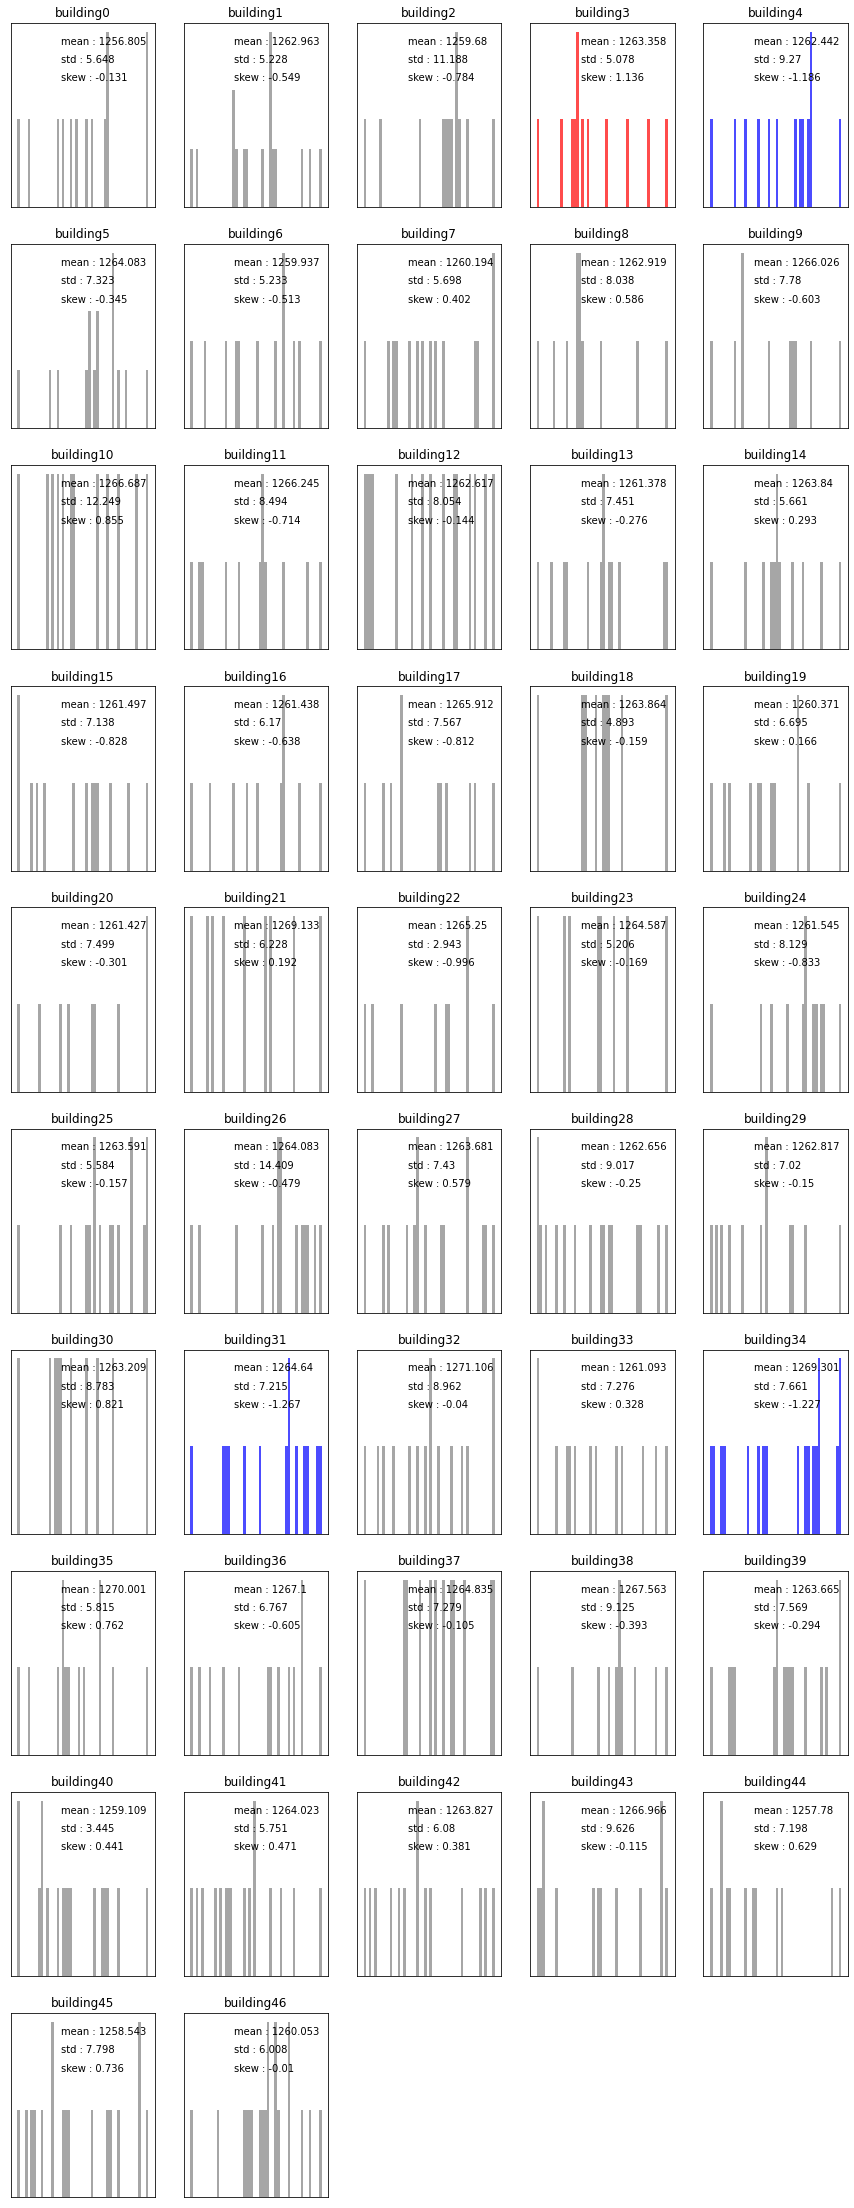

In [57]:
fig = plt.figure(figsize = (15, 40))
for num in range(len(df_final.module_name.unique())):
    ax = plt.subplot(10, 5, num+1)
    energy = df_final.loc[df_final.module_name == num, 'y'].values
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.0:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.0:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

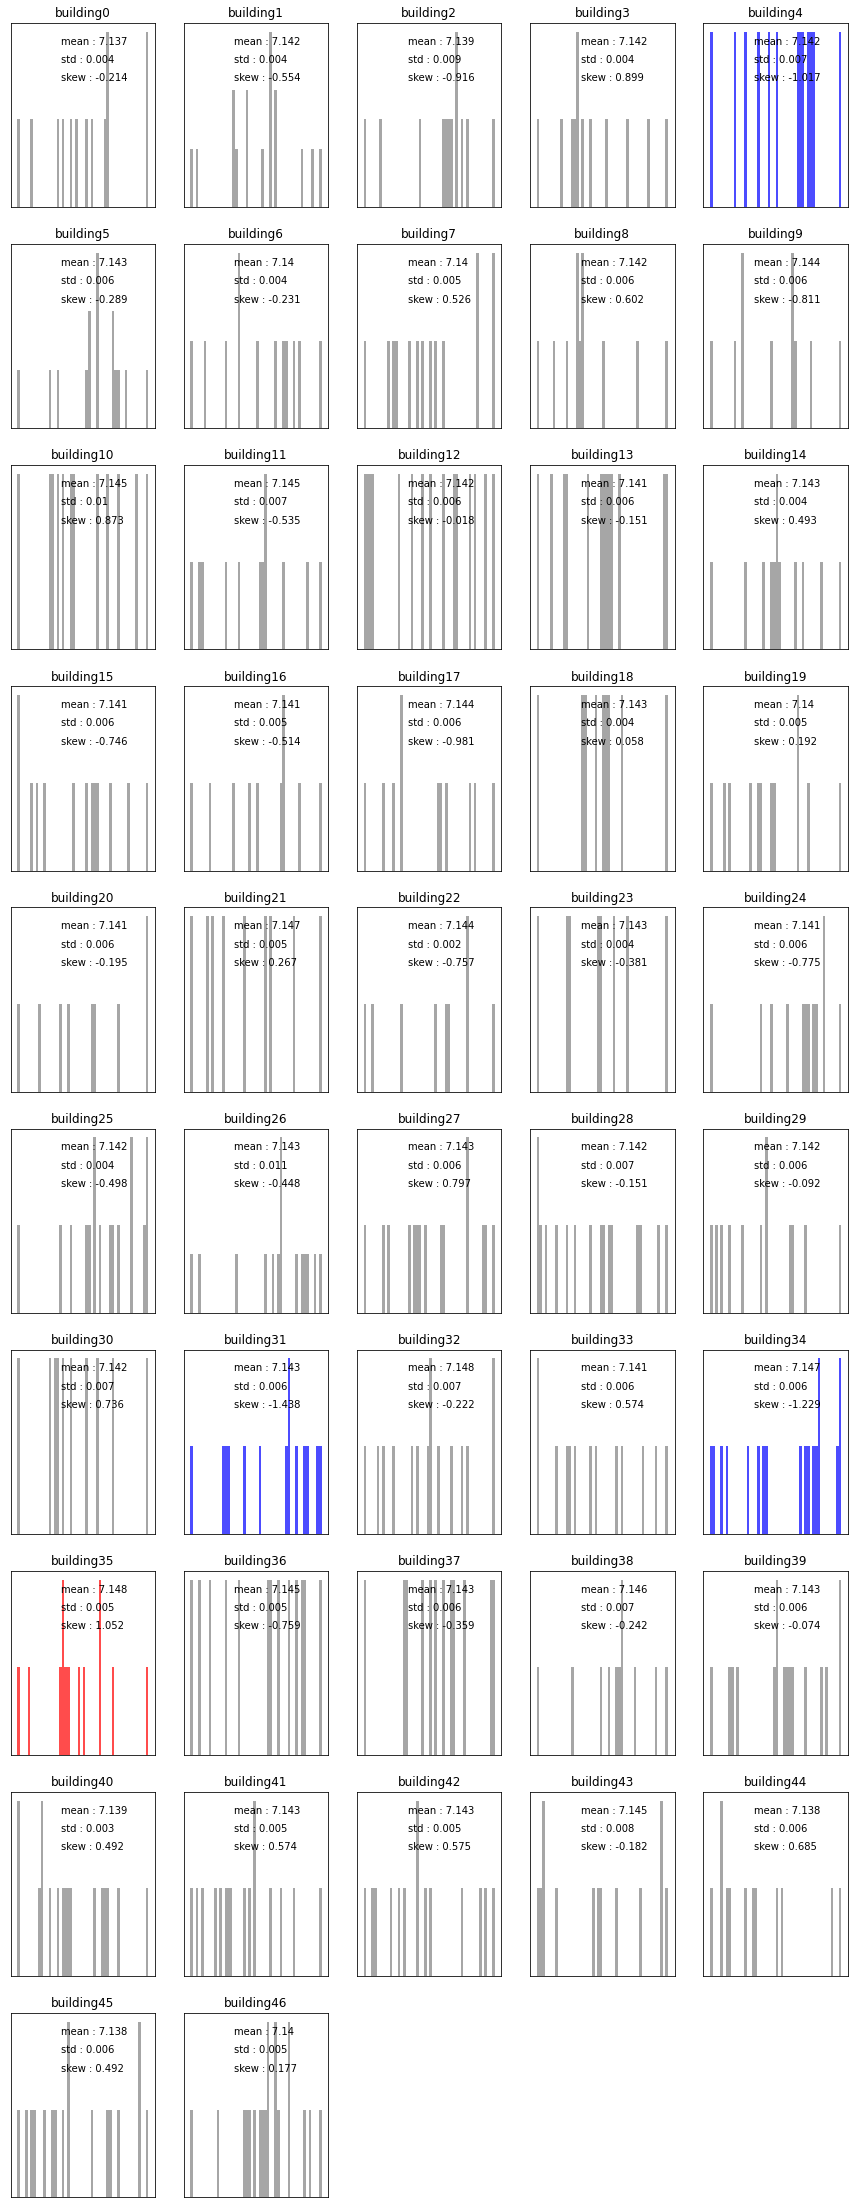

In [58]:
fig = plt.figure(figsize = (15, 40))
for num in range(len(df_final.module_name.unique())):
    ax = plt.subplot(10, 5, num+1)
    energy = df_final.loc[df_final.module_name == num, 'y'].values
    energy = np.log1p(energy)
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.0:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.0:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

building 31,35는 log 씌우지마.

# 4. 데이터 전처리

In [6]:
# 전처리를 위한 학습용 데이터와 평가용 데이터를 복사합니다.
df_train = train.copy()
df_predict = predict.copy()

In [7]:
# 센서 컬럼과 날짜 컬럼을 정의합니다. 
col_sensor = df_train.iloc[:, 4:-7].columns.tolist() 
col_time = df_train.filter(regex='end').columns.tolist() 

assert len(col_sensor) == 665
assert len(col_time) == 8 

# 3.4절 공정 소요시간 분석에 필요한 변수를 정의합니다. 
lst_steps = ['04','06','12','13','17','18', '20']
lst_stepsgap = ['0406','0612','1213','1317','1718','1820']

''' step별로 fdc para명 따로 수집 '''
lst_sensors = []
for step in lst_steps:
    _ = [col for col in col_sensor if col[:2] == step]
    lst_sensors.append(_)

sensors_nm = list(map(lambda x: x[3:], lst_sensors[0]))

# 시간과 관련한 분석을 진행하기 위하여 날짜형으로 변환합니다. 
df_train[col_time] = df_train[col_time].apply(pd.to_datetime)

In [8]:
for_col_filter = []
for step_para in lst_sensors:
    for para in step_para:
        para = para.split('_')[0]+'_'+para.split('_')[1]
        for_col_filter.append(para)
for_col_filter = sorted(list(set(for_col_filter)))

In [9]:
# 전체 및 개별 공정 소요시간 7개의 변수를 생성합니다(3.4절)
lst_stepsgap = ['0406','0612','1213','1317','1718','1820']
df_train = gen_duration_feats(df_train, lst_stepsgap)
df_predict = gen_duration_feats(df_predict, lst_stepsgap)
df_train.filter(regex='tmdiff').head(2)

,gen_tmdiff,gen_tmdiff_0406,gen_tmdiff_0612,gen_tmdiff_1213,gen_tmdiff_1317,gen_tmdiff_1718,gen_tmdiff_1820
0,1912.0,146.0,846.0,16.0,477.0,16.0,411.0
1,1911.0,145.0,847.0,16.0,476.0,16.0,411.0


# Cyclic Transformation 적용

In [10]:
''' Cyclic Transformation 적용 '''
def cyclic_transformation(df, cols):
    for col in cols:
        step = col[:2]
        df[col] = pd.to_datetime(df[col])
        df[step+'_'+'month'] = df[col].dt.month
        df[step+'_'+'day'] = df[col].dt.day
        df[step+'_'+'hour'] = df[col].dt.hour
        df[step+'_'+'weekday'] = df[col].dt.weekday
        
        ## cyclic transformation on hour
        df[step+'_'+'hour_sin'] = np.sin(2 * np.pi * df[step+'_'+'hour']/23.0)
        df[step+'_'+'hour_cos'] = np.cos(2 * np.pi * df[step+'_'+'hour']/23.0)
        ## cyclic transformation on date 
        df[step+'_'+'date_sin'] = -np.sin(2 * np.pi * (df[step+'_'+'month']+df[step+'_'+'day']/31)/12)
        df[step+'_'+'date_cos'] = -np.cos(2 * np.pi * (df[step+'_'+'month']+df[step+'_'+'day']/31)/12)
        ## cyclic transformation on month
        df[step+'_'+'month_sin'] = -np.sin(2 * np.pi * df[step+'_'+'month']/12.0)
        df[step+'_'+'month_cos'] = -np.cos(2 * np.pi * df[step+'_'+'month']/12.0)
        ## cyclic transformation on weekday
        df[step+'_'+'weekday_sin'] = -np.sin(2 * np.pi * (df[step+'_'+'weekday']+1)/7.0)
        df[step+'_'+'weekday_cos'] = -np.cos(2 * np.pi * (df[step+'_'+'weekday']+1)/7.0)
        
        df.drop(step+'_'+'month',axis=1,inplace=True)
        df.drop(step+'_'+'month_sin',axis=1,inplace=True)
        df.drop(step+'_'+'month_cos',axis=1,inplace=True)

In [11]:
endtime_col = df_train.filter(regex='end_time$').columns.tolist()
cyclic_transformation(df_train, endtime_col)
cyclic_transformation(df_predict, endtime_col)

In [13]:
df_train.head(1)

,module_name,key_val,end_dt_tm,y,04_efem_para2,04_efem_para25,04_efem_para78,04_epd_para4,04_epd_para40,04_epd_para63,04_epd_para80,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para10,04_gas_para13,04_gas_para15,04_gas_para19,04_gas_para21,04_gas_para26,04_gas_para27,04_gas_para33,04_gas_para36,04_gas_para39,04_gas_para46,04_gas_para48,04_gas_para50,04_gas_para51,04_gas_para52,04_gas_para59,04_gas_para6,04_gas_para70,04_gas_para71,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para1,04_he_para22,04_he_para88,04_he_para95,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para14,04_power_para49,04_power_para57,04_power_para68,04_power_para76,04_power_para82,04_pressure_para91,04_temp_para11,04_temp_para12,04_temp_para17,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para24,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para79,04_temp_para86,04_temp_para87,04_temp_para92,04_temp_para93,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para5,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_epd_para80,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para10,06_gas_para13,06_gas_para15,06_gas_para19,06_gas_para21,06_gas_para26,06_gas_para27,06_gas_para33,06_gas_para36,06_gas_para39,06_gas_para46,06_gas_para48,06_gas_para50,06_gas_para51,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para70,06_gas_para71,06_gas_para73,06_gas_para74,06_gas_para85,06_he_para1,06_he_para22,06_he_para88,06_he_para95,06_hv_para3,06_hv_para45,06_hv_para47,06_hv_para56,06_position_para72,06_power_para14,06_power_para49,06_power_para57,06_power_para68,06_power_para76,06_power_para82,06_pressure_para91,06_temp_para11,06_temp_para12,06_temp_para17,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para24,06_temp_para32,06_temp_para38,06_temp_para53,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para79,06_temp_para86,06_temp_para87,06_temp_para92,06_temp_para93,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para5,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_efem_para2,12_efem_para25,12_efem_para78,12_epd_para4,12_epd_para40,12_epd_para63,12_epd_para80,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para10,12_gas_para13,12_gas_para15,12_gas_para19,12_gas_para21,12_gas_para26,12_gas_para27,12_gas_para33,12_gas_para36,12_gas_para39,12_gas_para46,12_gas_para48,12_gas_para50,12_gas_para51,12_gas_para52,12_gas_para59,12_gas_para6,12_gas_para70,12_gas_para71,12_gas_para73,12_gas_para74,12_gas_para85,12_he_para1,12_he_para22,12_he_para88,12_he_para95,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para49,12_power_para57,12_power_para68,12_power_para76,12_power_para82,12_pressure_para91,12_temp_para11,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para23,12_temp_para24,12_temp_para32,12_temp_para38,12_temp_para53,12_temp_para54,12_temp_para55,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para79,12_temp_para86,12_temp_para87,12_temp_para92,12_temp_para93,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para

In [14]:
df_predict.head(1)

,module_name,key_val,04_efem_para2,04_efem_para25,04_efem_para78,04_epd_para4,04_epd_para40,04_epd_para63,04_epd_para80,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para10,04_gas_para13,04_gas_para15,04_gas_para19,04_gas_para21,04_gas_para26,04_gas_para27,04_gas_para33,04_gas_para36,04_gas_para39,04_gas_para46,04_gas_para48,04_gas_para50,04_gas_para51,04_gas_para52,04_gas_para59,04_gas_para6,04_gas_para70,04_gas_para71,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para1,04_he_para22,04_he_para88,04_he_para95,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para14,04_power_para49,04_power_para57,04_power_para68,04_power_para76,04_power_para82,04_pressure_para91,04_temp_para11,04_temp_para12,04_temp_para17,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para24,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para79,04_temp_para86,04_temp_para87,04_temp_para92,04_temp_para93,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para5,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_epd_para80,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para10,06_gas_para13,06_gas_para15,06_gas_para19,06_gas_para21,06_gas_para26,06_gas_para27,06_gas_para33,06_gas_para36,06_gas_para39,06_gas_para46,06_gas_para48,06_gas_para50,06_gas_para51,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para70,06_gas_para71,06_gas_para73,06_gas_para74,06_gas_para85,06_he_para1,06_he_para22,06_he_para88,06_he_para95,06_hv_para3,06_hv_para45,06_hv_para47,06_hv_para56,06_position_para72,06_power_para14,06_power_para49,06_power_para57,06_power_para68,06_power_para76,06_power_para82,06_pressure_para91,06_temp_para11,06_temp_para12,06_temp_para17,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para24,06_temp_para32,06_temp_para38,06_temp_para53,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para79,06_temp_para86,06_temp_para87,06_temp_para92,06_temp_para93,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para5,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_efem_para2,12_efem_para25,12_efem_para78,12_epd_para4,12_epd_para40,12_epd_para63,12_epd_para80,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para10,12_gas_para13,12_gas_para15,12_gas_para19,12_gas_para21,12_gas_para26,12_gas_para27,12_gas_para33,12_gas_para36,12_gas_para39,12_gas_para46,12_gas_para48,12_gas_para50,12_gas_para51,12_gas_para52,12_gas_para59,12_gas_para6,12_gas_para70,12_gas_para71,12_gas_para73,12_gas_para74,12_gas_para85,12_he_para1,12_he_para22,12_he_para88,12_he_para95,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para49,12_power_para57,12_power_para68,12_power_para76,12_power_para82,12_pressure_para91,12_temp_para11,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para23,12_temp_para24,12_temp_para32,12_temp_para38,12_temp_para53,12_temp_para54,12_temp_para55,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para79,12_temp_para86,12_temp_para87,12_temp_para92,12_temp_para93,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para64,12_time_p

# 이중 트렌드 para 전처리

In [12]:
two_trend_para = ['06_epd_para4','20_epd_para4','04_hv_para45','04_hv_para47','04_hv_para56','06_power_para57']

In [13]:
df_train['06_epd_para4_test'] = df_train['06_epd_para4'].apply(lambda x: 1 if x > 50 else 0)
df_train['20_epd_para4_test'] = df_train['20_epd_para4'].apply(lambda x: 1 if x < 900 else 0)
df_train['04_hv_para45_test'] = df_train['04_hv_para45'].apply(lambda x: 1 if x < 150 else 0)
df_train['04_hv_para47_test'] = df_train['04_hv_para47'].apply(lambda x: 1 if x < 100 else 0)
df_train['04_hv_para56_test'] = df_train['04_hv_para56'].apply(lambda x: 1 if x < 0.15 else 0)
df_train['06_power_para57_test'] = df_train['06_power_para57'].apply(lambda x: 1 if x > 2300 else 0)
df_train['06_power_para76_test'] = df_train['06_power_para76'].apply(lambda x: 1 if x > 1600 else 0)

df_predict['06_epd_para4_test'] = df_predict['06_epd_para4'].apply(lambda x: 1 if x > 50 else 0)
df_predict['20_epd_para4_test'] = df_predict['20_epd_para4'].apply(lambda x: 1 if x < 900 else 0)
df_predict['04_hv_para45_test'] = df_predict['04_hv_para45'].apply(lambda x: 1 if x < 150 else 0)
df_predict['04_hv_para47_test'] = df_predict['04_hv_para47'].apply(lambda x: 1 if x < 100 else 0)
df_predict['04_hv_para56_test'] = df_predict['04_hv_para56'].apply(lambda x: 1 if x < 0.15 else 0)
df_predict['06_power_para57_test'] = df_predict['06_power_para57'].apply(lambda x: 1 if x > 2300 else 0)
df_predict['06_power_para76_test'] = df_predict['06_power_para76'].apply(lambda x: 1 if x > 1600 else 0)

#### TIME para 이중트렌드 전처리

In [14]:
''' 5000 이상은 1, 아래는 0으로인코딩 '''
time_5000 = ['time para16','time_para42','time_para43','time_para44','time_para62','time_para75','time_para77','time_para89']
for col in time_5000:
    col_ = df_train.filter(regex=col+'$').columns.tolist()
    for column in col_:
        df_train[column+'_test'] = df_train[column].apply(lambda x: 1 if x>5000 else 0)
        df_predict[column+'_test'] = df_predict[column].apply(lambda x: 1 if x>5000 else 0)
''' 125 이상은 0, 아래는 1로 인코딩 '''
time_125 = ['12_time_para5','13_time_para5','17_time_para5','18_time_para5']
for col in time_125:
    df_train[col+'_test'] = df_train[col].apply(lambda x: 1 if x <125 else 0)
    df_predict[col+'_test'] = df_predict[col].apply(lambda x: 1 if x <125 else 0)
''' 3500 이상은 1 아래는 0 '''
for col in df_train.filter(regex='time_para67$').columns.tolist():
    df_train[col+'_test'] = df_train[col].apply(lambda x: 1 if x >= 3500 else 0)
    df_predict[col+'_test'] = df_predict[col].apply(lambda x: 1 if x >= 3500 else 0)

#### TMP para 이중트렌드 전처리

In [15]:
''' 2.6 이상 1, 아래 0 '''
'04_tmp_para31'
df_train['04_tmp_para31_test'] = df_train['04_tmp_para31'].apply(lambda x: 1 if x >=2.6 else 0)
df_predict['04_tmp_para31_test'] = df_predict['04_tmp_para31'].apply(lambda x: 1 if x >=2.6 else 0)
''' 2.8 이상 1, 아래 0 '''
'06_tmp_para31'
df_train['06_tmp_para31_test'] = df_train['06_tmp_para31'].apply(lambda x: 1 if x >=2.8 else 0)
df_predict['06_tmp_para31_test'] = df_predict['06_tmp_para31'].apply(lambda x: 1 if x >=2.8 else 0)
''' 4.0 이상 1, 아래 0 '''
tmp_4 = ['12_tmp_para31','13_tmp_para31','17_tmp_para31','18_tmp_para31','20_tmp_para31']
for col in tmp_4:
    df_train[col+'_test'] = df_train[col].apply(lambda x: 1 if x>=4.0 else 0)
    df_predict[col+'_test'] = df_predict[col].apply(lambda x: 1 if x>=4.0 else 0)

# Category 변수 처리

In [16]:
''' CATEGORY 변수 처리 및 NUM FEATURE 정의 '''
module2idx = {}
for i, module in enumerate(df_train['module_name'].unique()):
    module2idx[module] = i
    
def col2cat(df, col, dict):
    df[col] = df[col].apply(lambda x: dict[x])
    df[col] = df[col].astype('category')
    return df[col]

# module_name cat 화
col2cat(df_train, 'module_name', module2idx)
col2cat(df_predict, 'module_name', module2idx)

0       0
1       0
2       0
3       0
4       0
       ..
257    45
258    46
259    46
260    46
261    46
Name: module_name, Length: 262, dtype: category
Categories (47, int64): [0, 1, 2, 3, ..., 43, 44, 45, 46]

# 각 챔버별 전처리

In [28]:
from sklearn.preprocessing import StandardScaler

In [50]:
df_final = df_train.copy()
df_predict_final = df_predict.copy()

In [51]:
module_unique = df_final['module_name'].unique()
df_trains = [df_final[df_final['module_name']==eq] for eq in module_unique]
num_features_lst = []
df_predicts = [df_predict_final[df_predict_final['module_name']==eq] for eq in module_unique]
''' 중복되는 열 제거하기. '''
for i, (trains,predicts) in enumerate(zip(df_trains,df_predicts)):
    drop_col = []
    for para in for_col_filter:
        col = trains.filter(regex='^'+para).columns.tolist()
        duplicate_deleted_df = trains[col].T.drop_duplicates(subset=trains[col].T.columns, keep='first').T
        if len(trains[col].columns.difference(duplicate_deleted_df.columns))==0:  # 다른게 없으면 무시,
            continue
        else:
            drop_col.extend(trains[col].columns.difference(duplicate_deleted_df.columns).tolist())
    
    # 새로 생성한 TEST COLUMNS 전처리
    test_col = trains.filter(regex='test$').columns.tolist()
    duplicate_deleted_test_df = trains[test_col].T.drop_duplicates(subset=trains[test_col].T.columns, keep='first').T
    if len(trains[test_col].columns.difference(duplicate_deleted_test_df.columns))!=0:
        drop_col.extend(trains[test_col].columns.difference(duplicate_deleted_test_df.columns).tolist())
    
    trains.drop(drop_col,axis=1,inplace=True)
    predicts.drop(drop_col, axis=1, inplace=True)
    
#     ''' 1부터도 log transformation시 skewness와 kurtois가 많이 줄어듦. 효과적일 것이라 변환진행 ex) '20_time_para42' '''
#     skew1_df = ((trains.skew()>=2.5)|(trains.skew()<=-2.5)).reset_index().iloc[1:].reset_index(drop=True)
#     skew1_df.columns=['param','boolean']
#     high_skew1_col = skew1_df.loc[skew1_df['boolean'],:]['param'].unique().tolist()
#     df = trains[high_skew1_col]
#     ''' 04_fr_para28 , 06_fr_para28 음수를 가진 col인데, skew는 높지만 시각화시 괜찮아서 제외. '''
    
#     minus_col = df[(np.log1p(df).isnull())|(np.log1p(df)==float('-inf'))].dropna(axis=1,how='any').columns.tolist()
#     high_skew1_col = [x for x in high_skew1_col if x not in minus_col]
#     print(len(high_skew1_col))

#     trains[high_skew1_col] = np.log1p(trains[high_skew1_col])
#     predicts[high_skew1_col] = np.log1p(predicts[high_skew1_col])
    
#     assert predicts[high_skew1_col].isnull().sum().sum() == 0
#     assert (predicts[high_skew1_col]==float('-inf')).sum().sum() == 0
#     assert (predicts[high_skew1_col]==float('inf')).sum().sum() == 0
    
    var0_cols = trains.loc[:,trains.nunique()==1].columns.tolist()
    print(f'module{i}의 drop할 columns : {var0_cols}')
    trains.drop(var0_cols, axis=1, inplace=True)
    predicts.drop(var0_cols, axis=1, inplace=True)
    
#     num_features = list(trains.columns[trains.dtypes==float])
#     num_features.remove('y')
#     scaler = StandardScaler()
#     trains.loc[:, num_features] = scaler.fit_transform(trains[num_features])
#     predicts.loc[:, num_features] = scaler.transform(predicts[num_features])
    
    df_trains[i] = trains
    df_predicts[i] = predicts
    
    ''' Cyclic Transformation 된 time만 사용. gen+float f들 '''
    num_features = list(trains.columns[trains.dtypes==float])
    num_features.remove('y')
    test_cols = trains.filter(regex='test$').columns.tolist()
    num_features_lst.append(num_features+test_cols)

module0의 drop할 columns : ['module_name', '04_epd_para4', '04_esc_para94', '04_fr_para35', '04_gas_para10', '04_gas_para15', '04_gas_para74', '04_he_para1', '04_power_para14', '04_power_para57', '04_temp_para24', '04_temp_para58', '04_time_para5', '06_epd_para80', '06_fr_para35', '06_gas_para10', '06_gas_para70', '06_he_para1', '06_he_para95', '06_hv_para3', '06_power_para14', '06_temp_para24', '06_temp_para58', '06_time_para5', '12_epd_para4', '12_esc_para94', '12_fr_para35', '12_fr_para69', '12_gas_para10', '12_gas_para13', '12_gas_para74', '12_he_para1', '12_he_para95', '12_power_para49', '12_power_para57', '12_temp_para54', '12_temp_para58', '13_epd_para4', '13_esc_para94', '13_fr_para35', '13_fr_para69', '13_gas_para10', '13_gas_para13', '13_gas_para48', '13_gas_para51', '13_he_para1', '13_he_para95', '13_power_para49', '13_power_para57', '13_temp_para12', '13_temp_para54', '13_temp_para58', '13_temp_para92', '17_epd_para4', '17_esc_para84', '17_esc_para94', '17_fr_para28', '17_fr_

module5의 drop할 columns : ['module_name', '04_epd_para4', '04_esc_para84', '04_fr_para28', '04_fr_para35', '04_fr_para61', '04_fr_para69', '04_gas_para10', '04_gas_para15', '04_he_para1', '04_he_para95', '04_power_para14', '04_power_para57', '04_temp_para17', '04_temp_para24', '04_time_para5', '06_epd_para4', '06_esc_para84', '06_fr_para28', '06_fr_para35', '06_gas_para10', '06_gas_para70', '06_gas_para71', '06_he_para1', '06_he_para95', '06_hv_para3', '06_power_para14', '06_power_para57', '06_temp_para24', '06_time_para5', '12_epd_para4', '12_esc_para84', '12_fr_para28', '12_fr_para35', '12_fr_para61', '12_gas_para10', '12_gas_para13', '12_gas_para59', '12_gas_para74', '12_he_para1', '12_he_para95', '12_power_para49', '12_power_para57', '12_temp_para17', '12_temp_para23', '13_epd_para4', '13_esc_para84', '13_fr_para28', '13_fr_para35', '13_fr_para61', '13_gas_para10', '13_gas_para13', '13_gas_para51', '13_gas_para59', '13_he_para1', '13_he_para95', '13_power_para49', '13_power_para57',

module11의 drop할 columns : ['module_name', '04_epd_para4', '04_esc_para84', '04_esc_para94', '04_fr_para28', '04_fr_para35', '04_fr_para69', '04_gas_para10', '04_gas_para15', '04_he_para1', '04_he_para95', '04_hv_para3', '04_power_para14', '04_power_para57', '04_temp_para17', '04_temp_para24', '04_time_para5', '06_epd_para4', '06_esc_para84', '06_esc_para94', '06_fr_para28', '06_fr_para35', '06_fr_para69', '06_gas_para10', '06_gas_para59', '06_he_para1', '06_he_para95', '06_hv_para3', '06_power_para14', '06_power_para57', '06_temp_para24', '06_time_para5', '12_epd_para4', '12_esc_para84', '12_esc_para94', '12_fr_para28', '12_fr_para35', '12_gas_para10', '12_gas_para13', '12_gas_para59', '12_he_para1', '12_he_para95', '12_power_para49', '12_power_para57', '12_temp_para23', '12_temp_para54', '13_epd_para4', '13_esc_para84', '13_esc_para94', '13_fr_para28', '13_fr_para35', '13_gas_para10', '13_gas_para13', '13_gas_para48', '13_gas_para59', '13_he_para1', '13_he_para95', '13_power_para49', 

module16의 drop할 columns : ['module_name', '04_epd_para4', '04_esc_para84', '04_fr_para28', '04_fr_para35', '04_fr_para69', '04_gas_para10', '04_gas_para15', '04_gas_para74', '04_he_para1', '04_he_para95', '04_power_para14', '04_power_para57', '04_temp_para24', '04_time_para5', '06_epd_para4', '06_esc_para84', '06_fr_para35', '06_gas_para10', '06_gas_para70', '06_he_para1', '06_he_para95', '06_hv_para3', '06_power_para14', '06_temp_para24', '06_time_para5', '12_epd_para4', '12_esc_para84', '12_esc_para94', '12_fr_para28', '12_fr_para35', '12_gas_para10', '12_gas_para13', '12_gas_para27', '12_gas_para59', '12_gas_para74', '12_he_para1', '12_he_para95', '12_power_para49', '12_temp_para17', '13_epd_para4', '13_esc_para84', '13_esc_para94', '13_fr_para28', '13_fr_para35', '13_gas_para10', '13_gas_para13', '13_gas_para48', '13_gas_para51', '13_gas_para59', '13_he_para1', '13_he_para95', '13_power_para49', '13_power_para57', '13_temp_para17', '13_temp_para23', '17_epd_para4', '17_esc_para84',

module23의 drop할 columns : ['module_name', '04_epd_para4', '04_esc_para84', '04_esc_para94', '04_fr_para28', '04_fr_para35', '04_fr_para69', '04_gas_para10', '04_gas_para15', '04_gas_para74', '04_gas_para85', '04_he_para1', '04_he_para95', '04_hv_para47', '04_position_para72', '04_power_para14', '04_power_para57', '04_temp_para18', '04_temp_para24', '04_time_para5', '06_epd_para4', '06_esc_para84', '06_esc_para94', '06_fr_para35', '06_fr_para69', '06_gas_para10', '06_gas_para33', '06_gas_para59', '06_gas_para70', '06_gas_para71', '06_he_para1', '06_he_para95', '06_hv_para3', '06_power_para14', '06_power_para57', '06_temp_para24', '06_time_para5', '12_epd_para4', '12_esc_para84', '12_esc_para94', '12_fr_para35', '12_fr_para69', '12_gas_para10', '12_gas_para13', '12_gas_para27', '12_gas_para33', '12_gas_para74', '12_he_para1', '12_he_para95', '12_power_para49', '12_temp_para54', '13_epd_para4', '13_esc_para84', '13_esc_para94', '13_fr_para28', '13_fr_para35', '13_gas_para10', '13_gas_para

module29의 drop할 columns : ['module_name', '04_epd_para4', '04_fr_para28', '04_fr_para61', '04_fr_para69', '04_gas_para10', '04_gas_para70', '04_gas_para74', '04_he_para1', '04_he_para95', '04_position_para72', '04_power_para14', '04_power_para57', '04_temp_para24', '04_time_para5', '06_epd_para4', '06_esc_para84', '06_esc_para94', '06_fr_para28', '06_fr_para61', '06_fr_para69', '06_gas_para10', '06_gas_para15', '06_he_para1', '06_he_para95', '06_hv_para3', '06_power_para14', '06_temp_para24', '06_time_para5', '12_epd_para4', '12_esc_para84', '12_fr_para28', '12_fr_para35', '12_gas_para15', '12_he_para1', '12_he_para95', '12_power_para49', '12_power_para57', '12_temp_para17', '12_temp_para23', '12_temp_para87', '12_temp_para92', '13_epd_para4', '13_esc_para84', '13_esc_para94', '13_fr_para28', '13_fr_para35', '13_gas_para10', '13_gas_para15', '13_gas_para48', '13_he_para1', '13_he_para95', '13_power_para49', '13_power_para57', '13_power_para82', '13_temp_para17', '13_temp_para23', '13_t

module34의 drop할 columns : ['module_name', '04_epd_para4', '04_esc_para84', '04_fr_para28', '04_fr_para35', '04_fr_para61', '04_fr_para69', '04_gas_para10', '04_gas_para15', '04_gas_para74', '04_he_para1', '04_he_para95', '04_hv_para3', '04_hv_para56', '04_power_para14', '04_power_para57', '04_temp_para23', '04_temp_para24', '04_temp_para66', '04_time_para5', '06_epd_para4', '06_fr_para28', '06_fr_para35', '06_fr_para61', '06_fr_para69', '06_gas_para10', '06_gas_para70', '06_gas_para71', '06_he_para1', '06_he_para95', '06_hv_para3', '06_power_para14', '06_power_para57', '06_temp_para24', '06_time_para5', '12_epd_para4', '12_esc_para84', '12_fr_para28', '12_fr_para35', '12_fr_para61', '12_gas_para10', '12_gas_para27', '12_gas_para46', '12_gas_para74', '12_he_para1', '12_he_para95', '12_power_para49', '12_power_para57', '12_temp_para17', '12_temp_para66', '13_epd_para4', '13_esc_para84', '13_fr_para28', '13_fr_para35', '13_fr_para61', '13_gas_para10', '13_gas_para51', '13_gas_para59', '13

module39의 drop할 columns : ['module_name', '04_epd_para4', '04_esc_para84', '04_fr_para28', '04_fr_para35', '04_fr_para69', '04_gas_para10', '04_gas_para15', '04_gas_para74', '04_he_para1', '04_he_para95', '04_power_para14', '04_power_para57', '04_temp_para24', '04_time_para5', '06_epd_para80', '06_esc_para84', '06_fr_para28', '06_fr_para35', '06_fr_para69', '06_gas_para10', '06_gas_para70', '06_he_para1', '06_he_para95', '06_hv_para3', '06_power_para14', '06_temp_para24', '06_time_para5', '12_epd_para4', '12_esc_para84', '12_fr_para28', '12_fr_para35', '12_gas_para10', '12_gas_para13', '12_gas_para27', '12_gas_para74', '12_he_para1', '12_he_para95', '12_power_para49', '12_power_para57', '12_temp_para54', '13_epd_para4', '13_esc_para84', '13_esc_para94', '13_fr_para28', '13_fr_para35', '13_gas_para10', '13_gas_para13', '13_gas_para51', '13_gas_para59', '13_he_para1', '13_he_para95', '13_power_para49', '13_power_para57', '13_temp_para23', '13_temp_para54', '17_epd_para4', '17_fr_para28',

module44의 drop할 columns : ['module_name', '04_epd_para4', '04_esc_para94', '04_fr_para28', '04_fr_para35', '04_fr_para69', '04_gas_para46', '04_gas_para74', '04_he_para1', '04_he_para95', '04_hv_para3', '04_power_para14', '04_power_para57', '04_temp_para24', '04_time_para5', '06_epd_para4', '06_esc_para94', '06_fr_para28', '06_fr_para35', '06_fr_para69', '06_gas_para15', '06_gas_para51', '06_he_para1', '06_he_para95', '06_hv_para3', '06_power_para14', '06_power_para57', '06_temp_para24', '06_time_para5', '12_epd_para4', '12_fr_para28', '12_fr_para35', '12_gas_para13', '12_gas_para15', '12_gas_para51', '12_he_para1', '12_he_para95', '12_power_para49', '12_power_para57', '12_temp_para23', '12_temp_para54', '13_epd_para4', '13_esc_para84', '13_esc_para94', '13_fr_para28', '13_fr_para35', '13_gas_para10', '13_gas_para48', '13_gas_para51', '13_he_para1', '13_he_para95', '13_power_para49', '13_power_para57', '13_temp_para23', '13_temp_para54', '17_epd_para4', '17_esc_para84', '17_esc_para94'

# 모델링

In [20]:
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb

import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import LeaveOneOut, KFold ,cross_val_score

# LGB+LooCV로 TEST

In [52]:
lgbs = []
lgb_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_LGB(trial):
        param_lgb = {
            'objective':'regression',
            'metric':'rmse',
            "random_state":42,
            'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.7),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 4e-5),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
            'bagging_fraction' :trial.suggest_loguniform('bagging_fraction', 0.01, 1.0),
            "n_estimators":trial.suggest_int("n_estimators", 100, 1000),
            "max_depth":trial.suggest_int("n_estimators", 3, 12),
            "colsample_bytree":trial.suggest_float("colsample_bytree", 0.3, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "max_bin": trial.suggest_int("max_bin", 200, 500)
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = lgb.LGBMRegressor(**param_lgb)
        loo = LeaveOneOut()
        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)
     
        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_lgb = optuna.create_study(
                study_name="lgb_parameter_opt",
                direction="minimize",
                sampler=sampler,
            )
    study_lgb.optimize(objective_LGB, n_trials=5)
    print("Best Score:", study_lgb.best_value)
    print("Best trial:", study_lgb.best_trial.params)
    lgb_scores.append(study_lgb.best_value)
    
    model = lgb.LGBMRegressor(**study_lgb.best_params)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{}th model training is completed'.format(i+1))
    lgbs.append(model)

[I 2022-07-20 00:27:00,604] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:00,856] Trial 0 finished with value: 0.003925828206967493 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.003925828206967493.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 0: [0.00283553 0.00301114 0.00712209 0.00296769 0.00022365 0.00257653
 0.0011365  0.00355603 0.00090957 0.00784613 0.00815912 0.00883071
 0.00186108]
Mean score :  0.003925828206967493
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.870602087830485

[I 2022-07-20 00:27:01,212] Trial 1 finished with value: 0.003925828206967493 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.003925828206967493.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-20 00:27:01,486] Trial 2 finished with value: 0.003925828206967493 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.003925828206967493.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 0: [0.00283553 0.00301114 0.00712209 0.00296769 0.00022365 0.00257653
 0.0011365  0.00355603 0.00090957 0.00784613 0.00815912 0.00883071
 0.00186108]
Mean score :  0.003925828206967493
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.106

[I 2022-07-20 00:27:01,776] Trial 3 finished with value: 0.003925828206967493 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.003925828206967493.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:01,985] Trial 4 finished with value: 0.003925828206967493 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.003925828206967493.
[I 2022-07-20 00:27:02,000] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:02,254] Trial 0 finished with value: 0.003532013850368554 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.003532013850368554.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 1: [0.00143397 0.0078302  0.00267378 0.00165649 0.00857065 0.00651215
 0.00300442 0.00131199 0.00782242 0.00141058 0.00307219 0.00193165
 0.00032084 0.00216751 0.00534497 0.00144842]
Mean score :  0.003532013850368554
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fr

[I 2022-07-20 00:27:02,648] Trial 1 finished with value: 0.003532013850368554 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.003532013850368554.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:03,002] Trial 2 finished with value: 0.003532013850368554 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.003532013850368554.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 1: [0.00143397 0.0078302  0.00267378 0.00165649 0.00857065 0.00651215
 0.0030044

[I 2022-07-20 00:27:03,349] Trial 3 finished with value: 0.003532013850368554 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.003532013850368554.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 1: [0.00143397 0.0078302  0.00267378 0.00165649 0.00857065 0.00651215
 0.00300442 0.00131199 0.00782242 0.00141058 0.00307219 0.00193165
 0.00032084 0.00216751 0.00534497 0.00144842]
Mean score :  0.003532013850368554
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_

[I 2022-07-20 00:27:03,624] Trial 4 finished with value: 0.003532013850368554 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.003532013850368554.
[I 2022-07-20 00:27:03,640] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:03,812] Trial 0 finished with value: 0.0073420905543468695 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0073420905543468695.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:04,114] Trial 1 finished with value: 0.0073420905543468695 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0073420905543468695.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:04,367] Trial 2 finished with value: 0.0073420905543468695 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0073420905543468695.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 2: [0.00226454 0.00541671 0.0007914  0.01484501 0.00755535 0.01666085
 0.02144865 0.0045579  0.0028755  0.0059424  0.00416007 0.00158671]
Mean score :  0.0073420905543468695
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.1067748270948135

[I 2022-07-20 00:27:04,600] Trial 3 finished with value: 0.0073420905543468695 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0073420905543468695.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 2: [0.00226454 0.00541671 0.0007914  0.01484501 0.00755535 0.01666085
 0.02144865 0.0045579  0.0028755  0.0059424  0.00416007 0.00158671]
Mean score :  0.0073420905543468695
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subs

[I 2022-07-20 00:27:04,790] Trial 4 finished with value: 0.0073420905543468695 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0073420905543468695.
[I 2022-07-20 00:27:04,804] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 2: [0.00226454 0.00541671 0.0007914  0.01484501 0.00755535 0.01666085
 0.02144865 0.0045579  0.0028755  0.0059424  0.00416007 0.00158671]
Mean score :  0.0073420905543468695
Best Score: 0.0073420905543468695
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsam

[I 2022-07-20 00:27:04,980] Trial 0 finished with value: 0.003570366217057197 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.003570366217057197.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 3: [0.00199551 0.0025143  0.00050707 0.0038456  0.00693236 0.00192629
 0.00232531 0.00166876 0.00137588 0.0090684  0.00660394 0.00408098]
Mean score :  0.003570366217057197
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsa

[I 2022-07-20 00:27:05,298] Trial 1 finished with value: 0.003570366217057197 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.003570366217057197.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 3: [0.00199551 0.0025143  0.00050707 0.0038456  0.00693236 0.00192629
 0.00232531 0.00166876 0.00137588 

[I 2022-07-20 00:27:05,558] Trial 2 finished with value: 0.003570366217057197 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.003570366217057197.


CV scores for 3: [0.00199551 0.0025143  0.00050707 0.0038456  0.00693236 0.00192629
 0.00232531 0.00166876 0.00137588 0.0090684  0.00660394 0.00408098]
Mean score :  0.003570366217057197
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, su

[I 2022-07-20 00:27:05,807] Trial 3 finished with value: 0.003570366217057197 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.003570366217057197.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 3: [0.00199551 0.0025143  0.00050707 0.0038456  0.00693236 0.00192629
 0.00232531 0.00166876 0.00137588 0.0090684  0.00660394 0.00408098]
Mean score :  0.003570366217057197
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample

[I 2022-07-20 00:27:06,011] Trial 4 finished with value: 0.003570366217057197 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.003570366217057197.
[I 2022-07-20 00:27:06,026] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 3: [0.00199551 0.0025143  0.00050707 0.0038456  0.00693236 0.00192629
 0.00232531 0.00166876 0.00137588 0.0090684  0.00660394 0.00408098]
Mean score :  0.003570366217057197
Best Score: 0.003570366217057197
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsampl

[I 2022-07-20 00:27:06,224] Trial 0 finished with value: 0.006802115792160894 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.006802115792160894.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 4: [0.01625958 0.00806297 0.00426123 0.00103391 0.0106764  0.00316745
 0.00670258 0.0131494  0.00485241 0.00537636 0.00647703 0.00560336
 0.00280483]
Mean score :  0.006802115792160894
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.87060208783

[I 2022-07-20 00:27:06,541] Trial 1 finished with value: 0.006802115792160894 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.006802115792160894.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:06,800] Trial 2 finished with value: 0.006802115792160894 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.006802115792160894.


CV scores for 4: [0.01625958 0.00806297 0.00426123 0.00103391 0.0106764  0.00316745
 0.00670258 0.0131494  0.00485241 0.00537636 0.00647703 0.00560336
 0.00280483]
Mean score :  0.006802115792160894
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.106774827

[I 2022-07-20 00:27:07,062] Trial 3 finished with value: 0.006802115792160894 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.006802115792160894.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 4: [0.01625958 0.00806297 0.00426123 0.00103391 0.0106764  0.00316745
 0.00670258 0.0131494  0.00485241 0.00537636 0.00647703 0.00560336
 0.00280483]
Mean score :  0.006802115792160894
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561

[I 2022-07-20 00:27:07,286] Trial 4 finished with value: 0.006802115792160894 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.006802115792160894.
[I 2022-07-20 00:27:07,300] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 4: [0.01625958 0.00806297 0.00426123 0.00103391 0.0106764  0.00316745
 0.00670258 0.0131494  0.00485241 0.00537636 0.00647703 0.00560336
 0.00280483]
Mean score :  0.006802115792160894
Best Score: 0.006802115792160894
Best trial: {'learning_rate': 0.2

[I 2022-07-20 00:27:07,525] Trial 0 finished with value: 0.004593390502411824 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004593390502411824.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:07,886] Trial 1 finished with value: 0.004593390502411824 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004593390502411824.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 5: [0.01519575 0.00728484 0.00359805 0.00879194 0.00077116 0.00608597
 0.00073214 0.00028415 0.01056966 0.00140803 0.00082374 0.00475323
 0.00094631 0.00373575 0.00392013]
Mean score :  0.004593390502411824
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fra

[I 2022-07-20 00:27:08,225] Trial 2 finished with value: 0.004593390502411824 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004593390502411824.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-20 00:27:08,532] Trial 3 finished with value: 0.004593390502411824 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004593390502411824.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 5: [0.01519575 0.00728484 0.00359805 0.00879194 0.00077116 0.00608597
 0.00073214 0.00028415 0.01056966 0.00140803 0.00082374 0.00475323
 0.00094631 0.00373575 0.00392013]
Mean score :  0.004593390502411824
[LightGBM] [Warning] bagging_fract

[I 2022-07-20 00:27:08,785] Trial 4 finished with value: 0.004593390502411824 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004593390502411824.
[I 2022-07-20 00:27:08,799] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:08,978] Trial 0 finished with value: 0.0039469096166956 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0039469096166956.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:09,265] Trial 1 finished with value: 0.0039469096166956 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0039469096166956.


CV scores for 6: [0.0025349  0.00809098 0.0029081  0.00395098 0.0018004  0.00244421
 0.00023462 0.00297708 0.00728    0.00476494 0.00404625 0.00633046]
Mean score :  0.0039469096166956
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.0382347522467

[I 2022-07-20 00:27:09,518] Trial 2 finished with value: 0.0039469096166956 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0039469096166956.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 6: [0.0025349  0.00809098 0.0029081  0.00395098 0.0018004  0.00244421
 0.00023462 0.00297708 0.00728    0.00476494 0.00404625 0.00633046]
Mean score :  0.0039469096166956
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, 

[I 2022-07-20 00:27:09,771] Trial 3 finished with value: 0.0039469096166956 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0039469096166956.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 6: [0.0025349  0.00809098 0.0029081  0.00395098 0.0018004  0.00244421
 0.00023462 0.00297708 0.00728    0.00476494 0.00404625 0.00633046]
Mean score :  0.0039469096166956
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsamp

[I 2022-07-20 00:27:09,975] Trial 4 finished with value: 0.0039469096166956 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0039469096166956.
[I 2022-07-20 00:27:09,989] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 6: [0.0025349  0.00809098 0.0029081  0.00395098 0.0018004  0.00244421
 0.00023462 0.00297708 0.00728    0.00476494 0.00404625 0.00633046]
Mean score :  0.0039469096166956
Best Score: 0.0039469096166956
Best trial: {'learning_rate': 0.2684326820046801,

[I 2022-07-20 00:27:10,205] Trial 0 finished with value: 0.0040550138914153344 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0040550138914153344.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:10,552] Trial 1 finished with value: 0.0040550138914153344 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0040550138914153344.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 7: [0.00179799 0.00155493 0.00423778 0.00466255 0.00844263 0.00049188
 0.00774195 0.00266148 0.00530131 0.0054884  0.00101666 0.00756977
 0.00553809 0.00026478]
Mean score :  0.0040550138914153344
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction 

[I 2022-07-20 00:27:10,835] Trial 2 finished with value: 0.0040550138914153344 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0040550138914153344.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 7: [0.00179799 0.00155493 0.00423778 0.00466255 0.00844263 0.00049188
 0.00774195 0.00266148 0.00530131 0.0054884  0.00101666 0.00756977
 0.00553809 0.00026478]
Mean score :  0.0040550138914153344
[LightGBM] [Warning] bagging_fract

[I 2022-07-20 00:27:11,148] Trial 3 finished with value: 0.0040550138914153344 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0040550138914153344.



Mean score :  0.0040550138914153344
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 wi

[I 2022-07-20 00:27:11,400] Trial 4 finished with value: 0.0040550138914153344 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0040550138914153344.
[I 2022-07-20 00:27:11,414] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 7: [0.00179799 0.00155493 0.00423778 0.00466255 0.00844263 0.00049188
 0.00774195 0.00266148 0.00530131 0.0054884  0.00101666 0.00756977
 0.00553809 0.00026478]
Mean score :  0.0040550138914153344
Best Score: 0.0040550138914153344
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15

[I 2022-07-20 00:27:11,579] Trial 0 finished with value: 0.005209339328056602 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005209339328056602.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 8: [0.01005424 0.00134619 0.00187716 0.00124959 0.00086088 0.00288203
 0.01576823 0.01000096 0.00215081 0.00431823 0.00679443]
Mean score :  0.005209339328056602
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be 

[I 2022-07-20 00:27:11,841] Trial 1 finished with value: 0.005209339328056602 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005209339328056602.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 8: [0.01005424 0.00134619 0.00187716 0.00124959 0.00086088 0.00288203
 0.01576823 0.01000096 0.00215081 0.00431823 0.00679443]
Mean score :  0.005209339328056602
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 

[I 2022-07-20 00:27:12,106] Trial 2 finished with value: 0.005209339328056602 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005209339328056602.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 8: [0.01005424 0.00134619 0.00187716 0.00124959 0.00086088 0.00288203
 0.01576823 0.01000096 0.00215081 0.00431823 0.00679443]
Mean score :  0.005209339328056602
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, sub

[I 2022-07-20 00:27:12,354] Trial 3 finished with value: 0.005209339328056602 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005209339328056602.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:12,540] Trial 4 finished with value: 0.005209339328056602 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005209339328056602.
[I 2022-07-20 00:27:12,557] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:12,714] Trial 0 finished with value: 0.005893775868276663 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005893775868276663.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 9: [0.00537405 0.00555306 0.00048535 0.00343553 0.00666823 0.00661592
 0.01222929 0.00392504

[I 2022-07-20 00:27:12,975] Trial 1 finished with value: 0.005893775868276663 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005893775868276663.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 9: [0.00537405 0.00555306 0.00048535 0.00343553 0.00666823 0.00661592
 0.01222929 0.00392504 0.00326332 0.01138797]
Mean score :  0.005893775868276663
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Cu

[I 2022-07-20 00:27:13,214] Trial 2 finished with value: 0.005893775868276663 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005893775868276663.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-20 00:27:13,436] Trial 3 finished with value: 0.005893775868276663 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005893775868276663.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:13,604] Trial 4 finished with value: 0.005893775868276663 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005893775868276663.
[I 2022-07-20 00:27:13,620] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:13,811] Trial 0 finished with value: 0.009120819291435081 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.009120819291435081.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:14,128] Trial 1 finished with value: 0.009120819291435081 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.009120819291435081.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 10: [0.00955359 0.00832285 0.00548489 0.00705082 0.00339246 0.00252157
 0.01834061 0.01522721 0.00693638 0.00998686 0.01839921 0.00423338]
Mean score :  0.009120819291435081
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.03823475224675

[I 2022-07-20 00:27:14,429] Trial 2 finished with value: 0.009120819291435081 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.009120819291435081.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 10: [0.00955359 0.00832285 0.00548489 0.00705082 0.00339246 0.00252157
 0.01834061 0.01522721 0.00693638 0.00998686 0.01839921 0.00423338]
Mean score :  0.009120819291435081
[LightGBM] [Warning] bagging_fraction is set=0.1067748270

[I 2022-07-20 00:27:14,680] Trial 3 finished with value: 0.009120819291435081 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.009120819291435081.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:14,898] Trial 4 finished with value: 0.009120819291435081 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.009120819291435081.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:14,914] A new study created in memory with name: lgb_parameter_opt


Best Score: 0.009120819291435081
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
11th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsamp

[I 2022-07-20 00:27:15,113] Trial 0 finished with value: 0.0061309495281348285 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0061309495281348285.


CV scores for 11: [0.00962378 0.00229079 0.00915361 0.01113481 0.01014996 0.01274229
 0.00240313 0.00156629 0.00196032 0.00571907 0.00235686 0.00447048]
Mean score :  0.0061309495281348285
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1

[I 2022-07-20 00:27:15,429] Trial 1 finished with value: 0.0061309495281348285 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0061309495281348285.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 11: [0.00962378 0.00229079 0.00915361 0.01113481 0.01014996 0.01274229
 0.00240313 0.00156629 0.00196032 0.00571907 0.00235686 0.00447048]
Mean score :  0.0061309495281348285
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsa

[I 2022-07-20 00:27:15,697] Trial 2 finished with value: 0.0061309495281348285 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0061309495281348285.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-20 00:27:15,957] Trial 3 finished with value: 0.0061309495281348285 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0061309495281348285.


CV scores for 11: [0.00962378 0.00229079 0.00915361 0.01113481 0.01014996 0.01274229
 0.00240313 0.00156629 0.00196032 0.00571907 0.00235686 0.00447048]
Mean score :  0.0061309495281348285
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1

[I 2022-07-20 00:27:16,175] Trial 4 finished with value: 0.0061309495281348285 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0061309495281348285.
[I 2022-07-20 00:27:16,191] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 11: [0.00962378 0.00229079 0.00915361 0.01113481 0.01014996 0.01274229
 0.00240313 0.00156629 0.00196032 0.00571907 0.00235686 0.00447048]
Mean score :  0.0061309495281348285
Best Score: 0.0061309495281348285
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
12th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fract

[I 2022-07-20 00:27:16,436] Trial 0 finished with value: 0.005975191275234041 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005975191275234041.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 12: [0.00919717 0.00999478 0.00457914 0.01039809 0.00903145 0.0086789
 0.00468055 0.00396324 0.00230128 0.00092951 0.00034924 0.00255608
 0.0066529  0.00721267 0.00910288]
Mean score :  0.005975191275234041
[LightGBM] [Warning] bagging_fract

[I 2022-07-20 00:27:16,822] Trial 1 finished with value: 0.005975191275234041 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005975191275234041.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 12: [0.00919717 0.00999478 0.00457914 0.01039809 0.00903145 0.0086789
 0.00468055 0.00396324 0.00230128 0.00092951 0.00034924 0.00255608
 0.0066529  0.00721267 0.00910288]
Mean score :  0.005975191275234041
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fra

[I 2022-07-20 00:27:17,169] Trial 2 finished with value: 0.005975191275234041 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005975191275234041.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:17,501] Trial 3 finished with value: 0.005975191275234041 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005975191275234041.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 12: [0.00919717 0.00999478 0.00457914 0.01039809 0.00903145 0.0086789
 0.00468055 0.00396324

[I 2022-07-20 00:27:17,770] Trial 4 finished with value: 0.005975191275234041 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005975191275234041.
[I 2022-07-20 00:27:17,786] A new study created in memory with name: lgb_parameter_opt


Best Score: 0.005975191275234041
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
13th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsamp

[I 2022-07-20 00:27:17,987] Trial 0 finished with value: 0.004938515299632817 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004938515299632817.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 13: [0.0081679  0.0018557  0.00538326 0.01103755 0.00207967 0.00593269
 0.00098286 0.00188337 0.01176654 0.01073309 0.00339935 0.00037061
 0.0006081 ]
Mean score :  0.004938515299632817
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853

[I 2022-07-20 00:27:18,310] Trial 1 finished with value: 0.004938515299632817 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004938515299632817.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 13: [0.0081679  0.0018557  0.00538326 0.01103755 0.00207967 0.00593269
 0.00098286 0.00188337 0.01176654 0.01073309 0.00339935 0.00037061
 0.0006081 ]
Mean score :  0.004938515299632817
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866

[I 2022-07-20 00:27:18,592] Trial 2 finished with value: 0.004938515299632817 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004938515299632817.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:18,856] Trial 3 finished with value: 0.004938515299632817 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004938515299632817.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 13: [0.0081679  0.0018557  0.00538326 0.01103755 0.00207967 0.00593269
 0.00098286 0.00188337 0.01176654 0.01073309 0.00339935 0.00037061
 0.0006081 ]
Mean score :  0.004938515299632817
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.413804011256

[I 2022-07-20 00:27:19,088] Trial 4 finished with value: 0.004938515299632817 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004938515299632817.
[I 2022-07-20 00:27:19,104] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 13: [0.0081679  0.0018557  0.00538326 0.01103755 0.00207967 0.00593269
 0.00098286 0.00188337 0.01176654 0.01073309 0.00339935 0.00037061
 0.0006081 ]
Mean score :  0.004938515299632817
Best Score: 0.004938515299632817
Best trial: {'learning_rate': 0.

[I 2022-07-20 00:27:19,296] Trial 0 finished with value: 0.0035263220925130234 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0035263220925130234.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 14: [5.22391699e-04 2.11091583e-03 9.06319394e-05 9.21015347e-03
 1.05515308e-02 5.02154284e

[I 2022-07-20 00:27:19,590] Trial 1 finished with value: 0.0035263220925130234 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0035263220925130234.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:19,849] Trial 2 finished with value: 0.0035263220925130234 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0035263220925130234.


CV scores for 14: [5.22391699e-04 2.11091583e-03 9.06319394e-05 9.21015347e-03
 1.05515308e-02 5.02154284e-03 3.45817837e-03 6.28779843e-03
 2.45967619e-03 9.60578888e-04 4.08270223e-04 1.23419644e-03]
Mean score :  0.0035263220925130234
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warni

[I 2022-07-20 00:27:20,113] Trial 3 finished with value: 0.0035263220925130234 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0035263220925130234.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 14: [5.22391699e-04 2.11091583e-03 9.06319394e-05 9.21015347e-03
 1.05515308e-02 5.02154284e-03 3.45817837e-03 6.28779843e-03
 2.45967619e-03 9.60578888e-04 4.08270223e-04 1.23419644e-03]
Mean score :  0.0035263220925130234
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] 

[I 2022-07-20 00:27:20,330] Trial 4 finished with value: 0.0035263220925130234 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0035263220925130234.
[I 2022-07-20 00:27:20,345] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 14: [5.22391699e-04 2.11091583e-03 9.06319394e-05 9.21015347e-03
 1.05515308e-02 5.02154284e-03 3.45817837e-03 6.28779843e-03
 2.45967619e-03 9.60578888e-04 4.08270223e-04 1.23419644e-03]
Mean score :  0.0035263220925130234
Best Score: 0.0035263220925

[I 2022-07-20 00:27:20,554] Trial 0 finished with value: 0.005316051890145783 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005316051890145783.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:20,866] Trial 1 finished with value: 0.005316051890145783 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005316051890145783.


CV scores for 15: [0.00874026 0.00455612 0.00516538 0.00302951 0.0017069  0.00332699
 0.0057048  0.00667671 0.00802842 0.00024814 0.00862838 0.01089966
 0.0023974 ]
Mean score :  0.005316051890145783
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=

[I 2022-07-20 00:27:21,141] Trial 2 finished with value: 0.005316051890145783 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005316051890145783.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 15: [0.00874026 0.00455612 0.00516538 0.00302951 0.0017069  0.00332699
 0.0057048  0.00667671 0.00802842 0.00024814 0.00862838 0.01089966
 0.0023974 ]
Mean score :  0.005316051890145783
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10

[I 2022-07-20 00:27:21,425] Trial 3 finished with value: 0.005316051890145783 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005316051890145783.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:21,647] Trial 4 finished with value: 0.005316051890145783 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005316051890145783.
[I 2022-07-20 00:27:21,662] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:21,807] Trial 0 finished with value: 0.004623840066129059 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004623840066129059.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:22,044] Trial 1 finished with value: 0.004623840066129059 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004623840066129059.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 16: [0.00982043 0.00380146 0.00177877 0.00055073 0.00311996 0.00550198
 0.00716799 0.00288502 0.00843811

[I 2022-07-20 00:27:22,265] Trial 2 finished with value: 0.004623840066129059 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004623840066129059.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-20 00:27:22,486] Trial 3 finished with value: 0.004623840066129059 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004623840066129059.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:22,646] Trial 4 finished with value: 0.004623840066129059 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004623840066129059.
[I 2022-07-20 00:27:22,660] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:22,813] Trial 0 finished with value: 0.005842681003324867 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005842681003324867.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 17: [0.01050649 0.00733105 0.00776043 0.00576422 0.00677309 0.01091267
 0.00414604 0.00438734 0.00197263 0.00179663 0.00291891]
Mean score :  0.005842681003324867
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0

[I 2022-07-20 00:27:23,067] Trial 1 finished with value: 0.005842681003324867 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005842681003324867.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 17: [0.01050649 0.00733105 0.00776043 0.00576422 0.00677309 0.01091267
 0.00414604 0.00438734 0.00197263 0.00179663 0.00291891]
Mean score :  0.005842681003324867
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be

[I 2022-07-20 00:27:23,299] Trial 2 finished with value: 0.005842681003324867 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005842681003324867.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 17: [0.01050649 0.00733105 0.00776043 0.00576422 0.00677309 0.01091267
 0.004146

[I 2022-07-20 00:27:23,531] Trial 3 finished with value: 0.005842681003324867 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005842681003324867.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:23,711] Trial 4 finished with value: 0.005842681003324867 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005842681003324867.
[I 2022-07-20 00:27:23,726] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:23,854] Trial 0 finished with value: 0.003061403673947854 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.003061403673947854.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 18: [0.00023925 0.00851479 0.00239329 0.00280559 0.00878991 0.00209986
 0.00076812 0.00077544 0.00116639]
Mean score :  0.003061403673947854
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Curr

[I 2022-07-20 00:27:24,063] Trial 1 finished with value: 0.003061403673947854 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.003061403673947854.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 18: [0.00023925 0.00851479 0.00239329 0.00280559 0.00878991 0.00209986
 0.00076812 0.00077544 0.00116639]
Mean score :  0.003061403673947854
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. 

[I 2022-07-20 00:27:24,255] Trial 2 finished with value: 0.003061403673947854 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.003061403673947854.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 18: [0.00023925 0.00851479 0.00239329 0.00280559 0.00878991 0.00209986
 0.00076812 0.00077544 0.00116639]
Mean score :  0.003061403673947854
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored.

[I 2022-07-20 00:27:24,435] Trial 3 finished with value: 0.003061403673947854 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.003061403673947854.
[I 2022-07-20 00:27:24,581] Trial 4 finished with value: 0.003061403673947854 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.003061403673947854.
[I 2022-07-20 00:27:24,595] A new study created in memory with name: lgb_parameter_opt


CV scores for 18: [0.00023925 0.00851479 0.00239329 0.00280559 0.00878991 0.00209986
 0.00076812 0.00077544 0.00116639]
Mean score :  0.003061403673947854
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value:

[I 2022-07-20 00:27:24,767] Trial 0 finished with value: 0.004677764098494889 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004677764098494889.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:25,046] Trial 1 finished with value: 0.004677764098494889 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004677764098494889.


CV scores for 19: [0.00710635 0.00635661 0.00627094 0.00099769 0.00447291 0.01149724
 0.00087319 0.00456565 0.00276509 0.0003865  0.00152793 0.00931306]
Mean score :  0.004677764098494889
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.0382347522

[I 2022-07-20 00:27:25,298] Trial 2 finished with value: 0.004677764098494889 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004677764098494889.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 19: [0.00710635 0.00635661 0.00627094 0.00099769 0.00447291 0.01149724
 0.00087319 0.00456565 0.00276509 0.0003865  0.00152793 0.00931306]
Mean score :  0.004677764098494889
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.1067748270948135

[I 2022-07-20 00:27:25,537] Trial 3 finished with value: 0.004677764098494889 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004677764098494889.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 19: [0.00710635 0.00635661 0.00627094 0.00099769 0.00447291 0.01149724
 0.00087319 0.00456565 0.00276509 0.0003865  0.00152793 0.00931306]
Mean score :  0.004677764098494889
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsam

[I 2022-07-20 00:27:25,735] Trial 4 finished with value: 0.004677764098494889 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004677764098494889.
[I 2022-07-20 00:27:25,750] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 19: [0.00710635 0.00635661 0.00627094 0.00099769 0.00447291 0.01149724
 0.00087319 0.00456565 0.00276509 0.0003865  0.00152793 0.00931306]
Mean score :  0.004677764098494889
Best Score: 0.004677764098494889
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsamp

[I 2022-07-20 00:27:25,886] Trial 0 finished with value: 0.0056368319193296455 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0056368319193296455.


CV scores for 20: [0.00425445 0.01091851 0.00941592 0.00290117 0.00068901 0.00945937
 0.00729167 0.00485209 0.0009493 ]
Mean score :  0.0056368319193296455
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value

[I 2022-07-20 00:27:26,099] Trial 1 finished with value: 0.0056368319193296455 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0056368319193296455.


CV scores for 20: [0.00425445 0.01091851 0.00941592 0.00290117 0.00068901 0.00945937
 0.00729167 0.00485209 0.0009493 ]
Mean score :  0.0056368319193296455
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be 

[I 2022-07-20 00:27:26,289] Trial 2 finished with value: 0.0056368319193296455 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0056368319193296455.
[I 2022-07-20 00:27:26,472] Trial 3 finished with value: 0.0056368319193296455 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0056368319193296455.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:26,618] Trial 4 finished with value: 0.0056368319193296455 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0056368319193296455.
[I 2022-07-20 00:27:26,633] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:26,773] Trial 0 finished with value: 0.004772833095848108 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004772833095848108.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 21: [0.00233499 0.00303916 0.00341285 0.00534166 0.00614697 0.0046382
 0.00774582 0.00995688

[I 2022-07-20 00:27:27,005] Trial 1 finished with value: 0.004772833095848108 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004772833095848108.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 21: [0.00233499 0.00303916 0.00341285 0.00534166 0.00614697 0.0046382
 0.00774582 0.00995688 0.00033896]
Mean score :  0.004772833095848108
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:27,202] Trial 2 finished with value: 0.004772833095848108 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004772833095848108.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 21: [0.00233499 0.00303916 0.00341285 0.00534166 0.00614697 0.0046382
 0.00774582 0.00995688 0.00033896]
Mean score :  0.004772833095848108
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignor

[I 2022-07-20 00:27:27,394] Trial 3 finished with value: 0.004772833095848108 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004772833095848108.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 21: [0.00233499 0.00303916 0.00341285 0.00534166 0.00614697 0.0046382
 0.00774582 0.00995688 0.00033896]
Mean score :  0.004772833095848108
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:27,548] Trial 4 finished with value: 0.004772833095848108 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004772833095848108.
[I 2022-07-20 00:27:27,562] A new study created in memory with name: lgb_parameter_opt
[I 2022-07-20 00:27:27,696] Trial 0 finished with value: 0.002229033064568478 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.002229033064568478.


CV scores for 21: [0.00233499 0.00303916 0.00341285 0.00534166 0.00614697 0.0046382
 0.00774582 0.00995688 0.00033896]
Mean score :  0.004772833095848108
Best Score: 0.004772833095848108
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
22th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, su

[I 2022-07-20 00:27:27,913] Trial 1 finished with value: 0.002229033064568478 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.002229033064568478.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:28,118] Trial 2 finished with value: 0.002229033064568478 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.002229033064568478.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-20 00:27:28,309] Trial 3 finished with value: 0.002229033064568478 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.002229033064568478.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:28,460] Trial 4 finished with value: 0.002229033064568478 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.002229033064568478.
[I 2022-07-20 00:27:28,474] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 22: [0.0021355  0.00368859 0.00091514 0.00018831 0.00211088 0.0038095
 0.00433883 0.00087142 0.00200313]
Mean score :  0.002229033064568478
Best Score: 0.002229033064568478
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.8029065113332

[I 2022-07-20 00:27:28,598] Trial 0 finished with value: 0.0037333988816803387 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0037333988816803387.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 23: [0.00356529 0.0039109  0.00020802 0.0003413  0.00863603 0.00380543
 0.00745731 0.00194291]
Mean score :  0.0037333988816803387
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: baggi

[I 2022-07-20 00:27:28,803] Trial 1 finished with value: 0.0037333988816803387 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0037333988816803387.


CV scores for 23: [0.00356529 0.0039109  0.00020802 0.0003413  0.00863603 0.00380543
 0.00745731 0.00194291]
Mean score :  0.0037333988816803387
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Cu

[I 2022-07-20 00:27:28,983] Trial 2 finished with value: 0.0037333988816803387 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0037333988816803387.
[I 2022-07-20 00:27:29,168] Trial 3 finished with value: 0.0037333988816803387 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0037333988816803387.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:29,307] Trial 4 finished with value: 0.0037333988816803387 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0037333988816803387.
[I 2022-07-20 00:27:29,321] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:29,488] Trial 0 finished with value: 0.005455267357617292 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005455267357617292.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:29,759] Trial 1 finished with value: 0.005455267357617292 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005455267357617292.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:30,031] Trial 2 finished with value: 0.005455267357617292 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005455267357617292.


CV scores for 24: [0.01813205 0.00112003 0.00217654 0.00727591 0.00529175 0.00925928
 0.00176521 0.0020319  0.00341236 0.00400063 0.00554107 0.00545646]
Mean score :  0.005455267357617292
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, s

[I 2022-07-20 00:27:30,285] Trial 3 finished with value: 0.005455267357617292 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005455267357617292.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 24: [0.01813205 0.00112003 0.00217654 0.00727591 0.00529175 0.00925928
 0.00176521 0.0020319  0.00341236 0.00400063 0.00554107 0.00545646]
Mean score :  0.005455267357617292
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsampl

[I 2022-07-20 00:27:30,485] Trial 4 finished with value: 0.005455267357617292 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005455267357617292.
[I 2022-07-20 00:27:30,500] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 24: [0.01813205 0.00112003 0.00217654 0.00727591 0.00529175 0.00925928
 0.00176521 0.0020319  0.00341236 0.00400063 0.00554107 0.00545646]
Mean score :  0.005455267357617292
Best Score: 0.005455267357617292
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
25th model training is completed
[LightGBM] [Warning] bagging_fraction 

[I 2022-07-20 00:27:30,726] Trial 0 finished with value: 0.0037066639896297104 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0037066639896297104.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 25: [0.00038708 0.0020144  0.00377191 0.00369177 0.00622344 0.00599687
 0.00451278 0.00110133 0.01207712 0.00142088 0.00133806 0.00089991
 0.00604531 0.00189663 0.00226069 0.00566845]
Mean score :  0.0037066639896297104
[LightGBM] [Warning] 

[I 2022-07-20 00:27:31,113] Trial 1 finished with value: 0.0037066639896297104 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0037066639896297104.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 25: [0.00038708 0.0020144  0.00377191 0.00369177 0.00622344 0.00599687
 0.00451278 0.00110133 0.01207712 0.00142088 0.00133806 0.00089991
 0.00604531 0.00189663 0.00226069 0.00566845]
Mean score :  0.0037066639896297104
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [War

[I 2022-07-20 00:27:31,456] Trial 2 finished with value: 0.0037066639896297104 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0037066639896297104.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-20 00:27:31,782] Trial 3 finished with value: 0.0037066639896297104 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0037066639896297104.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 25: [0.00038708 0.0020144  0.00377191 0.00369177 0.00622344 0.00599687
 0.00451278 0.00110133 0.01207712 0.00142088 0.00133806 0.00089991
 0.00604531 0.00189663 0.00226069 0.00566845]
Mean score :  0.0037066639896297104
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagg

[I 2022-07-20 00:27:32,036] Trial 4 finished with value: 0.0037066639896297104 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0037066639896297104.
[I 2022-07-20 00:27:32,050] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:32,269] Trial 0 finished with value: 0.009261407086033912 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.009261407086033912.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:32,616] Trial 1 finished with value: 0.009261407086033912 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.009261407086033912.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 26: [0.02776483 0.02450952 0.00201791 0.00206993 0.01275941 0.00120598
 0.01305753 0.00140125 0.00070642 0.01017788 0.00906995 0.01487867
 0.00679869 0.00372007 0.00878307]
Mean score :  0.009261407086033912
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fracti

[I 2022-07-20 00:27:32,913] Trial 2 finished with value: 0.009261407086033912 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.009261407086033912.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-20 00:27:33,228] Trial 3 finished with value: 0.009261407086033912 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.009261407086033912.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 26: [0.02776483 0.02450952 0.00201791 0.00206993 0.01275941 0.00120598
 0.01305753 0.00140125 0.00070642 0.01017788 0.00906995 0.01487867
 0.00679869 0.00372007 0.00878307]
Mean score :  0.009261407086033912
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction i

[I 2022-07-20 00:27:33,466] Trial 4 finished with value: 0.009261407086033912 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.009261407086033912.
[I 2022-07-20 00:27:33,482] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 26: [0.02776483 0.02450952 0.00201791 0.00206993 0.01275941 0.00120598
 0.01305753 0.00140125 0.00070642 0.01017788 0.00906995 0.01487867
 0.00679869 0.00372007 0.00878307]
Mean score :  0.009261407086033912
Best Score: 0.009261407086033912
Best trial

[I 2022-07-20 00:27:33,696] Trial 0 finished with value: 0.005386430189765079 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005386430189765079.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:34,052] Trial 1 finished with value: 0.005386430189765079 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005386430189765079.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 27: [0.01151687 0.00730127 0.00792559 0.00162194 0.00246721 0.01000918
 0.00556836 0.00265007 0.00120801 0.00853354 0.0029402  0.00119816
 0.00417464 0.00814938 0.00553203]
Mean score :  0.005386430189765079
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fr

[I 2022-07-20 00:27:34,363] Trial 2 finished with value: 0.005386430189765079 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005386430189765079.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-20 00:27:34,660] Trial 3 finished with value: 0.005386430189765079 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005386430189765079.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 27: [0.01151687 0.00730127 0.00792559 0.00162194 0.00246721 0.01000918
 0.00556836 0.00265007 0.00120801 0.00853354 0.0029402  0.00119816
 0.00417464 0.00814938 0.00553203]
Mean score :  0.005386430189765079
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is 

[I 2022-07-20 00:27:34,911] Trial 4 finished with value: 0.005386430189765079 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005386430189765079.
[I 2022-07-20 00:27:34,927] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 27: [0.01151687 0.00730127 0.00792559 0.00162194 0.00246721 0.01000918
 0.00556836 0.00265007 0.00120801 0.00853354 0.0029402  0.00119816
 0.00417464 0.00814938 0.00553203]
Mean score :  0.005386430189765079
Best Score: 0.005386430189765079
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779

[I 2022-07-20 00:27:35,183] Trial 0 finished with value: 0.006550807584025431 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.006550807584025431.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:35,571] Trial 1 finished with value: 0.006550807584025431 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.006550807584025431.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 28: [0.00992286 0.00826201 0.00640263 0.00834186 0.01178965 0.00360493
 0.01360166 0.00158135 0.00489858 0.00025899 0.0032378  0.0029914
 0.01013525 0.0092886  0.00200406 0.00849131]
Mean score :  0.006550807584025431
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_

[I 2022-07-20 00:27:35,912] Trial 2 finished with value: 0.006550807584025431 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.006550807584025431.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 28: [0.00992286 0.00826201 0.00640263 0.00834186 0.01178965 0.00360493
 0.01360166 0.00158135 0.00489858 0.00025899 0.0032378  0.0029914
 0.01013525 0.0092886  0.00200406 0.00849131]
Mean score :  0.006550807584025431
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] 

[I 2022-07-20 00:27:36,269] Trial 3 finished with value: 0.006550807584025431 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.006550807584025431.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:36,548] Trial 4 finished with value: 0.006550807584025431 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.006550807584025431.
[I 2022-07-20 00:27:36,563] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 28: [0.00992286 0.00826201 0.00640263 0.00834186 0.01178965 0.00360493
 0.01360166 0.00158135 0.00489858 0.00025899 0.0032378  0.0029914
 0.01013525 0.0092886  0.00200406 0.00849131]
Mean score :  0.006550807584025431
Best Score: 0.006550807584025431
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.1575

[I 2022-07-20 00:27:36,744] Trial 0 finished with value: 0.004982398497034894 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004982398497034894.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 29: [6.50074576e-04 6.40966215e-03 8.16097717e-03 1.10489805e-05
 1.24958510e-02 3.04588024e-03 4.40748181e-03 7.04291373e-03
 7.77472774e-04 6.85432551e-03 4.70907436e-03 5.22401968e-03]
Mean score :  0.004982398497034894
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning]

[I 2022-07-20 00:27:37,044] Trial 1 finished with value: 0.004982398497034894 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004982398497034894.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 29: [6.50074576e-04 6.40966215e-03 8.16097717e-03 1.10489805e-05
 1.24958510e-02 3.04588024e-03 4.407481

[I 2022-07-20 00:27:37,322] Trial 2 finished with value: 0.004982398497034894 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004982398497034894.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:37,577] Trial 3 finished with value: 0.004982398497034894 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004982398497034894.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 29: [6.50074576e-04 6.40966215e-03 8.16097717e-03 1.10489805e-05
 1.24958510e-02 3.04588024e-03 4.40748181e-03 7.04291373e-03
 7.77472774e-04 6.85432551e-03 4.70907436e-03 5.22401968e-03]
Mean score :  0.004982398497034894
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bag

[I 2022-07-20 00:27:37,791] Trial 4 finished with value: 0.004982398497034894 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004982398497034894.
[I 2022-07-20 00:27:37,807] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 29: [6.50074576e-04 6.40966215e-03 8.16097717e-03 1.10489805e-05
 1.24958510e-02 3.04588024e-03 4.40748181e-03 7.04291373e-03
 7.77472774e-04 6.85432551e-03 4.70907436e-03 5.22401968e-03]
Mean score :  0.004982398497034894
Best Score: 0.004982398497034894
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bag

[I 2022-07-20 00:27:37,963] Trial 0 finished with value: 0.0062398913618843645 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0062398913618843645.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 30: [0.00583515 0.01287413 0.00109042 0.01585293 0.00474401 0.00836016
 0.00432997 0.00308728 0.00224233 0.00398254]
Mean score :  0.0062398913618843645
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. 

[I 2022-07-20 00:27:38,222] Trial 1 finished with value: 0.0062398913618843645 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0062398913618843645.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 30: [0.00583515 0.01287413 0.00109042 0.01585293 0.00474401 0.00836016
 0.00432997 0.00308728 0.00224233 0.00398254]
Mean score :  0.0062398913618843645
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will 

[I 2022-07-20 00:27:38,447] Trial 2 finished with value: 0.0062398913618843645 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0062398913618843645.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 30: [0.00583515 0.01287413 0.00109042 0.01585293 0.00474401 0.00836016
 0.00432997 0.00308728 0.00224233 0.00398254]
Mean score :  0.0062398913618843645
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 wi

[I 2022-07-20 00:27:38,644] Trial 3 finished with value: 0.0062398913618843645 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0062398913618843645.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 30: [0.00583515 0.01287413 0.00109042 0.01585293 0.00474401 0.00836016
 0.00432997 0.00308728 0.00224233 0.00398254]
Mean score :  0.0062398913618843645
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored

[I 2022-07-20 00:27:38,809] Trial 4 finished with value: 0.0062398913618843645 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0062398913618843645.
[I 2022-07-20 00:27:38,824] A new study created in memory with name: lgb_parameter_opt


CV scores for 30: [0.00583515 0.01287413 0.00109042 0.01585293 0.00474401 0.00836016
 0.00432997 0.00308728 0.00224233 0.00398254]
Mean score :  0.0062398913618843645
Best Score: 0.0062398913618843645
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
31th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.1575132

[I 2022-07-20 00:27:39,038] Trial 0 finished with value: 0.005494735201704705 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005494735201704705.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 31: [0.00742768 0.00147565 0.0027529  0.00787485 0.00396393 0.00683736
 0.00246028 0.01233185 0.00642642 0.00418824 0.00547324 0.00746665
 0.00535076 0.00289648]
Mean score :  0.005494735201704705
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.870

[I 2022-07-20 00:27:39,401] Trial 1 finished with value: 0.005494735201704705 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005494735201704705.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-20 00:27:39,703] Trial 2 finished with value: 0.005494735201704705 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005494735201704705.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 31: [0.00742768 0.00147565 0.0027529  0.00787485 0.00396393 0.00683736
 0.00246028 0.01233185 0.00642642 0.00418824 0.00547324 0.00746665
 0.00535076 0.00289648]
Mean score :  0.005494735201704705
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fractio

[I 2022-07-20 00:27:39,995] Trial 3 finished with value: 0.005494735201704705 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005494735201704705.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:40,242] Trial 4 finished with value: 0.005494735201704705 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005494735201704705.
[I 2022-07-20 00:27:40,258] A new study created in memory with name: lgb_parameter_opt


Best Score: 0.005494735201704705
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
32th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsamp

[I 2022-07-20 00:27:40,476] Trial 0 finished with value: 0.006077204251398586 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.006077204251398586.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 32: [0.00757911 0.0127006  0.01248297 0.00626343 0.00039348 0.00012663
 0.00360349 0.01027324 0.00181222 0.00054735 0.00234836 0.00422074
 0.00691103 0.00902073 0.01287469]
Mean score :  0.006077204251398586
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction i

[I 2022-07-20 00:27:40,828] Trial 1 finished with value: 0.006077204251398586 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.006077204251398586.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:41,149] Trial 2 finished with value: 0.006077204251398586 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.006077204251398586.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 32: [0.00757911 0.0127006  0.01248297 0.00626343 0.00039348 0.00012663
 0.00360349 0.01027324 0.00181222 0.00054735 0.00234836 0.00422074
 0.00691103 0.00902073 0.01287469]
Mean score :  0.006077204251398586
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] baggin

[I 2022-07-20 00:27:41,452] Trial 3 finished with value: 0.006077204251398586 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.006077204251398586.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:41,705] Trial 4 finished with value: 0.006077204251398586 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.006077204251398586.
[I 2022-07-20 00:27:41,720] A new study created in memory with name: lgb_parameter_opt


CV scores for 32: [0.00757911 0.0127006  0.01248297 0.00626343 0.00039348 0.00012663
 0.00360349 0.01027324 0.00181222 0.00054735 0.00234836 0.00422074
 0.00691103 0.00902073 0.01287469]
Mean score :  0.006077204251398586
Best Score: 0.006077204251398586
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
33th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725


[I 2022-07-20 00:27:41,910] Trial 0 finished with value: 0.005344683334572668 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005344683334572668.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 33: [8.70188934e-03 3.90941257e-03 5.80367126e-03 1.08991974e-02
 4.17673056e-03 9.28470488e-03 7.06701699e-03 8.46763809e-03
 6.64492199e-04 8.58781764e-05 4.18510027e-03 3.00853899e-03
 3.22661258e-03]
Mean score :  0.005344683334572668
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM]

[I 2022-07-20 00:27:42,222] Trial 1 finished with value: 0.005344683334572668 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005344683334572668.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 33: [8.70188934e-03 3.90941257e-03 5.80367126e-03 1.08991974e-02
 4.17673056e-03 9.28470488e-03 7.06701699e-03 8.46763809e-03
 6.64492199e-04 8.58781764e-05 4.18510027e-03 3.00853899e-03
 3.22661258e-03]
Mean score :  0.005344683334572668
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGB

[I 2022-07-20 00:27:42,483] Trial 2 finished with value: 0.005344683334572668 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005344683334572668.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-20 00:27:42,736] Trial 3 finished with value: 0.005344683334572668 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005344683334572668.


CV scores for 33: [8.70188934e-03 3.90941257e-03 5.80367126e-03 1.08991974e-02
 4.17673056e-03 9.28470488e-03 7.06701699e-03 8.46763809e-03
 6.64492199e-04 8.58781764e-05 4.18510027e-03 3.00853899e-03
 3.22661258e-03]
Mean score :  0.005344683334572668
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [

[I 2022-07-20 00:27:42,955] Trial 4 finished with value: 0.005344683334572668 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005344683334572668.
[I 2022-07-20 00:27:42,969] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 33: [8.70188934e-03 3.90941257e-03 5.80367126e-03 1.08991974e-02
 4.17673056e-03 9.28470488e-03 7.06701699e-03 8.46763809e-03
 6.64492199e-04 8.58781764e-05 4.18510027e-03 3.00853899e-03
 3.22661258e-03]
Mean score :  0.005344683334572668
Best Score: 0.005344683334572668
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
34th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_

[I 2022-07-20 00:27:43,231] Trial 0 finished with value: 0.0058082070020902205 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0058082070020902205.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:43,641] Trial 1 finished with value: 0.0058082070020902205 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0058082070020902205.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 34: [0.00820526 0.00513676 0.00478448 0.00518781 0.00247097 0.01063099
 0.00835883 0.01019579 0.00519682 0.00376994 0.00278204 0.00304688
 0.00440655 0.00221022 0.0034151  0.00886813 0.00819511 0.00768606]
Mean score :  0.0058082070020902205
[LightGBM

[I 2022-07-20 00:27:44,022] Trial 2 finished with value: 0.0058082070020902205 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0058082070020902205.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 34: [0.00820526 0.00513676 0.00478448 0.00518781 0.00247097 0.01063099
 0.00835883 0.01019579 0.00519682 0.00376994 0.00278204 0.00304688
 0.00440655 0.00221022 0.0034151  0.00886813 0.00819511 0.00768606]
Mean score :  0.0058082070020902205
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.106774827

[I 2022-07-20 00:27:44,395] Trial 3 finished with value: 0.0058082070020902205 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0058082070020902205.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 34: [0.00820526 0.00513676 0.00478448 0.00518781 0.00247097 0.01063099
 0.00835883 0.01019579 0.00519682 0.00376994 0.00278204 0.00304688
 0.00440655 0.00221022 0.0034151  0.00886813 0.00819511 0.00768606]
Mean score :  0.0058082070020902205
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[Ligh

[I 2022-07-20 00:27:44,689] Trial 4 finished with value: 0.0058082070020902205 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0058082070020902205.
[I 2022-07-20 00:27:44,703] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:44,896] Trial 0 finished with value: 0.003822378696633394 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.003822378696633394.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:45,243] Trial 1 finished with value: 0.003822378696633394 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.003822378696633394.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 35: [0.01084006 0.00250749 0.00193979 0.00715716 0.00180057 0.00354269
 0.00124905 0.0004274  0.00348781 0.00108261 0.00546492 0.00138825
 0.00880313]
Mean score :  0.003822378696633394
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234

[I 2022-07-20 00:27:45,508] Trial 2 finished with value: 0.003822378696633394 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.003822378696633394.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 35: [0.01084006 0.00250749 0.00193979 0.00715716 0.00180057 0.00354269
 0.00124905 0.0004274  0.00348781 0.00108261 0.00546492 0.00138825
 0.00880313]
Mean score :  0.003822378696633394
[LightGBM] [Warning] bagging_fraction is set=

[I 2022-07-20 00:27:45,776] Trial 3 finished with value: 0.003822378696633394 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.003822378696633394.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:45,985] Trial 4 finished with value: 0.003822378696633394 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.003822378696633394.
[I 2022-07-20 00:27:45,999] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:46,189] Trial 0 finished with value: 0.005131229382259201 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005131229382259201.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:46,495] Trial 1 finished with value: 0.005131229382259201 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005131229382259201.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 36: [0.00110432 0.00845824 0.00246897 0.00845157 0.00693725 0.00118046
 0.0030843  0.00590446 0.00386852 0.00481115 0.00983003 0.00505004
 0.00555666]
Mean score :  0.005131229382259201
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.03

[I 2022-07-20 00:27:46,748] Trial 2 finished with value: 0.005131229382259201 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005131229382259201.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 36: [0.00110432 0.00845824 0.00246897 0.00845157 0.00693725 0.00118046
 0.0030843  0.00590446 0.00386852 0.00481115 0.00983003 0.00505004
 0.00555666]
Mean score :  0.005131229382259201
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10

[I 2022-07-20 00:27:47,010] Trial 3 finished with value: 0.005131229382259201 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005131229382259201.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 36: [0.00110432 0.00845824 0.00246897 0.00845157 0.00693725 0.00118046
 0.0030843  0.0059044

[I 2022-07-20 00:27:47,226] Trial 4 finished with value: 0.005131229382259201 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005131229382259201.
[I 2022-07-20 00:27:47,240] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:47,424] Trial 0 finished with value: 0.004964697107688283 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004964697107688283.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:47,709] Trial 1 finished with value: 0.004964697107688283 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004964697107688283.


CV scores for 37: [0.00096356 0.00141287 0.00448955 0.00988742 0.0055948  0.00268172
 0.00299387 0.00611743 0.01318294 0.00241448 0.00048655 0.00935118]
Mean score :  0.004964697107688283
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.0382347522

[I 2022-07-20 00:27:47,958] Trial 2 finished with value: 0.004964697107688283 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004964697107688283.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 37: [0.00096356 0.00141287 0.00448955 0.00988742 0.0055948  0.00268172
 0.00299387 0.00611743 0.01318294 0.00241448 0.00048655 0.00935118]
Mean score :  0.004964697107688283
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.1067748270948135

[I 2022-07-20 00:27:48,215] Trial 3 finished with value: 0.004964697107688283 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004964697107688283.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 37: [0.00096356 0.00141287 0.00448955 0.00988742 0.0055948  0.00268172
 0.00299387 0.00611743 0.01318294 0.00241448 0.00048655 0.00935118]
Mean score :  0.004964697107688283
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subs

[I 2022-07-20 00:27:48,418] Trial 4 finished with value: 0.004964697107688283 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004964697107688283.
[I 2022-07-20 00:27:48,434] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 37: [0.00096356 0.00141287 0.00448955 0.00988742 0.0055948  0.00268172
 0.00299387 0.00611743 0.01318294 0.00241448 0.00048655 0.00935118]
Mean score :  0.004964697107688283
Best Score: 0.004964697107688283
Best trial: {'learning_rate': 0.268432682004

[I 2022-07-20 00:27:48,592] Trial 0 finished with value: 0.005727376321420346 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005727376321420346.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 38: [0.0009377  0.01233142 0.00964485 0.00952712 0.00469313 0.00167624
 0.00325543 0.00150047 0.01778006 0.00106335 0.00059138]
Mean score :  0.005727376321420346
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 w

[I 2022-07-20 00:27:48,838] Trial 1 finished with value: 0.005727376321420346 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005727376321420346.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 38: [0.0009377  0.01233142 0.00964485 0.00952712 0.00469313 0.00167624
 0.00325543 0.00150047 0.01778006 0.00106335 0.00059138]
Mean score :  0.005727376321420346
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 wil

[I 2022-07-20 00:27:49,059] Trial 2 finished with value: 0.005727376321420346 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005727376321420346.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 38: [0.0009377  0.01233142 0.00964485 0.00952712 0.00469313 0.00167624
 0.003255

[I 2022-07-20 00:27:49,284] Trial 3 finished with value: 0.005727376321420346 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005727376321420346.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 38: [0.0009377  0.01233142 0.00964485 0.00952712 0.00469313 0.00167624
 0.00325543 0.0015004

[I 2022-07-20 00:27:49,460] Trial 4 finished with value: 0.005727376321420346 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005727376321420346.
[I 2022-07-20 00:27:49,474] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 38: [0.0009377  0.01233142 0.00964485 0.00952712 0.00469313 0.00167624
 0.00325543 0.00150047 0.01778006

[I 2022-07-20 00:27:49,723] Trial 0 finished with value: 0.005074144006486425 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005074144006486425.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:50,112] Trial 1 finished with value: 0.005074144006486425 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005074144006486425.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899334 0.00108731 0.00047287
 0.00125625 0.00777699 0.00081517 0.00830523 0.00103021 0.00133373
 0.00964751 0.00930281 0.00719628 0.00638132]
Mean score :  0.005074144006486425
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging

[I 2022-07-20 00:27:50,459] Trial 2 finished with value: 0.005074144006486425 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005074144006486425.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899334 0.00108731 0.00047287
 0.00125625 0.00777699 0.00081517 0.00830523 0.00103021 0.00133373
 0.00964751 0.00930281 0.00719628 0.00638132]
Mean score :  0.005074144006486425
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning]

[I 2022-07-20 00:27:50,794] Trial 3 finished with value: 0.005074144006486425 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005074144006486425.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:51,067] Trial 4 finished with value: 0.005074144006486425 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005074144006486425.
[I 2022-07-20 00:27:51,082] A new study created in memory with name: lgb_parameter_opt


CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899334 0.00108731 0.00047287
 0.00125625 0.00777699 0.00081517 0.00830523 0.00103021 0.00133373
 0.00964751 0.00930281 0.00719628 0.00638132]
Mean score :  0.005074144006486425
Best Score: 0.005074144006486425
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
40th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1575132

[I 2022-07-20 00:27:51,336] Trial 0 finished with value: 0.002394669687193171 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.002394669687193171.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 40: [4.41691059e-03 4.41948216e-03 2.41286239e-03 1.01481652e-03
 2.73106568e-03 2.32178849e-03 2.57073795e-03 1.93895061e-03
 2.95366548e-03 6.27891549e-04 1.83828450e-03 2.67097128e-04
 3.82515712e-03 6.33493039e-03 4.22883116e-04 2.581938

[I 2022-07-20 00:27:51,763] Trial 1 finished with value: 0.002394669687193171 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.002394669687193171.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 40: [4.41691059e-03 4.41948216e-03 2.41286239e-03 1.01481652e-03
 2.73106568e-03 2.32178849e-03 2.57073795e-03 1.93895061e-03
 2.95366548e-03 6.27891549e-04 1.83828450e-03 2.67097128e-04
 3.82515712e-03 6.33493039e-03 4.22883116e-04 2.58193810e-05
 2.58704164e-03]
Mean score :  0.002394669687193171
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-20 00:27:52,161] Trial 2 finished with value: 0.002394669687193171 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.002394669687193171.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 40: [4.41691059e-03 4.41948216e-03 2.41286239e-03 1.01481652e-03
 2.73106568e-03 2.32178849e-03 2.57073795e-03 1.93895061e-03
 2.95366548e-03 6.27891549e-04 1.83828450e-03 2.67097128e-04
 3.82515712e-03 6.33493039e-03 4.22883116e-04 2.58193810e-05
 2.58704164e-03]
Mean score :  0.002394669687193171
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will b

[I 2022-07-20 00:27:52,510] Trial 3 finished with value: 0.002394669687193171 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.002394669687193171.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:52,782] Trial 4 finished with value: 0.002394669687193171 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.002394669687193171.
[I 2022-07-20 00:27:52,797] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 40: [4.41691059e-03 4.41948216e-03 2.41286239e-03 1.01481652e-03
 2.73106568e-03 2.32178849e-03 2.57073795e-03 1.93895061e-03
 2.95366548e-03 6.27891549e-04 1.83828450e-03 2.67097128e-04
 3.82515712e-03 6.33493039e-03 4.22883116e-04 2.58193810e-05
 2.58704164e-03]
Mean score :  0.002394669687193171
Best Score: 0.002394669687193171
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.

[I 2022-07-20 00:27:53,040] Trial 0 finished with value: 0.0039508281440104875 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0039508281440104875.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:53,429] Trial 1 finished with value: 0.0039508281440104875 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0039508281440104875.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 41: [0.00375599 0.00715194 0.0038972  0.00165619 0.00086067 0.0108977
 0.00296484 0.00548625 0.00619843 0.0019429  0.0001164  0.0072428
 0.00525602 0.00177015 0.00239779 0.00161798]
Mean score :  0.0039508281440104875
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagg

[I 2022-07-20 00:27:53,758] Trial 2 finished with value: 0.0039508281440104875 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0039508281440104875.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:54,099] Trial 3 finished with value: 0.0039508281440104875 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0039508281440104875.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 41: [0.00375599 0.00715194 0.0038972  0.00165619 0.00086067 0.0108977
 0.00296484 0.00548625

[I 2022-07-20 00:27:54,383] Trial 4 finished with value: 0.0039508281440104875 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0039508281440104875.
[I 2022-07-20 00:27:54,398] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 41: [0.00375599 0.00715194 0.0038972  0.00165619 0.00086067 0.0108977
 0.00296484 0.00548625 0.00619843 0.0019429  0.0001164  0.0072428
 0.00525602 0.00177015 0.00239779 0.00161798]
Mean score :  0.0039508281440104875
Best Score: 0.0039508281440104875
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
42th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.157513204

[I 2022-07-20 00:27:54,605] Trial 0 finished with value: 0.004282457862883123 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004282457862883123.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 42: [0.00032208 0.00630615 0.00593727 0.00399763 0.0088915  0.00790101
 0.00061602 0.00300669 0.00094523 0.00708674 0.00067632 0.00727895
 0.00483041 0.00215842]
Mean score :  0.004282457862883123
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.870

[I 2022-07-20 00:27:54,930] Trial 1 finished with value: 0.004282457862883123 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004282457862883123.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 42: [0.00032208 0.00630615 0.00593727 0.00399763 0.0088915  0.00790101
 0.00061602 0.00300669 0.00094523

[I 2022-07-20 00:27:55,231] Trial 2 finished with value: 0.004282457862883123 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004282457862883123.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 42: [0.00032208 0.00630615 0.00593727 0.00399763 0.0088915  0.00790101
 0.00061602 0.00300669 0.00094523 0.00708674 0.00067632 0.00727895
 0.00483041 0.00215842]
Mean score :  0.004282457862883123
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is s

[I 2022-07-20 00:27:55,527] Trial 3 finished with value: 0.004282457862883123 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004282457862883123.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 42: [0.00032208 0.00630615 0.00593727 0.00399763 0.0088915  0.00790101
 0.00061602 0.00300669 0.00094523 0.00708674 0.00067632 0.00727895
 0.00483041 0.00215842]
Mean score :  0.004282457862883123
[LightGBM] [Warning] bagging_fraction is set

[I 2022-07-20 00:27:55,760] Trial 4 finished with value: 0.004282457862883123 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004282457862883123.
[I 2022-07-20 00:27:55,775] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:55,962] Trial 0 finished with value: 0.007078198101257982 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.007078198101257982.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:56,278] Trial 1 finished with value: 0.007078198101257982 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.007078198101257982.


CV scores for 43: [0.01032592 0.00928857 0.00918776 0.00682535 0.01219239 0.01112348
 0.0076388  0.010858   0.00329155 0.00970489 0.00055705 0.00034672
 0.0006761 ]
Mean score :  0.007078198101257982
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=

[I 2022-07-20 00:27:56,552] Trial 2 finished with value: 0.007078198101257982 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.007078198101257982.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 43: [0.01032592 0.00928857 0.00918776 0.00682535 0.01219239 0.01112348
 0.0076388  0.010858   0.00329155 0.00970489 0.00055705 0.00034672
 0.0006761 ]
Mean score :  0.007078198101257982
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10

[I 2022-07-20 00:27:56,810] Trial 3 finished with value: 0.007078198101257982 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.007078198101257982.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 43: [0.01032592 0.00928857 0.00918776 0.00682535 0.01219239 0.01112348
 0.0076388  0.010858 

[I 2022-07-20 00:27:57,029] Trial 4 finished with value: 0.007078198101257982 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.007078198101257982.
[I 2022-07-20 00:27:57,043] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:57,224] Trial 0 finished with value: 0.0050688332627431 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0050688332627431.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:57,507] Trial 1 finished with value: 0.0050688332627431 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0050688332627431.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-20 00:27:57,768] Trial 2 finished with value: 0.0050688332627431 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0050688332627431.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 44: [0.00546913 0.00446995 0.00065837 0.01115109 0.0046092  0.00192388
 0.01255966 0.00737629 0.00378319 0.00291919 0.00044764 0.00545843]
Mean score :  0.0050688332627431
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352,

[I 2022-07-20 00:27:58,026] Trial 3 finished with value: 0.0050688332627431 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0050688332627431.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 44: [0.00546913 0.00446995 0.00065837 0.01115109 0.0046092  0.00192388
 0.01255966 0.00737629 0.00378319 0.00291919 0.00044764 0.00545843]
Mean score :  0.0050688332627431
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsam

[I 2022-07-20 00:27:58,239] Trial 4 finished with value: 0.0050688332627431 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0050688332627431.
[I 2022-07-20 00:27:58,255] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 44: [0.00546913 0.00446995 0.00065837 0.01115109 0.0046092  0.00192388
 0.01255966 0.00737629 0.00378319

[I 2022-07-20 00:27:58,510] Trial 0 finished with value: 0.005849445712121295 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005849445712121295.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-20 00:27:58,923] Trial 1 finished with value: 0.005849445712121295 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005849445712121295.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 45: [0.00493911 0.00367841 0.01125013 0.0022618  0.00531114 0.00642882
 0.00990603 0.00962321 0.00391276

[I 2022-07-20 00:27:59,290] Trial 2 finished with value: 0.005849445712121295 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005849445712121295.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 45: [0.00493911 0.00367841 0.01125013 0.0022618  0.00531114 0.00642882
 0.00990603 0.00962321 0.00391276 0.00233519 0.00533623 0.00815996
 0.00950784 0.0066257  0.00155253 0.00159416 0.00701755]
Mean score :  0.005849445712121295
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[Li

[I 2022-07-20 00:27:59,644] Trial 3 finished with value: 0.005849445712121295 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005849445712121295.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 45: [0.00493911 0.00367841 0.01125013 0.0022618  0.00531114 0.00642882
 0.00990603 0.00962321 0.00391276 0.00233519 0.00533623 0.00815996
 0.00950784 0.0066257  0.00155253 0.00159416 0.00701755]
Mean score :  0.005849445712121295
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning

[I 2022-07-20 00:27:59,947] Trial 4 finished with value: 0.005849445712121295 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005849445712121295.
[I 2022-07-20 00:27:59,963] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 45: [0.00493911 0.00367841 0.01125013 0.0022618  0.00531114 0.00642882
 0.00990603 0.00962321 0.00391276

[I 2022-07-20 00:28:00,260] Trial 0 finished with value: 0.0036915843178937954 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0036915843178937954.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 46: [3.23852838e-03 2.84621348e-04 2.76069812e-03 1.04486383e-03
 8.26496757e-03 2.38251415e-04 1.52752023e-03 2.96308926e-05
 9.19196768e-03 7.08338622e-03 3.76777594e-03 5.44877567e-04
 1.31660084e-03 2.06744980e-03 6.12611156e-03 3.72156230e-03
 3.78383734e-03 2.27533220e-03 1.28721188e-02]
Mean score :  0.0036915843178937954
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, 

[I 2022-07-20 00:28:00,723] Trial 1 finished with value: 0.0036915843178937954 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0036915843178937954.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 46: [3.23852838e-03 2.84621348e-04 2.76069812e-03 1.04486383e-03
 8.26496757e-03 2.38251415e-04 1.52752023e-03 2.96308926e-05
 9.19196768e-03 7.08338622e-03 3.76777594e-03 5.44877567e-04
 1.31660084e-03 2.06744980e-03 6.12611156e-03 3.72156230e-03
 3.78383734e-03 2.27533220e-03 1.28721188e-02]
Mean score :  0.0036915843178937954
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246

[I 2022-07-20 00:28:01,163] Trial 2 finished with value: 0.0036915843178937954 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0036915843178937954.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 46: [3.23852838e-03 2.84621348e-04 2.76069812e-03 1.04486383e-03
 8.26496757e-03 2.38251415e-04 1.52752023e-03 2.96308926e-05
 9.19196768e-03 7.08338622e-03 3.76777594e-03 5.44877567e-04
 1.31660084e-03 2.06744980e-03 6.12611156e-03 3.72156230e-03
 3.78383734e-03 2.27533220e-03 1.28721188e-02]
Mean score :  0.0036915843178937954
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482

[I 2022-07-20 00:28:01,555] Trial 3 finished with value: 0.0036915843178937954 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0036915843178937954.


CV scores for 46: [3.23852838e-03 2.84621348e-04 2.76069812e-03 1.04486383e-03
 8.26496757e-03 2.38251415e-04 1.52752023e-03 2.96308926e-05
 9.19196768e-03 7.08338622e-03 3.76777594e-03 5.44877567e-04
 1.31660084e-03 2.06744980e-03 6.12611156e-03 3.72156230e-03
 3.78383734e-03 2.27533220e-03 1.28721188e-02]
Mean score :  0.0036915843178937954
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, su

[I 2022-07-20 00:28:01,872] Trial 4 finished with value: 0.0036915843178937954 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0036915843178937954.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

In [53]:
np.mean(lgb_scores)

0.005102128031202623

In [54]:
# save
with open('lgbs.p', 'wb') as f:
    pickle.dump(lgbs, f)
    
with open('lgb_scores.p', 'wb') as f:
    pickle.dump(lgb_scores, f)

# XGB

In [19]:
xgbs = []
xgb_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_XGB(trial):
        param = {
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
            # maximum depth of the tree, signifies complexity of the tree.
            "max_depth": trial.suggest_int("max_depth", 3, 12, step=2),
            # minimum child weight, larger the term more conservative the tree.
            "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
            "eta": trial.suggest_float("eta", 0.01,0.8),
            # defines how selective algorithm is.
            "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
            "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            'colsample_bytree': trial.suggest_int('colsample_bytree', 0.3, 1.0),
            "sample_type": trial.suggest_categorical("sample_type", ["uniform", "weighted"]),
            "normalize_type": trial.suggest_categorical("normalize_type", ["tree", "forest"]),
            "rate_drop": trial.suggest_float("rate_drop", 1e-8, 1.0, log=True),
            "skip_drop": trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    }
        
        X = train[num_f]
        y = np.log1p(train['y'])

        model = xgb.XGBRegressor(**param, booster='dart', tree_method='gpu_hist', gpu_id='0', random_state=0)
        cv = KFold(5,shuffle=True, random_state=0)
        scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)
     
        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_xgb = optuna.create_study(
            study_name="xgb_parameter_opt",
            direction="minimize",
            sampler=sampler,
    )
    study_xgb.optimize(objective_XGB, n_trials=5)
    print("Best Score:", study_xgb.best_value)
    print("Best trial:", study_xgb.best_trial.params)
    xgb_scores.append(study_xgb.best_value)
    
    model = xgb.XGBRegressor(**study_xgb.best_params, booster='dart', tree_method='gpu_hist', gpu_id='0', random_state=0)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{}th model training is completed'.format(i+1))
    xgbs.append(model)

[I 2022-07-19 01:00:59,852] A new study created in memory with name: xgb_parameter_opt
[I 2022-07-19 01:02:31,891] Trial 0 finished with value: 0.019605482413578103 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.019605482413578103.


CV scores for 0: [0.01627761 0.02132336 0.02083513 0.0211255  0.01846581]
Mean score :  0.019605482413578103


[I 2022-07-19 01:02:42,891] Trial 1 finished with value: 0.004259820973819351 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.004259820973819351.


CV scores for 0: [0.0053597  0.00581362 0.00487431 0.00316641 0.00208508]
Mean score :  0.004259820973819351


[I 2022-07-19 01:02:46,052] Trial 2 finished with value: 0.004260327277168585 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.004259820973819351.


CV scores for 0: [0.00535762 0.005814   0.00487466 0.00316974 0.00208562]
Mean score :  0.004260327277168585


[I 2022-07-19 01:03:53,817] Trial 3 finished with value: 0.004259962293278274 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.004259820973819351.


CV scores for 0: [0.00536004 0.00581349 0.00487441 0.00316688 0.00208499]
Mean score :  0.004259962293278274


[I 2022-07-19 01:04:05,233] Trial 4 finished with value: 0.0052345374312475785 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.004259820973819351.


CV scores for 0: [0.00782204 0.00819687 0.00668514 0.0028592  0.00060944]
Mean score :  0.0052345374312475785
Best Score: 0.004259820973819351
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-19 01:04:07,451] A new study created in memory with name: xgb_parameter_opt


1th model training is completed


[I 2022-07-19 01:05:47,503] Trial 0 finished with value: 0.01592188809331879 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.01592188809331879.


CV scores for 1: [0.01686884 0.01242752 0.01690303 0.01484404 0.01856601]
Mean score :  0.01592188809331879


[I 2022-07-19 01:05:59,776] Trial 1 finished with value: 0.003479733668011359 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.003479733668011359.


CV scores for 1: [0.0045534  0.00278907 0.00222987 0.00290216 0.00492417]
Mean score :  0.003479733668011359


[I 2022-07-19 01:06:03,307] Trial 2 finished with value: 0.003999429270972489 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.003479733668011359.


CV scores for 1: [0.00542617 0.0053952  0.00350646 0.00160541 0.0040639 ]
Mean score :  0.003999429270972489


[I 2022-07-19 01:07:17,441] Trial 3 finished with value: 0.003999308720718473 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.003479733668011359.


CV scores for 1: [0.00542648 0.00539643 0.00350515 0.00160608 0.00406241]
Mean score :  0.003999308720718473


[I 2022-07-19 01:07:29,224] Trial 4 finished with value: 0.003560397986919641 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.003479733668011359.


CV scores for 1: [0.0044938  0.00194468 0.00354558 0.0024753  0.00534262]
Mean score :  0.003560397986919641
Best Score: 0.003479733668011359
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-19 01:07:31,463] A new study created in memory with name: xgb_parameter_opt


2th model training is completed


[I 2022-07-19 01:09:00,927] Trial 0 finished with value: 0.022394162159970737 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.022394162159970737.


CV scores for 2: [0.02045149 0.02516461 0.02524423 0.02642958 0.01468091]
Mean score :  0.022394162159970737


[I 2022-07-19 01:09:11,878] Trial 1 finished with value: 0.008780503656506726 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.008780503656506726.


CV scores for 2: [0.01251173 0.00343379 0.00550038 0.01071223 0.01174439]
Mean score :  0.008780503656506726


[I 2022-07-19 01:09:14,998] Trial 2 finished with value: 0.008781288831455594 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.008780503656506726.


CV scores for 2: [0.0125104  0.00343644 0.00550371 0.01071376 0.01174214]
Mean score :  0.008781288831455594


[I 2022-07-19 01:10:21,661] Trial 3 finished with value: 0.008780255663782379 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 3 with value: 0.008780255663782379.


CV scores for 2: [0.01251173 0.00343334 0.0054999  0.01071223 0.01174407]
Mean score :  0.008780255663782379


[I 2022-07-19 01:10:33,012] Trial 4 finished with value: 0.00875994142093673 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.00875994142093673.


CV scores for 2: [0.0136343  0.0069223  0.00704679 0.00988293 0.00631339]
Mean score :  0.00875994142093673
Best Score: 0.00875994142093673
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-19 01:10:35,330] A new study created in memory with name: xgb_parameter_opt


3th model training is completed


[I 2022-07-19 01:12:05,078] Trial 0 finished with value: 0.020957190627819994 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.020957190627819994.


CV scores for 3: [0.0202767  0.02410142 0.0193974  0.02339881 0.01761163]
Mean score :  0.020957190627819994


[I 2022-07-19 01:12:16,099] Trial 1 finished with value: 0.003830873860050289 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.003830873860050289.


CV scores for 3: [0.00464593 0.0037996  0.00197266 0.0065793  0.00215687]
Mean score :  0.003830873860050289


[I 2022-07-19 01:12:19,270] Trial 2 finished with value: 0.003830399054328763 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.003830399054328763.


CV scores for 3: [0.00464442 0.00380129 0.00197199 0.00658076 0.00215354]
Mean score :  0.003830399054328763


[I 2022-07-19 01:13:27,374] Trial 3 finished with value: 0.003830878862342542 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.003830399054328763.


CV scores for 3: [0.00464572 0.00379984 0.00197266 0.0065793  0.00215687]
Mean score :  0.003830878862342542


[I 2022-07-19 01:13:39,097] Trial 4 finished with value: 0.0032938691127338557 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.0032938691127338557.


CV scores for 3: [0.00445566 0.00477535 0.00160391 0.00407404 0.00156038]
Mean score :  0.0032938691127338557
Best Score: 0.0032938691127338557
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-19 01:13:41,462] A new study created in memory with name: xgb_parameter_opt


4th model training is completed


[I 2022-07-19 01:15:14,575] Trial 0 finished with value: 0.01972760247283361 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.01972760247283361.


CV scores for 4: [0.02169382 0.02601139 0.02149151 0.01106288 0.01837841]
Mean score :  0.01972760247283361


[I 2022-07-19 01:15:25,018] Trial 1 finished with value: 0.007378405729003968 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.007378405729003968.


CV scores for 4: [0.00736383 0.00629655 0.00870573 0.01176237 0.00276355]
Mean score :  0.007378405729003968


[I 2022-07-19 01:15:28,139] Trial 2 finished with value: 0.0073785359880451 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.007378405729003968.


CV scores for 4: [0.00736413 0.00629938 0.00870569 0.01175969 0.00276379]
Mean score :  0.0073785359880451


[I 2022-07-19 01:16:35,833] Trial 3 finished with value: 0.007378405920024936 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.007378405729003968.


CV scores for 4: [0.00736392 0.00629608 0.00870574 0.01176275 0.00276355]
Mean score :  0.007378405920024936


[I 2022-07-19 01:16:47,383] Trial 4 finished with value: 0.006223914374836716 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.006223914374836716.


CV scores for 4: [0.00392413 0.0058471  0.00772314 0.00789607 0.00572913]
Mean score :  0.006223914374836716
Best Score: 0.006223914374836716
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-19 01:16:49,719] A new study created in memory with name: xgb_parameter_opt


5th model training is completed


[I 2022-07-19 01:18:27,211] Trial 0 finished with value: 0.017447830581028338 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.017447830581028338.


CV scores for 5: [0.01928735 0.01787519 0.01911494 0.01591688 0.01504479]
Mean score :  0.017447830581028338


[I 2022-07-19 01:18:38,419] Trial 1 finished with value: 0.006525752458161653 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.006525752458161653.


CV scores for 5: [0.00691605 0.00658105 0.00663932 0.00527266 0.00721968]
Mean score :  0.006525752458161653


[I 2022-07-19 01:18:41,751] Trial 2 finished with value: 0.005442941303478617 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.005442941303478617.


CV scores for 5: [0.00699245 0.00240984 0.00321475 0.0054576  0.00914008]
Mean score :  0.005442941303478617


[I 2022-07-19 01:19:53,120] Trial 3 finished with value: 0.0054423621605761705 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 3 with value: 0.0054423621605761705.


CV scores for 5: [0.0069916  0.00240832 0.00321249 0.00545811 0.0091413 ]
Mean score :  0.0054423621605761705


[I 2022-07-19 01:20:04,746] Trial 4 finished with value: 0.005270544513937905 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.005270544513937905.


CV scores for 5: [0.0058792  0.00410054 0.00468689 0.00443087 0.00725523]
Mean score :  0.005270544513937905
Best Score: 0.005270544513937905
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-19 01:20:07,103] A new study created in memory with name: xgb_parameter_opt


6th model training is completed


[I 2022-07-19 01:21:38,155] Trial 0 finished with value: 0.02086805378635223 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.02086805378635223.


CV scores for 6: [0.02025603 0.02481867 0.01769084 0.02455305 0.01702167]
Mean score :  0.02086805378635223


[I 2022-07-19 01:21:49,278] Trial 1 finished with value: 0.00440309372789784 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.00440309372789784.


CV scores for 6: [0.00371422 0.00495383 0.00580021 0.00480886 0.00273835]
Mean score :  0.00440309372789784


[I 2022-07-19 01:21:52,498] Trial 2 finished with value: 0.004402661990815048 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.004402661990815048.


CV scores for 6: [0.00371248 0.00495551 0.0057986  0.00481172 0.00273501]
Mean score :  0.004402661990815048


[I 2022-07-19 01:22:59,461] Trial 3 finished with value: 0.004402809228683329 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.004402661990815048.


CV scores for 6: [0.00371422 0.00495431 0.00580021 0.00480791 0.00273739]
Mean score :  0.004402809228683329


[I 2022-07-19 01:23:11,313] Trial 4 finished with value: 0.0044282260180550466 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.004402661990815048.


CV scores for 6: [0.00582244 0.00623517 0.00645713 0.00247414 0.00115225]
Mean score :  0.0044282260180550466
Best Score: 0.004402661990815048
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-19 01:23:11,979] A new study created in memory with name: xgb_parameter_opt


7th model training is completed


[I 2022-07-19 01:24:48,374] Trial 0 finished with value: 0.018304575845087746 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.018304575845087746.


CV scores for 7: [0.01690704 0.0197094  0.01993383 0.0150945  0.0198781 ]
Mean score :  0.018304575845087746


[I 2022-07-19 01:24:59,526] Trial 1 finished with value: 0.00411492079736202 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.00411492079736202.


CV scores for 7: [0.00692298 0.00471278 0.00353979 0.00328495 0.00211411]
Mean score :  0.00411492079736202


[I 2022-07-19 01:25:02,712] Trial 2 finished with value: 0.004496403445545069 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.00411492079736202.


CV scores for 7: [0.00692184 0.00471364 0.00354142 0.00328238 0.00402274]
Mean score :  0.004496403445545069


[I 2022-07-19 01:26:12,310] Trial 3 finished with value: 0.004496228357105969 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.00411492079736202.


CV scores for 7: [0.00692298 0.00471278 0.00354002 0.00328495 0.00402042]
Mean score :  0.004496228357105969


[I 2022-07-19 01:26:23,964] Trial 4 finished with value: 0.005326573262567953 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.00411492079736202.


CV scores for 7: [0.00866088 0.00706648 0.00473467 0.00242551 0.00374533]
Mean score :  0.005326573262567953
Best Score: 0.00411492079736202
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-19 01:26:26,218] A new study created in memory with name: xgb_parameter_opt


8th model training is completed


[I 2022-07-19 01:27:53,220] Trial 0 finished with value: 0.023370005646366418 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.023370005646366418.


CV scores for 8: [0.02179192 0.02882407 0.02725246 0.02007141 0.01891018]
Mean score :  0.023370005646366418


[I 2022-07-19 01:28:03,761] Trial 1 finished with value: 0.006142503032478078 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.006142503032478078.


CV scores for 8: [0.00322196 0.01140339 0.00705172 0.00193266 0.00710279]
Mean score :  0.006142503032478078


[I 2022-07-19 01:28:06,842] Trial 2 finished with value: 0.006141614550032087 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.006141614550032087.


CV scores for 8: [0.00321891 0.01140485 0.007054   0.00192939 0.00710092]
Mean score :  0.006141614550032087


[I 2022-07-19 01:29:13,250] Trial 3 finished with value: 0.006141638135369786 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.006141614550032087.


CV scores for 8: [0.00322022 0.0114036  0.0070514  0.00193126 0.00710172]
Mean score :  0.006141638135369786


[I 2022-07-19 01:29:25,091] Trial 4 finished with value: 0.007892311394985717 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.006141614550032087.


CV scores for 8: [0.00459022 0.01180832 0.00835423 0.00721307 0.00749571]
Mean score :  0.007892311394985717
Best Score: 0.006141614550032087
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-19 01:29:25,725] A new study created in memory with name: xgb_parameter_opt


9th model training is completed


[I 2022-07-19 01:30:52,029] Trial 0 finished with value: 0.02507419289502679 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.02507419289502679.


CV scores for 9: [0.02631433 0.01470348 0.02955417 0.0288363  0.02596269]
Mean score :  0.02507419289502679


[I 2022-07-19 01:31:03,213] Trial 1 finished with value: 0.006220416144454027 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.006220416144454027.


CV scores for 9: [0.00229964 0.01037584 0.00883962 0.00414639 0.00544059]
Mean score :  0.006220416144454027


[I 2022-07-19 01:31:06,453] Trial 2 finished with value: 0.006221253020492758 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.006220416144454027.


CV scores for 9: [0.00230191 0.01037257 0.00884104 0.00414973 0.00544102]
Mean score :  0.006221253020492758


[I 2022-07-19 01:32:12,379] Trial 3 finished with value: 0.006220748474431314 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.006220416144454027.


CV scores for 9: [0.00230029 0.0103749  0.00884043 0.00414735 0.00544077]
Mean score :  0.006220748474431314


[I 2022-07-19 01:32:24,022] Trial 4 finished with value: 0.0053540590135039935 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.0053540590135039935.


CV scores for 9: [0.00033026 0.01338236 0.0041678  0.002997   0.00589287]
Mean score :  0.0053540590135039935
Best Score: 0.0053540590135039935
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-19 01:32:26,358] A new study created in memory with name: xgb_parameter_opt


10th model training is completed


[I 2022-07-19 01:33:57,947] Trial 0 finished with value: 0.022183191276469467 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.022183191276469467.


CV scores for 10: [0.0308953  0.01780166 0.02592346 0.02276921 0.01352633]
Mean score :  0.022183191276469467


[I 2022-07-19 01:34:09,402] Trial 1 finished with value: 0.009978723800264168 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.009978723800264168.


CV scores for 10: [0.01136604 0.01172907 0.01144246 0.00797424 0.00738181]
Mean score :  0.009978723800264168


[I 2022-07-19 01:34:12,754] Trial 2 finished with value: 0.009978602572832323 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.009978602572832323.


CV scores for 10: [0.01136834 0.01172738 0.01144356 0.00797492 0.00737881]
Mean score :  0.009978602572832323


[I 2022-07-19 01:35:22,000] Trial 3 finished with value: 0.009978939590205054 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.009978602572832323.


CV scores for 10: [0.0113667  0.01172935 0.01144293 0.00797434 0.00738139]
Mean score :  0.009978939590205054


[I 2022-07-19 01:35:34,013] Trial 4 finished with value: 0.009540052965126089 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.009540052965126089.


CV scores for 10: [0.01183692 0.01367323 0.00639173 0.00768582 0.00811256]
Mean score :  0.009540052965126089
Best Score: 0.009540052965126089
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-19 01:35:36,414] A new study created in memory with name: xgb_parameter_opt


11th model training is completed


[I 2022-07-19 01:37:07,273] Trial 0 finished with value: 0.021762989052908695 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.021762989052908695.


CV scores for 11: [0.02403864 0.02058433 0.02189649 0.01848816 0.02380732]
Mean score :  0.021762989052908695


[I 2022-07-19 01:37:18,721] Trial 1 finished with value: 0.006432669427276709 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.006432669427276709.


CV scores for 11: [0.00607053 0.0052724  0.00214775 0.00827896 0.01039371]
Mean score :  0.006432669427276709


[I 2022-07-19 01:37:22,029] Trial 2 finished with value: 0.006433096983508501 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.006432669427276709.


CV scores for 11: [0.00607126 0.00527115 0.00215104 0.00827776 0.01039426]
Mean score :  0.006433096983508501


[I 2022-07-19 01:38:30,916] Trial 3 finished with value: 0.006432761093553489 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.006432669427276709.


CV scores for 11: [0.00607084 0.00527187 0.00214869 0.00827862 0.01039379]
Mean score :  0.006432761093553489


[I 2022-07-19 01:38:42,711] Trial 4 finished with value: 0.007844060498629362 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.006432669427276709.


CV scores for 11: [0.0102031  0.0044548  0.00829496 0.00746709 0.00880035]
Mean score :  0.007844060498629362
Best Score: 0.006432669427276709
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-19 01:38:45,037] A new study created in memory with name: xgb_parameter_opt


12th model training is completed


[I 2022-07-19 01:40:24,159] Trial 0 finished with value: 0.01729101768156755 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.01729101768156755.


CV scores for 12: [0.01032663 0.01756722 0.0213624  0.02327347 0.01392536]
Mean score :  0.01729101768156755


[I 2022-07-19 01:40:35,791] Trial 1 finished with value: 0.00519118548591794 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.00519118548591794.


CV scores for 12: [0.0053114  0.00398862 0.00213061 0.00963454 0.00489076]
Mean score :  0.00519118548591794


[I 2022-07-19 01:40:39,143] Trial 2 finished with value: 0.007007113159760487 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.00519118548591794.


CV scores for 12: [0.00724899 0.00693065 0.00541189 0.00731306 0.00813098]
Mean score :  0.007007113159760487


[I 2022-07-19 01:41:51,625] Trial 3 finished with value: 0.00700672056941255 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.00519118548591794.


CV scores for 12: [0.00725159 0.00693079 0.00540815 0.00731005 0.00813302]
Mean score :  0.00700672056941255


[I 2022-07-19 01:42:03,759] Trial 4 finished with value: 0.006535164361105736 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.00519118548591794.


CV scores for 12: [0.00562741 0.00864912 0.00551422 0.00972043 0.00316464]
Mean score :  0.006535164361105736
Best Score: 0.00519118548591794
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-19 01:42:06,103] A new study created in memory with name: xgb_parameter_opt


13th model training is completed


[I 2022-07-19 01:43:40,052] Trial 0 finished with value: 0.019742532825632732 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.019742532825632732.


CV scores for 13: [0.02114535 0.02453866 0.01621008 0.02145167 0.0153669 ]
Mean score :  0.019742532825632732


[I 2022-07-19 01:43:51,396] Trial 1 finished with value: 0.005753623170274909 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005753623170274909.


CV scores for 13: [0.00152086 0.00755585 0.00650127 0.00900125 0.00418889]
Mean score :  0.005753623170274909


[I 2022-07-19 01:43:54,692] Trial 2 finished with value: 0.005753783854455088 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.005753623170274909.


CV scores for 13: [0.00152388 0.00755758 0.00649906 0.00900183 0.00418658]
Mean score :  0.005753783854455088


[I 2022-07-19 01:45:04,312] Trial 3 finished with value: 0.005753867427052163 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.005753623170274909.


CV scores for 13: [0.00152172 0.00755609 0.00650064 0.00900133 0.00418955]
Mean score :  0.005753867427052163


[I 2022-07-19 01:45:16,236] Trial 4 finished with value: 0.005767834981472137 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.005753623170274909.


CV scores for 13: [0.00234856 0.00738254 0.00709452 0.00829245 0.00372111]
Mean score :  0.005767834981472137
Best Score: 0.005753623170274909
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-19 01:45:18,574] A new study created in memory with name: xgb_parameter_opt


14th model training is completed


[I 2022-07-19 01:46:50,079] Trial 0 finished with value: 0.021244972322072977 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.021244972322072977.


CV scores for 14: [0.01931892 0.02085113 0.02446046 0.02474627 0.01684809]
Mean score :  0.021244972322072977


[I 2022-07-19 01:47:01,502] Trial 1 finished with value: 0.004605684446907181 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.004605684446907181.


CV scores for 14: [0.00632402 0.00151765 0.00500054 0.00650558 0.00368063]
Mean score :  0.004605684446907181


[I 2022-07-19 01:47:04,819] Trial 2 finished with value: 0.0046052922544481106 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.0046052922544481106.


CV scores for 14: [0.00632223 0.00151516 0.00500363 0.00650758 0.00367787]
Mean score :  0.0046052922544481106


[I 2022-07-19 01:48:13,947] Trial 3 finished with value: 0.004605213783864674 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 3 with value: 0.004605213783864674.


CV scores for 14: [0.00632299 0.00151694 0.00500098 0.00650491 0.00368024]
Mean score :  0.004605213783864674


[I 2022-07-19 01:48:25,926] Trial 4 finished with value: 0.005149177136627515 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 3 with value: 0.004605213783864674.


CV scores for 14: [0.00760553 0.00318299 0.00473501 0.00745518 0.00276718]
Mean score :  0.005149177136627515
Best Score: 0.004605213783864674
Best trial: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}


[I 2022-07-19 01:48:40,360] A new study created in memory with name: xgb_parameter_opt


15th model training is completed


[I 2022-07-19 01:50:14,894] Trial 0 finished with value: 0.019654807789400753 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.019654807789400753.


CV scores for 15: [0.02337791 0.02260765 0.01537311 0.01581886 0.0210965 ]
Mean score :  0.019654807789400753


[I 2022-07-19 01:50:26,210] Trial 1 finished with value: 0.005686887763248894 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005686887763248894.


CV scores for 15: [0.00685033 0.00695655 0.00521346 0.00626177 0.00315234]
Mean score :  0.005686887763248894


[I 2022-07-19 01:50:29,514] Trial 2 finished with value: 0.005687063424169298 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.005686887763248894.


CV scores for 15: [0.00685167 0.00695743 0.00521094 0.00626011 0.00315518]
Mean score :  0.005687063424169298


[I 2022-07-19 01:51:39,984] Trial 3 finished with value: 0.005687094348892245 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.005686887763248894.


CV scores for 15: [0.00685033 0.00695692 0.00521388 0.006262   0.00315234]
Mean score :  0.005687094348892245


[I 2022-07-19 01:51:52,034] Trial 4 finished with value: 0.005414282353374125 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.005414282353374125.


CV scores for 15: [0.00543418 0.00851537 0.00817174 0.00298807 0.00196206]
Mean score :  0.005414282353374125
Best Score: 0.005414282353374125
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-19 01:51:54,413] A new study created in memory with name: xgb_parameter_opt


16th model training is completed


[I 2022-07-19 01:53:19,338] Trial 0 finished with value: 0.024988870611817936 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.024988870611817936.


CV scores for 16: [0.02879738 0.02822256 0.01858138 0.02604175 0.02330128]
Mean score :  0.024988870611817936


[I 2022-07-19 01:53:29,768] Trial 1 finished with value: 0.00503272007201647 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.00503272007201647.


CV scores for 16: [0.00593073 0.00354107 0.00635295 0.00202857 0.00731028]
Mean score :  0.00503272007201647


[I 2022-07-19 01:53:32,794] Trial 2 finished with value: 0.005033369251705489 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.00503272007201647.


CV scores for 16: [0.00593284 0.00354393 0.00635017 0.00203074 0.00730917]
Mean score :  0.005033369251705489


[I 2022-07-19 01:54:35,283] Trial 3 finished with value: 0.005032561497096077 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 3 with value: 0.005032561497096077.


CV scores for 16: [0.00593103 0.00354059 0.00635295 0.00202796 0.00731028]
Mean score :  0.005032561497096077


[I 2022-07-19 01:54:46,136] Trial 4 finished with value: 0.00608993667598814 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 3 with value: 0.005032561497096077.


CV scores for 16: [0.00634027 0.00551805 0.00941974 0.00100319 0.00816843]
Mean score :  0.00608993667598814
Best Score: 0.005032561497096077
Best trial: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}


[I 2022-07-19 01:54:59,093] A new study created in memory with name: xgb_parameter_opt


17th model training is completed


[I 2022-07-19 01:56:22,374] Trial 0 finished with value: 0.022603591609731865 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.022603591609731865.


CV scores for 17: [0.03158437 0.02152195 0.01551386 0.02016732 0.02423046]
Mean score :  0.022603591609731865


[I 2022-07-19 01:56:32,537] Trial 1 finished with value: 0.006194597062969258 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.006194597062969258.


CV scores for 17: [0.00720631 0.00328279 0.00664602 0.00409924 0.00973862]
Mean score :  0.006194597062969258


[I 2022-07-19 01:56:35,516] Trial 2 finished with value: 0.006194125617875236 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.006194125617875236.


CV scores for 17: [0.00720946 0.0032822  0.00664275 0.00409753 0.00973869]
Mean score :  0.006194125617875236


[I 2022-07-19 01:57:38,083] Trial 3 finished with value: 0.006194251292956321 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.006194125617875236.


CV scores for 17: [0.00720586 0.00328269 0.00664555 0.0040985  0.00973865]
Mean score :  0.006194251292956321


[I 2022-07-19 01:57:48,821] Trial 4 finished with value: 0.0062587547600362736 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.006194125617875236.


CV scores for 17: [0.00789503 0.00476987 0.00274057 0.00711949 0.00876883]
Mean score :  0.0062587547600362736
Best Score: 0.006194125617875236
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-19 01:57:49,415] A new study created in memory with name: xgb_parameter_opt


18th model training is completed


[I 2022-07-19 01:58:53,642] Trial 0 finished with value: 0.027540719117117845 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.027540719117117845.


CV scores for 18: [0.0273166  0.02938575 0.02844394 0.02996458 0.02259273]
Mean score :  0.027540719117117845


[I 2022-07-19 01:59:02,548] Trial 1 finished with value: 0.0028893364303013537 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.0028893364303013537.


CV scores for 18: [0.00168447 0.0076926  0.00088949 0.0020808  0.00209933]
Mean score :  0.0028893364303013537


[I 2022-07-19 01:59:05,170] Trial 2 finished with value: 0.0028890476096025066 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.0028890476096025066.


CV scores for 18: [0.00168265 0.00769267 0.00089035 0.00208359 0.00209599]
Mean score :  0.0028890476096025066


[I 2022-07-19 01:59:55,512] Trial 3 finished with value: 0.002889575157564728 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.0028890476096025066.


CV scores for 18: [0.00168395 0.00769263 0.00088998 0.00208199 0.00209933]
Mean score :  0.002889575157564728


[I 2022-07-19 02:00:04,866] Trial 4 finished with value: 0.0030602368229482612 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.0028890476096025066.


CV scores for 18: [0.00168447 0.00769261 0.00088949 0.0020808  0.00295382]
Mean score :  0.0030602368229482612
Best Score: 0.0028890476096025066
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-19 02:00:05,467] A new study created in memory with name: xgb_parameter_opt


19th model training is completed


[I 2022-07-19 02:01:32,548] Trial 0 finished with value: 0.02133919936546162 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.02133919936546162.


CV scores for 19: [0.02102624 0.02304748 0.01943162 0.0194341  0.02375656]
Mean score :  0.02133919936546162


[I 2022-07-19 02:01:43,176] Trial 1 finished with value: 0.004805298368498898 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.004805298368498898.


CV scores for 19: [0.00559029 0.00375426 0.00510191 0.00071786 0.00886217]
Mean score :  0.004805298368498898


[I 2022-07-19 02:01:46,299] Trial 2 finished with value: 0.004805037400789615 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.004805037400789615.


CV scores for 19: [0.00558947 0.00375498 0.00510135 0.00071631 0.00886308]
Mean score :  0.004805037400789615


[I 2022-07-19 02:02:51,538] Trial 3 finished with value: 0.0048052076533849205 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.004805037400789615.


CV scores for 19: [0.00559016 0.00375426 0.00510191 0.00071742 0.0088623 ]
Mean score :  0.0048052076533849205


[I 2022-07-19 02:03:02,564] Trial 4 finished with value: 0.00426664665888541 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.00426664665888541.


CV scores for 19: [0.00531441 0.00303319 0.00442263 0.00310904 0.00545396]
Mean score :  0.00426664665888541
Best Score: 0.00426664665888541
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-19 02:03:04,816] A new study created in memory with name: xgb_parameter_opt


20th model training is completed


[I 2022-07-19 02:04:07,917] Trial 0 finished with value: 0.028489453744214355 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.028489453744214355.


CV scores for 20: [0.03639786 0.02294394 0.02484711 0.02411873 0.03413963]
Mean score :  0.028489453744214355


[I 2022-07-19 02:04:16,880] Trial 1 finished with value: 0.006988627119036436 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.006988627119036436.


CV scores for 20: [0.00840206 0.00779615 0.00515252 0.00413245 0.00945996]
Mean score :  0.006988627119036436


[I 2022-07-19 02:04:19,429] Trial 2 finished with value: 0.006988216829056015 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.006988216829056015.


CV scores for 20: [0.0084053  0.00779364 0.00515017 0.00412915 0.00946283]
Mean score :  0.006988216829056015


[I 2022-07-19 02:05:10,052] Trial 3 finished with value: 0.006988335018310757 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.006988216829056015.


CV scores for 20: [0.00840298 0.00779579 0.00515286 0.00413056 0.00945949]
Mean score :  0.006988335018310757


[I 2022-07-19 02:05:19,916] Trial 4 finished with value: 0.006742631306054949 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.006742631306054949.


CV scores for 20: [0.00840206 0.00779579 0.00515219 0.00413245 0.00823068]
Mean score :  0.006742631306054949
Best Score: 0.006742631306054949
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-19 02:05:22,105] A new study created in memory with name: xgb_parameter_opt


21th model training is completed


[I 2022-07-19 02:06:27,302] Trial 0 finished with value: 0.027326080965795075 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.027326080965795075.


CV scores for 21: [0.03250629 0.03349461 0.02383466 0.02672417 0.02007067]
Mean score :  0.027326080965795075


[I 2022-07-19 02:06:36,506] Trial 1 finished with value: 0.005315882552962463 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005315882552962463.


CV scores for 21: [0.00702103 0.00542843 0.00567257 0.00381978 0.0046376 ]
Mean score :  0.005315882552962463


[I 2022-07-19 02:06:39,221] Trial 2 finished with value: 0.005315468129398803 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.005315468129398803.


CV scores for 21: [0.00702281 0.00543166 0.00566985 0.00381828 0.00463474]
Mean score :  0.005315468129398803


[I 2022-07-19 02:07:31,894] Trial 3 finished with value: 0.005315947890196305 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.005315468129398803.


CV scores for 21: [0.00702179 0.00542981 0.00567218 0.00381978 0.00463617]
Mean score :  0.005315947890196305


[I 2022-07-19 02:07:41,841] Trial 4 finished with value: 0.005776238848328002 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.005315468129398803.


CV scores for 21: [0.00702103 0.00542843 0.00567218 0.00381978 0.00693977]
Mean score :  0.005776238848328002
Best Score: 0.005315468129398803
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-19 02:07:42,473] A new study created in memory with name: xgb_parameter_opt


22th model training is completed


[I 2022-07-19 02:08:47,062] Trial 0 finished with value: 0.027864462339443553 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.027864462339443553.


CV scores for 22: [0.02922937 0.0274297  0.02461006 0.02954901 0.02850418]
Mean score :  0.027864462339443553


[I 2022-07-19 02:08:56,323] Trial 1 finished with value: 0.002583199253753476 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.002583199253753476.


CV scores for 22: [0.00102129 0.0027306  0.00376921 0.00158516 0.00380973]
Mean score :  0.002583199253753476


[I 2022-07-19 02:08:58,917] Trial 2 finished with value: 0.002584232060385503 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.002583199253753476.


CV scores for 22: [0.00102463 0.0027295  0.003766   0.00158796 0.00381307]
Mean score :  0.002584232060385503


[I 2022-07-19 02:09:52,089] Trial 3 finished with value: 0.002583529351305599 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.002583199253753476.


CV scores for 22: [0.00102272 0.00273044 0.00376783 0.00158596 0.00381069]
Mean score :  0.002583529351305599


[I 2022-07-19 02:10:01,727] Trial 4 finished with value: 0.0026702227661368036 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.002583199253753476.


CV scores for 22: [0.00102176 0.00273044 0.00376921 0.00158556 0.00424413]
Mean score :  0.0026702227661368036
Best Score: 0.002583199253753476
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-19 02:10:03,841] A new study created in memory with name: xgb_parameter_opt


23th model training is completed


[I 2022-07-19 02:11:03,654] Trial 0 finished with value: 3.998651046943215 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 3.998651046943215.


CV scores for 23: [6.64011174 6.64242197 6.6418722  0.03201109 0.03683822]
Mean score :  3.998651046943215


[I 2022-07-19 02:11:12,421] Trial 1 finished with value: 0.004637256603228337 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.004637256603228337.


CV scores for 23: [0.00539667 0.0028064  0.00254088 0.0038057  0.00863664]
Mean score :  0.004637256603228337


[I 2022-07-19 02:11:15,288] Trial 2 finished with value: 0.004637207026162676 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.004637207026162676.


CV scores for 23: [0.00539406 0.00280503 0.00253841 0.00380904 0.0086395 ]
Mean score :  0.004637207026162676


[I 2022-07-19 02:12:03,968] Trial 3 finished with value: 3.987369842719582 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.004637207026162676.


CV scores for 23: [6.64011174e+00 6.64242197e+00 6.64187220e+00 3.80665333e-03
 8.63663944e-03]
Mean score :  3.987369842719582


[I 2022-07-19 02:12:13,813] Trial 4 finished with value: 0.004637351970659978 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.004637207026162676.


CV scores for 23: [0.00539667 0.0028064  0.00254088 0.00380618 0.00863664]
Mean score :  0.004637351970659978
Best Score: 0.004637207026162676
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-19 02:12:14,418] A new study created in memory with name: xgb_parameter_opt


24th model training is completed


[I 2022-07-19 02:13:58,940] Trial 0 finished with value: 0.021419053274411907 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.021419053274411907.


CV scores for 24: [0.02310228 0.02651366 0.01931614 0.01869064 0.01947255]
Mean score :  0.021419053274411907


[I 2022-07-19 02:14:09,281] Trial 1 finished with value: 0.005868872110549965 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005868872110549965.


CV scores for 24: [0.00416249 0.00471021 0.00152903 0.00547327 0.01346936]
Mean score :  0.005868872110549965


[I 2022-07-19 02:14:12,253] Trial 2 finished with value: 0.005868992963038351 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.005868872110549965.


CV scores for 24: [0.00416312 0.00471342 0.00152809 0.00547217 0.01346815]
Mean score :  0.005868992963038351


[I 2022-07-19 02:15:15,964] Trial 3 finished with value: 0.005868984178251378 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.005868872110549965.


CV scores for 24: [0.00416258 0.00471021 0.00152919 0.00547358 0.01346936]
Mean score :  0.005868984178251378


[I 2022-07-19 02:15:26,896] Trial 4 finished with value: 0.005979742022277558 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.005868872110549965.


CV scores for 24: [0.00428629 0.00530835 0.00429132 0.00355073 0.01246202]
Mean score :  0.005979742022277558
Best Score: 0.005868872110549965
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-19 02:15:29,014] A new study created in memory with name: xgb_parameter_opt


25th model training is completed


[I 2022-07-19 02:17:04,821] Trial 0 finished with value: 0.016122761405694016 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.016122761405694016.


CV scores for 25: [0.0124783  0.01860479 0.01450643 0.01924852 0.01577576]
Mean score :  0.016122761405694016


[I 2022-07-19 02:17:15,363] Trial 1 finished with value: 0.00437809377210396 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.00437809377210396.


CV scores for 25: [0.00658355 0.00443402 0.00168275 0.0063585  0.00283165]
Mean score :  0.00437809377210396


[I 2022-07-19 02:17:18,395] Trial 2 finished with value: 0.004403310063342494 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.00437809377210396.


CV scores for 25: [0.00698227 0.00445969 0.00160548 0.00435485 0.00461426]
Mean score :  0.004403310063342494


[I 2022-07-19 02:18:26,190] Trial 3 finished with value: 0.004402908490191272 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.00437809377210396.


CV scores for 25: [0.00698465 0.00445803 0.00160618 0.00435139 0.0046143 ]
Mean score :  0.004402908490191272


[I 2022-07-19 02:18:37,144] Trial 4 finished with value: 0.0050357080189549885 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.00437809377210396.


CV scores for 25: [0.00649541 0.0050538  0.00349916 0.00590857 0.00422159]
Mean score :  0.0050357080189549885
Best Score: 0.00437809377210396
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-19 02:18:39,267] A new study created in memory with name: xgb_parameter_opt


26th model training is completed


[I 2022-07-19 02:20:12,585] Trial 0 finished with value: 0.020171334020757253 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.020171334020757253.


CV scores for 26: [0.0186541  0.02128291 0.0199521  0.02431343 0.01665413]
Mean score :  0.020171334020757253


[I 2022-07-19 02:20:23,096] Trial 1 finished with value: 0.009862989235063856 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.009862989235063856.


CV scores for 26: [0.01200197 0.01313843 0.00819913 0.00876994 0.00720548]
Mean score :  0.009862989235063856


[I 2022-07-19 02:20:26,086] Trial 2 finished with value: 0.01125425906782676 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.009862989235063856.


CV scores for 26: [0.01523471 0.0100928  0.00566256 0.00919123 0.01609   ]
Mean score :  0.01125425906782676


[I 2022-07-19 02:21:32,462] Trial 3 finished with value: 0.01125346649889862 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.009862989235063856.


CV scores for 26: [0.0152353  0.01009223 0.00566063 0.00918827 0.01609091]
Mean score :  0.01125346649889862


[I 2022-07-19 02:21:43,335] Trial 4 finished with value: 0.00862959182733208 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.00862959182733208.


CV scores for 26: [0.0110725  0.00861178 0.00976519 0.00810696 0.00559153]
Mean score :  0.00862959182733208
Best Score: 0.00862959182733208
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-19 02:21:45,581] A new study created in memory with name: xgb_parameter_opt


27th model training is completed


[I 2022-07-19 02:23:18,881] Trial 0 finished with value: 0.017434191755672204 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.017434191755672204.


CV scores for 27: [0.01702433 0.02143096 0.01648218 0.0157033  0.01653019]
Mean score :  0.017434191755672204


[I 2022-07-19 02:23:29,441] Trial 1 finished with value: 0.007024327474675332 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.007024327474675332.


CV scores for 27: [0.00194258 0.00909723 0.00934465 0.00434198 0.0103952 ]
Mean score :  0.007024327474675332


[I 2022-07-19 02:23:32,439] Trial 2 finished with value: 0.005622244572116793 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.005622244572116793.


CV scores for 27: [0.00499198 0.0062574  0.00636949 0.00186647 0.00862588]
Mean score :  0.005622244572116793


[I 2022-07-19 02:24:39,586] Trial 3 finished with value: 0.005622328202211672 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.005622244572116793.


CV scores for 27: [0.00499208 0.00625499 0.00637004 0.00186779 0.00862674]
Mean score :  0.005622328202211672


[I 2022-07-19 02:24:50,574] Trial 4 finished with value: 0.007309616288641257 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.005622244572116793.


CV scores for 27: [0.00240803 0.00833167 0.00982906 0.00614447 0.00983484]
Mean score :  0.007309616288641257
Best Score: 0.005622244572116793
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-19 02:24:51,177] A new study created in memory with name: xgb_parameter_opt


28th model training is completed


[I 2022-07-19 02:26:29,359] Trial 0 finished with value: 0.016752473495027547 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.016752473495027547.


CV scores for 28: [0.01828537 0.0162666  0.0155088  0.02296277 0.01073882]
Mean score :  0.016752473495027547


[I 2022-07-19 02:26:40,550] Trial 1 finished with value: 0.008094685897082416 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.008094685897082416.


CV scores for 28: [0.01057251 0.00811516 0.00575846 0.00876271 0.00726459]
Mean score :  0.008094685897082416


[I 2022-07-19 02:26:43,714] Trial 2 finished with value: 0.007129291694957155 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.007129291694957155.


CV scores for 28: [0.0078063  0.00887481 0.00223328 0.00799658 0.00873549]
Mean score :  0.007129291694957155


[I 2022-07-19 02:27:53,967] Trial 3 finished with value: 0.007129297788924918 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.007129291694957155.


CV scores for 28: [0.00780629 0.00887537 0.00223308 0.00799385 0.00873791]
Mean score :  0.007129297788924918


[I 2022-07-19 02:28:05,502] Trial 4 finished with value: 0.007385851030056291 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.007129291694957155.


CV scores for 28: [0.00944746 0.00819469 0.00357799 0.00691669 0.00879242]
Mean score :  0.007385851030056291
Best Score: 0.007129291694957155
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-19 02:28:06,132] A new study created in memory with name: xgb_parameter_opt


29th model training is completed


[I 2022-07-19 02:29:33,723] Trial 0 finished with value: 0.020720173639551885 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.020720173639551885.


CV scores for 29: [0.02752167 0.02144209 0.01237386 0.02373662 0.01852663]
Mean score :  0.020720173639551885


[I 2022-07-19 02:29:44,527] Trial 1 finished with value: 0.005535960615409065 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005535960615409065.


CV scores for 29: [0.00816874 0.0050551  0.00740395 0.00490612 0.0021459 ]
Mean score :  0.005535960615409065


[I 2022-07-19 02:29:47,704] Trial 2 finished with value: 0.005535736967006752 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.005535736967006752.


CV scores for 29: [0.00817069 0.00505438 0.00740109 0.00490868 0.00214385]
Mean score :  0.005535736967006752


[I 2022-07-19 02:30:53,772] Trial 3 finished with value: 0.005536049996688748 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.005535736967006752.


CV scores for 29: [0.00816874 0.00505499 0.00740443 0.00490648 0.0021456 ]
Mean score :  0.005536049996688748


[I 2022-07-19 02:31:05,193] Trial 4 finished with value: 0.007099136781032049 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.005535736967006752.


CV scores for 29: [0.00977661 0.00677378 0.00909024 0.00804071 0.00181433]
Mean score :  0.007099136781032049
Best Score: 0.005535736967006752
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-19 02:31:05,819] A new study created in memory with name: xgb_parameter_opt


30th model training is completed


[I 2022-07-19 02:32:28,121] Trial 0 finished with value: 0.02523484800143177 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.02523484800143177.


CV scores for 30: [0.02538179 0.025423   0.01550355 0.03298601 0.02687988]
Mean score :  0.02523484800143177


[I 2022-07-19 02:32:38,647] Trial 1 finished with value: 0.006737102326844023 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.006737102326844023.


CV scores for 30: [0.00163383 0.0039503  0.01041252 0.01114492 0.00654395]
Mean score :  0.006737102326844023


[I 2022-07-19 02:32:41,697] Trial 2 finished with value: 0.006737484019443153 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.006737102326844023.


CV scores for 30: [0.00163516 0.00395066 0.01040986 0.01114707 0.00654467]
Mean score :  0.006737484019443153


[I 2022-07-19 02:33:44,705] Trial 3 finished with value: 0.006737096186669106 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 3 with value: 0.006737096186669106.


CV scores for 30: [0.00163402 0.00395024 0.01041163 0.01114553 0.00654405]
Mean score :  0.006737096186669106


[I 2022-07-19 02:33:55,734] Trial 4 finished with value: 0.005784316075768943 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.005784316075768943.


CV scores for 30: [0.0020852  0.00107301 0.01018939 0.01272125 0.00285274]
Mean score :  0.005784316075768943
Best Score: 0.005784316075768943
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-19 02:33:57,957] A new study created in memory with name: xgb_parameter_opt


31th model training is completed


[I 2022-07-19 02:35:31,756] Trial 0 finished with value: 0.018390791812091595 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.018390791812091595.


CV scores for 31: [0.01525649 0.02323086 0.01555265 0.02124585 0.01666811]
Mean score :  0.018390791812091595


[I 2022-07-19 02:35:42,786] Trial 1 finished with value: 0.005336907284356055 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005336907284356055.


CV scores for 31: [0.00467521 0.0055528  0.00740726 0.00666136 0.0023879 ]
Mean score :  0.005336907284356055


[I 2022-07-19 02:35:45,973] Trial 2 finished with value: 0.00600243949868931 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.005336907284356055.


CV scores for 31: [0.00467298 0.00555591 0.00740556 0.00666253 0.00571522]
Mean score :  0.00600243949868931


[I 2022-07-19 02:36:54,524] Trial 3 finished with value: 0.00600250842006998 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.005336907284356055.


CV scores for 31: [0.00467489 0.00555324 0.00740702 0.00666169 0.00571569]
Mean score :  0.00600250842006998


[I 2022-07-19 02:37:06,095] Trial 4 finished with value: 0.005746433168620112 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.005336907284356055.


CV scores for 31: [0.0033654  0.00486304 0.00681961 0.00844661 0.00523751]
Mean score :  0.005746433168620112
Best Score: 0.005336907284356055
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-19 02:37:08,366] A new study created in memory with name: xgb_parameter_opt


32th model training is completed


[I 2022-07-19 02:38:42,806] Trial 0 finished with value: 0.017791031758769123 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.017791031758769123.


CV scores for 32: [0.02168062 0.01274803 0.01889267 0.01794493 0.01768891]
Mean score :  0.017791031758769123


[I 2022-07-19 02:38:53,539] Trial 1 finished with value: 0.004956467687981997 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.004956467687981997.


CV scores for 32: [0.0085146  0.00435015 0.00329687 0.00609039 0.00253032]
Mean score :  0.004956467687981997


[I 2022-07-19 02:38:56,615] Trial 2 finished with value: 0.007200469702013955 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.004956467687981997.


CV scores for 32: [0.00762055 0.0075806  0.00839924 0.00687116 0.0055308 ]
Mean score :  0.007200469702013955


[I 2022-07-19 02:40:04,353] Trial 3 finished with value: 0.007200521950566137 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.004956467687981997.


CV scores for 32: [0.00761896 0.00758283 0.00839907 0.00687112 0.00553064]
Mean score :  0.007200521950566137


[I 2022-07-19 02:40:15,491] Trial 4 finished with value: 0.005209597666338315 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.004956467687981997.


CV scores for 32: [0.00632919 0.00767018 0.00200347 0.00760913 0.00243602]
Mean score :  0.005209597666338315
Best Score: 0.004956467687981997
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-19 02:40:17,650] A new study created in memory with name: xgb_parameter_opt


33th model training is completed


[I 2022-07-19 02:41:45,928] Trial 0 finished with value: 0.020070356453870886 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.020070356453870886.


CV scores for 33: [0.02338272 0.01562858 0.01519568 0.02119613 0.02494867]
Mean score :  0.020070356453870886


[I 2022-07-19 02:41:56,267] Trial 1 finished with value: 0.006438545231715142 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.006438545231715142.


CV scores for 33: [0.00511325 0.00469862 0.00587981 0.00912575 0.0073753 ]
Mean score :  0.006438545231715142


[I 2022-07-19 02:41:59,232] Trial 2 finished with value: 0.006438456192765519 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.006438456192765519.


CV scores for 33: [0.00511509 0.00469559 0.00587702 0.00912619 0.00737839]
Mean score :  0.006438456192765519


[I 2022-07-19 02:43:03,805] Trial 3 finished with value: 0.0064381109651808375 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 3 with value: 0.0064381109651808375.


CV scores for 33: [0.00511263 0.00469776 0.00587861 0.00912581 0.00737574]
Mean score :  0.0064381109651808375


[I 2022-07-19 02:43:14,603] Trial 4 finished with value: 0.00707921300482299 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 3 with value: 0.0064381109651808375.


CV scores for 33: [0.00474667 0.00470357 0.00909482 0.01078178 0.00606922]
Mean score :  0.00707921300482299
Best Score: 0.0064381109651808375
Best trial: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}


[I 2022-07-19 02:43:28,191] A new study created in memory with name: xgb_parameter_opt


34th model training is completed


[I 2022-07-19 02:45:30,805] Trial 0 finished with value: 0.01482949170785293 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.01482949170785293.


CV scores for 34: [0.0117309  0.0187231  0.0143622  0.01951142 0.00981984]
Mean score :  0.01482949170785293


[I 2022-07-19 02:45:41,940] Trial 1 finished with value: 0.005758063287203147 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005758063287203147.


CV scores for 34: [0.00722231 0.00482591 0.00470831 0.00516801 0.00686577]
Mean score :  0.005758063287203147


[I 2022-07-19 02:45:45,093] Trial 2 finished with value: 0.006572008851183454 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.005758063287203147.


CV scores for 34: [0.00580987 0.00557956 0.00641924 0.00652769 0.00852369]
Mean score :  0.006572008851183454


[I 2022-07-19 02:46:56,510] Trial 3 finished with value: 0.006634644088216991 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.005758063287203147.


CV scores for 34: [0.0067994  0.00568834 0.00686453 0.00485246 0.00896848]
Mean score :  0.006634644088216991


[I 2022-07-19 02:47:07,751] Trial 4 finished with value: 0.0053595777543232965 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.0053595777543232965.


CV scores for 34: [0.00395936 0.00532462 0.00326771 0.00641742 0.00782877]
Mean score :  0.0053595777543232965
Best Score: 0.0053595777543232965
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-19 02:47:09,994] A new study created in memory with name: xgb_parameter_opt


35th model training is completed


[I 2022-07-19 02:48:38,051] Trial 0 finished with value: 0.019606130622833857 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.019606130622833857.


CV scores for 35: [0.01801011 0.0227705  0.01943795 0.02165349 0.0161586 ]
Mean score :  0.019606130622833857


[I 2022-07-19 02:48:48,295] Trial 1 finished with value: 0.004447227453804865 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.004447227453804865.


CV scores for 35: [0.0017878  0.00402771 0.00149507 0.00854596 0.0063796 ]
Mean score :  0.004447227453804865


[I 2022-07-19 02:48:51,250] Trial 2 finished with value: 0.004446643224711771 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.004446643224711771.


CV scores for 35: [0.00178449 0.0040297  0.00149418 0.00854675 0.0063781 ]
Mean score :  0.004446643224711771


[I 2022-07-19 02:49:55,668] Trial 3 finished with value: 0.004446834255641141 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.004446643224711771.


CV scores for 35: [0.00178638 0.00402771 0.00149494 0.00854619 0.00637895]
Mean score :  0.004446834255641141


[I 2022-07-19 02:50:06,453] Trial 4 finished with value: 0.00548323124503571 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.004446643224711771.


CV scores for 35: [0.00139036 0.00491622 0.00395154 0.00866994 0.0084881 ]
Mean score :  0.00548323124503571
Best Score: 0.004446643224711771
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-19 02:50:07,047] A new study created in memory with name: xgb_parameter_opt


36th model training is completed


[I 2022-07-19 02:51:35,193] Trial 0 finished with value: 0.019389480372427548 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.019389480372427548.


CV scores for 36: [0.01382688 0.01923824 0.0274756  0.01465664 0.02175005]
Mean score :  0.019389480372427548


[I 2022-07-19 02:51:45,408] Trial 1 finished with value: 0.006000374087600999 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.006000374087600999.


CV scores for 36: [0.00620073 0.00584998 0.00779881 0.00595888 0.00419347]
Mean score :  0.006000374087600999


[I 2022-07-19 02:51:48,351] Trial 2 finished with value: 0.006000264969285718 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.006000264969285718.


CV scores for 36: [0.00619748 0.00584918 0.00780162 0.00595664 0.0041964 ]
Mean score :  0.006000264969285718


[I 2022-07-19 02:52:52,563] Trial 3 finished with value: 0.00600036855693202 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.006000264969285718.


CV scores for 36: [0.00620026 0.00584975 0.00779928 0.00595824 0.00419431]
Mean score :  0.00600036855693202


[I 2022-07-19 02:53:03,305] Trial 4 finished with value: 0.006561654600449848 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.006000264969285718.


CV scores for 36: [0.00608801 0.00614982 0.00773404 0.00708416 0.00575224]
Mean score :  0.006561654600449848
Best Score: 0.006000264969285718
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-19 02:53:03,909] A new study created in memory with name: xgb_parameter_opt


37th model training is completed


[I 2022-07-19 02:54:30,710] Trial 0 finished with value: 0.021367695560475266 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.021367695560475266.


CV scores for 37: [0.02305858 0.01945827 0.01577841 0.02675415 0.02178907]
Mean score :  0.021367695560475266


[I 2022-07-19 02:54:41,164] Trial 1 finished with value: 0.005634046344905681 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005634046344905681.


CV scores for 37: [0.00598439 0.00777847 0.00466894 0.00758418 0.00215425]
Mean score :  0.005634046344905681


[I 2022-07-19 02:54:44,168] Trial 2 finished with value: 0.005634300316867103 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.005634046344905681.


CV scores for 37: [0.00598456 0.00777687 0.00466598 0.00758674 0.00215736]
Mean score :  0.005634300316867103


[I 2022-07-19 02:55:48,358] Trial 3 finished with value: 0.005633317796083517 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 3 with value: 0.005633317796083517.


CV scores for 37: [0.00598444 0.00777778 0.00466725 0.00758376 0.00215337]
Mean score :  0.005633317796083517


[I 2022-07-19 02:55:59,315] Trial 4 finished with value: 0.004643581218627226 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.004643581218627226.


CV scores for 37: [0.00530525 0.00481574 0.00466168 0.00582063 0.00261461]
Mean score :  0.004643581218627226
Best Score: 0.004643581218627226
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-19 02:56:01,504] A new study created in memory with name: xgb_parameter_opt


38th model training is completed


[I 2022-07-19 02:57:24,368] Trial 0 finished with value: 0.02241471162012392 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.02241471162012392.


CV scores for 38: [0.03127772 0.020562   0.03005387 0.00777101 0.02240897]
Mean score :  0.02241471162012392


[I 2022-07-19 02:57:34,584] Trial 1 finished with value: 0.007094259518970717 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.007094259518970717.


CV scores for 38: [0.00716994 0.00229043 0.00912652 0.01562734 0.00125706]
Mean score :  0.007094259518970717


[I 2022-07-19 02:57:37,519] Trial 2 finished with value: 0.0070946205776377365 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.007094259518970717.


CV scores for 38: [0.00717293 0.00228859 0.00912933 0.0156241  0.00125816]
Mean score :  0.0070946205776377365


[I 2022-07-19 02:58:39,675] Trial 3 finished with value: 0.00709452942779711 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.007094259518970717.


CV scores for 38: [0.0071708  0.00229043 0.00912732 0.01562688 0.00125722]
Mean score :  0.00709452942779711


[I 2022-07-19 02:58:50,334] Trial 4 finished with value: 0.007731560829075312 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.007094259518970717.


CV scores for 38: [0.00513706 0.00377267 0.01056711 0.01653935 0.00264161]
Mean score :  0.007731560829075312
Best Score: 0.007094259518970717
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-19 02:58:52,378] A new study created in memory with name: xgb_parameter_opt


39th model training is completed


[I 2022-07-19 03:00:30,146] Trial 0 finished with value: 0.01664682772663062 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.01664682772663062.


CV scores for 39: [0.0147606  0.0201963  0.01568456 0.01590072 0.01669196]
Mean score :  0.01664682772663062


[I 2022-07-19 03:00:41,231] Trial 1 finished with value: 0.00630422811346584 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.00630422811346584.


CV scores for 39: [0.00660846 0.00484515 0.00569509 0.00502538 0.00934706]
Mean score :  0.00630422811346584


[I 2022-07-19 03:00:44,359] Trial 2 finished with value: 0.0061133179083333825 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.0061133179083333825.


CV scores for 39: [0.00428895 0.00607523 0.00577305 0.00601871 0.00841064]
Mean score :  0.0061133179083333825


[I 2022-07-19 03:01:53,394] Trial 3 finished with value: 0.0061135450449122716 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.0061133179083333825.


CV scores for 39: [0.0042909  0.00607379 0.00577331 0.00601887 0.00841085]
Mean score :  0.0061135450449122716


[I 2022-07-19 03:02:04,704] Trial 4 finished with value: 0.005440359579891446 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.005440359579891446.


CV scores for 39: [0.00378248 0.00648355 0.00370755 0.00413801 0.00909021]
Mean score :  0.005440359579891446
Best Score: 0.005440359579891446
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-19 03:02:06,962] A new study created in memory with name: xgb_parameter_opt


40th model training is completed


[I 2022-07-19 03:03:45,075] Trial 0 finished with value: 0.014654601763992702 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.014654601763992702.


CV scores for 40: [0.01560663 0.01740487 0.01330824 0.01207437 0.01487891]
Mean score :  0.014654601763992702


[I 2022-07-19 03:03:55,754] Trial 1 finished with value: 0.0028848927183898606 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.0028848927183898606.


CV scores for 40: [0.00292818 0.00399917 0.00210454 0.00244104 0.00295154]
Mean score :  0.0028848927183898606


[I 2022-07-19 03:03:58,775] Trial 2 finished with value: 0.0027510055271778083 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.0027510055271778083.


CV scores for 40: [0.00279611 0.00366178 0.00208949 0.00275441 0.00245324]
Mean score :  0.0027510055271778083


[I 2022-07-19 03:05:07,704] Trial 3 finished with value: 0.002751065463193247 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.0027510055271778083.


CV scores for 40: [0.00279601 0.00365978 0.00209078 0.00275629 0.00245247]
Mean score :  0.002751065463193247


[I 2022-07-19 03:05:18,753] Trial 4 finished with value: 0.0029744253817607577 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.0027510055271778083.


CV scores for 40: [0.00249021 0.00376968 0.00232403 0.00265699 0.00363122]
Mean score :  0.0029744253817607577
Best Score: 0.0027510055271778083
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-19 03:05:19,365] A new study created in memory with name: xgb_parameter_opt


41th model training is completed


[I 2022-07-19 03:06:55,593] Trial 0 finished with value: 0.015961847661802097 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.015961847661802097.


CV scores for 41: [0.01593951 0.01776652 0.01241817 0.01291593 0.02076911]
Mean score :  0.015961847661802097


[I 2022-07-19 03:07:06,322] Trial 1 finished with value: 0.004671449999695513 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.004671449999695513.


CV scores for 41: [0.00630334 0.00359666 0.00130959 0.00593231 0.00621534]
Mean score :  0.004671449999695513


[I 2022-07-19 03:07:09,349] Trial 2 finished with value: 0.004617340493854723 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.004617340493854723.


CV scores for 41: [0.00480635 0.002783   0.0036767  0.00441917 0.00740149]
Mean score :  0.004617340493854723


[I 2022-07-19 03:08:18,151] Trial 3 finished with value: 0.004617484085654701 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.004617340493854723.


CV scores for 41: [0.00480721 0.00278128 0.00367863 0.00442066 0.00739964]
Mean score :  0.004617484085654701


[I 2022-07-19 03:08:29,198] Trial 4 finished with value: 0.0038734070509026386 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.0038734070509026386.


CV scores for 41: [0.00269926 0.0025026  0.00233997 0.0047155  0.00710971]
Mean score :  0.0038734070509026386
Best Score: 0.0038734070509026386
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-19 03:08:31,416] A new study created in memory with name: xgb_parameter_opt


42th model training is completed


[I 2022-07-19 03:10:03,354] Trial 0 finished with value: 0.018342175119435013 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.018342175119435013.


CV scores for 42: [0.02194867 0.01209107 0.01789945 0.01635266 0.02341903]
Mean score :  0.018342175119435013


[I 2022-07-19 03:10:13,973] Trial 1 finished with value: 0.005543820372901369 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005543820372901369.


CV scores for 42: [0.00530462 0.00638216 0.00536248 0.00242426 0.00824557]
Mean score :  0.005543820372901369


[I 2022-07-19 03:10:17,016] Trial 2 finished with value: 0.005303146854249904 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.005303146854249904.


CV scores for 42: [0.00530691 0.006379   0.00536193 0.00242224 0.00704565]
Mean score :  0.005303146854249904


[I 2022-07-19 03:11:23,596] Trial 3 finished with value: 0.0053032226803798365 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.005303146854249904.


CV scores for 42: [0.00530528 0.00638171 0.00536248 0.00242426 0.00704238]
Mean score :  0.0053032226803798365


[I 2022-07-19 03:11:34,691] Trial 4 finished with value: 0.005310858019875675 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.005303146854249904.


CV scores for 42: [0.00240895 0.00671527 0.00516555 0.00472154 0.00754298]
Mean score :  0.005310858019875675
Best Score: 0.005303146854249904
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-19 03:11:35,300] A new study created in memory with name: xgb_parameter_opt


43th model training is completed


[I 2022-07-19 03:13:04,221] Trial 0 finished with value: 0.019670193695490865 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.019670193695490865.


CV scores for 43: [0.02820254 0.01832094 0.01874909 0.00878101 0.02429738]
Mean score :  0.019670193695490865


[I 2022-07-19 03:13:14,681] Trial 1 finished with value: 0.008288280841023319 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.008288280841023319.


CV scores for 43: [0.00924285 0.00538524 0.00943731 0.00949322 0.00788278]
Mean score :  0.008288280841023319


[I 2022-07-19 03:13:17,693] Trial 2 finished with value: 0.008288231913819468 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.008288231913819468.


CV scores for 43: [0.00924577 0.00538411 0.00943616 0.00948993 0.00788519]
Mean score :  0.008288231913819468


[I 2022-07-19 03:14:22,951] Trial 3 finished with value: 0.00828830942270585 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.008288231913819468.


CV scores for 43: [0.00924327 0.00538524 0.00943682 0.00949275 0.00788347]
Mean score :  0.00828830942270585


[I 2022-07-19 03:14:33,947] Trial 4 finished with value: 0.009121245816972417 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.008288231913819468.


CV scores for 43: [0.01003549 0.00495537 0.00891886 0.01273029 0.00896621]
Mean score :  0.009121245816972417
Best Score: 0.008288231913819468
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-19 03:14:34,546] A new study created in memory with name: xgb_parameter_opt


44th model training is completed


[I 2022-07-19 03:16:25,065] Trial 0 finished with value: 0.020824185659904352 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.020824185659904352.


CV scores for 44: [0.02418427 0.02310791 0.01330856 0.02774677 0.01577343]
Mean score :  0.020824185659904352


[I 2022-07-19 03:16:35,859] Trial 1 finished with value: 0.0058968708933032216 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.0058968708933032216.


CV scores for 44: [0.00767665 0.00216966 0.00664985 0.00860966 0.00437853]
Mean score :  0.0058968708933032216


[I 2022-07-19 03:16:38,900] Trial 2 finished with value: 0.0058966216140939765 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.0058966216140939765.


CV scores for 44: [0.00767709 0.00217134 0.00664658 0.00861266 0.00437543]
Mean score :  0.0058966216140939765


[I 2022-07-19 03:17:43,388] Trial 3 finished with value: 0.005896701524885394 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.0058966216140939765.


CV scores for 44: [0.00767671 0.00216966 0.00664938 0.00860966 0.00437809]
Mean score :  0.005896701524885394


[I 2022-07-19 03:17:54,466] Trial 4 finished with value: 0.006351298309546063 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.0058966216140939765.


CV scores for 44: [0.00884115 0.00220662 0.00605954 0.00888606 0.00576312]
Mean score :  0.006351298309546063
Best Score: 0.0058966216140939765
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-19 03:17:55,105] A new study created in memory with name: xgb_parameter_opt


45th model training is completed


[I 2022-07-19 03:19:35,342] Trial 0 finished with value: 0.015683169841159868 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.015683169841159868.


CV scores for 45: [0.01613622 0.01889361 0.01485645 0.01475012 0.01377944]
Mean score :  0.015683169841159868


[I 2022-07-19 03:19:46,484] Trial 1 finished with value: 0.003782045017240785 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.003782045017240785.


CV scores for 45: [0.00162475 0.00414213 0.00632971 0.00469795 0.00211568]
Mean score :  0.003782045017240785


[I 2022-07-19 03:19:49,643] Trial 2 finished with value: 0.006223189479068432 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.003782045017240785.


CV scores for 45: [0.0054153  0.0068784  0.00711572 0.00533053 0.00637599]
Mean score :  0.006223189479068432


[I 2022-07-19 03:21:00,564] Trial 3 finished with value: 0.005500804809466025 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.003782045017240785.


CV scores for 45: [0.0054153  0.00687733 0.00670801 0.00441219 0.00409119]
Mean score :  0.005500804809466025


[I 2022-07-19 03:21:12,047] Trial 4 finished with value: 0.004655128423174234 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.003782045017240785.


CV scores for 45: [0.00327554 0.00450246 0.00855908 0.00477321 0.00216536]
Mean score :  0.004655128423174234
Best Score: 0.003782045017240785
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-19 03:21:14,262] A new study created in memory with name: xgb_parameter_opt


46th model training is completed


[I 2022-07-19 03:22:54,265] Trial 0 finished with value: 0.013816835831201435 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.013816835831201435.


CV scores for 46: [0.01522051 0.01293226 0.01554706 0.01206268 0.01332166]
Mean score :  0.013816835831201435


[I 2022-07-19 03:23:05,335] Trial 1 finished with value: 0.005183825569009072 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005183825569009072.


CV scores for 46: [0.00854771 0.00552674 0.0055037  0.00404405 0.00229693]
Mean score :  0.005183825569009072


[I 2022-07-19 03:23:08,444] Trial 2 finished with value: 0.004231074289999208 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.004231074289999208.


CV scores for 46: [0.00770323 0.00530365 0.00392996 0.00140125 0.00281728]
Mean score :  0.004231074289999208


[I 2022-07-19 03:24:18,789] Trial 3 finished with value: 0.004308637293042431 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.004231074289999208.


CV scores for 46: [0.00770326 0.00530459 0.00404814 0.00226425 0.00222294]
Mean score :  0.004308637293042431


[I 2022-07-19 03:24:30,211] Trial 4 finished with value: 0.005290183284182036 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.004231074289999208.


CV scores for 46: [0.0085986  0.00542815 0.00394601 0.0051473  0.00333085]
Mean score :  0.005290183284182036
Best Score: 0.004231074289999208
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}
47th model training is completed


In [20]:
# save
with open('xgbs.p', 'wb') as f:
    pickle.dump(xgbs, f)
    
with open('xgb_scores.p', 'wb') as f:
    pickle.dump(xgb_scores, f)

# load
# with open('data.pickle', 'rb') as f:
#     data = pickle.load(f)

# ngboost

In [155]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from ngboost import NGBRegressor
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE, CRPS

In [159]:
ngbs = []
ngb_scores= []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_NGB(trial):
        param = {
            "random_state":42,
#             'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
            "n_estimators":trial.suggest_int("n_estimators", 100, 1000),
            "col_sample":trial.suggest_float("col_sample", 0.2, 1.0),
            'natural_gradient':trial.suggest_categorical("natural_gradient", [True,False]),
            'verbose_eval':trial.suggest_int("verbose_eval", 10, 100)
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = NGBRegressor(Base=default_tree_learner, Dist=Normal,Score=MLE, **param)
        cv = KFold(5, shuffle=True, random_state=0)
        scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_ngb = optuna.create_study(
            study_name="ngb_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_ngb.optimize(objective_NGB, n_trials=10)
    print("Best Score:", study_ngb.best_value)
    print("Best trial:", study_ngb.best_trial.params)
    ngb_scores.append(study_ngb.best_value)
    
    model = NGBRegressor(Base=default_tree_learner, Dist=Normal,Score=MLE,**study_ngb.best_params)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{}th model training is completed'.format(i+1))
    ngbs.append(model)

[I 2022-07-13 00:58:52,045] A new study created in memory with name: cat_parameter_opt


[iter 0] loss=-4.0260 val_loss=0.0000 scale=2.0000 norm=0.9024
[iter 0] loss=-4.0988 val_loss=0.0000 scale=2.0000 norm=1.0721
[iter 0] loss=-4.0138 val_loss=0.0000 scale=2.0000 norm=1.1244
[iter 0] loss=-3.9367 val_loss=0.0000 scale=2.0000 norm=1.0660
[iter 0] loss=-3.9201 val_loss=0.0000 scale=2.0000 norm=0.9995


[W 2022-07-13 00:58:54,054] Trial 0 failed, because the objective function returned nan.


CV scores for 0: [nan nan nan nan nan]
Mean score :  nan
[iter 0] loss=-4.0260 val_loss=0.0000 scale=0.0000 norm=0.0059
[iter 100] loss=-4.5322 val_loss=0.0000 scale=0.0001 norm=0.0001


KeyboardInterrupt: 

# CAT

In [21]:
cats = []
cat_scores= []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_CAT(trial):
        param = {
          "random_state":42,
          'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.7),
          'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
#           "n_estimators":trial.suggest_int("n_estimators", 100, 10000),
          "max_depth":trial.suggest_int("max_depth", 4, 16),  # max depth 는 16이 끝.
          'random_strength' :trial.suggest_int('random_strength', 0, 30),
#           "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
          "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",0,10),
          "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
          "max_bin": trial.suggest_int("max_bin", 200, 400),
          'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
          'boosting_type':trial.suggest_categorical('boosting_type', ['Plain', 'Ordered']),
          'iterations':trial.suggest_int("iterations", 50, 200),
          'task_type':'GPU',
          'devices':'0',
#           'rsm':1
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = CatBoostRegressor(**param,loss_function='RMSE', eval_metric='RMSE', silent=True)
        cv = KFold(5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_cat = optuna.create_study(
            study_name="cat_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_cat.optimize(objective_CAT, n_trials=5)
    print("Best Score:", study_cat.best_value)
    print("Best trial:", study_cat.best_trial.params)
    cat_scores.append(study_cat.best_value)
    
    model = CatBoostRegressor(**study_cat.best_params,
                                loss_function='RMSE', eval_metric='RMSE',
                                task_type='GPU',devices='0',random_state=42, silent=True)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{}th model training is completed'.format(i+1))
    cats.append(model)

[I 2022-07-19 03:24:30,975] A new study created in memory with name: cat_parameter_opt
[I 2022-07-19 03:24:36,679] Trial 0 finished with value: 0.004968635356411549 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.004968635356411549.


CV scores for 0: [0.00694054 0.00387244 0.00438764 0.00647271 0.00316985]
Mean score :  0.004968635356411549


[I 2022-07-19 03:24:41,836] Trial 1 finished with value: 0.0038332605588623594 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.0038332605588623594.


CV scores for 0: [0.00671785 0.00309954 0.00168548 0.00526997 0.00239346]
Mean score :  0.0038332605588623594


[I 2022-07-19 03:24:49,577] Trial 2 finished with value: 0.0041607426409500615 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 1 with value: 0.0038332605588623594.


CV scores for 0: [0.00617172 0.00430121 0.00264777 0.0064801  0.0012029 ]
Mean score :  0.0041607426409500615


[I 2022-07-19 03:25:00,467] Trial 3 finished with value: 0.004142792578428326 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 1 with value: 0.0038332605588623594.


CV scores for 0: [0.00655989 0.00400571 0.00188042 0.00605011 0.00221784]
Mean score :  0.004142792578428326


[I 2022-07-19 03:25:52,078] Trial 4 finished with value: 0.004021504664983215 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 1 with value: 0.0038332605588623594.


CV scores for 0: [0.00647408 0.00389575 0.00225785 0.00591741 0.00156243]
Mean score :  0.004021504664983215
Best Score: 0.0038332605588623594
Best trial: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}


[I 2022-07-19 03:25:53,332] A new study created in memory with name: cat_parameter_opt


1th model training is completed


[I 2022-07-19 03:25:59,017] Trial 0 finished with value: 0.0036247195472595807 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.0036247195472595807.


CV scores for 1: [0.00478197 0.00400351 0.00147548 0.00381239 0.00405025]
Mean score :  0.0036247195472595807


[I 2022-07-19 03:26:05,701] Trial 1 finished with value: 0.004102539764367602 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 0 with value: 0.0036247195472595807.


CV scores for 1: [0.00587973 0.00471719 0.0011712  0.00525878 0.0034858 ]
Mean score :  0.004102539764367602


[I 2022-07-19 03:26:14,629] Trial 2 finished with value: 0.003886246769603744 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 0 with value: 0.0036247195472595807.


CV scores for 1: [0.005547   0.00430173 0.00167368 0.00487142 0.00303741]
Mean score :  0.003886246769603744


[I 2022-07-19 03:26:26,561] Trial 3 finished with value: 0.003975792419862894 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 0 with value: 0.0036247195472595807.


CV scores for 1: [0.00550809 0.00482102 0.00153538 0.0053984  0.00261607]
Mean score :  0.003975792419862894


[I 2022-07-19 03:27:21,300] Trial 4 finished with value: 0.004036210502186497 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 0 with value: 0.0036247195472595807.


CV scores for 1: [0.00551553 0.00502206 0.00203801 0.0054312  0.00217424]
Mean score :  0.004036210502186497
Best Score: 0.0036247195472595807
Best trial: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}


[I 2022-07-19 03:27:22,470] A new study created in memory with name: cat_parameter_opt


2th model training is completed


[I 2022-07-19 03:27:28,118] Trial 0 finished with value: 0.007888512112997532 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.007888512112997532.


CV scores for 2: [0.00575216 0.01042509 0.00545643 0.00414322 0.01366566]
Mean score :  0.007888512112997532


[I 2022-07-19 03:27:33,642] Trial 1 finished with value: 0.006802040537340101 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.006802040537340101.


CV scores for 2: [0.0042156  0.0072864  0.00509778 0.00081912 0.01659131]
Mean score :  0.006802040537340101


[I 2022-07-19 03:27:40,952] Trial 2 finished with value: 0.008712045152237063 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 1 with value: 0.006802040537340101.


CV scores for 2: [0.00414645 0.00932852 0.00564386 0.00687346 0.01756793]
Mean score :  0.008712045152237063


[I 2022-07-19 03:27:52,378] Trial 3 finished with value: 0.008580393854720161 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 1 with value: 0.006802040537340101.


CV scores for 2: [0.00421874 0.01041732 0.00403279 0.00711478 0.01711834]
Mean score :  0.008580393854720161


[I 2022-07-19 03:28:43,160] Trial 4 finished with value: 0.008489463190648274 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 1 with value: 0.006802040537340101.


CV scores for 2: [0.00411062 0.01000089 0.00408923 0.00696872 0.01727785]
Mean score :  0.008489463190648274
Best Score: 0.006802040537340101
Best trial: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}


[I 2022-07-19 03:28:44,467] A new study created in memory with name: cat_parameter_opt


3th model training is completed


[I 2022-07-19 03:28:49,901] Trial 0 finished with value: 0.003885081867899101 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.003885081867899101.


CV scores for 3: [0.00710446 0.00305605 0.00199238 0.00278458 0.00448794]
Mean score :  0.003885081867899101


[I 2022-07-19 03:28:55,227] Trial 1 finished with value: 0.0029331278789367842 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.0029331278789367842.


CV scores for 3: [0.00562034 0.00217225 0.00049201 0.00399471 0.00238633]
Mean score :  0.0029331278789367842


[I 2022-07-19 03:29:02,848] Trial 2 finished with value: 0.003067147787359409 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 1 with value: 0.0029331278789367842.


CV scores for 3: [0.00619078 0.00212014 0.00101035 0.00382461 0.00218986]
Mean score :  0.003067147787359409


[I 2022-07-19 03:29:13,929] Trial 3 finished with value: 0.003862349980431841 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 1 with value: 0.0029331278789367842.


CV scores for 3: [0.00711959 0.00163819 0.00278936 0.00456081 0.0032038 ]
Mean score :  0.003862349980431841


[I 2022-07-19 03:30:07,148] Trial 4 finished with value: 0.003798642138612943 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 1 with value: 0.0029331278789367842.


CV scores for 3: [0.00684403 0.00203571 0.00254583 0.00446645 0.00310118]
Mean score :  0.003798642138612943
Best Score: 0.0029331278789367842
Best trial: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}


[I 2022-07-19 03:30:08,303] A new study created in memory with name: cat_parameter_opt


4th model training is completed


[I 2022-07-19 03:30:13,923] Trial 0 finished with value: 0.005888863722464437 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.005888863722464437.


CV scores for 4: [0.00881339 0.00217484 0.00520482 0.01133779 0.00191349]
Mean score :  0.005888863722464437


[I 2022-07-19 03:30:19,416] Trial 1 finished with value: 0.007160587626165019 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 0 with value: 0.005888863722464437.


CV scores for 4: [0.01067406 0.00595677 0.00531887 0.00954363 0.00430961]
Mean score :  0.007160587626165019


[I 2022-07-19 03:30:26,647] Trial 2 finished with value: 0.006946751672317805 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 0 with value: 0.005888863722464437.


CV scores for 4: [0.00920539 0.00462128 0.00750347 0.00880448 0.00459914]
Mean score :  0.006946751672317805


[I 2022-07-19 03:30:38,266] Trial 3 finished with value: 0.007702583093097663 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 0 with value: 0.005888863722464437.


CV scores for 4: [0.00998746 0.00515237 0.00879525 0.01041489 0.00416295]
Mean score :  0.007702583093097663


[I 2022-07-19 03:31:31,217] Trial 4 finished with value: 0.007667341521314747 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 0 with value: 0.005888863722464437.


CV scores for 4: [0.00980564 0.00425477 0.0091676  0.01036496 0.00474374]
Mean score :  0.007667341521314747
Best Score: 0.005888863722464437
Best trial: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}


[I 2022-07-19 03:31:32,316] A new study created in memory with name: cat_parameter_opt


5th model training is completed


[I 2022-07-19 03:31:38,096] Trial 0 finished with value: 0.006058384025764982 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.006058384025764982.


CV scores for 5: [0.00862999 0.00864322 0.00521335 0.00275766 0.0050477 ]
Mean score :  0.006058384025764982


[I 2022-07-19 03:31:44,451] Trial 1 finished with value: 0.005815467740484031 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.005815467740484031.


CV scores for 5: [0.00789775 0.00664634 0.00594333 0.00319295 0.00539696]
Mean score :  0.005815467740484031


[I 2022-07-19 03:31:53,503] Trial 2 finished with value: 0.0055620041217521055 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.0055620041217521055.


CV scores for 5: [0.00772962 0.00773353 0.00560012 0.0020111  0.00473565]
Mean score :  0.0055620041217521055


[I 2022-07-19 03:32:05,030] Trial 3 finished with value: 0.005593777831291667 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 2 with value: 0.0055620041217521055.


CV scores for 5: [0.00909747 0.0077747  0.00484568 0.00060799 0.00564307]
Mean score :  0.005593777831291667


[I 2022-07-19 03:32:59,862] Trial 4 finished with value: 0.005478170278627764 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 4 with value: 0.005478170278627764.


CV scores for 5: [0.00848007 0.00781975 0.00467195 0.00087764 0.00554144]
Mean score :  0.005478170278627764
Best Score: 0.005478170278627764
Best trial: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}


[I 2022-07-19 03:33:12,232] A new study created in memory with name: cat_parameter_opt


6th model training is completed


[I 2022-07-19 03:33:17,806] Trial 0 finished with value: 0.0043465850605911936 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.0043465850605911936.


CV scores for 6: [0.00364559 0.00184841 0.00791131 0.00515208 0.00317552]
Mean score :  0.0043465850605911936


[I 2022-07-19 03:33:23,005] Trial 1 finished with value: 0.003953082911572972 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.003953082911572972.


CV scores for 6: [0.00311593 0.00418509 0.00764912 0.00271133 0.00210395]
Mean score :  0.003953082911572972


[I 2022-07-19 03:33:30,536] Trial 2 finished with value: 0.004252133589791953 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 1 with value: 0.003953082911572972.


CV scores for 6: [0.00337038 0.00386757 0.00748713 0.00305831 0.00347728]
Mean score :  0.004252133589791953


[I 2022-07-19 03:33:41,628] Trial 3 finished with value: 0.0041451115425081165 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 1 with value: 0.003953082911572972.


CV scores for 6: [0.00361276 0.00465239 0.00758278 0.00223303 0.00264459]
Mean score :  0.0041451115425081165


[I 2022-07-19 03:34:30,839] Trial 4 finished with value: 0.004211620620068447 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 1 with value: 0.003953082911572972.


CV scores for 6: [0.00357358 0.00463182 0.00771531 0.0026447  0.00249268]
Mean score :  0.004211620620068447
Best Score: 0.003953082911572972
Best trial: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}


[I 2022-07-19 03:34:32,012] A new study created in memory with name: cat_parameter_opt


7th model training is completed


[I 2022-07-19 03:34:37,631] Trial 0 finished with value: 0.003991665284587937 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.003991665284587937.


CV scores for 7: [0.00389085 0.00525568 0.00413156 0.00244243 0.00423781]
Mean score :  0.003991665284587937


[I 2022-07-19 03:34:43,114] Trial 1 finished with value: 0.0047143085818934765 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 0 with value: 0.003991665284587937.


CV scores for 7: [0.00513986 0.00451204 0.00223062 0.00593202 0.005757  ]
Mean score :  0.0047143085818934765


[I 2022-07-19 03:34:51,337] Trial 2 finished with value: 0.004845360435122847 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 0 with value: 0.003991665284587937.


CV scores for 7: [0.00570359 0.00456823 0.00264757 0.00488862 0.0064188 ]
Mean score :  0.004845360435122847


[I 2022-07-19 03:35:02,887] Trial 3 finished with value: 0.00473603112694687 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 0 with value: 0.003991665284587937.


CV scores for 7: [0.0060344  0.00410612 0.00175595 0.00580875 0.00597493]
Mean score :  0.00473603112694687


[I 2022-07-19 03:35:54,365] Trial 4 finished with value: 0.004655727314462732 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 0 with value: 0.003991665284587937.


CV scores for 7: [0.005493   0.00439763 0.00224263 0.00532191 0.00582346]
Mean score :  0.004655727314462732
Best Score: 0.003991665284587937
Best trial: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}


[I 2022-07-19 03:35:55,491] A new study created in memory with name: cat_parameter_opt


8th model training is completed


[I 2022-07-19 03:36:01,188] Trial 0 finished with value: 0.006197308314668309 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.006197308314668309.


CV scores for 8: [0.00587703 0.00105323 0.0064899  0.00804224 0.00952414]
Mean score :  0.006197308314668309


[I 2022-07-19 03:36:06,616] Trial 1 finished with value: 0.007226105992759147 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 0 with value: 0.006197308314668309.


CV scores for 8: [0.00663913 0.00565577 0.00311545 0.00861036 0.01210982]
Mean score :  0.007226105992759147


[I 2022-07-19 03:36:13,956] Trial 2 finished with value: 0.00622015520349436 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 0 with value: 0.006197308314668309.


CV scores for 8: [0.00633593 0.00423559 0.00254491 0.00714853 0.01083581]
Mean score :  0.00622015520349436


[I 2022-07-19 03:36:25,741] Trial 3 finished with value: 0.00647442564179693 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 0 with value: 0.006197308314668309.


CV scores for 8: [0.00662977 0.00495758 0.00218966 0.00738332 0.01121179]
Mean score :  0.00647442564179693


[I 2022-07-19 03:37:18,459] Trial 4 finished with value: 0.006297337964685397 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 0 with value: 0.006197308314668309.


CV scores for 8: [0.00625929 0.00472625 0.00232059 0.00714039 0.01104017]
Mean score :  0.006297337964685397
Best Score: 0.006197308314668309
Best trial: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}


[I 2022-07-19 03:37:19,667] A new study created in memory with name: cat_parameter_opt


9th model training is completed


[I 2022-07-19 03:37:25,262] Trial 0 finished with value: 0.005425635774505273 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.005425635774505273.


CV scores for 9: [0.00621584 0.00358927 0.00229112 0.00871749 0.00631446]
Mean score :  0.005425635774505273


[I 2022-07-19 03:37:30,521] Trial 1 finished with value: 0.005864153573958045 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 0 with value: 0.005425635774505273.


CV scores for 9: [0.00486297 0.00420252 0.00073428 0.01143547 0.00808553]
Mean score :  0.005864153573958045


[I 2022-07-19 03:37:37,792] Trial 2 finished with value: 0.006380735297668261 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 0 with value: 0.005425635774505273.


CV scores for 9: [0.00395352 0.00641147 0.00169744 0.01134112 0.00850013]
Mean score :  0.006380735297668261


[I 2022-07-19 03:37:49,389] Trial 3 finished with value: 0.006252564839803271 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 0 with value: 0.005425635774505273.


CV scores for 9: [0.00388813 0.00513949 0.00243156 0.01048592 0.00931772]
Mean score :  0.006252564839803271


[I 2022-07-19 03:38:42,462] Trial 4 finished with value: 0.006201797645480084 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 0 with value: 0.005425635774505273.


CV scores for 9: [0.00400212 0.00513566 0.00211431 0.01054877 0.00920813]
Mean score :  0.006201797645480084
Best Score: 0.005425635774505273
Best trial: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}


[I 2022-07-19 03:38:43,546] A new study created in memory with name: cat_parameter_opt


10th model training is completed


[I 2022-07-19 03:38:49,437] Trial 0 finished with value: 0.007264187153832351 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.007264187153832351.


CV scores for 10: [0.01293279 0.00246878 0.00577922 0.00617284 0.0089673 ]
Mean score :  0.007264187153832351


[I 2022-07-19 03:38:54,752] Trial 1 finished with value: 0.009654165983174808 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 0 with value: 0.007264187153832351.


CV scores for 10: [0.01241854 0.00424086 0.00592223 0.01435217 0.01133702]
Mean score :  0.009654165983174808


[I 2022-07-19 03:39:02,373] Trial 2 finished with value: 0.00894987111305893 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 0 with value: 0.007264187153832351.


CV scores for 10: [0.01352115 0.00585317 0.00551024 0.00804436 0.01182044]
Mean score :  0.00894987111305893


[I 2022-07-19 03:39:14,420] Trial 3 finished with value: 0.008912515314429843 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 0 with value: 0.007264187153832351.


CV scores for 10: [0.01275343 0.00350395 0.00505454 0.01002419 0.01322646]
Mean score :  0.008912515314429843


[I 2022-07-19 03:40:07,747] Trial 4 finished with value: 0.009471501117033921 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 0 with value: 0.007264187153832351.


CV scores for 10: [0.01294256 0.00401197 0.00541743 0.01131991 0.01366563]
Mean score :  0.009471501117033921
Best Score: 0.007264187153832351
Best trial: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}


[I 2022-07-19 03:40:08,878] A new study created in memory with name: cat_parameter_opt


11th model training is completed


[I 2022-07-19 03:40:14,784] Trial 0 finished with value: 0.008403139635345539 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.008403139635345539.


CV scores for 11: [0.00647723 0.00975366 0.00459424 0.00794875 0.01324182]
Mean score :  0.008403139635345539


[I 2022-07-19 03:40:20,307] Trial 1 finished with value: 0.007943700110540861 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.007943700110540861.


CV scores for 11: [0.00678878 0.0074746  0.00838806 0.00740922 0.00965784]
Mean score :  0.007943700110540861


[I 2022-07-19 03:40:27,477] Trial 2 finished with value: 0.006821751168328105 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.006821751168328105.


CV scores for 11: [0.00610314 0.00772387 0.00746265 0.00652251 0.00629659]
Mean score :  0.006821751168328105


[I 2022-07-19 03:40:38,880] Trial 3 finished with value: 0.007010339377356139 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 2 with value: 0.006821751168328105.


CV scores for 11: [0.00614811 0.0082688  0.0045227  0.00787969 0.00823239]
Mean score :  0.007010339377356139


[I 2022-07-19 03:41:34,903] Trial 4 finished with value: 0.006995028327100736 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 2 with value: 0.006821751168328105.


CV scores for 11: [0.00603943 0.00836466 0.00418831 0.00766559 0.00871716]
Mean score :  0.006995028327100736
Best Score: 0.006821751168328105
Best trial: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}


[I 2022-07-19 03:41:36,671] A new study created in memory with name: cat_parameter_opt


12th model training is completed


[I 2022-07-19 03:41:42,485] Trial 0 finished with value: 0.006933669328265233 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.006933669328265233.


CV scores for 12: [0.00796232 0.00666051 0.00522185 0.00555963 0.00926405]
Mean score :  0.006933669328265233


[I 2022-07-19 03:41:48,719] Trial 1 finished with value: 0.005400466185762424 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.005400466185762424.


CV scores for 12: [0.00225166 0.0073544  0.00563645 0.00292817 0.00883164]
Mean score :  0.005400466185762424


[I 2022-07-19 03:41:57,446] Trial 2 finished with value: 0.006446635541165552 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 1 with value: 0.005400466185762424.


CV scores for 12: [0.00367712 0.0055974  0.00888301 0.00513353 0.00894213]
Mean score :  0.006446635541165552


[I 2022-07-19 03:42:08,775] Trial 3 finished with value: 0.005875498462291113 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 1 with value: 0.005400466185762424.


CV scores for 12: [0.00401992 0.00545643 0.0069145  0.00511883 0.00786781]
Mean score :  0.005875498462291113


[I 2022-07-19 03:43:02,902] Trial 4 finished with value: 0.0063418335990183495 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 1 with value: 0.005400466185762424.


CV scores for 12: [0.00480673 0.00611235 0.0080714  0.00543808 0.0072806 ]
Mean score :  0.0063418335990183495
Best Score: 0.005400466185762424
Best trial: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}


[I 2022-07-19 03:43:04,323] A new study created in memory with name: cat_parameter_opt


13th model training is completed


[I 2022-07-19 03:43:10,205] Trial 0 finished with value: 0.007403173094388116 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.007403173094388116.


CV scores for 13: [0.01058932 0.00730367 0.00411619 0.00599775 0.00900894]
Mean score :  0.007403173094388116


[I 2022-07-19 03:43:15,684] Trial 1 finished with value: 0.006680012698560051 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.006680012698560051.


CV scores for 13: [0.00756684 0.00832235 0.00416136 0.0039195  0.00943001]
Mean score :  0.006680012698560051


[I 2022-07-19 03:43:23,223] Trial 2 finished with value: 0.006074522447834102 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.006074522447834102.


CV scores for 13: [0.00844448 0.00802165 0.00387152 0.00162476 0.0084102 ]
Mean score :  0.006074522447834102


[I 2022-07-19 03:43:34,707] Trial 3 finished with value: 0.00585215038615562 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 3 with value: 0.00585215038615562.


CV scores for 13: [0.0084679  0.0081017  0.00230519 0.00255628 0.00782968]
Mean score :  0.00585215038615562


[I 2022-07-19 03:44:31,438] Trial 4 finished with value: 0.005862863882032834 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 3 with value: 0.00585215038615562.


CV scores for 13: [0.0085869  0.00784413 0.00217441 0.0026115  0.00809738]
Mean score :  0.005862863882032834
Best Score: 0.00585215038615562
Best trial: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}


[I 2022-07-19 03:44:33,663] A new study created in memory with name: cat_parameter_opt


14th model training is completed


[I 2022-07-19 03:44:39,358] Trial 0 finished with value: 0.004911316000848739 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.004911316000848739.


CV scores for 14: [0.00138021 0.00228735 0.00380776 0.00898934 0.00809192]
Mean score :  0.004911316000848739


[I 2022-07-19 03:44:44,940] Trial 1 finished with value: 0.0052198074782691724 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 0 with value: 0.004911316000848739.


CV scores for 14: [0.00260907 0.00536696 0.00111948 0.00945813 0.00754541]
Mean score :  0.0052198074782691724


[I 2022-07-19 03:44:52,582] Trial 2 finished with value: 0.005081431570732769 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 0 with value: 0.004911316000848739.


CV scores for 14: [0.00186586 0.0045075  0.00164299 0.00866686 0.00872394]
Mean score :  0.005081431570732769


[I 2022-07-19 03:45:04,671] Trial 3 finished with value: 0.0044806246927199134 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 3 with value: 0.0044806246927199134.


CV scores for 14: [0.00094331 0.00388499 0.00160048 0.00853733 0.007437  ]
Mean score :  0.0044806246927199134


[I 2022-07-19 03:46:19,489] Trial 4 finished with value: 0.004410308877040277 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 4 with value: 0.004410308877040277.


CV scores for 14: [0.0007042  0.00357169 0.00204085 0.00842    0.0073148 ]
Mean score :  0.004410308877040277
Best Score: 0.004410308877040277
Best trial: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}


[I 2022-07-19 03:46:30,757] A new study created in memory with name: cat_parameter_opt


15th model training is completed


[I 2022-07-19 03:46:36,787] Trial 0 finished with value: 0.007571652224714167 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.007571652224714167.


CV scores for 15: [0.00791132 0.00853791 0.00438011 0.01195534 0.00507358]
Mean score :  0.007571652224714167


[I 2022-07-19 03:46:42,211] Trial 1 finished with value: 0.006538776196846258 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.006538776196846258.


CV scores for 15: [0.00750196 0.00719433 0.00168558 0.01060678 0.00570524]
Mean score :  0.006538776196846258


[I 2022-07-19 03:46:49,777] Trial 2 finished with value: 0.006424342685868803 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.006424342685868803.


CV scores for 15: [0.00775958 0.00764257 0.0021178  0.0094115  0.00519026]
Mean score :  0.006424342685868803


[I 2022-07-19 03:47:01,567] Trial 3 finished with value: 0.005978713562302256 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 3 with value: 0.005978713562302256.


CV scores for 15: [0.00751264 0.00697083 0.00254678 0.00847038 0.00439294]
Mean score :  0.005978713562302256


[I 2022-07-19 03:47:55,498] Trial 4 finished with value: 0.0060010447105077105 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 3 with value: 0.005978713562302256.


CV scores for 15: [0.00730387 0.00718359 0.00308472 0.00836232 0.00407073]
Mean score :  0.0060010447105077105
Best Score: 0.005978713562302256
Best trial: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}


[I 2022-07-19 03:47:57,776] A new study created in memory with name: cat_parameter_opt


16th model training is completed


[I 2022-07-19 03:48:03,475] Trial 0 finished with value: 0.005776701346765066 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.005776701346765066.


CV scores for 16: [0.00768932 0.00709991 0.00258062 0.00725168 0.00426198]
Mean score :  0.005776701346765066


[I 2022-07-19 03:48:08,615] Trial 1 finished with value: 0.005023292820531499 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.005023292820531499.


CV scores for 16: [0.00581571 0.00787054 0.00145693 0.00421095 0.00576233]
Mean score :  0.005023292820531499


[I 2022-07-19 03:48:15,926] Trial 2 finished with value: 0.004198807581674581 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.004198807581674581.


CV scores for 16: [0.00546709 0.00681733 0.00031133 0.00231021 0.00608809]
Mean score :  0.004198807581674581


[I 2022-07-19 03:48:27,206] Trial 3 finished with value: 0.0047576414571101405 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 2 with value: 0.004198807581674581.


CV scores for 16: [0.00565891 0.00711034 0.00198027 0.00370816 0.00533052]
Mean score :  0.0047576414571101405


[I 2022-07-19 03:49:19,654] Trial 4 finished with value: 0.004643168001742339 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 2 with value: 0.004198807581674581.


CV scores for 16: [0.00633514 0.0071138  0.00147016 0.00320914 0.00508761]
Mean score :  0.004643168001742339
Best Score: 0.004198807581674581
Best trial: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}


[I 2022-07-19 03:49:21,103] A new study created in memory with name: cat_parameter_opt


17th model training is completed


[I 2022-07-19 03:49:26,646] Trial 0 finished with value: 0.006206414033897257 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.006206414033897257.


CV scores for 17: [0.00800292 0.00495428 0.00775094 0.00591283 0.0044111 ]
Mean score :  0.006206414033897257


[I 2022-07-19 03:49:31,764] Trial 1 finished with value: 0.006508722153661986 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 0 with value: 0.006206414033897257.


CV scores for 17: [0.00810929 0.00739271 0.00520722 0.00659172 0.00524268]
Mean score :  0.006508722153661986


[I 2022-07-19 03:49:39,164] Trial 2 finished with value: 0.0061413794424455765 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.0061413794424455765.


CV scores for 17: [0.00730654 0.00743875 0.00365829 0.00706919 0.00523414]
Mean score :  0.0061413794424455765


[I 2022-07-19 03:49:50,476] Trial 3 finished with value: 0.006397664911687152 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 2 with value: 0.0061413794424455765.


CV scores for 17: [0.00785243 0.00683729 0.00539786 0.00563999 0.00626076]
Mean score :  0.006397664911687152


[I 2022-07-19 03:50:38,184] Trial 4 finished with value: 0.006345974015543869 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 2 with value: 0.0061413794424455765.


CV scores for 17: [0.00755217 0.00681949 0.00556837 0.00562428 0.00616554]
Mean score :  0.006345974015543869
Best Score: 0.0061413794424455765
Best trial: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}


[I 2022-07-19 03:50:39,585] A new study created in memory with name: cat_parameter_opt


18th model training is completed


[I 2022-07-19 03:50:45,072] Trial 0 finished with value: 0.004653501961072055 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.004653501961072055.


CV scores for 18: [0.00523191 0.00305893 0.0011107  0.00711917 0.0067468 ]
Mean score :  0.004653501961072055


[I 2022-07-19 03:50:50,687] Trial 1 finished with value: 0.0035809861420058172 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.0035809861420058172.


CV scores for 18: [0.00525358 0.00243988 0.00148065 0.00718447 0.00154636]
Mean score :  0.0035809861420058172


[I 2022-07-19 03:50:58,111] Trial 2 finished with value: 0.003448993101427244 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.003448993101427244.


CV scores for 18: [0.00587717 0.00238441 0.00079551 0.00695472 0.00123315]
Mean score :  0.003448993101427244


[I 2022-07-19 03:51:08,872] Trial 3 finished with value: 0.0035877962119459025 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 2 with value: 0.003448993101427244.


CV scores for 18: [0.00600183 0.00173043 0.00168896 0.00713001 0.00138776]
Mean score :  0.0035877962119459025


[I 2022-07-19 03:51:57,641] Trial 4 finished with value: 0.003496479007335695 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 2 with value: 0.003448993101427244.


CV scores for 18: [0.00592596 0.00163305 0.00176599 0.00704216 0.00111524]
Mean score :  0.003496479007335695
Best Score: 0.003448993101427244
Best trial: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}


[I 2022-07-19 03:51:59,052] A new study created in memory with name: cat_parameter_opt


19th model training is completed


[I 2022-07-19 03:52:04,568] Trial 0 finished with value: 0.007122450018695316 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.007122450018695316.


CV scores for 19: [0.00494338 0.00860131 0.00762145 0.00757802 0.00686808]
Mean score :  0.007122450018695316


[I 2022-07-19 03:52:10,244] Trial 1 finished with value: 0.00460171016549365 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.00460171016549365.


CV scores for 19: [0.00339239 0.00639697 0.00738194 0.00462837 0.00120888]
Mean score :  0.00460171016549365


[I 2022-07-19 03:52:18,020] Trial 2 finished with value: 0.0049360728566216535 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 1 with value: 0.00460171016549365.


CV scores for 19: [0.00350732 0.00751112 0.00854543 0.00309077 0.00202572]
Mean score :  0.0049360728566216535


[I 2022-07-19 03:52:29,603] Trial 3 finished with value: 0.005291387902376603 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 1 with value: 0.00460171016549365.


CV scores for 19: [0.00402476 0.00799561 0.00866695 0.00445221 0.00131741]
Mean score :  0.005291387902376603


[I 2022-07-19 03:53:22,325] Trial 4 finished with value: 0.0052447659233966545 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 1 with value: 0.00460171016549365.


CV scores for 19: [0.00417987 0.0079752  0.00872613 0.00451153 0.00083111]
Mean score :  0.0052447659233966545
Best Score: 0.00460171016549365
Best trial: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}


[I 2022-07-19 03:53:23,547] A new study created in memory with name: cat_parameter_opt


20th model training is completed


[I 2022-07-19 03:53:29,083] Trial 0 finished with value: 0.004921418909833786 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.004921418909833786.


CV scores for 20: [0.00493752 0.00226732 0.00690772 0.00647742 0.00401711]
Mean score :  0.004921418909833786


[I 2022-07-19 03:53:34,413] Trial 1 finished with value: 0.007294348844327741 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 0 with value: 0.004921418909833786.


CV scores for 20: [0.00889451 0.00644833 0.00624941 0.00478277 0.01009673]
Mean score :  0.007294348844327741


[I 2022-07-19 03:53:41,675] Trial 2 finished with value: 0.006500456395055742 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 0 with value: 0.004921418909833786.


CV scores for 20: [0.00771877 0.0062451  0.0070208  0.00396469 0.00755291]
Mean score :  0.006500456395055742


[I 2022-07-19 03:53:53,017] Trial 3 finished with value: 0.006217329119084303 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 0 with value: 0.004921418909833786.


CV scores for 20: [0.00758634 0.00617365 0.00708508 0.0025048  0.00773679]
Mean score :  0.006217329119084303


[I 2022-07-19 03:54:42,118] Trial 4 finished with value: 0.00626468428127312 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 0 with value: 0.004921418909833786.


CV scores for 20: [0.00739434 0.00653915 0.00755398 0.00283722 0.00699873]
Mean score :  0.00626468428127312
Best Score: 0.004921418909833786
Best trial: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}


[I 2022-07-19 03:54:43,242] A new study created in memory with name: cat_parameter_opt


21th model training is completed


[I 2022-07-19 03:54:48,959] Trial 0 finished with value: 0.007177582954597375 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.007177582954597375.


CV scores for 21: [0.00968695 0.00358509 0.005194   0.00673345 0.01068843]
Mean score :  0.007177582954597375


[I 2022-07-19 03:54:54,362] Trial 1 finished with value: 0.005676585408074727 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.005676585408074727.


CV scores for 21: [0.00871738 0.00485822 0.00321635 0.004889   0.00670197]
Mean score :  0.005676585408074727


[I 2022-07-19 03:55:01,465] Trial 2 finished with value: 0.005570519745411634 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.005570519745411634.


CV scores for 21: [0.00933476 0.00368386 0.0022715  0.00487535 0.00768713]
Mean score :  0.005570519745411634


[I 2022-07-19 03:55:13,160] Trial 3 finished with value: 0.005373033918310422 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 3 with value: 0.005373033918310422.


CV scores for 21: [0.00793891 0.00349296 0.00228924 0.005116   0.00802807]
Mean score :  0.005373033918310422


[I 2022-07-19 03:56:04,875] Trial 4 finished with value: 0.005388755829409799 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 3 with value: 0.005373033918310422.


CV scores for 21: [0.00830173 0.00348298 0.00212721 0.00501239 0.00801946]
Mean score :  0.005388755829409799
Best Score: 0.005373033918310422
Best trial: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}


[I 2022-07-19 03:56:07,234] A new study created in memory with name: cat_parameter_opt


22th model training is completed


[I 2022-07-19 03:56:12,785] Trial 0 finished with value: 0.0032925436321137634 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.0032925436321137634.


CV scores for 22: [0.00307786 0.00291722 0.00313162 0.00185985 0.00547618]
Mean score :  0.0032925436321137634


[I 2022-07-19 03:56:18,323] Trial 1 finished with value: 0.00298794279828963 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.00298794279828963.


CV scores for 22: [0.00345551 0.00351501 0.00201886 0.00147778 0.00447255]
Mean score :  0.00298794279828963


[I 2022-07-19 03:56:25,981] Trial 2 finished with value: 0.0029020743492644352 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.0029020743492644352.


CV scores for 22: [0.00304206 0.00359844 0.00187312 0.00126639 0.00473036]
Mean score :  0.0029020743492644352


[I 2022-07-19 03:56:37,102] Trial 3 finished with value: 0.00287390628094779 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 3 with value: 0.00287390628094779.


CV scores for 22: [0.00285277 0.00383372 0.00158091 0.00147026 0.00463187]
Mean score :  0.00287390628094779


[I 2022-07-19 03:57:25,780] Trial 4 finished with value: 0.002678239565921757 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 4 with value: 0.002678239565921757.


CV scores for 22: [0.00270337 0.0036306  0.00150064 0.00106867 0.00448792]
Mean score :  0.002678239565921757
Best Score: 0.002678239565921757
Best trial: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}


[I 2022-07-19 03:57:35,916] A new study created in memory with name: cat_parameter_opt


23th model training is completed


[I 2022-07-19 03:57:41,483] Trial 0 finished with value: 0.002180903727019239 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.002180903727019239.


CV scores for 23: [0.00106717 0.00027656 0.00427199 0.00036628 0.00492251]
Mean score :  0.002180903727019239


[I 2022-07-19 03:57:47,053] Trial 1 finished with value: 0.004066651594441123 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 0 with value: 0.002180903727019239.


CV scores for 23: [0.0027779  0.00299332 0.00631686 0.00059526 0.00764992]
Mean score :  0.004066651594441123


[I 2022-07-19 03:57:54,150] Trial 2 finished with value: 0.004135240470415727 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 0 with value: 0.002180903727019239.


CV scores for 23: [0.00249484 0.00287497 0.00562286 0.00159501 0.00808853]
Mean score :  0.004135240470415727


[I 2022-07-19 03:58:05,900] Trial 3 finished with value: 0.00402985268535494 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 0 with value: 0.002180903727019239.


CV scores for 23: [0.0029554  0.00277044 0.00621774 0.00031639 0.00788929]
Mean score :  0.00402985268535494


[I 2022-07-19 03:58:57,808] Trial 4 finished with value: 0.003920298452760368 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 0 with value: 0.002180903727019239.


CV scores for 23: [0.00313403 0.00249302 0.00607096 0.00027262 0.00763086]
Mean score :  0.003920298452760368
Best Score: 0.002180903727019239
Best trial: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}


[I 2022-07-19 03:58:58,914] A new study created in memory with name: cat_parameter_opt


24th model training is completed


[I 2022-07-19 03:59:04,459] Trial 0 finished with value: 0.007152965931272323 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.007152965931272323.


CV scores for 24: [0.01157003 0.00873412 0.00612956 0.00463116 0.00469996]
Mean score :  0.007152965931272323


[I 2022-07-19 03:59:09,866] Trial 1 finished with value: 0.006443991791727074 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.006443991791727074.


CV scores for 24: [0.01048516 0.00690134 0.00669887 0.0049725  0.00316209]
Mean score :  0.006443991791727074


[I 2022-07-19 03:59:17,521] Trial 2 finished with value: 0.006470879357657303 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 1 with value: 0.006443991791727074.


CV scores for 24: [0.01018911 0.00637672 0.0053685  0.00555517 0.0048649 ]
Mean score :  0.006470879357657303


[I 2022-07-19 03:59:28,522] Trial 3 finished with value: 0.005986819886908207 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 3 with value: 0.005986819886908207.


CV scores for 24: [0.01059166 0.00602861 0.00425372 0.00449873 0.00456138]
Mean score :  0.005986819886908207


[I 2022-07-19 04:00:22,388] Trial 4 finished with value: 0.006128524228405237 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 3 with value: 0.005986819886908207.


CV scores for 24: [0.01053485 0.00670083 0.00395613 0.00435239 0.00509841]
Mean score :  0.006128524228405237
Best Score: 0.005986819886908207
Best trial: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}


[I 2022-07-19 04:00:24,679] A new study created in memory with name: cat_parameter_opt


25th model training is completed


[I 2022-07-19 04:00:30,453] Trial 0 finished with value: 0.0052862715218859775 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.0052862715218859775.


CV scores for 25: [0.00307668 0.00669838 0.0044149  0.00729608 0.00494532]
Mean score :  0.0052862715218859775


[I 2022-07-19 04:00:36,582] Trial 1 finished with value: 0.00496121253606739 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.00496121253606739.


CV scores for 25: [0.00338758 0.0074703  0.00618034 0.00431306 0.00345478]
Mean score :  0.00496121253606739


[I 2022-07-19 04:00:45,244] Trial 2 finished with value: 0.004742333128892509 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.004742333128892509.


CV scores for 25: [0.00289136 0.00718711 0.00426814 0.00451513 0.00484993]
Mean score :  0.004742333128892509


[I 2022-07-19 04:00:55,620] Trial 3 finished with value: 0.004531470125503178 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 3 with value: 0.004531470125503178.


CV scores for 25: [0.00329168 0.00718992 0.00399891 0.00388629 0.00429055]
Mean score :  0.004531470125503178


[I 2022-07-19 04:01:49,515] Trial 4 finished with value: 0.004571491201566031 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 3 with value: 0.004531470125503178.


CV scores for 25: [0.00349111 0.00696195 0.00418123 0.00354645 0.00467671]
Mean score :  0.004571491201566031
Best Score: 0.004531470125503178
Best trial: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}


[I 2022-07-19 04:01:51,849] A new study created in memory with name: cat_parameter_opt


26th model training is completed


[I 2022-07-19 04:01:57,500] Trial 0 finished with value: 0.009293090527557928 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.009293090527557928.


CV scores for 26: [0.01207505 0.01017675 0.00413403 0.01196852 0.0081111 ]
Mean score :  0.009293090527557928


[I 2022-07-19 04:02:03,633] Trial 1 finished with value: 0.009836173181161497 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 0 with value: 0.009293090527557928.


CV scores for 26: [0.01207852 0.00808096 0.01356533 0.00871966 0.00673639]
Mean score :  0.009836173181161497


[I 2022-07-19 04:02:12,721] Trial 2 finished with value: 0.010513510550276953 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 0 with value: 0.009293090527557928.


CV scores for 26: [0.01540782 0.00542557 0.01383324 0.00781496 0.01008597]
Mean score :  0.010513510550276953


[I 2022-07-19 04:02:25,249] Trial 3 finished with value: 0.009659691879680613 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 0 with value: 0.009293090527557928.


CV scores for 26: [0.01600954 0.00295464 0.01191488 0.00875492 0.00866448]
Mean score :  0.009659691879680613


[I 2022-07-19 04:03:20,466] Trial 4 finished with value: 0.010105544708853217 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 0 with value: 0.009293090527557928.


CV scores for 26: [0.01597834 0.00295054 0.01456798 0.00830398 0.00872688]
Mean score :  0.010105544708853217
Best Score: 0.009293090527557928
Best trial: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}


[I 2022-07-19 04:03:21,601] A new study created in memory with name: cat_parameter_opt


27th model training is completed


[I 2022-07-19 04:03:27,380] Trial 0 finished with value: 0.00646293951134756 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.00646293951134756.


CV scores for 27: [0.00874623 0.00972102 0.00554748 0.00501263 0.00328735]
Mean score :  0.00646293951134756


[I 2022-07-19 04:03:33,534] Trial 1 finished with value: 0.006301602838755223 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.006301602838755223.


CV scores for 27: [0.00827661 0.00769413 0.00660829 0.00549504 0.00343395]
Mean score :  0.006301602838755223


[I 2022-07-19 04:03:42,201] Trial 2 finished with value: 0.00588603797525117 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.00588603797525117.


CV scores for 27: [0.00869728 0.00745505 0.00719312 0.00394501 0.00213972]
Mean score :  0.00588603797525117


[I 2022-07-19 04:03:53,572] Trial 3 finished with value: 0.005796098173413808 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 3 with value: 0.005796098173413808.


CV scores for 27: [0.00803198 0.00715282 0.00644886 0.00411118 0.00323566]
Mean score :  0.005796098173413808


[I 2022-07-19 04:04:46,865] Trial 4 finished with value: 0.005505988815581194 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 4 with value: 0.005505988815581194.


CV scores for 27: [0.00768629 0.00667063 0.00674099 0.00293061 0.00350144]
Mean score :  0.005505988815581194
Best Score: 0.005505988815581194
Best trial: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}


[I 2022-07-19 04:04:58,144] A new study created in memory with name: cat_parameter_opt


28th model training is completed


[I 2022-07-19 04:05:04,258] Trial 0 finished with value: 0.00946210123707757 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.00946210123707757.


CV scores for 28: [0.01072844 0.00946772 0.00692214 0.00884578 0.01134642]
Mean score :  0.00946210123707757


[I 2022-07-19 04:05:10,379] Trial 1 finished with value: 0.007574069882404705 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.007574069882404705.


CV scores for 28: [0.00814756 0.00647084 0.00469007 0.00838386 0.01017802]
Mean score :  0.007574069882404705


[I 2022-07-19 04:05:19,438] Trial 2 finished with value: 0.007247510422794363 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.007247510422794363.


CV scores for 28: [0.00665412 0.00568842 0.00662139 0.00738309 0.00989053]
Mean score :  0.007247510422794363


[I 2022-07-19 04:05:31,330] Trial 3 finished with value: 0.007095616181991883 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 3 with value: 0.007095616181991883.


CV scores for 28: [0.00669961 0.00613427 0.00529074 0.00661644 0.01073702]
Mean score :  0.007095616181991883


[I 2022-07-19 04:06:24,267] Trial 4 finished with value: 0.007137574053656922 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 3 with value: 0.007095616181991883.


CV scores for 28: [0.00692816 0.00606278 0.00572932 0.0062208  0.01074682]
Mean score :  0.007137574053656922
Best Score: 0.007095616181991883
Best trial: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}


[I 2022-07-19 04:06:26,790] A new study created in memory with name: cat_parameter_opt


29th model training is completed


[I 2022-07-19 04:06:32,449] Trial 0 finished with value: 0.005794196501197101 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.005794196501197101.


CV scores for 29: [0.00262776 0.00551289 0.00553846 0.01087914 0.00441273]
Mean score :  0.005794196501197101


[I 2022-07-19 04:06:38,156] Trial 1 finished with value: 0.006404347902209449 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 0 with value: 0.005794196501197101.


CV scores for 29: [0.00568381 0.00786859 0.00594971 0.0094844  0.00303523]
Mean score :  0.006404347902209449


[I 2022-07-19 04:06:45,740] Trial 2 finished with value: 0.00663083905999069 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 0 with value: 0.005794196501197101.


CV scores for 29: [0.00535845 0.00591855 0.00804014 0.01101893 0.00281813]
Mean score :  0.00663083905999069


[I 2022-07-19 04:06:57,021] Trial 3 finished with value: 0.006201787322970381 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 0 with value: 0.005794196501197101.


CV scores for 29: [0.00574347 0.00588295 0.00616354 0.01024242 0.00297657]
Mean score :  0.006201787322970381


[I 2022-07-19 04:07:50,950] Trial 4 finished with value: 0.0060275668841718215 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 0 with value: 0.005794196501197101.


CV scores for 29: [0.00542044 0.00545325 0.0065139  0.00977296 0.00297728]
Mean score :  0.0060275668841718215
Best Score: 0.005794196501197101
Best trial: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}


[I 2022-07-19 04:07:52,125] A new study created in memory with name: cat_parameter_opt


30th model training is completed


[I 2022-07-19 04:07:57,696] Trial 0 finished with value: 0.00737960405700923 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.00737960405700923.


CV scores for 30: [0.01040156 0.0047937  0.00371376 0.00441624 0.01357275]
Mean score :  0.00737960405700923


[I 2022-07-19 04:08:03,021] Trial 1 finished with value: 0.006598660197838904 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.006598660197838904.


CV scores for 30: [0.00951457 0.00520021 0.0042693  0.00357307 0.01043615]
Mean score :  0.006598660197838904


[I 2022-07-19 04:08:10,396] Trial 2 finished with value: 0.0058720659087674616 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.0058720659087674616.


CV scores for 30: [0.00886232 0.00417853 0.00294948 0.00179863 0.01157137]
Mean score :  0.0058720659087674616


[I 2022-07-19 04:08:21,851] Trial 3 finished with value: 0.00621896171013517 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 2 with value: 0.0058720659087674616.


CV scores for 30: [0.00876985 0.00604441 0.00255003 0.00277593 0.01095459]
Mean score :  0.00621896171013517


[I 2022-07-19 04:09:14,801] Trial 4 finished with value: 0.006374882173134211 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 2 with value: 0.0058720659087674616.


CV scores for 30: [0.00883316 0.0058694  0.00237411 0.00352536 0.01127238]
Mean score :  0.006374882173134211
Best Score: 0.0058720659087674616
Best trial: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}


[I 2022-07-19 04:09:16,327] A new study created in memory with name: cat_parameter_opt


31th model training is completed


[I 2022-07-19 04:09:22,166] Trial 0 finished with value: 0.0052816402107588286 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.0052816402107588286.


CV scores for 31: [0.005      0.00557303 0.00263368 0.00693708 0.00626441]
Mean score :  0.0052816402107588286


[I 2022-07-19 04:09:27,595] Trial 1 finished with value: 0.005623890791265471 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 0 with value: 0.0052816402107588286.


CV scores for 31: [0.00590497 0.00515377 0.00246    0.00903614 0.00556456]
Mean score :  0.005623890791265471


[I 2022-07-19 04:09:35,475] Trial 2 finished with value: 0.005458769140737998 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 0 with value: 0.0052816402107588286.


CV scores for 31: [0.00564183 0.0043549  0.00205351 0.00827642 0.00696718]
Mean score :  0.005458769140737998


[I 2022-07-19 04:09:46,644] Trial 3 finished with value: 0.0053780790671817845 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 0 with value: 0.0052816402107588286.


CV scores for 31: [0.0059214  0.00507384 0.00190252 0.00757508 0.00641755]
Mean score :  0.0053780790671817845


[I 2022-07-19 04:10:42,123] Trial 4 finished with value: 0.005681585054020079 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 0 with value: 0.0052816402107588286.


CV scores for 31: [0.00620973 0.00570345 0.00158079 0.00833168 0.00658227]
Mean score :  0.005681585054020079
Best Score: 0.0052816402107588286
Best trial: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}


[I 2022-07-19 04:10:43,287] A new study created in memory with name: cat_parameter_opt


32th model training is completed


[I 2022-07-19 04:10:49,081] Trial 0 finished with value: 0.006214099061608807 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.006214099061608807.


CV scores for 32: [0.00764851 0.00231574 0.01145137 0.00424939 0.00540549]
Mean score :  0.006214099061608807


[I 2022-07-19 04:10:55,295] Trial 1 finished with value: 0.005985519736952926 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.005985519736952926.


CV scores for 32: [0.00662248 0.00336814 0.01035293 0.00665303 0.00293101]
Mean score :  0.005985519736952926


[I 2022-07-19 04:11:03,783] Trial 2 finished with value: 0.00556857869864128 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.00556857869864128.


CV scores for 32: [0.00513973 0.00428652 0.00971013 0.00714459 0.00156192]
Mean score :  0.00556857869864128


[I 2022-07-19 04:11:15,158] Trial 3 finished with value: 0.00632190200462013 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 2 with value: 0.00556857869864128.


CV scores for 32: [0.00540287 0.00386078 0.0115591  0.00613264 0.00465411]
Mean score :  0.00632190200462013


[I 2022-07-19 04:12:06,370] Trial 4 finished with value: 0.0063016240964937536 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 2 with value: 0.00556857869864128.


CV scores for 32: [0.00524451 0.00406836 0.01126241 0.00638734 0.0045455 ]
Mean score :  0.0063016240964937536
Best Score: 0.00556857869864128
Best trial: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}


[I 2022-07-19 04:12:08,229] A new study created in memory with name: cat_parameter_opt


33th model training is completed


[I 2022-07-19 04:12:13,871] Trial 0 finished with value: 0.0058812754550056825 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.0058812754550056825.


CV scores for 33: [0.00700291 0.00345362 0.00420983 0.00643783 0.0083022 ]
Mean score :  0.0058812754550056825


[I 2022-07-19 04:12:19,346] Trial 1 finished with value: 0.006333042016016738 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 0 with value: 0.0058812754550056825.


CV scores for 33: [0.0057612  0.00409141 0.00207359 0.00801511 0.0117239 ]
Mean score :  0.006333042016016738


[I 2022-07-19 04:12:26,949] Trial 2 finished with value: 0.006421947086860777 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 0 with value: 0.0058812754550056825.


CV scores for 33: [0.00491063 0.00584314 0.00378421 0.00722137 0.01035039]
Mean score :  0.006421947086860777


[I 2022-07-19 04:12:37,867] Trial 3 finished with value: 0.006142692938556325 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 0 with value: 0.0058812754550056825.


CV scores for 33: [0.00544053 0.00541524 0.00271914 0.00753119 0.00960736]
Mean score :  0.006142692938556325


[I 2022-07-19 04:13:27,468] Trial 4 finished with value: 0.006158346401281471 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 0 with value: 0.0058812754550056825.


CV scores for 33: [0.00548861 0.00546358 0.00312393 0.00696039 0.00975522]
Mean score :  0.006158346401281471
Best Score: 0.0058812754550056825
Best trial: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}


[I 2022-07-19 04:13:28,580] A new study created in memory with name: cat_parameter_opt


34th model training is completed


[I 2022-07-19 04:13:34,406] Trial 0 finished with value: 0.00605206015955564 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.00605206015955564.


CV scores for 34: [0.00626989 0.00849253 0.00767852 0.00451235 0.00330702]
Mean score :  0.00605206015955564


[I 2022-07-19 04:13:40,503] Trial 1 finished with value: 0.005777592443307428 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.005777592443307428.


CV scores for 34: [0.00688488 0.00670994 0.00325296 0.00717052 0.00486966]
Mean score :  0.005777592443307428


[I 2022-07-19 04:13:49,616] Trial 2 finished with value: 0.005313394919237521 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.005313394919237521.


CV scores for 34: [0.00704992 0.00637986 0.00406516 0.00462437 0.00444766]
Mean score :  0.005313394919237521


[I 2022-07-19 04:13:59,978] Trial 3 finished with value: 0.005870562599094601 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 2 with value: 0.005313394919237521.


CV scores for 34: [0.00722581 0.0066143  0.00519927 0.00545049 0.00486294]
Mean score :  0.005870562599094601


[I 2022-07-19 04:14:51,554] Trial 4 finished with value: 0.0062813957567924876 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 2 with value: 0.005313394919237521.


CV scores for 34: [0.00768895 0.00633103 0.00522726 0.00663915 0.00552059]
Mean score :  0.0062813957567924876
Best Score: 0.005313394919237521
Best trial: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}


[I 2022-07-19 04:14:53,450] A new study created in memory with name: cat_parameter_opt


35th model training is completed


[I 2022-07-19 04:14:59,089] Trial 0 finished with value: 0.005435102305740828 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.005435102305740828.


CV scores for 35: [0.0054039  0.00659416 0.0077592  0.0020033  0.00541496]
Mean score :  0.005435102305740828


[I 2022-07-19 04:15:04,580] Trial 1 finished with value: 0.005325473276432733 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.005325473276432733.


CV scores for 35: [0.00699802 0.00270813 0.0057642  0.00499283 0.00616419]
Mean score :  0.005325473276432733


[I 2022-07-19 04:15:12,284] Trial 2 finished with value: 0.00526772776871785 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.00526772776871785.


CV scores for 35: [0.00718247 0.00380956 0.00517643 0.00439716 0.00577303]
Mean score :  0.00526772776871785


[I 2022-07-19 04:15:23,375] Trial 3 finished with value: 0.00498494718135787 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 3 with value: 0.00498494718135787.


CV scores for 35: [0.00647887 0.00331315 0.00565997 0.00414887 0.00532387]
Mean score :  0.00498494718135787


[I 2022-07-19 04:16:14,690] Trial 4 finished with value: 0.005094031327598555 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 3 with value: 0.00498494718135787.


CV scores for 35: [0.00661007 0.00315499 0.00592034 0.00438515 0.00539962]
Mean score :  0.005094031327598555
Best Score: 0.00498494718135787
Best trial: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}


[I 2022-07-19 04:16:17,001] A new study created in memory with name: cat_parameter_opt


36th model training is completed


[I 2022-07-19 04:16:22,633] Trial 0 finished with value: 0.007606447802449003 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.007606447802449003.


CV scores for 36: [0.00523671 0.00837626 0.00643265 0.00900655 0.00898007]
Mean score :  0.007606447802449003


[I 2022-07-19 04:16:27,767] Trial 1 finished with value: 0.006186525702903541 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.006186525702903541.


CV scores for 36: [0.00465668 0.0041794  0.00596387 0.00729172 0.00884095]
Mean score :  0.006186525702903541


[I 2022-07-19 04:16:35,124] Trial 2 finished with value: 0.0058238387638066035 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.0058238387638066035.


CV scores for 36: [0.00514968 0.00316921 0.00681638 0.00714241 0.00684151]
Mean score :  0.0058238387638066035


[I 2022-07-19 07:19:17,356] Trial 3 finished with value: 0.005894631214392753 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 2 with value: 0.0058238387638066035.


CV scores for 36: [0.00424419 0.00401735 0.00676402 0.00757524 0.00687235]
Mean score :  0.005894631214392753


[I 2022-07-19 07:20:06,825] Trial 4 finished with value: 0.005574330510554932 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 4 with value: 0.005574330510554932.


CV scores for 36: [0.0039938  0.0033994  0.00672156 0.00742768 0.00632921]
Mean score :  0.005574330510554932
Best Score: 0.005574330510554932
Best trial: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}


[I 2022-07-19 07:20:17,471] A new study created in memory with name: cat_parameter_opt


37th model training is completed


[I 2022-07-19 07:20:23,086] Trial 0 finished with value: 0.005829893596635341 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.005829893596635341.


CV scores for 37: [0.00400899 0.00706572 0.00448954 0.00608288 0.00750234]
Mean score :  0.005829893596635341


[I 2022-07-19 07:20:28,469] Trial 1 finished with value: 0.005629343342221304 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.005629343342221304.


CV scores for 37: [0.00308368 0.00772741 0.00488988 0.00591344 0.0065323 ]
Mean score :  0.005629343342221304


[I 2022-07-19 07:20:35,845] Trial 2 finished with value: 0.0060076307917205085 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 1 with value: 0.005629343342221304.


CV scores for 37: [0.00316767 0.00781122 0.00626391 0.00636724 0.00642812]
Mean score :  0.0060076307917205085


[I 2022-07-19 07:20:46,891] Trial 3 finished with value: 0.005792734209620517 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 1 with value: 0.005629343342221304.


CV scores for 37: [0.00155487 0.00744039 0.00658338 0.00635511 0.00702992]
Mean score :  0.005792734209620517


[I 2022-07-19 07:21:39,464] Trial 4 finished with value: 0.005560188846842089 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 4 with value: 0.005560188846842089.


CV scores for 37: [0.00153409 0.00720337 0.00664968 0.00544052 0.00697329]
Mean score :  0.005560188846842089
Best Score: 0.005560188846842089
Best trial: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}


[I 2022-07-19 07:21:50,072] A new study created in memory with name: cat_parameter_opt


38th model training is completed


[I 2022-07-19 07:21:55,500] Trial 0 finished with value: 0.007418296107823167 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.007418296107823167.


CV scores for 38: [0.00098418 0.00810067 0.01558556 0.00312526 0.00929581]
Mean score :  0.007418296107823167


[I 2022-07-19 07:22:01,103] Trial 1 finished with value: 0.006867285715035308 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.006867285715035308.


CV scores for 38: [0.00174926 0.00563148 0.01269921 0.00378471 0.01047177]
Mean score :  0.006867285715035308


[I 2022-07-19 07:22:08,504] Trial 2 finished with value: 0.006058756531465696 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.006058756531465696.


CV scores for 38: [0.00028628 0.004764   0.01373201 0.00303136 0.00848013]
Mean score :  0.006058756531465696


[I 2022-07-19 07:22:19,440] Trial 3 finished with value: 0.006747510979754295 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 2 with value: 0.006058756531465696.


CV scores for 38: [0.00167739 0.00648414 0.0141027  0.00336236 0.00811097]
Mean score :  0.006747510979754295


[I 2022-07-19 07:23:11,088] Trial 4 finished with value: 0.006905525868366484 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 2 with value: 0.006058756531465696.


CV scores for 38: [0.00128048 0.00768572 0.0139217  0.0036455  0.00799423]
Mean score :  0.006905525868366484
Best Score: 0.006058756531465696
Best trial: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}


[I 2022-07-19 07:23:12,629] A new study created in memory with name: cat_parameter_opt


39th model training is completed


[I 2022-07-19 07:23:18,546] Trial 0 finished with value: 0.0058030864146372905 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.0058030864146372905.


CV scores for 39: [0.00434869 0.00676228 0.00730104 0.00632757 0.00427586]
Mean score :  0.0058030864146372905


[I 2022-07-19 07:23:24,941] Trial 1 finished with value: 0.005474119972133856 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.005474119972133856.


CV scores for 39: [0.00627726 0.00388858 0.00628911 0.00481993 0.00609572]
Mean score :  0.005474119972133856


[I 2022-07-19 07:23:33,622] Trial 2 finished with value: 0.006028305439863263 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 1 with value: 0.005474119972133856.


CV scores for 39: [0.0073374  0.00519185 0.0054752  0.00522331 0.00691377]
Mean score :  0.006028305439863263


[I 2022-07-19 07:23:45,463] Trial 3 finished with value: 0.005722852017746886 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 1 with value: 0.005474119972133856.


CV scores for 39: [0.00622763 0.00468427 0.00610684 0.00456263 0.00703288]
Mean score :  0.005722852017746886


[I 2022-07-19 07:24:39,384] Trial 4 finished with value: 0.005621594467591168 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 1 with value: 0.005474119972133856.


CV scores for 39: [0.00625923 0.00520063 0.00555992 0.0042756  0.00681259]
Mean score :  0.005621594467591168
Best Score: 0.005474119972133856
Best trial: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}


[I 2022-07-19 07:24:40,629] A new study created in memory with name: cat_parameter_opt


40th model training is completed


[I 2022-07-19 07:24:46,221] Trial 0 finished with value: 0.003801750175690218 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.003801750175690218.


CV scores for 40: [0.00449152 0.00430427 0.00452071 0.0020428  0.00364945]
Mean score :  0.003801750175690218


[I 2022-07-19 07:24:52,500] Trial 1 finished with value: 0.00286086074725513 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.00286086074725513.


CV scores for 40: [0.00359967 0.0023312  0.0024109  0.00259074 0.0033718 ]
Mean score :  0.00286086074725513


[I 2022-07-19 07:25:01,537] Trial 2 finished with value: 0.0030618396791526246 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 1 with value: 0.00286086074725513.


CV scores for 40: [0.00346525 0.00334955 0.00230975 0.0027667  0.00341795]
Mean score :  0.0030618396791526246


[I 2022-07-19 07:25:12,399] Trial 3 finished with value: 0.002951162669097677 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 1 with value: 0.00286086074725513.


CV scores for 40: [0.00363784 0.00370325 0.0023288  0.00237324 0.00271268]
Mean score :  0.002951162669097677


[I 2022-07-19 07:26:06,312] Trial 4 finished with value: 0.003051392052148329 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 1 with value: 0.00286086074725513.


CV scores for 40: [0.00367433 0.00371819 0.00239942 0.00255414 0.00291089]
Mean score :  0.003051392052148329
Best Score: 0.00286086074725513
Best trial: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}


[I 2022-07-19 07:26:07,651] A new study created in memory with name: cat_parameter_opt


41th model training is completed


[I 2022-07-19 07:26:13,641] Trial 0 finished with value: 0.0043568727266558045 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.0043568727266558045.


CV scores for 41: [0.00703182 0.00738213 0.00077484 0.00312522 0.00347036]
Mean score :  0.0043568727266558045


[I 2022-07-19 07:26:19,815] Trial 1 finished with value: 0.00391461847644565 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.00391461847644565.


CV scores for 41: [0.00624292 0.00502898 0.00243199 0.0019454  0.0039238 ]
Mean score :  0.00391461847644565


[I 2022-07-19 07:26:29,248] Trial 2 finished with value: 0.003986270213310604 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 1 with value: 0.00391461847644565.


CV scores for 41: [0.00640146 0.00596061 0.00222748 0.00231388 0.00302792]
Mean score :  0.003986270213310604


[I 2022-07-19 07:26:42,612] Trial 3 finished with value: 0.0039651908641188645 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 1 with value: 0.00391461847644565.


CV scores for 41: [0.00665833 0.00548749 0.00188687 0.00281999 0.00297328]
Mean score :  0.0039651908641188645


[I 2022-07-19 07:27:44,709] Trial 4 finished with value: 0.003955002583878005 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 1 with value: 0.00391461847644565.


CV scores for 41: [0.00674689 0.00549581 0.00165496 0.00274789 0.00312946]
Mean score :  0.003955002583878005
Best Score: 0.00391461847644565
Best trial: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}


[I 2022-07-19 07:27:46,063] A new study created in memory with name: cat_parameter_opt


42th model training is completed


[I 2022-07-19 07:27:52,230] Trial 0 finished with value: 0.004798933632755489 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.004798933632755489.


CV scores for 42: [0.00548085 0.00698875 0.0073823  0.00339163 0.00075113]
Mean score :  0.004798933632755489


[I 2022-07-19 07:27:58,123] Trial 1 finished with value: 0.004619103505930233 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.004619103505930233.


CV scores for 42: [0.00680824 0.00529435 0.00516815 0.00485006 0.00097472]
Mean score :  0.004619103505930233


[I 2022-07-19 07:28:06,179] Trial 2 finished with value: 0.004355611896698206 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.004355611896698206.


CV scores for 42: [0.00551697 0.00586757 0.0046017  0.00450708 0.00128474]
Mean score :  0.004355611896698206


[I 2022-07-19 07:28:18,408] Trial 3 finished with value: 0.004715639376609711 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 2 with value: 0.004355611896698206.


CV scores for 42: [0.00552087 0.00570218 0.00558169 0.00464322 0.00213024]
Mean score :  0.004715639376609711


[I 2022-07-19 07:29:15,726] Trial 4 finished with value: 0.004867810525730053 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 2 with value: 0.004355611896698206.


CV scores for 42: [0.00549502 0.00622322 0.00581884 0.00468911 0.00211286]
Mean score :  0.004867810525730053
Best Score: 0.004355611896698206
Best trial: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}


[I 2022-07-19 07:29:17,562] A new study created in memory with name: cat_parameter_opt


43th model training is completed


[I 2022-07-19 07:29:23,535] Trial 0 finished with value: 0.0064889099075865235 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.0064889099075865235.


CV scores for 43: [0.01194248 0.00600639 0.00687564 0.00220532 0.00541471]
Mean score :  0.0064889099075865235


[I 2022-07-19 07:29:29,267] Trial 1 finished with value: 0.007592781180745241 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 0 with value: 0.0064889099075865235.


CV scores for 43: [0.00708751 0.01025039 0.00871268 0.00737844 0.00453488]
Mean score :  0.007592781180745241


[I 2022-07-19 07:29:36,924] Trial 2 finished with value: 0.007311175499662129 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 0 with value: 0.0064889099075865235.


CV scores for 43: [0.00912658 0.00706361 0.006917   0.00733058 0.0061181 ]
Mean score :  0.007311175499662129


[I 2022-07-19 07:29:48,562] Trial 3 finished with value: 0.007974183727401581 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 0 with value: 0.0064889099075865235.


CV scores for 43: [0.0086161  0.00767094 0.00878486 0.00788388 0.00691513]
Mean score :  0.007974183727401581


[I 2022-07-19 07:30:44,197] Trial 4 finished with value: 0.007361267824157311 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 0 with value: 0.0064889099075865235.


CV scores for 43: [0.00896257 0.00817223 0.00763101 0.007165   0.00487552]
Mean score :  0.007361267824157311
Best Score: 0.0064889099075865235
Best trial: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}


[I 2022-07-19 07:30:45,418] A new study created in memory with name: cat_parameter_opt


44th model training is completed


[I 2022-07-19 07:30:51,472] Trial 0 finished with value: 0.006962325025873434 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.006962325025873434.


CV scores for 44: [0.00186889 0.00212646 0.00309943 0.01318099 0.01453584]
Mean score :  0.006962325025873434


[I 2022-07-19 07:30:57,057] Trial 1 finished with value: 0.00614174107305478 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.00614174107305478.


CV scores for 44: [0.00269783 0.00340481 0.00488126 0.00690728 0.01281753]
Mean score :  0.00614174107305478


[I 2022-07-19 07:31:04,973] Trial 2 finished with value: 0.006377494159242296 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 1 with value: 0.00614174107305478.


CV scores for 44: [0.00356828 0.00236589 0.0051587  0.00728676 0.01350784]
Mean score :  0.006377494159242296


[I 2022-07-19 07:31:16,639] Trial 3 finished with value: 0.00612553207139401 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 3 with value: 0.00612553207139401.


CV scores for 44: [0.00297664 0.00242125 0.0052579  0.00706502 0.01290685]
Mean score :  0.00612553207139401


[I 2022-07-19 07:32:12,588] Trial 4 finished with value: 0.006206702466308524 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 3 with value: 0.00612553207139401.


CV scores for 44: [0.00309002 0.00276212 0.00564974 0.0066645  0.01286713]
Mean score :  0.006206702466308524
Best Score: 0.00612553207139401
Best trial: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}


[I 2022-07-19 07:32:14,981] A new study created in memory with name: cat_parameter_opt


45th model training is completed


[I 2022-07-19 07:32:21,434] Trial 0 finished with value: 0.0056026889719118095 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.0056026889719118095.


CV scores for 45: [0.00247934 0.00213632 0.00944891 0.00918802 0.00476084]
Mean score :  0.0056026889719118095


[I 2022-07-19 07:32:28,147] Trial 1 finished with value: 0.004515236281260691 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.004515236281260691.


CV scores for 45: [0.00352022 0.00375032 0.00551855 0.00554576 0.00424133]
Mean score :  0.004515236281260691


[I 2022-07-19 07:32:37,538] Trial 2 finished with value: 0.005482439758749902 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 1 with value: 0.004515236281260691.


CV scores for 45: [0.00351139 0.00449302 0.00652661 0.00744379 0.00543739]
Mean score :  0.005482439758749902


[I 2022-07-19 07:32:50,220] Trial 3 finished with value: 0.006112032707627162 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 1 with value: 0.004515236281260691.


CV scores for 45: [0.00410296 0.00602813 0.00667037 0.00695011 0.0068086 ]
Mean score :  0.006112032707627162


[I 2022-07-19 07:33:59,262] Trial 4 finished with value: 0.005819784907015256 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 1 with value: 0.004515236281260691.


CV scores for 45: [0.00365502 0.00546191 0.00701461 0.00652632 0.00644106]
Mean score :  0.005819784907015256
Best Score: 0.004515236281260691
Best trial: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}


[I 2022-07-19 07:34:00,749] A new study created in memory with name: cat_parameter_opt


46th model training is completed


[I 2022-07-19 07:34:07,117] Trial 0 finished with value: 0.006614958656705585 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.006614958656705585.


CV scores for 46: [0.00414816 0.00844621 0.00340104 0.00962822 0.00745117]
Mean score :  0.006614958656705585


[I 2022-07-19 07:34:14,149] Trial 1 finished with value: 0.004547529581416521 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.004547529581416521.


CV scores for 46: [0.0025868  0.00418925 0.00376072 0.0078418  0.00435907]
Mean score :  0.004547529581416521


[I 2022-07-19 07:34:24,014] Trial 2 finished with value: 0.0047013172742833825 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 1 with value: 0.004547529581416521.


CV scores for 46: [0.00271117 0.0034082  0.00416346 0.00830739 0.00491637]
Mean score :  0.0047013172742833825


[I 2022-07-19 07:34:37,570] Trial 3 finished with value: 0.0047201036442021714 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 1 with value: 0.004547529581416521.


CV scores for 46: [0.00178274 0.00501205 0.00448471 0.00799699 0.00432403]
Mean score :  0.0047201036442021714


[I 2022-07-19 07:35:51,389] Trial 4 finished with value: 0.004555811497033485 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 1 with value: 0.004547529581416521.


CV scores for 46: [0.00169866 0.00438104 0.00417439 0.00818832 0.00433665]
Mean score :  0.004555811497033485
Best Score: 0.004547529581416521
Best trial: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}
47th model training is completed


In [22]:
# save
with open('cats.p', 'wb') as f:
    pickle.dump(cats, f)
    
with open('cat_scores.p', 'wb') as f:
    pickle.dump(cat_scores, f)

# load
# with open('data.pickle', 'rb') as f:
#     data = pickle.load(f)

# ElasticNet

In [ ]:
ens = []
en_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_en(trial):
        param = {
            'alpha':trial.suggest_float("alpha",1e-4,20),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
            'tol':trial.suggest_float("tol",1e-6,1e-2),
            'selection':trial.suggest_categorical('selection', ['cyclic','random']),
            'l1_ratio':trial.suggest_float("l1_ratio",1e-6,1.0)
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = ElasticNet(**param)
        loo = LeaveOneOut()
        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_en = optuna.create_study(
            study_name="en_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_en.optimize(objective_en, n_trials=30)
    print("Best Score:", study_en.best_value)
    print("Best trial:", study_en.best_trial.params)
    en_scores.append(study_en.best_value)
    
    model = ElasticNet(**study_en.best_params)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{} model training is completed'.format(i))
    ens.append(model)


[I 2022-07-20 00:29:10,447] A new study created in memory with name: en_parameter_opt
[I 2022-07-20 00:29:10,542] Trial 0 finished with value: 0.003925820059751326 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-20 00:29:10,670] Trial 1 finished with value: 0.016225518298900312 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.0932617  0.01956641 0.0282243  0.00737615 0.00362242 0.00307396
 0.00332499 0.00306165 0.00142541 0.00834611 0.01483101 0.01033923
 0.01447839]
Mean score :  0.016225518298900312


[I 2022-07-20 00:29:10,778] Trial 2 finished with value: 0.012565909906713161 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-20 00:29:10,874] Trial 3 finished with value: 0.003925820059751326 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-20 00:29:10,978] Trial 4 finished with value: 0.017397746867268974 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00301406 0.02104504 0.00407925 0.01728679 0.00535373 0.00284559
 0.00147178 0.00268351 0.00380487 0.05594743 0.00163891 0.01219134
 0.03199453]
Mean score :  0.012565909906713161
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.07668085 0.00290773 0.00794182 0.01644121 0.00500544 0.0107407
 0.00154508 0.00729598 0.00196443 0.01403028 0.00935653 0.04723999
 0.02502068]
Mean score :  0.017397746867268974


[I 2022-07-20 00:29:11,085] Trial 5 finished with value: 0.023882470534574783 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-20 00:29:11,181] Trial 6 finished with value: 0.003925820059751326 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.09438917 0.01625513 0.01847519 0.00374954 0.00212498 0.01621985
 0.00036103 0.01053682 0.00912729 0.01081954 0.02237392 0.06305415
 0.04298551]
Mean score :  0.023882470534574783
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-20 00:29:11,273] Trial 7 finished with value: 0.0073505087579646645 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-20 00:29:11,389] Trial 8 finished with value: 0.004463395864142683 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00884804 0.00098291 0.01780666 0.00421819 0.00501605 0.00482329
 0.00765189 0.00301865 0.00642779 0.01551769 0.01312603 0.00502595
 0.00309346]
Mean score :  0.0073505087579646645
CV scores for 0: [0.00393127 0.00309375 0.00731012 0.00316511 0.00022031 0.00259418
 0.00119854 0.00393328 0.00090952 0.00784607 0.01134699 0.01024085
 0.00223416]
Mean score :  0.004463395864142683


[I 2022-07-20 00:29:11,484] Trial 9 finished with value: 0.003925820059751326 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-20 00:29:11,587] Trial 10 finished with value: 0.003925820059751326 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-20 00:29:11,719] Trial 11 finished with value: 0.003925820059751326 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-20 00:29:11,830] Trial 12 finished with value: 0.003925820059751326 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-20 00:29:11,940] Trial 13 finished with value: 0.003925820059751326 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-20 00:29:12,049] Trial 14 finished with value: 0.003925820059751326 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-20 00:29:12,162] Trial 15 finished with value: 0.003925820059751326 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-20 00:29:12,265] Trial 16 finished with value: 0.003925820059751326 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-20 00:29:12,366] Trial 17 finished with value: 0.003925820059751326 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-20 00:29:12,467] Trial 18 finished with value: 0.003925820059751326 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-20 00:29:12,572] Trial 19 finished with value: 0.003925820059751326 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-20 00:29:12,675] Trial 20 finished with value: 0.003925820059751326 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-20 00:29:12,774] Trial 21 finished with value: 0.003925820059751326 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-20 00:29:12,876] Trial 22 finished with value: 0.004667328718655588 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-20 00:29:12,978] Trial 23 finished with value: 0.003925820059751326 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [5.40776115e-03 2.56444232e-03 7.37093211e-03 3.49335933e-03
 1.66864830e-05 2.35244597e-03 1.59993769e-03 4.75127777e-03
 3.55733412e-04 7.84607113e-03 1.20946716e-02 1.07585341e-02
 2.06342023e-03]
Mean score :  0.004667328718655588
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-20 00:29:13,088] Trial 24 finished with value: 0.003925820059751326 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-20 00:29:13,192] Trial 25 finished with value: 0.003925820059751326 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-20 00:29:13,297] Trial 26 finished with value: 0.007382590057074432 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-20 00:29:13,402] Trial 27 finished with value: 0.003925820059751326 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00860973 0.00121819 0.01756431 0.00446832 0.00474641 0.00454797
 0.0073773  0.00273559 0.00672083 0.01581497 0.01343443 0.00532973
 0.00340588]
Mean score :  0.007382590057074432
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-20 00:29:13,506] Trial 28 finished with value: 0.003925820059751326 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-20 00:29:13,604] Trial 29 finished with value: 0.007416573702348144 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-20 00:29:13,611] A new study created in memory with name: en_parameter_opt


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00824955 0.00155754 0.01719739 0.00482444 0.00436493 0.00415933
 0.00699119 0.00234139 0.00712226 0.01621492 0.0138387  0.00573269
 0.00382112]
Mean score :  0.007416573702348144
Best Score: 0.003925820059751326
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
0 model training is completed


[I 2022-07-20 00:29:13,733] Trial 0 finished with value: 0.003532016610213018 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-20 00:29:13,891] Trial 1 finished with value: 0.010172362501167875 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018
CV scores for 1: [0.01566671 0.00790452 0.01478864 0.01142196 0.00942589 0.00241375
 0.05121121 0.0050769  0.00610629 0.00532157 0.00800579 0.00591729
 0.00390037 0.00132394 0.00324999 0.01102297]
Mean score :  0.010172362501167875


[I 2022-07-20 00:29:14,026] Trial 2 finished with value: 0.04337715678094445 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-20 00:29:14,144] Trial 3 finished with value: 0.003532016610213018 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.08764614 0.05307249 0.01082803 0.01199573 0.01640906 0.09218254
 0.02587714 0.01748792 0.04810816 0.00350214 0.02917646 0.00192502
 0.00448564 0.14981036 0.04422729 0.09730038]
Mean score :  0.04337715678094445
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-20 00:29:14,295] Trial 4 finished with value: 0.02099395754937966 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-20 00:29:14,426] Trial 5 finished with value: 0.05434122108434458 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.04826557 0.00840461 0.01249017 0.01301407 0.03434335 0.05742155
 0.03259094 0.0285509  0.03861431 0.00389835 0.0013679  0.00553307
 0.00875926 0.03915455 0.00025579 0.00323894]
Mean score :  0.02099395754937966
CV scores for 1: [0.08320547 0.1428805  0.03054136 0.01343247 0.01492025 0.001101
 0.0013745  0.0004847  0.06668204 0.09378674 0.06753847 0.01002018
 0.0586329  0.04359795 0.1860587  0.05520232]
Mean score :  0.05434122108434458


[I 2022-07-20 00:29:14,544] Trial 6 finished with value: 0.003532016610213018 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-20 00:29:14,658] Trial 7 finished with value: 0.006054856429976219 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018
CV scores for 1: [0.01026105 0.00201889 0.00262838 0.00870164 0.00698332 0.00189808
 0.01082248 0.00501807 0.00044807 0.00262747 0.00208812 0.01788763
 0.00574924 0.00706085 0.01205059 0.00063384]
Mean score :  0.006054856429976219


[I 2022-07-20 00:29:14,776] Trial 8 finished with value: 0.003222424317244843 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 0.003222424317244843.
[I 2022-07-20 00:29:14,891] Trial 9 finished with value: 0.003532016610213018 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 0.003222424317244843.


CV scores for 1: [0.0058581  0.00477867 0.00128488 0.00266278 0.00547594 0.0047062
 0.00513189 0.00061907 0.0061669  0.00039846 0.00495277 0.00024042
 0.00127978 0.00062244 0.00393421 0.00344627]
Mean score :  0.003222424317244843
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-20 00:29:15,021] Trial 10 finished with value: 0.0031667960700861864 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 10 with value: 0.0031667960700861864.
[I 2022-07-20 00:29:15,151] Trial 11 finished with value: 0.003189109854862926 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 10 with value: 0.0031667960700861864.


CV scores for 1: [0.00558188 0.00506295 0.00099512 0.00235899 0.00578579 0.00484286
 0.00499981 0.00048885 0.00629465 0.00027642 0.00483547 0.00035539
 0.00117404 0.00072759 0.00403512 0.0028538 ]
Mean score :  0.0031667960700861864
CV scores for 1: [0.00583201 0.00480553 0.0012575  0.00263407 0.00550521 0.00471911
 0.00511941 0.00060677 0.00617897 0.00038693 0.00494169 0.00025128
 0.00126979 0.00063237 0.00394375 0.00294136]
Mean score :  0.003189109854862926


[I 2022-07-20 00:29:15,277] Trial 12 finished with value: 0.003162452742447197 and parameters: {'alpha': 0.4694283455843741, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.6637356950932917}. Best is trial 12 with value: 0.003162452742447197.
[I 2022-07-20 00:29:15,401] Trial 13 finished with value: 0.0031956777781876333 and parameters: {'alpha': 3.5506724510789835, 'fit_intercept': True, 'normalize': False, 'tol': 0.007324052875676495, 'selection': 'cyclic', 'l1_ratio': 0.37749490789123213}. Best is trial 12 with value: 0.003162452742447197.


CV scores for 1: [0.00553319 0.00511306 0.00094405 0.00230545 0.0058404  0.00486694
 0.00497653 0.00046589 0.00631717 0.00025491 0.00481479 0.00037566
 0.0011554  0.00074613 0.00405291 0.00283676]
Mean score :  0.003162452742447197
CV scores for 1: [0.00398687 0.00670448 0.00067802 0.00060484 0.00757496 0.00563195
 0.00423712 0.00026312 0.00703235 0.00042824 0.00415811 0.00101931
 0.00056343 0.00133478 0.00461781 0.00229546]
Mean score :  0.0031956777781876333


[I 2022-07-20 00:29:15,531] Trial 14 finished with value: 0.003532016610213018 and parameters: {'alpha': 17.931637513553802, 'fit_intercept': True, 'normalize': False, 'tol': 0.009076143158389987, 'selection': 'cyclic', 'l1_ratio': 0.6672459432330247}. Best is trial 12 with value: 0.003162452742447197.
[I 2022-07-20 00:29:15,662] Trial 15 finished with value: 0.003532016610213018 and parameters: {'alpha': 3.899373192233242, 'fit_intercept': True, 'normalize': False, 'tol': 0.005555363559737639, 'selection': 'cyclic', 'l1_ratio': 0.995419043793217}. Best is trial 12 with value: 0.003162452742447197.


CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-20 00:29:15,789] Trial 16 finished with value: 0.003202960523923104 and parameters: {'alpha': 2.9042869179191744, 'fit_intercept': True, 'normalize': False, 'tol': 0.008551596612353619, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 12 with value: 0.003162452742447197.
[I 2022-07-20 00:29:15,915] Trial 17 finished with value: 0.003118869433981264 and parameters: {'alpha': 1.4468984238414535, 'fit_intercept': True, 'normalize': False, 'tol': 0.0056058407444213925, 'selection': 'cyclic', 'l1_ratio': 0.7000709030568142}. Best is trial 17 with value: 0.003118869433981264.


CV scores for 1: [0.00584332 0.00479389 0.00126937 0.00264651 0.00549253 0.00471352
 0.00512482 0.0006121  0.00617374 0.00039192 0.00494649 0.00024657
 0.00127412 0.00062807 0.00393962 0.00315078]
Mean score :  0.003202960523923104
CV scores for 1: [4.47901454e-03 6.19798361e-03 1.61768925e-04 1.14608864e-03
 7.02290354e-03 5.38847392e-03 4.47245129e-03 3.10954567e-05
 6.80473482e-03 2.10810843e-04 4.36710887e-03 8.14454159e-04
 7.51831787e-04 1.14742991e-03 4.43802034e-03 2.46774029e-03]
Mean score :  0.003118869433981264


[I 2022-07-20 00:29:16,045] Trial 18 finished with value: 0.0031120317846278223 and parameters: {'alpha': 2.4920041070870016, 'fit_intercept': True, 'normalize': False, 'tol': 0.005422787014740676, 'selection': 'cyclic', 'l1_ratio': 0.3947757446898297}. Best is trial 18 with value: 0.0031120317846278223.
[I 2022-07-20 00:29:16,182] Trial 19 finished with value: 0.003385608230532522 and parameters: {'alpha': 5.215219745809799, 'fit_intercept': True, 'normalize': False, 'tol': 0.005642775823819975, 'selection': 'cyclic', 'l1_ratio': 0.37308849777443936}. Best is trial 18 with value: 0.0031120317846278223.


CV scores for 1: [4.52282673e-03 6.15289364e-03 1.15810525e-04 1.19427217e-03
 6.97375819e-03 5.36679888e-03 4.49340097e-03 1.04402899e-05
 6.78447144e-03 1.91455029e-04 4.38571481e-03 7.96217601e-04
 7.68604261e-04 1.13075150e-03 4.42201571e-03 2.48307681e-03]
Mean score :  0.0031120317846278223
CV scores for 1: [0.00307695 0.00764094 0.00163251 0.00039586 0.00857065 0.00608211
 0.00380203 0.0006921  0.0074532  0.00083023 0.00377169 0.00139805
 0.00021508 0.00168117 0.00495022 0.00197695]
Mean score :  0.003385608230532522


[I 2022-07-20 00:29:16,308] Trial 20 finished with value: 0.003128780072435111 and parameters: {'alpha': 2.3651018897127827, 'fit_intercept': True, 'normalize': False, 'tol': 0.004096719954672417, 'selection': 'cyclic', 'l1_ratio': 0.4461455959298539}. Best is trial 18 with value: 0.0031120317846278223.
[I 2022-07-20 00:29:16,431] Trial 21 finished with value: 0.0031297697998410867 and parameters: {'alpha': 2.485059598459337, 'fit_intercept': True, 'normalize': False, 'tol': 0.004178221301622232, 'selection': 'cyclic', 'l1_ratio': 0.4263072488188335}. Best is trial 18 with value: 0.0031120317846278223.


CV scores for 1: [4.41551291e-03 6.26333726e-03 2.28381294e-04 1.07625116e-03
 7.09413510e-03 5.41988986e-03 4.44208671e-03 6.10331737e-05
 6.83410469e-03 2.38865270e-04 4.34014130e-03 8.40886332e-04
 7.27521669e-04 1.17160370e-03 4.46121929e-03 2.44551145e-03]
Mean score :  0.003128780072435111
CV scores for 1: [4.40917132e-03 6.26986381e-03 2.35033540e-04 1.06927684e-03
 7.10124864e-03 5.42302721e-03 4.43905435e-03 6.40229049e-05
 6.83703771e-03 2.41666927e-04 4.33744818e-03 8.43525981e-04
 7.25093938e-04 1.17401781e-03 4.46353608e-03 2.44329156e-03]
Mean score :  0.0031297697998410867


[I 2022-07-20 00:29:16,559] Trial 22 finished with value: 0.003158391570377228 and parameters: {'alpha': 2.1384363700930464, 'fit_intercept': True, 'normalize': False, 'tol': 0.006214067918376059, 'selection': 'cyclic', 'l1_ratio': 0.5524653291142828}. Best is trial 18 with value: 0.0031120317846278223.
[I 2022-07-20 00:29:16,680] Trial 23 finished with value: 0.0031883452011492452 and parameters: {'alpha': 4.395560351236115, 'fit_intercept': True, 'normalize': False, 'tol': 0.002734746502359568, 'selection': 'cyclic', 'l1_ratio': 0.2978237854158919}. Best is trial 18 with value: 0.0031120317846278223.


CV scores for 1: [0.00422578 0.00645861 0.00042741 0.00086759 0.00730697 0.00551376
 0.00435136 0.00015048 0.00692186 0.00032269 0.00425957 0.00091986
 0.00065489 0.00124383 0.00453053 0.00237909]
Mean score :  0.003158391570377228
CV scores for 1: [0.00403385 0.00665613 0.00062874 0.00065651 0.00752225 0.00560871
 0.00425959 0.00024097 0.00701062 0.00040748 0.00417806 0.00099975
 0.00058141 0.00131689 0.00460065 0.00231191]
Mean score :  0.0031883452011492452


[I 2022-07-20 00:29:16,807] Trial 24 finished with value: 0.003242696709851167 and parameters: {'alpha': 1.964051076112177, 'fit_intercept': True, 'normalize': False, 'tol': 0.00456743036053729, 'selection': 'cyclic', 'l1_ratio': 0.043358052566262684}. Best is trial 18 with value: 0.0031120317846278223.
[I 2022-07-20 00:29:16,931] Trial 25 finished with value: 0.003532016610213018 and parameters: {'alpha': 5.799860591027176, 'fit_intercept': True, 'normalize': False, 'tol': 0.0060592407181527955, 'selection': 'cyclic', 'l1_ratio': 0.7578701711005074}. Best is trial 18 with value: 0.0031120317846278223.


CV scores for 1: [0.00587351 0.00476281 0.00130104 0.00267972 0.00545866 0.00469858
 0.00513926 0.00062634 0.00615977 0.00040527 0.00495932 0.000234
 0.00128568 0.00061657 0.00392859 0.00375403]
Mean score :  0.003242696709851167
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-20 00:29:17,054] Trial 26 finished with value: 0.006394264634354885 and parameters: {'alpha': 18.836317524571335, 'fit_intercept': False, 'normalize': False, 'tol': 0.004109050621306534, 'selection': 'cyclic', 'l1_ratio': 0.5970450779947651}. Best is trial 18 with value: 0.0031120317846278223.
[I 2022-07-20 00:29:17,189] Trial 27 finished with value: 0.003532016610213018 and parameters: {'alpha': 16.078051235364885, 'fit_intercept': True, 'normalize': False, 'tol': 0.002574335333015329, 'selection': 'cyclic', 'l1_ratio': 0.4676349103583922}. Best is trial 18 with value: 0.0031120317846278223.


CV scores for 1: [1.19971917e-02 5.00632593e-03 5.60449732e-03 3.78922549e-03
 9.54664017e-03 1.10476369e-03 7.59716430e-03 2.04916029e-03
 2.30097709e-03 4.81206844e-05 4.50761976e-03 1.97797971e-02
 3.35963548e-03 9.09082863e-03 1.38798591e-02 2.64642738e-03]
Mean score :  0.006394264634354885
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-20 00:29:17,316] Trial 28 finished with value: 0.003532016610213018 and parameters: {'alpha': 9.471388065530583, 'fit_intercept': True, 'normalize': False, 'tol': 0.005146071372518388, 'selection': 'cyclic', 'l1_ratio': 0.32334144078363997}. Best is trial 18 with value: 0.0031120317846278223.
[I 2022-07-20 00:29:17,440] Trial 29 finished with value: 0.003532016610213018 and parameters: {'alpha': 7.592455258633831, 'fit_intercept': True, 'normalize': True, 'tol': 0.006472068901037281, 'selection': 'cyclic', 'l1_ratio': 0.11956646065249205}. Best is trial 18 with value: 0.0031120317846278223.
[I 2022-07-20 00:29:17,447] A new study created in memory with name: en_parameter_opt


CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018
Best Score: 0.0031120317846278223
Best trial: {'alpha': 2.4920041070870016, 'fit_intercept': True, 'normalize': False, 'tol': 0.005422787014740676, 'selection': 'cyclic', 'l1_ratio': 0.3947757446898297}
1 model training is completed


[I 2022-07-20 00:29:17,535] Trial 0 finished with value: 0.0073420331635244045 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:17,654] Trial 1 finished with value: 0.016788860150521428 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00730561 0.03311639 0.02458433 0.07106059 0.00331236 0.02153643
 0.02331296 0.00497762 0.00456273 0.00424037 0.00166485 0.00179208]
Mean score :  0.016788860150521428


[I 2022-07-20 00:29:17,755] Trial 2 finished with value: 0.02131065340986889 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:17,846] Trial 3 finished with value: 0.0073420331635244045 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:17,942] Trial 4 finished with value: 0.03202895942921639 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00116068 0.00216894 0.01482412 0.05833132 0.01747965 0.00423017
 0.02183082 0.00474602 0.07686943 0.00844802 0.01529254 0.03034614]
Mean score :  0.02131065340986889
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.05956748 0.0009517  0.01297022 0.06146336 0.03942177 0.01583556
 0.0151909  0.0097604  0.06697114 0.03489258 0.01760565 0.04971675]
Mean score :  0.03202895942921639


[I 2022-07-20 00:29:18,030] Trial 5 finished with value: 0.04922547791198465 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:18,116] Trial 6 finished with value: 0.0073420331635244045 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:18,200] Trial 7 finished with value: 0.011222738046622105 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.11250486 0.02656731 0.1390532  0.05602713 0.10604937 0.02230603
 0.00949614 0.00833895 0.0067238  0.03526004 0.01204248 0.05633642]
Mean score :  0.04922547791198465
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00962724 0.00225255 0.0041234  0.00512255 0.00434393 0.02076824
 0.03609718 0.01869609 0.01047201 0.00052774 0.01172885 0.01091308]
Mean score :  0.011222738046622105


[I 2022-07-20 00:29:18,288] Trial 8 finished with value: 0.007941708812707024 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:18,373] Trial 9 finished with value: 0.0073420331635244045 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:18,465] Trial 10 finished with value: 0.0073420331635244045 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00228069 0.0035799  0.00090043 0.01791686 0.00997859 0.01635202
 0.02112753 0.00724498 0.00807886 0.00356381 0.00381699 0.00045985]
Mean score :  0.007941708812707024
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045


[I 2022-07-20 00:29:18,558] Trial 11 finished with value: 0.0073420331635244045 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:18,651] Trial 12 finished with value: 0.0073420331635244045 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:18,747] Trial 13 finished with value: 0.0073420331635244045 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045


[I 2022-07-20 00:29:18,844] Trial 14 finished with value: 0.0073420331635244045 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:18,940] Trial 15 finished with value: 0.0073420331635244045 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:19,033] Trial 16 finished with value: 0.0073420331635244045 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045


[I 2022-07-20 00:29:19,129] Trial 17 finished with value: 0.0073420331635244045 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:19,222] Trial 18 finished with value: 0.0073420331635244045 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:19,316] Trial 19 finished with value: 0.0073509597215305105 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.0020388  0.00535085 0.00093868 0.01468661 0.00734009 0.01668793
 0.02144875 0.00545895 0.00266988 0.00606946 0.00368613 0.00183536]
Mean score :  0.0073509597215305105


[I 2022-07-20 00:29:19,409] Trial 20 finished with value: 0.0073420331635244045 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:19,504] Trial 21 finished with value: 0.0073420331635244045 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:19,599] Trial 22 finished with value: 0.0073420331635244045 and parameters: {'alpha': 8.553587764356086, 'fit_intercept': True, 'normalize': False, 'tol': 0.003567682993111003, 'selection': 'cyclic', 'l1_ratio': 0.3610625044605614}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045


[I 2022-07-20 00:29:19,692] Trial 23 finished with value: 0.0073420331635244045 and parameters: {'alpha': 6.367761793857393, 'fit_intercept': True, 'normalize': False, 'tol': 0.004212777255998565, 'selection': 'cyclic', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:19,786] Trial 24 finished with value: 0.0073420331635244045 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.0027054964898359183, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045


[I 2022-07-20 00:29:19,889] Trial 25 finished with value: 0.0073420331635244045 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0056477392949087725, 'selection': 'cyclic', 'l1_ratio': 0.30641649900779117}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:19,981] Trial 26 finished with value: 0.011186748923173692 and parameters: {'alpha': 4.913943094181711, 'fit_intercept': False, 'normalize': False, 'tol': 0.004217499401891396, 'selection': 'cyclic', 'l1_ratio': 0.4696337753699878}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:20,073] Trial 27 finished with value: 0.0073420331635244045 and parameters: {'alpha': 16.819501469356865, 'fit_intercept': True, 'normalize': False, 'tol': 0.004140046598941271, 'selection': 'cyclic', 'l1_ratio': 0.5988855961316477}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00948417 0.0023392  0.00420182 0.00518149 0.00440016 0.02067334
 0.03552166 0.01873442 0.01050188 0.00049794 0.01176344 0.01094148]
Mean score :  0.011186748923173692
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045


[I 2022-07-20 00:29:20,175] Trial 28 finished with value: 0.0073420331635244045 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.005538652629133385, 'selection': 'cyclic', 'l1_ratio': 0.2802672996207858}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:20,269] Trial 29 finished with value: 0.011292265919067587 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.007277647799158437, 'selection': 'cyclic', 'l1_ratio': 0.5214877349593336}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-20 00:29:20,276] A new study created in memory with name: en_parameter_opt
[I 2022-07-20 00:29:20,364] Trial 0 finished with value: 0.0035703598394092317 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.0035703598394092317.


CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00884968 0.00291333 0.00471967 0.00560381 0.00480546 0.0203311
 0.03518406 0.01901259 0.01072978 0.00026281 0.01197741 0.01111751]
Mean score :  0.011292265919067587
Best Score: 0.0073420331635244045
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
2 model training is completed
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317


[I 2022-07-20 00:29:20,472] Trial 1 finished with value: 0.021911095854215173 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-20 00:29:20,590] Trial 2 finished with value: 0.010644627986212463 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.0035703598394092317.


CV scores for 3: [0.00790689 0.03307984 0.00434797 0.01105099 0.01981214 0.00142767
 0.00362164 0.01037853 0.00967167 0.05872012 0.08192779 0.02098792]
Mean score :  0.021911095854215173
CV scores for 3: [0.02000401 0.02110692 0.00025723 0.00911303 0.00703493 0.00099967
 0.00308756 0.00292174 0.02032244 0.01142053 0.00535678 0.02611071]
Mean score :  0.010644627986212463


[I 2022-07-20 00:29:20,680] Trial 3 finished with value: 0.0035703598394092317 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-20 00:29:20,788] Trial 4 finished with value: 0.014308965103371207 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-20 00:29:20,883] Trial 5 finished with value: 0.041538426951943874 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.0035703598394092317.


CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.03787348 0.01634504 0.01913857 0.0037025  0.00331985 0.00536288
 0.0052511  0.00227078 0.01500306 0.0038164  0.03460446 0.02501945]
Mean score :  0.014308965103371207
CV scores for 3: [9.98208930e-02 3.01310386e-02 1.07756424e-01 2.97302262e-03
 4.27198172e-05 1.44520536e-02 2.66787314e-03 2.90665862e-02
 5.36156203e-03 2.32145709e-02 2.08484406e-02 1.62125938e-01]
Mean score :  0.041538426951943874


[I 2022-07-20 00:29:20,983] Trial 6 finished with value: 0.0035703598394092317 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-20 00:29:21,074] Trial 7 finished with value: 0.009411527867366395 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.0035703598394092317.


CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.01097612 0.00913094 0.00109659 0.00953442 0.01698541 0.00763854
 0.00277359 0.01324117 0.00065043 0.0097698  0.0110917  0.02004962]
Mean score :  0.009411527867366395


[I 2022-07-20 00:29:21,188] Trial 8 finished with value: 0.0029229204326834957 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 0.0029229204326834957.
[I 2022-07-20 00:29:21,277] Trial 9 finished with value: 0.0035703598394092317 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 0.0029229204326834957.
[I 2022-07-20 00:29:21,377] Trial 10 finished with value: 0.0033622625595891944 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 0.0029229204326834957.


CV scores for 3: [0.00191644 0.00011032 0.00169213 0.00222058 0.00595718 0.00098477
 0.00237209 0.00113465 0.00361157 0.01009161 0.00446425 0.00051946]
Mean score :  0.0029229204326834957
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.00107116 0.00180338 0.00032769 0.0033232  0.00658558 0.00151588
 0.00229142 0.00176986 0.0022561  0.00964232 0.00634553 0.00341502]
Mean score :  0.0033622625595891944


[I 2022-07-20 00:29:21,482] Trial 11 finished with value: 0.0028755106428293153 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 11 with value: 0.0028755106428293153.
[I 2022-07-20 00:29:21,580] Trial 12 finished with value: 0.003246488050541174 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.9964226224746722}. Best is trial 11 with value: 0.0028755106428293153.


CV scores for 3: [1.63788570e-03 6.83351985e-05 1.56444972e-03 2.32392705e-03
 6.01610031e-03 1.03483386e-03 2.36688102e-03 1.19259578e-03
 3.49242695e-03 1.00491592e-02 4.64198823e-03 1.17544676e-04]
Mean score :  0.0028755106428293153
CV scores for 3: [0.00059478 0.001497   0.00054567 0.0031474  0.00648544 0.00143122
 0.00230456 0.00166778 0.00247437 0.0097139  0.00604581 0.00304992]
Mean score :  0.003246488050541174


[I 2022-07-20 00:29:21,680] Trial 13 finished with value: 0.0035703598394092317 and parameters: {'alpha': 3.5710054586151165, 'fit_intercept': True, 'normalize': False, 'tol': 0.009874299708035553, 'selection': 'cyclic', 'l1_ratio': 0.7138490331893786}. Best is trial 11 with value: 0.0028755106428293153.
[I 2022-07-20 00:29:21,774] Trial 14 finished with value: 0.0035703598394092317 and parameters: {'alpha': 18.02276863366134, 'fit_intercept': True, 'normalize': False, 'tol': 0.005532104477983248, 'selection': 'cyclic', 'l1_ratio': 0.391387026660193}. Best is trial 11 with value: 0.0028755106428293153.
[I 2022-07-20 00:29:21,868] Trial 15 finished with value: 0.0035703598394092317 and parameters: {'alpha': 3.7753790168674892, 'fit_intercept': True, 'normalize': False, 'tol': 0.00816872383214161, 'selection': 'cyclic', 'l1_ratio': 0.9962214255843613}. Best is trial 11 with value: 0.0028755106428293153.


CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317


[I 2022-07-20 00:29:21,968] Trial 16 finished with value: 0.002876188702241859 and parameters: {'alpha': 3.0984948531930634, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 11 with value: 0.0028755106428293153.
[I 2022-07-20 00:29:22,071] Trial 17 finished with value: 0.00308420111300071 and parameters: {'alpha': 3.53333837099264, 'fit_intercept': True, 'normalize': False, 'tol': 0.005617195204821868, 'selection': 'cyclic', 'l1_ratio': 0.004577420612530768}. Best is trial 11 with value: 0.0028755106428293153.


CV scores for 3: [1.64592437e-03 6.32024042e-05 1.56809489e-03 2.32099137e-03
 6.01445003e-03 1.03344926e-03 2.36544944e-03 1.19079310e-03
 3.49607697e-03 1.00502713e-02 4.63700710e-03 1.28554235e-04]
Mean score :  0.002876188702241859
CV scores for 3: [0.00321496 0.00093836 0.00228347 0.00174327 0.00568548 0.00075556
 0.00240893 0.0008579  0.00420877 0.00949167 0.00306825 0.00235381]
Mean score :  0.00308420111300071


[I 2022-07-20 00:29:22,173] Trial 18 finished with value: 0.002990367651315292 and parameters: {'alpha': 2.3989018578596144, 'fit_intercept': True, 'normalize': False, 'tol': 0.008629410291210678, 'selection': 'cyclic', 'l1_ratio': 0.07328005917684478}. Best is trial 11 with value: 0.0028755106428293153.
[I 2022-07-20 00:29:22,270] Trial 19 finished with value: 0.0035703598394092317 and parameters: {'alpha': 5.302982969077415, 'fit_intercept': True, 'normalize': False, 'tol': 0.006260353250339857, 'selection': 'cyclic', 'l1_ratio': 0.374049165243546}. Best is trial 11 with value: 0.0028755106428293153.


CV scores for 3: [0.00061334 0.00072478 0.00109622 0.00270238 0.00623157 0.00121701
 0.00233874 0.00141089 0.00302578 0.00989504 0.00528711 0.00134155]
Mean score :  0.002990367651315292
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317


[I 2022-07-20 00:29:22,372] Trial 20 finished with value: 0.0035703598394092317 and parameters: {'alpha': 1.9957384403525071, 'fit_intercept': True, 'normalize': False, 'tol': 0.003910317061532283, 'selection': 'cyclic', 'l1_ratio': 0.6985080090894952}. Best is trial 11 with value: 0.0028755106428293153.
[I 2022-07-20 00:29:22,469] Trial 21 finished with value: 0.0035858095242240484 and parameters: {'alpha': 0.5263848357672721, 'fit_intercept': True, 'normalize': False, 'tol': 0.004587867323055706, 'selection': 'cyclic', 'l1_ratio': 0.8048786426374137}. Best is trial 11 with value: 0.0028755106428293153.
[I 2022-07-20 00:29:22,563] Trial 22 finished with value: 0.0035703598394092317 and parameters: {'alpha': 1.8656047036373495, 'fit_intercept': True, 'normalize': False, 'tol': 0.002414390623663504, 'selection': 'cyclic', 'l1_ratio': 0.5915180794780545}. Best is trial 11 with value: 0.0028755106428293153.


CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019798  0.00250816 0.00046378 0.00384558 0.00693233 0.00190929
 0.0023157  0.00175234 0.00134868 0.00928908 0.00660397 0.004081  ]
Mean score :  0.0035858095242240484
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317


[I 2022-07-20 00:29:22,656] Trial 23 finished with value: 0.0035703598394092317 and parameters: {'alpha': 5.198172325216052, 'fit_intercept': True, 'normalize': False, 'tol': 0.006280699002039919, 'selection': 'cyclic', 'l1_ratio': 0.8911697530167241}. Best is trial 11 with value: 0.0028755106428293153.
[I 2022-07-20 00:29:22,749] Trial 24 finished with value: 0.0035703598394092317 and parameters: {'alpha': 1.7167956706509386, 'fit_intercept': True, 'normalize': False, 'tol': 0.004540424417324532, 'selection': 'cyclic', 'l1_ratio': 0.6356514840818593}. Best is trial 11 with value: 0.0028755106428293153.
[I 2022-07-20 00:29:22,845] Trial 25 finished with value: 0.0035703598394092317 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0029934860383933706, 'selection': 'cyclic', 'l1_ratio': 0.7435777321784129}. Best is trial 11 with value: 0.0028755106428293153.


CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317


[I 2022-07-20 00:29:23,030] Trial 26 finished with value: 0.0058147651293673315 and parameters: {'alpha': 4.012007751041295, 'fit_intercept': False, 'normalize': False, 'tol': 5.4697566702950444e-05, 'selection': 'cyclic', 'l1_ratio': 0.5174937722605237}. Best is trial 11 with value: 0.0028755106428293153.
[I 2022-07-20 00:29:23,124] Trial 27 finished with value: 0.0035703598394092317 and parameters: {'alpha': 15.807642361011325, 'fit_intercept': True, 'normalize': False, 'tol': 0.008744463850863181, 'selection': 'cyclic', 'l1_ratio': 0.9078216998803254}. Best is trial 11 with value: 0.0028755106428293153.
[I 2022-07-20 00:29:23,223] Trial 28 finished with value: 0.0035701032068530627 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': False, 'tol': 0.006287027330868281, 'selection': 'cyclic', 'l1_ratio': 0.32334144078363997}. Best is trial 11 with value: 0.0028755106428293153.


CV scores for 3: [0.00125541 0.00214501 0.00431398 0.00471833 0.01352881 0.00480814
 0.00122251 0.00917871 0.0062156  0.00496417 0.00465374 0.01277277]
Mean score :  0.0058147651293673315
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019343  0.00246268 0.0004183  0.00381865 0.00693233 0.0018638
 0.00227022 0.00179783 0.00132358 0.00933457 0.00660397 0.004081  ]
Mean score :  0.0035701032068530627


[I 2022-07-20 00:29:23,318] Trial 29 finished with value: 0.0035703598394092317 and parameters: {'alpha': 9.308543446062506, 'fit_intercept': True, 'normalize': True, 'tol': 0.0020955210096504835, 'selection': 'cyclic', 'l1_ratio': 0.5829180940677403}. Best is trial 11 with value: 0.0028755106428293153.
[I 2022-07-20 00:29:23,325] A new study created in memory with name: en_parameter_opt
[I 2022-07-20 00:29:23,417] Trial 0 finished with value: 0.006802127061262853 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.006802127061262853.


CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
Best Score: 0.0028755106428293153
Best trial: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}
3 model training is completed
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853


[I 2022-07-20 00:29:23,539] Trial 1 finished with value: 0.0344227266278268 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-20 00:29:23,657] Trial 2 finished with value: 0.028776828661456 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.006802127061262853.


CV scores for 4: [0.198451   0.028074   0.02181631 0.00589919 0.00602706 0.10742148
 0.00473836 0.00344    0.00265778 0.01260024 0.01945945 0.00210574
 0.03480485]
Mean score :  0.0344227266278268
CV scores for 4: [0.05345481 0.01490556 0.01107667 0.00930649 0.04259942 0.04120048
 0.04686541 0.02437145 0.00495449 0.00509821 0.01380031 0.01094898
 0.09551648]
Mean score :  0.028776828661456


[I 2022-07-20 00:29:23,754] Trial 3 finished with value: 0.006802127061262853 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-20 00:29:23,865] Trial 4 finished with value: 0.03334858290079384 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.006802127061262853.


CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853
CV scores for 4: [0.06168121 0.00783013 0.01710128 0.00204492 0.04339939 0.05233108
 0.04610715 0.04309786 0.00248622 0.00399457 0.02467353 0.02918159
 0.09960265]
Mean score :  0.03334858290079384


[I 2022-07-20 00:29:23,966] Trial 5 finished with value: 0.08420360498617445 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-20 00:29:24,058] Trial 6 finished with value: 0.006802127061262853 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-20 00:29:24,147] Trial 7 finished with value: 0.007193056756835885 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.006802127061262853.


CV scores for 4: [0.21985293 0.0445029  0.02347984 0.07430706 0.01260076 0.04808791
 0.20587989 0.003657   0.00190632 0.01032575 0.2577016  0.09265007
 0.09969481]
Mean score :  0.08420360498617445
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853
CV scores for 4: [0.02315842 0.00188136 0.02854487 0.00307028 0.01535892 0.00072152
 0.00961221 0.00395436 0.00273012 0.00221151 0.00032919 0.00158731
 0.00034969]
Mean score :  0.007193056756835885


[I 2022-07-20 00:29:24,239] Trial 8 finished with value: 0.005587675036212185 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 0.005587675036212185.
[I 2022-07-20 00:29:24,333] Trial 9 finished with value: 0.006898484671234875 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 0.005587675036212185.
[I 2022-07-20 00:29:24,433] Trial 10 finished with value: 0.005619447229964573 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 0.005587675036212185.


CV scores for 4: [0.01172831 0.00215397 0.01219592 0.00621343 0.00483681 0.00118585
 0.00260419 0.00952232 0.00086165 0.00983101 0.00289172 0.00211262
 0.00650198]
Mean score :  0.005587675036212185
CV scores for 4: [0.01625955 0.00806293 0.00500729 0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00572325 0.00647707 0.00560339
 0.00296453]
Mean score :  0.006898484671234875
CV scores for 4: [0.01187054 0.00237649 0.01196781 0.00598111 0.00507594 0.00104288
 0.00274628 0.00966185 0.00099555 0.00970067 0.003014   0.00222995
 0.00638973]
Mean score :  0.005619447229964573


[I 2022-07-20 00:29:24,533] Trial 11 finished with value: 0.005585590945828154 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 11 with value: 0.005585590945828154.
[I 2022-07-20 00:29:24,632] Trial 12 finished with value: 0.005613490154674221 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.9964226224746722}. Best is trial 11 with value: 0.005585590945828154.


CV scores for 4: [0.01167564 0.002175   0.01217437 0.00619147 0.0048594  0.00117234
 0.0026176  0.0095355  0.0008743  0.0098187  0.00290327 0.00212371
 0.00649138]
Mean score :  0.005585590945828154
CV scores for 4: [0.01183625 0.00234103 0.01200416 0.00601813 0.00503784 0.00106566
 0.00272364 0.00963962 0.00097422 0.00972144 0.00299452 0.00221125
 0.00640761]
Mean score :  0.005613490154674221


[I 2022-07-20 00:29:24,731] Trial 13 finished with value: 0.006192551129629669 and parameters: {'alpha': 3.5710054586151165, 'fit_intercept': True, 'normalize': False, 'tol': 0.009874299708035553, 'selection': 'cyclic', 'l1_ratio': 0.7138490331893786}. Best is trial 11 with value: 0.005585590945828154.
[I 2022-07-20 00:29:24,830] Trial 14 finished with value: 0.006802127061262853 and parameters: {'alpha': 18.02276863366134, 'fit_intercept': True, 'normalize': False, 'tol': 0.005532104477983248, 'selection': 'cyclic', 'l1_ratio': 0.391387026660193}. Best is trial 11 with value: 0.005585590945828154.
[I 2022-07-20 00:29:24,930] Trial 15 finished with value: 0.0065841967613763635 and parameters: {'alpha': 3.7753790168674892, 'fit_intercept': True, 'normalize': False, 'tol': 0.00816872383214161, 'selection': 'cyclic', 'l1_ratio': 0.9962214255843613}. Best is trial 11 with value: 0.005585590945828154.


CV scores for 4: [0.01452937 0.00512532 0.0091501  0.00311125 0.00802962 0.00072319
 0.00450155 0.01138541 0.00264973 0.00809055 0.00452458 0.00367934
 0.00500317]
Mean score :  0.006192551129629669
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853
CV scores for 4: [0.01594893 0.00659293 0.00764571 0.00157901 0.00960661 0.00166611
 0.00543869 0.01230562 0.0035329  0.0072309  0.00533108 0.00445319
 0.00426288]
Mean score :  0.0065841967613763635


[I 2022-07-20 00:29:25,032] Trial 16 finished with value: 0.005585493556442915 and parameters: {'alpha': 3.0984948531930634, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 16 with value: 0.005585493556442915.
[I 2022-07-20 00:29:25,135] Trial 17 finished with value: 0.005956165487280994 and parameters: {'alpha': 3.53333837099264, 'fit_intercept': True, 'normalize': False, 'tol': 0.005617195204821868, 'selection': 'cyclic', 'l1_ratio': 0.004577420612530768}. Best is trial 16 with value: 0.005585493556442915.
[I 2022-07-20 00:29:25,233] Trial 18 finished with value: 0.005598412987117522 and parameters: {'alpha': 2.3989018578596144, 'fit_intercept': True, 'normalize': False, 'tol': 0.008629410291210678, 'selection': 'cyclic', 'l1_ratio': 0.07328005917684478}. Best is trial 16 with value: 0.005585493556442915.


CV scores for 4: [0.01167507 0.00217441 0.01217497 0.00619209 0.00485878 0.00117272
 0.00261723 0.00953514 0.00087395 0.00981904 0.00290295 0.00212339
 0.00649167]
Mean score :  0.005585493556442915
CV scores for 4: [0.01341149 0.00226722 0.01229255 0.00650461 0.00473374 0.00197517
 0.00247504 0.00946217 0.00069192 0.00988718 0.00332642 0.00301279
 0.00738986]
Mean score :  0.005956165487280994
CV scores for 4: [0.01174944 0.0022513  0.01209615 0.00611182 0.00494141 0.00112332
 0.00266634 0.00958335 0.00092022 0.009774   0.0029452  0.00216394
 0.00645288]
Mean score :  0.005598412987117522


[I 2022-07-20 00:29:25,331] Trial 19 finished with value: 0.0060097837175176 and parameters: {'alpha': 5.302982969077415, 'fit_intercept': True, 'normalize': False, 'tol': 0.006260353250339857, 'selection': 'cyclic', 'l1_ratio': 0.374049165243546}. Best is trial 16 with value: 0.005585493556442915.
[I 2022-07-20 00:29:25,431] Trial 20 finished with value: 0.005846272966228783 and parameters: {'alpha': 1.9957384403525071, 'fit_intercept': True, 'normalize': False, 'tol': 0.003910317061532283, 'selection': 'cyclic', 'l1_ratio': 0.6985080090894952}. Best is trial 16 with value: 0.005585493556442915.


CV scores for 4: [0.0138669  0.00444043 0.00985215 0.00382629 0.00729369 0.00028317
 0.00406421 0.01095597 0.00223758 0.00849172 0.00414821 0.00331822
 0.00534864]
Mean score :  0.0060097837175176
CV scores for 4: [0.01317637 0.00372653 0.01058394 0.00457163 0.00652658 0.00017551
 0.00360835 0.01050834 0.00180797 0.00890989 0.00375589 0.00294179
 0.00570875]
Mean score :  0.005846272966228783
CV scores for 4: [0.01203978 0.00255146 0.01178845 0.00579844 0.00526395 0.00093047
 0.00285801 0.00977156 0.00110085 0.00959818 0.00311015 0.00232221
 0.00630147]


[I 2022-07-20 00:29:25,531] Trial 21 finished with value: 0.005648845105636424 and parameters: {'alpha': 0.5263848357672721, 'fit_intercept': True, 'normalize': False, 'tol': 0.004587867323055706, 'selection': 'cyclic', 'l1_ratio': 0.8048786426374137}. Best is trial 16 with value: 0.005585493556442915.
[I 2022-07-20 00:29:25,628] Trial 22 finished with value: 0.005787168534954304 and parameters: {'alpha': 1.8656047036373495, 'fit_intercept': True, 'normalize': False, 'tol': 0.002414390623663504, 'selection': 'cyclic', 'l1_ratio': 0.5915180794780545}. Best is trial 16 with value: 0.005585493556442915.
[I 2022-07-20 00:29:25,726] Trial 23 finished with value: 0.006806232549269777 and parameters: {'alpha': 5.198172325216052, 'fit_intercept': True, 'normalize': False, 'tol': 0.006280699002039919, 'selection': 'cyclic', 'l1_ratio': 0.8911697530167241}. Best is trial 16 with value: 0.005585493556442915.


Mean score :  0.005648845105636424
CV scores for 4: [0.01283611 0.00337474 0.01094454 0.0049389  0.00614858 0.00040152
 0.00338372 0.01028777 0.00159628 0.00911594 0.00356258 0.00275631
 0.00588619]
Mean score :  0.005787168534954304
CV scores for 4: [0.01625955 0.00764808 0.00656411 0.00047739 0.01067636 0.00234403
 0.00611246 0.01296722 0.00416786 0.00661285 0.00591092 0.00500954
 0.00373064]
Mean score :  0.006806232549269777


[I 2022-07-20 00:29:25,825] Trial 24 finished with value: 0.00578467508874917 and parameters: {'alpha': 1.7167956706509386, 'fit_intercept': True, 'normalize': False, 'tol': 0.004540424417324532, 'selection': 'cyclic', 'l1_ratio': 0.6356514840818593}. Best is trial 16 with value: 0.005585493556442915.
[I 2022-07-20 00:29:25,924] Trial 25 finished with value: 0.006802127061262853 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0029934860383933706, 'selection': 'cyclic', 'l1_ratio': 0.7435777321784129}. Best is trial 16 with value: 0.005585493556442915.


CV scores for 4: [0.01282176 0.0033599  0.01095975 0.0049544  0.00613264 0.00041106
 0.00337424 0.01027847 0.00158735 0.00912464 0.00355442 0.00274848
 0.00589368]
Mean score :  0.00578467508874917
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853


[I 2022-07-20 00:29:26,128] Trial 26 finished with value: 0.013057734946591392 and parameters: {'alpha': 4.012007751041295, 'fit_intercept': False, 'normalize': False, 'tol': 5.4697566702950444e-05, 'selection': 'cyclic', 'l1_ratio': 0.5174937722605237}. Best is trial 16 with value: 0.005585493556442915.
[I 2022-07-20 00:29:26,228] Trial 27 finished with value: 0.006802127061262853 and parameters: {'alpha': 15.807642361011325, 'fit_intercept': True, 'normalize': False, 'tol': 0.008744463850863181, 'selection': 'cyclic', 'l1_ratio': 0.9078216998803254}. Best is trial 16 with value: 0.005585493556442915.
[I 2022-07-20 00:29:26,326] Trial 28 finished with value: 0.005645059236517984 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': False, 'tol': 0.006287027330868281, 'selection': 'cyclic', 'l1_ratio': 0.32334144078363997}. Best is trial 16 with value: 0.005585493556442915.


CV scores for 4: [0.00687778 0.00578808 0.02906483 0.00325131 0.02113419 0.01358491
 0.02103527 0.00744978 0.0052676  0.00104365 0.01045475 0.01860202
 0.0261964 ]
Mean score :  0.013057734946591392
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853
CV scores for 4: [0.01201799 0.00252893 0.01181155 0.00582196 0.00523974 0.00094494
 0.00284362 0.00975744 0.00108729 0.00961138 0.00309777 0.00231033
 0.00631284]
Mean score :  0.005645059236517984


[I 2022-07-20 00:29:26,426] Trial 29 finished with value: 0.006802127061262853 and parameters: {'alpha': 9.308543446062506, 'fit_intercept': True, 'normalize': True, 'tol': 0.0020955210096504835, 'selection': 'cyclic', 'l1_ratio': 0.5829180940677403}. Best is trial 16 with value: 0.005585493556442915.
[I 2022-07-20 00:29:26,433] A new study created in memory with name: en_parameter_opt
[I 2022-07-20 00:29:26,540] Trial 0 finished with value: 0.004593394320641764 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853
Best Score: 0.005585493556442915
Best trial: {'alpha': 3.0984948531930634, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}
4 model training is completed
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-20 00:29:26,691] Trial 1 finished with value: 0.011046335584214854 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-20 00:29:26,828] Trial 2 finished with value: 0.011800193015700877 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.00165452 0.00624147 0.05164921 0.01225226 0.04471522 0.00128201
 0.00947658 0.0072473  0.00573368 0.00517957 0.00304752 0.00472235
 0.00043655 0.00432894 0.00772787]
Mean score :  0.011046335584214854
CV scores for 5: [0.01501737 0.01731645 0.00353996 0.00960612 0.00875227 0.02577244
 0.00903055 0.0067178  0.01261402 0.00049625 0.00361355 0.00701217
 0.02715627 0.00611448 0.02424319]
Mean score :  0.011800193015700877


[I 2022-07-20 00:29:26,935] Trial 3 finished with value: 0.004593394320641764 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-20 00:29:27,054] Trial 4 finished with value: 0.02408141870248996 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [0.02015148 0.01622839 0.01598359 0.00867961 0.03243665 0.00654704
 0.03413353 0.00948963 0.01579551 0.06482769 0.00323097 0.00484895
 0.0389093  0.04615422 0.04380472]
Mean score :  0.02408141870248996


[I 2022-07-20 00:29:27,171] Trial 5 finished with value: 0.06791108889683374 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-20 00:29:27,276] Trial 6 finished with value: 0.004593394320641764 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.0087705  0.16939303 0.07537128 0.01104264 0.0222258  0.23711382
 0.24839696 0.00502643 0.00502141 0.01275605 0.01618056 0.03195758
 0.05420267 0.11581355 0.00539405]
Mean score :  0.06791108889683374
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-20 00:29:27,381] Trial 7 finished with value: 0.007804850451623047 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-20 00:29:27,485] Trial 8 finished with value: 0.0044103619136115785 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 0.0044103619136115785.


CV scores for 5: [0.02448283 0.0016186  0.00952439 0.01795875 0.00636974 0.00716043
 0.00341712 0.00115512 0.00219757 0.00237318 0.01043657 0.00786318
 0.00507929 0.01089061 0.00654537]
Mean score :  0.007804850451623047
CV scores for 5: [0.01138777 0.00130941 0.01241113 0.0030372  0.00267206 0.00399743
 0.00210592 0.00235456 0.00854049 0.0038171  0.00314277 0.00291585
 0.00332956 0.0024449  0.00268927]
Mean score :  0.0044103619136115785


[I 2022-07-20 00:29:27,593] Trial 9 finished with value: 0.004593394320641764 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 0.0044103619136115785.
[I 2022-07-20 00:29:27,704] Trial 10 finished with value: 0.004445166954800328 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 0.0044103619136115785.


CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [0.01222857 0.00248868 0.01133925 0.00397729 0.00253928 0.00349403
 0.00207214 0.00224672 0.0085642  0.00350874 0.00270282 0.0034119
 0.00206873 0.00292253 0.00311263]
Mean score :  0.004445166954800328


[I 2022-07-20 00:29:27,818] Trial 11 finished with value: 0.004470388623235463 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 8 with value: 0.0044103619136115785.
[I 2022-07-20 00:29:27,929] Trial 12 finished with value: 0.004434192995950425 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007010857949266669, 'selection': 'cyclic', 'l1_ratio': 0.9960286019142564}. Best is trial 8 with value: 0.0044103619136115785.


CV scores for 5: [0.01146721 0.0014749  0.01229838 0.00311332 0.00289971 0.00387581
 0.00221191 0.00240383 0.0085166  0.00378566 0.0030769  0.0030685
 0.00310977 0.0027536  0.00299973]
Mean score :  0.004470388623235463
CV scores for 5: [0.01209416 0.00234226 0.01149544 0.00381367 0.00261602 0.00342749
 0.00213696 0.00230472 0.00850966 0.00355578 0.00274527 0.00337991
 0.00209416 0.0029036  0.00309381]
Mean score :  0.004434192995950425


[I 2022-07-20 00:29:28,043] Trial 13 finished with value: 0.004593394320641764 and parameters: {'alpha': 3.56500222573626, 'fit_intercept': True, 'normalize': False, 'tol': 0.005783419661290232, 'selection': 'cyclic', 'l1_ratio': 0.9577460831531959}. Best is trial 8 with value: 0.0044103619136115785.
[I 2022-07-20 00:29:28,157] Trial 14 finished with value: 0.004593394320641764 and parameters: {'alpha': 17.997289583692194, 'fit_intercept': True, 'normalize': False, 'tol': 0.009960169300942606, 'selection': 'cyclic', 'l1_ratio': 0.9916970975135297}. Best is trial 8 with value: 0.0044103619136115785.


CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-20 00:29:28,272] Trial 15 finished with value: 0.0046735758691156095 and parameters: {'alpha': 3.7753790168674892, 'fit_intercept': True, 'normalize': False, 'tol': 0.008733243417622811, 'selection': 'cyclic', 'l1_ratio': 0.3676229839496824}. Best is trial 8 with value: 0.0044103619136115785.
[I 2022-07-20 00:29:28,385] Trial 16 finished with value: 0.004445099523556273 and parameters: {'alpha': 2.914448052411141, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 8 with value: 0.0044103619136115785.


CV scores for 5: [1.51957160e-02 7.28482549e-03 5.44467781e-03 8.79191801e-03
 3.56881277e-04 6.00504791e-03 3.73878592e-04 5.80322816e-05
 1.05696903e-02 1.73356642e-03 1.10111018e-03 4.61911368e-03
 1.10913144e-03 3.63717007e-03 3.82287858e-03]
Mean score :  0.0046735758691156095
CV scores for 5: [0.0114345  0.00140635 0.0123447  0.00308189 0.00280259 0.0039272
 0.00216696 0.00238406 0.00852621 0.00379863 0.00310436 0.00300622
 0.00319927 0.0026241  0.00286946]
Mean score :  0.004445099523556273


[I 2022-07-20 00:29:28,499] Trial 17 finished with value: 0.004700230368878937 and parameters: {'alpha': 1.4468984238414535, 'fit_intercept': True, 'normalize': False, 'tol': 0.0035020132437261794, 'selection': 'cyclic', 'l1_ratio': 0.7702584181794231}. Best is trial 8 with value: 0.0044103619136115785.
[I 2022-07-20 00:29:28,610] Trial 18 finished with value: 0.004593394320641764 and parameters: {'alpha': 5.725198608030507, 'fit_intercept': True, 'normalize': False, 'tol': 0.008317591720831446, 'selection': 'cyclic', 'l1_ratio': 0.8937787168831133}. Best is trial 8 with value: 0.0044103619136115785.


CV scores for 5: [0.01519572 0.00665178 0.00689839 0.00862917 0.00035736 0.00538579
 0.00022935 0.0005978  0.0101148  0.00217136 0.00149612 0.0043214
 0.00134578 0.00346093 0.00364772]
Mean score :  0.004700230368878937
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-20 00:29:28,725] Trial 19 finished with value: 0.004593394320641764 and parameters: {'alpha': 4.557365608844492, 'fit_intercept': True, 'normalize': False, 'tol': 0.006260353250339857, 'selection': 'cyclic', 'l1_ratio': 0.6996044533957688}. Best is trial 8 with value: 0.0044103619136115785.
[I 2022-07-20 00:29:28,836] Trial 20 finished with value: 0.004593394320641764 and parameters: {'alpha': 19.28506488055953, 'fit_intercept': True, 'normalize': False, 'tol': 0.004249467992878344, 'selection': 'cyclic', 'l1_ratio': 0.9768548417857894}. Best is trial 8 with value: 0.0044103619136115785.


CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-20 00:29:28,950] Trial 21 finished with value: 0.004307324697906682 and parameters: {'alpha': 2.0902719410358173, 'fit_intercept': True, 'normalize': False, 'tol': 0.005231076547063812, 'selection': 'cyclic', 'l1_ratio': 0.03180807203147223}. Best is trial 21 with value: 0.004307324697906682.
[I 2022-07-20 00:29:29,065] Trial 22 finished with value: 0.00444564264954946 and parameters: {'alpha': 1.8293789723767555, 'fit_intercept': True, 'normalize': False, 'tol': 0.0026338321843014183, 'selection': 'cyclic', 'l1_ratio': 0.08983976654481267}. Best is trial 21 with value: 0.004307324697906682.


CV scores for 5: [0.01124791 0.00103129 0.01260015 0.00291138 0.00227557 0.00420789
 0.0019208  0.00226672 0.00858337 0.00386961 0.00325417 0.00265555
 0.00370624 0.00191902 0.0021602 ]
Mean score :  0.004307324697906682
CV scores for 5: [0.01170322 0.0019164  0.01196143 0.00333783 0.00283921 0.00350389
 0.00232546 0.00247339 0.00844143 0.00369258 0.00287833 0.00328688
 0.00243698 0.00284852 0.00303908]
Mean score :  0.00444564264954946


[I 2022-07-20 00:29:29,181] Trial 23 finished with value: 0.004659861552487321 and parameters: {'alpha': 2.129679758794975, 'fit_intercept': True, 'normalize': False, 'tol': 0.006416642220437257, 'selection': 'cyclic', 'l1_ratio': 0.4009668366860118}. Best is trial 21 with value: 0.004307324697906682.
[I 2022-07-20 00:29:29,292] Trial 24 finished with value: 0.004520169524567189 and parameters: {'alpha': 0.5418600357255416, 'fit_intercept': True, 'normalize': False, 'tol': 0.004633660435162734, 'selection': 'cyclic', 'l1_ratio': 0.8857766356284369}. Best is trial 21 with value: 0.004307324697906682.


CV scores for 5: [0.0148581  0.00535321 0.00828359 0.00717812 0.00103795 0.0047957
 0.00080416 0.00111214 0.00963112 0.00258852 0.00187252 0.0040377
 0.00157129 0.00329299 0.00348081]
Mean score :  0.004659861552487321
CV scores for 5: [0.01314717 0.00348937 0.0102718  0.00509546 0.00201481 0.00394875
 0.00162919 0.00185037 0.00893691 0.00318728 0.00241277 0.00363052
 0.00189496 0.00305195 0.00324125]
Mean score :  0.004520169524567189


[I 2022-07-20 00:29:29,406] Trial 25 finished with value: 0.004665181015090051 and parameters: {'alpha': 4.870510961511096, 'fit_intercept': True, 'normalize': False, 'tol': 0.00823845682701297, 'selection': 'cyclic', 'l1_ratio': 0.31874327725356066}. Best is trial 21 with value: 0.004307324697906682.


CV scores for 5: [0.01519572 0.00728483 0.00456999 0.00879192 0.00077119 0.00608599
 0.00073215 0.00026675 0.01056969 0.00147015 0.00086343 0.00475327
 0.00096674 0.00373577 0.00392014]
Mean score :  0.004665181015090051


[I 2022-07-20 00:29:29,645] Trial 26 finished with value: 0.009257018197788191 and parameters: {'alpha': 2.7754849116180296, 'fit_intercept': False, 'normalize': False, 'tol': 8.649145519565391e-05, 'selection': 'cyclic', 'l1_ratio': 0.5919260303596336}. Best is trial 21 with value: 0.004307324697906682.
[I 2022-07-20 00:29:29,758] Trial 27 finished with value: 0.004593394320641764 and parameters: {'alpha': 16.078051235364885, 'fit_intercept': True, 'normalize': False, 'tol': 0.005492212029608189, 'selection': 'cyclic', 'l1_ratio': 0.1252425676463307}. Best is trial 21 with value: 0.004307324697906682.


CV scores for 5: [0.00281622 0.01626328 0.02098731 0.00334181 0.0153675  0.01145087
 0.00060434 0.00020033 0.0025458  0.00219801 0.00285415 0.01807724
 0.02077238 0.00844973 0.01292631]
Mean score :  0.009257018197788191
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-20 00:29:29,874] Trial 28 finished with value: 0.004690463644094223 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': False, 'tol': 0.002314580598683883, 'selection': 'cyclic', 'l1_ratio': 0.7758862852945039}. Best is trial 21 with value: 0.004307324697906682.
[I 2022-07-20 00:29:29,986] Trial 29 finished with value: 0.004593394320641764 and parameters: {'alpha': 9.308543446062506, 'fit_intercept': True, 'normalize': True, 'tol': 0.004334450321542943, 'selection': 'cyclic', 'l1_ratio': 0.5082277102719794}. Best is trial 21 with value: 0.004307324697906682.
[I 2022-07-20 00:29:29,992] A new study created in memory with name: en_parameter_opt
[I 2022-07-20 00:29:30,074] Trial 0 finished with value: 0.00394690947230895 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 5: [0.01519572 0.0059416  0.00765595 0.00783561 0.00072957 0.00506308
 0.00054371 0.00087909 0.00985028 0.0023995  0.00170197 0.00416625
 0.00146911 0.00336908 0.00355644]
Mean score :  0.004690463644094223
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
Best Score: 0.004307324697906682
Best trial: {'alpha': 2.0902719410358173, 'fit_intercept': True, 'normalize': False, 'tol': 0.005231076547063812, 'selection': 'cyclic', 'l1_ratio': 0.03180807203147223}
5 model training is completed
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895


[I 2022-07-20 00:29:30,193] Trial 1 finished with value: 0.012384194384404967 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:30,285] Trial 2 finished with value: 0.024688172634035926 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:30,368] Trial 3 finished with value: 0.00394690947230895 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 6: [0.01430255 0.01272862 0.00549417 0.00404977 0.00508223 0.00086409
 0.00915996 0.00648366 0.01401195 0.0137825  0.05601009 0.00664075]
Mean score :  0.012384194384404967
CV scores for 6: [0.02336132 0.00099494 0.02495197 0.18823146 0.00860125 0.00789606
 0.00289769 0.00377925 0.007992   0.0195831  0.00600146 0.00196756]
Mean score :  0.024688172634035926
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895


[I 2022-07-20 00:29:30,462] Trial 4 finished with value: 0.0804126348529625 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:30,551] Trial 5 finished with value: 0.06442761248735396 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:30,634] Trial 6 finished with value: 0.00394690947230895 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 6: [0.00281553 0.01157553 0.02422413 0.00618581 0.00883199 0.00933112
 0.00128956 0.00445148 0.0074411  0.01780153 0.00812592 0.86287791]
Mean score :  0.0804126348529625
CV scores for 6: [0.02593164 0.05149061 0.04333732 0.01933696 0.00557813 0.01303877
 0.01971445 0.00100102 0.06189281 0.15076275 0.2517204  0.12932648]
Mean score :  0.06442761248735396
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895


[I 2022-07-20 00:29:30,716] Trial 7 finished with value: 0.008568050189563822 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:30,797] Trial 8 finished with value: 0.004262477120416053 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:30,884] Trial 9 finished with value: 0.00394690947230895 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 6: [1.95697275e-02 1.54082751e-02 1.04638257e-02 1.15016528e-02
 5.51205427e-03 5.24106709e-05 2.58464129e-03 4.34904310e-03
 1.93745167e-02 7.14600483e-03 5.96807588e-03 8.86374503e-04]
Mean score :  0.008568050189563822
CV scores for 6: [0.00258243 0.00819419 0.00317816 0.00412092 0.00160313 0.00315534
 0.00107251 0.00217331 0.00646854 0.00377535 0.00744991 0.00737593]
Mean score :  0.004262477120416053
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895


[I 2022-07-20 00:29:30,975] Trial 10 finished with value: 0.00394690947230895 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:31,067] Trial 11 finished with value: 0.00394690947230895 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:31,161] Trial 12 finished with value: 0.00394690947230895 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895


[I 2022-07-20 00:29:31,253] Trial 13 finished with value: 0.00394690947230895 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:31,343] Trial 14 finished with value: 0.00394690947230895 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:31,434] Trial 15 finished with value: 0.00394690947230895 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895


[I 2022-07-20 00:29:31,525] Trial 16 finished with value: 0.00394690947230895 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:31,615] Trial 17 finished with value: 0.00394690947230895 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:31,705] Trial 18 finished with value: 0.00394690947230895 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895


[I 2022-07-20 00:29:31,797] Trial 19 finished with value: 0.00394690947230895 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:31,888] Trial 20 finished with value: 0.00394690947230895 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:31,981] Trial 21 finished with value: 0.00394690947230895 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895


[I 2022-07-20 00:29:32,072] Trial 22 finished with value: 0.004416168806720355 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:32,164] Trial 23 finished with value: 0.00394690947230895 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:32,254] Trial 24 finished with value: 0.00394690947230895 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 6: [0.00212886 0.00819798 0.00360871 0.00447387 0.00183919 0.00322781
 0.00124545 0.00194824 0.00637045 0.00349402 0.00833779 0.00812165]
Mean score :  0.004416168806720355
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895


[I 2022-07-20 00:29:32,350] Trial 25 finished with value: 0.00394690947230895 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:32,440] Trial 26 finished with value: 0.00859813830336901 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:32,530] Trial 27 finished with value: 0.00394690947230895 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.01929266 0.01514127 0.01070234 0.01174521 0.00524464 0.00022547
 0.00286993 0.00405303 0.0196575  0.00744653 0.00564567 0.00115342]
Mean score :  0.00859813830336901
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895


[I 2022-07-20 00:29:32,622] Trial 28 finished with value: 0.00394690947230895 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:32,711] Trial 29 finished with value: 0.008655284905302466 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-20 00:29:32,718] A new study created in memory with name: en_parameter_opt
[I 2022-07-20 00:29:32,813] Trial 0 finished with value: 0.004055013692277739 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.01890444 0.01475963 0.01107269 0.01211723 0.0048557  0.00061398
 0.00326302 0.00364845 0.02004532 0.00784786 0.0052386  0.00149651]
Mean score :  0.008655284905302466
Best Score: 0.00394690947230895
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
6 model training is completed
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-20 00:29:32,941] Trial 1 finished with value: 0.005154566366506749 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-20 00:29:33,068] Trial 2 finished with value: 0.01643353914467876 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00123267 0.00502349 0.0049241  0.00472065 0.00038066 0.01311922
 0.00513023 0.00963711 0.00467432 0.0002125  0.00052123 0.00539637
 0.0077803  0.00941107]
Mean score :  0.005154566366506749
CV scores for 7: [0.01250718 0.0069662  0.00123454 0.00449749 0.02219882 0.00543796
 0.01314962 0.0098413  0.01512214 0.01096757 0.00746459 0.00195094
 0.06654337 0.05218783]
Mean score :  0.01643353914467876


[I 2022-07-20 00:29:33,171] Trial 3 finished with value: 0.004055013692277739 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-20 00:29:33,279] Trial 4 finished with value: 0.01952286291355776 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.0223195  0.00300405 0.00869773 0.00340559 0.01013844 0.02230109
 0.00764975 0.02423974 0.01170146 0.00375723 0.00720825 0.06828775
 0.00494351 0.07566598]
Mean score :  0.01952286291355776


[I 2022-07-20 00:29:33,388] Trial 5 finished with value: 0.017549815359598955 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-20 00:29:33,484] Trial 6 finished with value: 0.004055013692277739 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-20 00:29:33,580] Trial 7 finished with value: 0.00659433414659194 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.07073627 0.01368345 0.02636219 0.0051333  0.0031855  0.02007125
 0.0611226  0.01157004 0.00845837 0.00806921 0.00324059 0.00113078
 0.01179606 0.0011378 ]
Mean score :  0.017549815359598955
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.01842118 0.00672979 0.0051517  0.00486969 0.00369611 0.00841115
 0.00609038 0.00237064 0.012752   0.00139923 0.00994112 0.00650367
 0.00526041 0.00072361]
Mean score :  0.00659433414659194


[I 2022-07-20 00:29:33,686] Trial 8 finished with value: 0.004100508120144397 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-20 00:29:33,781] Trial 9 finished with value: 0.004055013692277739 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00087727 0.00464786 0.0017444  0.00213201 0.0063466  0.00370614
 0.00593485 0.00528424 0.00800109 0.00358013 0.00318034 0.00600246
 0.00394021 0.0020295 ]
Mean score :  0.004100508120144397
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-20 00:29:33,891] Trial 10 finished with value: 0.004055013692277739 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-20 00:29:33,997] Trial 11 finished with value: 0.004055013692277739 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-20 00:29:34,103] Trial 12 finished with value: 0.004055013692277739 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-20 00:29:34,213] Trial 13 finished with value: 0.004055013692277739 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-20 00:29:34,317] Trial 14 finished with value: 0.004055013692277739 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-20 00:29:34,422] Trial 15 finished with value: 0.004055013692277739 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-20 00:29:34,529] Trial 16 finished with value: 0.004055013692277739 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-20 00:29:34,633] Trial 17 finished with value: 0.004055013692277739 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-20 00:29:34,736] Trial 18 finished with value: 0.004055013692277739 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-20 00:29:34,841] Trial 19 finished with value: 0.004055013692277739 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-20 00:29:34,945] Trial 20 finished with value: 0.004055013692277739 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-20 00:29:35,048] Trial 21 finished with value: 0.004055013692277739 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-20 00:29:35,155] Trial 22 finished with value: 0.004250213227249119 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-20 00:29:35,262] Trial 23 finished with value: 0.004055013692277739 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00091396 0.00469578 0.00168646 0.00205108 0.00627219 0.00380525
 0.00755406 0.00539941 0.00809496 0.0035256  0.00321752 0.00599267
 0.00395264 0.00234141]
Mean score :  0.004250213227249119
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-20 00:29:35,368] Trial 24 finished with value: 0.004055013692277739 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-20 00:29:35,471] Trial 25 finished with value: 0.004055013692277739 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-20 00:29:35,573] Trial 26 finished with value: 0.007445000501596307 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-20 00:29:35,677] Trial 27 finished with value: 0.004056922218623019 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.0208781  0.01035238 0.00897132 0.00015451 0.00125526 0.00287973
 0.0100271  0.00194683 0.00792178 0.00524485 0.01303476 0.0095746
 0.00824481 0.00374398]
Mean score :  0.007445000501596307
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.00532802 0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004056922218623019


[I 2022-07-20 00:29:35,779] Trial 28 finished with value: 0.004055013692277739 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-20 00:29:35,883] Trial 29 finished with value: 0.007434067884330859 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-20 00:29:35,889] A new study created in memory with name: en_parameter_opt


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.02025807 0.00976033 0.00839835 0.00037232 0.00074229 0.00338946
 0.01043588 0.00229626 0.00759547 0.00555327 0.01326649 0.00975885
 0.00839254 0.00385737]
Mean score :  0.007434067884330859
Best Score: 0.004055013692277739
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
7 model training is completed
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]


[I 2022-07-20 00:29:35,971] Trial 0 finished with value: 0.005209327961536433 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:36,067] Trial 1 finished with value: 0.024059447318622904 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.005209327961536433.


Mean score :  0.005209327961536433
CV scores for 8: [0.07616636 0.01062437 0.01394739 0.04694737 0.00747939 0.00385031
 0.02018879 0.01379731 0.03649376 0.01923278 0.01592609]
Mean score :  0.024059447318622904


[I 2022-07-20 00:29:36,178] Trial 2 finished with value: 0.016469105364767422 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:36,259] Trial 3 finished with value: 0.005209327961536433 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:36,355] Trial 4 finished with value: 0.01899241019841703 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [1.08746515e-02 3.52916535e-02 3.04179231e-03 9.85044714e-03
 7.66089076e-05 6.59394532e-03 1.87716452e-02 7.92446013e-03
 3.18290355e-03 2.37535365e-02 6.17985150e-02]
Mean score :  0.016469105364767422
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.00759745 0.01390607 0.00854207 0.00438675 0.00566968 0.04071503
 0.03096729 0.01268766 0.01947784 0.02840669 0.03655998]
Mean score :  0.01899241019841703


[I 2022-07-20 00:29:36,446] Trial 5 finished with value: 0.030834961834694304 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:36,529] Trial 6 finished with value: 0.005209327961536433 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:36,612] Trial 7 finished with value: 0.012960490532606495 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.16774221 0.01541882 0.01268552 0.03974223 0.01912393 0.00672306
 0.02193237 0.01494671 0.00316463 0.0208059  0.01689918]
Mean score :  0.030834961834694304
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01595219 0.00604374 0.00658091 0.00325251 0.002862   0.00627711
 0.01670008 0.02504283 0.01110145 0.00583995 0.04291261]
Mean score :  0.012960490532606495


[I 2022-07-20 00:29:36,707] Trial 8 finished with value: 0.005492951342761691 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:36,790] Trial 9 finished with value: 0.005209327961536433 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:36,882] Trial 10 finished with value: 0.005209327961536433 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.01066956 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00465959 0.00895753]
Mean score :  0.005492951342761691
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-20 00:29:36,974] Trial 11 finished with value: 0.005209327961536433 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:37,065] Trial 12 finished with value: 0.005209327961536433 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:37,158] Trial 13 finished with value: 0.005209327961536433 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-20 00:29:37,252] Trial 14 finished with value: 0.005209327961536433 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:37,347] Trial 15 finished with value: 0.005209327961536433 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:37,440] Trial 16 finished with value: 0.005209327961536433 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-20 00:29:37,533] Trial 17 finished with value: 0.005209327961536433 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:37,622] Trial 18 finished with value: 0.005209327961536433 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:37,712] Trial 19 finished with value: 0.005209327961536433 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-20 00:29:37,802] Trial 20 finished with value: 0.005209327961536433 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:37,893] Trial 21 finished with value: 0.005209327961536433 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:37,982] Trial 22 finished with value: 0.005769676391843135 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01135528 0.00134616 0.00187715 0.00124955 0.00082929 0.00287467
 0.01576824 0.01000101 0.00246198 0.00554234 0.01016078]
Mean score :  0.005769676391843135


[I 2022-07-20 00:29:38,076] Trial 23 finished with value: 0.005209327961536433 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:38,168] Trial 24 finished with value: 0.005209327961536433 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:38,256] Trial 25 finished with value: 0.005209327961536433 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-20 00:29:38,345] Trial 26 finished with value: 0.012986257964471887 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:38,434] Trial 27 finished with value: 0.005209327961536433 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:38,524] Trial 28 finished with value: 0.005209327961536433 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.0157083  0.00629773 0.00683429 0.00299405 0.00259815 0.00655048
 0.01697894 0.02532073 0.0113851  0.00552977 0.0426513 ]
Mean score :  0.012986257964471887
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-20 00:29:38,616] Trial 29 finished with value: 0.01302371347982331 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-20 00:29:38,623] A new study created in memory with name: en_parameter_opt
[I 2022-07-20 00:29:38,698] Trial 0 finished with value: 0.005893783489708415 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:38,791] Trial 1 finished with value: 0.3355541267608206 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 8: [0.01530026 0.00671588 0.00724268 0.00258457 0.00220025 0.00693595
 0.01736236 0.02569132 0.01175387 0.00518857 0.04228513]
Mean score :  0.01302371347982331
Best Score: 0.005209327961536433
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
8 model training is completed
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [3.17661468e+00 1.03731132e-01 6.76657559e-03 8.17185588e-03
 5.41821308e-03 7.56027553e-03 4.33585580e-03 2.60323841e-02
 1.52713533e-02 1.63893944e-03]
Mean score :  0.3355541267608206


[I 2022-07-20 00:29:38,880] Trial 2 finished with value: 0.014668186435226094 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:38,955] Trial 3 finished with value: 0.005893783489708415 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:39,036] Trial 4 finished with value: 0.24438948809763456 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.01104808 0.0069197  0.02916347 0.01109506 0.00232573 0.00348962
 0.00674335 0.02007034 0.02244397 0.03338256]
Mean score :  0.014668186435226094
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [2.31317119 0.00866823 0.01090149 0.01333852 0.00659043 0.0067051
 0.01453723 0.02152076 0.01491665 0.03354529]
Mean score :  0.24438948809763456


[I 2022-07-20 00:29:39,117] Trial 5 finished with value: 0.026489395657145032 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:39,192] Trial 6 finished with value: 0.005893783489708415 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:39,266] Trial 7 finished with value: 0.009393778413320498 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.00346171 0.01192721 0.05045386 0.00139268 0.00242702 0.0228879
 0.0974728  0.0209351  0.00775279 0.0461829 ]
Mean score :  0.026489395657145032
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00850706 0.00463785 0.00455227 0.00684026 0.00062465 0.0174903
 0.02310466 0.00013659 0.00578048 0.02226364]
Mean score :  0.009393778413320498


[I 2022-07-20 00:29:39,343] Trial 8 finished with value: 0.00655685710371392 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:39,418] Trial 9 finished with value: 0.005893783489708415 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:39,502] Trial 10 finished with value: 0.005893783489708415 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.00537411 0.00717702 0.00130716 0.00313487 0.0073197  0.00627264
 0.01204509 0.00398417 0.00332467 0.01562915]
Mean score :  0.00655685710371392
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415


[I 2022-07-20 00:29:39,587] Trial 11 finished with value: 0.005893783489708415 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:39,672] Trial 12 finished with value: 0.005893783489708415 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:39,757] Trial 13 finished with value: 0.005893783489708415 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415


[I 2022-07-20 00:29:39,841] Trial 14 finished with value: 0.005893783489708415 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:39,926] Trial 15 finished with value: 0.005893783489708415 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:40,010] Trial 16 finished with value: 0.005893783489708415 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415


[I 2022-07-20 00:29:40,096] Trial 17 finished with value: 0.005893783489708415 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:40,181] Trial 18 finished with value: 0.005893783489708415 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:40,264] Trial 19 finished with value: 0.005893783489708415 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415


[I 2022-07-20 00:29:40,348] Trial 20 finished with value: 0.005893783489708415 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:40,429] Trial 21 finished with value: 0.005893783489708415 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:40,512] Trial 22 finished with value: 0.006525066035018767 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00520309 0.0073269  0.00086738 0.00327123 0.00729327 0.00622996
 0.01197731 0.00371495 0.00293532 0.01643124]
Mean score :  0.006525066035018767


[I 2022-07-20 00:29:40,598] Trial 23 finished with value: 0.005893783489708415 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:40,681] Trial 24 finished with value: 0.005893783489708415 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:40,768] Trial 25 finished with value: 0.005893783489708415 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415


[I 2022-07-20 00:29:40,853] Trial 26 finished with value: 0.009310021314113648 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:40,936] Trial 27 finished with value: 0.005893783489708415 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:41,020] Trial 28 finished with value: 0.005893783489708415 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.0082386  0.00437143 0.00428095 0.00711014 0.0003544  0.01775692
 0.02337541 0.00014921 0.00549135 0.0219718 ]
Mean score :  0.009310021314113648
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415


[I 2022-07-20 00:29:41,104] Trial 29 finished with value: 0.009235994929832892 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-20 00:29:41,112] A new study created in memory with name: en_parameter_opt
[I 2022-07-20 00:29:41,208] Trial 0 finished with value: 0.009120807125548192 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 9: [7.86250513e-03 3.99807187e-03 3.90081830e-03 7.48847710e-03
 2.51636397e-05 1.81314791e-02 2.37547665e-02 5.49696107e-04
 5.08616463e-03 2.15628068e-02]
Mean score :  0.009235994929832892
Best Score: 0.005893783489708415
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
9 model training is completed
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-20 00:29:41,333] Trial 1 finished with value: 0.024494645844974034 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-20 00:29:41,447] Trial 2 finished with value: 0.022239479067348283 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.01395907 0.00445165 0.00380981 0.00377774 0.00813312 0.00724981
 0.01883781 0.0192622  0.11891657 0.04932551 0.04314434 0.00306811]
Mean score :  0.024494645844974034
CV scores for 10: [0.02295616 0.0368725  0.00161389 0.01043835 0.00718169 0.01835062
 0.02563023 0.01867798 0.05199847 0.02195605 0.03929092 0.0119069 ]
Mean score :  0.022239479067348283


[I 2022-07-20 00:29:41,546] Trial 3 finished with value: 0.009120807125548192 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-20 00:29:41,653] Trial 4 finished with value: 0.036298787170483925 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.07155715 0.11754755 0.02103658 0.00524461 0.014196   0.05799332
 0.00825134 0.04649414 0.02623633 0.01402865 0.04933043 0.00366937]
Mean score :  0.036298787170483925


[I 2022-07-20 00:29:41,765] Trial 5 finished with value: 0.07702697352064088 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-20 00:29:41,862] Trial 6 finished with value: 0.009120807125548192 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-20 00:29:41,959] Trial 7 finished with value: 0.009928297906530345 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.00059483 0.01902298 0.03276411 0.02437226 0.00997906 0.17419936
 0.06787819 0.03650323 0.02052839 0.00531493 0.0519318  0.48123455]
Mean score :  0.07702697352064088
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.01478157 0.00480046 0.00113562 0.0101321  0.00142262 0.00579067
 0.01760426 0.01480783 0.00341448 0.021614   0.00789929 0.01573668]
Mean score :  0.009928297906530345


[I 2022-07-20 00:29:42,057] Trial 8 finished with value: 0.008951785537730794 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 0.008951785537730794.
[I 2022-07-20 00:29:42,155] Trial 9 finished with value: 0.009120807125548192 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 0.008951785537730794.
[I 2022-07-20 00:29:42,258] Trial 10 finished with value: 0.010094642960955339 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 0.008951785537730794.


CV scores for 10: [2.18085950e-03 3.58400003e-03 2.21456055e-03 5.68574111e-03
 4.88811518e-03 4.78975208e-03 1.62927501e-02 1.20383132e-02
 1.27062451e-02 1.39615880e-02 2.90421182e-02 3.73834078e-05]
Mean score :  0.008951785537730794
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.00959188 0.00824578 0.00490356 0.0067788  0.0035955  0.0028774
 0.01911418 0.01577214 0.00915583 0.01197607 0.02544623 0.00367834]
Mean score :  0.010094642960955339


[I 2022-07-20 00:29:42,502] Trial 11 finished with value: 0.010016695149532776 and parameters: {'alpha': 0.3119944336891578, 'fit_intercept': True, 'normalize': False, 'tol': 4.669237322033949e-05, 'selection': 'cyclic', 'l1_ratio': 0.6152384095544892}. Best is trial 8 with value: 0.008951785537730794.
[I 2022-07-20 00:29:42,606] Trial 12 finished with value: 0.009120807125548192 and parameters: {'alpha': 3.8481793469583954, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'cyclic', 'l1_ratio': 0.9983582992010887}. Best is trial 8 with value: 0.008951785537730794.


CV scores for 10: [0.00699614 0.00603816 0.00363868 0.00626475 0.00419931 0.00376891
 0.01797815 0.0148126  0.01077366 0.0129102  0.02753617 0.00528361]
Mean score :  0.010016695149532776
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-20 00:29:42,710] Trial 13 finished with value: 0.009120807125548192 and parameters: {'alpha': 17.726067265910988, 'fit_intercept': True, 'normalize': False, 'tol': 0.004569356465652289, 'selection': 'cyclic', 'l1_ratio': 0.3939902135981722}. Best is trial 8 with value: 0.008951785537730794.
[I 2022-07-20 00:29:42,812] Trial 14 finished with value: 0.00883331388947465 and parameters: {'alpha': 2.26684141157079, 'fit_intercept': True, 'normalize': False, 'tol': 0.0022721629774971356, 'selection': 'cyclic', 'l1_ratio': 0.03567253389529157}. Best is trial 14 with value: 0.00883331388947465.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.00136067 0.00318144 0.00198664 0.00559412 0.00499894 0.00495363
 0.01574972 0.01146356 0.01301956 0.01411998 0.02926903 0.00030249]
Mean score :  0.00883331388947465


[I 2022-07-20 00:29:42,918] Trial 15 finished with value: 0.009317742505470017 and parameters: {'alpha': 3.7753790168674892, 'fit_intercept': True, 'normalize': False, 'tol': 0.00292512956194343, 'selection': 'cyclic', 'l1_ratio': 0.03444884385568687}. Best is trial 14 with value: 0.00883331388947465.
[I 2022-07-20 00:29:43,026] Trial 16 finished with value: 0.009130290008578271 and parameters: {'alpha': 3.0984948531930634, 'fit_intercept': True, 'normalize': False, 'tol': 0.0012783943090715526, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 14 with value: 0.00883331388947465.


CV scores for 10: [0.00392141 0.00447189 0.00274131 0.00590002 0.00463475 0.00441362
 0.01758954 0.01340949 0.0119597  0.01358418 0.02850174 0.00068525]
Mean score :  0.009317742505470017
CV scores for 10: [0.00303846 0.00402214 0.00247822 0.00579334 0.00476192 0.00460184
 0.01692412 0.01270625 0.01234259 0.01377775 0.02877895 0.0003379 ]
Mean score :  0.009130290008578271


[I 2022-07-20 00:29:43,132] Trial 17 finished with value: 0.009519013799891432 and parameters: {'alpha': 1.4468984238414535, 'fit_intercept': True, 'normalize': False, 'tol': 0.006206001440243032, 'selection': 'cyclic', 'l1_ratio': 0.3254564533508982}. Best is trial 14 with value: 0.00883331388947465.
[I 2022-07-20 00:29:43,237] Trial 18 finished with value: 0.009120807125548192 and parameters: {'alpha': 5.465976430741138, 'fit_intercept': True, 'normalize': False, 'tol': 0.004349272697486284, 'selection': 'cyclic', 'l1_ratio': 0.7316430209235311}. Best is trial 14 with value: 0.00883331388947465.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.01881803 0.01549595 0.00732604 0.01103078 0.02099821 0.00423345]
Mean score :  0.009519013799891432
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-20 00:29:43,341] Trial 19 finished with value: 0.009120807125548192 and parameters: {'alpha': 1.8995445584049406, 'fit_intercept': True, 'normalize': False, 'tol': 6.075307646781535e-05, 'selection': 'cyclic', 'l1_ratio': 0.9671292094492083}. Best is trial 14 with value: 0.00883331388947465.
[I 2022-07-20 00:29:43,446] Trial 20 finished with value: 0.009120807125548192 and parameters: {'alpha': 19.28506488055953, 'fit_intercept': True, 'normalize': False, 'tol': 0.0024492522757857175, 'selection': 'cyclic', 'l1_ratio': 0.4440185604266256}. Best is trial 14 with value: 0.00883331388947465.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-20 00:29:43,556] Trial 21 finished with value: 0.009120807125548192 and parameters: {'alpha': 5.029505512455291, 'fit_intercept': True, 'normalize': True, 'tol': 0.0016468394422510173, 'selection': 'random', 'l1_ratio': 0.5895378603562482}. Best is trial 14 with value: 0.00883331388947465.
[I 2022-07-20 00:29:43,662] Trial 22 finished with value: 0.009120807125548192 and parameters: {'alpha': 8.10012418212839, 'fit_intercept': True, 'normalize': True, 'tol': 0.0016646145829702372, 'selection': 'random', 'l1_ratio': 0.7351847414597278}. Best is trial 14 with value: 0.00883331388947465.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-20 00:29:43,767] Trial 23 finished with value: 0.009120807125548192 and parameters: {'alpha': 2.5146160251180003, 'fit_intercept': True, 'normalize': True, 'tol': 0.0036851866869235367, 'selection': 'random', 'l1_ratio': 0.6038837616590544}. Best is trial 14 with value: 0.00883331388947465.
[I 2022-07-20 00:29:43,870] Trial 24 finished with value: 0.009120807125548192 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.0011318555665166508, 'selection': 'cyclic', 'l1_ratio': 0.8682271360193671}. Best is trial 14 with value: 0.00883331388947465.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-20 00:29:43,973] Trial 25 finished with value: 0.009120807125548192 and parameters: {'alpha': 10.025867175881615, 'fit_intercept': True, 'normalize': False, 'tol': 0.002469362626730703, 'selection': 'cyclic', 'l1_ratio': 0.38269712370954156}. Best is trial 14 with value: 0.00883331388947465.
[I 2022-07-20 00:29:44,140] Trial 26 finished with value: 0.022977755857372495 and parameters: {'alpha': 0.27496654230426754, 'fit_intercept': False, 'normalize': True, 'tol': 0.0007697900144011961, 'selection': 'random', 'l1_ratio': 0.703199597925832}. Best is trial 14 with value: 0.00883331388947465.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.01130883 0.00918149 0.00541441 0.00245229 0.00785984 0.00408542
 0.04463644 0.01604251 0.015347   0.08671223 0.03601962 0.03667297]
Mean score :  0.022977755857372495


[I 2022-07-20 00:29:44,245] Trial 27 finished with value: 0.009404169206056393 and parameters: {'alpha': 4.542671190117974, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.125119849684728}. Best is trial 14 with value: 0.00883331388947465.
[I 2022-07-20 00:29:44,348] Trial 28 finished with value: 0.009120807125548192 and parameters: {'alpha': 6.648398016339728, 'fit_intercept': True, 'normalize': True, 'tol': 0.009894623094065618, 'selection': 'random', 'l1_ratio': 0.5159421423647027}. Best is trial 14 with value: 0.00883331388947465.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.01866745 0.01534434 0.00701853 0.0107349  0.02052565 0.00423345]
Mean score :  0.009404169206056393
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-20 00:29:44,451] Trial 29 finished with value: 0.009120807125548192 and parameters: {'alpha': 10.239622663592929, 'fit_intercept': True, 'normalize': False, 'tol': 0.0023633826611208215, 'selection': 'cyclic', 'l1_ratio': 0.34556433107692996}. Best is trial 14 with value: 0.00883331388947465.
[I 2022-07-20 00:29:44,458] A new study created in memory with name: en_parameter_opt
[I 2022-07-20 00:29:44,550] Trial 0 finished with value: 0.006130957057093174 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
Best Score: 0.00883331388947465
Best trial: {'alpha': 2.26684141157079, 'fit_intercept': True, 'normalize': False, 'tol': 0.0022721629774971356, 'selection': 'cyclic', 'l1_ratio': 0.03567253389529157}
10 model training is completed
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-20 00:29:44,678] Trial 1 finished with value: 0.01889706392210666 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-20 00:29:44,803] Trial 2 finished with value: 0.012496047565894544 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.09799399 0.00698077 0.00468918 0.01744705 0.00313415 0.00866327
 0.00290904 0.00493317 0.00718338 0.01774159 0.02296705 0.03212214]
Mean score :  0.01889706392210666
CV scores for 11: [0.02671485 0.02349272 0.00912084 0.00099777 0.01688329 0.02596568
 0.00155126 0.00536547 0.00286913 0.01063423 0.01641637 0.00994095]
Mean score :  0.012496047565894544


[I 2022-07-20 00:29:44,897] Trial 3 finished with value: 0.006130957057093174 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-20 00:29:45,007] Trial 4 finished with value: 0.013728641014759605 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00268275 0.02548396 0.00109731 0.0112428  0.01554703 0.02046076
 0.00053141 0.00262626 0.00978805 0.0058327  0.02514595 0.04430471]
Mean score :  0.013728641014759605


[I 2022-07-20 00:29:45,111] Trial 5 finished with value: 0.027934037815953088 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-20 00:29:45,208] Trial 6 finished with value: 0.006130957057093174 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-20 00:29:45,302] Trial 7 finished with value: 0.010116953425644892 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.16611168 0.00076476 0.01641676 0.01034323 0.01338478 0.00885638
 0.00292489 0.00902739 0.00752333 0.03133619 0.01823213 0.05028692]
Mean score :  0.027934037815953088
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.02120252 0.00362108 0.00409393 0.01083432 0.00570107 0.01273996
 0.00272554 0.01132039 0.0117081  0.01974549 0.00016761 0.01754343]
Mean score :  0.010116953425644892


[I 2022-07-20 00:29:45,416] Trial 8 finished with value: 0.006481563036999797 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-20 00:29:45,508] Trial 9 finished with value: 0.006130957057093174 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-20 00:29:45,608] Trial 10 finished with value: 0.006130957057093174 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00408288 0.00882569 0.01087009 0.01094727 0.013072
 0.00245154 0.00125681 0.00147646 0.0050823  0.00082381 0.00926614]
Mean score :  0.006481563036999797
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-20 00:29:45,710] Trial 11 finished with value: 0.006130957057093174 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-20 00:29:45,814] Trial 12 finished with value: 0.006130957057093174 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-20 00:29:45,918] Trial 13 finished with value: 0.006130957057093174 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-20 00:29:46,019] Trial 14 finished with value: 0.006130957057093174 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-20 00:29:46,121] Trial 15 finished with value: 0.006130957057093174 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-20 00:29:46,223] Trial 16 finished with value: 0.006130957057093174 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-20 00:29:46,325] Trial 17 finished with value: 0.006130957057093174 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-20 00:29:46,424] Trial 18 finished with value: 0.006130957057093174 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-20 00:29:46,525] Trial 19 finished with value: 0.006130957057093174 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-20 00:29:46,624] Trial 20 finished with value: 0.006130957057093174 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-20 00:29:46,723] Trial 21 finished with value: 0.006130957057093174 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-20 00:29:46,824] Trial 22 finished with value: 0.006407414755700946 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-20 00:29:46,924] Trial 23 finished with value: 0.006130957057093174 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [9.11304420e-03 4.63503070e-03 8.38378790e-03 1.05205959e-02
 1.11592025e-02 1.31712300e-02 2.46953935e-03 1.13641429e-03
 1.28072120e-03 4.66184330e-03 9.32676443e-06 1.03482410e-02]
Mean score :  0.006407414755700946
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-20 00:29:47,023] Trial 24 finished with value: 0.006130957057093174 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-20 00:29:47,124] Trial 25 finished with value: 0.006130957057093174 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-20 00:29:47,225] Trial 26 finished with value: 0.010073990071102804 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-20 00:29:47,325] Trial 27 finished with value: 0.006130957057093174 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [2.08777041e-02 3.30603972e-03 3.79415826e-03 1.05388862e-02
 5.98825237e-03 1.30174433e-02 2.45264635e-03 1.15821941e-02
 1.19646395e-02 1.99916069e-02 7.68569867e-05 1.72974530e-02]
Mean score :  0.010073990071102804
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-20 00:29:47,429] Trial 28 finished with value: 0.006130957057093174 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-20 00:29:47,527] Trial 29 finished with value: 0.010053071352255824 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-20 00:29:47,535] A new study created in memory with name: en_parameter_opt


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.02042248 0.00286452 0.00337397 0.01012487 0.00639069 0.01340624
 0.00207019 0.01195    0.01232512 0.02033651 0.00041946 0.01695281]
Mean score :  0.010053071352255824
Best Score: 0.006130957057093174
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
11 model training is completed


[I 2022-07-20 00:29:47,653] Trial 0 finished with value: 0.005975188718170088 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-20 00:29:47,812] Trial 1 finished with value: 0.017202394986045515 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088
CV scores for 12: [0.01818548 0.01012399 0.00712264 0.01465383 0.00344566 0.04934096
 0.00508908 0.00131758 0.01652226 0.01743484 0.02184278 0.0244345
 0.01554432 0.04071175 0.01226626]
Mean score :  0.017202394986045515


[I 2022-07-20 00:29:47,957] Trial 2 finished with value: 0.015228090375769672 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-20 00:29:48,080] Trial 3 finished with value: 0.005975188718170088 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.05844873 0.00379945 0.00693824 0.02637845 0.00268035 0.00085944
 0.01879702 0.01103657 0.01622727 0.01934037 0.02588425 0.01131029
 0.02226736 0.00134046 0.0031131 ]
Mean score :  0.015228090375769672
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-20 00:29:48,224] Trial 4 finished with value: 0.06259947988364942 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-20 00:29:48,362] Trial 5 finished with value: 0.02193581403084887 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [3.02243980e-03 1.89541610e-02 2.60499918e-02 2.53436634e-02
 2.66804982e-03 8.20923195e-03 1.33799355e-03 5.01084177e-03
 6.39069155e-04 1.73345732e-02 7.36376865e-02 4.21811772e-04
 1.10051786e-02 3.71102758e-03 7.41646478e-01]
Mean score :  0.06259947988364942
CV scores for 12: [0.01385047 0.00910902 0.0108949  0.01127555 0.000961   0.00147182
 0.0054481  0.00311147 0.08037816 0.02215655 0.02356882 0.10735392
 0.01059345 0.02029652 0.00856746]
Mean score :  0.02193581403084887


[I 2022-07-20 00:29:48,489] Trial 6 finished with value: 0.005975188718170088 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-20 00:29:48,605] Trial 7 finished with value: 0.006460281103489803 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088
CV scores for 12: [0.01494342 0.00444588 0.00720161 0.01346716 0.00623801 0.01243493
 0.00165818 0.00529949 0.00117945 0.00199869 0.00491246 0.01148329
 0.00384691 0.00531858 0.00247616]
Mean score :  0.006460281103489803


[I 2022-07-20 00:29:48,728] Trial 8 finished with value: 0.004940513351008432 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 0.004940513351008432.
[I 2022-07-20 00:29:48,846] Trial 9 finished with value: 0.005975188718170088 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 0.004940513351008432.


CV scores for 12: [0.00744515 0.00829574 0.00823338 0.01432793 0.0068904  0.00654563
 0.00256484 0.0061331  0.00103168 0.00050904 0.00204627 0.00396063
 0.00105034 0.0014656  0.00360796]
Mean score :  0.004940513351008432
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-20 00:29:48,973] Trial 10 finished with value: 0.005084755225864216 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 0.004940513351008432.
[I 2022-07-20 00:29:49,106] Trial 11 finished with value: 0.005032333493993709 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 8 with value: 0.004940513351008432.


CV scores for 12: [0.0078869  0.00867055 0.00619951 0.01218475 0.0074672  0.00704285
 0.00283647 0.00643116 0.00013592 0.00162773 0.00314883 0.0037282
 0.00157097 0.00242868 0.00491161]
Mean score :  0.005084755225864216
CV scores for 12: [0.00774496 0.00855369 0.00800099 0.01413058 0.0070189  0.00663673
 0.00259893 0.00625468 0.00080549 0.00077737 0.00245049 0.00397715
 0.00109376 0.00159303 0.00384826]
Mean score :  0.005032333493993709


[I 2022-07-20 00:29:49,255] Trial 12 finished with value: 0.005099017828351234 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.9964226224746722}. Best is trial 8 with value: 0.004940513351008432.
[I 2022-07-20 00:29:49,411] Trial 13 finished with value: 0.005978360386995974 and parameters: {'alpha': 3.5710054586151165, 'fit_intercept': True, 'normalize': False, 'tol': 0.009874299708035553, 'selection': 'cyclic', 'l1_ratio': 0.7138490331893786}. Best is trial 8 with value: 0.004940513351008432.


CV scores for 12: [0.00786678 0.00864999 0.00622112 0.01252557 0.00744272 0.00701724
 0.002809   0.00646365 0.00017135 0.00166405 0.0031877  0.00382545
 0.00147659 0.00233824 0.00482581]
Mean score :  0.005099017828351234
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01044563 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005978360386995974


[I 2022-07-20 00:29:49,559] Trial 14 finished with value: 0.005975188718170088 and parameters: {'alpha': 18.02276863366134, 'fit_intercept': True, 'normalize': False, 'tol': 0.005532104477983248, 'selection': 'cyclic', 'l1_ratio': 0.391387026660193}. Best is trial 8 with value: 0.004940513351008432.
[I 2022-07-20 00:29:49,706] Trial 15 finished with value: 0.005975188718170088 and parameters: {'alpha': 3.7753790168674892, 'fit_intercept': True, 'normalize': False, 'tol': 0.00816872383214161, 'selection': 'cyclic', 'l1_ratio': 0.9962214255843613}. Best is trial 8 with value: 0.004940513351008432.


CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-20 00:29:49,858] Trial 16 finished with value: 0.005030126490614251 and parameters: {'alpha': 3.0984948531930634, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 8 with value: 0.004940513351008432.
[I 2022-07-20 00:29:50,017] Trial 17 finished with value: 0.004611843295087207 and parameters: {'alpha': 3.513530042428559, 'fit_intercept': True, 'normalize': False, 'tol': 0.0035020132437261794, 'selection': 'cyclic', 'l1_ratio': 0.004577420612530768}. Best is trial 17 with value: 0.004611843295087207.


CV scores for 12: [0.00773795 0.00855335 0.00800735 0.01413299 0.00701534 0.00663488
 0.00259798 0.00625125 0.00080811 0.00076995 0.00244255 0.00397671
 0.0010924  0.0015895  0.00384159]
Mean score :  0.005030126490614251
CV scores for 12: [0.00605835 0.00700493 0.00932908 0.01527011 0.00629889 0.00612374
 0.00240754 0.00556966 0.00210117 0.0007388  0.00016127 0.0038794
 0.00085302 0.00087826 0.00250342]
Mean score :  0.004611843295087207


[I 2022-07-20 00:29:50,152] Trial 18 finished with value: 0.005174219568790583 and parameters: {'alpha': 2.5565737032203684, 'fit_intercept': True, 'normalize': False, 'tol': 0.0031254159919436707, 'selection': 'cyclic', 'l1_ratio': 0.07371400709963524}. Best is trial 17 with value: 0.004611843295087207.
[I 2022-07-20 00:29:50,301] Trial 19 finished with value: 0.005967137332095144 and parameters: {'alpha': 5.277581062914736, 'fit_intercept': True, 'normalize': False, 'tol': 0.00010617103943466599, 'selection': 'cyclic', 'l1_ratio': 0.3810195397158809}. Best is trial 17 with value: 0.004611843295087207.


CV scores for 12: [0.00782455 0.00860684 0.00697096 0.01324251 0.00739135 0.00696349
 0.0027492  0.00653186 0.00021736 0.00174027 0.0032693  0.00402957
 0.00128188 0.00214843 0.00464573]
Mean score :  0.005174219568790583
CV scores for 12: [0.00907707 0.0098866  0.00492157 0.01085804 0.00891476 0.00855751
 0.00446111 0.0045092  0.00195933 0.00052015 0.00084953 0.00202385
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005967137332095144


[I 2022-07-20 00:29:50,429] Trial 20 finished with value: 0.005181594208044515 and parameters: {'alpha': 1.9826835013054496, 'fit_intercept': True, 'normalize': False, 'tol': 0.0021336200729755927, 'selection': 'cyclic', 'l1_ratio': 0.28607620464232913}. Best is trial 17 with value: 0.004611843295087207.
[I 2022-07-20 00:29:50,561] Trial 21 finished with value: 0.004766148369542063 and parameters: {'alpha': 4.642772322100648, 'fit_intercept': True, 'normalize': False, 'tol': 0.004857101481749326, 'selection': 'cyclic', 'l1_ratio': 0.01362093950043078}. Best is trial 17 with value: 0.004611843295087207.


CV scores for 12: [0.00808485 0.00887281 0.00598696 0.01196409 0.00770796 0.00729477
 0.00310668 0.0061115  0.00021256 0.00127049 0.00276641 0.00277151
 0.00249939 0.00331831 0.00575563]
Mean score :  0.005181594208044515
CV scores for 12: [6.88196607e-03 7.77203720e-03 8.67533037e-03 1.47080481e-02
 6.64981573e-03 6.37397335e-03 2.50083489e-03 5.90362309e-03
 1.46792790e-03 9.81922960e-07 1.27304831e-03 3.92723892e-03
 9.70398555e-04 1.22702860e-03 3.15997255e-03]
Mean score :  0.004766148369542063


[I 2022-07-20 00:29:50,694] Trial 22 finished with value: 0.005154929875707559 and parameters: {'alpha': 5.097181456124932, 'fit_intercept': True, 'normalize': False, 'tol': 0.0043280233661937345, 'selection': 'cyclic', 'l1_ratio': 0.0981712164787002}. Best is trial 17 with value: 0.004611843295087207.
[I 2022-07-20 00:29:50,823] Trial 23 finished with value: 0.005168972381918735 and parameters: {'alpha': 1.474822723997868, 'fit_intercept': True, 'normalize': False, 'tol': 0.0060629809182023795, 'selection': 'cyclic', 'l1_ratio': 0.10961754931089554}. Best is trial 17 with value: 0.004611843295087207.


CV scores for 12: [0.00803894 0.0088259  0.00603626 0.01201527 0.00765212 0.00723634
 0.00304401 0.00618564 0.00013173 0.00135335 0.00285511 0.00299341
 0.00228405 0.00311197 0.00555986]
Mean score :  0.005154929875707559
CV scores for 12: [0.00780613 0.00858803 0.00733683 0.013557   0.00736896 0.00689703
 0.00269606 0.00656159 0.00014377 0.00154743 0.00330487 0.00402742
 0.0012153  0.00195534 0.00452882]
Mean score :  0.005168972381918735


[I 2022-07-20 00:29:50,957] Trial 24 finished with value: 0.00491054732554499 and parameters: {'alpha': 4.365398939344238, 'fit_intercept': True, 'normalize': False, 'tol': 0.0040826355108858365, 'selection': 'cyclic', 'l1_ratio': 0.020594654738776797}. Best is trial 17 with value: 0.004611843295087207.
[I 2022-07-20 00:29:51,083] Trial 25 finished with value: 0.0050923871611856224 and parameters: {'alpha': 9.301329731703508, 'fit_intercept': True, 'normalize': False, 'tol': 0.004014335014956086, 'selection': 'cyclic', 'l1_ratio': 0.033465621293190924}. Best is trial 17 with value: 0.004611843295087207.


CV scores for 12: [0.00734811 0.00820555 0.00831028 0.01439545 0.0068489  0.00651605
 0.00255379 0.00609296 0.00110856 0.0004204  0.00191198 0.00395463
 0.00103667 0.00142421 0.00353066]
Mean score :  0.00491054732554499
CV scores for 12: [7.90895773e-03 8.69308782e-03 6.17583103e-03 1.21601627e-02
 7.49402293e-03 7.07091412e-03 2.86657870e-03 6.39554100e-03
 9.70954441e-05 1.58792843e-03 3.10621954e-03 3.62160550e-03
 1.67441553e-03 2.52779797e-03 5.00564897e-03]
Mean score :  0.0050923871611856224


[I 2022-07-20 00:29:51,210] Trial 26 finished with value: 0.005644690254363086 and parameters: {'alpha': 4.843889655420819, 'fit_intercept': False, 'normalize': False, 'tol': 0.0025999738041281736, 'selection': 'cyclic', 'l1_ratio': 0.0067090653934618605}. Best is trial 17 with value: 0.004611843295087207.
[I 2022-07-20 00:29:51,334] Trial 27 finished with value: 0.005338328868040243 and parameters: {'alpha': 6.985720239626125, 'fit_intercept': True, 'normalize': False, 'tol': 0.006067510051054949, 'selection': 'cyclic', 'l1_ratio': 0.13740392988847833}. Best is trial 17 with value: 0.004611843295087207.


CV scores for 12: [0.01365446 0.00268874 0.00928759 0.01561736 0.00470381 0.01099143
 0.00028267 0.00635739 0.00203682 0.00283312 0.00456227 0.00633007
 0.00156209 0.00028122 0.00348131]
Mean score :  0.005644690254363086
CV scores for 12: [0.00835473 0.00914855 0.00569718 0.01166325 0.0080362  0.00763822
 0.00347508 0.00567568 0.00068767 0.00078345 0.00224503 0.0014672
 0.00376515 0.0045312  0.00690632]
Mean score :  0.005338328868040243


[I 2022-07-20 00:29:51,463] Trial 28 finished with value: 0.005278625919605773 and parameters: {'alpha': 4.260965190940496, 'fit_intercept': True, 'normalize': False, 'tol': 0.004524389922559923, 'selection': 'cyclic', 'l1_ratio': 0.19016625856652808}. Best is trial 17 with value: 0.004611843295087207.
[I 2022-07-20 00:29:51,588] Trial 29 finished with value: 0.005975188718170088 and parameters: {'alpha': 8.251180765270595, 'fit_intercept': True, 'normalize': True, 'tol': 0.0028162500792704116, 'selection': 'cyclic', 'l1_ratio': 0.32330479076652047}. Best is trial 17 with value: 0.004611843295087207.
[I 2022-07-20 00:29:51,597] A new study created in memory with name: en_parameter_opt


CV scores for 12: [0.00825193 0.00904351 0.00580757 0.01177785 0.00791117 0.00750739
 0.00333475 0.00584169 0.00050669 0.00096897 0.00244363 0.00196404
 0.003283   0.00406919 0.006468  ]
Mean score :  0.005278625919605773
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088
Best Score: 0.004611843295087207
Best trial: {'alpha': 3.513530042428559, 'fit_intercept': True, 'normalize': False, 'tol': 0.0035020132437261794, 'selection': 'cyclic', 'l1_ratio': 0.004577420612530768}
12 model training is completed


[I 2022-07-20 00:29:51,696] Trial 0 finished with value: 0.004938514965893285 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-20 00:29:51,832] Trial 1 finished with value: 0.04557148605350822 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00732815 0.03310281 0.01482248 0.0269549  0.01647513 0.02145238
 0.01004069 0.01010449 0.00371635 0.01180367 0.00461032 0.0017206
 0.43029736]
Mean score :  0.04557148605350822


[I 2022-07-20 00:29:51,949] Trial 2 finished with value: 0.020558073919640554 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-20 00:29:52,049] Trial 3 finished with value: 0.004938514965893285 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.01211119 0.00057618 0.00809054 0.01182294 0.00550473 0.04857915
 0.01644514 0.00511596 0.01161916 0.018844   0.08295206 0.01851324
 0.02708066]
Mean score :  0.020558073919640554
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-20 00:29:52,165] Trial 4 finished with value: 0.02388469368286308 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-20 00:29:52,277] Trial 5 finished with value: 0.023138610442558914 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00222421 0.00317163 0.00423277 0.00810578 0.03483143 0.00485919
 0.01474062 0.02109789 0.01390261 0.01330876 0.0029085  0.08189267
 0.10522496]
Mean score :  0.02388469368286308
CV scores for 13: [0.01628661 0.03588027 0.02554122 0.03369206 0.02033979 0.02113613
 0.00847665 0.05094493 0.00013757 0.05166433 0.00201984 0.03124061
 0.00344192]
Mean score :  0.023138610442558914


[I 2022-07-20 00:29:52,376] Trial 6 finished with value: 0.004938514965893285 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-20 00:29:52,473] Trial 7 finished with value: 0.006432237848650597 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-20 00:29:52,573] Trial 8 finished with value: 0.005380569106118325 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.0072417  0.00134227 0.00663005 0.01197941 0.00300081 0.01153911
 0.00842271 0.00531747 0.00616029 0.01046117 0.00867045 0.0006457
 0.00220795]
Mean score :  0.006432237848650597
CV scores for 13: [0.00962418 0.00195884 0.0063218  0.01341343 0.00207968 0.00613526
 0.00098286 0.00188339 0.01212141 0.01104852 0.00339935 0.0003706
 0.00060808]
Mean score :  0.005380569106118325


[I 2022-07-20 00:29:52,674] Trial 9 finished with value: 0.004938514965893285 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-20 00:29:52,782] Trial 10 finished with value: 0.004938514965893285 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-20 00:29:52,895] Trial 11 finished with value: 0.004938514965893285 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-20 00:29:53,004] Trial 12 finished with value: 0.004938514965893285 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-20 00:29:53,115] Trial 13 finished with value: 0.004938514965893285 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-20 00:29:53,223] Trial 14 finished with value: 0.004938514965893285 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-20 00:29:53,332] Trial 15 finished with value: 0.004938514965893285 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-20 00:29:53,438] Trial 16 finished with value: 0.004938514965893285 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-20 00:29:53,547] Trial 17 finished with value: 0.004938514965893285 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-20 00:29:53,652] Trial 18 finished with value: 0.004938514965893285 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-20 00:29:53,760] Trial 19 finished with value: 0.004938514965893285 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-20 00:29:53,867] Trial 20 finished with value: 0.004938514965893285 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-20 00:29:53,974] Trial 21 finished with value: 0.004938514965893285 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-20 00:29:54,082] Trial 22 finished with value: 0.0055916991403461335 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00978164 0.00253471 0.00644049 0.0135203  0.00376962 0.00621289
 0.0012595  0.0018878  0.01219969 0.01130806 0.00340748 0.00021121
 0.00015868]
Mean score :  0.0055916991403461335


[I 2022-07-20 00:29:54,191] Trial 23 finished with value: 0.004938514965893285 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-20 00:29:54,299] Trial 24 finished with value: 0.004938514965893285 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-20 00:29:54,406] Trial 25 finished with value: 0.004938514965893285 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-20 00:29:54,511] Trial 26 finished with value: 0.006491770368091565 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00695151 0.00162233 0.00633796 0.01225449 0.00325343 0.01127373
 0.00868241 0.00504782 0.00643164 0.01018435 0.00893955 0.00092709
 0.0024867 ]
Mean score :  0.006491770368091565


[I 2022-07-20 00:29:54,618] Trial 27 finished with value: 0.004938514965893285 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-20 00:29:54,722] Trial 28 finished with value: 0.004938514965893285 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-20 00:29:54,827] Trial 29 finished with value: 0.006578384519248022 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-20 00:29:54,834] A new study created in memory with name: en_parameter_opt
[I 2022-07-20 00:29:54,928] Trial 0 finished with value: 0.003526319244584316 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 13: [0.00654469 0.00203115 0.00592757 0.01266378 0.00361569 0.01090014
 0.00904611 0.00467123 0.00680951 0.00980828 0.00931688 0.00131141
 0.00287255]
Mean score :  0.006578384519248022
Best Score: 0.004938514965893285
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
13 model training is completed
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-20 00:29:55,065] Trial 1 finished with value: 0.007014769076347275 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-20 00:29:55,174] Trial 2 finished with value: 0.01668315383028185 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [0.02471913 0.00953027 0.00920329 0.00064815 0.00369175 0.01506819
 0.00319647 0.00724811 0.0087761  0.00050227 0.00143762 0.00015588]
Mean score :  0.007014769076347275
CV scores for 14: [0.01801084 0.00456497 0.00263517 0.01747036 0.00609057 0.00038744
 0.06090767 0.01686382 0.00521905 0.01742058 0.00351748 0.04710989]
Mean score :  0.01668315383028185


[I 2022-07-20 00:29:55,270] Trial 3 finished with value: 0.003526319244584316 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-20 00:29:55,388] Trial 4 finished with value: 0.013602624379517017 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [0.00695098 0.00732541 0.02536757 0.01150146 0.02189433 0.04942336
 0.01401195 0.0051945  0.00229411 0.01161849 0.00608149 0.00156784]
Mean score :  0.013602624379517017


[I 2022-07-20 00:29:55,489] Trial 5 finished with value: 0.1198434877674203 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-20 00:29:55,585] Trial 6 finished with value: 0.003526319244584316 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-20 00:29:55,680] Trial 7 finished with value: 0.004886427550911583 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [3.85838939e-04 1.54564828e-01 9.78656097e-03 1.81792031e-02
 3.13835841e-03 7.18840616e-03 1.21702152e-01 9.90234024e-03
 4.77476223e-03 1.44851849e-01 2.53493167e-01 7.10154387e-01]
Mean score :  0.1198434877674203
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [0.00468564 0.00074716 0.00346551 0.00346562 0.01191432 0.00858076
 0.00647088 0.00711048 0.00274608 0.00424484 0.00041413 0.00479172]
Mean score :  0.004886427550911583


[I 2022-07-20 00:29:55,777] Trial 8 finished with value: 0.0038355694093422286 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-20 00:29:55,871] Trial 9 finished with value: 0.003526319244584316 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-20 00:29:55,977] Trial 10 finished with value: 0.003526319244584316 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.21148933e-03 9.06969661e-05 1.04282779e-02
 1.20627747e-02 5.36640068e-03 3.60703272e-03 6.62762961e-03
 2.50724863e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.0038355694093422286
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-20 00:29:56,085] Trial 11 finished with value: 0.003526319244584316 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-20 00:29:56,193] Trial 12 finished with value: 0.003526319244584316 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-20 00:29:56,300] Trial 13 finished with value: 0.003526319244584316 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-20 00:29:56,411] Trial 14 finished with value: 0.003526319244584316 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-20 00:29:56,516] Trial 15 finished with value: 0.003526319244584316 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-20 00:29:56,619] Trial 16 finished with value: 0.003526319244584316 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-20 00:29:56,723] Trial 17 finished with value: 0.003526319244584316 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-20 00:29:56,842] Trial 18 finished with value: 0.003526319244584316 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-20 00:29:56,952] Trial 19 finished with value: 0.003526319244584316 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-20 00:29:57,059] Trial 20 finished with value: 0.003526319244584316 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-20 00:29:57,171] Trial 21 finished with value: 0.003526319244584316 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-20 00:29:57,276] Trial 22 finished with value: 0.004056199964214358 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [7.12706840e-04 2.31905755e-03 5.65173668e-05 1.06004493e-02
 1.21840862e-02 7.18838636e-03 3.69521277e-03 6.70839480e-03
 2.58764730e-03 9.68178367e-04 4.08209178e-04 1.24555361e-03]
Mean score :  0.004056199964214358


[I 2022-07-20 00:29:57,386] Trial 23 finished with value: 0.003526319244584316 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-20 00:29:57,489] Trial 24 finished with value: 0.003526319244584316 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-20 00:29:57,593] Trial 25 finished with value: 0.003526319244584316 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-20 00:29:57,694] Trial 26 finished with value: 0.004975693884846495 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [0.00495892 0.00102735 0.0031829  0.0037497  0.01163061 0.00831154
 0.00673757 0.00738013 0.00301251 0.00451618 0.00068823 0.00451269]
Mean score :  0.004975693884846495


[I 2022-07-20 00:29:57,798] Trial 27 finished with value: 0.003526319244584316 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-20 00:29:57,908] Trial 28 finished with value: 0.003526319244584316 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-20 00:29:58,013] Trial 29 finished with value: 0.00510085435703056 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-20 00:29:58,021] A new study created in memory with name: en_parameter_opt
[I 2022-07-20 00:29:58,127] Trial 0 finished with value: 0.005316054438193573 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 14: [0.00534207 0.00142018 0.00278676 0.00414795 0.01123285 0.00793413
 0.00711143 0.00775821 0.00338603 0.00489665 0.0010725  0.00412148]
Mean score :  0.00510085435703056
Best Score: 0.003526319244584316
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
14 model training is completed
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-20 00:29:58,258] Trial 1 finished with value: 0.03252962590202749 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-20 00:29:58,380] Trial 2 finished with value: 0.03740916808621316 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.02703242 0.01554611 0.05777203 0.08001161 0.00282772 0.00125759
 0.00575687 0.00423461 0.02541666 0.01420867 0.13580663 0.03653003
 0.01648421]
Mean score :  0.03252962590202749
CV scores for 15: [1.34573770e-02 1.64318482e-02 5.39997274e-03 1.24849712e-02
 2.89326793e-04 1.40346932e-02 2.78613936e-03 7.56208428e-03
 7.66496750e-03 2.50653664e-02 4.56051739e-03 4.77186455e-02
 3.28863276e-01]
Mean score :  0.03740916808621316


[I 2022-07-20 00:29:58,484] Trial 3 finished with value: 0.005316054438193573 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-20 00:29:58,601] Trial 4 finished with value: 0.018472339691134067 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00563781 0.01134635 0.02235849 0.00621301 0.00692612 0.00559977
 0.0030232  0.00762306 0.00893275 0.01129386 0.00887458 0.03726986
 0.10504155]
Mean score :  0.018472339691134067


[I 2022-07-20 00:29:58,711] Trial 5 finished with value: 0.07604563285711 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-20 00:29:58,809] Trial 6 finished with value: 0.005316054438193573 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-20 00:29:58,911] Trial 7 finished with value: 0.006765306456028173 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.08817266 0.20732089 0.14712515 0.10590526 0.07419427 0.03937873
 0.0277514  0.00577019 0.06488584 0.0179756  0.05933422 0.0396166
 0.11116243]
Mean score :  0.07604563285711
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.01207661 0.00839644 0.00555759 0.00081656 0.00214328 0.000533
 0.00046287 0.00422323 0.01552439 0.00799973 0.00769204 0.01403725
 0.00848601]
Mean score :  0.006765306456028173


[I 2022-07-20 00:29:59,011] Trial 8 finished with value: 0.0057143076578690406 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-20 00:29:59,115] Trial 9 finished with value: 0.005316054438193573 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00873311 0.00390972 0.00660931 0.00390337 0.00235327 0.00401922
 0.00540214 0.00683096 0.00784016 0.00107095 0.01121782 0.01147422
 0.00092175]
Mean score :  0.0057143076578690406
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-20 00:29:59,232] Trial 10 finished with value: 0.005316054438193573 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-20 00:29:59,343] Trial 11 finished with value: 0.005316054438193573 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-20 00:29:59,460] Trial 12 finished with value: 0.005316054438193573 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-20 00:29:59,580] Trial 13 finished with value: 0.005316054438193573 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-20 00:29:59,695] Trial 14 finished with value: 0.005316054438193573 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-20 00:29:59,807] Trial 15 finished with value: 0.005316054438193573 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-20 00:29:59,913] Trial 16 finished with value: 0.005316054438193573 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-20 00:30:00,023] Trial 17 finished with value: 0.005316054438193573 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-20 00:30:00,130] Trial 18 finished with value: 0.005316054438193573 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-20 00:30:00,241] Trial 19 finished with value: 0.005316054438193573 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-20 00:30:00,353] Trial 20 finished with value: 0.005316054438193573 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-20 00:30:00,463] Trial 21 finished with value: 0.005316054438193573 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-20 00:30:00,571] Trial 22 finished with value: 0.005778446707878833 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-20 00:30:00,688] Trial 23 finished with value: 0.005316054438193573 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00809235 0.00332076 0.00714718 0.00425952 0.00263419 0.00429786
 0.00523115 0.00701861 0.00761919 0.00161098 0.01208171 0.01157106
 0.00023524]
Mean score :  0.005778446707878833
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-20 00:30:00,801] Trial 24 finished with value: 0.005316054438193573 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-20 00:30:00,914] Trial 25 finished with value: 0.005316054438193573 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-20 00:30:01,026] Trial 26 finished with value: 0.006743999307336738 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-20 00:30:01,133] Trial 27 finished with value: 0.005316054438193573 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.01183562 0.0081436  0.00581108 0.00055282 0.00187759 0.00079724
 0.0007272  0.00393458 0.01582049 0.0076843  0.0073748  0.0143703
 0.00874236]
Mean score :  0.006743999307336738
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-20 00:30:01,241] Trial 28 finished with value: 0.005316054438193573 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-20 00:30:01,352] Trial 29 finished with value: 0.006711961772096286 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-20 00:30:01,359] A new study created in memory with name: en_parameter_opt


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.01150153 0.0077929  0.00616351 0.00018542 0.00150705 0.00116577
 0.00109658 0.00352937 0.01623705 0.00723959 0.00692692 0.01482058
 0.00908925]
Mean score :  0.006711961772096286
Best Score: 0.005316054438193573
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
15 model training is completed


[I 2022-07-20 00:30:01,439] Trial 0 finished with value: 0.004623834526465842 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:01,554] Trial 1 finished with value: 0.014791857673829156 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.00451893 0.00971941 0.01095787 0.01150035 0.01772601 0.02068415
 0.0049249  0.03473143 0.02249128 0.01066424]
Mean score :  0.014791857673829156


[I 2022-07-20 00:30:01,651] Trial 2 finished with value: 0.02465703741233085 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:01,733] Trial 3 finished with value: 0.004623834526465842 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:01,819] Trial 4 finished with value: 0.024781604987596406 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.05862329 0.05107129 0.02135517 0.00854421 0.00471704 0.01353358
 0.05073634 0.01905604 0.00885218 0.01008121]
Mean score :  0.02465703741233085
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.05008852 0.06015819 0.02463254 0.00888166 0.01585492 0.01714807
 0.01083617 0.01922309 0.03153333 0.00945955]
Mean score :  0.024781604987596406


[I 2022-07-20 00:30:01,905] Trial 5 finished with value: 0.10579428413226558 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:01,986] Trial 6 finished with value: 0.004623834526465842 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:02,063] Trial 7 finished with value: 0.00894577296874104 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.07300277 0.07433384 0.03905071 0.03013007 0.071339   0.27666599
 0.2889645  0.05131669 0.11135623 0.04178306]
Mean score :  0.10579428413226558
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.01506996 0.0052733  0.00219292 0.0091426  0.01050648 0.01094391
 0.01360963 0.00980626 0.00292469 0.00998796]
Mean score :  0.00894577296874104


[I 2022-07-20 00:30:02,145] Trial 8 finished with value: 0.004637833489360865 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:02,225] Trial 9 finished with value: 0.004623834526465842 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:02,315] Trial 10 finished with value: 0.004623834526465842 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.0088299  0.00128223 0.00082192 0.00144085 0.00486805 0.00788759
 0.0102913  0.00340018 0.00563949 0.00191681]
Mean score :  0.004637833489360865
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-20 00:30:02,399] Trial 11 finished with value: 0.004623834526465842 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:02,483] Trial 12 finished with value: 0.004623834526465842 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:02,564] Trial 13 finished with value: 0.004623834526465842 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-20 00:30:02,661] Trial 14 finished with value: 0.004623834526465842 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:02,743] Trial 15 finished with value: 0.004623834526465842 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:02,837] Trial 16 finished with value: 0.004623834526465842 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-20 00:30:02,925] Trial 17 finished with value: 0.004623834526465842 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:03,008] Trial 18 finished with value: 0.004623834526465842 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:03,093] Trial 19 finished with value: 0.004623834526465842 and parameters: {'alpha': 0.09490191904981948, 'fit_intercept': True, 'normalize': True, 'tol': 0.006277858183526905, 'selection': 'random', 'l1_ratio': 0.02148561710095158}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-20 00:30:03,179] Trial 20 finished with value: 0.004623834526465842 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:03,262] Trial 21 finished with value: 0.004623834526465842 and parameters: {'alpha': 15.189274408955365, 'fit_intercept': True, 'normalize': False, 'tol': 0.0018995806414084469, 'selection': 'cyclic', 'l1_ratio': 0.5952482378894587}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:03,347] Trial 22 finished with value: 0.004908674120510348 and parameters: {'alpha': 0.48369411868463313, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.09002854480214192}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.00871712 0.00053668 0.00139039 0.0016255  0.00470614 0.0073428
 0.01299993 0.00412792 0.00522732 0.00241293]
Mean score :  0.004908674120510348


[I 2022-07-20 00:30:03,432] Trial 23 finished with value: 0.004623834526465842 and parameters: {'alpha': 6.532953896152096, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.41762993556833267}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:03,515] Trial 24 finished with value: 0.004623834526465842 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': True, 'normalize': False, 'tol': 0.00320151205791417, 'selection': 'cyclic', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:03,598] Trial 25 finished with value: 0.004623834526465842 and parameters: {'alpha': 19.09519551785635, 'fit_intercept': True, 'normalize': False, 'tol': 0.0014447870619181474, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-20 00:30:03,683] Trial 26 finished with value: 0.009627337741243113 and parameters: {'alpha': 17.321624576039916, 'fit_intercept': False, 'normalize': False, 'tol': 0.004076976587515274, 'selection': 'cyclic', 'l1_ratio': 0.320023050974032}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:03,767] Trial 27 finished with value: 0.004623834526465842 and parameters: {'alpha': 5.262871966703843, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.4914519646679385}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:03,852] Trial 28 finished with value: 0.004623834526465842 and parameters: {'alpha': 19.68528209844565, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028897191506068298, 'selection': 'cyclic', 'l1_ratio': 0.6020570603206371}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.01573885 0.00377742 0.00355058 0.006949   0.011949   0.00777981
 0.01505618 0.01223263 0.00690642 0.01233348]
Mean score :  0.009627337741243113
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-20 00:30:03,940] Trial 29 finished with value: 0.009618761439874213 and parameters: {'alpha': 14.986182969748949, 'fit_intercept': False, 'normalize': False, 'tol': 0.0015166801599342272, 'selection': 'cyclic', 'l1_ratio': 0.7558336028782962}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-20 00:30:03,948] A new study created in memory with name: en_parameter_opt
[I 2022-07-20 00:30:04,027] Trial 0 finished with value: 0.00584269353710147 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-20 00:30:04,131] Trial 1 finished with value: 0.010695699358894311 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 16: [0.01510672 0.004337   0.00300138 0.00743509 0.01149551 0.00816543
 0.01472125 0.01239453 0.00706572 0.01246498]
Mean score :  0.009618761439874213
Best Score: 0.004623834526465842
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
16 model training is completed
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01060498 0.00137822 0.00693761 0.00727483 0.01024005 0.01474059
 0.00123803 0.05437    0.0014743  0.00080263 0.00859147]
Mean score :  0.010695699358894311


[I 2022-07-20 00:30:04,244] Trial 2 finished with value: 0.01659663079719629 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-20 00:30:04,323] Trial 3 finished with value: 0.00584269353710147 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-20 00:30:04,416] Trial 4 finished with value: 0.015266466508922766 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 17: [0.00900465 0.01383965 0.02791685 0.00934957 0.01704196 0.01971734
 0.01071401 0.02406621 0.01825997 0.00180653 0.03084619]
Mean score :  0.01659663079719629
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01207279 0.00714479 0.02614021 0.0101044  0.01462222 0.01246217
 0.00812322 0.01604383 0.0178093  0.01993897 0.02346922]
Mean score :  0.015266466508922766


In [ ]:
np.mean(en_scores)

In [ ]:
# save
with open('ens.p', 'wb') as f:
    pickle.dump(ens, f)
    
with open('en_scores.p', 'wb') as f:
    pickle.dump(en_scores, f)

# RIDGE

In [26]:
ridges = []
ridge_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_RIDGE(trial):
        param = {
          "random_state":42,
            'alpha':trial.suggest_float("alpha",0.1,10),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = Ridge(**param)
        loo = LeaveOneOut()
        
        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error', error_score='raise')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_ridge = optuna.create_study(
            study_name="ridge_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_ridge.optimize(objective_RIDGE, n_trials=30)
    print("Best Score:", study_ridge.best_value)
    print("Best trial:", study_ridge.best_trial.params)
    ridge_scores.append(study_ridge.best_value)
    
    model = Ridge(**study_ridge.best_params)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{} model training is completed'.format(i+1))
    ridges.append(model)

[I 2022-07-14 01:25:06,555] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:25:06,682] Trial 0 finished with value: 0.027667263952077192 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.027667263952077192.


CV scores for 0: [0.00619707 0.00436308 0.00838687 0.0024074  0.0009551  0.00249487
 0.26215205 0.00557402 0.00284129 0.00725866 0.02676703 0.01164652
 0.01863047]
Mean score :  0.027667263952077192


[I 2022-07-14 01:25:06,789] Trial 1 finished with value: 0.005544455344907244 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005544455344907244.


CV scores for 0: [0.00519062 0.00567753 0.00198871 0.00108632 0.00225845 0.00356833
 0.00520857 0.01089445 0.00206988 0.00805741 0.01134029 0.01383273
 0.00090464]
Mean score :  0.005544455344907244


[I 2022-07-14 01:25:06,880] Trial 2 finished with value: 0.0798522551422786 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005544455344907244.
[I 2022-07-14 01:25:06,967] Trial 3 finished with value: 0.005535634505000267 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.005535634505000267.


CV scores for 0: [0.00640741 0.00618406 0.00853931 0.00220606 0.00107312 0.00587914
 0.81321111 0.00588175 0.00325638 0.00715242 0.08638952 0.01001705
 0.08188198]
Mean score :  0.0798522551422786
CV scores for 0: [0.00517613 0.0056782  0.00202358 0.00111381 0.0022515  0.00353472
 0.00517414 0.01087005 0.00202255 0.00805524 0.01135437 0.01381974
 0.00088921]
Mean score :  0.005535634505000267


[I 2022-07-14 01:25:07,058] Trial 4 finished with value: 0.0054118352078592015 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.0054118352078592015.


CV scores for 0: [0.00499475 0.0056769  0.00248544 0.0014918  0.00214254 0.00305824
 0.00469155 0.0105262  0.00136513 0.00804205 0.01154537 0.01363693
 0.00069695]
Mean score :  0.0054118352078592015


[I 2022-07-14 01:25:07,150] Trial 5 finished with value: 0.005368252712027737 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005368252712027737.
[I 2022-07-14 01:25:07,240] Trial 6 finished with value: 0.005415491170263332 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.005368252712027737.


CV scores for 0: [0.0049404  0.00567218 0.00263697 0.00162166 0.00209927 0.00288821
 0.00452141 0.01040429 0.0011368  0.00804437 0.01160976 0.01357192
 0.00064005]
Mean score :  0.005368252712027737
CV scores for 0: [0.00514022 0.00612583 0.00178118 0.00140499 0.00219213 0.00323164
 0.0045884  0.01039886 0.0013238  0.00815735 0.01161282 0.01353623
 0.00090794]
Mean score :  0.005415491170263332


[I 2022-07-14 01:25:07,332] Trial 7 finished with value: 0.015257637530056583 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.005368252712027737.


CV scores for 0: [0.00595409 0.00388414 0.00824283 0.00257337 0.00085392 0.00211904
 0.12337542 0.00529079 0.0024862  0.00735333 0.01683385 0.01180824
 0.00757408]
Mean score :  0.015257637530056583


[I 2022-07-14 01:25:07,430] Trial 8 finished with value: 0.052285637634409014 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.005368252712027737.
[I 2022-07-14 01:25:07,523] Trial 9 finished with value: 0.005398748004941249 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005368252712027737.


CV scores for 0: [0.00634749 0.00516558 0.00849172 0.00227215 0.00103491 0.00376827
 0.53079241 0.00578471 0.00312195 0.00718636 0.05059499 0.01101989
 0.04413285]
Mean score :  0.052285637634409014
CV scores for 0: [0.00497792 0.00567569 0.0025315  0.00153096 0.00212981 0.00300732
 0.0046405  0.01048965 0.00129639 0.0080424  0.01156486 0.01361747
 0.00067927]
Mean score :  0.005398748004941249


[I 2022-07-14 01:25:07,627] Trial 10 finished with value: 0.005324168213602043 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005324168213602043.


CV scores for 0: [0.00489033 0.00566541 0.00278514 0.00175149 0.002053   0.00271489
 0.00434884 0.01028036 0.00090756 0.00805    0.01167344 0.01350553
 0.0005882 ]
Mean score :  0.005324168213602043


[I 2022-07-14 01:25:07,723] Trial 11 finished with value: 0.005330124941550411 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005324168213602043.
[I 2022-07-14 01:25:07,822] Trial 12 finished with value: 0.005321956468795869 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.005321956468795869.


CV scores for 0: [0.00489681 0.00566644 0.0027654  0.00173403 0.0020594  0.00273839
 0.00437219 0.01029715 0.00093843 0.00804905 0.01166492 0.01351455
 0.00059487]
Mean score :  0.005330124941550411
CV scores for 0: [0.00488795 0.00566502 0.00279245 0.00175796 0.00205062 0.00270616
 0.00434016 0.01027413 0.00089611 0.00805036 0.0116766  0.01350218
 0.00058575]
Mean score :  0.005321956468795869


[I 2022-07-14 01:25:07,915] Trial 13 finished with value: 0.005319071629920804 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005319071629920804.


CV scores for 0: [0.00488486 0.0056645  0.00280196 0.0017664  0.00204749 0.00269476
 0.00432885 0.01026599 0.00088117 0.00805085 0.01168071 0.0134978
 0.00058258]
Mean score :  0.005319071629920804


[I 2022-07-14 01:25:08,009] Trial 14 finished with value: 0.0053570627664562935 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005319071629920804.
[I 2022-07-14 01:25:08,103] Trial 15 finished with value: 0.00545088580643204 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005319071629920804.


CV scores for 0: [0.00492723 0.00567065 0.00267504 0.00165476 0.00208777 0.00284434
 0.00447766 0.01037289 0.00107845 0.00804549 0.01162606 0.01355514
 0.00062634]
Mean score :  0.0053570627664562935
CV scores for 0: [0.00504761 0.00567933 0.00234502 0.00137408 0.00217917 0.00320955
 0.00484378 0.010635   0.00157111 0.00804292 0.01148645 0.0136948
 0.0007527 ]
Mean score :  0.00545088580643204


[I 2022-07-14 01:25:08,196] Trial 16 finished with value: 0.005325858494280407 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005319071629920804.


CV scores for 0: [0.00489216 0.00566571 0.00277955 0.00174654 0.00205482 0.00272156
 0.00435546 0.01028513 0.00091632 0.00804972 0.01167102 0.01350809
 0.00059008]
Mean score :  0.005325858494280407


[I 2022-07-14 01:25:08,292] Trial 17 finished with value: 0.005349712515953688 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005319071629920804.
[I 2022-07-14 01:25:08,385] Trial 18 finished with value: 0.005388963574275429 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005319071629920804.


CV scores for 0: [0.00491874 0.00566957 0.00269988 0.00167645 0.00208012 0.00281548
 0.0044489  0.01035225 0.00104018 0.00804635 0.01163671 0.01354409
 0.00061754]
Mean score :  0.005349712515953688
CV scores for 0: [0.00496562 0.00567468 0.00256561 0.00156015 0.00212014 0.00296917
 0.00460231 0.01046229 0.00124509 0.00804285 0.01157934 0.01360288
 0.00066639]
Mean score :  0.005388963574275429


[I 2022-07-14 01:25:08,476] Trial 19 finished with value: 0.005486624093316017 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005319071629920804.


CV scores for 0: [0.00509947 0.00567997 0.00221238 0.00126515 0.00221089 0.00334719
 0.00498304 0.01073427 0.00176076 0.0080463  0.01143146 0.01374755
 0.00080767]
Mean score :  0.005486624093316017


[I 2022-07-14 01:25:08,571] Trial 20 finished with value: 0.005318700441353946 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005318700441353946.
[I 2022-07-14 01:25:08,664] Trial 21 finished with value: 0.00531933399114531 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005318700441353946.


CV scores for 0: [0.00488446 0.00566444 0.00280318 0.00176749 0.00204709 0.0026933
 0.00432739 0.01026494 0.00087925 0.00805091 0.01168124 0.01349724
 0.00058217]
Mean score :  0.005318700441353946
CV scores for 0: [0.00488514 0.00566455 0.0028011  0.00176563 0.00204778 0.0026958
 0.00432987 0.01026673 0.00088253 0.0080508  0.01168034 0.0134982
 0.00058287]
Mean score :  0.00531933399114531


[I 2022-07-14 01:25:08,758] Trial 22 finished with value: 0.0053444386726688034 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005318700441353946.


CV scores for 0: [0.00491274 0.00566877 0.00271761 0.00169198 0.00207459 0.00279475
 0.00442826 0.01033743 0.00101275 0.00804701 0.01164433 0.01353615
 0.00061133]
Mean score :  0.0053444386726688034


[I 2022-07-14 01:25:08,856] Trial 23 finished with value: 0.005373903491722501 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005318700441353946.


CV scores for 0: [0.00494717 0.00567291 0.00261761 0.00160491 0.00210502 0.00291033
 0.00454349 0.01042013 0.00116631 0.00804388 0.01160149 0.01358038
 0.00064711]
Mean score :  0.005373903491722501


[I 2022-07-14 01:25:08,951] Trial 24 finished with value: 0.005346026959910497 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005318700441353946.
[I 2022-07-14 01:25:09,040] Trial 25 finished with value: 0.00531984999593238 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005318700441353946.


CV scores for 0: [0.00491454 0.00566901 0.00271228 0.0016873  0.00207626 0.002801
 0.00443448 0.01034189 0.00102101 0.00804681 0.01164204 0.01353854
 0.00061319]
Mean score :  0.005346026959910497
CV scores for 0: [0.00488569 0.00566464 0.00279939 0.00176413 0.00204834 0.00269784
 0.0043319  0.01026819 0.0008852  0.00805072 0.0116796  0.01349899
 0.00058343]
Mean score :  0.00531984999593238


[I 2022-07-14 01:25:09,139] Trial 26 finished with value: 0.005341633605858316 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005318700441353946.


CV scores for 0: [0.00504548 0.00612696 0.00200796 0.00161711 0.00212352 0.00295314
 0.00431427 0.01019728 0.00094161 0.00815936 0.01171199 0.01342853
 0.00081403]
Mean score :  0.005341633605858316


[I 2022-07-14 01:25:09,237] Trial 27 finished with value: 0.005378416155129897 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005318700441353946.


CV scores for 0: [0.00495264 0.00567346 0.0026021  0.00159152 0.00210958 0.00292797
 0.00456112 0.01043277 0.0011899  0.00804353 0.01159487 0.01358713
 0.00065282]
Mean score :  0.005378416155129897


[I 2022-07-14 01:25:09,331] Trial 28 finished with value: 0.005338108904639901 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005318700441353946.
[I 2022-07-14 01:25:09,430] Trial 29 finished with value: 0.024296368452702256 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.005318700441353946.


CV scores for 0: [0.00490563 0.00566776 0.00273881 0.0017106  0.0020679  0.00276985
 0.00440347 0.01031962 0.00097986 0.00804787 0.01165345 0.01352661
 0.00060398]
Mean score :  0.005338108904639901
CV scores for 0: [0.00615429 0.00424559 0.0083597  0.00244037 0.00093531 0.00236861
 0.22456835 0.00552005 0.00277172 0.00727691 0.023953   0.01170808
 0.01555083]
Mean score :  0.024296368452702256


[I 2022-07-14 01:25:09,437] A new study created in memory with name: ridge_parameter_opt


Best Score: 0.005318700441353946
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
1 model training is completed


[I 2022-07-14 01:25:09,558] Trial 0 finished with value: 0.01396148961168936 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.01396148961168936.


CV scores for 1: [0.05785998 0.00635138 0.00306329 0.00364457 0.1025765  0.00586267
 0.00630824 0.00264356 0.00511153 0.00102205 0.00360791 0.01429772
 0.00280787 0.00159883 0.00421635 0.00241138]
Mean score :  0.01396148961168936


[I 2022-07-14 01:25:09,677] Trial 1 finished with value: 0.006482900859213769 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006482900859213769.


CV scores for 1: [0.00577536 0.00673531 0.00446446 0.00944327 0.00752459 0.00886957
 0.0098309  0.00062891 0.00968121 0.0093658  0.00332272 0.00456319
 0.00664055 0.01093633 0.0030449  0.00289934]
Mean score :  0.006482900859213769


[I 2022-07-14 01:25:09,801] Trial 2 finished with value: 0.0382454367612603 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.006482900859213769.


CV scores for 1: [0.17241426 0.00659529 0.00758734 0.00411728 0.33613315 0.00476929
 0.00657824 0.00300668 0.00086468 0.00105339 0.00356243 0.05408385
 0.00340687 0.00170894 0.0038196  0.0022257 ]
Mean score :  0.0382454367612603


[I 2022-07-14 01:25:09,941] Trial 3 finished with value: 0.006470289408298802 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.006470289408298802.


CV scores for 1: [0.00575767 0.00671809 0.00445369 0.00942789 0.00750887 0.00884659
 0.00981398 0.00062855 0.00965541 0.00933783 0.00332183 0.00455551
 0.00660386 0.0109003  0.00306981 0.00292474]
Mean score :  0.006470289408298802


[I 2022-07-14 01:25:10,069] Trial 4 finished with value: 0.006294387805772905 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.006294387805772905.


CV scores for 1: [0.00552544 0.00648741 0.00429685 0.00921466 0.00729151 0.00852629
 0.0095733  0.00062899 0.00929557 0.00894943 0.00331809 0.00444905
 0.00608824 0.01038417 0.00340987 0.00327133]
Mean score :  0.006294387805772905


[I 2022-07-14 01:25:10,192] Trial 5 finished with value: 0.006232777033636949 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.006232777033636949.


CV scores for 1: [0.00545068 0.00641087 0.00423869 0.00914029 0.00721617 0.00841436
 0.00948698 0.00063167 0.00916971 0.00881419 0.00332077 0.00441187
 0.0059059  0.01019744 0.00352563 0.00338921]
Mean score :  0.006232777033636949


[I 2022-07-14 01:25:10,322] Trial 6 finished with value: 0.006325697382326023 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.006232777033636949.


CV scores for 1: [0.00560976 0.00659676 0.00437528 0.00922467 0.00731545 0.00860573
 0.00962798 0.00067043 0.00931138 0.00891687 0.00331879 0.00440722
 0.00607789 0.0104469  0.00342321 0.00328284]
Mean score :  0.006325697382326023


[I 2022-07-14 01:25:10,448] Trial 7 finished with value: 0.008292508552104338 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.006232777033636949.


CV scores for 1: [0.03023241 0.00618164 0.00205571 0.00325505 0.0476698  0.00585005
 0.00609155 0.00230973 0.00592539 0.00094989 0.00368387 0.00757345
 0.00236672 0.00151422 0.0044973  0.00252337]
Mean score :  0.008292508552104338


[I 2022-07-14 01:25:10,565] Trial 8 finished with value: 0.025423788618724685 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.006232777033636949.


CV scores for 1: [0.1130234  0.00651121 0.00497527 0.00395971 0.21464488 0.00552228
 0.00648617 0.00289159 0.00283044 0.00104968 0.00356911 0.03019416
 0.00320066 0.00167236 0.0039573  0.00229238]
Mean score :  0.025423788618724685


[I 2022-07-14 01:25:10,680] Trial 9 finished with value: 0.006275877733554924 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.006232777033636949.


CV scores for 1: [0.00550262 0.00646418 0.00427956 0.00919231 0.00726884 0.00849264
 0.00954748 0.00062965 0.00925774 0.00890876 0.00331867 0.00443788
 0.00603355 0.01032839 0.00344483 0.00330694]
Mean score :  0.006275877733554924


[I 2022-07-14 01:25:10,798] Trial 10 finished with value: 0.006170498814866143 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.006170498814866143.


CV scores for 1: [0.00537869 0.00633578 0.00417803 0.00906515 0.00714035 0.00830145
 0.0093987  0.00063578 0.00904271 0.0086779  0.00332566 0.0043742
 0.0057207  0.01000565 0.0036408  0.00350644]
Mean score :  0.006170498814866143


[I 2022-07-14 01:25:10,923] Trial 11 finished with value: 0.006178914556769166 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.006170498814866143.


CV scores for 1: [0.00538821 0.00634579 0.00418634 0.0090753  0.00715058 0.00831669
 0.00941069 0.00063514 0.00905985 0.00869629 0.00332487 0.0043793
 0.00574578 0.01003174 0.00362534 0.00349071]
Mean score :  0.006178914556769166


[I 2022-07-14 01:25:11,047] Trial 12 finished with value: 0.006167373817142163 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.006167373817142163.


CV scores for 1: [0.00537517 0.00633208 0.00417494 0.00906137 0.00713656 0.00829579
 0.00939424 0.00063603 0.00903634 0.00867107 0.00332597 0.00437231
 0.00571138 0.00999594 0.00364653 0.00351227]
Mean score :  0.006167373817142163


[I 2022-07-14 01:25:11,168] Trial 13 finished with value: 0.006163297554963865 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.006163297554963865.


CV scores for 1: [0.0053706  0.00632725 0.00417089 0.00905645 0.0071316  0.00828841
 0.00938842 0.00063635 0.00902804 0.00866216 0.00332638 0.00436983
 0.00569922 0.00998328 0.00365399 0.00351987]
Mean score :  0.006163297554963865


[I 2022-07-14 01:25:11,302] Trial 14 finished with value: 0.006216968358109476 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.006163297554963865.


CV scores for 1: [0.00543206 0.00639159 0.00422347 0.00912122 0.0071969  0.00838568
 0.00946467 0.00063258 0.00913744 0.00877955 0.0033218  0.00440232
 0.00585898 0.01014905 0.00355504 0.00341916]
Mean score :  0.006216968358109476


[I 2022-07-14 01:25:11,427] Trial 15 finished with value: 0.006349692035557408 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006163297554963865.


CV scores for 1: [0.0055955  0.00655801 0.00434758 0.00928151 0.00735947 0.00862691
 0.0096499  0.00062773 0.00940866 0.00907118 0.00331748 0.00448242
 0.00625114 0.01054919 0.00330446 0.00316394]
Mean score :  0.006349692035557408


[I 2022-07-14 01:25:11,552] Trial 16 finished with value: 0.0061728869121391305 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.006163297554963865.


CV scores for 1: [0.00538138 0.00633862 0.0041804  0.00906803 0.00714325 0.00830577
 0.0094021  0.0006356  0.00904757 0.00868312 0.00332543 0.00437565
 0.00572781 0.01001306 0.00363642 0.00350198]
Mean score :  0.0061728869121391305


[I 2022-07-14 01:25:11,670] Trial 17 finished with value: 0.0062065850621994545 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.006163297554963865.


CV scores for 1: [0.00541996 0.00637901 0.00421341 0.00910869 0.00718425 0.00836684
 0.00944998 0.00063322 0.00911626 0.00875682 0.00332255 0.00439605
 0.00582812 0.01011715 0.00357429 0.00343875]
Mean score :  0.0062065850621994545


[I 2022-07-14 01:25:11,793] Trial 18 finished with value: 0.0062620448931619555 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006163297554963865.


CV scores for 1: [0.00548576 0.00644695 0.00426654 0.00917561 0.00725192 0.00846751
 0.00952812 0.00063023 0.00922948 0.00887838 0.00331923 0.00442954
 0.00599263 0.01028653 0.00347086 0.00333345]
Mean score :  0.0062620448931619555


[I 2022-07-14 01:25:11,917] Trial 19 finished with value: 0.006400434271722433 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.006163297554963865.


CV scores for 1: [0.00566219 0.00662435 0.00439296 0.00934298 0.00742211 0.0087193
 0.00971944 0.00062749 0.00951248 0.00918319 0.00331838 0.00451309
 0.00639997 0.01069839 0.00320652 0.00306412]
Mean score :  0.006400434271722433


[I 2022-07-14 01:25:12,040] Trial 20 finished with value: 0.006162773099413821 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.006162773099413821.


CV scores for 1: [0.00537002 0.00632663 0.00417037 0.00905582 0.00713097 0.00828746
 0.00938767 0.00063639 0.00902697 0.00866102 0.00332643 0.00436952
 0.00569766 0.00998165 0.00365495 0.00352084]
Mean score :  0.006162773099413821


[I 2022-07-14 01:25:12,165] Trial 21 finished with value: 0.006163668293778957 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.006162773099413821.


CV scores for 1: [0.00537102 0.00632769 0.00417126 0.0090569  0.00713205 0.00828908
 0.00938895 0.00063632 0.00902879 0.00866297 0.00332634 0.00437006
 0.00570033 0.00998443 0.00365332 0.00351918]
Mean score :  0.006163668293778957


[I 2022-07-14 01:25:12,292] Trial 22 finished with value: 0.006199135089703545 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.006162773099413821.


CV scores for 1: [0.00541134 0.00637002 0.00420616 0.0090997  0.00717518 0.00835334
 0.00943942 0.00063371 0.00910107 0.00874051 0.00332313 0.00439154
 0.00580597 0.01009421 0.00358807 0.00345278]
Mean score :  0.006199135089703545


[I 2022-07-14 01:25:12,415] Trial 23 finished with value: 0.006240761203090417 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.006162773099413821.


CV scores for 1: [0.00546017 0.00642066 0.00424633 0.00914992 0.00722592 0.00842886
 0.00949823 0.00063124 0.00918601 0.00883169 0.0033203  0.00441669
 0.00592958 0.01022181 0.00351073 0.00337404]
Mean score :  0.006240761203090417


[I 2022-07-14 01:25:12,538] Trial 24 finished with value: 0.0062013787492850025 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.006162773099413821.


CV scores for 1: [0.00541393 0.00637272 0.00420835 0.00910241 0.00717791 0.0083574
 0.0094426  0.00063356 0.00910564 0.00874542 0.00332296 0.0043929
 0.00581264 0.01010113 0.00358393 0.00344856]
Mean score :  0.0062013787492850025


[I 2022-07-14 01:25:12,663] Trial 25 finished with value: 0.006164397404320399 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.006162773099413821.


CV scores for 1: [0.00537183 0.00632855 0.00417199 0.00905778 0.00713294 0.0082904
 0.00938999 0.00063626 0.00903028 0.00866457 0.00332626 0.0043705
 0.0057025  0.0099867  0.00365198 0.00351782]
Mean score :  0.006164397404320399


[I 2022-07-14 01:25:12,784] Trial 26 finished with value: 0.006226172903909588 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.006162773099413821.


CV scores for 1: [0.0054951  0.00647857 0.00428451 0.00910342 0.0071939  0.0084239
 0.0094884  0.000678   0.00910707 0.00868997 0.00332576 0.00434093
 0.00577986 0.01014361 0.00361143 0.00347434]
Mean score :  0.006226172903909588


[I 2022-07-14 01:25:12,899] Trial 27 finished with value: 0.006247137955541104 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.006162773099413821.


CV scores for 1: [0.00546779 0.00642851 0.00425241 0.00915762 0.0072337  0.00844043
 0.00950719 0.00063092 0.00919903 0.00884567 0.00331995 0.00442054
 0.00594848 0.01024124 0.0034988  0.0033619 ]
Mean score :  0.006247137955541104


[I 2022-07-14 01:25:13,020] Trial 28 finished with value: 0.0061901935203063085 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.006162773099413821.


CV scores for 1: [0.00540106 0.00635928 0.00419742 0.00908891 0.0071643  0.00833713
 0.00942673 0.00063433 0.00908284 0.00872095 0.00332387 0.00438613
 0.00577936 0.01006663 0.00360458 0.00346958]
Mean score :  0.0061901935203063085


[I 2022-07-14 01:25:13,141] Trial 29 finished with value: 0.012408276494632053 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.006162773099413821.
[I 2022-07-14 01:25:13,147] A new study created in memory with name: ridge_parameter_opt


CV scores for 1: [0.05030869 0.00631514 0.00280533 0.00356815 0.08740344 0.00587697
 0.00626576 0.00258018 0.00535578 0.00101123 0.00362113 0.01241007
 0.00271715 0.00158141 0.00427527 0.00243672]
Mean score :  0.012408276494632053
Best Score: 0.006162773099413821
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
2 model training is completed


[I 2022-07-14 01:25:13,237] Trial 0 finished with value: 0.2983252888901177 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.2983252888901177.
[I 2022-07-14 01:25:13,322] Trial 1 finished with value: 0.008536836816611807 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.008536836816611807.


CV scores for 2: [5.11085551e-03 2.27613590e-03 3.96569058e-06 1.65463773e-02
 6.01972128e-03 3.49833718e+00 2.20552452e-02 4.34732686e-03
 7.10545435e-03 6.10853585e-03 1.02802934e-02 1.71237578e-03]
Mean score :  0.2983252888901177
CV scores for 2: [0.00081482 0.00302614 0.00853192 0.00710183 0.00771787 0.00341033
 0.01763798 0.00256857 0.01967026 0.01683235 0.00754516 0.00758482]
Mean score :  0.008536836816611807


[I 2022-07-14 01:25:13,409] Trial 2 finished with value: 1.4729367590633204 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.008536836816611807.


CV scores for 2: [5.77358758e-03 3.15172806e-03 1.80514788e-04 1.65650022e-02
 5.73395363e-03 1.75875608e+01 2.23454482e-02 4.13900316e-03
 7.37169216e-03 6.28439592e-03 1.14476776e-02 4.68733549e-03]
Mean score :  1.4729367590633204


[I 2022-07-14 01:25:13,493] Trial 3 finished with value: 0.008523294004448623 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.008523294004448623.
[I 2022-07-14 01:25:13,574] Trial 4 finished with value: 0.008327076814924542 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.008327076814924542.


CV scores for 2: [0.00081547 0.00301391 0.00846845 0.00709845 0.00772317 0.0034438
 0.01762919 0.00251939 0.0196622  0.01680429 0.00753074 0.00757046]
Mean score :  0.008523294004448623
CV scores for 2: [0.0008312  0.00283868 0.00754863 0.00706538 0.00779545 0.00393095
 0.01750243 0.00180733 0.01953923 0.01638772 0.00731857 0.00735934]
Mean score :  0.008327076814924542


[I 2022-07-14 01:25:13,660] Trial 5 finished with value: 0.008255130938268573 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.008255130938268573.


CV scores for 2: [0.00084006 0.00277535 0.00721128 0.0070612  0.00781981 0.00411075
 0.01745642 0.00154638 0.01949107 0.01622995 0.00723905 0.00728024]
Mean score :  0.008255130938268573


[I 2022-07-14 01:25:13,742] Trial 6 finished with value: 0.00860344489992008 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.008255130938268573.
[I 2022-07-14 01:25:13,826] Trial 7 finished with value: 0.11726554324334966 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.008255130938268573.


CV scores for 2: [0.00040645 0.0032116  0.01101754 0.00672627 0.00769194 0.0041916
 0.01727985 0.00208072 0.01977958 0.01637882 0.0072156  0.00726138]
Mean score :  0.00860344489992008
CV scores for 2: [4.51267657e-03 1.43363876e-03 1.43564947e-04 1.65018502e-02
 6.29947083e-03 1.32913239e+00 2.18493405e-02 4.51684683e-03
 6.78693945e-03 5.98272118e-03 9.35991323e-03 6.67162398e-04]
Mean score :  0.11726554324334966


[I 2022-07-14 01:25:13,912] Trial 8 finished with value: 0.7610723998428298 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.008255130938268573.


CV scores for 2: [5.56328787e-03 2.87947884e-03 1.23603771e-04 1.65626980e-02
 5.82197724e-03 9.04776229e+00 2.22446705e-02 4.20738001e-03
 7.29717305e-03 6.22380811e-03 1.10567473e-02 3.12568153e-03]
Mean score :  0.7610723998428298


[I 2022-07-14 01:25:14,003] Trial 9 finished with value: 0.0083056358388931 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.008255130938268573.
[I 2022-07-14 01:25:14,097] Trial 10 finished with value: 0.008180737299068689 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.008180737299068689.


CV scores for 2: [0.00083366 0.00281975 0.0074481  0.00706367 0.00780283 0.00398446
 0.01748868 0.00172956 0.01952506 0.016341   0.00729498 0.00733587]
Mean score :  0.0083056358388931
CV scores for 2: [0.0008511  0.00271041 0.00686241 0.00706171 0.00784377 0.00429749
 0.01740926 0.00127656 0.0194394  0.01606371 0.00715571 0.00719733]
Mean score :  0.008180737299068689


[I 2022-07-14 01:25:14,183] Trial 11 finished with value: 0.008190887070539313 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.008180737299068689.


CV scores for 2: [0.00084948 0.00271923 0.00691001 0.00706134 0.00784057 0.00427196
 0.01741566 0.00131337 0.01944657 0.01608658 0.00716715 0.00720871]
Mean score :  0.008190887070539313


[I 2022-07-14 01:25:14,271] Trial 12 finished with value: 0.008176960787253718 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.008176960787253718.
[I 2022-07-14 01:25:14,361] Trial 13 finished with value: 0.008172028451473912 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008172028451473912.


CV scores for 2: [0.00085171 0.00270713 0.0068447  0.00706187 0.00784495 0.004307
 0.01740687 0.00126286 0.01943672 0.01605519 0.00715145 0.00719309]
Mean score :  0.008176960787253718
CV scores for 2: [0.00085252 0.00270284 0.00682156 0.0070621  0.00784649 0.00431941
 0.01740377 0.00124497 0.01943322 0.01604404 0.00714587 0.00718755]
Mean score :  0.008172028451473912


[I 2022-07-14 01:25:14,447] Trial 14 finished with value: 0.00823640455677288 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008172028451473912.


CV scores for 2: [0.00084265 0.00275895 0.00712346 0.00706086 0.00782596 0.00415768
 0.0174445  0.00147846 0.01947825 0.01618841 0.00721819 0.00725948]
Mean score :  0.00823640455677288


[I 2022-07-14 01:25:14,535] Trial 15 finished with value: 0.008390241248169191 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.008172028451473912.
[I 2022-07-14 01:25:14,623] Trial 16 finished with value: 0.008183620507612307 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008172028451473912.


CV scores for 2: [0.00082483 0.00289469 0.00784478 0.00707267 0.00777311 0.00377365
 0.01754308 0.00203648 0.0195801  0.01652394 0.00738757 0.007428  ]
Mean score :  0.008390241248169191
CV scores for 2: [0.00085064 0.00271291 0.00687593 0.0070616  0.00784286 0.00429024
 0.01741107 0.00128702 0.01944144 0.01607022 0.00715896 0.00720057]
Mean score :  0.008183620507612307


[I 2022-07-14 01:25:14,709] Trial 17 finished with value: 0.008224046251431213 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008172028451473912.


CV scores for 2: [0.00084443 0.00274815 0.00706551 0.0070608  0.00782998 0.00418867
 0.01743666 0.00143364 0.01946972 0.01616088 0.00720437 0.00724574]
Mean score :  0.008224046251431213


[I 2022-07-14 01:25:14,797] Trial 18 finished with value: 0.00828951478146108 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.008172028451473912.
[I 2022-07-14 01:25:14,883] Trial 19 finished with value: 0.008447007865550823 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008172028451473912.


CV scores for 2: [0.00083561 0.00280555 0.00737251 0.00706264 0.00780832 0.00402473
 0.01747837 0.00167109 0.0195143  0.01630571 0.00727718 0.00731817]
Mean score :  0.00828951478146108
CV scores for 2: [0.00082018 0.00294536 0.00811089 0.00708198 0.00775227 0.0036327
 0.01757975 0.00224247 0.01961577 0.01664461 0.007449   0.00748912]
Mean score :  0.008447007865550823


[I 2022-07-14 01:25:14,970] Trial 20 finished with value: 0.008171393336496635 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008171393336496635.


CV scores for 2: [0.00085263 0.00270229 0.00681858 0.00706213 0.00784668 0.00432101
 0.01740337 0.00124267 0.01943277 0.0160426  0.00714515 0.00718683]
Mean score :  0.008171393336496635


[I 2022-07-14 01:25:15,059] Trial 21 finished with value: 0.008172477326369313 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008171393336496635.
[I 2022-07-14 01:25:15,149] Trial 22 finished with value: 0.008215150721356887 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008171393336496635.


CV scores for 2: [0.00085245 0.00270323 0.00682367 0.00706208 0.00784635 0.00431828
 0.01740405 0.0012466  0.01943354 0.01604505 0.00714638 0.00718805]
Mean score :  0.008172477326369313
CV scores for 2: [0.00084575 0.00274038 0.00702379 0.00706085 0.00783284 0.004211
 0.01743101 0.00140137 0.01946355 0.01614101 0.00719441 0.00723583]
Mean score :  0.008215150721356887


[I 2022-07-14 01:25:15,241] Trial 23 finished with value: 0.008264547630087105 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008171393336496635.


CV scores for 2: [0.0008388  0.00278361 0.00725544 0.0070615  0.00781669 0.00408718
 0.01746242 0.00158053 0.01949748 0.01625076 0.00724952 0.00729065]
Mean score :  0.008264547630087105


[I 2022-07-14 01:25:15,331] Trial 24 finished with value: 0.008217832267623626 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008171393336496635.
[I 2022-07-14 01:25:15,418] Trial 25 finished with value: 0.008173359961227625 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008171393336496635.


CV scores for 2: [0.00084535 0.00274272 0.00703637 0.00706083 0.00783198 0.00420427
 0.01743271 0.0014111  0.01946541 0.01614701 0.00719742 0.00723882]
Mean score :  0.008217832267623626
CV scores for 2: [0.0008523  0.002704   0.00682781 0.00706204 0.00784607 0.00431606
 0.01740461 0.0012498  0.01943416 0.01604705 0.00714738 0.00718904]
Mean score :  0.008173359961227625


[I 2022-07-14 01:25:15,512] Trial 26 finished with value: 0.008485450875539572 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.008171393336496635.


CV scores for 2: [0.00041177 0.0031174  0.01045373 0.00671728 0.00772575 0.0044877
 0.01719705 0.00166115 0.01970932 0.01611852 0.00708952 0.00713621]
Mean score :  0.008485450875539572


[I 2022-07-14 01:25:15,603] Trial 27 finished with value: 0.008272048625470893 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008171393336496635.
[I 2022-07-14 01:25:15,691] Trial 28 finished with value: 0.008204442790319696 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008171393336496635.


CV scores for 2: [0.00083782 0.00279019 0.00729061 0.00706178 0.00781419 0.00406841
 0.01746721 0.00160774 0.01950256 0.01626731 0.00725784 0.00729893]
Mean score :  0.008272048625470893
CV scores for 2: [0.00084737 0.00273104 0.00697358 0.007061   0.00783627 0.00423789
 0.01742423 0.00136254 0.01945608 0.01611704 0.0071824  0.00722388]
Mean score :  0.008204442790319696


[I 2022-07-14 01:25:15,779] Trial 29 finished with value: 0.2455918395638231 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.008171393336496635.
[I 2022-07-14 01:25:15,786] A new study created in memory with name: ridge_parameter_opt


CV scores for 2: [4.99610162e-03 2.11856252e-03 2.55139741e-05 1.65398692e-02
 6.07184412e-03 2.86625415e+00 2.20121828e-02 4.38129948e-03
 7.05002416e-03 6.08218831e-03 1.00951189e-02 1.47521727e-03]
Mean score :  0.2455918395638231
Best Score: 0.008171393336496635
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
3 model training is completed


[I 2022-07-14 01:25:15,877] Trial 0 finished with value: 0.016819358239053377 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.016819358239053377.
[I 2022-07-14 01:25:15,960] Trial 1 finished with value: 0.002272300149625428 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.002272300149625428.


CV scores for 3: [3.38955188e-03 9.32498096e-05 2.29639580e-03 1.85233150e-03
 4.27051351e-03 3.74337888e-04 5.30070525e-02 8.44573725e-04
 6.31825881e-03 7.69200724e-02 3.09673879e-03 4.93692223e-02]
Mean score :  0.016819358239053377
CV scores for 3: [0.00420306 0.00084785 0.00019214 0.00066209 0.00350775 0.00116013
 0.0029947  0.00108701 0.00556624 0.00672798 0.00016301 0.00015564]
Mean score :  0.002272300149625428


[I 2022-07-14 01:25:16,050] Trial 2 finished with value: 0.08051452229566203 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.002272300149625428.


CV scores for 3: [3.58401834e-03 2.08649372e-04 2.40618763e-03 1.79282654e-03
 3.94170586e-03 3.66159444e-04 3.14168703e-01 9.11134208e-04
 6.71450600e-03 3.70686879e-01 1.40369114e-03 2.59989807e-01]
Mean score :  0.08051452229566203


[I 2022-07-14 01:25:16,139] Trial 3 finished with value: 0.002271002781174092 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.002271002781174092.
[I 2022-07-14 01:25:16,225] Trial 4 finished with value: 0.00225387231627742 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.00225387231627742.


CV scores for 3: [0.00420428 0.00084826 0.00018352 0.00065395 0.00351757 0.00115739
 0.00299385 0.00108971 0.0055687  0.00673722 0.00015249 0.00014511]
Mean score :  0.002271002781174092
CV scores for 3: [4.22429441e-03 8.52024975e-04 5.61358689e-05 5.35003686e-04
 3.66099464e-03 1.11866587e-03 2.98197084e-03 1.12761756e-03
 5.60550358e-03 6.87400883e-03 1.33892484e-06 8.90861062e-06]
Mean score :  0.00225387231627742


[I 2022-07-14 01:25:16,311] Trial 5 finished with value: 0.002265978611255178 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 4 with value: 0.00225387231627742.


CV scores for 3: [4.23273649e-03 8.52328786e-04 8.17501398e-06 4.90889824e-04
 3.71419159e-03 1.10496347e-03 2.97786019e-03 1.14102020e-03
 5.61950139e-03 6.92557024e-03 5.84335522e-05 6.60725788e-05]
Mean score :  0.002265978611255178


[I 2022-07-14 01:25:16,398] Trial 6 finished with value: 0.0021818773040334825 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 0.0021818773040334825.
[I 2022-07-14 01:25:16,488] Trial 7 finished with value: 0.007514031060161501 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 0.0021818773040334825.


CV scores for 3: [4.01000039e-03 1.46794982e-03 1.00679926e-04 3.20038713e-04
 3.45427707e-03 1.25483014e-03 2.84294777e-03 5.39724560e-04
 5.25791891e-03 6.87594994e-03 2.68775893e-05 3.13328182e-05]
Mean score :  0.0021818773040334825
CV scores for 3: [3.18417031e-03 1.45911403e-05 2.18368382e-03 1.90800902e-03
 4.55161172e-03 4.04970215e-04 1.72286244e-02 7.87216515e-04
 5.93410368e-03 3.11721107e-02 3.38579463e-03 1.94134865e-02]
Mean score :  0.007514031060161501


[I 2022-07-14 01:25:16,585] Trial 8 finished with value: 0.041633027445184746 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 0.0021818773040334825.


CV scores for 3: [3.52546963e-03 1.69286132e-04 2.37258866e-03 1.81200467e-03
 4.04871610e-03 3.65963430e-04 1.53692486e-01 8.90011547e-04
 6.59143258e-03 1.92590964e-01 2.42468005e-03 1.31112726e-01]
Mean score :  0.041633027445184746


[I 2022-07-14 01:25:16,671] Trial 9 finished with value: 0.002257468984409187 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 6 with value: 0.0021818773040334825.
[I 2022-07-14 01:25:16,761] Trial 10 finished with value: 0.0022059099718259776 and parameters: {'alpha': 9.554654333973811, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 0.0021818773040334825.


CV scores for 3: [4.22674832e-03 8.52177974e-04 4.19164951e-05 5.21885701e-04
 3.67681119e-03 1.11455454e-03 2.98073292e-03 1.13163871e-03
 5.60964814e-03 6.88929541e-03 1.83140396e-05 2.59043741e-05]
Mean score :  0.002257468984409187
CV scores for 3: [4.02087471e-03 1.48794204e-03 9.76118184e-06 2.30790209e-04
 3.55421034e-03 1.23125375e-03 2.83708568e-03 5.57564054e-04
 5.27646230e-03 6.98291796e-03 1.38805526e-04 1.43251914e-04]
Mean score :  0.0022059099718259776


[I 2022-07-14 01:25:16,854] Trial 11 finished with value: 0.002204402712148982 and parameters: {'alpha': 9.329674384926697, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 0.0021818773040334825.


CV scores for 3: [4.02014705e-03 1.48673079e-03 1.54929840e-05 2.36380781e-04
 3.54796068e-03 1.23268746e-03 2.83743349e-03 5.56494201e-04
 5.27529223e-03 6.97616910e-03 1.31798254e-04 1.36245519e-04]
Mean score :  0.002204402712148982


[I 2022-07-14 01:25:16,942] Trial 12 finished with value: 0.0021798182118768494 and parameters: {'alpha': 4.285238117692798, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.0021798182118768494.
[I 2022-07-14 01:25:17,031] Trial 13 finished with value: 0.0021816673140687324 and parameters: {'alpha': 3.8580820098602118, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.0021798182118768494.


CV scores for 3: [4.00452697e-03 1.45590077e-03 1.52098173e-04 3.71041143e-04
 3.39698987e-03 1.26897090e-03 2.84661061e-03 5.28778649e-04
 5.24748813e-03 6.81557999e-03 3.71443734e-05 3.26889560e-05]
Mean score :  0.0021798182118768494
CV scores for 3: [4.00329187e-03 1.45292895e-03 1.64435827e-04 3.83334587e-04
 3.38315934e-03 1.27245294e-03 2.84752950e-03 5.26055736e-04
 5.24499617e-03 6.80111350e-03 5.25821457e-05 4.81272042e-05]
Mean score :  0.0021816673140687324


[I 2022-07-14 01:25:17,119] Trial 14 finished with value: 0.0021808002805632962 and parameters: {'alpha': 4.057641816779389, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.0021798182118768494.


CV scores for 3: [4.00386663e-03 1.45432512e-03 1.58655767e-04 3.77572585e-04
 3.38964290e-03 1.27081731e-03 2.84709704e-03 5.27336120e-04
 5.24616302e-03 6.80788987e-03 4.53460908e-05 4.08909011e-05]
Mean score :  0.0021808002805632962


[I 2022-07-14 01:25:17,213] Trial 15 finished with value: 0.0021823213709669296 and parameters: {'alpha': 3.7083897107411667, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.0021798182118768494.
[I 2022-07-14 01:25:17,304] Trial 16 finished with value: 0.0021772605047061986 and parameters: {'alpha': 4.885871193040453, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 0.0021772605047061986.


CV scores for 3: [4.00286341e-03 1.45187259e-03 1.68790244e-04 3.87678480e-04
 3.37827014e-03 1.27369020e-03 2.84785762e-03 5.25085624e-04
 5.24411786e-03 6.79600973e-03 5.80376441e-05 5.35829188e-05]
Mean score :  0.0021823213709669296
CV scores for 3: [4.00629300e-03 1.45997544e-03 1.34966450e-04 3.54006282e-04
 3.41613998e-03 1.26419327e-03 2.84536072e-03 5.32497063e-04
 5.25095605e-03 6.83568083e-03 1.57563543e-05 1.13006111e-05]
Mean score :  0.0021772605047061986


[I 2022-07-14 01:25:17,392] Trial 17 finished with value: 0.002176418925981786 and parameters: {'alpha': 5.0860241482970405, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.002176418925981786.


CV scores for 3: [4.00688862e-03 1.46130692e-03 1.29312737e-04 3.48393637e-04
 3.42244593e-03 1.26263116e-03 2.84495479e-03 5.33708396e-04
 5.25210229e-03 6.84231752e-03 8.71043586e-06 4.25467057e-06]
Mean score :  0.002176418925981786


[I 2022-07-14 01:25:17,481] Trial 18 finished with value: 0.002176920257500677 and parameters: {'alpha': 5.442239057347696, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.002176418925981786.
[I 2022-07-14 01:25:17,578] Trial 19 finished with value: 0.0021865143724824065 and parameters: {'alpha': 2.7657754831631984, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.002176418925981786.


CV scores for 3: [4.00795690e-03 1.46364478e-03 1.19317867e-04 3.38482474e-04
 3.43357710e-03 1.25988721e-03 2.84424500e-03 5.35830851e-04
 5.25413062e-03 6.85405368e-03 3.73045979e-06 8.18616081e-06]
Mean score :  0.002176920257500677
CV scores for 3: [4.00022189e-03 1.44503693e-03 1.96586050e-04 4.15469107e-04
 3.34696298e-03 1.28169099e-03 2.84999972e-03 5.18779775e-04
 5.23852744e-03 6.76345709e-03 9.29466243e-05 8.84938758e-05]
Mean score :  0.0021865143724824065


[I 2022-07-14 01:25:17,672] Trial 20 finished with value: 0.0021761965213129564 and parameters: {'alpha': 5.345061907586025, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.0021761965213129564.


CV scores for 3: [4.00766445e-03 1.46301100e-03 1.22036048e-04 3.41176482e-04
 3.43055201e-03 1.26063122e-03 2.84443704e-03 5.35256026e-04
 5.25357876e-03 6.85086151e-03 3.48987002e-07 4.80471858e-06]
Mean score :  0.0021761965213129564


[I 2022-07-14 01:25:17,764] Trial 21 finished with value: 0.002176538771129518 and parameters: {'alpha': 5.39098479233532, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.0021761965213129564.
[I 2022-07-14 01:25:17,856] Trial 22 finished with value: 0.00219058226661765 and parameters: {'alpha': 7.325364812363844, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.0021761965213129564.


CV scores for 3: [4.00780256e-03 1.46331088e-03 1.20750732e-04 3.39902466e-04
 3.43198264e-03 1.26027920e-03 2.84434614e-03 5.35528059e-04
 5.25383969e-03 6.85237092e-03 1.94812539e-06 6.40384376e-06]
Mean score :  0.002176538771129518
CV scores for 3: [4.01375690e-03 1.47535915e-03 6.78595556e-05 2.87681899e-04
 3.49055004e-03 1.24611203e-03 2.84074455e-03 5.46381906e-04
 5.26460464e-03 6.91453877e-03 6.74722339e-05 7.19255200e-05]
Mean score :  0.00219058226661765


[I 2022-07-14 01:25:17,951] Trial 23 finished with value: 0.002177680236866708 and parameters: {'alpha': 5.544555377698964, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.0021761965213129564.


CV scores for 3: [4.00826562e-03 1.46430885e-03 1.16462759e-04 3.35653889e-04
 3.43675288e-03 1.25910749e-03 2.84404407e-03 5.36432715e-04
 5.25471046e-03 6.85740700e-03 7.28072434e-06 1.17363828e-05]
Mean score :  0.002177680236866708


[I 2022-07-14 01:25:18,040] Trial 24 finished with value: 0.0021771816535060364 and parameters: {'alpha': 4.904570942354873, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.0021761965213129564.


CV scores for 3: [4.00634850e-03 1.46010039e-03 1.34437080e-04 3.53480566e-04
 3.41673071e-03 1.26404670e-03 2.84532258e-03 5.32610813e-04
 5.25106334e-03 6.83630218e-03 1.50963673e-05 1.06406203e-05]
Mean score :  0.0021771816535060364


[I 2022-07-14 01:25:18,140] Trial 25 finished with value: 0.002185489809887716 and parameters: {'alpha': 2.993415453772541, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.0021761965213129564.
[I 2022-07-14 01:25:18,235] Trial 26 finished with value: 0.0022574085366936134 and parameters: {'alpha': 6.650484320916831, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 0.0021761965213129564.


CV scores for 3: [4.00085048e-03 1.44671731e-03 1.89813185e-04 4.08687667e-04
 3.35460705e-03 1.27972501e-03 2.84947009e-03 5.20334471e-04
 5.23988692e-03 6.77138463e-03 8.44271147e-05 7.99737894e-05]
Mean score :  0.002185489809887716
CV scores for 3: [4.22670668e-03 8.52175819e-04 4.21556565e-05 5.22106108e-04
 3.67654546e-03 1.11462336e-03 2.98075360e-03 1.13157140e-03
 5.60957839e-03 6.88903828e-03 1.80288581e-05 2.56188381e-05]
Mean score :  0.0022574085366936134


[I 2022-07-14 01:25:18,330] Trial 27 finished with value: 0.002177572078157016 and parameters: {'alpha': 4.812088564169654, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.0021761965213129564.


CV scores for 3: [4.00607431e-03 1.45948133e-03 1.37057492e-04 3.56083283e-04
 3.41380596e-03 1.26477285e-03 2.84551168e-03 5.32047070e-04
 5.25053233e-03 6.83322662e-03 1.83638755e-05 1.39081513e-05]
Mean score :  0.002177572078157016


[I 2022-07-14 01:25:18,427] Trial 28 finished with value: 0.0021791777626957534 and parameters: {'alpha': 5.746990128188276, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.0021761965213129564.
[I 2022-07-14 01:25:18,518] Trial 29 finished with value: 0.002184679233214822 and parameters: {'alpha': 3.1747345927337394, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.0021761965213129564.


CV scores for 3: [4.00887882e-03 1.46561310e-03 1.10834373e-04 3.30081200e-04
 3.44300833e-03 1.25757575e-03 2.84365031e-03 5.37613460e-04
 5.25585405e-03 6.86401854e-03 1.42748407e-05 1.87303836e-05]
Mean score :  0.0021791777626957534
CV scores for 3: [4.00135553e-03 1.44804213e-03 1.84446140e-04 4.03318317e-04
 3.36065731e-03 1.27817466e-03 2.84905393e-03 5.21558106e-04
 5.24096549e-03 6.77766874e-03 7.76820905e-05 7.32283517e-05]
Mean score :  0.002184679233214822


[I 2022-07-14 01:25:18,525] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:25:18,622] Trial 0 finished with value: 0.00671405528363231 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00671405528363231.


Best Score: 0.0021761965213129564
Best trial: {'alpha': 5.345061907586025, 'fit_intercept': True, 'normalize': False}
4 model training is completed
CV scores for 4: [2.21593890e-02 2.74897952e-03 1.10362003e-02 1.79641950e-03
 8.50761953e-03 3.81177016e-03 1.97301500e-03 9.02077112e-03
 2.22675995e-05 1.24801521e-02 3.47609154e-03 5.67022594e-03
 4.57981745e-03]
Mean score :  0.00671405528363231


[I 2022-07-14 01:25:18,715] Trial 1 finished with value: 0.00564877278613144 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.00564877278613144.


CV scores for 4: [0.01286512 0.00255641 0.01068012 0.00047284 0.01299854 0.00522759
 0.00177665 0.00520132 0.00169595 0.0114171  0.00080176 0.00427628
 0.00346436]
Mean score :  0.00564877278613144


[I 2022-07-14 01:25:18,808] Trial 2 finished with value: 0.00941334764003771 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.00564877278613144.
[I 2022-07-14 01:25:18,902] Trial 3 finished with value: 0.005663853876043367 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.00564877278613144.


CV scores for 4: [0.0535085  0.0037482  0.01258556 0.00257288 0.0090843  0.00389761
 0.0033453  0.00736519 0.00090087 0.01292475 0.00326874 0.00609206
 0.00307957]
Mean score :  0.00941334764003771
CV scores for 4: [0.01290874 0.00257072 0.01070964 0.00045595 0.01298645 0.00523418
 0.00178204 0.0052442  0.00170096 0.0114423  0.00080866 0.00429669
 0.00348958]
Mean score :  0.005663853876043367


[I 2022-07-14 01:25:18,995] Trial 4 finished with value: 0.005857575708562926 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.00564877278613144.


CV scores for 4: [0.01345705 0.00275004 0.01109093 0.00019949 0.01280518 0.00532256
 0.00183991 0.00583111 0.0017716  0.01176337 0.00091286 0.00456299
 0.00384139]
Mean score :  0.005857575708562926


[I 2022-07-14 01:25:19,091] Trial 5 finished with value: 0.005918080845787881 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.00564877278613144.


CV scores for 4: [0.01362429 0.00280322 0.01121215 0.00010056 0.01273564 0.00535168
 0.00185224 0.00603132 0.00179657 0.01186217 0.00095283 0.00464796
 0.00396443]
Mean score :  0.005918080845787881


[I 2022-07-14 01:25:19,207] Trial 6 finished with value: 0.005911662465433159 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.00564877278613144.


CV scores for 4: [0.01342577 0.00331351 0.01100048 0.00043596 0.01274553 0.00557604
 0.00163043 0.00591074 0.00159115 0.01189544 0.00083163 0.00471215
 0.00378279]
Mean score :  0.005911662465433159


[I 2022-07-14 01:25:19,306] Trial 7 finished with value: 0.006125948079940303 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.00564877278613144.
[I 2022-07-14 01:25:19,406] Trial 8 finished with value: 0.007879293899392792 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.00564877278613144.


CV scores for 4: [0.01691447 0.00182025 0.01059395 0.00193247 0.00805206 0.00352211
 0.00091695 0.00940483 0.0006033  0.01203519 0.00356028 0.00530601
 0.00497546]
Mean score :  0.006125948079940303
CV scores for 4: [0.03469415 0.00343285 0.01171829 0.00199636 0.00889306 0.00393694
 0.00288194 0.00832593 0.00059702 0.0127884  0.00336907 0.00595602
 0.00384078]
Mean score :  0.007879293899392792


[I 2022-07-14 01:25:19,506] Trial 9 finished with value: 0.005876156947169082 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.00564877278613144.
[I 2022-07-14 01:25:19,602] Trial 10 finished with value: 0.005751251831400786 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.00564877278613144.
[I 2022-07-14 01:25:19,697] Trial 11 finished with value: 0.005688119669129444 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.00564877278613144.


CV scores for 4: [0.01350858 0.00276658 0.01112798 0.00017026 0.01278464 0.00533142
 0.00184406 0.00589157 0.00177909 0.01179382 0.00092468 0.00458898
 0.00387838]
Mean score :  0.005876156947169082
CV scores for 4: [0.01315877 0.00265286 0.01088092 0.00035005 0.0129112  0.00527318
 0.00181102 0.0055001  0.00173128 0.01158784 0.00085182 0.00441582
 0.00364142]
Mean score :  0.005751251831400786
CV scores for 4: [0.01297862 0.00259367 0.01075714 0.00042796 0.01296647 0.00524487
 0.00179049 0.00531395 0.00170915 0.0114828  0.00082009 0.00432961
 0.00353074]
Mean score :  0.005688119669129444


[I 2022-07-14 01:25:19,792] Trial 12 finished with value: 0.005701732876720173 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.00564877278613144.
[I 2022-07-14 01:25:19,890] Trial 13 finished with value: 0.00555999848461684 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00555999848461684.
[I 2022-07-14 01:25:19,982] Trial 14 finished with value: 0.005570910014433832 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00555999848461684.


CV scores for 4: [0.01301767 0.0026065  0.0107838  0.0004118  0.01295497 0.00525091
 0.0017951  0.0053535  0.00171382 0.01150549 0.00082668 0.00434813
 0.00355415]
Mean score :  0.005701732876720173
CV scores for 4: [0.01260544 0.00247165 0.01050629 0.0005649  0.01306514 0.00518961
 0.00174296 0.00495581 0.00166766 0.01126834 0.00076397 0.0041571
 0.00332111]
Mean score :  0.00555999848461684
CV scores for 4: [0.01263763 0.00248211 0.01052768 0.00055422 0.01305735 0.00519421
 0.00174727 0.00498538 0.00167103 0.01128666 0.00076837 0.00417166
 0.00333826]
Mean score :  0.005570910014433832


[I 2022-07-14 01:25:20,077] Trial 15 finished with value: 0.005567942110229451 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00555999848461684.
[I 2022-07-14 01:25:20,180] Trial 16 finished with value: 0.005771277498088154 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00555999848461684.


CV scores for 4: [0.01262888 0.00247926 0.01052186 0.00055714 0.01305948 0.00519295
 0.0017461  0.00497732 0.00167011 0.01128167 0.00076717 0.0041677
 0.00333358]
Mean score :  0.005567942110229451
CV scores for 4: [0.01321543 0.00267144 0.01092028 0.00032367 0.01289257 0.00528231
 0.00181705 0.00556066 0.00173857 0.01162105 0.00086253 0.00444335
 0.0036777 ]
Mean score :  0.005771277498088154


[I 2022-07-14 01:25:20,281] Trial 17 finished with value: 0.0055632905071505935 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00555999848461684.
[I 2022-07-14 01:25:20,377] Trial 18 finished with value: 0.005801189977697996 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00555999848461684.
[I 2022-07-14 01:25:20,476] Trial 19 finished with value: 0.005983621570237642 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00555999848461684.


CV scores for 4: [0.01261516 0.00247481 0.01051275 0.0005617  0.0130628  0.00519099
 0.00174427 0.00496471 0.00166867 0.01127386 0.00076529 0.00416149
 0.00332627]
Mean score :  0.0055632905071505935
CV scores for 4: [0.01329963 0.00269898 0.01097922 0.00028265 0.01286365 0.0052961
 0.00182558 0.00565259 0.0017497  0.01167054 0.00087918 0.00448462
 0.00373303]
Mean score :  0.005801189977697996
CV scores for 4: [1.37973341e-02 2.85618762e-03 1.13408692e-02 1.56854925e-05
 1.26537169e-02 5.38287339e-03 1.86090032e-03 6.25171097e-03
 1.82453610e-03 1.19640272e-02 9.99698381e-04 4.73771333e-03
 4.10182744e-03]
Mean score :  0.005983621570237642


[I 2022-07-14 01:25:20,573] Trial 20 finished with value: 0.0057299190280544025 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00555999848461684.
[I 2022-07-14 01:25:20,667] Trial 21 finished with value: 0.005609125232242858 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00555999848461684.
[I 2022-07-14 01:25:20,759] Trial 22 finished with value: 0.005563572012712429 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00555999848461684.


CV scores for 4: [0.01309817 0.00263295 0.01083905 0.00037724 0.01293044 0.00526353
 0.00180433 0.00543641 0.00172367 0.0115524  0.00084076 0.0043866
 0.00360341]
Mean score :  0.0057299190280544025
CV scores for 4: [0.01274976 0.00251866 0.01060253 0.00051545 0.01302922 0.00521046
 0.001762   0.00509026 0.00168307 0.01135074 0.0007843  0.00422287
 0.00339931]
Mean score :  0.005609125232242858
CV scores for 4: [0.01261599 0.00247508 0.0105133  0.00056142 0.0130626  0.00519111
 0.00174438 0.00496548 0.00166876 0.01127434 0.00076541 0.00416186
 0.00332671]
Mean score :  0.005563572012712429


[I 2022-07-14 01:25:20,851] Trial 23 finished with value: 0.005608717048969147 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00555999848461684.
[I 2022-07-14 01:25:20,949] Trial 24 finished with value: 0.005706166112405324 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00555999848461684.
[I 2022-07-14 01:25:21,043] Trial 25 finished with value: 0.005650929359960904 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00555999848461684.


CV scores for 4: [0.01274857 0.00251827 0.01060173 0.00051587 0.01302952 0.00521029
 0.00176185 0.00508913 0.00168294 0.01135006 0.00078413 0.00422232
 0.00339865]
Mean score :  0.005608717048969147
CV scores for 4: [0.01303036 0.00261067 0.01079249 0.00040647 0.01295118 0.00525289
 0.00179658 0.00536645 0.00171535 0.01151288 0.00082885 0.00435417
 0.00356183]
Mean score :  0.005706166112405324
CV scores for 4: [0.01287137 0.00255846 0.01068434 0.00047044 0.01299683 0.00522853
 0.00177743 0.00520743 0.00169666 0.0114207  0.00080273 0.0042792
 0.00346795]
Mean score :  0.005650929359960904


[I 2022-07-14 01:25:21,138] Trial 26 finished with value: 0.005611843593289956 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.00555999848461684.
[I 2022-07-14 01:25:21,235] Trial 27 finished with value: 0.005616813420864047 and parameters: {'alpha': 1.091178657883673, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00555999848461684.
[I 2022-07-14 01:25:21,331] Trial 28 finished with value: 0.0056770640956705495 and parameters: {'alpha': 2.159151372157308, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00555999848461684.


CV scores for 4: [0.01260993 0.00298617 0.01043423 0.00075793 0.01299949 0.00545793
 0.0015532  0.00503958 0.00149273 0.01134759 0.00069384 0.0042885
 0.00329284]
Mean score :  0.005611843593289956
CV scores for 4: [0.01277221 0.00252599 0.01061758 0.00050738 0.01302339 0.00521376
 0.00176489 0.00511162 0.00168553 0.01136362 0.00078761 0.0042332
 0.00341179]
Mean score :  0.005616813420864047
CV scores for 4: [0.01294683 0.00258323 0.01073549 0.00044084 0.01297566 0.00523999
 0.00178667 0.00528205 0.0017054  0.01146435 0.00081483 0.00431459
 0.00351189]
Mean score :  0.0056770640956705495


[I 2022-07-14 01:25:21,430] Trial 29 finished with value: 0.005845964993329704 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.00555999848461684.
[I 2022-07-14 01:25:21,437] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:25:21,543] Trial 0 finished with value: 0.013145842192569883 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.013145842192569883.


CV scores for 4: [0.01325252 0.00324255 0.01087611 0.00052037 0.01281078 0.00554911
 0.0016182  0.00570644 0.00156745 0.0117742  0.00079599 0.00461738
 0.00366643]
Mean score :  0.005845964993329704
Best Score: 0.00555999848461684
Best trial: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}
5 model training is completed
CV scores for 5: [0.01157097 0.00090948 0.01173595 0.01002024 0.00483742 0.05578369
 0.00417768 0.0029482  0.01106403 0.00385132 0.0017332  0.00119681
 0.07163692 0.00316366 0.00255805]
Mean score :  0.013145842192569883


[I 2022-07-14 01:25:21,664] Trial 1 finished with value: 0.005856623045334844 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005856623045334844.
[I 2022-07-14 01:25:21,775] Trial 2 finished with value: 0.037541702088899245 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005856623045334844.


CV scores for 5: [2.98963994e-03 5.01525103e-03 9.95972057e-03 7.94690093e-03
 6.72529895e-03 5.54028717e-03 1.76025316e-05 2.64094885e-03
 1.07104418e-02 4.01562592e-03 8.16296444e-03 4.37748205e-03
 1.08621795e-02 2.64070975e-03 6.24429218e-03]
Mean score :  0.005856623045334844
CV scores for 5: [0.01131732 0.00061194 0.01191088 0.02241567 0.00640045 0.247878
 0.00465466 0.00309325 0.01144644 0.00410615 0.00118061 0.00068589
 0.22692449 0.00793815 0.00256162]
Mean score :  0.037541702088899245


[I 2022-07-14 01:25:21,885] Trial 3 finished with value: 0.005826027617545175 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.005826027617545175.
[I 2022-07-14 01:25:21,995] Trial 4 finished with value: 0.005447647584311118 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.005447647584311118.


CV scores for 5: [3.01657278e-03 4.95485786e-03 9.95090322e-03 7.95917579e-03
 6.68444010e-03 5.50044659e-03 9.71367644e-06 2.62852239e-03
 1.06862228e-02 3.94991469e-03 8.12311066e-03 4.30437385e-03
 1.08024483e-02 2.59324316e-03 6.22646834e-03]
Mean score :  0.005826027617545175
CV scores for 5: [3.45384976e-03 4.16809560e-03 9.86286235e-03 8.10358604e-03
 6.14000531e-03 5.00287540e-03 5.09842198e-05 2.49833645e-03
 1.04033765e-02 3.07439554e-03 7.63343498e-03 3.34241237e-03
 1.00207827e-02 1.98453738e-03 5.97517921e-03]
Mean score :  0.005447647584311118


[I 2022-07-14 01:25:22,106] Trial 5 finished with value: 0.0053291842468415375 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.0053291842468415375.
[I 2022-07-14 01:25:22,224] Trial 6 finished with value: 0.0054667018771818714 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.0053291842468415375.


CV scores for 5: [3.62897759e-03 3.91426765e-03 9.84613568e-03 8.14362518e-03
 5.95856663e-03 4.85217320e-03 5.36404994e-05 2.46892053e-03
 1.03255050e-02 2.78436788e-03 7.48733979e-03 3.02855733e-03
 9.76710656e-03 1.79271364e-03 5.88586654e-03]
Mean score :  0.0053291842468415375
CV scores for 5: [0.00331006 0.00407689 0.00981335 0.00821044 0.0062194  0.00506727
 0.00020724 0.00257974 0.01045394 0.00298403 0.0077604  0.00331346
 0.0099456  0.00203429 0.00602443]
Mean score :  0.0054667018771818714


[I 2022-07-14 01:25:22,344] Trial 7 finished with value: 0.008434387425424817 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.0053291842468415375.
[I 2022-07-14 01:25:22,458] Trial 8 finished with value: 0.023676474179127518 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.0053291842468415375.


CV scores for 5: [0.01174647 0.00121812 0.01154212 0.00760795 0.00364341 0.0266951
 0.00374709 0.00278632 0.0107552  0.00366958 0.00208569 0.00158573
 0.03429641 0.00256355 0.00257308]
Mean score :  0.008434387425424817
CV scores for 5: [0.01140759 0.00070226 0.01185743 0.01513252 0.00586979 0.13093979
 0.00450227 0.00305165 0.01131918 0.00401708 0.00137818 0.00086096
 0.14658035 0.00497019 0.00255788]
Mean score :  0.023676474179127518


[I 2022-07-14 01:25:22,569] Trial 9 finished with value: 0.005411383423493632 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.0053291842468415375.
[I 2022-07-14 01:25:22,684] Trial 10 finished with value: 0.005215647978201924 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005215647978201924.


CV scores for 5: [3.50545997e-03 4.09075104e-03 9.85711265e-03 8.11614803e-03
 6.08506083e-03 4.95639246e-03 5.26810586e-05 2.48872270e-03
 1.03789406e-02 2.98641216e-03 7.58830425e-03 3.24694713e-03
 9.94357233e-03 1.92582394e-03 5.94842220e-03]
Mean score :  0.005411383423493632
CV scores for 5: [3.81487369e-03 3.66778352e-03 9.83606379e-03 8.17908476e-03
 5.77907206e-03 4.71115816e-03 4.81277937e-05 2.44622723e-03
 1.02563362e-02 2.49913800e-03 7.35095541e-03 2.72228703e-03
 9.51987684e-03 1.60890767e-03 5.79482751e-03]
Mean score :  0.005215647978201924


[I 2022-07-14 01:25:22,803] Trial 11 finished with value: 0.005230644054178116 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005215647978201924.
[I 2022-07-14 01:25:22,912] Trial 12 finished with value: 0.005210106291844064 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.005210106291844064.


CV scores for 5: [3.78928340e-03 3.70052247e-03 9.83703305e-03 8.17458003e-03
 5.80311470e-03 4.72957018e-03 4.93243270e-05 2.44890857e-03
 1.02651541e-02 2.53723183e-03 7.36876441e-03 2.76304925e-03
 9.55277275e-03 1.63317564e-03 5.80717611e-03]
Mean score :  0.005230644054178116
CV scores for 5: [3.82441120e-03 3.65567100e-03 9.83573465e-03 8.18073476e-03
 5.77016052e-03 4.70437161e-03 4.76487644e-05 2.44526108e-03
 1.02531027e-02 2.48502783e-03 7.34439001e-03 2.70719978e-03
 9.50770136e-03 1.59994080e-03 5.79023832e-03]
Mean score :  0.005210106291844064


[I 2022-07-14 01:25:23,025] Trial 13 finished with value: 0.005202899373433093 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005202899373433093.
[I 2022-07-14 01:25:23,139] Trial 14 finished with value: 0.005299793538565526 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005202899373433093.


CV scores for 5: [3.83688036e-03 3.63990725e-03 9.83533031e-03 8.18286892e-03
 5.75854953e-03 4.69556000e-03 4.69959161e-05 2.44402458e-03
 1.02489178e-02 2.46665083e-03 7.33586447e-03 2.68755969e-03
 9.49185166e-03 1.58828020e-03 5.78424912e-03]
Mean score :  0.005202899373433093
CV scores for 5: [3.67537770e-03 3.85076614e-03 9.84293936e-03 8.15309476e-03
 5.91265053e-03 4.81532402e-03 5.29883854e-05 2.46252113e-03
 1.03070734e-02 2.71122769e-03 7.45169170e-03 2.94979120e-03
 9.70350483e-03 1.74512071e-03 5.86283148e-03]
Mean score :  0.005299793538565526


[I 2022-07-14 01:25:23,256] Trial 15 finished with value: 0.005559640937326904 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005202899373433093.
[I 2022-07-14 01:25:23,370] Trial 16 finished with value: 0.005219892629902804 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005202899373433093.


CV scores for 5: [3.30533807e-03 4.40501700e-03 9.88386899e-03 8.06321867e-03
 6.30658380e-03 5.14815817e-03 4.09906460e-05 2.53133421e-03
 1.04820412e-02 3.34178559e-03 7.77504449e-03 3.63387950e-03
 1.02568604e-02 2.16574119e-03 6.05475217e-03]
Mean score :  0.005559640937326904
CV scores for 5: [3.80759787e-03 3.67705600e-03 9.83632653e-03 8.17781546e-03
 5.78588795e-03 4.71636277e-03 4.84811786e-05 2.44697632e-03
 1.02588221e-02 2.50993369e-03 7.35599000e-03 2.73383440e-03
 9.52919567e-03 1.61577637e-03 5.79833315e-03]
Mean score :  0.005219892629902804


[I 2022-07-14 01:25:23,481] Trial 17 finished with value: 0.0052807041052542894 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005202899373433093.
[I 2022-07-14 01:25:23,592] Trial 18 finished with value: 0.005384665516577769 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005202899373433093.


CV scores for 5: [3.70615470e-03 3.80940793e-03 9.84107847e-03 8.15913979e-03
 5.88262625e-03 4.79151522e-03 5.22779703e-05 2.45855971e-03
 1.02952967e-02 2.66346466e-03 7.42866621e-03 2.89843909e-03
 9.66204844e-03 1.71421174e-03 5.84767467e-03]
Mean score :  0.0052807041052542894
CV scores for 5: [3.54460665e-03 4.03356601e-03 9.85322503e-03 8.12523441e-03
 6.04424825e-03 4.92233762e-03 5.34365124e-05 2.48198135e-03
 1.03612716e-02 2.92114133e-03 7.55528333e-03 3.17626782e-03
 9.88643845e-03 1.88256010e-03 5.92838430e-03]
Mean score :  0.005384665516577769


[I 2022-07-14 01:25:23,701] Trial 19 finished with value: 0.0056675014818323415 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005202899373433093.
[I 2022-07-14 01:25:23,807] Trial 20 finished with value: 0.005201973836142079 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005201973836142079.


CV scores for 5: [3.17743084e-03 4.63052594e-03 9.90838959e-03 8.02225376e-03
 6.46292040e-03 5.29024123e-03 2.48182840e-05 2.56771302e-03
 1.05621795e-02 3.59332145e-03 7.91453978e-03 3.90990893e-03
 1.04810045e-02 2.33998238e-03 6.12729263e-03]
Mean score :  0.0056675014818323415
CV scores for 5: [3.83848680e-03 3.63788194e-03 9.83528037e-03 8.18314202e-03
 5.75705667e-03 4.69442957e-03 4.69096345e-05 2.44386744e-03
 1.02483820e-02 2.46428861e-03 7.33477064e-03 2.68503580e-03
 9.48981492e-03 1.58678289e-03 5.78347826e-03]
Mean score :  0.005201973836142079


[I 2022-07-14 01:25:23,927] Trial 21 finished with value: 0.005203553815990484 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005201973836142079.
[I 2022-07-14 01:25:24,036] Trial 22 finished with value: 0.005267110813965558 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005201973836142079.


CV scores for 5: [3.83574484e-03 3.64133926e-03 9.83536596e-03 8.18267568e-03
 5.75960496e-03 4.69635947e-03 4.70565794e-05 2.44413596e-03
 1.02492968e-02 2.46832092e-03 7.33663814e-03 2.68934397e-03
 9.49329163e-03 1.58933902e-03 5.78479402e-03]
Mean score :  0.005203553815990484
CV scores for 5: [3.72837976e-03 3.77990254e-03 9.83985909e-03 8.16339233e-03
 5.86114793e-03 4.77462319e-03 5.16330032e-05 2.45583305e-03
 1.02870051e-02 2.62932831e-03 7.41233171e-03 2.86177914e-03
 9.63245665e-03 1.69220416e-03 5.83678621e-03]
Mean score :  0.005267110813965558


[I 2022-07-14 01:25:24,147] Trial 23 finished with value: 0.005344180272113578 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005201973836142079.
[I 2022-07-14 01:25:24,272] Trial 24 finished with value: 0.00527119561457976 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005201973836142079.


CV scores for 5: [3.60575984e-03 3.94658657e-03 9.84791789e-03 8.13871962e-03
 5.98185197e-03 4.87106190e-03 5.37690273e-05 2.47232491e-03
 1.03350479e-02 2.82150223e-03 7.50562057e-03 3.06860777e-03
 9.79945389e-03 1.81699828e-03 5.89748175e-03]
Mean score :  0.005344180272113578
CV scores for 5: [3.72167399e-03 3.78877374e-03 9.84021619e-03 8.16211890e-03
 5.86761087e-03 4.77969383e-03 5.18390280e-05 2.45664416e-03
 1.02894885e-02 2.63959733e-03 7.41723485e-03 2.87280370e-03
 9.64135530e-03 1.69881722e-03 5.84006666e-03]
Mean score :  0.00527119561457976


[I 2022-07-14 01:25:24,393] Trial 25 finished with value: 0.005204841470630761 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005201973836142079.
[I 2022-07-14 01:25:24,502] Trial 26 finished with value: 0.005276941669852834 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005201973836142079.


CV scores for 5: [3.83351265e-03 3.64415656e-03 9.83543662e-03 8.18229515e-03
 5.76168094e-03 4.69793293e-03 4.71751174e-05 2.44435556e-03
 1.02500432e-02 2.47160599e-03 7.33816058e-03 2.69285439e-03
 9.49612447e-03 1.59142238e-03 5.78586549e-03]
Mean score :  0.005204841470630761
CV scores for 5: [0.00358648 0.00366262 0.00978573 0.00828686 0.00592719 0.00482925
 0.00021405 0.00253643 0.01032828 0.00250683 0.00754153 0.00280565
 0.00953104 0.00172826 0.00588393]
Mean score :  0.005276941669852834


[I 2022-07-14 01:25:24,611] Trial 27 finished with value: 0.005356231589465743 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005201973836142079.
[I 2022-07-14 01:25:24,718] Trial 28 finished with value: 0.005250908589337063 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005201973836142079.


CV scores for 5: [3.58732368e-03 3.97251952e-03 9.84942272e-03 8.13474193e-03
 6.00049647e-03 4.88628281e-03 5.37733333e-05 2.47512858e-03
 1.03427839e-02 2.85125522e-03 7.52035658e-03 3.10072608e-03
 9.82539910e-03 1.83651436e-03 5.90674952e-03]
Mean score :  0.005356231589465743
CV scores for 5: [3.75520833e-03 3.74467461e-03 9.83852252e-03 8.16840319e-03
 5.83543860e-03 4.75455808e-03 5.07117858e-05 2.45268606e-03
 1.02772257e-02 2.58850344e-03 7.39292912e-03 2.81798217e-03
 9.59710695e-03 1.66597540e-03 5.82370292e-03]
Mean score :  0.005250908589337063


[I 2022-07-14 01:25:24,827] Trial 29 finished with value: 0.011825340573312223 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.005201973836142079.
[I 2022-07-14 01:25:24,834] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:25:24,919] Trial 0 finished with value: 0.14163097434452654 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.14163097434452654.
[I 2022-07-14 01:25:25,002] Trial 1 finished with value: 0.019734245038397935 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.019734245038397935.


CV scores for 5: [0.01160742 0.00096536 0.01170244 0.00937065 0.00459468 0.04730513
 0.00409541 0.00291926 0.01100249 0.0038137  0.00181033 0.00127539
 0.06138184 0.00297633 0.00255968]
Mean score :  0.011825340573312223
Best Score: 0.005201973836142079
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
6 model training is completed
CV scores for 6: [1.51522567e-03 1.93388379e-02 3.47489819e-03 3.46101195e-03
 1.63463824e-04 2.07191764e-03 1.52850735e-03 2.54950886e-03
 7.47001514e-03 3.79426461e-03 7.72218563e-03 1.64648186e+00]
Mean score :  0.14163097434452654
CV scores for 6: [0.00381719 0.02093578 0.00709663 0.0102093  0.00067006 0.00404905
 0.00582415 0.00974016 0.00938779 0.00800251 0.0147359  0.14234242]
Mean score :  0.019734245038397935


[I 2022-07-14 01:25:25,087] Trial 2 finished with value: 0.5936005928679906 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.019734245038397935.
[I 2022-07-14 01:25:25,175] Trial 3 finished with value: 0.01952133440349435 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.01952133440349435.
[I 2022-07-14 01:25:25,266] Trial 4 finished with value: 0.016727913307610438 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.016727913307610438.


CV scores for 6: [1.96584825e-03 5.25517352e-02 3.47316371e-03 3.38345565e-03
 1.67585957e-04 1.89968232e-03 1.53160867e-03 2.64613391e-03
 7.63370305e-03 3.77395779e-03 7.92617115e-03 7.03625407e+00]
Mean score :  0.5936005928679906
CV scores for 6: [0.00378356 0.02086968 0.00702434 0.01017328 0.00064068 0.00406051
 0.00578681 0.00968964 0.009346   0.007943   0.01471042 0.1402281 ]
Mean score :  0.01952133440349435
CV scores for 6: [0.0033328  0.01996574 0.00602868 0.00966187 0.00025456 0.00420799
 0.00528914 0.00903135 0.00881253 0.00716536 0.01435661 0.11262834]
Mean score :  0.016727913307610438


[I 2022-07-14 01:25:25,352] Trial 5 finished with value: 0.01581424965617669 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.01581424965617669.
[I 2022-07-14 01:25:25,437] Trial 6 finished with value: 0.03265311059798681 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.01581424965617669.
[I 2022-07-14 01:25:25,526] Trial 7 finished with value: 0.0663202111464914 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.01581424965617669.


CV scores for 6: [0.00318138 0.01965643 0.00568512 0.00947915 0.00012863 0.00425422
 0.00512371 0.00881978 0.00864584 0.00691447 0.01423393 0.10364832]
Mean score :  0.01581424965617669
CV scores for 6: [0.00215319 0.01854278 0.00571129 0.00952367 0.00108574 0.00387964
 0.00616202 0.00794426 0.00763647 0.0080773  0.01346691 0.30765404]
Mean score :  0.03265311059798681
CV scores for 6: [1.10637738e-03 1.35993942e-02 3.47141686e-03 3.54946520e-03
 4.62969366e-04 2.21274839e-03 1.50326101e-03 2.48033660e-03
 7.33942614e-03 3.82233119e-03 7.52109511e-03 7.48773712e-01]
Mean score :  0.0663202111464914


[I 2022-07-14 01:25:25,619] Trial 8 finished with value: 0.3220949821259144 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.01581424965617669.
[I 2022-07-14 01:25:25,717] Trial 9 finished with value: 0.016450381865939317 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.01581424965617669.
[I 2022-07-14 01:25:25,809] Trial 10 finished with value: 0.014917805959381377 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.014917805959381377.


CV scores for 6: [1.82197670e-03 3.26930079e-02 3.47432468e-03 3.40551334e-03
 6.23315863e-05 1.95633680e-03 1.53322743e-03 2.61326764e-03
 7.57947256e-03 3.77939344e-03 7.86284385e-03 3.79835809e+00]
Mean score :  0.3220949821259144
CV scores for 6: [0.00328702 0.01987244 0.0059252  0.00960715 0.00021626 0.00422218
 0.00523901 0.00896681 0.00876141 0.00708887 0.01431967 0.10989858]
Mean score :  0.016450381865939317
CV scores for 6: [3.03085120e-03 1.93472283e-02 5.34036678e-03 9.29286720e-03
 5.73811605e-06 4.29803699e-03 4.96037225e-03 8.61511946e-03
 8.48708032e-03 6.67125530e-03 1.41109105e-02 9.48538451e-02]
Mean score :  0.014917805959381377


[I 2022-07-14 01:25:25,899] Trial 11 finished with value: 0.015037487482465842 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.014917805959381377.
[I 2022-07-14 01:25:25,990] Trial 12 finished with value: 0.014873527881746748 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.014873527881746748.
[I 2022-07-14 01:25:26,080] Trial 13 finished with value: 0.014817104826575203 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.014817104826575203.


CV scores for 6: [3.05106259e-03 1.93888147e-02 5.38680973e-03 9.31812597e-03
 2.20963662e-05 4.29229105e-03 4.98223291e-03 8.64225290e-03
 8.50797836e-03 6.70353099e-03 1.41274680e-02 9.60271862e-02]
Mean score :  0.015037487482465842
CV scores for 6: [3.02335581e-03 1.93318014e-02 5.32313266e-03 9.28348155e-03
 3.16658541e-07 4.30015657e-03 4.95227089e-03 8.60508496e-03
 8.47936373e-03 6.65931660e-03 1.41047680e-02 9.44192857e-02]
Mean score :  0.014873527881746748
CV scores for 6: [3.01358652e-03 1.93116909e-02 5.30066163e-03 9.27123370e-03
 8.19879155e-06 4.30290984e-03 4.94171637e-03 8.59202908e-03
 8.46933330e-03 6.64378107e-03 1.40967604e-02 9.38533563e-02]
Mean score :  0.014817104826575203


[I 2022-07-14 01:25:26,172] Trial 14 finished with value: 0.015584266016927492 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.014817104826575203.
[I 2022-07-14 01:25:26,267] Trial 15 finished with value: 0.017574080724773882 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.014817104826575203.
[I 2022-07-14 01:25:26,359] Trial 16 finished with value: 0.014951723428361227 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.014817104826575203.


CV scores for 6: [3.14295256e-03 1.95776179e-02 5.59737447e-03 9.43200980e-03
 9.70303853e-05 4.26562588e-03 5.08189678e-03 8.76697460e-03
 8.60462874e-03 6.85176597e-03 1.42026003e-02 1.01390715e-01]
Mean score :  0.015584266016927492
CV scores for 6: [0.00347124 0.02024648 0.00633928 0.00982438 0.0003715  0.00416408
 0.00544128 0.00922937 0.00897074 0.00739972 0.01446739 0.12096349]
Mean score :  0.017574080724773882
CV scores for 6: [3.03658265e-03 1.93590230e-02 5.35354117e-03 9.30003737e-03
 1.03722784e-05 4.29641210e-03 4.96656911e-03 8.62280267e-03
 8.49299315e-03 6.68039561e-03 1.41156067e-02 9.51863453e-02]
Mean score :  0.014951723428361227


[I 2022-07-14 01:25:26,453] Trial 17 finished with value: 0.015434135651130573 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.014817104826575203.
[I 2022-07-14 01:25:26,546] Trial 18 finished with value: 0.01624471726272514 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.014817104826575203.
[I 2022-07-14 01:25:26,637] Trial 19 finished with value: 0.018374989679159553 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.014817104826575203.


CV scores for 6: [3.11779511e-03 1.95259763e-02 5.53982812e-03 9.40099085e-03
 7.64253929e-05 4.27301206e-03 5.05456685e-03 8.73260983e-03
 8.57790340e-03 6.81094247e-03 1.41820587e-02 9.99175188e-02]
Mean score :  0.015434135651130573
CV scores for 6: [0.00325297 0.01980293 0.00584801 0.00956616 0.0001879  0.00423261
 0.00520179 0.00891913 0.0087238  0.00703234 0.0142921  0.10787686]
Mean score :  0.01624471726272514
CV scores for 6: [0.00360074 0.02050679 0.00662619 0.00997214 0.00048229 0.00412181
 0.00558423 0.00941812 0.00912341 0.00762276 0.01456945 0.12887195]
Mean score :  0.018374989679159553


[I 2022-07-14 01:25:26,725] Trial 20 finished with value: 0.014809852076211142 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.014809852076211142.
[I 2022-07-14 01:25:26,815] Trial 21 finished with value: 0.014822232534745424 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.014809852076211142.
[I 2022-07-14 01:25:26,911] Trial 22 finished with value: 0.015326857870886501 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.014809852076211142.


CV scores for 6: [3.01233016e-03 1.93091044e-02 5.29777113e-03 9.26965739e-03
 9.21165617e-06 4.30326315e-03 4.94035941e-03 8.59035197e-03
 8.46804562e-03 6.64178523e-03 1.40957305e-02 9.37806143e-02]
Mean score :  0.014809852076211142
CV scores for 6: [3.01447471e-03 1.93135194e-02 5.30270495e-03 9.27234789e-03
 7.48266437e-06 4.30265996e-03 4.94267568e-03 8.59321497e-03
 8.47024394e-03 6.64519228e-03 1.40974885e-02 9.39047855e-02]
Mean score :  0.014822232534745424
CV scores for 6: [3.09978471e-03 1.94889819e-02 5.49858157e-03 9.37870894e-03
 6.17151302e-05 4.27826071e-03 5.03502139e-03 8.70810828e-03
 8.55889242e-03 6.78182678e-03 1.41673387e-02 9.88650740e-02]
Mean score :  0.015326857870886501


[I 2022-07-14 01:25:27,006] Trial 23 finished with value: 0.015931065694113327 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.014809852076211142.
[I 2022-07-14 01:25:27,097] Trial 24 finished with value: 0.0153591281752683 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.014809852076211142.
[I 2022-07-14 01:25:27,191] Trial 25 finished with value: 0.01483231907132776 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.014809852076211142.


CV scores for 6: [0.00320086 0.01969631 0.0057295  0.00950292 0.0001447  0.00424839
 0.00514492 0.00884668 0.00866689 0.0069464  0.01424978 0.10479543]
Mean score :  0.015931065694113327
CV scores for 6: [3.10520535e-03 1.95001183e-02 5.51099991e-03 9.38542178e-03
 6.61389465e-05 4.27668448e-03 5.04090228e-03 8.71547378e-03
 8.56460350e-03 6.79058014e-03 1.41717702e-02 9.91816395e-02]
Mean score :  0.0153591281752683
CV scores for 6: [3.01622159e-03 1.93171157e-02 5.30672364e-03 9.27453892e-03
 6.07384713e-06 4.30216824e-03 4.94456269e-03 8.59554808e-03
 8.47203575e-03 6.64796863e-03 1.40989205e-02 9.40059513e-02]
Mean score :  0.01483231907132776


[I 2022-07-14 01:25:27,283] Trial 26 finished with value: 0.030877247993240358 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.014809852076211142.
[I 2022-07-14 01:25:27,371] Trial 27 finished with value: 0.016024690556877347 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.014809852076211142.
[I 2022-07-14 01:25:27,460] Trial 28 finished with value: 0.015198577279505502 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.014809852076211142.


CV scores for 6: [0.00195799 0.01800262 0.00520591 0.00925955 0.00124595 0.00401301
 0.00593503 0.00756916 0.00738314 0.00771872 0.01323944 0.28899646]
Mean score :  0.030877247993240358
CV scores for 6: [0.00321644 0.01972821 0.00576498 0.00952189 0.00015759 0.0042437
 0.00516191 0.00886827 0.00868381 0.00697202 0.01426245 0.10571502]
Mean score :  0.016024690556877347
CV scores for 6: [3.07821110e-03 1.94446443e-02 5.44912375e-03 9.35193784e-03
 4.41404829e-05 4.28450393e-03 5.01163163e-03 8.67887097e-03
 8.53625514e-03 6.74707339e-03 1.41496928e-02 9.76068420e-02]
Mean score :  0.015198577279505502


[I 2022-07-14 01:25:27,551] Trial 29 finished with value: 0.12032506004650563 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.014809852076211142.
[I 2022-07-14 01:25:27,558] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:25:27,660] Trial 0 finished with value: 0.004831313166210232 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004831313166210232.


CV scores for 6: [1.43732630e-03 1.77352683e-02 3.47461798e-03 3.47669997e-03
 2.20841742e-04 2.09999949e-03 1.52542604e-03 2.53484195e-03
 7.44369916e-03 3.79883367e-03 7.68514881e-03 1.39246802e+00]
Mean score :  0.12032506004650563
Best Score: 0.014809852076211142
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
7 model training is completed
CV scores for 7: [0.00105772 0.00525018 0.00246599 0.00317167 0.00499191 0.00868489
 0.00653137 0.00433861 0.00811402 0.00388471 0.00334993 0.00794393
 0.00479198 0.00306148]
Mean score :  0.004831313166210232


[I 2022-07-14 01:25:27,762] Trial 1 finished with value: 0.003417057672093041 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003417057672093041.
[I 2022-07-14 01:25:27,863] Trial 2 finished with value: 0.006395524816958201 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.003417057672093041.


CV scores for 7: [0.00104664 0.00156339 0.00276755 0.00170038 0.00019694 0.0069232
 0.01045348 0.00475243 0.00790391 0.00019076 0.00308961 0.00598215
 0.00091896 0.00034942]
Mean score :  0.003417057672093041
CV scores for 7: [0.00123736 0.00555779 0.00259252 0.00331501 0.00452714 0.028395
 0.0071741  0.00433562 0.00815049 0.00380046 0.0038957  0.00823716
 0.00494473 0.00337427]
Mean score :  0.006395524816958201


[I 2022-07-14 01:25:27,959] Trial 3 finished with value: 0.0034255156889922184 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.003417057672093041.
[I 2022-07-14 01:25:28,059] Trial 4 finished with value: 0.003540746461295858 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003417057672093041.
[I 2022-07-14 01:25:28,162] Trial 5 finished with value: 0.0035799157960861067 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.003417057672093041.


CV scores for 7: [0.00103996 0.00156926 0.00277179 0.00169944 0.00021458 0.00695936
 0.01045441 0.00476287 0.00791917 0.00019753 0.00308754 0.00598426
 0.00093242 0.00036462]
Mean score :  0.0034255156889922184
CV scores for 7: [0.00095001 0.00164834 0.00283062 0.0016775  0.0004734  0.00744462
 0.01046689 0.00491263 0.00811738 0.00028215 0.00305613 0.00601547
 0.00111634 0.00057898]
Mean score :  0.003540746461295858
CV scores for 7: [0.00091993 0.00167513 0.00285103 0.00166595 0.00056999 0.00760586
 0.01047105 0.00496697 0.00818015 0.00030686 0.00304401 0.00602726
 0.00117928 0.00065536]
Mean score :  0.0035799157960861067


[I 2022-07-14 01:25:28,265] Trial 6 finished with value: 0.003521728024634082 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.003417057672093041.
[I 2022-07-14 01:25:28,362] Trial 7 finished with value: 0.004309206951490031 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.003417057672093041.


CV scores for 7: [0.00095671 0.00162744 0.00271584 0.00187652 0.00015753 0.0070103
 0.01030998 0.0049129  0.00820828 0.00012638 0.00309165 0.00603888
 0.00139019 0.0008816 ]
Mean score :  0.003521728024634082
CV scores for 7: [0.00089187 0.00498724 0.0023802  0.00307968 0.00537167 0.00242515
 0.00639754 0.00434106 0.00804186 0.00395448 0.00316744 0.00770772
 0.00468994 0.00289305]
Mean score :  0.004309206951490031


[I 2022-07-14 01:25:28,471] Trial 8 finished with value: 0.005668201956197423 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.003417057672093041.
[I 2022-07-14 01:25:28,572] Trial 9 finished with value: 0.003552578979182121 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.003417057672093041.
[I 2022-07-14 01:25:28,675] Trial 10 finished with value: 0.0034758645258446486 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003417057672093041.


CV scores for 7: [0.00118115 0.00545741 0.00254902 0.00326469 0.00468096 0.019214
 0.00681283 0.00433578 0.00814385 0.00382852 0.0036261  0.00813973
 0.00489112 0.00322968]
Mean score :  0.005668201956197423
CV scores for 7: [0.00094089 0.00165642 0.00283677 0.00167424 0.00050208 0.00749356
 0.01046815 0.00492885 0.00813661 0.00028987 0.00305254 0.00601896
 0.00113532 0.00060185]
Mean score :  0.003552578979182121
CV scores for 7: [0.00100041 0.00160398 0.00279727 0.001692   0.00032329 0.00717318
 0.0104599  0.00482654 0.00800809 0.00023639 0.00307458 0.00599732
 0.00101263 0.00045653]
Mean score :  0.0034758645258446486


[I 2022-07-14 01:25:28,775] Trial 11 finished with value: 0.0034392603760527835 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003417057672093041.
[I 2022-07-14 01:25:28,874] Trial 12 finished with value: 0.003447047233340899 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003417057672093041.


CV scores for 7: [0.00102913 0.00157878 0.00277871 0.00169773 0.00024362 0.00701798
 0.01045591 0.00477999 0.00794377 0.00020839 0.00308412 0.00598775
 0.0009543  0.00038946]
Mean score :  0.0034392603760527835
CV scores for 7: [0.001023   0.00158416 0.00278264 0.00169666 0.00026028 0.00705111
 0.01045677 0.00478978 0.00795761 0.00021446 0.00308214 0.00598974
 0.00096671 0.00040361]
Mean score :  0.003447047233340899


[I 2022-07-14 01:25:28,978] Trial 13 finished with value: 0.003368475061091011 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003368475061091011.
[I 2022-07-14 01:25:29,078] Trial 14 finished with value: 0.0033743417161715378 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003368475061091011.


CV scores for 7: [1.08516005e-03 1.52934857e-03 2.74336113e-03 1.70401581e-03
 9.88988644e-05 6.71433359e-03 1.04480971e-02 4.69380036e-03
 7.81461433e-03 1.50749738e-04 3.10085696e-03 5.97040925e-03
 8.41631916e-04 2.63373204e-04]
Mean score :  0.003368475061091011
CV scores for 7: [0.00108049 0.00153349 0.00274626 0.00170373 0.00011045 0.00673966
 0.01044875 0.00470076 0.00782554 0.00015568 0.00309955 0.00597179
 0.00085097 0.00027366]
Mean score :  0.0033743417161715378


[I 2022-07-14 01:25:29,184] Trial 15 finished with value: 0.0033727432405644847 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003368475061091011.
[I 2022-07-14 01:25:29,286] Trial 16 finished with value: 0.0034877523286858114 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003368475061091011.


CV scores for 7: [0.00108176 0.00153236 0.00274547 0.00170381 0.00010729 0.00673276
 0.01044857 0.00469886 0.00782257 0.00015434 0.00309991 0.00597141
 0.00084843 0.00027085]
Mean score :  0.0033727432405644847
CV scores for 7: [0.00099113 0.00161212 0.00280334 0.00168977 0.00034992 0.00722328
 0.01046119 0.00484196 0.00802858 0.00024517 0.00307135 0.00600053
 0.00103159 0.00047861]
Mean score :  0.0034877523286858114


[I 2022-07-14 01:25:29,397] Trial 17 finished with value: 0.0033702421180246134 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003368475061091011.
[I 2022-07-14 01:25:29,504] Trial 18 finished with value: 0.0035057817722474105 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003368475061091011.


CV scores for 7: [0.00108375 0.0015306  0.00274423 0.00170393 0.00010237 0.00672196
 0.01044829 0.00469589 0.00781791 0.00015224 0.00310047 0.00597082
 0.00084444 0.00026647]
Mean score :  0.0033702421180246134
CV scores for 7: [0.00097709 0.00162446 0.00281258 0.00168602 0.00039104 0.00729897
 0.01046314 0.00486565 0.00805927 0.00025816 0.00306632 0.00600549
 0.00106038 0.00051239]
Mean score :  0.0035057817722474105


[I 2022-07-14 01:25:29,605] Trial 19 finished with value: 0.0036230231130117856 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003368475061091011.
[I 2022-07-14 01:25:29,707] Trial 20 finished with value: 0.0034633523216797612 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003368475061091011.


CV scores for 7: [0.00088715 0.00170484 0.00287372 0.00165071 0.00068196 0.00778065
 0.01047556 0.005029   0.00824613 0.00033097 0.00302981 0.00604104
 0.00124899 0.00074181]
Mean score :  0.0036230231130117856
CV scores for 7: [0.00101021 0.00159538 0.0027909  0.00169416 0.00029567 0.00712028
 0.01045854 0.00481047 0.00798631 0.00022698 0.00307791 0.005994
 0.00099268 0.00043345]
Mean score :  0.0034633523216797612


[I 2022-07-14 01:25:29,811] Trial 21 finished with value: 0.003395114347378682 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003368475061091011.
[I 2022-07-14 01:25:29,915] Trial 22 finished with value: 0.0033703933370669175 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003368475061091011.


CV scores for 7: [0.001064   0.00154808 0.00275658 0.00170238 0.00015198 0.0068291
 0.01045106 0.00472567 0.00786392 0.00017292 0.00309482 0.00597676
 0.00088403 0.0003103 ]
Mean score :  0.003395114347378682
CV scores for 7: [0.00108363 0.0015307  0.00274431 0.00170393 0.00010267 0.00672262
 0.01044831 0.00469607 0.00781819 0.00015236 0.00310043 0.00597086
 0.00084469 0.00026673]
Mean score :  0.0033703933370669175


[I 2022-07-14 01:25:30,023] Trial 23 finished with value: 0.0033948905567066567 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003368475061091011.
[I 2022-07-14 01:25:30,129] Trial 24 finished with value: 0.0034495952514202216 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003368475061091011.


CV scores for 7: [0.00106418 0.00154793 0.00275647 0.0017024  0.00015153 0.00682814
 0.01045103 0.0047254  0.00786351 0.00017273 0.00309487 0.00597671
 0.00088368 0.0003099 ]
Mean score :  0.0033948905567066567
CV scores for 7: [0.001021   0.00158591 0.00278393 0.00169629 0.00026577 0.00706193
 0.01045704 0.00479299 0.00796211 0.00021643 0.00308149 0.0059904
 0.00097076 0.00040826]
Mean score :  0.0034495952514202216


[I 2022-07-14 01:25:30,231] Trial 25 finished with value: 0.0034182632922073225 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003368475061091011.
[I 2022-07-14 01:25:30,332] Trial 26 finished with value: 0.003383934737143474 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.003368475061091011.
[I 2022-07-14 01:25:30,431] Trial 27 finished with value: 0.0033993373452727888 and parameters: {'alpha': 1.091178657883673, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003368475061091011.


CV scores for 7: [0.00104568 0.00156423 0.00276815 0.00170025 0.00019944 0.00692836
 0.01045361 0.00475391 0.00790609 0.00019173 0.00308932 0.00598245
 0.00092088 0.00035158]
Mean score :  0.0034182632922073225
CV scores for 7: [1.10368594e-03 1.49168169e-03 2.65442515e-03 1.88970641e-03
 2.03687903e-04 6.30617395e-03 1.02947793e-02 4.72169731e-03
 7.91153653e-03 6.21721255e-06 3.13998948e-03 5.99987085e-03
 1.08495860e-03 5.66676024e-04]
Mean score :  0.003383934737143474
CV scores for 7: [0.00106066 0.00155104 0.00275869 0.00170204 0.00016054 0.00684724
 0.01045152 0.00473078 0.00787166 0.00017638 0.00309383 0.00597779
 0.00089075 0.0003178 ]
Mean score :  0.0033993373452727888


[I 2022-07-14 01:25:30,538] Trial 28 finished with value: 0.003432977098773041 and parameters: {'alpha': 2.159151372157308, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003368475061091011.
[I 2022-07-14 01:25:30,647] Trial 29 finished with value: 0.0034825284360746295 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.003368475061091011.
[I 2022-07-14 01:25:30,653] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:25:30,740] Trial 0 finished with value: 0.24078251822083824 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.24078251822083824.


CV scores for 7: [0.00103408 0.00157443 0.00277554 0.00169855 0.00023029 0.0069912
 0.01045523 0.00477214 0.00793256 0.00020344 0.00308569 0.00598615
 0.0009443  0.00037808]
Mean score :  0.003432977098773041
CV scores for 7: [9.90430445e-04 1.59578163e-03 2.70144933e-03 1.88293927e-03
 6.62447896e-05 6.84899492e-03 1.03065223e-02 4.86602798e-03
 8.14205212e-03 9.81077760e-05 3.10374067e-03 6.02857828e-03
 1.31871297e-03 8.05815608e-04]
Mean score :  0.0034825284360746295
Best Score: 0.003368475061091011
Best trial: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}
8 model training is completed
CV scores for 8: [5.20790461e-03 2.36375726e-03 4.54045816e-03 5.09239471e-04
 7.43466558e-04 1.77826360e-02 1.49953269e-02 9.58099342e-03
 5.40388329e-03 2.58329443e+00 4.18560749e-03]
Mean score :  0.24078251822083824


[I 2022-07-14 01:25:30,826] Trial 1 finished with value: 0.005370353033662925 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005370353033662925.
[I 2022-07-14 01:25:30,907] Trial 2 finished with value: 0.5524958426912895 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005370353033662925.
[I 2022-07-14 01:25:30,989] Trial 3 finished with value: 0.005365898456556954 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.005365898456556954.


CV scores for 8: [6.08142201e-05 4.27517823e-03 2.17971014e-03 6.26162634e-04
 2.36976210e-03 5.36219724e-03 1.07110251e-02 1.11724489e-02
 1.07799968e-02 5.55355314e-03 5.98303489e-03]
Mean score :  0.005370353033662925
CV scores for 8: [3.00267813e-03 2.37957912e-03 4.76568521e-03 3.70395229e-04
 7.71631717e-04 9.42919344e-02 1.49675491e-02 9.62332129e-03
 5.69475993e-03 5.93742782e+00 4.15891133e-03]
Mean score :  0.5524958426912895
CV scores for 8: [7.80422195e-05 4.25219897e-03 2.15799793e-03 6.32180395e-04
 2.35924501e-03 5.36239066e-03 1.07187317e-02 1.11690453e-02
 1.07786367e-02 5.55332374e-03 5.96309032e-03]
Mean score :  0.005365898456556954


[I 2022-07-14 01:25:31,073] Trial 4 finished with value: 0.005300734896269497 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.005300734896269497.
[I 2022-07-14 01:25:31,160] Trial 5 finished with value: 0.005276507325004348 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005276507325004348.


CV scores for 8: [0.00032912 0.00393023 0.00184719 0.00071808 0.00220725 0.00535381
 0.01083245 0.0111183  0.01075898 0.005548   0.00566466]
Mean score :  0.005300734896269497
CV scores for 8: [0.00042219 0.00381718 0.00173501 0.00074886 0.00215168 0.00534513
 0.01087531 0.01109897 0.0107518  0.00554504 0.0055504 ]
Mean score :  0.005276507325004348
CV scores for 8: [0.00046981 0.00466972 0.00216085 0.00106406 0.00205971 0.00530229
 0.01057911 0.01106853 0.0107692  0.00676325 0.00782238]
Mean score :  0.005702628049690956


[I 2022-07-14 01:25:31,252] Trial 6 finished with value: 0.005702628049690956 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.005276507325004348.
[I 2022-07-14 01:25:31,340] Trial 7 finished with value: 0.13315795145824147 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.005276507325004348.
[I 2022-07-14 01:25:31,422] Trial 8 finished with value: 0.40896078489200344 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.005276507325004348.
[I 2022-07-14 01:25:31,513] Trial 9 finished with value: 0.005293535515471393 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005276507325004348.


CV scores for 8: [6.93392565e-03 2.33772390e-03 4.31665007e-03 6.41899934e-04
 7.25774239e-04 4.87900896e-03 1.50328028e-02 9.55746290e-03
 5.10780745e-03 1.41092398e+00 4.28042892e-03]
Mean score :  0.13315795145824147
CV scores for 8: [1.79733992e-03 2.37583951e-03 4.69633947e-03 4.13592121e-04
 7.61809158e-04 4.84329603e-02 1.49749949e-02 9.60829250e-03
 5.60599765e-03 4.40574185e+00 4.15962205e-03]
Mean score :  0.40896078489200344
CV scores for 8: [0.00035679 0.00389626 0.00181366 0.0007273  0.00219068 0.00535154
 0.01084515 0.01111258 0.01075684 0.00554718 0.0056309 ]
Mean score :  0.005293535515471393


[I 2022-07-14 01:25:31,604] Trial 10 finished with value: 0.00525123259833584 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.00525123259833584.
[I 2022-07-14 01:25:31,693] Trial 11 finished with value: 0.005254695210055131 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.00525123259833584.
[I 2022-07-14 01:25:31,786] Trial 12 finished with value: 0.005249943066112695 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.005249943066112695.


CV scores for 8: [0.00051923 0.003703   0.00162001 0.0007802  0.0020943  0.00533289
 0.01092042 0.01107853 0.0107444  0.00554137 0.00542922]
Mean score :  0.00525123259833584
CV scores for 8: [0.00050593 0.00371842 0.00163564 0.00077595 0.00210212 0.00533476
 0.01091421 0.01108135 0.0107454  0.00554191 0.00544594]
Mean score :  0.005254695210055131
CV scores for 8: [0.00052418 0.00369728 0.0016142  0.00078177 0.00209139 0.00533218
 0.01092273 0.01107748 0.01074402 0.00554116 0.00542298]
Mean score :  0.005249943066112695


[I 2022-07-14 01:25:31,887] Trial 13 finished with value: 0.0052482578430367 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.0052482578430367.
[I 2022-07-14 01:25:31,987] Trial 14 finished with value: 0.005270167472376176 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.0052482578430367.


CV scores for 8: [0.00053065 0.00368982 0.00160662 0.00078383 0.00208758 0.00533124
 0.01092575 0.01107611 0.01074353 0.0055409  0.00541482]
Mean score :  0.0052482578430367
CV scores for 8: [0.00044653 0.00378818 0.00170597 0.0007568  0.00213723 0.00534237
 0.01088659 0.01109387 0.01074994 0.00554418 0.0055202 ]
Mean score :  0.005270167472376176


[I 2022-07-14 01:25:32,088] Trial 15 finished with value: 0.005321847915392797 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0052482578430367.
[I 2022-07-14 01:25:32,181] Trial 16 finished with value: 0.005252216695037746 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.0052482578430367.
[I 2022-07-14 01:25:32,273] Trial 17 finished with value: 0.005265975502490376 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.0052482578430367.


CV scores for 8: [0.00024793 0.00403167 0.00194647 0.00069072 0.00225611 0.00535894
 0.01079538 0.01113494 0.01076529 0.00555014 0.00576275]
Mean score :  0.005321847915392797
CV scores for 8: [0.00051545 0.00370738 0.00162445 0.00077899 0.00209652 0.00533343
 0.01091865 0.01107933 0.01074468 0.00554152 0.00543397]
Mean score :  0.005252216695037746
CV scores for 8: [0.00046263 0.00376914 0.00168684 0.00076202 0.0021277  0.00534043
 0.01089406 0.01109049 0.0107487  0.00554359 0.00550015]
Mean score :  0.005265975502490376


[I 2022-07-14 01:25:32,367] Trial 18 finished with value: 0.00528811102118798 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0052482578430367.
[I 2022-07-14 01:25:32,454] Trial 19 finished with value: 0.005340708150225915 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.0052482578430367.
[I 2022-07-14 01:25:32,544] Trial 20 finished with value: 0.005248040762659107 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005248040762659107.


CV scores for 8: [0.00037763 0.00387088 0.00178851 0.00073421 0.00217823 0.00534966
 0.01085474 0.01110826 0.01075523 0.00554653 0.00560536]
Mean score :  0.00528811102118798
CV scores for 8: [0.00017529 0.00412461 0.00203632 0.00066588 0.00230007 0.00536161
 0.01076246 0.01114964 0.01077098 0.00555171 0.00584923]
Mean score :  0.005340708150225915
CV scores for 8: [0.00053148 0.00368886 0.00160564 0.00078409 0.00208709 0.00533111
 0.01092614 0.01107593 0.01074347 0.00554086 0.00541377]
Mean score :  0.005248040762659107


[I 2022-07-14 01:25:32,628] Trial 21 finished with value: 0.005248411268569988 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005248040762659107.
[I 2022-07-14 01:25:32,715] Trial 22 finished with value: 0.00526295407966523 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005248040762659107.
[I 2022-07-14 01:25:32,799] Trial 23 finished with value: 0.0052796898988759396 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005248040762659107.


CV scores for 8: [0.00053006 0.00369049 0.00160731 0.00078364 0.00208793 0.00533132
 0.01092548 0.01107623 0.01074357 0.00554092 0.00541556]
Mean score :  0.005248411268569988
CV scores for 8: [0.00047423 0.00375548 0.00167308 0.00076577 0.00212083 0.00533897
 0.01089945 0.01108805 0.01074782 0.00554315 0.00548567]
Mean score :  0.00526295407966523
CV scores for 8: [0.00040997 0.00383183 0.00174964 0.00074486 0.00215895 0.00534644
 0.01086966 0.01110152 0.01075274 0.00554546 0.00556552]
Mean score :  0.0052796898988759396


[I 2022-07-14 01:25:32,892] Trial 24 finished with value: 0.005263865254352851 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005248040762659107.
[I 2022-07-14 01:25:32,976] Trial 25 finished with value: 0.005248712879422241 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005248040762659107.
[I 2022-07-14 01:25:33,062] Trial 26 finished with value: 0.005657499587458274 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005248040762659107.


CV scores for 8: [0.00047073 0.00375959 0.00167723 0.00076464 0.0021229  0.00533942
 0.01089782 0.01108878 0.01074809 0.00554328 0.00549004]
Mean score :  0.005263865254352851
CV scores for 8: [0.0005289  0.00369183 0.00160867 0.00078327 0.00208861 0.00533149
 0.01092494 0.01107648 0.01074366 0.00554097 0.00541702]
Mean score :  0.005248712879422241
CV scores for 8: [0.00059373 0.00448174 0.00197705 0.00111404 0.00196396 0.00529358
 0.01064112 0.01102923 0.01075618 0.00674709 0.00763476]
Mean score :  0.005657499587458274


[I 2022-07-14 01:25:33,153] Trial 27 finished with value: 0.005282222482699081 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005248040762659107.
[I 2022-07-14 01:25:33,252] Trial 28 finished with value: 0.005259312509933733 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005248040762659107.
[I 2022-07-14 01:25:33,346] Trial 29 finished with value: 0.21354356097130764 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.005248040762659107.


CV scores for 8: [0.00040024 0.00384353 0.0017613  0.00074166 0.00216474 0.00534745
 0.01086517 0.01110355 0.01075349 0.00554579 0.00557752]
Mean score :  0.005282222482699081
CV scores for 8: [0.00048821 0.00373909 0.00165655 0.00077027 0.00211258 0.00533716
 0.01090595 0.0110851  0.01074675 0.00554261 0.00546818]
Mean score :  0.005259312509933733
CV scores for 8: [5.65510080e-03 2.35971861e-03 4.49918297e-03 5.34161595e-04
 7.39453338e-04 1.41407483e-02 1.50015206e-02 9.57526899e-03
 5.34978611e-03 2.28692616e+00 4.19806466e-03]
Mean score :  0.21354356097130764


[I 2022-07-14 01:25:33,352] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:25:33,430] Trial 0 finished with value: 0.0058307714502259245 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0058307714502259245.
[I 2022-07-14 01:25:33,507] Trial 1 finished with value: 0.006433269321517621 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0058307714502259245.


Best Score: 0.005248040762659107
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
9 model training is completed
CV scores for 9: [0.00385253 0.00478813 0.0018694  0.00337195 0.00802793 0.00352228
 0.01101397 0.00297388 0.00329207 0.01559557]
Mean score :  0.0058307714502259245
CV scores for 9: [0.00730649 0.00433607 0.00315942 0.00196512 0.01139734 0.01164869
 0.00469021 0.00228909 0.00089144 0.01664882]
Mean score :  0.006433269321517621


[I 2022-07-14 01:25:33,589] Trial 2 finished with value: 0.005825243861520413 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 0.005825243861520413.
[I 2022-07-14 01:25:33,667] Trial 3 finished with value: 0.006437561651415713 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 0.005825243861520413.
[I 2022-07-14 01:25:33,745] Trial 4 finished with value: 0.006494612863571447 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 0.005825243861520413.


CV scores for 9: [0.00372927 0.00468891 0.00200074 0.00330817 0.00808853 0.00322595
 0.0108471  0.00292712 0.00384638 0.01559028]
Mean score :  0.005825243861520413
CV scores for 9: [0.00739571 0.00433158 0.00314057 0.00196231 0.01139275 0.01164724
 0.00466744 0.00229701 0.00089968 0.01664133]
Mean score :  0.006437561651415713
CV scores for 9: [0.00867137 0.0042682  0.00286414 0.00192337 0.01132126 0.01162455
 0.00431778 0.00240874 0.00101659 0.01653015]
Mean score :  0.006494612863571447


[I 2022-07-14 01:25:33,823] Trial 5 finished with value: 0.006513142730696764 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 0.005825243861520413.
[I 2022-07-14 01:25:33,900] Trial 6 finished with value: 0.006895965813082938 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.005825243861520413.
[I 2022-07-14 01:25:33,984] Trial 7 finished with value: 0.005829007641086381 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 0.005825243861520413.


CV scores for 9: [0.00913132 0.00424599 0.00276138 0.00191003 0.01129268 0.01161546
 0.00417978 0.00244824 0.00105827 0.01648829]
Mean score :  0.006513142730696764
CV scores for 9: [0.01086607 0.00432114 0.00313028 0.00187519 0.01196629 0.0124518
 0.0042677  0.00238437 0.00106065 0.01663617]
Mean score :  0.006895965813082938
CV scores for 9: [0.00397616 0.00488019 0.00172902 0.00343074 0.00795589 0.0038212
 0.01117054 0.00302317 0.00272803 0.01557513]
Mean score :  0.005829007641086381


[I 2022-07-14 01:25:34,071] Trial 8 finished with value: 0.005827684333286243 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 0.005825243861520413.
[I 2022-07-14 01:25:34,150] Trial 9 finished with value: 0.006500269199853026 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 0.005825243861520413.
[I 2022-07-14 01:25:34,234] Trial 10 finished with value: 0.0068651244592370375 and parameters: {'alpha': 3.921926811192387, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.005825243861520413.


CV scores for 9: [0.00376708 0.00472014 0.00196135 0.00332825 0.0080711  0.0033166
 0.01089942 0.00294122 0.00367728 0.0155944 ]
Mean score :  0.005827684333286243
CV scores for 9: [0.00880888 0.00426151 0.00283359 0.00191933 0.01131287 0.01162188
 0.00427723 0.00242059 0.00102908 0.01651773]
Mean score :  0.006500269199853026
CV scores for 9: [0.01015519 0.00434772 0.00327026 0.00189802 0.0120124  0.01247087
 0.0044535  0.0023353  0.00100401 0.01670398]
Mean score :  0.0068651244592370375


[I 2022-07-14 01:25:34,320] Trial 11 finished with value: 0.005824947295372062 and parameters: {'alpha': 0.20062624629511472, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 0.005824947295372062.
[I 2022-07-14 01:25:34,404] Trial 12 finished with value: 0.005825082717855601 and parameters: {'alpha': 0.24734557349224506, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 0.005824947295372062.
[I 2022-07-14 01:25:34,490] Trial 13 finished with value: 0.005824849095900042 and parameters: {'alpha': 0.16714234759207977, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.005824849095900042.


CV scores for 9: [0.00372526 0.00468555 0.00200487 0.00330601 0.00809032 0.00321635
 0.01084149 0.00292564 0.00386426 0.01558972]
Mean score :  0.005824947295372062
CV scores for 9: [0.00372708 0.00468708 0.002003   0.00330699 0.00808951 0.00322071
 0.01084404 0.00292631 0.00385615 0.01558998]
Mean score :  0.005825082717855601
CV scores for 9: [0.00372395 0.00468446 0.00200621 0.00330531 0.0080909  0.00321323
 0.01083966 0.00292515 0.00387008 0.01558953]
Mean score :  0.005824849095900042


[I 2022-07-14 01:25:34,582] Trial 14 finished with value: 0.0058303079987615195 and parameters: {'alpha': 3.1358519890433403, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.005824849095900042.
[I 2022-07-14 01:25:34,667] Trial 15 finished with value: 0.005827311842408367 and parameters: {'alpha': 9.362062573206106, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.005824849095900042.
[I 2022-07-14 01:25:34,748] Trial 16 finished with value: 0.005829871507950735 and parameters: {'alpha': 2.699088404900321, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.005824849095900042.


CV scores for 9: [0.00383067 0.00477108 0.00189332 0.003361   0.00803948 0.00346957
 0.01098516 0.00296542 0.003391   0.01559639]
Mean score :  0.0058303079987615195
CV scores for 9: [0.00400792 0.00490265 0.00169152 0.00344494 0.00793552 0.0038981
 0.01120899 0.00303624 0.00258202 0.0155652 ]
Mean score :  0.005827311842408367
CV scores for 9: [0.00381604 0.00475953 0.00190917 0.00335358 0.00804701 0.00343433
 0.01096569 0.0029598  0.00345706 0.01559651]
Mean score :  0.005829871507950735


[I 2022-07-14 01:25:34,831] Trial 17 finished with value: 0.005824849879776472 and parameters: {'alpha': 0.16740815443983711, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.005824849095900042.
[I 2022-07-14 01:25:34,913] Trial 18 finished with value: 0.00687755737763176 and parameters: {'alpha': 4.770175670536065, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.005824849095900042.
[I 2022-07-14 01:25:34,998] Trial 19 finished with value: 0.005827648241530525 and parameters: {'alpha': 1.2906007306014993, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.005824849095900042.


CV scores for 9: [0.00372396 0.00468447 0.0020062  0.00330531 0.0080909  0.00321325
 0.01083968 0.00292516 0.00387004 0.01558953]
Mean score :  0.005824849879776472
CV scores for 9: [0.01043684 0.00433704 0.00321502 0.00188889 0.0119944  0.01246337
 0.00438122 0.0023549  0.00102657 0.01667733]
Mean score :  0.00687755737763176
CV scores for 9: [0.00376643 0.00471961 0.00196203 0.00332792 0.00807141 0.00331505
 0.01089854 0.00294098 0.00368017 0.01559435]
Mean score :  0.005827648241530525


[I 2022-07-14 01:25:35,081] Trial 20 finished with value: 0.0058297633028568715 and parameters: {'alpha': 2.6054728903762046, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.005824849095900042.
[I 2022-07-14 01:25:35,164] Trial 21 finished with value: 0.005825664866003421 and parameters: {'alpha': 0.45587934432813787, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.005824849095900042.
[I 2022-07-14 01:25:35,253] Trial 22 finished with value: 0.00582689752769312 and parameters: {'alpha': 0.9473030315315123, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.005824849095900042.


CV scores for 9: [0.00381286 0.00475701 0.0019126  0.00335196 0.00804863 0.00342667
 0.01096143 0.00295858 0.0034714  0.01559648]
Mean score :  0.0058297633028568715
CV scores for 9: [0.00373513 0.0046938  0.00199468 0.00331132 0.00808589 0.00324
 0.01085528 0.00292929 0.0038202  0.01559106]
Mean score :  0.005825664866003421
CV scores for 9: [0.00375374 0.0047092  0.00197533 0.00332122 0.00807737 0.0032846
 0.01088108 0.00293622 0.00373702 0.01559319]
Mean score :  0.00582689752769312


[I 2022-07-14 01:25:35,337] Trial 23 finished with value: 0.005824689288375318 and parameters: {'alpha': 0.11333635071502929, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.005824689288375318.
[I 2022-07-14 01:25:35,418] Trial 24 finished with value: 0.005828980358224545 and parameters: {'alpha': 2.03111684696134, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.005824689288375318.
[I 2022-07-14 01:25:35,500] Trial 25 finished with value: 0.005826610171589941 and parameters: {'alpha': 0.8256836709235404, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.005824689288375318.


CV scores for 9: [0.00372185 0.00468269 0.00200838 0.00330417 0.00809183 0.00320819
 0.01083671 0.00292438 0.00387946 0.01558922]
Mean score :  0.005824689288375318
CV scores for 9: [0.00379299 0.00474114 0.0019339  0.00334176 0.00805857 0.00337887
 0.0109347  0.00295101 0.00356089 0.01559598]
Mean score :  0.005828980358224545
CV scores for 9: [0.00374919 0.00470545 0.00198009 0.00331881 0.00807948 0.00327367
 0.01087478 0.00293452 0.00375741 0.01559272]
Mean score :  0.005826610171589941


[I 2022-07-14 01:25:35,584] Trial 26 finished with value: 0.006442911740396617 and parameters: {'alpha': 2.2618166874688987, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 0.005824689288375318.
[I 2022-07-14 01:25:35,673] Trial 27 finished with value: 0.005830584684318829 and parameters: {'alpha': 3.493155037278943, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.005824689288375318.
[I 2022-07-14 01:25:35,764] Trial 28 finished with value: 0.00583103427933711 and parameters: {'alpha': 4.762186300020076, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.005824689288375318.


CV scores for 9: [0.00750807 0.00432594 0.00311673 0.00195878 0.01138689 0.01164538
 0.00463846 0.00230698 0.00091005 0.01663184]
Mean score :  0.006442911740396617
CV scores for 9: [0.00384239 0.00478025 0.00188053 0.00336689 0.00803333 0.00349782
 0.01100064 0.00296995 0.003338   0.01559605]
Mean score :  0.005830584684318829
CV scores for 9: [0.00388229 0.00481097 0.00183641 0.00338659 0.00801163 0.00359413
 0.01105266 0.00298552 0.00315697 0.01559316]
Mean score :  0.00583103427933711


[I 2022-07-14 01:25:35,854] Trial 29 finished with value: 0.005830923302313629 and parameters: {'alpha': 4.17016358486791, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.005824689288375318.
[I 2022-07-14 01:25:35,862] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:25:35,967] Trial 0 finished with value: 0.6695654690144098 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.6695654690144098.


CV scores for 9: [0.003864   0.00479698 0.00185675 0.00337763 0.00802173 0.00354996
 0.01102895 0.00297835 0.00324006 0.01559482]
Mean score :  0.005830923302313629
Best Score: 0.005824689288375318
Best trial: {'alpha': 0.11333635071502929, 'fit_intercept': True, 'normalize': True}
10 model training is completed
CV scores for 10: [1.57792531e-03 3.06647854e-03 9.30298569e-04 3.33137891e-03
 4.59656071e-03 1.21439442e-02 1.18711590e-02 4.89899164e+00
 1.01749267e-02 1.76088996e-02 2.90646271e+00 1.64029705e-01]
Mean score :  0.6695654690144098


[I 2022-07-14 01:25:36,065] Trial 1 finished with value: 0.010830484508729551 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.010830484508729551.
[I 2022-07-14 01:25:36,162] Trial 2 finished with value: 2.193343019977125 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.010830484508729551.
[I 2022-07-14 01:25:36,265] Trial 3 finished with value: 0.010812367040462734 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.010812367040462734.


CV scores for 10: [0.02648288 0.0060549  0.00510062 0.00954923 0.00901816 0.01293134
 0.00013328 0.00665425 0.00185755 0.01823334 0.03279638 0.00115388]
Mean score :  0.010830484508729551
CV scores for 10: [4.04294587e-02 2.37492483e-03 6.00821071e-04 3.03924429e-03
 6.19779207e-03 1.24703894e-02 1.09287810e-02 1.39821549e+01
 1.03364575e-02 1.78309725e-02 1.19821521e+01 2.51600467e-01]
Mean score :  2.193343019977125
CV scores for 10: [0.02641629 0.00603272 0.00508379 0.00950295 0.00900154 0.01290897
 0.00019304 0.00664775 0.00188012 0.01821113 0.03279342 0.00107669]
Mean score :  0.010812367040462734


[I 2022-07-14 01:25:36,363] Trial 4 finished with value: 0.010574448396276045 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.010574448396276045.
[I 2022-07-14 01:25:36,460] Trial 5 finished with value: 0.010517105291105352 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.010517105291105352.
[I 2022-07-14 01:25:36,556] Trial 6 finished with value: 0.011910858251221587 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.010517105291105352.


CV scores for 10: [0.02544806 0.00572774 0.00486362 0.0088422  0.00877349 0.01260466
 0.00104477 0.00655549 0.00223273 0.01790768 0.03274763 0.00014531]
Mean score :  0.010574448396276045
CV scores for 10: [0.02509001 0.00562219 0.00479304 0.00860302 0.00869453 0.0125012
 0.00135081 0.00652264 0.00237394 0.01780403 0.03272954 0.00012031]
Mean score :  0.010517105291105352
CV scores for 10: [0.02963224 0.00705695 0.00429728 0.00815643 0.00852739 0.01225048
 0.00090955 0.00655313 0.0020578  0.0175778  0.03231849 0.01359275]
Mean score :  0.011910858251221587


[I 2022-07-14 01:25:36,653] Trial 7 finished with value: 0.3371787450543608 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.010517105291105352.
[I 2022-07-14 01:25:36,748] Trial 8 finished with value: 1.350755381298355 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.010517105291105352.
[I 2022-07-14 01:25:36,844] Trial 9 finished with value: 0.010550897398478623 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.010517105291105352.


CV scores for 10: [4.56627279e-03 3.69681363e-03 1.28661524e-03 3.63781262e-03
 3.20084382e-03 1.16739643e-02 1.27343157e-02 2.47258343e+00
 1.00054622e-02 1.73224821e-02 1.37236570e+00 1.33071234e-01]
Mean score :  0.3371787450543608
CV scores for 10: [1.69568158e-02 2.59466059e-03 6.98841237e-04 3.12736597e-03
 5.68242896e-03 1.23873272e-02 1.12276845e-02 9.37864757e+00
 1.02875164e-02 1.77695294e-02 6.54043926e+00 2.09245580e-01]
Mean score :  1.350755381298355
CV scores for 10: [2.53415914e-02 5.69599108e-03 4.84205147e-03 8.77080701e-03
 8.74975056e-03 1.25734188e-02 1.13630906e-03 6.54563867e-03
 2.27414529e-03 1.78764057e-02 3.27423072e-02 6.23525488e-05]
Mean score :  0.010550897398478623


[I 2022-07-14 01:25:36,943] Trial 10 finished with value: 0.010481424256088815 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.010481424256088815.
[I 2022-07-14 01:25:37,043] Trial 11 finished with value: 0.010486375048332164 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.010481424256088815.
[I 2022-07-14 01:25:37,145] Trial 12 finished with value: 0.010479575646878958 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.010479575646878958.


CV scores for 10: [0.02471709 0.00551573 0.00472526 0.00835652 0.0086147  0.01239808
 0.00166399 0.00648929 0.00252667 0.01770055 0.03271015 0.00035907]
Mean score :  0.010481424256088815
CV scores for 10: [0.02476815 0.00553011 0.0047342  0.00839012 0.0086255  0.01241194
 0.00162146 0.0064938  0.00250543 0.01771446 0.03271284 0.0003285 ]
Mean score :  0.010486375048332164
CV scores for 10: [0.02469807 0.00551039 0.00472195 0.00834402 0.00861069 0.01239295
 0.00167981 0.00648761 0.0025346  0.01769539 0.03270915 0.00037029]
Mean score :  0.010479575646878958


[I 2022-07-14 01:25:37,249] Trial 13 finished with value: 0.010477155936518582 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.010477155936518582.
[I 2022-07-14 01:25:37,348] Trial 14 finished with value: 0.010508257297451232 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.010477155936518582.


CV scores for 10: [0.02467322 0.00550342 0.00471765 0.00832769 0.00860546 0.01238625
 0.00170045 0.00648543 0.00254499 0.01768866 0.03270784 0.00038481]
Mean score :  0.010477155936518582
CV scores for 10: [0.02499642 0.00559515 0.00477549 0.00854092 0.00867428 0.01247489
 0.00142996 0.00651418 0.00241174 0.01777764 0.03272473 0.00018369]
Mean score :  0.010508257297451232


[I 2022-07-14 01:25:37,451] Trial 15 finished with value: 0.010646420052661401 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.010477155936518582.
[I 2022-07-14 01:25:37,550] Trial 16 finished with value: 0.01048283323327115 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.010477155936518582.


CV scores for 10: [0.02576077 0.0058229  0.0049299  0.00905325 0.00884462 0.01269886
 0.00077338 0.00658478 0.00211401 0.01800185 0.03276294 0.00040978]
Mean score :  0.010646420052661401
CV scores for 10: [0.0247316  0.00551981 0.00472779 0.00836606 0.00861777 0.01240201
 0.00165192 0.00649057 0.00252062 0.01770449 0.03271092 0.00035045]
Mean score :  0.01048283323327115


[I 2022-07-14 01:25:37,648] Trial 17 finished with value: 0.010502368404977277 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.010477155936518582.
[I 2022-07-14 01:25:37,748] Trial 18 finished with value: 0.01053346705745121 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.010477155936518582.


CV scores for 10: [0.02493456 0.0055774  0.00476409 0.00849996 0.00866097 0.01245766
 0.00148207 0.00650862 0.00243692 0.01776036 0.03272152 0.00022429]
Mean score :  0.010502368404977277
CV scores for 10: [2.52614117e-02 5.67228754e-03 4.82613596e-03 8.71719801e-03
 8.73202042e-03 1.25501605e-02 1.20494916e-03 6.53826547e-03
 2.30565865e-03 1.78531096e-02 3.27382685e-02 2.13913570e-06]
Mean score :  0.01053346705745121


[I 2022-07-14 01:25:37,849] Trial 19 finished with value: 0.01071467896817276 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.010477155936518582.
[I 2022-07-14 01:25:37,947] Trial 20 finished with value: 0.010476843917108125 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.010476843917108125.
[I 2022-07-14 01:25:38,044] Trial 21 finished with value: 0.010477376432418936 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.010476843917108125.


CV scores for 10: [0.02604084 0.00591073 0.00499309 0.00924412 0.00891027 0.01278645
 0.00052726 0.00661145 0.00201152 0.01808922 0.03277625 0.00067495]
Mean score :  0.01071467896817276
CV scores for 10: [0.02467002 0.00550253 0.0047171  0.00832559 0.00860479 0.01238539
 0.0017031  0.00648514 0.00254633 0.0176878  0.03270767 0.00038667]
Mean score :  0.010476843917108125
CV scores for 10: [0.02467549 0.00550406 0.00471804 0.00832917 0.00860594 0.01238686
 0.00169857 0.00648562 0.00254405 0.01768927 0.03270796 0.00038349]
Mean score :  0.010477376432418936


[I 2022-07-14 01:25:38,149] Trial 22 finished with value: 0.010498105299417007 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.010476843917108125.
[I 2022-07-14 01:25:38,254] Trial 23 finished with value: 0.010521519846090325 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.010476843917108125.


CV scores for 10: [0.02488998 0.00556467 0.00475597 0.00847048 0.00865143 0.01244532
 0.00151953 0.00650463 0.00245517 0.01774797 0.03271921 0.00025291]
Mean score :  0.010498105299417007
CV scores for 10: [2.51370072e-02 5.63585055e-03 4.80198913e-03 8.63427196e-03
 8.70475325e-03 1.25145219e-02 1.31093837e-03 6.52690293e-03
 2.35509568e-03 1.78173925e-02 3.27319473e-02 8.75673021e-05]
Mean score :  0.010521519846090325


[I 2022-07-14 01:25:38,359] Trial 24 finished with value: 0.010499392524284964 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.010476843917108125.
[I 2022-07-14 01:25:38,458] Trial 25 finished with value: 0.010477809754725046 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.010476843917108125.


CV scores for 10: [0.02490342 0.0055685  0.00475841 0.00847937 0.0086543  0.01244903
 0.00150824 0.00650583 0.00244966 0.0177517  0.03271991 0.00024433]
Mean score :  0.010499392524284964
CV scores for 10: [0.02467993 0.0055053  0.00471881 0.0083321  0.00860687 0.01238806
 0.00169488 0.00648602 0.00254219 0.01769047 0.03270819 0.0003809 ]
Mean score :  0.010477809754725046


[I 2022-07-14 01:25:38,565] Trial 26 finished with value: 0.01177998214489658 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.010476843917108125.
[I 2022-07-14 01:25:38,662] Trial 27 finished with value: 0.010525019552335127 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.010476843917108125.
[I 2022-07-14 01:25:38,762] Trial 28 finished with value: 0.010492946879593271 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.010476843917108125.


CV scores for 10: [0.02917658 0.00687046 0.00419165 0.00774632 0.00841831 0.01207492
 0.00140549 0.00650484 0.00228136 0.01740806 0.03228273 0.01299905]
Mean score :  0.01177998214489658
CV scores for 10: [2.51744128e-02 5.64676353e-03 4.80918013e-03 8.65917413e-03
 8.71292160e-03 1.25251810e-02 1.27913558e-03 6.53030932e-03
 2.34016243e-03 1.78280776e-02 3.27338548e-02 6.10617132e-05]
Mean score :  0.010525019552335127
CV scores for 10: [0.02483625 0.00554939 0.0047463  0.00843501 0.00863997 0.01243054
 0.00156455 0.00649984 0.00247726 0.01773314 0.03271641 0.00028671]
Mean score :  0.010492946879593271


[I 2022-07-14 01:25:38,861] Trial 29 finished with value: 0.5791318080896005 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.010476843917108125.
[I 2022-07-14 01:25:38,867] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:25:38,962] Trial 0 finished with value: 248995768.10626474 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 248995768.10626474.
[I 2022-07-14 01:25:39,052] Trial 1 finished with value: 0.009139917710795364 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.009139917710795364.


CV scores for 10: [1.95371467e-04 3.18666232e-03 9.93993746e-04 3.38672907e-03
 4.32513709e-03 1.20673564e-02 1.20354409e-02 4.25453040e+00
 1.01444269e-02 1.75610762e-02 2.47449667e+00 1.56658427e-01]
Mean score :  0.5791318080896005
Best Score: 0.010476843917108125
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
11 model training is completed
CV scores for 11: [1.01752687e-02 2.12253781e+09 1.57638688e-02 2.14073657e+03
 2.83557389e+07 1.14256143e-02 4.75987734e-03 1.71021177e+07
 3.59304633e+08 4.57868237e+08 2.77854235e+06 9.39772259e-03]
Mean score :  248995768.10626474
CV scores for 11: [0.00634873 0.01239111 0.00598744 0.00086753 0.0069848  0.01066698
 0.00936144 0.00548972 0.00548028 0.01064384 0.01334208 0.02211506]
Mean score :  0.009139917710795364


[I 2022-07-14 01:25:39,146] Trial 2 finished with value: 788186543.0174627 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.009139917710795364.
[I 2022-07-14 01:25:39,239] Trial 3 finished with value: 0.009085746647339521 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.009085746647339521.
[I 2022-07-14 01:25:39,333] Trial 4 finished with value: 0.008575776891296849 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.008575776891296849.


CV scores for 11: [1.04422975e-02 6.07084077e+09 1.67518754e-02 9.44908213e+03
 7.07716231e+07 1.12062692e-02 5.02309145e-03 4.54929186e+07
 1.44865636e+09 1.81172931e+09 1.07380777e+07 9.51216351e-03]
Mean score :  788186543.0174627
CV scores for 11: [0.00632168 0.01238258 0.00598025 0.00073447 0.00704264 0.01060262
 0.0093005  0.0054264  0.00541252 0.0105646  0.01326454 0.02199616]
Mean score :  0.009085746647339521
CV scores for 11: [0.00600012 0.01226595 0.00588605 0.00099775 0.00771761 0.00987641
 0.00861828 0.00468827 0.00461241 0.00951258 0.01227463 0.02045925]
Mean score :  0.008575776891296849


[I 2022-07-14 01:25:39,432] Trial 5 finished with value: 0.008459492659120826 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.008459492659120826.
[I 2022-07-14 01:25:39,529] Trial 6 finished with value: 0.008643416565392728 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.008459492659120826.
[I 2022-07-14 01:25:39,632] Trial 7 finished with value: 124169288.13694529 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.008459492659120826.


CV scores for 11: [0.00590645 0.01222574 0.00585615 0.0015537  0.00790986 0.00968295
 0.00843702 0.00448099 0.0043826  0.00915657 0.01195799 0.01996389]
Mean score :  0.008459492659120826
CV scores for 11: [0.00607851 0.01226974 0.00592507 0.00095678 0.00778281 0.01002738
 0.00859652 0.00468764 0.0046115  0.01004725 0.01228683 0.02045097]
Mean score :  0.008643416565392728
CV scores for 11: [9.94638681e-03 1.06696057e+09 1.48235459e-02 9.30720833e+02
 1.62656283e+07 1.16316080e-02 4.49284853e-03 9.24122913e+06
 1.72391090e+08 2.23787538e+08 1.38447057e+06 9.28328167e-03]
Mean score :  124169288.13694529


[I 2022-07-14 01:25:39,736] Trial 8 finished with value: 496378275.93458146 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.008459492659120826.
[I 2022-07-14 01:25:39,827] Trial 9 finished with value: 0.008540003845055008 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.008459492659120826.
[I 2022-07-14 01:25:39,927] Trial 10 finished with value: 0.00834915288745782 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.00834915288745782.


CV scores for 11: [1.03660035e-02 4.07047902e+09 1.64505143e-02 5.06015326e+03
 4.94991343e+07 1.12749338e-02 4.94107546e-03 3.11883426e+07
 7.96941376e+08 1.00243862e+09 5.98775911e+06 9.48164593e-03]
Mean score :  496378275.93458146
CV scores for 11: [0.00597113 0.01225385 0.00587688 0.0011674  0.0077773  0.00981547
 0.00856123 0.00462365 0.0045411  0.00940532 0.01217824 0.02030847]
Mean score :  0.008540003845055008
CV scores for 11: [0.00581927 0.01218519 0.00582783 0.00209104 0.0080873  0.00951267
 0.00827665 0.00429237 0.00417035 0.00879812 0.01164859 0.01948044]
Mean score :  0.00834915288745782


[I 2022-07-14 01:25:40,022] Trial 11 finished with value: 0.008363692920182316 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.00834915288745782.
[I 2022-07-14 01:25:40,120] Trial 12 finished with value: 0.008343781099281985 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.008343781099281985.
[I 2022-07-14 01:25:40,221] Trial 13 finished with value: 0.008336795969387708 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008336795969387708.


CV scores for 11: [0.00583065 0.01219067 0.00583154 0.00201983 0.0080642  0.00953431
 0.00829711 0.00431674 0.00419797 0.00884657 0.01168987 0.01954485]
Mean score :  0.008363692920182316
CV scores for 11: [0.00581507 0.01218316 0.00582646 0.00211738 0.00809581 0.00950474
 0.00826915 0.00428341 0.00416018 0.00878013 0.0116333  0.01945659]
Mean score :  0.008343781099281985
CV scores for 11: [0.00580962 0.0121805  0.00582468 0.00215163 0.00810685 0.00949448
 0.00825943 0.00427179 0.00414697 0.00875666 0.01161339 0.01942554]
Mean score :  0.008336795969387708


[I 2022-07-14 01:25:40,319] Trial 14 finished with value: 0.00843085742559424 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008336795969387708.
[I 2022-07-14 01:25:40,415] Trial 15 finished with value: 0.00868755465499893 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.008336795969387708.
[I 2022-07-14 01:25:40,515] Trial 16 finished with value: 0.008353267861282765 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008336795969387708.


CV scores for 11: [0.00588365 0.01221545 0.00584877 0.00169239 0.00795639 0.00963745
 0.00839428 0.00443124 0.00432695 0.00906555 0.01187854 0.01983963]
Mean score :  0.00843085742559424
CV scores for 11: [0.00609156 0.01230225 0.00591435 0.00047705 0.00752809 0.01007425
 0.00880346 0.00489459 0.00483843 0.00983562 0.01257018 0.02092084]
Mean score :  0.00868755465499893
CV scores for 11: [0.00582249 0.01218675 0.00582888 0.00207088 0.00808077 0.00951877
 0.00828242 0.00429926 0.00417816 0.00881187 0.01166029 0.01949869]
Mean score :  0.008353267861282765


[I 2022-07-14 01:25:40,611] Trial 17 finished with value: 0.008412290994227098 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008336795969387708.
[I 2022-07-14 01:25:40,704] Trial 18 finished with value: 0.00851375502023625 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.008336795969387708.
[I 2022-07-14 01:25:40,801] Trial 19 finished with value: 0.00880083105263707 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008336795969387708.


CV scores for 11: [0.00586893 0.01220869 0.00584399 0.00178263 0.00798638 0.00960842
 0.00836699 0.00439928 0.00429107 0.00900579 0.01182671 0.01975861]
Mean score :  0.008412290994227098
CV scores for 11: [0.00594996 0.01224482 0.00587013 0.0012927  0.00782079 0.00977154
 0.00852009 0.00457671 0.00448911 0.00932536 0.01210693 0.02019691]
Mean score :  0.00851375502023625
CV scores for 11: [6.18265571e-03 1.23358109e-02 5.94141429e-03 1.96020260e-05
 7.33736310e-03 1.02788104e-02 8.99530463e-03 5.10332643e-03
 5.06499234e-03 1.01370852e-02 1.28529232e-02 2.13606844e-02]
Mean score :  0.00880083105263707


[I 2022-07-14 01:25:40,898] Trial 20 finished with value: 0.008335899021275036 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008335899021275036.
[I 2022-07-14 01:25:40,997] Trial 21 finished with value: 0.00833743025370115 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008335899021275036.


CV scores for 11: [0.00580893 0.01218016 0.00582446 0.00215603 0.00810827 0.00949317
 0.00825819 0.0042703  0.00414527 0.00875364 0.01161083 0.01942155]
Mean score :  0.008335899021275036
CV scores for 11: [0.00581012 0.01218075 0.00582485 0.00214852 0.00810585 0.00949541
 0.00826031 0.00427284 0.00414817 0.00875879 0.0116152  0.01942836]
Mean score :  0.00833743025370115


[I 2022-07-14 01:25:41,091] Trial 22 finished with value: 0.008399083211840649 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008335899021275036.
[I 2022-07-14 01:25:41,195] Trial 23 finished with value: 0.008474130182649494 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008335899021275036.


CV scores for 11: [0.00585849 0.01220384 0.0058406  0.00184696 0.00800763 0.00958801
 0.00834777 0.00437668 0.00426565 0.00896292 0.01178969 0.01970075]
Mean score :  0.008399083211840649
CV scores for 11: [0.00591815 0.01223095 0.00585992 0.00148304 0.00788594 0.00970655
 0.00845916 0.00450663 0.0044112  0.00920258 0.01199837 0.02002706]
Mean score :  0.008474130182649494


[I 2022-07-14 01:25:41,299] Trial 24 finished with value: 0.008403051147733024 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008335899021275036.
[I 2022-07-14 01:25:41,400] Trial 25 finished with value: 0.008338678227341726 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008335899021275036.


CV scores for 11: [0.00586163 0.0122053  0.00584162 0.00182762 0.00800125 0.00959413
 0.00835352 0.00438346 0.00427328 0.00897584 0.01180083 0.01971815]
Mean score :  0.008403051147733024
CV scores for 11: [0.00581109 0.01218122 0.00582516 0.0021424  0.00810388 0.00949724
 0.00826204 0.00427492 0.00415053 0.00876299 0.01161876 0.01943391]
Mean score :  0.008338678227341726


[I 2022-07-14 01:25:41,505] Trial 26 finished with value: 0.008458749518840403 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.008335899021275036.
[I 2022-07-14 01:25:41,602] Trial 27 finished with value: 0.008485908200478232 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008335899021275036.
[I 2022-07-14 01:25:41,698] Trial 28 finished with value: 0.008383352515492751 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008335899021275036.


CV scores for 11: [0.00593476 0.01220017 0.00587937 0.00184631 0.00809694 0.0097344
 0.00830354 0.00435806 0.0042446  0.00948448 0.01177493 0.01964744]
Mean score :  0.008458749518840403
CV scores for 11: [0.00592759 0.0122351  0.00586296 0.00142632 0.00786664 0.0097257
 0.00847712 0.00452736 0.00443429 0.00923934 0.01203076 0.02007773]
Mean score :  0.008485908200478232
CV scores for 11: [0.00584609 0.01219801 0.00583657 0.00192372 0.00803284 0.00956396
 0.0083251  0.00434993 0.00423549 0.00891147 0.01174543 0.01963161]
Mean score :  0.008383352515492751


[I 2022-07-14 01:25:41,794] Trial 29 finished with value: 215365551.51530027 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.008335899021275036.
[I 2022-07-14 01:25:41,801] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:25:41,920] Trial 0 finished with value: 8733.842611907345 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 8733.842611907345.


CV scores for 11: [1.01409364e-02 1.84229151e+09 1.55883927e-02 1.79695545e+03
 2.52256683e+07 1.14609003e-02 4.70837893e-03 1.50435896e+07
 3.06943027e+08 3.92490061e+08 2.39096118e+06 9.38437115e-03]
Mean score :  215365551.51530027
Best Score: 0.008335899021275036
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
12 model training is completed
CV scores for 12: [5.64016812e-03 9.30094376e-03 4.07918950e+02 1.85791393e+02
 5.93085137e-03 9.44501891e+04 3.62305680e-04 8.56359258e-03
 3.59636847e+04 4.11968592e-03 3.20402646e-03 9.13996654e-03
 2.50749500e-03 3.67081434e-03 2.61327513e-03]
Mean score :  8733.842611907345


[I 2022-07-14 01:25:42,048] Trial 1 finished with value: 0.004490446808511391 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004490446808511391.
[I 2022-07-14 01:25:42,185] Trial 2 finished with value: 37825.97029660983 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.004490446808511391.


CV scores for 12: [0.00768944 0.00792059 0.00393422 0.00984188 0.00165042 0.00333763
 0.00211372 0.00101162 0.00246927 0.00218203 0.0015095  0.00147892
 0.00119319 0.00466881 0.01635547]
Mean score :  0.004490446808511391
CV scores for 12: [5.44847958e-03 9.47069779e-03 1.55755162e+03 7.58699392e+02
 5.76777306e-03 3.51543862e+05 8.97078553e-04 9.16822210e-03
 2.13529382e+05 4.86450556e-03 3.64271664e-03 1.04230161e-02
 2.51890929e-03 4.79203731e-03 2.38087662e-03]
Mean score :  37825.97029660983


[I 2022-07-14 01:25:42,319] Trial 3 finished with value: 0.004497908016484449 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.004490446808511391.
[I 2022-07-14 01:25:42,444] Trial 4 finished with value: 0.00459489872345209 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004490446808511391.


CV scores for 12: [0.00770879 0.00793523 0.00395701 0.00988917 0.00168096 0.00334467
 0.00211863 0.00104266 0.00247223 0.00216289 0.0014865  0.00151036
 0.00117591 0.00465765 0.01632597]
Mean score :  0.004497908016484449
CV scores for 12: [0.00797721 0.00811524 0.00428263 0.01052493 0.00210171 0.00346472
 0.00217497 0.00146856 0.00251287 0.00188803 0.00118834 0.00192427
 0.00091504 0.00448282 0.01590214]
Mean score :  0.00459489872345209


[I 2022-07-14 01:25:42,567] Trial 5 finished with value: 0.004625902427110044 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.004490446808511391.
[I 2022-07-14 01:25:42,688] Trial 6 finished with value: 0.004533781147702835 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.004490446808511391.


CV scores for 12: [0.00806872 0.00816819 0.00440027 0.01073803 0.00224719 0.0035163
 0.00219043 0.00161486 0.00252656 0.00178877 0.00109314 0.00205961
 0.00081624 0.00441316 0.01574707]
Mean score :  0.004625902427110044
CV scores for 12: [0.0068051  0.00800886 0.00431823 0.01035708 0.00211513 0.00352245
 0.0021508  0.00148519 0.00264247 0.00191626 0.0009923  0.00228101
 0.00086609 0.0043799  0.01616586]
Mean score :  0.004533781147702835


[I 2022-07-14 01:25:42,815] Trial 7 finished with value: 3939.9039408927915 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.004490446808511391.
[I 2022-07-14 01:25:42,938] Trial 8 finished with value: 20326.640587851824 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.004490446808511391.


CV scores for 12: [5.83900922e-03 9.15789261e-03 1.97756342e+02 8.61815311e+01
 6.08725396e-03 4.77564887e+04 1.08809433e-04 8.05051580e-03
 1.10580808e+04 3.48692301e-03 2.84353757e-03 8.11893898e-03
 2.50648172e-03 2.68331439e-03 2.87136324e-03]
Mean score :  3939.9039408927915
CV scores for 12: [5.50283902e-03 9.41824570e-03 8.76579836e+02 4.16893165e+02
 5.81831780e-03 1.98844019e+05 7.23509827e-04 8.97176519e-03
 1.04762059e+05 4.62322596e-03 3.49966550e-03 9.99648529e-03
 2.51499773e-03 4.43005086e-03 2.44948156e-03]
Mean score :  20326.640587851824


[I 2022-07-14 01:25:43,063] Trial 9 finished with value: 0.004604369919766782 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.004490446808511391.
[I 2022-07-14 01:25:43,199] Trial 10 finished with value: 0.004541349950967207 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004490446808511391.


CV scores for 12: [0.00800491 0.00813167 0.00431777 0.01058945 0.00214551 0.0034797
 0.0021798  0.00151267 0.00251702 0.00185835 0.00115926 0.00196541
 0.00088571 0.00446235 0.01585596]
Mean score :  0.004604369919766782
CV scores for 12: [0.00782533 0.00801833 0.00409571 0.01016878 0.00186365 0.0033915
 0.00214552 0.00122801 0.00248996 0.002046   0.00135281 0.00169436
 0.00106763 0.00458657 0.01614609]
Mean score :  0.004541349950967207


[I 2022-07-14 01:25:43,336] Trial 11 finished with value: 0.0045099320676999476 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004490446808511391.
[I 2022-07-14 01:25:43,465] Trial 12 finished with value: 0.004516689027787635 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004490446808511391.


CV scores for 12: [0.0077404  0.0079586  0.00399435 0.00996581 0.00173068 0.00335662
 0.00212636 0.00109315 0.00247705 0.00213148 0.00144946 0.00156111
 0.00114727 0.00463904 0.0162776 ]
Mean score :  0.0045099320676999476
CV scores for 12: [0.00775838 0.00797162 0.00401567 0.01000912 0.0017589  0.00336366
 0.00213061 0.0011218  0.00247979 0.00211352 0.00142866 0.00158969
 0.00113073 0.00462823 0.01624996]
Mean score :  0.004516689027787635


[I 2022-07-14 01:25:43,598] Trial 13 finished with value: 0.004446663953129359 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004446663953129359.
[I 2022-07-14 01:25:43,723] Trial 14 finished with value: 0.00445203559826061 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004446663953129359.


CV scores for 12: [0.00758    0.00783265 0.00380608 0.00956829 0.00147567 0.00330158
 0.00208304 0.00083382 0.00245249 0.00228915 0.00164469 0.00129516
 0.00128715 0.00472872 0.01652146]
Mean score :  0.004446663953129359
CV scores for 12: [0.00759304 0.00784362 0.00382131 0.00960151 0.00149672 0.00330554
 0.00208698 0.00085525 0.00245449 0.00227647 0.00162808 0.00131765
 0.00127629 0.00472186 0.01650171]
Mean score :  0.00445203559826061


[I 2022-07-14 01:25:43,854] Trial 15 finished with value: 0.004450574287463324 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004446663953129359.
[I 2022-07-14 01:25:43,982] Trial 16 finished with value: 0.004551365620444929 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004446663953129359.


CV scores for 12: [0.00758948 0.00784064 0.00381715 0.00959247 0.00149098 0.00330445
 0.00208591 0.00084941 0.00245394 0.00227994 0.0016326  0.00131153
 0.00127927 0.00472374 0.0165071 ]
Mean score :  0.004450574287463324
CV scores for 12: [0.00785308 0.00803694 0.00412925 0.01023436 0.00190703 0.00340381
 0.00215132 0.00127193 0.00249416 0.00201767 0.00132202 0.00173706
 0.00104075 0.00456861 0.01610249]
Mean score :  0.004551365620444929


[I 2022-07-14 01:25:44,108] Trial 17 finished with value: 0.004448284365044467 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004446663953129359.
[I 2022-07-14 01:25:44,230] Trial 18 finished with value: 0.00456638064630918 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004446663953129359.


CV scores for 12: [0.00758392 0.00783596 0.00381066 0.0095783  0.00148201 0.00330276
 0.00208423 0.00084028 0.00245309 0.00228534 0.00163968 0.00130194
 0.0012839  0.00472667 0.01651552]
Mean score :  0.004448284365044467
CV scores for 12: [0.00789527 0.00806444 0.00418072 0.01033353 0.00197301 0.00342341
 0.00215975 0.00133867 0.00250054 0.00197417 0.0012759  0.00180132
 0.00099904 0.00454048 0.01603545]
Mean score :  0.00456638064630918


[I 2022-07-14 01:25:44,356] Trial 19 finished with value: 0.004658858320430781 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004446663953129359.
[I 2022-07-14 01:25:44,480] Trial 20 finished with value: 0.004530708956816258 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004446663953129359.


CV scores for 12: [0.00816833 0.00822159 0.00453425 0.01097116 0.0024091  0.00357981
 0.00220584 0.00177693 0.00254138 0.00167622 0.00099183 0.00220591
 0.00070205 0.00432997 0.0155685 ]
Mean score :  0.004658858320430781
CV scores for 12: [0.00779619 0.00799833 0.00406074 0.01009958 0.0018181  0.00337907
 0.00213919 0.00118185 0.00248554 0.00207552 0.00138552 0.00164912
 0.00109539 0.00460499 0.0161915 ]
Mean score :  0.004530708956816258


[I 2022-07-14 01:25:44,601] Trial 21 finished with value: 0.004470867806858199 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004446663953129359.
[I 2022-07-14 01:25:44,722] Trial 22 finished with value: 0.004448422922256275 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004446663953129359.


CV scores for 12: [0.00763961 0.00788168 0.00387577 0.00971874 0.00157135 0.00332042
 0.0021004  0.00093121 0.00246164 0.00223101 0.0015699  0.00139661
 0.00123676 0.00469675 0.01643116]
Mean score :  0.004470867806858199
CV scores for 12: [0.00758426 0.00783625 0.00381105 0.00957916 0.00148255 0.00330287
 0.00208434 0.00084083 0.00245314 0.00228501 0.00163925 0.00130252
 0.00128362 0.00472649 0.01651501]
Mean score :  0.004448422922256275


[I 2022-07-14 01:25:44,851] Trial 23 finished with value: 0.004470666463830497 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004446663953129359.
[I 2022-07-14 01:25:44,979] Trial 24 finished with value: 0.004518891414205879 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004446663953129359.


CV scores for 12: [0.0076391  0.00788128 0.00387518 0.00971748 0.00157055 0.00332026
 0.00210026 0.0009304  0.00246156 0.00223151 0.00157053 0.00139576
 0.00123719 0.00469703 0.01643193]
Mean score :  0.004470666463830497
CV scores for 12: [0.00776428 0.00797584 0.00402268 0.01002328 0.00176814 0.00336601
 0.00213198 0.00113117 0.00248069 0.00210761 0.00142188 0.00159901
 0.00112527 0.00462465 0.01624087]
Mean score :  0.004518891414205879


[I 2022-07-14 01:25:45,102] Trial 25 finished with value: 0.004491513222088806 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004446663953129359.
[I 2022-07-14 01:25:45,226] Trial 26 finished with value: 0.004393002284673741 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 0.004393002284673741.


CV scores for 12: [0.00769219 0.00792269 0.00393746 0.00984863 0.00165477 0.00333862
 0.00211443 0.00101604 0.00246969 0.00217931 0.00150621 0.00148341
 0.00119074 0.00466723 0.01635128]
Mean score :  0.004491513222088806
CV scores for 12: [0.00656762 0.00774088 0.00385318 0.00941676 0.00149011 0.00335925
 0.00204419 0.00086265 0.00258372 0.00230749 0.0014416  0.00164606
 0.0012188  0.00461581 0.01674693]
Mean score :  0.004393002284673741


[I 2022-07-14 01:25:45,355] Trial 27 finished with value: 0.004415824590277614 and parameters: {'alpha': 0.9830194729479387, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 0.004393002284673741.
[I 2022-07-14 01:25:45,477] Trial 28 finished with value: 0.004423954103049255 and parameters: {'alpha': 1.2728426132311121, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 0.004393002284673741.


CV scores for 12: [0.00660153 0.00778703 0.00392075 0.00956381 0.0015851  0.00337804
 0.00206356 0.00095769 0.0025925  0.00225101 0.00136849 0.00174817
 0.00117158 0.00458538 0.01666273]
Mean score :  0.004415824590277614
CV scores for 12: [0.00661408 0.00780324 0.00394547 0.00961663 0.00161946 0.00338536
 0.00207025 0.00099204 0.00259571 0.00223029 0.00134248 0.00178458
 0.00115388 0.00457389 0.01663195]
Mean score :  0.004423954103049255


[I 2022-07-14 01:25:45,598] Trial 29 finished with value: 0.004502530882450746 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 0.004393002284673741.
[I 2022-07-14 01:25:45,605] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:25:45,709] Trial 0 finished with value: 0.26139213286950697 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.26139213286950697.


CV scores for 12: [0.0067471  0.00795309 0.00420405 0.01014068 0.00196748 0.0034754
 0.00212956 0.00133885 0.00262856 0.00201254 0.00109179 0.00213852
 0.0009577  0.00444326 0.01630938]
Mean score :  0.004502530882450746
Best Score: 0.004393002284673741
Best trial: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}
13 model training is completed
CV scores for 13: [1.11368739e-02 2.83939665e-03 6.63270084e-03 3.20887316e+00
 6.18202616e-03 7.01681985e-02 2.14377848e-02 5.05526581e-04
 1.09453254e-02 1.33380977e-02 1.68294229e-03 5.25691208e-04
 4.38300068e-02]
Mean score :  0.26139213286950697


[I 2022-07-14 01:25:45,811] Trial 1 finished with value: 0.004945946368570853 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004945946368570853.
[I 2022-07-14 01:25:45,918] Trial 2 finished with value: 0.9683992398140394 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.004945946368570853.


CV scores for 13: [0.00332219 0.00242536 0.00299199 0.00444099 0.01121001 0.00075635
 0.00151105 0.00219255 0.0131661  0.00974489 0.00398964 0.00376745
 0.00477874]
Mean score :  0.004945946368570853
CV scores for 13: [1.16450228e-02 2.93429925e-03 6.70354546e-03 1.21174227e+01
 6.46112441e-03 2.95225570e-01 2.45358516e-02 3.27834737e-04
 1.07214142e-02 1.36303235e-02 1.57588656e-03 5.55559642e-04
 9.74509923e-02]
Mean score :  0.9683992398140394


[I 2022-07-14 01:25:46,024] Trial 3 finished with value: 0.004959922472503824 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.004945946368570853.
[I 2022-07-14 01:25:46,128] Trial 4 finished with value: 0.005149890980363354 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004945946368570853.


CV scores for 13: [0.00333939 0.00243506 0.00300833 0.00446952 0.01123285 0.0007705
 0.00152605 0.0021928  0.01318893 0.0097625  0.00400167 0.00376539
 0.004786  ]
Mean score :  0.004959922472503824
CV scores for 13: [0.00358354 0.00255811 0.00323634 0.00488095 0.01152762 0.00097385
 0.00173963 0.00219302 0.01348197 0.01000683 0.00416168 0.00372733
 0.00487771]
Mean score :  0.005149890980363354


[I 2022-07-14 01:25:46,230] Trial 5 finished with value: 0.005213958547366487 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.004945946368570853.
[I 2022-07-14 01:25:46,332] Trial 6 finished with value: 0.005220119726858003 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.004945946368570853.


CV scores for 13: [0.00367113 0.00259524 0.00331595 0.00503119 0.01161906 0.00104765
 0.00181624 0.0021915  0.01357323 0.01009155 0.00421371 0.00370968
 0.00490532]
Mean score :  0.005213958547366487
CV scores for 13: [0.00360869 0.00255643 0.00324135 0.00498382 0.01171764 0.00098775
 0.00173872 0.00219678 0.01370401 0.01009042 0.00439897 0.00375449
 0.00488249]
Mean score :  0.005220119726858003


[I 2022-07-14 01:25:46,433] Trial 7 finished with value: 0.13459164067059337 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.004945946368570853.
[I 2022-07-14 01:25:46,533] Trial 8 finished with value: 0.5477912082866362 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.004945946368570853.


CV scores for 13: [1.06972567e-02 2.76365872e-03 6.55353716e-03 1.62202025e+00
 5.87644943e-03 3.11207760e-02 1.86683543e-02 6.77867737e-04
 1.11328953e-02 1.30669710e-02 1.81691827e-03 4.97348853e-04
 2.47990456e-02]
Mean score :  0.13459164067059337
CV scores for 13: [1.14810469e-02 2.90285005e-03 6.68274196e-03 6.80968476e+00
 6.37847118e-03 1.60714415e-01 2.35460818e-02 3.82930150e-04
 1.07944433e-02 1.35381273e-02 1.59936261e-03 5.45980067e-04
 7.30345002e-02]
Mean score :  0.5477912082866362


[I 2022-07-14 01:25:46,630] Trial 9 finished with value: 0.005169286831563096 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.004945946368570853.
[I 2022-07-14 01:25:46,729] Trial 10 finished with value: 0.0050430854950143785 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004945946368570853.


CV scores for 13: [0.00360974 0.00256962 0.00326028 0.00492574 0.0115558  0.00099589
 0.00176256 0.00219266 0.01351002 0.01003234 0.00417755 0.00372227
 0.00488626]
Mean score :  0.005169286831563096
CV scores for 13: [0.00344373 0.00249107 0.00310675 0.00464395 0.01136572 0.0008569
 0.00161724 0.00219366 0.01332123 0.00986829 0.0040726  0.00375116
 0.00482782]
Mean score :  0.0050430854950143785


[I 2022-07-14 01:25:46,832] Trial 11 finished with value: 0.004982633941334136 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004945946368570853.
[I 2022-07-14 01:25:46,941] Trial 12 finished with value: 0.004995499235913888 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004945946368570853.


CV scores for 13: [0.00336753 0.00245065 0.00303501 0.00451636 0.01126966 0.00079372
 0.00155062 0.00219314 0.01322567 0.00979122 0.00402115 0.00376185
 0.00479766]
Mean score :  0.004982633941334136
CV scores for 13: [0.00338359 0.00245939 0.00305018 0.00454315 0.01129034 0.000807
 0.00156464 0.0021933  0.01324628 0.00980755 0.00403216 0.00375974
 0.00480419]
Mean score :  0.004995499235913888


[I 2022-07-14 01:25:47,050] Trial 13 finished with value: 0.004865713982312059 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004865713982312059.
[I 2022-07-14 01:25:47,189] Trial 14 finished with value: 0.0048753953140381 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004865713982312059.


CV scores for 13: [0.00322517 0.00236822 0.00289927 0.00428116 0.01107633 0.00067702
 0.00142666 0.00219064 0.01303177 0.00964465 0.00392006 0.00377747
 0.00473584]
Mean score :  0.004865713982312059
CV scores for 13: [0.00323673 0.00237524 0.00291037 0.0043001  0.01109268 0.00068643
 0.00143669 0.00219091 0.01304827 0.00965667 0.0039285  0.00377642
 0.00474112]
Mean score :  0.0048753953140381


[I 2022-07-14 01:25:47,311] Trial 15 finished with value: 0.004872757171595068 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004865713982312059.
[I 2022-07-14 01:25:47,439] Trial 16 finished with value: 0.005062697526154052 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004865713982312059.


CV scores for 13: [0.00323358 0.00237333 0.00290734 0.00429493 0.01108823 0.00068386
 0.00143396 0.00219084 0.01304379 0.00965339 0.0039262  0.00377671
 0.00473969]
Mean score :  0.004872757171595068
CV scores for 13: [0.00346888 0.00250382 0.00313027 0.00468632 0.01139623 0.00087785
 0.00163925 0.0021937  0.01335153 0.00989349 0.00408915 0.00374727
 0.00483731]
Mean score :  0.005062697526154052


[I 2022-07-14 01:25:47,555] Trial 17 finished with value: 0.0048686297327510996 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004865713982312059.
[I 2022-07-14 01:25:47,670] Trial 18 finished with value: 0.005092411394633755 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004865713982312059.


CV scores for 13: [0.00322865 0.00237034 0.00290261 0.00428686 0.01108126 0.00067985
 0.00142968 0.00219072 0.01303675 0.00964827 0.0039226  0.00377716
 0.00473744]
Mean score :  0.0048686297327510996
CV scores for 13: [0.00350742 0.00252277 0.00316614 0.00475146 0.01144182 0.00091003
 0.00167298 0.00219363 0.01339678 0.00993187 0.00411406 0.00374097
 0.00485142]
Mean score :  0.005092411394633755


[I 2022-07-14 01:25:47,781] Trial 19 finished with value: 0.0052839024244742535 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004865713982312059.
[I 2022-07-14 01:25:47,901] Trial 20 finished with value: 0.005022430229366898 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004865713982312059.


CV scores for 13: [0.00377056 0.00263267 0.00340465 0.00520326 0.011713   0.00113176
 0.00190296 0.00218867 0.0136682  0.01018561 0.00426902 0.00368715
 0.00493322]
Mean score :  0.0052839024244742535
CV scores for 13: [0.00341748 0.00247744 0.00308211 0.00459986 0.01133323 0.00083508
 0.00159427 0.00219355 0.01328895 0.00984185 0.0040551  0.00375503
 0.00481766]
Mean score :  0.005022430229366898


[I 2022-07-14 01:25:48,008] Trial 21 finished with value: 0.004909693673379405 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004865713982312059.
[I 2022-07-14 01:25:48,127] Trial 22 finished with value: 0.004868879259339209 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004865713982312059.


CV scores for 13: [0.00327801 0.00239984 0.00294987 0.00436795 0.01115013 0.00072011
 0.00147257 0.00219179 0.01310609 0.00969942 0.0039583  0.00377234
 0.00475961]
Mean score :  0.004909693673379405
CV scores for 13: [0.00322895 0.00237052 0.0029029  0.00428734 0.01108168 0.00068009
 0.00142994 0.00219073 0.01303718 0.00964858 0.00392282 0.00377713
 0.00473757]
Mean score :  0.004868879259339209


[I 2022-07-14 01:25:48,246] Trial 23 finished with value: 0.004909324022373327 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004865713982312059.
[I 2022-07-14 01:25:48,355] Trial 24 finished with value: 0.004999708574734845 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004865713982312059.


CV scores for 13: [0.00327756 0.00239957 0.00294945 0.00436721 0.01114951 0.00071975
 0.00147218 0.00219178 0.01310547 0.00969895 0.00395798 0.00377239
 0.00475941]
Mean score :  0.004909324022373327
CV scores for 13: [0.00338886 0.00246223 0.00305516 0.00455195 0.01129708 0.00081136
 0.00156925 0.00219334 0.01325299 0.0098129  0.00403575 0.00375902
 0.00480631]
Mean score :  0.004999708574734845


[I 2022-07-14 01:25:48,470] Trial 25 finished with value: 0.004947938513727794 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004865713982312059.
[I 2022-07-14 01:25:48,575] Trial 26 finished with value: 0.004940657573016598 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004865713982312059.


CV scores for 13: [0.00332464 0.00242674 0.00299432 0.00444504 0.01121327 0.00075836
 0.00151318 0.00219259 0.01316936 0.0097474  0.00399135 0.00376716
 0.00477978]
Mean score :  0.004947938513727794
CV scores for 13: [0.0032509  0.00236845 0.00290784 0.00437272 0.01130889 0.00069382
 0.00142854 0.00219302 0.01322016 0.00976198 0.00416909 0.003811
 0.00474214]
Mean score :  0.004940657573016598


[I 2022-07-14 01:25:48,681] Trial 27 finished with value: 0.0049166692607212755 and parameters: {'alpha': 1.091178657883673, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004865713982312059.
[I 2022-07-14 01:25:48,791] Trial 28 finished with value: 0.0049722518369120184 and parameters: {'alpha': 2.159151372157308, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004865713982312059.


CV scores for 13: [0.00328646 0.00240478 0.00295795 0.00438189 0.01116172 0.00072703
 0.00147993 0.00219195 0.01311772 0.00970814 0.00396434 0.00377145
 0.00476332]
Mean score :  0.0049166692607212755
CV scores for 13: [0.00335464 0.00244355 0.00302279 0.00449487 0.01125288 0.00078307
 0.00153936 0.00219299 0.01320893 0.00977808 0.00401226 0.0037635
 0.00479235]
Mean score :  0.0049722518369120184


[I 2022-07-14 01:25:48,896] Trial 29 finished with value: 0.005155090943339802 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004865713982312059.
[I 2022-07-14 01:25:48,903] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:25:49,005] Trial 0 finished with value: 1.255977444974864 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 1.255977444974864.


CV scores for 13: [0.0035214  0.00251595 0.0031615  0.00483253 0.01162836 0.00091546
 0.00166297 0.00219713 0.01359705 0.0100122  0.00434765 0.00377147
 0.00485251]
Mean score :  0.005155090943339802
Best Score: 0.004865713982312059
Best trial: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}
14 model training is completed
CV scores for 14: [6.58891529e-03 5.00691880e+00 1.13105831e-04 9.42803548e-03
 3.32931875e-03 7.99438428e-03 4.23673244e-03 7.57142354e-03
 2.37444363e-03 1.00176575e+01 1.82767954e-03 3.68900535e-03]
Mean score :  1.255977444974864


[I 2022-07-14 01:25:49,101] Trial 1 finished with value: 0.004251576691400638 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004251576691400638.
[I 2022-07-14 01:25:49,202] Trial 2 finished with value: 3.670859482885959 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.004251576691400638.


CV scores for 14: [0.00156707 0.00104445 0.00305502 0.01067592 0.0122224  0.00637045
 0.00674783 0.00175512 0.00079469 0.00367053 0.00217436 0.00094108]
Mean score :  0.004251576691400638
CV scores for 14: [7.70029430e-03 1.63369260e+01 1.62951256e-04 9.26134662e-03
 5.30215931e-02 8.17891916e-03 4.26790375e-03 7.52380955e-03
 2.32419765e-03 2.76149291e+01 2.08589770e-03 3.93172604e-03]
Mean score :  3.670859482885959


[I 2022-07-14 01:25:49,304] Trial 3 finished with value: 0.004252150851113153 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.004251576691400638.
[I 2022-07-14 01:25:49,406] Trial 4 finished with value: 0.0042581771836727915 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004251576691400638.
[I 2022-07-14 01:25:49,503] Trial 5 finished with value: 0.004259398932071612 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.004251576691400638.


CV scores for 14: [0.00157325 0.00104417 0.00305736 0.01067234 0.01222006 0.00637562
 0.00674306 0.00176875 0.00080224 0.00365928 0.0021666  0.00094308]
Mean score :  0.004252150851113153
CV scores for 14: [0.00166621 0.00104072 0.00308049 0.0106216  0.01217765 0.00644799
 0.00667084 0.00196679 0.00091256 0.00349149 0.00205061 0.00097118]
Mean score :  0.0042581771836727915
CV scores for 14: [0.00170178 0.00103985 0.00308395 0.01060361 0.01215848 0.00647364
 0.00664302 0.00203976 0.00095352 0.00342777 0.00200642 0.00098099]
Mean score :  0.004259398932071612


[I 2022-07-14 01:25:49,601] Trial 6 finished with value: 0.004350967026308439 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.004251576691400638.
[I 2022-07-14 01:25:49,700] Trial 7 finished with value: 0.6219723302541155 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.004251576691400638.
[I 2022-07-14 01:25:49,799] Trial 8 finished with value: 2.4430484949945543 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.004251576691400638.


CV scores for 14: [0.00166444 0.00104079 0.00309926 0.01072137 0.01291474 0.00646573
 0.00686869 0.00197468 0.0009149  0.00351833 0.00205204 0.00097664]
Mean score :  0.004350967026308439
CV scores for 14: [5.58308997e-03 2.20192038e+00 7.42988078e-05 9.57023381e-03
 5.18396438e-03 7.79982550e-03 4.19787260e-03 7.57300935e-03
 2.41488274e-03 5.21431146e+00 1.59797166e-03 3.44097285e-03]
Mean score :  0.6219723302541155
CV scores for 14: [7.34682135e-03 1.05199099e+01 1.46286147e-04 9.31517287e-03
 2.32937938e-02 8.12326066e-03 4.25920349e-03 7.54405085e-03
 2.34079060e-03 1.87284412e+01 2.00337813e-03 3.85814119e-03]
Mean score :  2.4430484949945543


[I 2022-07-14 01:25:49,896] Trial 9 finished with value: 0.004258593201025507 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.004251576691400638.
[I 2022-07-14 01:25:50,003] Trial 10 finished with value: 0.004255208108544517 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004251576691400638.


CV scores for 14: [0.00167673 0.00104043 0.0030818  0.0106162  0.01217212 0.00645567
 0.00666262 0.00198852 0.00092473 0.00347263 0.00203753 0.00097414]
Mean score :  0.004258593201025507
CV scores for 14: [0.00161181 0.00104256 0.0030696  0.01065059 0.01220401 0.00640676
 0.00671318 0.00185239 0.00084867 0.0035894  0.00211836 0.00095518]
Mean score :  0.004255208108544517


[I 2022-07-14 01:25:50,107] Trial 11 finished with value: 0.004253047459187457 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004251576691400638.
[I 2022-07-14 01:25:50,215] Trial 12 finished with value: 0.004253535044893046 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004251576691400638.


CV scores for 14: [0.00158347 0.00104372 0.00306099 0.01066647 0.01221605 0.00638406
 0.00673515 0.00179116 0.00081466 0.0036407  0.00215379 0.00094635]
Mean score :  0.004253047459187457
CV scores for 14: [0.00158936 0.00104347 0.00306296 0.01066312 0.01221365 0.00638886
 0.00673059 0.00180399 0.00082178 0.00363002 0.00214641 0.00094822]
Mean score :  0.004253535044893046


[I 2022-07-14 01:25:50,323] Trial 13 finished with value: 0.004247960210739106 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004247960210739106.
[I 2022-07-14 01:25:50,429] Trial 14 finished with value: 0.00424842492203729 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004247960210739106.


CV scores for 14: [0.00153315 0.00104606 0.00304018 0.01069615 0.01223389 0.00634105
 0.00677398 0.001679   0.00075268 0.00373254 0.00221707 0.00092978]
Mean score :  0.004247960210739106
CV scores for 14: [0.00153711 0.00104586 0.00304209 0.01069374 0.01223268 0.00634457
 0.00677093 0.001688   0.00075763 0.00372528 0.00221207 0.00093112]
Mean score :  0.00424842492203729


[I 2022-07-14 01:25:50,535] Trial 15 finished with value: 0.0042482990389226165 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004247960210739106.
[I 2022-07-14 01:25:50,639] Trial 16 finished with value: 0.004255836458034216 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004247960210739106.


CV scores for 14: [0.00153602 0.00104592 0.00304157 0.0106944  0.01223301 0.00634361
 0.00677177 0.00168554 0.00075628 0.00372726 0.00221344 0.00093076]
Mean score :  0.0042482990389226165
CV scores for 14: [0.00162137 0.00104219 0.00307203 0.01064536 0.01219967 0.00641421
 0.00670576 0.00187278 0.00086003 0.00357214 0.00210643 0.00095808]
Mean score :  0.004255836458034216


[I 2022-07-14 01:25:50,739] Trial 17 finished with value: 0.004248100967625401 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004247960210739106.
[I 2022-07-14 01:25:50,839] Trial 18 finished with value: 0.004256718468890271 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004247960210739106.


CV scores for 14: [0.00153434 0.001046   0.00304076 0.01069543 0.01223353 0.00634211
 0.00677306 0.00168171 0.00075417 0.00373036 0.00221557 0.00093018]
Mean score :  0.004248100967625401
CV scores for 14: [0.00163621 0.00104166 0.00307536 0.01063735 0.01219267 0.0064256
 0.00669422 0.00190418 0.00087754 0.0035454  0.00208793 0.00096251]
Mean score :  0.004256718468890271


[I 2022-07-14 01:25:50,944] Trial 19 finished with value: 0.004260211466403578 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004247960210739106.
[I 2022-07-14 01:25:51,053] Trial 20 finished with value: 0.004254507427056131 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004247960210739106.


CV scores for 14: [0.00174345 0.00103921 0.00308461 0.01058341 0.01213442 0.00650271
 0.0066103  0.00212374 0.00100087 0.0033533  0.00195468 0.00099184]
Mean score :  0.004260211466403578
CV scores for 14: [0.00160193 0.00104295 0.00306684 0.01065606 0.01220835 0.00639896
 0.00672084 0.0018312  0.00083689 0.00360724 0.00213068 0.00095215]
Mean score :  0.004254507427056131


[I 2022-07-14 01:25:51,168] Trial 21 finished with value: 0.004250009296168367 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004247960210739106.
[I 2022-07-14 01:25:51,281] Trial 22 finished with value: 0.004248113013989381 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004247960210739106.


CV scores for 14: [0.00155142 0.00104518 0.0030486  0.01068514 0.01222799 0.00635711
 0.00675991 0.00172028 0.00077544 0.00369908 0.00219403 0.00093593]
Mean score :  0.004250009296168367
CV scores for 14: [0.00153444 0.00104599 0.00304081 0.01069537 0.0122335  0.0063422
 0.00677299 0.00168194 0.00075429 0.00373017 0.00221544 0.00093022]
Mean score :  0.004248113013989381


[I 2022-07-14 01:25:51,388] Trial 23 finished with value: 0.004249992733006562 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004247960210739106.
[I 2022-07-14 01:25:51,488] Trial 24 finished with value: 0.004253691367312499 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004247960210739106.
[I 2022-07-14 01:25:51,588] Trial 25 finished with value: 0.004251659563172083 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004247960210739106.


CV scores for 14: [0.00155126 0.00104518 0.00304854 0.01068523 0.01222805 0.00635698
 0.00676003 0.00171993 0.00077524 0.00369936 0.00219423 0.00093588]
Mean score :  0.004249992733006562
CV scores for 14: [0.0015913  0.00104339 0.00306358 0.01066202 0.01221285 0.00639044
 0.00672908 0.00180821 0.00082412 0.00362649 0.00214398 0.00094883]
Mean score :  0.004253691367312499
CV scores for 14: [0.00156794 0.00104441 0.00305536 0.01067541 0.01222207 0.00637119
 0.00674716 0.00175705 0.00079577 0.00366893 0.00217326 0.00094136]
Mean score :  0.004251659563172083


[I 2022-07-14 01:25:51,691] Trial 26 finished with value: 0.004339609386340666 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004247960210739106.
[I 2022-07-14 01:25:51,790] Trial 27 finished with value: 0.004250319531844256 and parameters: {'alpha': 1.091178657883673, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004247960210739106.


CV scores for 14: [0.00153261 0.0010461  0.00306021 0.01079297 0.01294733 0.00636292
 0.00697809 0.0016862  0.00075724 0.00375902 0.00221625 0.00093636]
Mean score :  0.004339609386340666
CV scores for 14: [0.00155439 0.00104504 0.00304988 0.01068338 0.01222697 0.00635967
 0.00675762 0.00172692 0.00077911 0.00369365 0.0021903  0.00093691]
Mean score :  0.004250319531844256


[I 2022-07-14 01:25:51,892] Trial 28 finished with value: 0.004252643227398822 and parameters: {'alpha': 2.159151372157308, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004247960210739106.
[I 2022-07-14 01:25:51,997] Trial 29 finished with value: 0.004349012289534808 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004247960210739106.
[I 2022-07-14 01:25:52,005] A new study created in memory with name: ridge_parameter_opt


CV scores for 14: [0.00157877 0.00104393 0.00305936 0.01066916 0.01221792 0.0063802
 0.00673879 0.00178088 0.00080896 0.00364924 0.00215968 0.00094485]
Mean score :  0.004252643227398822
CV scores for 14: [0.00163041 0.00104188 0.00309351 0.0107387  0.01292599 0.00644114
 0.00689733 0.0019026  0.00087537 0.00358002 0.00209418 0.00096702]
Mean score :  0.004349012289534808
Best Score: 0.004247960210739106
Best trial: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}
15 model training is completed


[I 2022-07-14 01:25:52,109] Trial 0 finished with value: 0.016976338018445985 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.016976338018445985.
[I 2022-07-14 01:25:52,213] Trial 1 finished with value: 0.02760690516757971 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.016976338018445985.


CV scores for 15: [0.00469845 0.00418806 0.00718336 0.00077398 0.00245585 0.00178045
 0.14780445 0.00903762 0.00653383 0.00061916 0.02017663 0.01117899
 0.00426156]
Mean score :  0.016976338018445985
CV scores for 15: [1.67024225e-02 1.78953851e-03 6.68580588e-03 1.12464299e-04
 2.12485661e-04 2.76569688e-03 2.21857693e-03 1.16526908e-02
 2.32742955e-03 6.22963996e-03 1.06262938e-02 1.49243565e-02
 2.82642366e-01]
Mean score :  0.02760690516757971


[I 2022-07-14 01:25:52,316] Trial 2 finished with value: 0.05797051035674409 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.016976338018445985.
[I 2022-07-14 01:25:52,420] Trial 3 finished with value: 0.02742388071857331 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.016976338018445985.
[I 2022-07-14 01:25:52,521] Trial 4 finished with value: 0.025074631862421023 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.016976338018445985.


CV scores for 15: [4.23458115e-03 4.30654125e-03 7.17981638e-03 4.32937915e-04
 2.54421210e-03 1.51619104e-03 6.78126683e-01 9.28225952e-03
 6.49377572e-03 5.03239188e-04 2.12627339e-02 1.12232863e-02
 6.51037707e-03]
Mean score :  0.05797051035674409
CV scores for 15: [1.66888040e-02 1.74725089e-03 6.66511927e-03 8.26986229e-05
 1.82365732e-04 2.77271842e-03 2.16086505e-03 1.16335108e-02
 2.32912095e-03 6.20224453e-03 1.06377666e-02 1.49010747e-02
 2.80506910e-01]
Mean score :  0.02742388071857331
CV scores for 15: [1.65056710e-02 1.17134769e-03 6.40425717e-03 3.21930612e-04
 2.24383210e-04 2.88806173e-03 1.38430817e-03 1.13789766e-02
 2.38818245e-03 5.79773158e-03 1.07979901e-02 1.45926935e-02
 2.52114680e-01]
Mean score :  0.025074631862421023


[I 2022-07-14 01:25:52,622] Trial 5 finished with value: 0.02431241832040974 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.016976338018445985.
[I 2022-07-14 01:25:52,718] Trial 6 finished with value: 0.02353697834217056 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.016976338018445985.


CV scores for 15: [0.01644383 0.00097512 0.00632513 0.00045962 0.00036101 0.00293533
 0.00112416 0.01129505 0.00242454 0.00564583 0.01085416 0.01449143
 0.24272624]
Mean score :  0.02431241832040974
CV scores for 15: [0.01634388 0.00089369 0.00642549 0.00024543 0.00030749 0.00303831
 0.00103294 0.01137743 0.00227126 0.00587893 0.01077834 0.01459229
 0.23279525]
Mean score :  0.02353697834217056


[I 2022-07-14 01:25:52,816] Trial 7 finished with value: 0.010528838303224246 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.010528838303224246.
[I 2022-07-14 01:25:52,916] Trial 8 finished with value: 0.03285427997953095 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.010528838303224246.


CV scores for 15: [0.00513172 0.00410521 0.0071523  0.00108959 0.002386   0.00202537
 0.06231569 0.00879616 0.00660121 0.00071763 0.01910921 0.0111493
 0.00629552]
Mean score :  0.010528838303224246
CV scores for 15: [4.38088688e-03 4.26584907e-03 7.18471568e-03 5.40695068e-04
 2.51478219e-03 1.59960669e-03 3.58057898e-01 9.20680058e-03
 6.50281739e-03 5.40525584e-04 2.09261936e-02 1.12077989e-02
 1.77070098e-04]
Mean score :  0.03285427997953095


[I 2022-07-14 01:25:53,015] Trial 9 finished with value: 0.02484329146689226 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.010528838303224246.
[I 2022-07-14 01:25:53,121] Trial 10 finished with value: 0.021998909621345594 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.010528838303224246.


CV scores for 15: [0.016487   0.00111212 0.00637981 0.00036349 0.00026575 0.00290192
 0.00130553 0.0113535  0.00239825 0.00575266 0.01081487 0.01456192
 0.24926597]
Mean score :  0.02484329146689226
CV scores for 15: [0.01620885 0.00048741 0.00627019 0.000526   0.00058459 0.00314254
 0.00049122 0.01121404 0.00235089 0.0055728  0.01089466 0.01439342
 0.2138492 ]
Mean score :  0.021998909621345594


[I 2022-07-14 01:25:53,224] Trial 11 finished with value: 0.016252794991715384 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.010528838303224246.
[I 2022-07-14 01:25:53,331] Trial 12 finished with value: 0.016461232023958636 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.010528838303224246.


CV scores for 15: [0.00472813 0.00418153 0.00718235 0.00079572 0.00245068 0.00179731
 0.13820487 0.00902146 0.00653753 0.00062628 0.02010518 0.01117662
 0.00447868]
Mean score :  0.016252794991715384
CV scores for 15: [0.00471932 0.00418346 0.00718267 0.00078927 0.00245221 0.0017923
 0.1409703  0.00902626 0.00653641 0.00062417 0.02012642 0.01117731
 0.00441591]
Mean score :  0.016461232023958636


[I 2022-07-14 01:25:53,439] Trial 13 finished with value: 0.009474329543406905 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.009474329543406905.
[I 2022-07-14 01:25:53,541] Trial 14 finished with value: 0.009503961555074953 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.009474329543406905.


CV scores for 15: [0.00527415 0.00408381 0.00713411 0.00119229 0.0023655  0.00210506
 0.04838463 0.00871446 0.00662957 0.00074686 0.01874672 0.01114166
 0.00664747]
Mean score :  0.009474329543406905
CV scores for 15: [0.00526946 0.00408447 0.00713477 0.00118892 0.00236616 0.00210244
 0.04877563 0.00871716 0.00662859 0.00074593 0.01875874 0.01114189
 0.00663732]
Mean score :  0.009503961555074953


[I 2022-07-14 01:25:53,645] Trial 15 finished with value: 0.00954126561721088 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.009474329543406905.
[I 2022-07-14 01:25:53,752] Trial 16 finished with value: 0.010194226105956918 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.009474329543406905.


CV scores for 15: [0.00526378 0.00408527 0.00713557 0.00118484 0.00236696 0.00209928
 0.04926761 0.00872044 0.00662741 0.00074479 0.0187733  0.01114218
 0.00662503]
Mean score :  0.00954126561721088
CV scores for 15: [0.00517266 0.00409876 0.00714749 0.00111918 0.00237999 0.00204833
 0.05789095 0.00877278 0.00660906 0.00072622 0.01900558 0.011147
 0.00640693]
Mean score :  0.010194226105956918


[I 2022-07-14 01:25:53,861] Trial 17 finished with value: 0.009374568955681074 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.009374568955681074.
[I 2022-07-14 01:25:53,967] Trial 18 finished with value: 0.023114154099753172 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.009374568955681074.


CV scores for 15: [0.00528985 0.00408163 0.00713185 0.00120357 0.00236332 0.0021138
 0.04706929 0.00870539 0.00663288 0.00074997 0.01870643 0.01114087
 0.00668056]
Mean score :  0.009374568955681074
CV scores for 15: [0.01630738 0.00078325 0.0063811  0.00032172 0.00038338 0.00306508
 0.00088463 0.01133233 0.0022894  0.00579871 0.01080967 0.0145373
 0.22759005]
Mean score :  0.023114154099753172


[I 2022-07-14 01:25:54,073] Trial 19 finished with value: 0.010336964255966034 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.009374568955681074.
[I 2022-07-14 01:25:54,174] Trial 20 finished with value: 0.009961314776934235 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.009374568955681074.


CV scores for 15: [0.00515478 0.00410155 0.00714963 0.00110626 0.0023826  0.00203831
 0.05977804 0.008783   0.0066056  0.00072248 0.01905089 0.011148
 0.00635938]
Mean score :  0.010336964255966034
CV scores for 15: [0.00520339 0.00409408 0.00714366 0.00114135 0.00237554 0.00206554
 0.054813   0.00875518 0.00661511 0.00073256 0.01892752 0.01114534
 0.00648484]
Mean score :  0.009961314776934235


[I 2022-07-14 01:25:54,278] Trial 21 finished with value: 0.009379141880431737 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.009374568955681074.
[I 2022-07-14 01:25:54,383] Trial 22 finished with value: 0.009401323257040307 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.009374568955681074.


CV scores for 15: [0.00528913 0.00408173 0.00713196 0.00120305 0.00236341 0.00211341
 0.04712958 0.0087058  0.00663273 0.00074982 0.01870826 0.01114091
 0.00667905]
Mean score :  0.009379141880431737
CV scores for 15: [0.00528562 0.00408222 0.00713247 0.00120053 0.0023639  0.00211145
 0.04742199 0.00870783 0.00663199 0.00074913 0.0187173  0.01114108
 0.00667171]
Mean score :  0.009401323257040307


[I 2022-07-14 01:25:54,489] Trial 23 finished with value: 0.010891125919703572 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.009374568955681074.
[I 2022-07-14 01:25:54,593] Trial 24 finished with value: 0.010047464211016707 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.009374568955681074.


CV scores for 15: [0.00509087 0.00411187 0.00715676 0.00106003 0.00239209 0.00200243
 0.06710983 0.0088194  0.00659364 0.00070892 0.01921209 0.01115167
 0.00617503]
Mean score :  0.010891125919703572
CV scores for 15: [0.00519174 0.00409584 0.00714513 0.00113295 0.00237722 0.00205902
 0.05595139 0.00876186 0.0066128  0.00073017 0.01895715 0.01114596
 0.00645581]
Mean score :  0.010047464211016707


[I 2022-07-14 01:25:54,695] Trial 25 finished with value: 0.009721675314516176 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.009374568955681074.
[I 2022-07-14 01:25:54,794] Trial 26 finished with value: 0.023864997385442618 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.009374568955681074.


CV scores for 15: [0.00523699 0.00408912 0.00713925 0.00116556 0.00237074 0.00208432
 0.05164837 0.00873587 0.00662188 0.00073941 0.01884185 0.01114356
 0.00656486]
Mean score :  0.009721675314516176
CV scores for 15: [0.01640708 0.00085848 0.00628067 0.00054147 0.00044162 0.00296521
 0.00097066 0.01124582 0.00245031 0.00555195 0.01088791 0.01443217
 0.2372116 ]
Mean score :  0.023864997385442618


[I 2022-07-14 01:25:54,895] Trial 27 finished with value: 0.01423651701321496 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.009374568955681074.
[I 2022-07-14 01:25:55,003] Trial 28 finished with value: 0.01123165289051706 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.009374568955681074.


CV scores for 15: [0.00482845 0.00416038 0.00717774 0.00086909 0.00243364 0.00185424
 0.11145467 0.00896638 0.00655103 0.00065    0.01986187 0.01116898
 0.00509824]
Mean score :  0.01423651701321496
CV scores for 15: [0.00505548 0.00411784 0.00716037 0.00103438 0.00239744 0.00198252
 0.07161849 0.00883945 0.00658728 0.00070127 0.01930085 0.01115379
 0.00606231]
Mean score :  0.01123165289051706


[I 2022-07-14 01:25:55,111] Trial 29 finished with value: 0.009423465904425016 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.009374568955681074.
[I 2022-07-14 01:25:55,118] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:25:55,199] Trial 0 finished with value: 0.004556898574984291 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004556898574984291.
[I 2022-07-14 01:25:55,277] Trial 1 finished with value: 0.012282408523381782 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004556898574984291.


CV scores for 15: [0.00528205 0.00408271 0.00713298 0.00119797 0.0023644  0.00210946
 0.04771397 0.00870989 0.00663123 0.00074843 0.01872644 0.01114126
 0.00666426]
Mean score :  0.009423465904425016
Best Score: 0.009374568955681074
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
16 model training is completed
CV scores for 16: [0.00890402 0.00167613 0.00156542 0.00341762 0.00400156 0.00608938
 0.01009965 0.00201685 0.00765376 0.00014461]
Mean score :  0.004556898574984291
CV scores for 16: [0.00693982 0.00018539 0.00126424 0.00173359 0.00136209 0.01071996
 0.01650505 0.00599798 0.0059991  0.07211686]
Mean score :  0.012282408523381782


[I 2022-07-14 01:25:55,364] Trial 2 finished with value: 0.004671170495824217 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004556898574984291.
[I 2022-07-14 01:25:55,443] Trial 3 finished with value: 0.012277662606897355 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004556898574984291.
[I 2022-07-14 01:25:55,518] Trial 4 finished with value: 0.012201773024664497 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004556898574984291.


CV scores for 16: [8.99515181e-03 1.65178542e-03 1.81647544e-03 3.78158673e-03
 3.89847239e-03 5.95719340e-03 1.04433333e-02 2.26657002e-03
 7.81247174e-03 8.86647273e-05]
Mean score :  0.004671170495824217
CV scores for 16: [0.00694713 0.00018092 0.00126462 0.00172549 0.00137369 0.01071574
 0.01649947 0.00599507 0.00599618 0.07207832]
Mean score :  0.012277662606897355
CV scores for 16: [0.00705265 0.00011786 0.00127012 0.00160657 0.00154091 0.0106501
 0.01641915 0.00595142 0.00595253 0.07145642]
Mean score :  0.012201773024664497


[I 2022-07-14 01:25:55,592] Trial 5 finished with value: 0.01217067095340072 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004556898574984291.
[I 2022-07-14 01:25:55,665] Trial 6 finished with value: 0.006168498049209692 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004556898574984291.
[I 2022-07-14 01:25:55,738] Trial 7 finished with value: 0.004453197593915182 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004453197593915182.


CV scores for 16: [7.09142333e-03 9.55713687e-05 1.27212808e-03 1.56203383e-03
 1.60195178e-03 1.06239521e-02 1.63899593e-02 5.93472157e-03
 5.93583322e-03 7.11991350e-02]
Mean score :  0.01217067095340072
CV scores for 16: [0.00610381 0.00042376 0.0013598  0.00214609 0.00162039 0.0107338
 0.016036   0.00567432 0.00567614 0.01191087]
Mean score :  0.006168498049209692
CV scores for 16: [0.0088375  0.00172045 0.00133004 0.00306251 0.00409457 0.00621867
 0.00976148 0.0017693  0.0075206  0.00021687]
Mean score :  0.004453197593915182


[I 2022-07-14 01:25:55,814] Trial 8 finished with value: 0.004634809564201081 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004453197593915182.
[I 2022-07-14 01:25:55,888] Trial 9 finished with value: 0.012192685947313731 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.004453197593915182.
[I 2022-07-14 01:25:55,965] Trial 10 finished with value: 0.006157470297805024 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.004453197593915182.


CV scores for 16: [0.00896447 0.00165709 0.00173731 0.00366886 0.00393113 0.00599783
 0.01033707 0.00218934 0.00776093 0.00010405]
Mean score :  0.004634809564201081
CV scores for 16: [0.00706419 0.00011117 0.00127072 0.00159335 0.00155911 0.01064243
 0.01641044 0.00594648 0.00594759 0.07138137]
Mean score :  0.012192685947313731
CV scores for 16: [0.00617679 0.00037735 0.00135327 0.00205973 0.00174684 0.01068389
 0.01597445 0.00563854 0.00564041 0.01192344]
Mean score :  0.006157470297805024


[I 2022-07-14 01:25:56,046] Trial 11 finished with value: 0.0045496949545762 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004453197593915182.
[I 2022-07-14 01:25:56,147] Trial 12 finished with value: 0.004551833043324382 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004453197593915182.
[I 2022-07-14 01:25:56,236] Trial 13 finished with value: 0.004419801187962679 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004419801187962679.


CV scores for 16: [0.00889884 0.00167846 0.00154934 0.00339371 0.00400808 0.00609812
 0.010077   0.00200036 0.00764412 0.00014892]
Mean score :  0.0045496949545762
CV scores for 16: [0.00890037 0.00167776 0.00155412 0.00340082 0.00400615 0.00609552
 0.01008373 0.00200526 0.00764697 0.00014763]
Mean score :  0.004551833043324382
CV scores for 16: [0.00882024 0.0017401  0.0012521  0.00294319 0.00412375 0.0062614
 0.00964693 0.00168429 0.00748081 0.00024522]
Mean score :  0.004419801187962679


[I 2022-07-14 01:25:56,328] Trial 14 finished with value: 0.004420894510611806 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004419801187962679.
[I 2022-07-14 01:25:56,408] Trial 15 finished with value: 0.004422220556193767 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004419801187962679.
[I 2022-07-14 01:25:56,486] Trial 16 finished with value: 0.004443561041526767 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004419801187962679.


CV scores for 16: [0.00882077 0.00173941 0.00125467 0.00294714 0.00412281 0.00625999
 0.00965072 0.00168712 0.00748208 0.00024425]
Mean score :  0.004420894510611806
CV scores for 16: [0.00882141 0.00173858 0.00125778 0.00295192 0.00412166 0.00625829
 0.00965532 0.00169054 0.00748363 0.00024307]
Mean score :  0.004422220556193767
CV scores for 16: [0.00883229 0.00172583 0.00130767 0.00302833 0.00410305 0.00623097
 0.00972871 0.00174506 0.00750894 0.00022477]
Mean score :  0.004443561041526767


[I 2022-07-14 01:25:56,568] Trial 17 finished with value: 0.004416142334761108 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004416142334761108.
[I 2022-07-14 01:25:56,650] Trial 18 finished with value: 0.006165855052712299 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.004416142334761108.
[I 2022-07-14 01:25:56,729] Trial 19 finished with value: 0.0044477656048898416 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004416142334761108.


CV scores for 16: [0.00881849 0.00174242 0.00124348 0.00292998 0.00412691 0.00626609
 0.00963421 0.0016748  0.00747656 0.00024849]
Mean score :  0.004416142334761108
CV scores for 16: [0.00612314 0.00041128 0.00135812 0.00212334 0.00165399 0.0107209
 0.01601963 0.005665   0.00566683 0.01191632]
Mean score :  0.006165855052712299
CV scores for 16: [0.00883454 0.00172345 0.00131744 0.00304327 0.00409935 0.0062256
 0.00974304 0.00175566 0.00751401 0.0002213 ]
Mean score :  0.0044477656048898416


[I 2022-07-14 01:25:56,812] Trial 20 finished with value: 0.00443634950903844 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004416142334761108.
[I 2022-07-14 01:25:56,888] Trial 21 finished with value: 0.0044163081827414356 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004416142334761108.
[I 2022-07-14 01:25:56,965] Trial 22 finished with value: 0.004417128119723746 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004416142334761108.


CV scores for 16: [0.00882851 0.00173    0.00129087 0.00300261 0.00410936 0.00624019
 0.00970404 0.00172677 0.0075003  0.00023083]
Mean score :  0.00443634950903844
CV scores for 16: [0.00881857 0.00174232 0.00124387 0.00293058 0.00412677 0.00626588
 0.00963479 0.00167523 0.00747675 0.00024834]
Mean score :  0.0044163081827414356
CV scores for 16: [0.00881896 0.00174179 0.00124581 0.00293354 0.00412606 0.00626482
 0.00963764 0.00167736 0.0074777  0.0002476 ]
Mean score :  0.004417128119723746


[I 2022-07-14 01:25:57,044] Trial 23 finished with value: 0.004462837994601987 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004416142334761108.
[I 2022-07-14 01:25:57,122] Trial 24 finished with value: 0.004439082220232482 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004416142334761108.
[I 2022-07-14 01:25:57,203] Trial 25 finished with value: 0.004428481305778309 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004416142334761108.


CV scores for 16: [0.0088429  0.0017153  0.00135232 0.00309651 0.00408604 0.0062064
 0.00979403 0.00179331 0.0075324  0.00020917]
Mean score :  0.004462837994601987
CV scores for 16: [0.00882993 0.00172841 0.00129724 0.00301237 0.00410697 0.0062367
 0.0097134  0.00173372 0.00750356 0.00022852]
Mean score :  0.004439082220232482
CV scores for 16: [0.00882451 0.00173471 0.00127247 0.00297443 0.00411622 0.00625027
 0.00967697 0.00170666 0.00749098 0.00023759]
Mean score :  0.004428481305778309


[I 2022-07-14 01:25:57,285] Trial 26 finished with value: 0.012150791697422392 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.004416142334761108.
[I 2022-07-14 01:25:57,366] Trial 27 finished with value: 0.004525453054306983 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004416142334761108.
[I 2022-07-14 01:25:57,447] Trial 28 finished with value: 0.004471213217268488 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004416142334761108.


CV scores for 16: [7.11522669e-03 8.21692385e-05 1.27335502e-03 1.53449787e-03
 1.63925829e-03 1.06073930e-02 1.63721708e-02 5.92431265e-03
 5.92542403e-03 7.10341093e-02]
Mean score :  0.012150791697422392
CV scores for 16: [0.00888198 0.00168709 0.00149496 0.00331243 0.00402998 0.00612784
 0.00999986 0.00194416 0.00761206 0.00016417]
Mean score :  0.004525453054306983
CV scores for 16: [0.00884772 0.001711   0.0013716  0.00312589 0.00407861 0.00619577
 0.00982212 0.001814   0.00754276 0.00020266]
Mean score :  0.004471213217268488


[I 2022-07-14 01:25:57,530] Trial 29 finished with value: 0.004417958450895032 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004416142334761108.
[I 2022-07-14 01:25:57,537] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:25:57,620] Trial 0 finished with value: 0.005438992434690542 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005438992434690542.
[I 2022-07-14 01:25:57,700] Trial 1 finished with value: 0.005452522511019192 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005438992434690542.


CV scores for 16: [0.00881935 0.00174126 0.00124776 0.00293654 0.00412534 0.00626376
 0.00964053 0.00167951 0.00747867 0.00024686]
Mean score :  0.004417958450895032
Best Score: 0.004416142334761108
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
17 model training is completed
CV scores for 17: [0.00698288 0.0046556  0.01495827 0.00368187 0.00353272 0.00731918
 0.00294981 0.00648803 0.00164082 0.00240466 0.00521508]
Mean score :  0.005438992434690542
CV scores for 17: [0.00395211 0.00956908 0.01149474 0.00651364 0.00315451 0.00844643
 0.00566339 0.00687498 0.0019696  0.00029666 0.0020426 ]
Mean score :  0.005452522511019192


[I 2022-07-14 01:25:57,783] Trial 2 finished with value: 0.005434064427536517 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 0.005434064427536517.
[I 2022-07-14 01:25:57,861] Trial 3 finished with value: 0.005449023858429088 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 0.005434064427536517.
[I 2022-07-14 01:25:57,936] Trial 4 finished with value: 0.0053976775132999226 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.0053976775132999226.


CV scores for 17: [0.00676366 0.00428265 0.01533164 0.0033075  0.0032776  0.00693082
 0.0027321  0.00674422 0.00175378 0.00286114 0.00578961]
Mean score :  0.005434064427536517
CV scores for 17: [0.00389717 0.00956435 0.01149834 0.00650328 0.00316411 0.00846016
 0.00566937 0.00687644 0.00196896 0.00030426 0.00203283]
Mean score :  0.005449023858429088
CV scores for 17: [0.00309787 0.00949118 0.01155202 0.0063574  0.00330435 0.00865836
 0.00575587 0.00689372 0.00195284 0.00041171 0.00189912]
Mean score :  0.0053976775132999226


[I 2022-07-14 01:25:58,015] Trial 5 finished with value: 0.005378502109345782 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005378502109345782.
[I 2022-07-14 01:25:58,092] Trial 6 finished with value: 0.005509575579257616 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.005378502109345782.
[I 2022-07-14 01:25:58,175] Trial 7 finished with value: 0.005447177645310866 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.005378502109345782.


CV scores for 17: [0.00280298 0.00946199 0.01157244 0.00630578 0.00335661 0.00873074
 0.0057875  0.00689825 0.00194368 0.00044984 0.00185371]
Mean score :  0.005378502109345782
CV scores for 17: [0.00402372 0.0092724  0.01131398 0.00736357 0.00313707 0.00891281
 0.00571587 0.00667577 0.001916   0.00088279 0.00139135]
Mean score :  0.005509575579257616
CV scores for 17: [0.00721785 0.00498875 0.01456174 0.00400397 0.0038134  0.00769314
 0.00313354 0.00626766 0.00154268 0.00199325 0.00470296]
Mean score :  0.005447177645310866


[I 2022-07-14 01:25:58,261] Trial 8 finished with value: 0.005435168956344005 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.005378502109345782.
[I 2022-07-14 01:25:58,343] Trial 9 finished with value: 0.005391984387973604 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005378502109345782.
[I 2022-07-14 01:25:58,427] Trial 10 finished with value: 0.005358446930008511 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005358446930008511.


CV scores for 17: [0.00682938 0.00440168 0.0152191  0.00342861 0.00335284 0.00705191
 0.0028033  0.00666112 0.00171739 0.00271559 0.00560594]
Mean score :  0.005435168956344005
CV scores for 17: [0.00301011 0.00948262 0.01155806 0.00634192 0.00331987 0.00867995
 0.0057653  0.00689518 0.00195029 0.00042315 0.00188539]
Mean score :  0.005391984387973604
CV scores for 17: [0.00249684 0.00943035 0.01159398 0.00625341 0.00341132 0.00880541
 0.00582014 0.00690185 0.00193237 0.0004885  0.00180874]
Mean score :  0.005358446930008511


[I 2022-07-14 01:25:58,510] Trial 11 finished with value: 0.005361197537610804 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005358446930008511.
[I 2022-07-14 01:25:58,593] Trial 12 finished with value: 0.00535742229846163 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.00535742229846163.
[I 2022-07-14 01:25:58,676] Trial 13 finished with value: 0.005356083079873241 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005356083079873241.


CV scores for 17: [0.00253869 0.00943476 0.01159102 0.0062605  0.00340381 0.00879523
 0.00581569 0.00690142 0.00193403 0.00048327 0.00181476]
Mean score :  0.005361197537610804
CV scores for 17: [0.00248127 0.0094287  0.01159509 0.00625078 0.00341412 0.00880919
 0.0058218  0.006902   0.00193175 0.00049044 0.00180651]
Mean score :  0.00535742229846163
CV scores for 17: [0.00246092 0.00942655 0.01159654 0.00624734 0.00341778 0.00881414
 0.00582396 0.0069022  0.00193092 0.00049297 0.0018036 ]
Mean score :  0.005356083079873241


[I 2022-07-14 01:25:58,759] Trial 14 finished with value: 0.005373476413621716 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005356083079873241.
[I 2022-07-14 01:25:58,848] Trial 15 finished with value: 0.005414349363485161 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005356083079873241.
[I 2022-07-14 01:25:58,933] Trial 16 finished with value: 0.005359228760375504 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005356083079873241.


CV scores for 17: [0.00272604 0.00945416 0.01157782 0.0062925  0.00337032 0.00874955
 0.00579572 0.00689926 0.00194101 0.00045964 0.00184221]
Mean score :  0.005373476413621716
CV scores for 17: [0.00335591 0.00951574 0.01153443 0.00640353 0.0032589  0.00859469
 0.00572805 0.00688894 0.00195943 0.00037767 0.00194056]
Mean score :  0.005414349363485161
CV scores for 17: [0.00250873 0.0094316  0.01159314 0.00625542 0.00340919 0.00880251
 0.00581888 0.00690173 0.00193284 0.00048701 0.00181044]
Mean score :  0.005359228760375504


[I 2022-07-14 01:25:59,021] Trial 17 finished with value: 0.005370151583145486 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005356083079873241.
[I 2022-07-14 01:25:59,107] Trial 18 finished with value: 0.005387692019466913 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005356083079873241.
[I 2022-07-14 01:25:59,192] Trial 19 finished with value: 0.005429212889307341 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005356083079873241.


CV scores for 17: [0.00267522 0.00944895 0.01158139 0.00628378 0.00337938 0.00876196
 0.00580115 0.00689989 0.00193919 0.00046609 0.00183468]
Mean score :  0.005370151583145486
CV scores for 17: [0.00294405 0.00947611 0.01156263 0.00633033 0.00333157 0.00869617
 0.00577239 0.00689621 0.00194828 0.00043171 0.00187518]
Mean score :  0.005387692019466913
CV scores for 17: [0.00358719 0.00953698 0.01151887 0.00644566 0.00321832 0.00853736
 0.00570303 0.006884   0.00196422 0.00034662 0.00197909]
Mean score :  0.005429212889307341


[I 2022-07-14 01:25:59,286] Trial 20 finished with value: 0.005355910545600958 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005355910545600958.
[I 2022-07-14 01:25:59,368] Trial 21 finished with value: 0.005356205006760575 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005355910545600958.
[I 2022-07-14 01:25:59,450] Trial 22 finished with value: 0.0053677542590310715 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005355910545600958.


CV scores for 17: [0.0024583  0.00942627 0.01159672 0.0062469  0.00341825 0.00881477
 0.00582424 0.00690223 0.00193082 0.0004933  0.00180323]
Mean score :  0.005355910545600958
CV scores for 17: [0.00246277 0.00942674 0.0115964  0.00624766 0.00341744 0.00881369
 0.00582376 0.00690218 0.001931   0.00049274 0.00180387]
Mean score :  0.005356205006760575
CV scores for 17: [0.00263862 0.00944517 0.01158396 0.00627751 0.00338592 0.00877089
 0.00580505 0.00690032 0.00193784 0.00047071 0.0018293 ]
Mean score :  0.0053677542590310715


[I 2022-07-14 01:25:59,532] Trial 23 finished with value: 0.005381023756994937 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005355910545600958.
[I 2022-07-14 01:25:59,622] Trial 24 finished with value: 0.005368477292391528 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005355910545600958.
[I 2022-07-14 01:25:59,706] Trial 25 finished with value: 0.005356444718292815 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005355910545600958.


CV scores for 17: [0.00284164 0.00946588 0.01156974 0.00631248 0.00334974 0.00872127
 0.00578336 0.00689771 0.00194498 0.00044489 0.00185955]
Mean score :  0.005381023756994937
CV scores for 17: [0.00264966 0.00944631 0.01158319 0.0062794  0.00338395 0.00876819
 0.00580387 0.00690019 0.00193825 0.00046932 0.00183092]
Mean score :  0.005368477292391528
CV scores for 17: [0.00246641 0.00942713 0.01159615 0.00624827 0.00341679 0.0088128
 0.00582337 0.00690215 0.00193115 0.00049229 0.00180439]
Mean score :  0.005356444718292815


[I 2022-07-14 01:25:59,791] Trial 26 finished with value: 0.005475788535774614 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005355910545600958.
[I 2022-07-14 01:25:59,872] Trial 27 finished with value: 0.005383029798661373 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005355910545600958.
[I 2022-07-14 01:25:59,959] Trial 28 finished with value: 0.005364863927532892 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005355910545600958.


CV scores for 17: [0.00354869 0.00922227 0.01134365 0.00726731 0.00321492 0.00902622
 0.00577424 0.00667259 0.00189841 0.00093999 0.00132537]
Mean score :  0.005475788535774614
CV scores for 17: [0.00287243 0.00946897 0.0115676  0.00631783 0.00334427 0.00871373
 0.00578007 0.00689727 0.00194599 0.00044094 0.00186422]
Mean score :  0.005383029798661373
CV scores for 17: [0.00259454 0.0094406  0.01158707 0.00626999 0.00339381 0.00878163
 0.00580975 0.00690082 0.00193618 0.00047626 0.00182285]
Mean score :  0.005364863927532892


[I 2022-07-14 01:26:00,050] Trial 29 finished with value: 0.005440283436593418 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.005355910545600958.
[I 2022-07-14 01:26:00,057] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:26:00,126] Trial 0 finished with value: 0.004978647660011227 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004978647660011227.
[I 2022-07-14 01:26:00,207] Trial 1 finished with value: 0.016879451966266897 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004978647660011227.


CV scores for 17: [0.0070249  0.00471976 0.0148872  0.0037448  0.00358263 0.00738894
 0.00298584 0.00644507 0.0016217  0.00232584 0.00511643]
Mean score :  0.005440283436593418
Best Score: 0.005355910545600958
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
18 model training is completed
CV scores for 18: [0.00019412 0.00873249 0.00440125 0.00359835 0.01156774 0.00959592
 0.00271533 0.00157842 0.00242421]
Mean score :  0.004978647660011227
CV scores for 18: [0.01043244 0.00678723 0.00443215 0.00584836 0.01098356 0.00556343
 0.006085   0.0077034  0.0940795 ]
Mean score :  0.016879451966266897


[I 2022-07-14 01:26:00,276] Trial 2 finished with value: 0.005384471733485046 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004978647660011227.
[I 2022-07-14 01:26:00,348] Trial 3 finished with value: 0.016818109327856767 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004978647660011227.
[I 2022-07-14 01:26:00,416] Trial 4 finished with value: 0.01599871590260972 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004978647660011227.


CV scores for 18: [0.00049383 0.00881866 0.00520724 0.00376484 0.01198275 0.01076782
 0.00298299 0.00162362 0.00281852]
Mean score :  0.005384471733485046
CV scores for 18: [0.01039875 0.00678985 0.00440818 0.00585276 0.01096394 0.00555205
 0.00606643 0.0076852  0.09364583]
Mean score :  0.016818109327856767
CV scores for 18: [0.00995278 0.00683064 0.00405991 0.00589143 0.01070447 0.00539139
 0.00581095 0.00741665 0.08793023]
Mean score :  0.01599871590260972


[I 2022-07-14 01:26:00,483] Trial 5 finished with value: 0.01572613559824681 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004978647660011227.
[I 2022-07-14 01:26:00,548] Trial 6 finished with value: 0.007618109049838494 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004978647660011227.
[I 2022-07-14 01:26:00,613] Trial 7 finished with value: 0.004636520588702848 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004636520588702848.


CV scores for 18: [0.00980601 0.00684695 0.00393171 0.00589516 0.01061932 0.00533405
 0.00572257 0.00731512 0.08606432]
Mean score :  0.01572613559824681
CV scores for 18: [0.01044748 0.00685972 0.00415578 0.00522563 0.01063161 0.00538093
 0.00561116 0.00737492 0.01287575]
Mean score :  0.007618109049838494
CV scores for 18: [5.36940676e-05 8.66344754e-03 3.62647522e-03 3.46769173e-03
 1.11978836e-02 8.56338871e-03 2.48764250e-03 1.50197928e-03
 2.16648266e-03]
Mean score :  0.004636520588702848
CV scores for 18: [0.00039575 0.0087902  0.00495644 0.0037093  0.01184998 0.01039116
 0.00289583 0.00161331 0.00268069]


[I 2022-07-14 01:26:00,677] Trial 8 finished with value: 0.0052536285520387895 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004636520588702848.
[I 2022-07-14 01:26:00,741] Trial 9 finished with value: 0.015916098142072756 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.004636520588702848.
[I 2022-07-14 01:26:00,807] Trial 10 finished with value: 0.007044456435012354 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.004636520588702848.
[I 2022-07-14 01:26:00,873] Trial 11 finished with value: 0.004953602596740048 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004636520588702848.


Mean score :  0.0052536285520387895
CV scores for 18: [0.00990822 0.00683542 0.00402173 0.00589307 0.0106786  0.00537423
 0.00578435 0.0073866  0.08736265]
Mean score :  0.015916098142072756
CV scores for 18: [0.01016609 0.00689071 0.00388978 0.00521408 0.01045996 0.00526616
 0.00542516 0.00717629 0.00891188]
Mean score :  0.007044456435012354
CV scores for 18: [0.00017611 0.00872739 0.00434872 0.00358865 0.01154182 0.00952322
 0.00269906 0.00157426 0.0024032 ]
Mean score :  0.004953602596740048


[I 2022-07-14 01:26:00,940] Trial 12 finished with value: 0.004961029327496548 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004636520588702848.
[I 2022-07-14 01:26:01,008] Trial 13 finished with value: 0.0045420238370223525 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0045420238370223525.
[I 2022-07-14 01:26:01,074] Trial 14 finished with value: 0.004545103691568168 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0045420238370223525.
[I 2022-07-14 01:26:01,142] Trial 15 finished with value: 0.00454884036618698 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0045420238370223525.


CV scores for 18: [0.00018144 0.0087289  0.00436433 0.00359152 0.01154951 0.00954478
 0.00270388 0.00157551 0.00240939]
Mean score :  0.004961029327496548
CV scores for 18: [0.00012771 0.00864332 0.00336907 0.00342969 0.01108049 0.00823757
 0.00241715 0.00146932 0.0021039 ]
Mean score :  0.0045420238370223525
CV scores for 18: [0.00012533 0.00864397 0.00337755 0.0034309  0.01108431 0.00824818
 0.00241944 0.00147046 0.00210579]
Mean score :  0.004545103691568168
CV scores for 18: [0.00012245 0.00864474 0.00338784 0.00343237 0.01108896 0.00826105
 0.00242222 0.00147183 0.0021081 ]
Mean score :  0.00454884036618698


[I 2022-07-14 01:26:01,212] Trial 16 finished with value: 0.004609164213674571 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0045420238370223525.
[I 2022-07-14 01:26:01,285] Trial 17 finished with value: 0.004531723723096231 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004531723723096231.
[I 2022-07-14 01:26:01,358] Trial 18 finished with value: 0.0074592801955310544 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.004531723723096231.


CV scores for 18: [7.53656066e-05 8.65752943e-03 3.55256571e-03 3.45652449e-03
 1.11639133e-02 8.46902341e-03 2.46716792e-03 1.49297868e-03
 2.14740938e-03]
Mean score :  0.004609164213674571
CV scores for 18: [0.00013562 0.00864119 0.00334066 0.00342564 0.01106768 0.00820208
 0.00240951 0.00146549 0.00209764]
Mean score :  0.004531723723096231
CV scores for 18: [0.01036974 0.00686762 0.00408548 0.00522466 0.01058423 0.00535027
 0.00556088 0.00732303 0.01176761]
Mean score :  0.0074592801955310544


[I 2022-07-14 01:26:01,430] Trial 19 finished with value: 0.004621091267262795 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004531723723096231.
[I 2022-07-14 01:26:01,499] Trial 20 finished with value: 0.004588739435257751 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004531723723096231.
[I 2022-07-14 01:26:01,570] Trial 21 finished with value: 0.004532190379972533 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004531723723096231.


CV scores for 18: [6.59407624e-05 8.66010062e-03 3.58485071e-03 3.46137681e-03
 1.11787258e-02 8.51016192e-03 2.47608761e-03 1.49694744e-03
 2.15562975e-03]
Mean score :  0.004621091267262795
CV scores for 18: [9.14184694e-05 8.65315927e-03 3.49705912e-03 3.44827419e-03
 1.11385412e-02 8.39858876e-03 2.45191799e-03 1.48602025e-03
 2.13367564e-03]
Mean score :  0.004588739435257751
CV scores for 18: [0.00013527 0.00864128 0.00334195 0.00342582 0.01106826 0.00820369
 0.00240986 0.00146566 0.00209793]
Mean score :  0.004532190379972533


[I 2022-07-14 01:26:01,641] Trial 22 finished with value: 0.004534497803155426 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004531723723096231.
[I 2022-07-14 01:26:01,711] Trial 23 finished with value: 0.00466396049267538 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004531723723096231.
[I 2022-07-14 01:26:01,779] Trial 24 finished with value: 0.004596474350940325 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004531723723096231.
[I 2022-07-14 01:26:01,846] Trial 25 finished with value: 0.004566501059108595 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004531723723096231.


CV scores for 18: [0.00013349 0.00864176 0.00334832 0.00342673 0.01107113 0.00821163
 0.00241157 0.00146653 0.00209932]
Mean score :  0.004534497803155426
CV scores for 18: [3.17665473e-05 8.66945663e-03 3.70010764e-03 3.47902737e-03
 1.12319415e-02 8.65806992e-03 2.50823718e-03 1.51064667e-03
 2.18639096e-03]
Mean score :  0.00466396049267538
CV scores for 18: [8.53522713e-05 8.65480933e-03 3.51811212e-03 3.45138980e-03
 1.11481506e-02 8.42526038e-03 2.45768951e-03 1.48867964e-03
 2.13882554e-03]
Mean score :  0.004596474350940325
CV scores for 18: [0.00010877 0.00864845 0.00343631 0.00343938 0.01111091 0.00832192
 0.00243535 0.00147821 0.00211922]
Mean score :  0.004566501059108595


[I 2022-07-14 01:26:01,914] Trial 26 finished with value: 0.015565615280314008 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.004531723723096231.
[I 2022-07-14 01:26:01,982] Trial 27 finished with value: 0.004869804093206969 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004531723723096231.
[I 2022-07-14 01:26:02,048] Trial 28 finished with value: 0.004687858268162672 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004531723723096231.


CV scores for 18: [0.00971988 0.00685729 0.00385316 0.00589502 0.01056948 0.00529929
 0.00566963 0.00725199 0.08497479]
Mean score :  0.015565615280314008
CV scores for 18: [0.00011632 0.00871056 0.00417047 0.00355669 0.01145482 0.00927961
 0.00264482 0.00155904 0.00233591]
Mean score :  0.004869804093206969
CV scores for 18: [1.25201596e-05 8.67474810e-03 3.76382266e-03 3.48900903e-03
 1.12615884e-02 8.74054897e-03 2.52622109e-03 1.51790650e-03
 2.20435953e-03]
Mean score :  0.004687858268162672


[I 2022-07-14 01:26:02,118] Trial 29 finished with value: 0.004536835009333551 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004531723723096231.
[I 2022-07-14 01:26:02,125] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:26:02,213] Trial 0 finished with value: 0.004688252819310475 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004688252819310475.
[I 2022-07-14 01:26:02,299] Trial 1 finished with value: 0.00761392824126476 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004688252819310475.


CV scores for 18: [0.0001317  0.00864225 0.00335477 0.00342764 0.01107404 0.00821969
 0.0024133  0.0014674  0.00210074]
Mean score :  0.004536835009333551
Best Score: 0.004531723723096231
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
19 model training is completed
CV scores for 19: [0.0063837  0.00952946 0.01081479 0.00047574 0.00608845 0.00223869
 0.00472961 0.00057709 0.00231286 0.00388666 0.00197719 0.00724478]
Mean score :  0.004688252819310475
CV scores for 19: [0.01516803 0.0089843  0.00866844 0.00324797 0.00603274 0.00831838
 0.00757859 0.00226666 0.00761062 0.00269491 0.00864992 0.01214658]
Mean score :  0.00761392824126476


[I 2022-07-14 01:26:02,386] Trial 2 finished with value: 0.005618951240298505 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004688252819310475.
[I 2022-07-14 01:26:02,474] Trial 3 finished with value: 0.0075942030041062925 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004688252819310475.
[I 2022-07-14 01:26:02,559] Trial 4 finished with value: 0.0073417835258749635 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004688252819310475.


CV scores for 19: [0.00631283 0.01004073 0.02195742 0.00081074 0.00672744 0.00087704
 0.00513772 0.00099383 0.00197176 0.00372909 0.00062878 0.00824003]
Mean score :  0.005618951240298505
CV scores for 19: [0.01510427 0.00897288 0.00867244 0.0032126  0.00598291 0.00831174
 0.00756325 0.00223771 0.00758014 0.00276184 0.00861104 0.01211961]
Mean score :  0.0075942030041062925
CV scores for 19: [0.0142899  0.00882257 0.00872442 0.00274958 0.00534826 0.00824063
 0.00733887 0.00186512 0.00723481 0.00362738 0.00808484 0.01177503]
Mean score :  0.0073417835258749635


[I 2022-07-14 01:26:02,644] Trial 5 finished with value: 0.007262632203849447 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004688252819310475.
[I 2022-07-14 01:26:02,729] Trial 6 finished with value: 0.006981689596295082 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004688252819310475.
[I 2022-07-14 01:26:02,817] Trial 7 finished with value: 0.004509628573920195 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004509628573920195.


CV scores for 19: [0.014035   0.00877312 0.00874106 0.00259943 0.00515062 0.00822481
 0.00725543 0.00174812 0.00714696 0.00390294 0.00790673 0.01166738]
Mean score :  0.007262632203849447
CV scores for 19: [0.01276784 0.00886164 0.00849037 0.00216709 0.00500236 0.00796277
 0.00723377 0.00196872 0.00583128 0.00375072 0.00801256 0.01173116]
Mean score :  0.006981689596295082
CV scores for 19: [0.00647105 0.00910642 0.00890423 0.00018822 0.00556546 0.00344266
 0.00431492 0.00016726 0.00257836 0.00398364 0.00231917 0.00707416]
Mean score :  0.004509628573920195


[I 2022-07-14 01:26:02,907] Trial 8 finished with value: 0.005038531621117448 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004509628573920195.
[I 2022-07-14 01:26:02,993] Trial 9 finished with value: 0.007317529151354381 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.004509628573920195.
[I 2022-07-14 01:26:03,081] Trial 10 finished with value: 0.006834811677796537 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.004509628573920195.


CV scores for 19: [0.00633239 0.00987238 0.01527693 0.00070205 0.00651704 0.00131399
 0.005013   0.00086485 0.00208583 0.00378467 0.00095939 0.00773987]
Mean score :  0.005038531621117448
CV scores for 19: [0.01421177 0.00880757 0.0087295  0.00270387 0.00528761 0.0082354
 0.00731408 0.00182924 0.0072067  0.00371158 0.00803103 0.01174201]
Mean score :  0.007317529151354381
CV scores for 19: [0.01226522 0.00877377 0.00851108 0.00188318 0.0046368  0.00793854
 0.00707394 0.00173996 0.0056997  0.00429162 0.0076669  0.01153704]
Mean score :  0.006834811677796537


[I 2022-07-14 01:26:03,171] Trial 11 finished with value: 0.004670367593567389 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004509628573920195.
[I 2022-07-14 01:26:03,262] Trial 12 finished with value: 0.0046755500785882935 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004509628573920195.
[I 2022-07-14 01:26:03,355] Trial 13 finished with value: 0.004471994042705226 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004471994042705226.


CV scores for 19: [0.00638908 0.00949889 0.01060665 0.00045526 0.00605035 0.00232335
 0.00470224 0.00054965 0.00233267 0.00389487 0.00202076 0.00722063]
Mean score :  0.004670367593567389
CV scores for 19: [0.00638748 0.00950794 0.01066667 0.00046133 0.00606163 0.00229824
 0.00471038 0.00055781 0.00232681 0.00389246 0.00200825 0.00722759]
Mean score :  0.0046755500785882935
CV scores for 19: [6.50351874e-03 8.97751646e-03 8.56989731e-03 9.90309517e-05
 5.40903529e-03 3.82330353e-03 4.17151011e-03 2.81090533e-05
 2.65472541e-03 4.00438959e-03 2.34956652e-03 7.07332554e-03]
Mean score :  0.004471994042705226


[I 2022-07-14 01:26:03,449] Trial 14 finished with value: 0.004473162915042887 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004471994042705226.
[I 2022-07-14 01:26:03,539] Trial 15 finished with value: 0.004474567334020592 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004471994042705226.
[I 2022-07-14 01:26:03,630] Trial 16 finished with value: 0.004498240131180313 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004471994042705226.


CV scores for 19: [6.50242422e-03 8.98168308e-03 8.57974157e-03 1.01923423e-04
 5.41405985e-03 3.81089988e-03 4.17628437e-03 3.27226369e-05
 2.65229777e-03 4.00379833e-03 2.34897983e-03 7.07314002e-03]
Mean score :  0.004473162915042887
CV scores for 19: [6.50109955e-03 8.98674140e-03 8.59170378e-03 1.05434089e-04
 5.42016278e-03 3.79585071e-03 4.18206761e-03 3.83129211e-05
 2.64934674e-03 4.00307304e-03 2.34816134e-03 7.07285405e-03]
Mean score :  0.004474567334020592
CV scores for 19: [0.00648021 0.00906888 0.00879969 0.00016231 0.0055197  0.00355287
 0.00427405 0.00012748 0.00260086 0.00399019 0.00233056 0.00707208]
Mean score :  0.004498240131180313


[I 2022-07-14 01:26:03,726] Trial 17 finished with value: 0.004468169818216738 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004468169818216738.
[I 2022-07-14 01:26:03,819] Trial 18 finished with value: 0.006940343600173223 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.004468169818216738.
[I 2022-07-14 01:26:03,912] Trial 19 finished with value: 0.004503142343215878 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004468169818216738.


CV scores for 19: [6.50719684e-03 8.96359870e-03 8.53774573e-03 8.93647916e-05
 5.39226848e-03 3.86478405e-03 4.15549340e-03 1.26404950e-05
 2.66281365e-03 4.00632374e-03 2.35146730e-03 7.07434063e-03]
Mean score :  0.004468169818216738
CV scores for 19: [0.01262655 0.00883734 0.0084964  0.00208833 0.00489929 0.00795446
 0.00719178 0.00190443 0.00578923 0.00390151 0.00791845 0.01167635]
Mean score :  0.006940343600173223
CV scores for 19: [0.00647619 0.00908522 0.00884434 0.00017359 0.00553961 0.00350482
 0.00429193 0.00014487 0.00259109 0.00398739 0.00232587 0.00707278]
Mean score :  0.004503142343215878


[I 2022-07-14 01:26:04,007] Trial 20 finished with value: 0.00448999603360134 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004468169818216738.
[I 2022-07-14 01:26:04,101] Trial 21 finished with value: 0.00446834504109465 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004468169818216738.
[I 2022-07-14 01:26:04,192] Trial 22 finished with value: 0.0044691938997504605 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004468169818216738.


CV scores for 19: [6.48717895e-03 9.04096677e-03 8.72577501e-03 1.43009655e-04
 5.48578812e-03 3.63514383e-03 4.24319539e-03 9.75157356e-05
 2.61745431e-03 3.99479501e-03 2.33765682e-03 7.07147281e-03]
Mean score :  0.00448999603360134
CV scores for 19: [6.50702961e-03 8.96422870e-03 8.53924517e-03 8.98024830e-05
 5.39302688e-03 3.86290479e-03 4.15622072e-03 1.33426188e-05
 2.66244822e-03 4.00623756e-03 2.35139103e-03 7.07426270e-03]
Mean score :  0.00446834504109465
CV scores for 19: [6.50620357e-03 8.96734455e-03 8.54634216e-03 9.19670247e-05
 5.39677857e-03 3.85361255e-03 4.15981468e-03 1.68125044e-05
 2.66063994e-03 4.00580940e-03 2.35096771e-03 7.07403413e-03]
Mean score :  0.0044691938997504605


[I 2022-07-14 01:26:04,281] Trial 23 finished with value: 0.0045215793619632905 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004468169818216738.
[I 2022-07-14 01:26:04,371] Trial 24 finished with value: 0.004493080527181004 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004468169818216738.
[I 2022-07-14 01:26:04,465] Trial 25 finished with value: 0.004481287424910718 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004468169818216738.


CV scores for 19: [0.00646206 0.00914427 0.00901685 0.00021428 0.00561173 0.00333212
 0.0043554  0.00020675 0.00255547 0.00397664 0.00230538 0.00707801]
Mean score :  0.0045215793619632905
CV scores for 19: [0.00648453 0.00905152 0.00875325 0.00015031 0.00549861 0.00360399
 0.00425491 0.00010889 0.00261119 0.00399308 0.00233509 0.00707159]
Mean score :  0.004493080527181004
CV scores for 19: [6.49488723e-03 9.01069501e-03 8.64938126e-03 1.22046235e-04
 5.44910761e-03 3.72471976e-03 4.20926508e-03 6.46278893e-05
 2.63531592e-03 3.99952833e-03 2.34401622e-03 7.07185855e-03]
Mean score :  0.004481287424910718


[I 2022-07-14 01:26:04,554] Trial 26 finished with value: 0.007217205299725175 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.004468169818216738.
[I 2022-07-14 01:26:04,641] Trial 27 finished with value: 0.00461846553245097 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004468169818216738.
[I 2022-07-14 01:26:04,727] Trial 28 finished with value: 0.004532435105354097 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004468169818216738.


CV scores for 19: [0.01388876 0.00874402 0.0087507  0.00251189 0.00503755 0.00821749
 0.00720402 0.00168117 0.00710191 0.00406216 0.00780105 0.01160575]
Mean score :  0.007217205299725175
CV scores for 19: [0.00640796 0.00939737 0.0100197  0.0003869  0.00592406 0.00260715
 0.00460858 0.00045622 0.00239783 0.00392096 0.00213845 0.0071564 ]
Mean score :  0.00461846553245097
CV scores for 19: [0.00645438 0.00917739 0.00912156 0.00023703 0.00565233 0.00323584
 0.00439023 0.00024082 0.00253529 0.00397021 0.00229128 0.00708285]
Mean score :  0.004532435105354097


[I 2022-07-14 01:26:04,817] Trial 29 finished with value: 0.004470063896621597 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004468169818216738.
[I 2022-07-14 01:26:04,824] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:26:04,889] Trial 0 finished with value: 0.007395800036836005 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007395800036836005.
[I 2022-07-14 01:26:04,954] Trial 1 finished with value: 0.005526891398973493 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005526891398973493.


CV scores for 19: [6.50536824e-03 8.97050195e-03 8.55365231e-03 9.41600819e-05
 5.40058163e-03 3.84420025e-03 4.16345109e-03 2.03240877e-05
 2.65880589e-03 4.00537229e-03 2.35056175e-03 7.07378720e-03]
Mean score :  0.004470063896621597
Best Score: 0.004468169818216738
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
20 model training is completed
CV scores for 20: [0.00029014 0.00932195 0.01018227 0.00284487 0.00276436 0.00724154
 0.01078451 0.00927403 0.01385854]
Mean score :  0.007395800036836005
CV scores for 20: [0.00155638 0.00477858 0.01509205 0.00656238 0.00518622 0.00558252
 0.00417744 0.0036858  0.00312065]
Mean score :  0.005526891398973493
CV scores for 20: [0.00010162 0.00911641 0.01028632 0.00279469 0.00293359 0.00694691
 0.01108137 0.00954922 0.01464513]


[I 2022-07-14 01:26:05,020] Trial 2 finished with value: 0.007495030082910957 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005526891398973493.
[I 2022-07-14 01:26:05,086] Trial 3 finished with value: 0.005521328132423046 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.005521328132423046.
[I 2022-07-14 01:26:05,152] Trial 4 finished with value: 0.005453624026778551 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.005453624026778551.
[I 2022-07-14 01:26:05,220] Trial 5 finished with value: 0.005434174750646805 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005434174750646805.


Mean score :  0.007495030082910957
CV scores for 20: [0.00156102 0.00478321 0.01507362 0.00655563 0.00516027 0.00554042
 0.00418454 0.00369711 0.00313614]
Mean score :  0.005521328132423046
CV scores for 20: [0.00161134 0.00486537 0.0148191  0.00645768 0.00478443 0.00497904
 0.00429953 0.0038795  0.00338662]
Mean score :  0.005453624026778551
CV scores for 20: [0.00162265 0.0049021  0.01473108 0.00642151 0.00464667 0.00479279
 0.00434646 0.00395455 0.00348977]
Mean score :  0.005434174750646805


[I 2022-07-14 01:26:05,291] Trial 6 finished with value: 0.005424324510730629 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 0.005424324510730629.
[I 2022-07-14 01:26:05,360] Trial 7 finished with value: 0.007303130835821964 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 0.005424324510730629.
[I 2022-07-14 01:26:05,433] Trial 8 finished with value: 0.0074506889441539785 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 0.005424324510730629.


CV scores for 20: [0.00164881 0.0047212  0.01465958 0.00674101 0.00515571 0.00493688
 0.00434312 0.0038188  0.00279382]
Mean score :  0.005424324510730629
CV scores for 20: [0.00067938 0.00951372 0.01008629 0.00288052 0.00259007 0.00751663
 0.0105052  0.00899305 0.01296331]
Mean score :  0.007303130835821964
CV scores for 20: [1.87645147e-05 9.18132267e-03 1.02534752e-02 2.81191255e-03
 2.88226016e-03 7.03959753e-03 1.09881380e-02 9.46513397e-03
 1.44155959e-02]
Mean score :  0.0074506889441539785


[I 2022-07-14 01:26:05,504] Trial 9 finished with value: 0.0054475525245029945 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 6 with value: 0.005424324510730629.
[I 2022-07-14 01:26:05,573] Trial 10 finished with value: 0.005378391458722653 and parameters: {'alpha': 9.554654333973811, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 0.005378391458722653.
[I 2022-07-14 01:26:05,642] Trial 11 finished with value: 0.005380955613523043 and parameters: {'alpha': 9.329674384926697, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 0.005378391458722653.


CV scores for 20: [0.00161508 0.00487596 0.01479259 0.00644692 0.00474337 0.00492256
 0.00431329 0.00390143 0.00341676]
Mean score :  0.0054475525245029945
CV scores for 20: [0.0016791  0.00478399 0.01446737 0.0066658  0.00488817 0.00457848
 0.0044312  0.00395345 0.00295798]
Mean score :  0.005378391458722653
CV scores for 20: [0.00167758 0.0047797  0.01447905 0.0066705  0.00490481 0.00459977
 0.0044255  0.00394463 0.00294705]
Mean score :  0.005380955613523043


[I 2022-07-14 01:26:05,714] Trial 12 finished with value: 0.005375235779266833 and parameters: {'alpha': 9.838248087858188, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.005375235779266833.
[I 2022-07-14 01:26:05,787] Trial 13 finished with value: 0.005373722220527257 and parameters: {'alpha': 9.976999375104635, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.005373722220527257.
[I 2022-07-14 01:26:05,857] Trial 14 finished with value: 0.005376181756000026 and parameters: {'alpha': 9.752438098253881, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.005373722220527257.


CV scores for 20: [0.00168092 0.00478942 0.01445282 0.0066599  0.00486735 0.00455202
 0.00443836 0.00396456 0.00297178]
Mean score :  0.005375235779266833
CV scores for 20: [0.00168178 0.00479209 0.01444576 0.00665703 0.00485723 0.00453922
 0.00444186 0.00396999 0.00297854]
Mean score :  0.005373722220527257
CV scores for 20: [0.00168038 0.00478777 0.0144572  0.00666168 0.00487363 0.00455998
 0.0044362  0.0039612  0.0029676 ]
Mean score :  0.005376181756000026


[I 2022-07-14 01:26:05,930] Trial 15 finished with value: 0.005398830905948849 and parameters: {'alpha': 7.882140231542966, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.005373722220527257.
[I 2022-07-14 01:26:06,002] Trial 16 finished with value: 0.0054563563045268 and parameters: {'alpha': 4.258270818984819, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.005373722220527257.
[I 2022-07-14 01:26:06,074] Trial 17 finished with value: 0.005389112301132037 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.005373722220527257.


CV scores for 20: [0.00166639 0.00475265 0.01455703 0.00670148 0.00501467 0.00474352
 0.00438859 0.00388789 0.00287727]
Mean score :  0.005398830905948849
CV scores for 20: [0.0016247  0.0046907  0.01477722 0.00678477 0.00531278 0.00516517
 0.00429542 0.00374705 0.00270939]
Mean score :  0.0054563563045268
CV scores for 20: [0.00167261 0.00476677 0.01451534 0.00668502 0.00495622 0.00466633
 0.00440808 0.00391776 0.00291389]
Mean score :  0.005389112301132037


[I 2022-07-14 01:26:06,149] Trial 18 finished with value: 0.005410410134708283 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.005373722220527257.
[I 2022-07-14 01:26:06,224] Trial 19 finished with value: 0.005442262668806504 and parameters: {'alpha': 5.032854752138833, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.005373722220527257.
[I 2022-07-14 01:26:06,297] Trial 20 finished with value: 0.005373541497164365 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005373541497164365.


CV scores for 20: [0.00165862 0.00473744 0.01460474 0.00672003 0.00508077 0.00483285
 0.00436699 0.00385498 0.00283729]
Mean score :  0.005410410134708283
CV scores for 20: [0.00163555 0.00470305 0.0147268  0.00676621 0.00524608 0.00506645
 0.00431527 0.00377684 0.00274412]
Mean score :  0.005442262668806504
CV scores for 20: [0.00168188 0.00479241 0.01444491 0.00665668 0.00485602 0.00453769
 0.00444228 0.00397064 0.00297935]
Mean score :  0.005373541497164365


[I 2022-07-14 01:26:06,373] Trial 21 finished with value: 0.005373848628096805 and parameters: {'alpha': 9.965341876741126, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005373541497164365.
[I 2022-07-14 01:26:06,447] Trial 22 finished with value: 0.005387033500490684 and parameters: {'alpha': 8.814781651016796, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005373541497164365.
[I 2022-07-14 01:26:06,523] Trial 23 finished with value: 0.005373708115975657 and parameters: {'alpha': 9.97830091304098, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005373541497164365.


CV scores for 20: [0.00168171 0.00479186 0.01444635 0.00665727 0.00485808 0.0045403
 0.00444157 0.00396953 0.00297797]
Mean score :  0.005373848628096805
CV scores for 20: [0.0016739  0.00476996 0.01450621 0.00668139 0.00494333 0.00464952
 0.00441242 0.00392445 0.00292212]
Mean score :  0.005387033500490684
CV scores for 20: [0.00168179 0.00479211 0.01444569 0.006657   0.00485714 0.0045391
 0.00444189 0.00397004 0.0029786 ]
Mean score :  0.005373708115975657


[I 2022-07-14 01:26:06,598] Trial 24 finished with value: 0.005387272749795496 and parameters: {'alpha': 8.795019154481912, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005373541497164365.
[I 2022-07-14 01:26:06,669] Trial 25 finished with value: 0.00540855647453014 and parameters: {'alpha': 7.171564362335552, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005373541497164365.
[I 2022-07-14 01:26:06,744] Trial 26 finished with value: 0.005427722761689186 and parameters: {'alpha': 8.522272047144554, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 0.005373541497164365.


CV scores for 20: [0.00167376 0.00476959 0.01450726 0.00668181 0.00494482 0.00465146
 0.00441192 0.00392367 0.00292117]
Mean score :  0.005387272749795496
CV scores for 20: [0.00165989 0.00473977 0.01459723 0.00671714 0.00507042 0.00481872
 0.00437034 0.00386006 0.00284344]
Mean score :  0.00540855647453014
CV scores for 20: [0.0016259  0.0049163  0.01469964 0.00640827 0.00459647 0.00472715
 0.00436408 0.00398293 0.00352876]
Mean score :  0.005427722761689186


[I 2022-07-14 01:26:06,816] Trial 27 finished with value: 0.00538136188992697 and parameters: {'alpha': 9.294462174646075, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005373541497164365.
[I 2022-07-14 01:26:06,891] Trial 28 finished with value: 0.005476102380943537 and parameters: {'alpha': 3.266738478609187, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005373541497164365.
[I 2022-07-14 01:26:06,962] Trial 29 finished with value: 0.00540383973215756 and parameters: {'alpha': 7.5100924258857065, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005373541497164365.
[I 2022-07-14 01:26:06,968] A new study created in memory with name: ridge_parameter_opt


CV scores for 20: [0.00167734 0.00477903 0.01448088 0.00667124 0.00490743 0.00460312
 0.00442461 0.00394325 0.00294535]
Mean score :  0.00538136188992697
CV scores for 20: [0.00160898 0.00467581 0.01484479 0.00680918 0.00540073 0.00529961
 0.00427024 0.00370934 0.00266623]
Mean score :  0.005476102380943537
CV scores for 20: [0.00166308 0.00474587 0.01457791 0.00670964 0.00504371 0.00478249
 0.00437904 0.00387331 0.00285952]
Mean score :  0.00540383973215756
Best Score: 0.005373541497164365
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': True, 'normalize': False}
21 model training is completed


[I 2022-07-14 01:26:07,040] Trial 0 finished with value: 0.006088029173789009 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006088029173789009.
[I 2022-07-14 01:26:07,111] Trial 1 finished with value: 0.005816377888160733 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005816377888160733.
[I 2022-07-14 01:26:07,183] Trial 2 finished with value: 0.006243906697232898 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005816377888160733.


CV scores for 21: [0.00305314 0.00352144 0.00490074 0.00328928 0.00520888 0.00442124
 0.01005642 0.0122972  0.00804392]
Mean score :  0.006088029173789009
CV scores for 21: [0.00458979 0.00221081 0.00182508 0.00316626 0.00129497 0.00282303
 0.01534518 0.01550296 0.00558933]
Mean score :  0.005816377888160733
CV scores for 21: [0.00306052 0.00351281 0.00573834 0.00309879 0.00504079 0.00427928
 0.01009764 0.01242457 0.00894242]
Mean score :  0.006243906697232898


[I 2022-07-14 01:26:07,261] Trial 3 finished with value: 0.005815539805841239 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.005815539805841239.
[I 2022-07-14 01:26:07,337] Trial 4 finished with value: 0.005786655935245793 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.005786655935245793.
[I 2022-07-14 01:26:07,407] Trial 5 finished with value: 0.005769507662007752 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005769507662007752.


CV scores for 21: [0.00458176 0.00219971 0.00180392 0.00316908 0.00136577 0.00275436
 0.01534204 0.01549515 0.00562807]
Mean score :  0.005815539805841239
CV scores for 21: [0.00447492 0.00202814 0.00150011 0.00321308 0.00231084 0.00178563
 0.01528831 0.01539466 0.00608421]
Mean score :  0.005786655935245793
CV scores for 21: [0.00443923 0.00196035 0.00138973 0.00323071 0.00262338 0.00144211
 0.01526527 0.01536305 0.00621173]
Mean score :  0.005769507662007752


[I 2022-07-14 01:26:07,482] Trial 6 finished with value: 0.005729505422141222 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 0.005729505422141222.
[I 2022-07-14 01:26:07,562] Trial 7 finished with value: 0.005932211556601767 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 0.005729505422141222.
[I 2022-07-14 01:26:07,639] Trial 8 finished with value: 0.006196023095060473 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 0.005729505422141222.


CV scores for 21: [0.00445443 0.00197782 0.00145552 0.00319621 0.00262047 0.00151393
 0.01527287 0.01537605 0.00569825]
Mean score :  0.005729505422141222
CV scores for 21: [0.00304321 0.00352802 0.00406733 0.00348335 0.00537078 0.00455545
 0.01000021 0.01216516 0.00717639]
Mean score :  0.005932211556601767
CV scores for 21: [0.00305848 0.00351566 0.00548081 0.00315686 0.00509297 0.00432357
 0.01008646 0.01238591 0.00866348]
Mean score :  0.006196023095060473


[I 2022-07-14 01:26:07,713] Trial 9 finished with value: 0.005781866232211503 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 6 with value: 0.005729505422141222.
[I 2022-07-14 01:26:07,791] Trial 10 finished with value: 0.005695723495790814 and parameters: {'alpha': 9.554654333973811, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 0.005695723495790814.
[I 2022-07-14 01:26:07,872] Trial 11 finished with value: 0.005698163458273144 and parameters: {'alpha': 9.329674384926697, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 0.005695723495790814.


CV scores for 21: [0.00446413 0.00200821 0.00146717 0.00321825 0.00240574 0.00168262
 0.01528161 0.01538497 0.0061241 ]
Mean score :  0.005781866232211503
CV scores for 21: [0.00438831 0.00184297 0.00124101 0.00323453 0.00322931 0.00081991
 0.01523572 0.01531486 0.00595489]
Mean score :  0.005695723495790814
CV scores for 21: [0.00439228 0.00185166 0.00125431 0.00323205 0.0031932  0.00086248
 0.01523821 0.0153184  0.00594088]
Mean score :  0.005698163458273144


[I 2022-07-14 01:26:07,950] Trial 12 finished with value: 0.005692613003215601 and parameters: {'alpha': 9.838248087858188, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.005692613003215601.
[I 2022-07-14 01:26:08,029] Trial 13 finished with value: 0.005691077655395659 and parameters: {'alpha': 9.976999375104635, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.005691077655395659.
[I 2022-07-14 01:26:08,108] Trial 14 finished with value: 0.005693558154706303 and parameters: {'alpha': 9.752438098253881, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.005691077655395659.


CV scores for 21: [0.00438337 0.00183205 0.00122437 0.00323765 0.00327417 0.00076677
 0.01523259 0.01531047 0.00597209]
Mean score :  0.005692613003215601
CV scores for 21: [0.00438097 0.00182672 0.00121628 0.00323917 0.00329585 0.00074099
 0.01523105 0.01530835 0.00598032]
Mean score :  0.005691077655395659
CV scores for 21: [0.00438486 0.00183535 0.00122939 0.0032367  0.00326067 0.00078279
 0.01523354 0.01531178 0.00596694]
Mean score :  0.005693558154706303


[I 2022-07-14 01:26:08,192] Trial 15 finished with value: 0.005713187561120788 and parameters: {'alpha': 7.882140231542966, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.005691077655395659.
[I 2022-07-14 01:26:08,272] Trial 16 finished with value: 0.005743241682733608 and parameters: {'alpha': 4.258270818984819, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.005691077655395659.
[I 2022-07-14 01:26:08,347] Trial 17 finished with value: 0.005705432167647394 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.005691077655395659.


CV scores for 21: [0.00441894 0.00190801 0.00134226 0.003216   0.00294912 0.00114545
 0.01525404 0.01534266 0.00584221]
Mean score :  0.005713187561120788
CV scores for 21: [0.00449597 0.00205212 0.0015822  0.00317521 0.00223269 0.00193133
 0.01529163 0.01541649 0.00551154]
Mean score :  0.005743241682733608
CV scores for 21: [0.00440466 0.00187824 0.00129544 0.00322447 0.00308024 0.00099446
 0.01524574 0.01532957 0.00589608]
Mean score :  0.005705432167647394


[I 2022-07-14 01:26:08,424] Trial 18 finished with value: 0.00572127192460423 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.005691077655395659.
[I 2022-07-14 01:26:08,501] Trial 19 finished with value: 0.005738020391406806 and parameters: {'alpha': 5.032854752138833, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.005691077655395659.
[I 2022-07-14 01:26:08,574] Trial 20 finished with value: 0.005690892406720099 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005690892406720099.


CV scores for 21: [0.00443538 0.00194108 0.00139528 0.00320662 0.00279731 0.0013174
 0.01526308 0.01535798 0.00577731]
Mean score :  0.00572127192460423
CV scores for 21: [0.00447804 0.00202101 0.00152832 0.003184   0.0024003  0.00175315
 0.01528396 0.01539888 0.00559452]
Mean score :  0.005738020391406806
CV scores for 21: [0.00438068 0.00182608 0.00121531 0.00323935 0.00329845 0.00073789
 0.01523087 0.0153081  0.0059813 ]
Mean score :  0.005690892406720099


[I 2022-07-14 01:26:08,648] Trial 21 finished with value: 0.005691206982355763 and parameters: {'alpha': 9.965341876741126, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005690892406720099.
[I 2022-07-14 01:26:08,718] Trial 22 finished with value: 0.005703648477782843 and parameters: {'alpha': 8.814781651016796, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005690892406720099.
[I 2022-07-14 01:26:08,790] Trial 23 finished with value: 0.005691063212454001 and parameters: {'alpha': 9.97830091304098, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005690892406720099.


CV scores for 21: [0.00438117 0.00182717 0.00121696 0.00323904 0.00329404 0.00074315
 0.01523118 0.01530853 0.00597963]
Mean score :  0.005691206982355763
CV scores for 21: [0.00440154 0.00187161 0.00128513 0.00322636 0.00310876 0.0009613
 0.01524387 0.01532674 0.00590753]
Mean score :  0.005703648477782843
CV scores for 21: [0.00438095 0.00182667 0.0012162  0.00323918 0.00329606 0.00074074
 0.01523104 0.01530833 0.00598039]
Mean score :  0.005691063212454001


[I 2022-07-14 01:26:08,862] Trial 24 finished with value: 0.00570385610071759 and parameters: {'alpha': 8.795019154481912, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005690892406720099.
[I 2022-07-14 01:26:08,933] Trial 25 finished with value: 0.005720056784284309 and parameters: {'alpha': 7.171564362335552, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005690892406720099.
[I 2022-07-14 01:26:09,008] Trial 26 finished with value: 0.005762529357199379 and parameters: {'alpha': 8.522272047144554, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 0.005690892406720099.


CV scores for 21: [0.0044019  0.00187238 0.00128632 0.00322614 0.00310547 0.00096513
 0.01524408 0.01532707 0.00590622]
Mean score :  0.00570385610071759
CV scores for 21: [0.00443279 0.00193595 0.00138698 0.00320807 0.00282131 0.00129042
 0.01526169 0.01535554 0.00578776]
Mean score :  0.005720056784284309
CV scores for 21: [0.00442659 0.00193501 0.00134961 0.00323734 0.00273321 0.00131842
 0.0152565  0.01535215 0.00625394]
Mean score :  0.005762529357199379


[I 2022-07-14 01:26:09,086] Trial 27 finished with value: 0.005698543041092543 and parameters: {'alpha': 9.294462174646075, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005690892406720099.
[I 2022-07-14 01:26:09,167] Trial 28 finished with value: 0.00574863203559348 and parameters: {'alpha': 3.266738478609187, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005690892406720099.
[I 2022-07-14 01:26:09,245] Trial 29 finished with value: 0.005716831156850313 and parameters: {'alpha': 7.5100924258857065, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005690892406720099.
[I 2022-07-14 01:26:09,252] A new study created in memory with name: ridge_parameter_opt


CV scores for 21: [0.00439291 0.00185302 0.0012564  0.00323166 0.00318751 0.00086917
 0.01523859 0.01531896 0.00593866]
Mean score :  0.005698543041092543
CV scores for 21: [0.00452032 0.00209211 0.00165345 0.00316392 0.00200476 0.00216839
 0.01530101 0.01544076 0.00539297]
Mean score :  0.00574863203559348
CV scores for 21: [0.00442612 0.00192262 0.00136554 0.00321185 0.00288289 0.00122084
 0.01525806 0.01534932 0.00581424]
Mean score :  0.005716831156850313
Best Score: 0.005690892406720099
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': True, 'normalize': False}
22 model training is completed


[I 2022-07-14 01:26:09,323] Trial 0 finished with value: 0.003443015288389676 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003443015288389676.
[I 2022-07-14 01:26:09,393] Trial 1 finished with value: 0.03030777500559978 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003443015288389676.
[I 2022-07-14 01:26:09,461] Trial 2 finished with value: 0.00361736691592777 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003443015288389676.


CV scores for 22: [3.78186845e-03 4.77253637e-03 2.31777185e-04 7.80650297e-06
 9.30296159e-04 3.70872899e-03 5.71410693e-03 1.67570509e-03
 1.01643119e-02]
Mean score :  0.003443015288389676
CV scores for 22: [0.00592073 0.00390483 0.00275149 0.00518216 0.00063089 0.00222367
 0.00509144 0.00513791 0.24192685]
Mean score :  0.03030777500559978
CV scores for 22: [3.96103636e-03 4.83944748e-03 5.77452100e-04 2.26477888e-06
 7.53643932e-04 3.70025622e-03 5.77451660e-03 1.78667572e-03
 1.11610091e-02]
Mean score :  0.00361736691592777


[I 2022-07-14 01:26:09,531] Trial 3 finished with value: 0.030137654993031324 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003443015288389676.
[I 2022-07-14 01:26:09,601] Trial 4 finished with value: 0.027967599293286502 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003443015288389676.
[I 2022-07-14 01:26:09,671] Trial 5 finished with value: 0.02728627383795897 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003443015288389676.


CV scores for 22: [0.00590356 0.00390283 0.00273076 0.00514854 0.00062499 0.00223205
 0.00508914 0.00512389 0.24048313]
Mean score :  0.030137654993031324
CV scores for 22: [0.00566683 0.00388573 0.00245485 0.00468172 0.00053771 0.00234863
 0.00506748 0.00493045 0.22213498]
Mean score :  0.027967599293286502
CV scores for 22: [0.00558476 0.00388427 0.00236386 0.00451922 0.00050447 0.00238964
 0.00506419 0.00486291 0.21640314]
Mean score :  0.02728627383795897


[I 2022-07-14 01:26:09,741] Trial 6 finished with value: 0.008863635208070677 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003443015288389676.
[I 2022-07-14 01:26:09,812] Trial 7 finished with value: 0.003291373524101656 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.003291373524101656.
[I 2022-07-14 01:26:09,885] Trial 8 finished with value: 0.0035623682589676323 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.003291373524101656.


CV scores for 22: [0.00568177 0.00387743 0.00227636 0.00437776 0.00050689 0.00211957
 0.00503525 0.00503361 0.05086409]
Mean score :  0.008863635208070677
CV scores for 22: [3.60705079e-03 4.70791038e-03 4.56517334e-05 1.61239109e-05
 1.08915613e-03 3.71816579e-03 5.65329162e-03 1.57306805e-03
 9.21194331e-03]
Mean score :  0.003291373524101656
CV scores for 22: [3.90558686e-03 4.81853557e-03 4.63208576e-04 3.65315670e-06
 8.09954246e-04 3.70273205e-03 5.75587989e-03 1.75165038e-03
 1.08501136e-02]
Mean score :  0.0035623682589676323


[I 2022-07-14 01:26:09,955] Trial 9 finished with value: 0.02775901384044626 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.003291373524101656.
[I 2022-07-14 01:26:10,029] Trial 10 finished with value: 0.008009506516779119 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.003291373524101656.
[I 2022-07-14 01:26:10,103] Trial 11 finished with value: 0.0034318799152308127 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.003291373524101656.


CV scores for 22: [0.00564214 0.00388506 0.00242721 0.00463285 0.00052789 0.00236093
 0.00506627 0.00491017 0.2203786 ]
Mean score :  0.02775901384044626
CV scores for 22: [0.0055176  0.00388247 0.0020941  0.00402039 0.00045745 0.00220592
 0.00503629 0.00491657 0.04395478]
Mean score :  0.008009506516779119
CV scores for 22: [3.77009369e-03 4.76818649e-03 2.11341461e-04 8.27721587e-06
 9.41390560e-04 3.70933121e-03 5.71009591e-03 1.66862675e-03
 1.00995760e-02]
Mean score :  0.0034318799152308127


[I 2022-07-14 01:26:10,178] Trial 12 finished with value: 0.003435186685840641 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.003291373524101656.
[I 2022-07-14 01:26:10,255] Trial 13 finished with value: 0.00325673636774927 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.00325673636774927.
[I 2022-07-14 01:26:10,328] Trial 14 finished with value: 0.0032578886454204753 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.00325673636774927.


CV scores for 22: [3.77359440e-03 4.76947947e-03 2.17389420e-04 8.13590825e-06
 9.38098375e-04 3.70915162e-03 5.71128933e-03 1.67072858e-03
 1.01188131e-02]
Mean score :  0.003435186685840641
CV scores for 22: [3.54842307e-03 4.68601592e-03 1.26990038e-04 1.95439387e-05
 1.13979878e-03 3.72154643e-03 5.63204691e-03 1.53975587e-03
 8.89650634e-03]
Mean score :  0.00325673636774927
CV scores for 22: [3.55035929e-03 4.68674250e-03 1.24391625e-04 1.94259970e-05
 1.13814599e-03 3.72143324e-03 5.63275748e-03 1.54084768e-03
 8.90689402e-03]
Mean score :  0.0032578886454204753


[I 2022-07-14 01:26:10,405] Trial 15 finished with value: 0.0032592845347096696 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.00325673636774927.
[I 2022-07-14 01:26:10,480] Trial 16 finished with value: 0.003281498063753416 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.00325673636774927.
[I 2022-07-14 01:26:10,557] Trial 17 finished with value: 0.0032528712271170258 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0032528712271170258.


CV scores for 22: [3.55270614e-03 4.68762280e-03 1.21234214e-04 1.92834978e-05
 1.13614090e-03 3.72129617e-03 5.63361788e-03 1.54217178e-03
 8.91948743e-03]
Mean score :  0.0032592845347096696
CV scores for 22: [3.59024457e-03 4.70165455e-03 6.95368076e-05 1.70722490e-05
 1.10380106e-03 3.71912476e-03 5.64725646e-03 1.56346475e-03
 9.12132737e-03]
Mean score :  0.003281498063753416
CV scores for 22: [3.54193533e-03 4.68357937e-03 1.35653690e-04 1.99416076e-05
 1.14532720e-03 3.72192648e-03 5.62966118e-03 1.53610162e-03
 8.86171456e-03]
Mean score :  0.0032528712271170258


[I 2022-07-14 01:26:10,630] Trial 18 finished with value: 0.008627533898943638 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.0032528712271170258.
[I 2022-07-14 01:26:10,700] Trial 19 finished with value: 0.003285818772709269 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0032528712271170258.
[I 2022-07-14 01:26:10,770] Trial 20 finished with value: 0.003274044451498802 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0032528712271170258.


CV scores for 22: [0.00563759 0.00387789 0.00222606 0.00428145 0.00049417 0.0021429
 0.00503468 0.00500204 0.04895103]
Mean score :  0.008627533898943638
CV scores for 22: [3.59758859e-03 4.70439002e-03 5.91564513e-05 1.66546650e-05
 1.09741430e-03 3.71870468e-03 5.64989884e-03 1.56765581e-03
 9.16090561e-03]
Mean score :  0.003285818772709269
CV scores for 22: [3.57760824e-03 4.69694083e-03 8.71921810e-05 1.78022811e-05
 1.11474417e-03 3.71985123e-03 5.64269064e-03 1.55627300e-03
 9.05329749e-03]
Mean score :  0.003274044451498802


[I 2022-07-14 01:26:10,840] Trial 21 finished with value: 0.0032530467249960696 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0032528712271170258.
[I 2022-07-14 01:26:10,911] Trial 22 finished with value: 0.0032539139530658704 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0032528712271170258.
[I 2022-07-14 01:26:10,983] Trial 23 finished with value: 0.0033011559667264954 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0032528712271170258.


CV scores for 22: [3.54222967e-03 4.68368998e-03 1.35262055e-04 1.99234830e-05
 1.14507670e-03 3.72190921e-03 5.62976958e-03 1.53626728e-03
 8.86329256e-03]
Mean score :  0.0032530467249960696
CV scores for 22: [3.54368451e-03 4.68423660e-03 1.33324352e-04 1.98340151e-05
 1.14383812e-03 3.72182390e-03 5.63030514e-03 1.53708624e-03
 8.87109269e-03]
Mean score :  0.0032539139530658704
CV scores for 22: [3.62377170e-03 4.71412106e-03 2.14247429e-05 1.52060570e-05
 1.07448144e-03 3.71722006e-03 5.65925606e-03 1.58266656e-03
 9.30225602e-03]
Mean score :  0.0033011559667264954


[I 2022-07-14 01:26:11,057] Trial 24 finished with value: 0.0032768752647705946 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0032528712271170258.
[I 2022-07-14 01:26:11,129] Trial 25 finished with value: 0.003265850435119708 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0032528712271170258.
[I 2022-07-14 01:26:11,199] Trial 26 finished with value: 0.02689416990518545 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.0032528712271170258.


CV scores for 22: [3.58240254e-03 4.69873032e-03 8.05240811e-05 1.75235879e-05
 1.11059913e-03 3.71957506e-03 5.64442586e-03 1.55899869e-03
 9.07909811e-03]
Mean score :  0.0032768752647705946
CV scores for 22: [3.56376408e-03 4.69176554e-03 1.06239715e-04 1.86187944e-05
 1.12666694e-03 3.72065238e-03 5.63765935e-03 1.54842191e-03
 8.97886521e-03]
Mean score :  0.003265850435119708
CV scores for 22: [0.00553558 0.00388445 0.00231057 0.00442188 0.00048372 0.00241438
 0.00506321 0.00482223 0.21311151]
Mean score :  0.02689416990518545


[I 2022-07-14 01:26:11,273] Trial 27 finished with value: 0.003394288157395743 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0032528712271170258.
[I 2022-07-14 01:26:11,346] Trial 28 finished with value: 0.0033095757710806715 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0032528712271170258.
[I 2022-07-14 01:26:11,419] Trial 29 finished with value: 0.003254791466616681 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0032528712271170258.
[I 2022-07-14 01:26:11,426] A new study created in memory with name: ridge_parameter_opt


CV scores for 22: [3.73005701e-03 4.75340927e-03 1.43815015e-04 9.97504398e-06
 9.78671806e-04 3.71141688e-03 5.69638512e-03 1.64474370e-03
 9.88011957e-03]
Mean score :  0.003394288157395743
CV scores for 22: [3.63822251e-03 4.71947927e-03 1.09677361e-07 1.44334962e-05
 1.06171419e-03 3.71640961e-03 5.66438037e-03 1.59099772e-03
 9.38043510e-03]
Mean score :  0.0033095757710806715
CV scores for 22: [3.54515716e-03 4.68478976e-03 1.31359556e-04 1.97436475e-05
 1.14258362e-03 3.72173760e-03 5.63084686e-03 1.53791555e-03
 8.87898944e-03]
Mean score :  0.003254791466616681
Best Score: 0.0032528712271170258
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
23 model training is completed


[I 2022-07-14 01:26:11,489] Trial 0 finished with value: 0.11552946125656216 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.11552946125656216.
[I 2022-07-14 01:26:11,552] Trial 1 finished with value: 0.0040973687179109985 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0040973687179109985.
[I 2022-07-14 01:26:11,616] Trial 2 finished with value: 0.4672491902548236 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.0040973687179109985.
[I 2022-07-14 01:26:11,679] Trial 3 finished with value: 0.0040930946384533096 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.0040930946384533096.


CV scores for 23: [1.23553029e-03 1.89557677e-02 3.96891015e-04 6.16238341e-01
 2.72270670e-01 8.32433874e-04 8.92264033e-03 5.38341582e-03]
Mean score :  0.11552946125656216
CV scores for 23: [4.38600285e-03 3.61259670e-03 4.96145099e-04 1.73556463e-03
 3.23939100e-03 9.62006998e-05 7.85449356e-03 1.13585552e-02]
Mean score :  0.0040973687179109985
CV scores for 23: [3.55285540e-03 8.89612081e-02 2.50989167e-04 2.50714686e+00
 1.12775306e+00 1.19017904e-03 3.56365330e-03 5.57471638e-03]
Mean score :  0.4672491902548236
CV scores for 23: [4.38410032e-03 3.60713790e-03 4.90845437e-04 1.73499908e-03
 3.23731724e-03 8.95321397e-05 7.85398272e-03 1.13468423e-02]
Mean score :  0.0040930946384533096


[I 2022-07-14 01:26:11,743] Trial 4 finished with value: 0.004034339252361296 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.004034339252361296.
[I 2022-07-14 01:26:11,806] Trial 5 finished with value: 0.004021645325658185 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.004021645325658185.
[I 2022-07-14 01:26:11,867] Trial 6 finished with value: 0.004066418071345224 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.004021645325658185.
[I 2022-07-14 01:26:11,930] Trial 7 finished with value: 0.05514578528630121 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.004021645325658185.


CV scores for 23: [4.35687465e-03 3.52206304e-03 4.14300045e-04 1.73342965e-03
 3.21525443e-03 3.75879331e-06 7.85208850e-03 1.11769449e-02]
Mean score :  0.004034339252361296
CV scores for 23: [4.34701878e-03 3.48783441e-03 3.86211688e-04 1.73599034e-03
 3.21110757e-03 3.64796369e-05 7.85399842e-03 1.11145217e-02]
Mean score :  0.004021645325658185
CV scores for 23: [4.15078663e-03 3.54731427e-03 3.65457496e-04 1.16272959e-03
 3.01470255e-03 6.58506901e-05 7.96504733e-03 1.22594560e-02]
Mean score :  0.004066418071345224
CV scores for 23: [0.00066862 0.007092   0.00053086 0.2925353  0.12508314 0.00047463
 0.00974202 0.00503972]
Mean score :  0.05514578528630121


[I 2022-07-14 01:26:11,993] Trial 8 finished with value: 0.2567745435294979 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.004021645325658185.
[I 2022-07-14 01:26:12,056] Trial 9 finished with value: 0.004030520714866981 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.004021645325658185.
[I 2022-07-14 01:26:12,121] Trial 10 finished with value: 0.004008874825530695 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.004008874825530695.
[I 2022-07-14 01:26:12,186] Trial 11 finished with value: 0.004010596000599276 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.004008874825530695.


CV scores for 23: [2.21902314e-03 4.70044788e-02 2.97011787e-04 1.37525646e+00
 6.15964965e-01 1.08028594e-03 6.80528718e-03 5.56884110e-03]
Mean score :  0.2567745435294979
CV scores for 23: [4.35393174e-03 3.51204335e-03 4.05936466e-04 1.73401493e-03
 3.21378800e-03 1.35903922e-05 7.85251020e-03 1.11583506e-02]
Mean score :  0.004030520714866981
CV scores for 23: [4.33687703e-03 3.45055382e-03 3.57059281e-04 1.74044094e-03
 3.20919861e-03 6.95244415e-05 7.85746652e-03 1.10498780e-02]
Mean score :  0.004008874825530695
CV scores for 23: [4.33825827e-03 3.45575775e-03 3.61045547e-04 1.73972472e-03
 3.20931250e-03 6.50621532e-05 7.85690317e-03 1.10587039e-02]
Mean score :  0.004010596000599276


[I 2022-07-14 01:26:12,251] Trial 12 finished with value: 0.004008236106214258 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.004008236106214258.
[I 2022-07-14 01:26:12,316] Trial 13 finished with value: 0.004007403326441339 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004007403326441339.
[I 2022-07-14 01:26:12,383] Trial 14 finished with value: 0.004018396841927618 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004007403326441339.
[I 2022-07-14 01:26:12,450] Trial 15 finished with value: 0.004052168079917928 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004007403326441339.


CV scores for 23: [4.33636328e-03 3.44860781e-03 3.55575219e-04 1.74071630e-03
 3.20916827e-03 7.11811147e-05 7.85768342e-03 1.10465934e-02]
Mean score :  0.004008236106214258
CV scores for 23: [4.33569241e-03 3.44605827e-03 3.53636332e-04 1.74108316e-03
 3.20913855e-03 7.33417735e-05 7.85797274e-03 1.10423034e-02]
Mean score :  0.004007403326441339
CV scores for 23: [4.34446172e-03 3.47863565e-03 3.78886343e-04 1.73693693e-03
 3.21039495e-03 4.48720712e-05 7.85472764e-03 1.10982594e-02]
Mean score :  0.004018396841927618
CV scores for 23: [4.36557691e-03 3.55072146e-03 4.38921967e-04 1.73257671e-03
 3.22068309e-03 2.56102038e-05 7.85156953e-03 1.12316848e-02]
Mean score :  0.004052168079917928


[I 2022-07-14 01:26:12,517] Trial 16 finished with value: 0.004009363074519601 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004007403326441339.
[I 2022-07-14 01:26:12,588] Trial 17 finished with value: 0.004016265557061027 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004007403326441339.
[I 2022-07-14 01:26:12,654] Trial 18 finished with value: 0.0040276695280073715 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004007403326441339.
[I 2022-07-14 01:26:12,718] Trial 19 finished with value: 0.0040693953871828725 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004007403326441339.


CV scores for 23: [4.33726932e-03 3.45203594e-03 3.58191974e-04 1.74023395e-03
 3.20922621e-03 6.82583307e-05 7.85730358e-03 1.10523853e-02]
Mean score :  0.004009363074519601
CV scores for 23: [4.34277586e-03 3.47249756e-03 3.74047756e-04 1.73762543e-03
 3.21000943e-03 5.03829257e-05 7.85526173e-03 1.10875238e-02]
Mean score :  0.004016265557061027
CV scores for 23: [4.35172233e-03 3.50440956e-03 3.99644571e-04 1.73455420e-03
 3.21281344e-03 2.09373870e-05 7.85290957e-03 1.11443652e-02]
Mean score :  0.0040276695280073715
CV scores for 23: [4.37344485e-03 3.57542514e-03 4.61052542e-04 1.73291314e-03
 3.22693645e-03 5.25339441e-05 7.85201954e-03 1.12808375e-02]
Mean score :  0.0040693953871828725


[I 2022-07-14 01:26:12,781] Trial 20 finished with value: 0.004007296199657229 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004007296199657229.
[I 2022-07-14 01:26:12,844] Trial 21 finished with value: 0.004007479040734729 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004007296199657229.
[I 2022-07-14 01:26:12,908] Trial 22 finished with value: 0.004014737605490759 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004007296199657229.
[I 2022-07-14 01:26:12,975] Trial 23 finished with value: 0.004023287475571791 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004007296199657229.


CV scores for 23: [4.33560605e-03 3.44572932e-03 3.53386597e-04 1.74113100e-03
 3.20913551e-03 7.36197323e-05 7.85801049e-03 1.10417509e-02]
Mean score :  0.004007296199657229
CV scores for 23: [4.33575346e-03 3.44629068e-03 3.53812809e-04 1.74104942e-03
 3.20914077e-03 7.31452764e-05 7.85794613e-03 1.10426938e-02]
Mean score :  0.004007479040734729
CV scores for 23: [4.34156312e-03 3.46804570e-03 3.70562633e-04 1.73815253e-03
 3.20977400e-03 5.43361693e-05 7.85567224e-03 1.10797944e-02]
Mean score :  0.004014737605490759
CV scores for 23: [4.34830580e-03 3.49241403e-03 3.89892593e-04 1.73555822e-03
 3.21152388e-03 3.22402694e-05 7.85366805e-03 1.11226970e-02]
Mean score :  0.004023287475571791


[I 2022-07-14 01:26:13,043] Trial 24 finished with value: 0.00401519765565217 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004007296199657229.
[I 2022-07-14 01:26:13,107] Trial 25 finished with value: 0.004007627980034401 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004007296199657229.
[I 2022-07-14 01:26:13,173] Trial 26 finished with value: 0.004051764794008705 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.004007296199657229.


CV scores for 23: [4.34192864e-03 3.46939069e-03 3.71613420e-04 1.73799086e-03
 3.20984122e-03 5.31456719e-05 7.85554620e-03 1.10821246e-02]
Mean score :  0.00401519765565217
CV scores for 23: [4.33587350e-03 3.44674742e-03 3.54159836e-04 1.74098336e-03
 3.20914543e-03 7.27587917e-05 7.85789397e-03 1.10434615e-02]
Mean score :  0.004007627980034401
CV scores for 23: [0.00412748 0.0034994  0.00032291 0.00115283 0.00300729 0.00011585
 0.00797612 0.01221223]
Mean score :  0.004051764794008705


[I 2022-07-14 01:26:13,239] Trial 27 finished with value: 0.004024599691041519 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004007296199657229.
[I 2022-07-14 01:26:13,306] Trial 28 finished with value: 0.004012905145978851 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004007296199657229.
[I 2022-07-14 01:26:13,371] Trial 29 finished with value: 0.09862149324873115 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.004007296199657229.
[I 2022-07-14 01:26:13,378] A new study created in memory with name: ridge_parameter_opt


CV scores for 23: [4.34933159e-03 3.49604017e-03 3.92823488e-04 1.73523498e-03
 3.21188301e-03 2.88541128e-05 7.85342227e-03 1.11292079e-02]
Mean score :  0.004024599691041519
CV scores for 23: [4.34010412e-03 3.46264916e-03 3.66364646e-04 1.73882204e-03
 3.20953756e-03 5.90800069e-05 7.85619535e-03 1.10704883e-02]
Mean score :  0.004012905145978851
CV scores for 23: [1.09785301e-03 1.56174609e-02 4.22466233e-04 5.25490971e-01
 2.31089205e-01 7.66619602e-04 9.16399543e-03 5.32337391e-03]
Mean score :  0.09862149324873115
Best Score: 0.004007296199657229
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
24 model training is completed


[I 2022-07-14 01:26:13,465] Trial 0 finished with value: 0.005790246867341346 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005790246867341346.
[I 2022-07-14 01:26:13,548] Trial 1 finished with value: 0.04580111629748821 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005790246867341346.
[I 2022-07-14 01:26:13,634] Trial 2 finished with value: 0.032557578310353184 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005790246867341346.


CV scores for 24: [0.01002881 0.00710228 0.00500805 0.00543026 0.00523327 0.01030744
 0.00199392 0.01117312 0.00346743 0.00316471 0.00037772 0.00619595]
Mean score :  0.005790246867341346
CV scores for 24: [0.01714225 0.00949648 0.01057768 0.00612257 0.00674077 0.00846911
 0.00100715 0.00825503 0.00111115 0.0023845  0.00074846 0.47755824]
Mean score :  0.04580111629748821
CV scores for 24: [0.06027945 0.00842412 0.00511792 0.01708015 0.00546994 0.00969593
 0.00245135 0.07583655 0.00359594 0.00347936 0.00085905 0.19840117]
Mean score :  0.032557578310353184


[I 2022-07-14 01:26:13,723] Trial 3 finished with value: 0.04558755856721075 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005790246867341346.
[I 2022-07-14 01:26:13,807] Trial 4 finished with value: 0.04254970306558178 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005790246867341346.
[I 2022-07-14 01:26:13,890] Trial 5 finished with value: 0.04145931788540377 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005790246867341346.


CV scores for 24: [0.01713777 0.00948429 0.01057054 0.00608763 0.00673196 0.00849388
 0.00102287 0.00824745 0.00108845 0.0023789  0.00072797 0.47507899]
Mean score :  0.04558755856721075
CV scores for 24: [0.0170705  0.00931793 0.01046942 0.00558068 0.00660414 0.00882421
 0.00123571 0.00813902 0.00077221 0.0023018  0.00044925 0.43983158]
Mean score :  0.04254970306558178
CV scores for 24: [1.70444397e-02 9.26143633e-03 1.04333043e-02 5.39409835e-03
 6.55720588e-03 8.93267887e-03 1.30704024e-03 8.09944690e-03
 6.61842320e-04 2.27516033e-03 3.55309225e-04 4.27189852e-01]
Mean score :  0.04145931788540377


[I 2022-07-14 01:26:13,974] Trial 6 finished with value: 0.04057859942337686 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005790246867341346.
[I 2022-07-14 01:26:14,056] Trial 7 finished with value: 0.00545463188774901 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.00545463188774901.
[I 2022-07-14 01:26:14,143] Trial 8 finished with value: 0.016875455003771078 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.00545463188774901.


CV scores for 24: [1.70070857e-02 9.14842483e-03 1.05181936e-02 5.99226611e-03
 6.85287383e-03 8.96922502e-03 1.24510671e-03 8.38980870e-03
 8.34942964e-04 2.32219799e-03 3.84724411e-04 4.15278343e-01]
Mean score :  0.04057859942337686
CV scores for 24: [3.12057629e-03 6.60388501e-03 4.89641700e-03 3.15580404e-03
 5.05897199e-03 1.03348553e-02 1.57003235e-03 1.13483345e-03
 3.32084169e-03 2.94803371e-03 6.84715964e-05 2.32428602e-02]
Mean score :  0.00545463188774901
CV scores for 24: [0.03468154 0.00772952 0.00508367 0.0109103  0.00538939 0.01009243
 0.00230702 0.03669681 0.00356051 0.00337078 0.00070578 0.08197771]
Mean score :  0.016875455003771078


[I 2022-07-14 01:26:14,230] Trial 9 finished with value: 0.0422235510580539 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.00545463188774901.
[I 2022-07-14 01:26:14,324] Trial 10 finished with value: 0.038200171265508676 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.00545463188774901.
[I 2022-07-14 01:26:14,412] Trial 11 finished with value: 0.005264926283998698 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 0.005264926283998698.


CV scores for 24: [1.70628207e-02 9.30085119e-03 1.04586094e-02 5.52512894e-03
 6.59015299e-03 8.85721679e-03 1.25733264e-03 8.12723508e-03
 7.39014924e-04 2.29378563e-03 4.20800261e-04 4.36049664e-01]
Mean score :  0.0422235510580539
CV scores for 24: [1.69392975e-02 9.01176396e-03 1.04387013e-02 5.61894207e-03
 6.76351589e-03 9.20061354e-03 1.39551000e-03 8.31457254e-03
 6.07190774e-04 2.27312994e-03 1.88102409e-04 3.87650715e-01]
Mean score :  0.038200171265508676
CV scores for 24: [0.00867326 0.00706182 0.00500079 0.00515968 0.00521994 0.01031421
 0.00196473 0.01002654 0.00345789 0.0031475  0.00034722 0.00280552]
Mean score :  0.005264926283998698


[I 2022-07-14 01:26:14,502] Trial 12 finished with value: 0.005416571808471771 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 0.005264926283998698.
[I 2022-07-14 01:26:14,595] Trial 13 finished with value: 0.0056842268932815925 and parameters: {'alpha': 3.8580820098602118, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 0.005264926283998698.
[I 2022-07-14 01:26:14,685] Trial 14 finished with value: 0.0051630452519091374 and parameters: {'alpha': 4.1201996811437285, 'fit_intercept': True, 'normalize': True}. Best is trial 14 with value: 0.0051630452519091374.


CV scores for 24: [0.00906635 0.00707367 0.00500295 0.00523829 0.00522388 0.01031232
 0.0019734  0.01035544 0.00346074 0.00315258 0.00035628 0.00378297]
Mean score :  0.005416571808471771
CV scores for 24: [0.00975764 0.00709427 0.00500664 0.00537632 0.00523065 0.01030885
 0.00198823 0.01094112 0.00346558 0.00316132 0.00037177 0.00550833]
Mean score :  0.0056842268932815925
CV scores for 24: [0.00840811 0.00705374 0.00499931 0.00510806 0.00521724 0.01031545
 0.00195877 0.0098043  0.00345593 0.00314403 0.00034099 0.00215061]
Mean score :  0.0051630452519091374


[I 2022-07-14 01:26:14,774] Trial 15 finished with value: 0.0048852326138110564 and parameters: {'alpha': 4.970807023570889, 'fit_intercept': True, 'normalize': True}. Best is trial 15 with value: 0.0048852326138110564.
[I 2022-07-14 01:26:14,862] Trial 16 finished with value: 0.00872553788599073 and parameters: {'alpha': 2.743211622159159, 'fit_intercept': True, 'normalize': True}. Best is trial 15 with value: 0.0048852326138110564.
[I 2022-07-14 01:26:14,952] Trial 17 finished with value: 0.004888215190484398 and parameters: {'alpha': 5.006860076927868, 'fit_intercept': True, 'normalize': True}. Best is trial 15 with value: 0.0048852326138110564.


CV scores for 24: [0.00476634 0.00693567 0.00497609 0.00441492 0.0051767  0.01032963
 0.00186685 0.0068572  0.00342514 0.00309229 0.00024488 0.00653707]
Mean score :  0.0048852326138110564
CV scores for 24: [0.01724341 0.00729975 0.0050389  0.00694487 0.00529321 0.01026137
 0.00212002 0.01770346 0.00350713 0.00324293 0.00050946 0.02554195]
Mean score :  0.00872553788599073
CV scores for 24: [0.00463342 0.00693104 0.00497513 0.00439011 0.00517508 0.01033005
 0.00186307 0.00675297 0.00342386 0.00309024 0.00024093 0.0068527 ]
Mean score :  0.004888215190484398


[I 2022-07-14 01:26:15,040] Trial 18 finished with value: 0.04105368276992194 and parameters: {'alpha': 5.442239057347696, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 0.0048852326138110564.
[I 2022-07-14 01:26:15,134] Trial 19 finished with value: 0.005294644209202041 and parameters: {'alpha': 7.570233143698057, 'fit_intercept': True, 'normalize': True}. Best is trial 15 with value: 0.0048852326138110564.


CV scores for 24: [0.01701989 0.00917636 0.01053407 0.00606568 0.00687053 0.00892031
 0.00121377 0.00840462 0.00088123 0.00233235 0.00042567 0.42079973]
Mean score :  0.04105368276992194
CV scores for 24: [2.16686966e-03 6.65281008e-03 4.90944667e-03 3.28241437e-03
 5.07607591e-03 1.03367870e-02 1.61643915e-03 1.77481861e-03
 3.33745583e-03 2.96829499e-03 1.90204470e-05 2.13952978e-02]
Mean score :  0.005294644209202041
CV scores for 24: [0.00378231 0.00690107 0.00496877 0.00423766 0.00516451 0.01033245
 0.0018383  0.00609281 0.00341539 0.00307691 0.00021498 0.00879434]
Mean score :  0.004901624892142224


[I 2022-07-14 01:26:15,229] Trial 20 finished with value: 0.004901624892142224 and parameters: {'alpha': 5.245510355241998, 'fit_intercept': True, 'normalize': True}. Best is trial 15 with value: 0.0048852326138110564.
[I 2022-07-14 01:26:15,323] Trial 21 finished with value: 0.004897509874680035 and parameters: {'alpha': 5.170481036766714, 'fit_intercept': True, 'normalize': True}. Best is trial 15 with value: 0.0048852326138110564.
[I 2022-07-14 01:26:15,418] Trial 22 finished with value: 0.004877972013831444 and parameters: {'alpha': 4.856689804328532, 'fit_intercept': True, 'normalize': True}. Best is trial 22 with value: 0.004877972013831444.


CV scores for 24: [0.00404455 0.00691036 0.00497076 0.00428366 0.0051678  0.01033174
 0.00184605 0.00629376 0.00341805 0.00308105 0.00022309 0.00819924]
Mean score :  0.004897509874680035
CV scores for 24: [0.00520034 0.0069505  0.00497916 0.00449441 0.00518189 0.01032825
 0.00187887 0.00719819 0.00342922 0.00309887 0.00025746 0.0055385 ]
Mean score :  0.004877972013831444
CV scores for 24: [0.01531833 0.00724939 0.00503173 0.00653058 0.00527881 0.01027518
 0.00209046 0.01589236 0.00349806 0.00322402 0.00047855 0.02016784]


[I 2022-07-14 01:26:15,517] Trial 23 finished with value: 0.007919609212080495 and parameters: {'alpha': 2.985370124200083, 'fit_intercept': True, 'normalize': True}. Best is trial 22 with value: 0.004877972013831444.
[I 2022-07-14 01:26:15,611] Trial 24 finished with value: 0.005099802914216041 and parameters: {'alpha': 6.991832429273239, 'fit_intercept': True, 'normalize': True}. Best is trial 22 with value: 0.004877972013831444.
[I 2022-07-14 01:26:15,705] Trial 25 finished with value: 0.004867202353480371 and parameters: {'alpha': 4.7140858664518674, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 0.004867202353480371.


Mean score :  0.007919609212080495
CV scores for 24: [9.91998730e-04 6.70869317e-03 4.92380648e-03 3.45095885e-03
 5.09586252e-03 1.03379735e-02 1.66857518e-03 2.58247310e-03
 3.35603170e-03 2.99207205e-03 3.62923659e-05 1.90528973e-02]
Mean score :  0.005099802914216041
CV scores for 24: [0.00576336 0.00696943 0.00498301 0.00460028 0.00518848 0.01032633
 0.00189402 0.00764582 0.00343435 0.00310724 0.00027331 0.0042208 ]
Mean score :  0.004867202353480371


[I 2022-07-14 01:26:15,800] Trial 26 finished with value: 0.04356888530096947 and parameters: {'alpha': 4.650466739605404, 'fit_intercept': False, 'normalize': False}. Best is trial 25 with value: 0.004867202353480371.
[I 2022-07-14 01:26:15,892] Trial 27 finished with value: 0.008367953756874824 and parameters: {'alpha': 2.846802386347611, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 0.004867202353480371.
[I 2022-07-14 01:26:15,981] Trial 28 finished with value: 0.004925132005724124 and parameters: {'alpha': 5.911928751573609, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 0.004867202353480371.


CV scores for 24: [0.01709389 0.00937228 0.01050326 0.00575285 0.00664752 0.00871798
 0.00116657 0.00817562 0.00087689 0.00232716 0.00054002 0.45165258]
Mean score :  0.04356888530096947
CV scores for 24: [0.01639476 0.00727772 0.00503582 0.00676114 0.00528699 0.01026756
 0.00210731 0.01689898 0.00350325 0.00323476 0.00049617 0.02315099]
Mean score :  0.008367953756874824
CV scores for 24: [0.00169566 0.00682266 0.0049513  0.00387565 0.0051366  0.01033665
 0.00177122 0.00451584 0.00339218 0.00304202 0.00014457 0.01341722]
Mean score :  0.004925132005724124


[I 2022-07-14 01:26:16,078] Trial 29 finished with value: 0.007030468475814382 and parameters: {'alpha': 3.291680595006908, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 0.004867202353480371.
[I 2022-07-14 01:26:16,085] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:26:16,207] Trial 0 finished with value: 0.08467013269377843 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.08467013269377843.


CV scores for 24: [0.01314734 0.00719079 0.00502279 0.00607174 0.00526127 0.01028949
 0.00205383 0.01390969 0.00348661 0.00320107 0.00044028 0.01429073]
Mean score :  0.007030468475814382
Best Score: 0.004867202353480371
Best trial: {'alpha': 4.7140858664518674, 'fit_intercept': True, 'normalize': True}
25 model training is completed
CV scores for 25: [5.29724755e-04 8.25816776e-04 1.30599238e+00 3.45666071e-03
 7.36448095e-03 4.24075450e-03 1.33679880e-04 3.38051974e-04
 1.06409874e-02 1.94855009e-03 6.40787169e-04 1.88816952e-03
 3.02707298e-03 4.03633945e-03 2.88105458e-03 6.77760981e-03]
Mean score :  0.08467013269377843


[I 2022-07-14 01:26:16,333] Trial 1 finished with value: 0.0066194421890012345 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0066194421890012345.
[I 2022-07-14 01:26:16,445] Trial 2 finished with value: 0.20966436390589194 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.0066194421890012345.


CV scores for 25: [0.00646972 0.01068994 0.00039913 0.005693   0.00995911 0.00532859
 0.00198025 0.00410521 0.01410335 0.0095165  0.00722508 0.00018956
 0.01063309 0.00998328 0.00428298 0.00535228]
Mean score :  0.0066194421890012345
CV scores for 25: [2.85172679e-04 1.46981148e-03 3.30239140e+00 3.51959134e-03
 7.43522463e-03 3.74835987e-03 2.92871498e-03 1.40760771e-03
 1.03399305e-02 2.31162342e-03 4.82589183e-04 2.04914277e-03
 2.10463758e-03 4.20105032e-03 3.04128666e-03 6.91367559e-03]
Mean score :  0.20966436390589194


[I 2022-07-14 01:26:16,552] Trial 3 finished with value: 0.006574561772881682 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.006574561772881682.
[I 2022-07-14 01:26:16,661] Trial 4 finished with value: 0.006000704769608178 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.006000704769608178.


CV scores for 25: [0.00640098 0.01060165 0.00037052 0.0056331  0.00994313 0.00522033
 0.00196311 0.00403756 0.01407387 0.00946834 0.00719077 0.00018218
 0.01060108 0.00990605 0.00426601 0.00533431]
Mean score :  0.006574561772881682
CV scores for 25: [5.51083566e-03 9.39772618e-03 1.70591999e-05 4.88183561e-03
 9.74137960e-03 3.82111620e-03 1.73428592e-03 3.18186482e-03
 1.36774601e-02 8.83486051e-03 6.73392570e-03 1.08906014e-04
 1.02239391e-02 8.95108730e-03 4.06720435e-03 5.12779009e-03]
Mean score :  0.006000704769608178


[I 2022-07-14 01:26:16,773] Trial 5 finished with value: 0.005831148483794679 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005831148483794679.
[I 2022-07-14 01:26:16,884] Trial 6 finished with value: 0.006039151812056831 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.005831148483794679.


CV scores for 25: [5.22361406e-03 8.98673741e-03 9.05127873e-05 4.65222232e-03
 9.67962835e-03 3.37480437e-03 1.66061153e-03 2.91630264e-03
 1.35446179e-02 8.62754064e-03 6.58252941e-03 9.37328926e-05
 1.01176674e-02 8.66278805e-03 4.01201247e-03 5.07305344e-03]
Mean score :  0.005831148483794679
CV scores for 25: [5.48342057e-03 9.51653715e-03 4.41863716e-05 4.90180866e-03
 9.88229918e-03 3.77456444e-03 1.72310387e-03 3.28109266e-03
 1.36818390e-02 8.91297285e-03 6.82530736e-03 1.44337450e-04
 1.02329943e-02 8.99687572e-03 4.07523964e-03 5.14984976e-03]
Mean score :  0.006039151812056831


[I 2022-07-14 01:26:16,995] Trial 7 finished with value: 0.047266116045576956 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.005831148483794679.
[I 2022-07-14 01:26:17,105] Trial 8 finished with value: 0.14798473121660982 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.005831148483794679.


CV scores for 25: [6.32788522e-04 3.06932796e-04 7.06986264e-01 3.44994100e-03
 7.26714044e-03 4.59795136e-03 8.52864384e-04 1.59224562e-05
 1.08867755e-02 1.73059230e-03 7.68507416e-04 1.72981192e-03
 3.70784130e-03 3.84125237e-03 2.79693665e-03 6.68633441e-03]
Mean score :  0.047266116045576956
CV scores for 25: [3.81834582e-04 1.25545790e-03 2.31740743e+00 3.49173737e-03
 7.41772626e-03 3.91920002e-03 1.46339858e-03 8.42438337e-04
 1.04397118e-02 2.17879716e-03 5.34991828e-04 2.00106235e-03
 2.42112039e-03 4.15556798e-03 2.98039575e-03 6.86482583e-03]
Mean score :  0.14798473121660982


[I 2022-07-14 01:26:17,224] Trial 9 finished with value: 0.005947374222874058 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005831148483794679.
[I 2022-07-14 01:26:17,340] Trial 10 finished with value: 0.005670210692630073 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005670210692630073.


CV scores for 25: [5.42341500e-03 9.27371792e-03 1.60005365e-05 4.81116079e-03
 9.72235911e-03 3.68483881e-03 1.71172916e-03 3.10039365e-03
 1.36372365e-02 8.77186988e-03 6.68800658e-03 1.03866379e-04
 1.01907799e-02 8.86223922e-03 4.04992104e-03 5.11045310e-03]
Mean score :  0.005947374222874058
CV scores for 25: [4.94330746e-03 8.57626305e-03 1.92695043e-04 4.43587866e-03
 9.62164599e-03 2.94393575e-03 1.59051214e-03 2.66340168e-03
 1.34133334e-02 8.42436009e-03 6.43354245e-03 8.26894074e-05
 1.00213883e-02 8.39172125e-03 3.96263264e-03 5.02606372e-03]
Mean score :  0.005670210692630073


[I 2022-07-14 01:26:17,452] Trial 11 finished with value: 0.005691494302568434 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005670210692630073.
[I 2022-07-14 01:26:17,561] Trial 12 finished with value: 0.005662343511231405 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.005662343511231405.


CV scores for 25: [4.98065069e-03 8.63144964e-03 1.79234884e-04 4.46422378e-03
 9.62922619e-03 3.00102362e-03 1.59971042e-03 2.69671115e-03
 1.34308993e-02 8.45146778e-03 6.45344663e-03 8.39508137e-05
 1.00337905e-02 8.42723047e-03 3.96895200e-03 5.03194093e-03]
Mean score :  0.005691494302568434
CV scores for 25: [4.92948139e-03 8.55579275e-03 1.97667003e-04 4.42542275e-03
 9.61885120e-03 2.92282554e-03 1.58711919e-03 2.65109982e-03
 1.34068247e-02 8.41432085e-03 6.42616946e-03 8.22385658e-05
 1.00168295e-02 8.37862192e-03 3.96031333e-03 5.02391824e-03]
Mean score :  0.005662343511231405


[I 2022-07-14 01:26:17,675] Trial 13 finished with value: 0.005652110553807821 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005652110553807821.
[I 2022-07-14 01:26:17,792] Trial 14 finished with value: 0.005789531868195197 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005652110553807821.


CV scores for 25: [4.91147874e-03 8.52910908e-03 2.04131489e-04 4.41183988e-03
 9.61522200e-03 2.89536057e-03 1.58271200e-03 2.63510721e-03
 1.33983459e-02 8.40124696e-03 6.41656636e-03 8.16646439e-05
 1.00109203e-02 8.36160435e-03 3.95730989e-03 5.02114948e-03]
Mean score :  0.005652110553807821
CV scores for 25: [5.15156666e-03 8.88208170e-03 1.17033578e-04 4.59584541e-03
 9.66449383e-03 3.26356305e-03 1.64238171e-03 2.85067943e-03
 1.35110090e-02 8.57538673e-03 6.54433527e-03 9.05448132e-05
 1.00922187e-02 8.59212596e-03 3.99889314e-03 5.06035084e-03]
Mean score :  0.005789531868195197


[I 2022-07-14 01:26:17,904] Trial 15 finished with value: 0.0061713937403124475 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005652110553807821.
[I 2022-07-14 01:26:18,020] Trial 16 finished with value: 0.005676235868434409 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005652110553807821.


CV scores for 25: [0.0057784  0.0097711  0.00012003 0.00510204 0.00980066 0.00424006
 0.00180365 0.00343442 0.01379927 0.00902693 0.00687344 0.00012667
 0.01032981 0.00922878 0.00412268 0.00518434]
Mean score :  0.0061713937403124475
CV scores for 25: [4.95388801e-03 8.59191432e-03 1.88885951e-04 4.44389434e-03
 9.62378900e-03 2.96010006e-03 1.59311333e-03 2.67282701e-03
 1.34183125e-02 8.43204165e-03 6.43918347e-03 8.30403440e-05
 1.00248890e-02 8.40176322e-03 3.96441498e-03 5.02771669e-03]
Mean score :  0.005676235868434409


[I 2022-07-14 01:26:18,141] Trial 17 finished with value: 0.005762484835350856 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005652110553807821.
[I 2022-07-14 01:26:18,261] Trial 18 finished with value: 0.005909623202479453 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005652110553807821.


CV scores for 25: [5.10458605e-03 8.81351526e-03 1.34230038e-04 4.55936378e-03
 9.65470854e-03 3.19120106e-03 1.63056637e-03 2.80811432e-03
 1.34890396e-02 8.54135070e-03 6.51938958e-03 8.85970089e-05
 1.00758858e-02 8.54641483e-03 3.99049688e-03 5.05229762e-03]
Mean score :  0.005762484835350856
CV scores for 25: [5.35873256e-03 9.18134653e-03 4.02805953e-05 4.75930267e-03
 9.70840878e-03 3.58423934e-03 1.69510423e-03 3.04046789e-03
 1.36073530e-02 8.72519808e-03 6.65393668e-03 1.00376291e-04
 1.01667031e-02 8.79711469e-03 4.03740480e-03 5.09800197e-03]
Mean score :  0.005909623202479453


[I 2022-07-14 01:26:18,376] Trial 19 finished with value: 0.006335556187010261 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005652110553807821.
[I 2022-07-14 01:26:18,487] Trial 20 finished with value: 0.005650796336564845 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005650796336564845.


CV scores for 25: [0.00603322 0.01011767 0.00022068 0.0053166  0.00985836 0.00464084
 0.00186958 0.00367895 0.01391326 0.00920865 0.00700467 0.00014695
 0.0104367  0.00950096 0.00417901 0.0052428 ]
Mean score :  0.006335556187010261
CV scores for 25: [4.90916529e-03 8.52567723e-03 2.04961497e-04 4.41009687e-03
 9.61475647e-03 2.89183261e-03 1.58214641e-03 2.63305398e-03
 1.33972560e-02 8.39956657e-03 6.41533201e-03 8.15920351e-05
 1.00101630e-02 8.35942036e-03 3.95692534e-03 5.02079572e-03]
Mean score :  0.005650796336564845


[I 2022-07-14 01:26:18,604] Trial 21 finished with value: 0.005653039868228238 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005650796336564845.
[I 2022-07-14 01:26:18,714] Trial 22 finished with value: 0.005743217086308594 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005650796336564845.


CV scores for 25: [4.91311466e-03 8.53153510e-03 2.03544520e-04 4.41307263e-03
 9.61555126e-03 2.89785518e-03 1.58311190e-03 2.63655927e-03
 1.33991165e-02 8.40243505e-03 6.41743904e-03 8.17161490e-05
 1.00114559e-02 8.36314879e-03 3.95758205e-03 5.02139990e-03]
Mean score :  0.005653039868228238
CV scores for 25: [5.07103985e-03 8.76440278e-03 1.46462867e-04 4.53345255e-03
 9.64776283e-03 3.13962010e-03 1.62216757e-03 2.77783261e-03
 1.34733279e-02 8.51703480e-03 6.50155919e-03 8.72691008e-05
 1.00643498e-02 8.51395301e-03 3.98457860e-03 5.04665979e-03]
Mean score :  0.005743217086308594


[I 2022-07-14 01:26:18,827] Trial 23 finished with value: 0.005852370425888986 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005650796336564845.
[I 2022-07-14 01:26:18,939] Trial 24 finished with value: 0.005749007770078973 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005650796336564845.


CV scores for 25: [5.26024660e-03 9.03971537e-03 7.69585833e-05 4.68108200e-03
 9.68738106e-03 3.43148404e-03 1.66992682e-03 2.94982643e-03
 1.35616657e-02 8.65403720e-03 6.60191877e-03 9.54482151e-05
 1.01307929e-02 8.69897429e-03 4.01879538e-03 5.07967341e-03]
Mean score :  0.005852370425888986
CV scores for 25: [5.08112876e-03 8.77918649e-03 1.42787996e-04 4.54123290e-03
 9.64984806e-03 3.15512481e-03 1.62468997e-03 2.78692992e-03
 1.34780552e-02 8.52434878e-03 6.50692314e-03 8.76629880e-05
 1.00678080e-02 8.52370018e-03 3.98635170e-03 5.04834537e-03]
Mean score :  0.005749007770078973


[I 2022-07-14 01:26:19,048] Trial 25 finished with value: 0.0056548683232107155 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005650796336564845.
[I 2022-07-14 01:26:19,160] Trial 26 finished with value: 0.005771321046784905 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005650796336564845.


CV scores for 25: [4.91633260e-03 8.53630671e-03 2.02389568e-04 4.41549845e-03
 9.61619938e-03 2.90276313e-03 1.58389908e-03 2.63941624e-03
 1.34006324e-02 8.40477214e-03 6.41915583e-03 8.18179769e-05
 1.00125105e-02 8.36618814e-03 3.95811774e-03 5.02189328e-03]
Mean score :  0.0056548683232107155
CV scores for 25: [0.0050165  0.00885498 0.0002225  0.00453508 0.00979597 0.0030415
 0.00160378 0.00286249 0.01346425 0.00857779 0.00658228 0.00012584
 0.0100549  0.00854205 0.00399157 0.00506966]
Mean score :  0.005771321046784905


[I 2022-07-14 01:26:19,280] Trial 27 finished with value: 0.005869419215645044 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005650796336564845.
[I 2022-07-14 01:26:19,401] Trial 28 finished with value: 0.005720242464932412 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005650796336564845.


CV scores for 25: [5.28962490e-03 9.08208672e-03 6.60539468e-05 4.70431982e-03
 9.69362574e-03 3.47699542e-03 1.67741792e-03 2.97678729e-03
 1.35753168e-02 8.67527621e-03 6.61745285e-03 9.68696686e-05
 1.01414102e-02 8.72811977e-03 4.02428979e-03 5.08506041e-03]
Mean score :  0.005869419215645044
CV scores for 25: [5.03095187e-03 8.70554823e-03 1.61031133e-04 4.50264247e-03
 9.63950933e-03 3.07808106e-03 1.61217541e-03 2.74176915e-03
 1.34545270e-02 8.48796410e-03 6.48023299e-03 8.57509253e-05
 1.00507023e-02 8.47535675e-03 3.97759043e-03 5.04004634e-03]
Mean score :  0.005720242464932412


[I 2022-07-14 01:26:19,521] Trial 29 finished with value: 0.07505354716997004 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.005650796336564845.
[I 2022-07-14 01:26:19,528] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:26:19,631] Trial 0 finished with value: 0.007312309316830638 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007312309316830638.


CV scores for 25: [5.56612960e-04 7.22370163e-04 1.15221431e+00 3.45227436e-03
 7.34798611e-03 4.31447925e-03 8.96641674e-05 2.55770591e-04
 1.06897571e-02 1.89999463e-03 6.66304139e-04 1.85824029e-03
 3.16730128e-03 4.00194969e-03 2.86135595e-03 6.75837926e-03]
Mean score :  0.07505354716997004
Best Score: 0.005650796336564845
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
26 model training is completed
CV scores for 26: [1.55969480e-02 1.34172895e-02 1.10559033e-02 2.74384696e-03
 7.29326776e-03 7.23422547e-03 1.29349257e-02 2.89891761e-03
 2.44430659e-03 1.79363028e-05 4.65332204e-03 8.27007449e-03
 2.96238438e-03 1.05218076e-02 7.63948409e-03]
Mean score :  0.007312309316830638


[I 2022-07-14 01:26:19,737] Trial 1 finished with value: 0.005930466496203301 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005930466496203301.
[I 2022-07-14 01:26:19,849] Trial 2 finished with value: 0.007331500209590717 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005930466496203301.


CV scores for 26: [0.00665823 0.00131621 0.00545791 0.00372271 0.00638826 0.00227932
 0.01572436 0.0011571  0.01128705 0.00683761 0.00041206 0.00548333
 0.00346266 0.01089448 0.0078757 ]
Mean score :  0.005930466496203301
CV scores for 26: [0.01329406 0.01268106 0.0108791  0.00254788 0.0065793  0.00775685
 0.01231791 0.00401439 0.00283611 0.00152728 0.00476545 0.00783568
 0.00400572 0.01045591 0.0084758 ]
Mean score :  0.007331500209590717


[I 2022-07-14 01:26:19,954] Trial 3 finished with value: 0.005944507073366741 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005930466496203301.
[I 2022-07-14 01:26:20,057] Trial 4 finished with value: 0.006137229316402504 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005930466496203301.


CV scores for 26: [0.00668417 0.00133794 0.00548533 0.00375884 0.00638403 0.00225286
 0.01576927 0.00117402 0.01129265 0.00686865 0.00040659 0.0055113
 0.00344269 0.01091447 0.00788479]
Mean score :  0.005944507073366741
CV scores for 26: [0.0070583  0.00165788 0.00587492 0.00426483 0.00632224 0.00189313
 0.01634939 0.00140504 0.01135326 0.00728781 0.00033992 0.00591451
 0.00315206 0.01118941 0.00799575]
Mean score :  0.006137229316402504


[I 2022-07-14 01:26:20,162] Trial 5 finished with value: 0.0062034563037141055 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005930466496203301.
[I 2022-07-14 01:26:20,264] Trial 6 finished with value: 0.0061835891424678975 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005930466496203301.


CV scores for 26: [0.0071956  0.00177765 0.00601418 0.00444336 0.00629973 0.00177168
 0.01653247 0.00148431 0.01136573 0.00742809 0.00032031 0.00606177
 0.00304528 0.01128433 0.00802735]
Mean score :  0.0062034563037141055
CV scores for 26: [0.00704234 0.00162623 0.00583576 0.00426212 0.00626532 0.0018046
 0.01661548 0.00142126 0.01141522 0.00720556 0.00035233 0.0059769
 0.00332103 0.01138379 0.00822588]
Mean score :  0.0061835891424678975


[I 2022-07-14 01:26:20,369] Trial 7 finished with value: 0.007471847877279754 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005930466496203301.
[I 2022-07-14 01:26:20,472] Trial 8 finished with value: 0.007321240730590913 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005930466496203301.


CV scores for 26: [0.01733884 0.01430122 0.01086695 0.00297599 0.00789683 0.00677012
 0.013495   0.0019746  0.00221735 0.00126157 0.00465026 0.00867795
 0.00206698 0.01059575 0.00698831]
Mean score :  0.007471847877279754
CV scores for 26: [0.01408528 0.01288259 0.01098845 0.00259669 0.00681065 0.00758746
 0.01251039 0.00364052 0.00268993 0.0010085  0.00471483 0.00797348
 0.00366356 0.010471   0.00819527]
Mean score :  0.007321240730590913


[I 2022-07-14 01:26:20,577] Trial 9 finished with value: 0.006157193346545734 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005930466496203301.
[I 2022-07-14 01:26:20,683] Trial 10 finished with value: 0.006028363040345634 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005930466496203301.
[I 2022-07-14 01:26:20,782] Trial 11 finished with value: 0.005967350640671102 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005930466496203301.


CV scores for 26: [0.00709918 0.00169343 0.00591662 0.00431838 0.00631551 0.00185637
 0.01640548 0.00142892 0.01135753 0.00733034 0.00033384 0.00595842
 0.00312024 0.01121799 0.00800565]
Mean score :  0.006157193346545734
CV scores for 26: [0.00684264 0.00147209 0.00565187 0.00397666 0.00635795 0.00209542
 0.01603013 0.00127477 0.01132299 0.00705274 0.00037571 0.00568224
 0.00331997 0.01103393 0.00793635]
Mean score :  0.006028363040345634
CV scores for 26: [0.00672672 0.00137373 0.00553022 0.00381784 0.00637707 0.00220987
 0.01584159 0.00120152 0.01130146 0.00691902 0.00039788 0.00555719
 0.00340984 0.010947   0.00789931]
Mean score :  0.005967350640671102


[I 2022-07-14 01:26:20,885] Trial 12 finished with value: 0.005980307802675533 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005930466496203301.
[I 2022-07-14 01:26:20,989] Trial 13 finished with value: 0.00585003483149169 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00585003483149169.


CV scores for 26: [0.00675106 0.00139428 0.00555585 0.00385141 0.00637307 0.00218552
 0.0158822  0.0012171  0.01130628 0.00694752 0.00039304 0.00558345
 0.00339101 0.01096545 0.00790739]
Mean score :  0.005980307802675533
CV scores for 26: [0.00651271 0.00119578 0.00530359 0.00351747 0.00641157 0.00243121
 0.01546044 0.00105966 0.01125244 0.0066589  0.0004451  0.00532671
 0.00357385 0.01077997 0.00782112]
Mean score :  0.00585003483149169


[I 2022-07-14 01:26:21,091] Trial 14 finished with value: 0.005859729682737166 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00585003483149169.
[I 2022-07-14 01:26:21,195] Trial 15 finished with value: 0.005857087709070186 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00585003483149169.


CV scores for 26: [0.00652999 0.00120994 0.00532194 0.00354205 0.00640884 0.00241288
 0.01549284 0.00107145 0.01125683 0.00668052 0.00044097 0.00534527
 0.00356074 0.01079377 0.00782791]
Mean score :  0.005859729682737166
CV scores for 26: [0.00652527 0.00120607 0.00531693 0.00353535 0.00640959 0.00241787
 0.01548403 0.00106824 0.01125564 0.00667463 0.00044209 0.0053402
 0.00356432 0.01079001 0.00782607]
Mean score :  0.005857087709070186


[I 2022-07-14 01:26:21,300] Trial 16 finished with value: 0.0060482374142659745 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00585003483149169.
[I 2022-07-14 01:26:21,403] Trial 17 finished with value: 0.005852954486375476 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00585003483149169.
[I 2022-07-14 01:26:21,505] Trial 18 finished with value: 0.006078439561586239 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00585003483149169.


CV scores for 26: [0.00688114 0.00150501 0.00569203 0.0040288  0.00635157 0.00205829
 0.01609008 0.00129857 0.01132934 0.00709602 0.00036882 0.00572375
 0.00329004 0.01106227 0.00794784]
Mean score :  0.0060482374142659745
CV scores for 26: [0.00651791 0.00120003 0.0053091  0.00352487 0.00641075 0.00242569
 0.01547021 0.00106322 0.01125377 0.00666542 0.00044385 0.00533229
 0.00356991 0.01078413 0.00782317]
Mean score :  0.005852954486375476
CV scores for 26: [0.00694037 0.00155589 0.00575354 0.00410842 0.00634175 0.00200202
 0.01617976 0.00133472 0.01133831 0.00716149 0.00035866 0.0057876
 0.00324393 0.01110538 0.00796477]
Mean score :  0.006078439561586239


[I 2022-07-14 01:26:21,610] Trial 19 finished with value: 0.006276822337499392 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00585003483149169.
[I 2022-07-14 01:26:21,716] Trial 20 finished with value: 0.006007477177467398 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00585003483149169.
[I 2022-07-14 01:26:21,822] Trial 21 finished with value: 0.005894094595283997 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00585003483149169.


CV scores for 26: [0.00735369 0.00191665 0.00617149 0.00464427 0.00627426 0.00163897
 0.01672509 0.0015724  0.01137347 0.00758053 0.0003003  0.0062304
 0.00292297 0.01138989 0.00805795]
Mean score :  0.006276822337499392
CV scores for 26: [0.00680258 0.00143796 0.00560995 0.00392208 0.00636457 0.00213453
 0.01596636 0.00124972 0.01131596 0.0070071  0.00038312 0.00563902
 0.00335108 0.01100416 0.00792396]
Mean score :  0.006007477177467398
CV scores for 26: [0.0065918  0.00126091 0.00538754 0.00362953 0.00639899 0.00234795
 0.0156064  0.00111314 0.01127191 0.00675699 0.00042664 0.00541176
 0.00351363 0.0108427  0.00785153]
Mean score :  0.005894094595283997


[I 2022-07-14 01:26:21,934] Trial 22 finished with value: 0.005853204352218633 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00585003483149169.
[I 2022-07-14 01:26:22,037] Trial 23 finished with value: 0.005893724027990052 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00585003483149169.


CV scores for 26: [0.00651835 0.0012004  0.00530958 0.00352551 0.00641068 0.00242521
 0.01547105 0.00106352 0.01125388 0.00666597 0.00044375 0.00533277
 0.00356958 0.01078448 0.00782335]
Mean score :  0.005853204352218633
CV scores for 26: [0.00659112 0.00126035 0.00538683 0.00362858 0.0063991  0.00234865
 0.01560519 0.00111269 0.01127175 0.00675616 0.00042679 0.00541104
 0.00351414 0.01084217 0.00785128]
Mean score :  0.005893724027990052


[I 2022-07-14 01:26:22,142] Trial 24 finished with value: 0.005984550193982763 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00585003483149169.
[I 2022-07-14 01:26:22,246] Trial 25 finished with value: 0.0059324671434318075 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00585003483149169.


CV scores for 26: [0.00675906 0.00140105 0.00556426 0.00386242 0.00637175 0.00217755
 0.01589543 0.0012222  0.01130783 0.00695684 0.00039147 0.00559208
 0.00338482 0.01097149 0.00791001]
Mean score :  0.005984550193982763
CV scores for 26: [0.00666192 0.0013193  0.00546181 0.00372785 0.00638766 0.00227555
 0.01573078 0.00115951 0.01128786 0.00684204 0.00041128 0.00548731
 0.00345983 0.01089732 0.007877  ]
Mean score :  0.0059324671434318075


[I 2022-07-14 01:26:22,350] Trial 26 finished with value: 0.005895593130351233 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.00585003483149169.
[I 2022-07-14 01:26:22,452] Trial 27 finished with value: 0.005901088506012956 and parameters: {'alpha': 1.091178657883673, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00585003483149169.


CV scores for 26: [0.00650964 0.00117687 0.00528411 0.00352462 0.00637826 0.00237374
 0.01566131 0.00107251 0.01130081 0.006609   0.00045662 0.00538544
 0.00371552 0.01096095 0.0080245 ]
Mean score :  0.005895593130351233
CV scores for 26: [0.00660449 0.00127144 0.005401   0.0036474  0.00639695 0.00233474
 0.01562927 0.0011216  0.01127489 0.00677251 0.00042379 0.00542543
 0.00350391 0.01085265 0.00785624]
Mean score :  0.005901088506012956


[I 2022-07-14 01:26:22,559] Trial 28 finished with value: 0.005956903659874276 and parameters: {'alpha': 2.159151372157308, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00585003483149169.
[I 2022-07-14 01:26:22,668] Trial 29 finished with value: 0.0061158468135205386 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.00585003483149169.
[I 2022-07-14 01:26:22,674] A new study created in memory with name: ridge_parameter_opt


CV scores for 26: [0.00670721 0.00135729 0.00550965 0.00379083 0.00638027 0.00222952
 0.01580864 0.00118895 0.01129748 0.006896   0.00040184 0.00553614
 0.00342492 0.01093212 0.00789272]
Mean score :  0.005956903659874276
CV scores for 26: [0.00691058 0.00151259 0.00570147 0.0040851  0.00629406 0.00193831
 0.01640284 0.0013394  0.01139405 0.00706775 0.00037407 0.00583055
 0.00341939 0.0112841  0.00818344]
Mean score :  0.0061158468135205386
Best Score: 0.00585003483149169
Best trial: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}
27 model training is completed


[I 2022-07-14 01:26:22,784] Trial 0 finished with value: 0.006659970027966662 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006659970027966662.
[I 2022-07-14 01:26:22,892] Trial 1 finished with value: 0.007435230200645826 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006659970027966662.


CV scores for 27: [0.01474006 0.00551418 0.01024343 0.00445824 0.00070872 0.01116094
 0.00145461 0.00941102 0.00010239 0.01087434 0.00545243 0.00198502
 0.00157143 0.01023145 0.01199131]
Mean score :  0.006659970027966662
CV scores for 27: [0.00637361 0.00384811 0.0129293  0.00577536 0.00203508 0.01005459
 0.00446555 0.00500743 0.00889473 0.01167629 0.00679468 0.00671958
 0.00528522 0.01292062 0.00874832]
Mean score :  0.007435230200645826


[I 2022-07-14 01:26:23,004] Trial 2 finished with value: 0.007135954624775269 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006659970027966662.
[I 2022-07-14 01:26:23,116] Trial 3 finished with value: 0.007401136670479384 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006659970027966662.


CV scores for 27: [0.01529913 0.00511516 0.0138659  0.00524174 0.00032508 0.01235081
 0.0006048  0.01052684 0.00011902 0.01134885 0.00590703 0.00235078
 0.00065134 0.01027408 0.01305876]
Mean score :  0.007135954624775269
CV scores for 27: [0.00639008 0.00381973 0.01289163 0.00574457 0.00198595 0.01000651
 0.00437153 0.00502824 0.00884045 0.01163976 0.00673475 0.00666591
 0.00524331 0.01292279 0.00873185]
Mean score :  0.007401136670479384


[I 2022-07-14 01:26:23,229] Trial 4 finished with value: 0.0069669759841146945 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006659970027966662.
[I 2022-07-14 01:26:23,337] Trial 5 finished with value: 0.006830490488050363 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006659970027966662.


CV scores for 27: [0.00664309 0.00345199 0.01242529 0.005299   0.00136788 0.00944942
 0.00314365 0.00526398 0.00815271 0.0111952  0.00593084 0.00593792
 0.00472185 0.01296344 0.00855838]
Mean score :  0.0069669759841146945
CV scores for 27: [0.00674144 0.0033345  0.0122839  0.00513728 0.00117538 0.00929783
 0.00274509 0.00532642 0.00793586 0.01106299 0.00566076 0.00569048
 0.00456476 0.01298169 0.008519  ]
Mean score :  0.006830490488050363


[I 2022-07-14 01:26:23,445] Trial 6 finished with value: 0.006991983313317954 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006659970027966662.
[I 2022-07-14 01:26:23,554] Trial 7 finished with value: 0.006462076743887183 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.006462076743887183.


CV scores for 27: [0.00664223 0.00346158 0.01243023 0.00530878 0.0013732  0.00955763
 0.00315677 0.00526231 0.00817085 0.01120472 0.00604332 0.00598416
 0.00473706 0.01296684 0.00858006]
Mean score :  0.006991983313317954
CV scores for 27: [1.43078830e-02 5.86408610e-03 9.56525393e-03 3.87254452e-03
 1.03815760e-03 1.08943810e-02 2.15628343e-03 8.46027755e-03
 1.17725060e-05 1.04755789e-02 5.07912809e-03 1.74335011e-03
 2.22963575e-03 1.01655505e-02 1.10672683e-02]
Mean score :  0.006462076743887183


[I 2022-07-14 01:26:23,665] Trial 8 finished with value: 0.006896959919210074 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.006462076743887183.
[I 2022-07-14 01:26:23,773] Trial 9 finished with value: 0.006925218237794972 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.006462076743887183.


CV scores for 27: [0.01511042 0.00524335 0.01172157 0.0049745  0.00044859 0.01166361
 0.00088481 0.01016121 0.00012593 0.01119375 0.00575714 0.00222171
 0.00097074 0.01026398 0.01271308]
Mean score :  0.006896959919210074
CV scores for 27: [0.00667213 0.00341611 0.01238176 0.00525066 0.00130894 0.00940174
 0.00302239 0.0052837  0.00808648 0.01115438 0.00584916 0.00586323
 0.00467335 0.01296873 0.00854551]
Mean score :  0.006925218237794972


[I 2022-07-14 01:26:23,887] Trial 10 finished with value: 0.006719892328075794 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.006462076743887183.
[I 2022-07-14 01:26:24,000] Trial 11 finished with value: 0.006643919547640505 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.006462076743887183.


CV scores for 27: [0.00684956 0.0032305  0.01215226 0.00498088 0.00098915 0.00927957
 0.00235111 0.0053805  0.0077388  0.0109429  0.00547759 0.00548122
 0.00442767 0.01300597 0.0085107 ]
Mean score :  0.006719892328075794
CV scores for 27: [1.47079356e-02 5.53891190e-03 1.01718800e-02 4.41402691e-03
 7.32307001e-04 1.11347676e-02 1.50536674e-03 9.34347004e-03
 9.80100733e-05 1.08456721e-02 5.42535168e-03 1.96566728e-03
 1.62192427e-03 1.02276952e-02 1.19258068e-02]
Mean score :  0.006643919547640505


[I 2022-07-14 01:26:24,115] Trial 12 finished with value: 0.006648628592936193 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.006462076743887183.
[I 2022-07-14 01:26:24,232] Trial 13 finished with value: 0.00641115411029265 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.00641115411029265.


CV scores for 27: [1.47174342e-02 5.53157753e-03 1.01925234e-02 4.42708978e-03
 7.25314926e-04 1.11423472e-02 1.49033470e-03 9.36349148e-03
 9.93432475e-05 1.08541656e-02 5.43337058e-03 1.97136808e-03
 1.60701789e-03 1.02288212e-02 1.19452290e-02]
Mean score :  0.006648628592936193
CV scores for 27: [1.41812941e-02 5.97359235e-03 9.43939064e-03 3.70534631e-03
 1.13892197e-03 1.08375558e-02 2.36949395e-03 8.16234581e-03
 2.78968107e-05 1.03535677e-02 4.96601259e-03 1.68110483e-03
 2.41359662e-03 1.01389072e-02 1.07782849e-02]
Mean score :  0.00641115411029265


[I 2022-07-14 01:26:24,355] Trial 14 finished with value: 0.006412719573292177 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.00641115411029265.
[I 2022-07-14 01:26:24,475] Trial 15 finished with value: 0.006414622760679774 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.00641115411029265.


CV scores for 27: [1.41853506e-02 5.97003527e-03 9.44311580e-03 3.71066751e-03
 1.13566933e-03 1.08392924e-02 2.36260951e-03 8.17204538e-03
 2.65325876e-05 1.03575119e-02 4.96966459e-03 1.68303227e-03
 2.40776638e-03 1.01398214e-02 1.07876787e-02]
Mean score :  0.006412719573292177
CV scores for 27: [1.41902783e-02 5.96571843e-03 9.44767064e-03 3.71713500e-03
 1.13172005e-03 1.08414088e-02 2.35425100e-03 8.18381437e-03
 2.48836498e-05 1.03623003e-02 4.97409852e-03 1.68537981e-03
 2.40067808e-03 1.01409263e-02 1.07990782e-02]
Mean score :  0.006414622760679774


[I 2022-07-14 01:26:24,589] Trial 16 finished with value: 0.006446022054241437 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.00641115411029265.
[I 2022-07-14 01:26:24,697] Trial 17 finished with value: 0.006405937396104792 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006405937396104792.


CV scores for 27: [1.42707772e-02 5.89586112e-03 9.52617012e-03 3.82329845e-03
 1.06752736e-03 1.08771161e-02 2.21842711e-03 8.37395184e-03
 7.65766089e-07 1.04400485e-02 5.04615313e-03 1.72466374e-03
 2.28398636e-03 1.01581338e-02 1.09834503e-02]
Mean score :  0.006446022054241437
CV scores for 27: [1.41677609e-02 5.98548201e-03 9.42709282e-03 3.68761223e-03
 1.14978373e-03 1.08317979e-02 2.39248622e-03 8.12991160e-03
 3.24926910e-05 1.03403931e-02 4.95381571e-03 1.67470763e-03
 2.43301584e-03 1.01358274e-02 1.07468812e-02]
Mean score :  0.006405937396104792


[I 2022-07-14 01:26:24,806] Trial 18 finished with value: 0.006915849217126358 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.006405937396104792.
[I 2022-07-14 01:26:24,914] Trial 19 finished with value: 0.006452995771971773 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006405937396104792.


CV scores for 27: [0.00669607 0.00339704 0.01235136 0.00522124 0.00126574 0.00947455
 0.00293413 0.00529767 0.00805058 0.01113016 0.00588902 0.00584734
 0.00464871 0.01297665 0.00855746]
Mean score :  0.006915849217126358
CV scores for 27: [1.42869080e-02 5.88201440e-03 9.54292016e-03 3.84468380e-03
 1.05474163e-03 1.08845535e-02 2.19137523e-03 8.41158037e-03
 5.61392264e-06 1.04555187e-02 5.06050664e-03 1.73274324e-03
 2.26040181e-03 1.01613968e-02 1.10199784e-02]
Mean score :  0.006452995771971773


[I 2022-07-14 01:26:25,024] Trial 20 finished with value: 0.006435195907588269 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006405937396104792.
[I 2022-07-14 01:26:25,135] Trial 21 finished with value: 0.006406173232446536 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006405937396104792.


CV scores for 27: [1.42433197e-02 5.91954766e-03 9.49847436e-03 3.78698107e-03
 1.08935217e-03 1.08646832e-02 2.26460174e-03 8.30954232e-03
 7.71043668e-06 1.04136307e-02 5.02165575e-03 1.71106870e-03
 2.32397771e-03 1.01524397e-02 1.09209534e-02]
Mean score :  0.006435195907588269
CV scores for 27: [1.41683730e-02 5.98494356e-03 9.42764610e-03 3.68841363e-03
 1.14929217e-03 1.08320573e-02 2.39144559e-03 8.13138091e-03
 3.22833637e-05 1.03409894e-02 4.95436775e-03 1.67499584e-03
 2.43213866e-03 1.01359677e-02 1.07483035e-02]
Mean score :  0.006406173232446536


[I 2022-07-14 01:26:25,257] Trial 22 finished with value: 0.006407339746796422 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006405937396104792.
[I 2022-07-14 01:26:25,372] Trial 23 finished with value: 0.006478404584035916 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006405937396104792.


CV scores for 27: [1.41714008e-02 5.98228081e-03 9.43038339e-03 3.69237910e-03
 1.14686085e-03 1.08333413e-02 2.38629864e-03 8.13864627e-03
 3.12498615e-05 1.03439389e-02 4.95709811e-03 1.67642317e-03
 2.42779771e-03 1.01366603e-02 1.07553371e-02]
Mean score :  0.006407339746796422
CV scores for 27: [1.43454882e-02 5.83216073e-03 9.60696528e-03 3.92264241e-03
 1.00854537e-03 1.09124728e-02 2.09360672e-03 8.54694035e-03
 2.24027465e-05 1.05113848e-02 5.11239446e-03 1.76264868e-03
 2.17419747e-03 1.01727504e-02 1.11514683e-02]
Mean score :  0.006478404584035916


[I 2022-07-14 01:26:25,485] Trial 24 finished with value: 0.006439241124922468 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006405937396104792.
[I 2022-07-14 01:26:25,595] Trial 25 finished with value: 0.006423670602598423 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006405937396104792.


CV scores for 27: [1.42536933e-02 5.91058141e-03 9.50882160e-03 3.80068947e-03
 1.08109766e-03 1.08693481e-02 2.24713774e-03 8.33393030e-03
 4.47490314e-06 1.04236241e-02 5.03092075e-03 1.71618152e-03
 2.30889146e-03 1.01546119e-02 1.09446127e-02]
Mean score :  0.006439241124922468
CV scores for 27: [1.42136600e-02 5.94529865e-03 9.46964874e-03 3.74787297e-03
 1.11301092e-03 1.08515538e-02 2.31465925e-03 8.23945143e-03
 1.71835220e-05 1.03849755e-02 4.99510075e-03 1.69660972e-03
 2.36695761e-03 1.01460865e-02 1.08529897e-02]
Mean score :  0.006423670602598423


[I 2022-07-14 01:26:25,706] Trial 26 finished with value: 0.006751799898823722 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.006405937396104792.
[I 2022-07-14 01:26:25,824] Trial 27 finished with value: 0.006593290571744544 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006405937396104792.


CV scores for 27: [0.00680284 0.00326657 0.01220355 0.0050391  0.00106447 0.00921619
 0.0025123  0.00535973 0.00781014 0.01098829 0.00550086 0.00554336
 0.00447625 0.01299349 0.00849987]
Mean score :  0.006751799898823722
CV scores for 27: [1.46022661e-02 5.62170488e-03 9.96759594e-03 4.26930163e-03
 8.10988793e-04 1.10581202e-02 1.67390386e-03 9.11799685e-03
 8.09589708e-05 1.07502617e-02 5.33552218e-03 1.90348667e-03
 1.78626485e-03 1.02141632e-02 1.17068228e-02]
Mean score :  0.006593290571744544


[I 2022-07-14 01:26:25,935] Trial 28 finished with value: 0.006492827267854709 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006405937396104792.
[I 2022-07-14 01:26:26,047] Trial 29 finished with value: 0.00640852252019067 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006405937396104792.
[I 2022-07-14 01:26:26,053] A new study created in memory with name: ridge_parameter_opt


CV scores for 27: [1.43785598e-02 5.80431637e-03 9.64555813e-03 3.96685206e-03
 9.82636293e-04 1.09289287e-02 2.03874060e-03 8.62248322e-03
 3.13156422e-05 1.05427032e-02 5.14152416e-03 1.77991403e-03
 2.12514917e-03 1.01788272e-02 1.12249005e-02]
Mean score :  0.006492827267854709
CV scores for 27: [1.41744702e-02 5.97958318e-03 9.43316440e-03 3.69640062e-03
 1.14439687e-03 1.08346459e-02 2.38108274e-03 8.14600575e-03
 3.02056365e-05 1.03469277e-02 4.95986503e-03 1.67787276e-03
 2.42339453e-03 1.01373601e-02 1.07624624e-02]
Mean score :  0.00640852252019067
Best Score: 0.006405937396104792
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
28 model training is completed


[I 2022-07-14 01:26:26,189] Trial 0 finished with value: 0.03009420601141083 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.03009420601141083.
[I 2022-07-14 01:26:26,322] Trial 1 finished with value: 0.008143587939111185 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.008143587939111185.


CV scores for 28: [0.00780582 0.006481   0.00594703 0.00875363 0.0148521  0.00308612
 0.01751172 0.03360417 0.00983246 0.23235518 0.00565261 0.00961843
 0.00687937 0.00935476 0.10688209 0.0028908 ]
Mean score :  0.03009420601141083
CV scores for 28: [0.00790028 0.0022337  0.01069078 0.01105387 0.02088519 0.02335704
 0.00749023 0.00328001 0.02018977 0.00299997 0.00116951 0.00698507
 0.00575367 0.00220829 0.00228273 0.0018173 ]
Mean score :  0.008143587939111185


[I 2022-07-14 01:26:26,454] Trial 2 finished with value: 0.36860847144635284 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.008143587939111185.
[I 2022-07-14 01:26:26,581] Trial 3 finished with value: 0.008120480093588178 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.008120480093588178.


CV scores for 28: [7.52748102e-03 6.07222428e-03 5.61747228e-03 8.57630767e-03
 1.53647384e-02 4.29889786e-03 1.83913170e-02 7.14132773e-02
 1.07278515e-02 5.08639350e+00 7.76377284e-03 1.09992689e-02
 6.12429337e-03 9.54442515e-03 6.27249828e-01 1.67088637e-03]
Mean score :  0.36860847144635284
CV scores for 28: [0.00784241 0.00215199 0.01067411 0.01099815 0.02086847 0.02326292
 0.00759906 0.00324716 0.02018118 0.00298913 0.00112249 0.00697827
 0.00574715 0.00212402 0.00230372 0.00183746]
Mean score :  0.008120480093588178


[I 2022-07-14 01:26:26,706] Trial 4 finished with value: 0.0078424175320716 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.0078424175320716.
[I 2022-07-14 01:26:26,830] Trial 5 finished with value: 0.007760348522960925 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.007760348522960925.


CV scores for 28: [0.00716671 0.00110601 0.0104749  0.01031925 0.02066521 0.02198763
 0.00890409 0.00294392 0.02006253 0.00299816 0.00056985 0.00693887
 0.00568327 0.00100229 0.00255289 0.00210311]
Mean score :  0.0078424175320716
CV scores for 28: [0.00697673 0.00077325 0.01041572 0.01011699 0.02060128 0.02154945
 0.00928767 0.00289101 0.02002089 0.00305421 0.00041482 0.00694562
 0.0056719  0.00063056 0.00262449 0.00219097]
Mean score :  0.007760348522960925


[I 2022-07-14 01:26:26,962] Trial 6 finished with value: 0.007932053675573147 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.007760348522960925.
[I 2022-07-14 01:26:27,088] Trial 7 finished with value: 0.042716017336280054 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.007760348522960925.


CV scores for 28: [0.00709328 0.00113755 0.01047262 0.01034597 0.02074994 0.02192375
 0.00907366 0.00302606 0.02102712 0.00306834 0.00065799 0.00691873
 0.00567245 0.00104174 0.00254366 0.00215999]
Mean score :  0.007932053675573147
CV scores for 28: [0.00810416 0.00684095 0.00618604 0.008847   0.01441948 0.00205362
 0.01682898 0.02139132 0.00908265 0.52479325 0.00398365 0.00863939
 0.00748424 0.00924002 0.03165952 0.00390201]
Mean score :  0.042716017336280054


[I 2022-07-14 01:26:27,220] Trial 8 finished with value: 0.12831944389184285 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.007760348522960925.
[I 2022-07-14 01:26:27,348] Trial 9 finished with value: 0.007817074173671168 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.007760348522960925.


CV scores for 28: [0.00760906 0.00620332 0.00573086 0.0086422  0.01519727 0.00390393
 0.01809499 0.051673   0.01043401 1.58064173 0.00705778 0.01047386
 0.00637585 0.00947621 0.30952409 0.00207295]
Mean score :  0.12831944389184285
CV scores for 28: [0.00710747 0.00100447 0.01045668 0.01025681 0.02064581 0.02185581
 0.00902262 0.00292566 0.02005005 0.00301274 0.00052143 0.00693992
 0.00567929 0.00088954 0.00257514 0.00212973]
Mean score :  0.007817074173671168


[I 2022-07-14 01:26:27,477] Trial 10 finished with value: 0.0076834222712637845 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.0076834222712637845.
[I 2022-07-14 01:26:27,608] Trial 11 finished with value: 0.007693499727266961 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.0076834222712637845.


CV scores for 28: [0.00680413 0.00045104 0.01035951 0.00992766 0.02053754 0.02110704
 0.00964646 0.00285811 0.01997839 0.00313029 0.00027489 0.00696122
 0.00566574 0.00026473 0.00269017 0.00227783]
Mean score :  0.0076834222712637845
CV scores for 28: [0.0068264  0.00049381 0.01036693 0.00995242 0.02054616 0.02116687
 0.00959951 0.00286148 0.01998416 0.00311902 0.00029288 0.00695864
 0.00566626 0.0003136  0.00268167 0.0022662 ]
Mean score :  0.007693499727266961


[I 2022-07-14 01:26:27,739] Trial 12 finished with value: 0.007679704010689181 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.007679704010689181.
[I 2022-07-14 01:26:27,870] Trial 13 finished with value: 0.007674872962292134 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.007674872962292134.


CV scores for 28: [0.00679594 0.00043522 0.01035677 0.00991853 0.02053434 0.02108482
 0.00966378 0.00285694 0.01997624 0.00313455 0.00026828 0.00696222
 0.00566556 0.00024663 0.0026933  0.00228215]
Mean score :  0.007679704010689181
CV scores for 28: [0.00678532 0.00041463 0.0103532  0.00990667 0.02053016 0.02105583
 0.00968629 0.00285547 0.01997344 0.00314016 0.00025972 0.00696354
 0.00566536 0.00022305 0.00269736 0.00228777]
Mean score :  0.007674872962292134


[I 2022-07-14 01:26:28,006] Trial 14 finished with value: 0.007740288229613201 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.007674872962292134.
[I 2022-07-14 01:26:28,145] Trial 15 finished with value: 0.00792206408782925 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.007674872962292134.


CV scores for 28: [0.00693116 0.00069018 0.01040115 0.01006756 0.02058507 0.02143718
 0.00938131 0.00288085 0.02001015 0.00307184 0.00037778 0.00694879
 0.00566984 0.00053677 0.00264177 0.00221319]
Mean score :  0.007740288229613201
CV scores for 28: [0.0073558  0.00141811 0.01053192 0.01051505 0.02072468 0.02238318
 0.00853112 0.0030121  0.02009975 0.0029679  0.00072469 0.00694112
 0.00569816 0.00134484 0.00248234 0.00202226]
Mean score :  0.00792206408782925


[I 2022-07-14 01:26:28,291] Trial 16 finished with value: 0.007686272367372182 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.007674872962292134.
[I 2022-07-14 01:26:28,424] Trial 17 finished with value: 0.007727316473761792 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.007674872962292134.


CV scores for 28: [0.00681041 0.00046316 0.01036161 0.00993466 0.02053999 0.02112402
 0.00963318 0.00285904 0.01998003 0.00312706 0.00027997 0.00696047
 0.00566588 0.00027858 0.00268777 0.00227454]
Mean score :  0.007686272367372182
CV scores for 28: [0.0069019  0.00063611 0.0103917  0.01003561 0.02057445 0.02136344
 0.00944183 0.00287487 0.02000308 0.00308407 0.00035402 0.00695117
 0.00566867 0.00047552 0.00265289 0.00222772]
Mean score :  0.007727316473761792


[I 2022-07-14 01:26:28,556] Trial 18 finished with value: 0.007798530435238871 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.007674872962292134.
[I 2022-07-14 01:26:28,682] Trial 19 finished with value: 0.008000976698027629 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.007674872962292134.


CV scores for 28: [0.00706444 0.00092948 0.01044333 0.01021111 0.02063144 0.02175741
 0.00910931 0.00291338 0.02004071 0.00302494 0.0004863  0.00694127
 0.00567663 0.00080589 0.00259135 0.0021495 ]
Mean score :  0.007798530435238871
CV scores for 28: [0.00754694 0.00171717 0.01058834 0.01070811 0.02078221 0.02274963
 0.00816093 0.00309499 0.02013391 0.0029604  0.00088129 0.00695095
 0.00571591 0.00166705 0.0024117  0.0019461 ]
Mean score :  0.008000976698027629


[I 2022-07-14 01:26:28,812] Trial 20 finished with value: 0.007674252902500733 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.007674252902500733.
[I 2022-07-14 01:26:28,937] Trial 21 finished with value: 0.007675311407937813 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.007674252902500733.


CV scores for 28: [0.00678396 0.00041198 0.01035274 0.00990515 0.02052962 0.0210521
 0.00968918 0.00285528 0.01997307 0.00314089 0.00025862 0.00696372
 0.00566533 0.00022002 0.00269788 0.00228849]
Mean score :  0.007674252902500733
CV scores for 28: [0.00678629 0.0004165  0.01035352 0.00990775 0.02053054 0.02105846
 0.00968425 0.0028556  0.01997369 0.00313965 0.00026049 0.00696342
 0.00566538 0.00022519 0.00269699 0.00228726]
Mean score :  0.007675311407937813


[I 2022-07-14 01:26:29,066] Trial 22 finished with value: 0.007718105953100962 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.007674252902500733.
[I 2022-07-14 01:26:29,194] Trial 23 finished with value: 0.00777062709461801 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.007674252902500733.


CV scores for 28: [0.00688122 0.00059754 0.01038497 0.01001294 0.02056683 0.02131053
 0.00948479 0.00287091 0.019998   0.00309315 0.00033726 0.00695303
 0.00566792 0.00043174 0.00266076 0.00223812]
Mean score :  0.007718105953100962
CV scores for 28: [0.00700022 0.00081556 0.01042317 0.01014232 0.02060948 0.02160616
 0.00923967 0.00289664 0.02002631 0.00304578 0.00043394 0.00694424
 0.00567307 0.00067817 0.0026156  0.0021797 ]
Mean score :  0.00777062709461801


[I 2022-07-14 01:26:29,323] Trial 24 finished with value: 0.007720871542859831 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.007674252902500733.
[I 2022-07-14 01:26:29,452] Trial 25 finished with value: 0.0076761743295180596 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.007674252902500733.


CV scores for 28: [0.00688742 0.00060914 0.01038699 0.01001974 0.02056913 0.02132647
 0.00947189 0.00287208 0.01999953 0.00309039 0.00034228 0.00695246
 0.00566814 0.00044491 0.0026584  0.00223499]
Mean score :  0.007720871542859831
CV scores for 28: [0.00678818 0.00042018 0.01035416 0.00990987 0.02053129 0.02106365
 0.00968023 0.00285586 0.01997419 0.00313864 0.00026202 0.00696318
 0.00566541 0.00022941 0.00269627 0.00228625]
Mean score :  0.0076761743295180596


[I 2022-07-14 01:26:29,585] Trial 26 finished with value: 0.007799992824838231 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.007674252902500733.
[I 2022-07-14 01:26:29,712] Trial 27 finished with value: 0.007778909235019449 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.007674252902500733.


CV scores for 28: [0.00677919 0.00060457 0.01038092 0.01000227 0.02064911 0.02119896
 0.00969925 0.00295578 0.02095129 0.0031687  0.0004202  0.0069309
 0.00565489 0.00044463 0.00265392 0.00230531]
Mean score :  0.007799992824838231
CV scores for 28: [0.00701921 0.00084951 0.01042916 0.01016274 0.02061604 0.02165147
 0.00920099 0.00290139 0.02003063 0.00303928 0.00044942 0.00694324
 0.00567407 0.00071631 0.00260842 0.00217068]
Mean score :  0.007778909235019449


[I 2022-07-14 01:26:29,840] Trial 28 finished with value: 0.007707155278424638 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.007674252902500733.
[I 2022-07-14 01:26:29,969] Trial 29 finished with value: 0.03684048659983574 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.007674252902500733.
[I 2022-07-14 01:26:29,976] A new study created in memory with name: ridge_parameter_opt


CV scores for 28: [0.00685674 0.0005515  0.01037695 0.00998599 0.02055769 0.02124701
 0.00953585 0.00286651 0.01999189 0.00310437 0.00031743 0.0069554
 0.00566712 0.00037938 0.00267009 0.00225056]
Mean score :  0.007707155278424638
CV scores for 28: [0.00785994 0.00655072 0.00599671 0.00877601 0.01476716 0.0028841
 0.01737361 0.03067992 0.00968505 0.36626056 0.00531697 0.00942224
 0.00700033 0.0093289  0.08445526 0.0030903 ]
Mean score :  0.03684048659983574
Best Score: 0.007674252902500733
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
29 model training is completed


[I 2022-07-14 01:26:30,071] Trial 0 finished with value: 3363564.727849795 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 3363564.727849795.
[I 2022-07-14 01:26:30,166] Trial 1 finished with value: 0.009110453885480116 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.009110453885480116.
[I 2022-07-14 01:26:30,260] Trial 2 finished with value: 11881132.14949829 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.009110453885480116.


CV scores for 29: [8.36456578e+05 8.14894736e-03 2.38346493e+04 9.91349424e-04
 8.85215944e+03 3.51607961e-03 3.71865753e+07 9.46186529e-03
 7.82565012e-04 7.29795746e-03 2.93703911e-03 2.30705805e+06]
Mean score :  3363564.727849795
CV scores for 29: [0.00892281 0.00821525 0.01236521 0.00353329 0.01306694 0.00903459
 0.00730527 0.01038605 0.00695333 0.01133587 0.00014057 0.01806627]
Mean score :  0.009110453885480116
CV scores for 29: [3.65703480e+05 8.47701132e-03 7.04997066e+04 1.06382867e-03
 2.71102530e+04 3.66407794e-03 1.17090997e+08 9.56867681e-03
 8.12128916e-04 7.35708527e-03 2.69647476e-03 2.50192753e+07]
Mean score :  11881132.14949829


[I 2022-07-14 01:26:30,355] Trial 3 finished with value: 0.009083030903681196 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.009083030903681196.
[I 2022-07-14 01:26:30,448] Trial 4 finished with value: 0.008830728460419138 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.008830728460419138.
[I 2022-07-14 01:26:30,538] Trial 5 finished with value: 0.008753623648073491 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.008753623648073491.


CV scores for 29: [8.87198762e-03 8.16148518e-03 1.23373294e-02 3.40204123e-03
 1.31781393e-02 9.06321037e-03 7.36784318e-03 1.03826636e-02
 6.89090034e-03 1.12726504e-02 8.53672920e-05 1.79827529e-02]
Mean score :  0.009083030903681196
CV scores for 29: [0.00825629 0.00751095 0.01199768 0.00190591 0.01444275 0.00932747
 0.00803206 0.01034046 0.00604043 0.01051868 0.0005911  0.01700497]
Mean score :  0.008830728460419138
CV scores for 29: [0.00807592 0.0073212  0.01189472 0.00150321 0.01478384 0.00937093
 0.00819059 0.01032723 0.00575192 0.01030069 0.00079657 0.01672665]
Mean score :  0.008753623648073491


[I 2022-07-14 01:26:30,634] Trial 6 finished with value: 0.008847322522771725 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.008753623648073491.
[I 2022-07-14 01:26:30,730] Trial 7 finished with value: 2076950.7476019848 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.008753623648073491.


CV scores for 29: [0.00840998 0.00756964 0.01187316 0.00139442 0.01455863 0.00936949
 0.0084254  0.01049042 0.00611877 0.01044921 0.00066667 0.01684207]
Mean score :  0.008847322522771725
CV scores for 29: [1.60990223e+06 7.87428915e-03 9.90917664e+03 9.07426084e-04
 4.17788525e+03 3.38703555e-03 2.07620229e+07 9.31309209e-03
 7.26298227e-04 7.24073700e-03 3.16043732e-03 2.53739679e+06]
Mean score :  2076950.7476019848


[I 2022-07-14 01:26:30,830] Trial 8 finished with value: 7030397.739903198 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.008753623648073491.
[I 2022-07-14 01:26:30,923] Trial 9 finished with value: 0.008807255810698337 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.008753623648073491.
[I 2022-07-14 01:26:31,021] Trial 10 finished with value: 0.008678480793875046 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.008678480793875046.


CV scores for 29: [5.58528808e+04 8.37401449e-03 4.84988569e+04 1.03998681e-03
 1.77877691e+04 3.61615580e-03 7.04975807e+07 9.54578863e-03
 8.04499521e-04 7.34373383e-03 2.77276871e-03 1.37450527e+07]
Mean score :  7030397.739903198
CV scores for 29: [0.0082004  0.00745208 0.01196607 0.00177925 0.01454992 0.00934285
 0.00808312 0.01033643 0.00595322 0.01045104 0.00065421 0.01691848]
Mean score :  0.008807255810698337
CV scores for 29: [0.00790905 0.00714646 0.01179641 0.00114723 0.01508656 0.0093938
 0.00832012 0.01031425 0.00546556 0.01009956 0.00099216 0.0164706 ]
Mean score :  0.008678480793875046


[I 2022-07-14 01:26:31,119] Trial 11 finished with value: 0.008688481792651434 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.008678480793875046.
[I 2022-07-14 01:26:31,216] Trial 12 finished with value: 0.008674778802687596 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.008674778802687596.


CV scores for 29: [0.00793076 0.00716913 0.0118094  0.00119257 0.01504793 0.00939186
 0.00830428 0.01031599 0.00550394 0.01012571 0.00096637 0.01650386]
Mean score :  0.008688481792651434
CV scores for 29: [0.00790106 0.00713812 0.0117916  0.00113061 0.01510074 0.00939443
 0.00832587 0.0103136  0.00545134 0.01008994 0.00100169 0.01645835]
Mean score :  0.008674778802687596


[I 2022-07-14 01:26:31,321] Trial 13 finished with value: 0.008669959380600853 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008669959380600853.
[I 2022-07-14 01:26:31,419] Trial 14 finished with value: 0.008734295297208408 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008669959380600853.
[I 2022-07-14 01:26:31,514] Trial 15 finished with value: 0.008902540910084614 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.008669959380600853.


CV scores for 29: [0.00789068 0.00712729 0.01178535 0.0011091  0.01511909 0.00939518
 0.00833328 0.01031276 0.0054328  0.01007744 0.00101409 0.01644245]
Mean score :  0.008669959380600853
CV scores for 29: [0.00803216 0.00727528 0.01186927 0.00140825 0.01486446 0.00937865
 0.00822623 0.01032391 0.00567872 0.01024791 0.00084728 0.01665941]
Mean score :  0.008734295297208408
CV scores for 29: [0.00843263 0.00769698 0.01209611 0.00231602 0.01409615 0.00926869
 0.00786033 0.01035288 0.00630364 0.01073276 0.00039456 0.01727974]
Mean score :  0.008902540910084614


[I 2022-07-14 01:26:31,611] Trial 16 finished with value: 0.008681314034804469 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008669959380600853.
[I 2022-07-14 01:26:31,709] Trial 17 finished with value: 0.008721696420720773 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008669959380600853.
[I 2022-07-14 01:26:31,807] Trial 18 finished with value: 0.008789889758736846 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.008669959380600853.


CV scores for 29: [0.00791519 0.00715287 0.01180008 0.00116001 0.01507567 0.00939329
 0.00831567 0.01031474 0.00547644 0.01010695 0.00098486 0.01648   ]
Mean score :  0.008681314034804469
CV scores for 29: [0.00800395 0.00724571 0.01185274 0.00134762 0.01491598 0.009383
 0.00824859 0.01032174 0.00563083 0.0102139  0.00088019 0.01661611]
Mean score :  0.008721696420720773
CV scores for 29: [0.0081596  0.00740914 0.01194284 0.00168784 0.01462732 0.00935302
 0.00811931 0.01033345 0.00588834 0.01040173 0.00070058 0.0168555 ]
Mean score :  0.008789889758736846


[I 2022-07-14 01:26:31,903] Trial 19 finished with value: 0.008970797618978565 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008669959380600853.
[I 2022-07-14 01:26:32,001] Trial 20 finished with value: 0.008669340067198217 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008669340067198217.


CV scores for 29: [0.00860772 0.007882   0.01219257 0.00273819 0.01373957 0.00919625
 0.00767471 0.01036488 0.00654856 0.01094664 0.00020224 0.01755626]
Mean score :  0.008970797618978565
CV scores for 29: [0.00788935 0.00712591 0.01178455 0.00110634 0.01512144 0.00939527
 0.00833422 0.01031265 0.00543042 0.01007584 0.00101568 0.01644041]
Mean score :  0.008669340067198217


[I 2022-07-14 01:26:32,103] Trial 21 finished with value: 0.00867039726158129 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008669340067198217.
[I 2022-07-14 01:26:32,214] Trial 22 finished with value: 0.008712702827438449 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008669340067198217.


CV scores for 29: [0.00789163 0.00712828 0.01178592 0.00111104 0.01511742 0.00939512
 0.00833261 0.01031283 0.00543449 0.01007857 0.00101296 0.01644389]
Mean score :  0.00867039726158129
CV scores for 29: [0.00798396 0.00722478 0.01184097 0.00130495 0.01495226 0.00938577
 0.00826414 0.01032019 0.00559656 0.01018981 0.0009036  0.01658544]
Mean score :  0.008712702827438449


[I 2022-07-14 01:26:32,312] Trial 23 finished with value: 0.008763453904453803 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008669340067198217.
[I 2022-07-14 01:26:32,408] Trial 24 finished with value: 0.008715407385662344 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008669340067198217.
[I 2022-07-14 01:26:32,503] Trial 25 finished with value: 0.008671258712609653 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008669340067198217.


CV scores for 29: [0.0080984  0.00734481 0.01190771 0.00155243 0.01474209 0.00936652
 0.00817184 0.01032892 0.00578902 0.01032782 0.00077066 0.01676123]
Mean score :  0.008763453904453803
CV scores for 29: [0.00798996 0.00723106 0.01184451 0.00131773 0.0149414  0.00938496
 0.0082595  0.01032065 0.00560687 0.01019704 0.00089657 0.01659464]
Mean score :  0.008715407385662344
CV scores for 29: [0.00789348 0.00713021 0.01178704 0.00111488 0.01511415 0.00939499
 0.00833129 0.01031298 0.0054378  0.0100808  0.00101075 0.01644673]
Mean score :  0.008671258712609653


[I 2022-07-14 01:26:32,601] Trial 26 finished with value: 0.008714180316812406 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.008669340067198217.
[I 2022-07-14 01:26:32,699] Trial 27 finished with value: 0.008771338711437723 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008669340067198217.
[I 2022-07-14 01:26:32,791] Trial 28 finished with value: 0.008701958475742844 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008669340067198217.


CV scores for 29: [0.00813488 0.00726481 0.01170233 0.00070404 0.01509936 0.00942166
 0.00867374 0.01047613 0.00565748 0.01007587 0.0009905  0.01636938]
Mean score :  0.008714180316812406
CV scores for 29: [0.00811654 0.00736387 0.01191816 0.00159235 0.01470824 0.00936274
 0.00815649 0.01033027 0.00581872 0.01034972 0.00074982 0.01678915]
Mean score :  0.008771338711437723
CV scores for 29: [0.00796025 0.00719996 0.01182695 0.00125464 0.01499506 0.00938872
 0.00828225 0.01031833 0.00555553 0.01016123 0.0009315  0.01654907]
Mean score :  0.008701958475742844


[I 2022-07-14 01:26:32,884] Trial 29 finished with value: 2890924.4379873364 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.008669340067198217.
[I 2022-07-14 01:26:32,891] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:26:32,967] Trial 0 finished with value: 0.006505171005912391 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006505171005912391.
[I 2022-07-14 01:26:33,043] Trial 1 finished with value: 0.005834326575431703 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005834326575431703.


CV scores for 29: [1.00762817e+06 8.10698569e-03 2.01025867e+04 9.74183286e-04
 7.59196601e+03 3.49110526e-03 3.28463006e+07 9.41990362e-03
 7.73981943e-04 7.28842072e-03 2.97995446e-03 8.09469920e+05]
Mean score :  2890924.4379873364
Best Score: 0.008669340067198217
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
30 model training is completed
CV scores for 30: [0.00472531 0.01094666 0.00178443 0.01508279 0.0004885  0.00620785
 0.00357404 0.00804165 0.00764062 0.00655986]
Mean score :  0.006505171005912391
CV scores for 30: [0.00353878 0.00150996 0.00186028 0.01474703 0.00038473 0.00245861
 0.00994714 0.00735676 0.01338905 0.00315094]
Mean score :  0.005834326575431703


[I 2022-07-14 01:26:33,121] Trial 2 finished with value: 0.006528226332048437 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005834326575431703.
[I 2022-07-14 01:26:33,198] Trial 3 finished with value: 0.005843010317443387 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005834326575431703.
[I 2022-07-14 01:26:33,277] Trial 4 finished with value: 0.005952910516617482 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005834326575431703.


CV scores for 30: [0.0047013  0.01068234 0.00197499 0.01490401 0.00010272 0.00608016
 0.00346117 0.00853836 0.00816069 0.00667654]
Mean score :  0.006528226332048437
CV scores for 30: [0.0035264  0.00155136 0.0018727  0.0147521  0.00039018 0.00247817
 0.0099782  0.00734355 0.01336486 0.00317258]
Mean score :  0.005843010317443387
CV scores for 30: [0.00335472 0.00214489 0.00203202 0.01480468 0.00046216 0.00272744
 0.01037062 0.00715588 0.01301881 0.00345788]
Mean score :  0.005952910516617482


[I 2022-07-14 01:26:33,355] Trial 5 finished with value: 0.005986932242597831 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005834326575431703.
[I 2022-07-14 01:26:33,434] Trial 6 finished with value: 0.006095830352227427 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005834326575431703.
[I 2022-07-14 01:26:33,510] Trial 7 finished with value: 0.006482497646195018 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005834326575431703.


CV scores for 30: [0.00329545 0.0023596  0.0020816  0.01481713 0.00048562 0.00280484
 0.0104926  0.00708868 0.01289324 0.00355055]
Mean score :  0.005986932242597831
CV scores for 30: [0.00307574 0.00279805 0.00181195 0.0156112  0.0002988  0.0029939
 0.0103688  0.0069976  0.01432598 0.00267628]
Mean score :  0.006095830352227427
CV scores for 30: [0.00476384 0.01120342 0.00158746 0.01524984 0.00087843 0.00635235
 0.00367999 0.00755133 0.00711362 0.00644468]
Mean score :  0.006482497646195018


[I 2022-07-14 01:26:33,592] Trial 8 finished with value: 0.006521093840407932 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005834326575431703.
[I 2022-07-14 01:26:33,667] Trial 9 finished with value: 0.005963359799683321 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005834326575431703.
[I 2022-07-14 01:26:33,750] Trial 10 finished with value: 0.0058929000557343516 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005834326575431703.


CV scores for 30: [0.00470715 0.01076429 0.00191709 0.01496012 0.0002207  0.00611755
 0.00349658 0.00838525 0.00800178 0.00664043]
Mean score :  0.006521093840407932
CV scores for 30: [0.00333684 0.00220904 0.00204726 0.01480868 0.00046931 0.00275122
 0.01040803 0.00713577 0.01298134 0.00348611]
Mean score :  0.005963359799683321
CV scores for 30: [0.00345201 0.00180386 0.00194467 0.01477852 0.00042216 0.00259101
 0.01015634 0.00726334 0.01321761 0.00329948]
Mean score :  0.0058929000557343516


[I 2022-07-14 01:26:33,827] Trial 11 finished with value: 0.005856931999505832 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005834326575431703.
[I 2022-07-14 01:26:33,903] Trial 12 finished with value: 0.0058647167455322165 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005834326575431703.
[I 2022-07-14 01:26:33,981] Trial 13 finished with value: 0.005782636352249693 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005782636352249693.


CV scores for 30: [0.00350621 0.00161926 0.00189269 0.01475993 0.00039899 0.00250958
 0.01002796 0.00732192 0.01332523 0.00320756]
Mean score :  0.005856931999505832
CV scores for 30: [0.00349473 0.00165807 0.0019039  0.01476415 0.00040395 0.00252717
 0.01005576 0.00730958 0.01330259 0.00322726]
Mean score :  0.0058647167455322165
CV scores for 30: [0.00360915 0.00127764 0.00178717 0.01471369 0.00035302 0.00234295
 0.00976158 0.00743114 0.01352516 0.00302488]
Mean score :  0.005782636352249693


[I 2022-07-14 01:26:34,059] Trial 14 finished with value: 0.005789048440580214 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005782636352249693.
[I 2022-07-14 01:26:34,137] Trial 15 finished with value: 0.0057873061566834135 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005782636352249693.
[I 2022-07-14 01:26:34,215] Trial 16 finished with value: 0.005904246080390418 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005782636352249693.


CV scores for 30: [0.00360072 0.0013052  0.00179615 0.01471813 0.00035689 0.00235722
 0.00978467 0.00742229 0.01350897 0.00304025]
Mean score :  0.005789048440580214
CV scores for 30: [0.00360302 0.00129768 0.0017937  0.01471693 0.00035584 0.00235334
 0.0097784  0.00742471 0.01351338 0.00303607]
Mean score :  0.0057873061566834135
CV scores for 30: [0.00343429 0.00186501 0.00196114 0.01478391 0.00042959 0.00261677
 0.01019682 0.007244   0.01318198 0.00332894]
Mean score :  0.005904246080390418


[I 2022-07-14 01:26:34,299] Trial 17 finished with value: 0.00578457280339304 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005782636352249693.
[I 2022-07-14 01:26:34,379] Trial 18 finished with value: 0.0059211496571463405 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005782636352249693.
[I 2022-07-14 01:26:34,455] Trial 19 finished with value: 0.0060225074943580205 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005782636352249693.


CV scores for 30: [0.00360661 0.00128593 0.00178988 0.01471504 0.00035419 0.00234726
 0.00976855 0.00742848 0.01352029 0.00302951]
Mean score :  0.00578457280339304
CV scores for 30: [0.00340732 0.00195888 0.00198573 0.01479155 0.00044078 0.00265518
 0.01025714 0.00721438 0.01312728 0.00337326]
Mean score :  0.0059211496571463405
CV scores for 30: [0.00323001 0.00260385 0.00213324 0.01482853 0.0005108  0.00288563
 0.01062094 0.00701258 0.01274965 0.00364985]
Mean score :  0.0060225074943580205


[I 2022-07-14 01:26:34,542] Trial 20 finished with value: 0.00588078267240828 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005782636352249693.
[I 2022-07-14 01:26:34,622] Trial 21 finished with value: 0.0058113701574655785 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005782636352249693.
[I 2022-07-14 01:26:34,701] Trial 22 finished with value: 0.00578473830897055 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005782636352249693.


CV scores for 30: [0.0034706  0.00174014 0.00192711 0.01477251 0.00041428 0.00256354
 0.01011311 0.00728353 0.01325474 0.00326826]
Mean score :  0.00588078267240828
CV scores for 30: [0.00357072 0.00140387 0.00182761 0.0147329  0.0003705  0.00240708
 0.00986488 0.00739066 0.01345111 0.00309436]
Mean score :  0.0058113701574655785
CV scores for 30: [0.00360639 0.00128664 0.00179011 0.01471515 0.00035429 0.00234763
 0.00976915 0.00742825 0.01351987 0.00302991]
Mean score :  0.00578473830897055


[I 2022-07-14 01:26:34,781] Trial 23 finished with value: 0.005811132784667094 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005782636352249693.
[I 2022-07-14 01:26:34,858] Trial 24 finished with value: 0.0058672482190430305 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005782636352249693.
[I 2022-07-14 01:26:34,937] Trial 25 finished with value: 0.005835569894506421 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005782636352249693.


CV scores for 30: [0.00357105 0.0014028  0.00182728 0.01473275 0.00037035 0.00240655
 0.00986403 0.00739101 0.01345174 0.00309378]
Mean score :  0.005811132784667094
CV scores for 30: [0.00349096 0.00167083 0.00190755 0.0147655  0.00040557 0.00253289
 0.0100648  0.00730553 0.01329515 0.00323369]
Mean score :  0.0058672482190430305
CV scores for 30: [0.00353702 0.00151584 0.00186205 0.01474777 0.00038551 0.00246141
 0.00995158 0.00735488 0.01338561 0.00315403]
Mean score :  0.005835569894506421


[I 2022-07-14 01:26:35,016] Trial 26 finished with value: 0.005935256573941228 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.005782636352249693.
[I 2022-07-14 01:26:35,092] Trial 27 finished with value: 0.005815836952929221 and parameters: {'alpha': 1.091178657883673, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005782636352249693.
[I 2022-07-14 01:26:35,173] Trial 28 finished with value: 0.005850596684595022 and parameters: {'alpha': 2.159151372157308, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005782636352249693.


CV scores for 30: [0.00331021 0.00191302 0.00161606 0.01560637 0.00016291 0.00262147
 0.00982074 0.00724277 0.01486345 0.00219556]
Mean score :  0.005935256573941228
CV scores for 30: [0.00356459 0.00142414 0.00183395 0.01473574 0.00037325 0.00241709
 0.0098809  0.00738418 0.01343924 0.0031053 ]
Mean score :  0.005815836952929221
CV scores for 30: [0.00351545 0.00158813 0.00188358 0.01475642 0.00039497 0.00249527
 0.01000532 0.00733184 0.0133434  0.0031916 ]
Mean score :  0.005850596684595022


[I 2022-07-14 01:26:35,258] Trial 29 finished with value: 0.006060739683340799 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.005782636352249693.
[I 2022-07-14 01:26:35,265] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:26:35,376] Trial 0 finished with value: 1.551686696580392 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 1.551686696580392.


CV scores for 30: [0.00313088 0.00258054 0.00176762 0.01561315 0.00026759 0.0029109
 0.01025077 0.00705784 0.01446189 0.00256622]
Mean score :  0.006060739683340799
Best Score: 0.005782636352249693
Best trial: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}
31 model training is completed
CV scores for 31: [1.29280506e+01 2.66057870e-03 4.10347930e-03 1.13664192e-02
 7.17858187e-04 3.95680567e-03 5.38920895e-03 1.09497025e-02
 8.57981734e-04 2.99983582e+00 1.58982706e-02 7.58613777e-03
 6.11664654e-02 5.67107442e+00]
Mean score :  1.551686696580392


[I 2022-07-14 01:26:35,494] Trial 1 finished with value: 0.005680822434510561 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005680822434510561.
[I 2022-07-14 01:26:35,608] Trial 2 finished with value: 5.494388402014387 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005680822434510561.


CV scores for 31: [1.57931662e-03 6.87677377e-04 3.25873339e-03 7.86973850e-03
 3.74904719e-03 8.41659261e-03 1.42579057e-02 8.52797071e-03
 4.56113075e-06 6.48854934e-03 1.50869718e-02 1.73873929e-03
 3.37571237e-03 4.48999809e-03]
Mean score :  0.005680822434510561
CV scores for 31: [3.85733311e+01 2.65267101e-03 4.96742158e-03 1.14309037e-02
 6.82375936e-04 3.66022586e-03 5.76830736e-03 8.98577184e-03
 1.63011755e-04 1.23779835e+01 5.13677964e-02 7.77371661e-03
 1.80419119e-01 2.56922518e+01]
Mean score :  5.494388402014387


[I 2022-07-14 01:26:35,727] Trial 3 finished with value: 0.005637649274369748 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.005637649274369748.
[I 2022-07-14 01:26:35,852] Trial 4 finished with value: 0.005108060394663764 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.005108060394663764.


CV scores for 31: [1.50298866e-03 6.49747581e-04 3.21888703e-03 7.78420931e-03
 3.69000900e-03 8.31711891e-03 1.42527727e-02 8.53943077e-03
 3.34533708e-05 6.44788580e-03 1.50621762e-02 1.63496651e-03
 3.33506955e-03 4.45837439e-03]
Mean score :  0.005637649274369748
CV scores for 31: [0.00057867 0.00018929 0.00271201 0.00668947 0.00303659 0.00716193
 0.01417652 0.00871477 0.00053272 0.00586517 0.01471471 0.00029648
 0.00278933 0.00405519]
Mean score :  0.005108060394663764


[I 2022-07-14 01:26:35,978] Trial 5 finished with value: 0.004964839494646941 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.004964839494646941.
[I 2022-07-14 01:26:36,099] Trial 6 finished with value: 0.005118794031740125 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.004964839494646941.


CV scores for 31: [3.11583044e-04 5.37820247e-05 2.55197051e-03 6.34356465e-03
 2.87119991e-03 6.84497974e-03 1.41473255e-02 8.78127449e-03
 6.96517621e-04 5.65428784e-03 1.45894850e-02 1.25958660e-04
 2.60731933e-03 3.92850459e-03]
Mean score :  0.004964839494646941
CV scores for 31: [0.00046463 0.00016999 0.00280765 0.00682434 0.00315135 0.00719758
 0.01416088 0.00875629 0.00054166 0.00585768 0.01484101 0.00015639
 0.0027265  0.00400716]
Mean score :  0.005118794031740125


[I 2022-07-14 01:26:36,218] Trial 7 finished with value: 0.70914402128928 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.004964839494646941.
[I 2022-07-14 01:26:36,339] Trial 8 finished with value: 3.3026406800157444 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.004964839494646941.


CV scores for 31: [6.10086504e+00 2.61196103e-03 3.31032982e-03 1.12545505e-02
 8.32198119e-04 4.21357780e-03 5.03980590e-03 1.13487891e-02
 1.50333501e-03 1.36028930e+00 9.95970183e-03 7.43272742e-03
 2.97892915e-02 2.37956570e+00]
Mean score :  0.70914402128928
CV scores for 31: [2.55915776e+01 2.66491144e-03 4.69230301e-03 1.14166829e-02
 6.83338433e-04 3.75706144e-03 5.64869380e-03 1.01380971e-02
 3.82417758e-04 6.78955518e+00 3.01172305e-02 7.71189041e-03
 1.19907640e-01 1.36587165e+01]
Mean score :  3.3026406800157444


[I 2022-07-14 01:26:36,452] Trial 9 finished with value: 0.005058439537204672 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.004964839494646941.
[I 2022-07-14 01:26:36,566] Trial 10 finished with value: 0.004880648464940217 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.004880648464940217.


CV scores for 31: [0.00049554 0.00014733 0.00266312 0.00658371 0.00298387 0.00706248
 0.0141679  0.00873454 0.00058244 0.00580218 0.01467739 0.00016709
 0.00273415 0.00401641]
Mean score :  0.005058439537204672
CV scores for 31: [6.87665218e-05 7.18340514e-05 2.39737200e-03 6.01080152e-03
 2.73151591e-03 6.56304586e-03 1.41162897e-02 8.85025099e-03
 8.57552829e-04 5.43762061e-03 1.44594955e-02 5.29333757e-04
 2.42814002e-03 3.80705923e-03]
Mean score :  0.004880648464940217


[I 2022-07-14 01:26:36,681] Trial 11 finished with value: 0.004890669284629366 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.004880648464940217.
[I 2022-07-14 01:26:36,792] Trial 12 finished with value: 0.004876951589404551 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.004876951589404551.


CV scores for 31: [1.00032901e-04 5.54866374e-05 2.41787875e-03 6.05482912e-03
 2.74888875e-03 6.59903345e-03 1.41205771e-02 8.84084564e-03
 8.36034153e-04 5.46710195e-03 1.44772923e-02 4.76199481e-04
 2.45206918e-03 3.82310050e-03]
Mean score :  0.004890669284629366
CV scores for 31: [5.72773018e-05 7.78559942e-05 2.38978630e-03 5.99452545e-03
 2.72517983e-03 6.54984445e-03 1.41146900e-02 8.85374938e-03
 8.65524989e-04 5.42665744e-03 1.44528673e-02 5.48955025e-04
 2.41927719e-03 3.80113153e-03]
Mean score :  0.004876951589404551


[I 2022-07-14 01:26:36,904] Trial 13 finished with value: 0.004872148816166774 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004872148816166774.
[I 2022-07-14 01:26:37,019] Trial 14 finished with value: 0.004940186171669835 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004872148816166774.


CV scores for 31: [4.23886772e-05 8.56720361e-05 2.37991493e-03 5.97335365e-03
 2.71700761e-03 6.53275503e-03 1.41125973e-02 8.85831742e-03
 8.75909185e-04 5.41234411e-03 1.44442052e-02 5.74460818e-04
 2.40773499e-03 3.79342243e-03]
Mean score :  0.004872148816166774
CV scores for 31: [2.47416017e-04 2.08588239e-05 2.51208547e-03 6.25754728e-03
 2.83324931e-03 6.76991707e-03 1.41395970e-02 8.79863720e-03
 7.37799639e-04 5.59961925e-03 1.45568469e-02 2.30586077e-04
 2.56137792e-03 3.89706838e-03]
Mean score :  0.004940186171669835


[I 2022-07-14 01:26:37,144] Trial 15 finished with value: 0.005262775260161818 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004872148816166774.
[I 2022-07-14 01:26:37,269] Trial 16 finished with value: 0.0048834823806895855 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004872148816166774.


CV scores for 31: [0.00084244 0.00032145 0.00286262 0.00701543 0.00321085 0.00748227
 0.01420154 0.00865697 0.0003813  0.0060515  0.014825   0.00069585
 0.00295672 0.00417491]
Mean score :  0.005262775260161818
CV scores for 31: [7.75906599e-05 6.72144854e-05 2.40317949e-03 6.02326595e-03
 2.73639973e-03 6.57319313e-03 1.41175094e-02 8.84757966e-03
 8.51453924e-04 5.44599278e-03 1.44645534e-02 5.14299561e-04
 2.43492134e-03 3.81159980e-03]
Mean score :  0.0048834823806895855


[I 2022-07-14 01:26:37,385] Trial 17 finished with value: 0.004924303957183922 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004872148816166774.
[I 2022-07-14 01:26:37,496] Trial 18 finished with value: 0.005022032197804028 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004872148816166774.


CV scores for 31: [2.06216402e-04 3.74259212e-07 2.48613294e-03 6.20163309e-03
 2.80926657e-03 6.72193662e-03 1.41344662e-02 8.81009869e-03
 7.64759806e-04 5.56358953e-03 1.45352829e-02 2.98476592e-04
 2.53137257e-03 3.87664920e-03]
Mean score :  0.004924303957183922
CV scores for 31: [4.35042149e-04 1.16689582e-04 2.62705154e-03 6.50571842e-03
 2.94619811e-03 6.99057097e-03 1.41613738e-02 8.74943453e-03
 6.19306368e-04 5.75490101e-03 1.46493382e-02 7.17915419e-05
 2.69319434e-03 3.98784022e-03]
Mean score :  0.005022032197804028


[I 2022-07-14 01:26:37,615] Trial 19 finished with value: 0.005413849469555857 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004872148816166774.
[I 2022-07-14 01:26:37,730] Trial 20 finished with value: 0.004871532445381569 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004871532445381569.


CV scores for 31: [0.00110555 0.00045242 0.00300744 0.00732861 0.00339468 0.00780922
 0.01422361 0.00860592 0.00023816 0.00621994 0.01492506 0.00107941
 0.00311367 0.00429021]
Mean score :  0.005413849469555857
CV scores for 31: [4.04810454e-05 8.66746403e-05 2.37864679e-03 5.97063445e-03
 2.71596363e-03 6.53056690e-03 1.41123275e-02 8.85890550e-03
 8.77244089e-04 5.41050132e-03 1.44430894e-02 5.77735159e-04
 2.40625136e-03 3.79243246e-03]
Mean score :  0.004871532445381569


[I 2022-07-14 01:26:37,850] Trial 21 finished with value: 0.004872584715927378 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004871532445381569.
[I 2022-07-14 01:26:37,962] Trial 22 finished with value: 0.004915142458046314 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004871532445381569.


CV scores for 31: [4.37382050e-05 8.49630037e-05 2.38081170e-03 5.97527640e-03
 2.71774653e-03 6.53430335e-03 1.41127879e-02 8.85790170e-03
 8.74965455e-04 5.41364653e-03 1.44449938e-02 5.72145078e-04
 2.40878391e-03 3.79412244e-03]
Mean score :  0.004872584715927378
CV scores for 31: [1.77113772e-04 1.54213167e-05 2.46762843e-03 6.16179543e-03
 2.79251049e-03 6.68814412e-03 1.41307578e-02 8.81834874e-03
 7.84030226e-04 5.53767879e-03 1.45197463e-02 3.46783286e-04
 2.50992683e-03 3.86210888e-03]
Mean score :  0.004915142458046314


[I 2022-07-14 01:26:38,083] Trial 23 finished with value: 0.004977474249721693 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004871532445381569.
[I 2022-07-14 01:26:38,199] Trial 24 finished with value: 0.004917893266698606 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004871532445381569.


CV scores for 31: [3.44657780e-04 7.06878928e-05 2.57228975e-03 6.38742126e-03
 2.89103980e-03 6.88383155e-03 1.41511910e-02 8.77254788e-03
 6.75557410e-04 5.68181210e-03 1.46058840e-02 7.25355184e-05
 2.63064019e-03 3.94454340e-03]
Mean score :  0.004977474249721693
CV scores for 31: [1.85838349e-04 1.09060376e-05 2.47319126e-03 6.17376876e-03
 2.79751745e-03 6.69826623e-03 1.41318771e-02 8.81586185e-03
 7.78232974e-04 5.54548756e-03 1.45244312e-02 3.32270375e-04
 2.51637825e-03 3.86647841e-03]
Mean score :  0.004917893266698606


[I 2022-07-14 01:26:38,321] Trial 25 finished with value: 0.004873442508765979 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004871532445381569.
[I 2022-07-14 01:26:38,442] Trial 26 finished with value: 0.004945691602355774 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.004871532445381569.


CV scores for 31: [4.63949258e-05 8.35675286e-05 2.38257583e-03 5.97905957e-03
 2.71920232e-03 6.53735162e-03 1.41131626e-02 8.85708437e-03
 8.73109011e-04 5.41620749e-03 1.44465442e-02 5.67588616e-04
 2.41084715e-03 3.79549983e-03]
Mean score :  0.004873442508765979
CV scores for 31: [3.73959810e-05 4.61424804e-05 2.55465647e-03 6.27959838e-03
 2.90539696e-03 6.70843645e-03 1.41112830e-02 8.86889488e-03
 8.04988431e-04 5.51739440e-03 1.46468027e-02 5.29069601e-04
 2.42686859e-03 3.80275409e-03]
Mean score :  0.004945691602355774


[I 2022-07-14 01:26:38,559] Trial 27 finished with value: 0.004987655634630883 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004871532445381569.
[I 2022-07-14 01:26:38,670] Trial 28 finished with value: 0.004904250396441855 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004871532445381569.


CV scores for 31: [3.71397958e-04 8.43265255e-05 2.58860479e-03 6.42265073e-03
 2.90721598e-03 6.91532356e-03 1.41542603e-02 8.76559965e-03
 6.58762362e-04 5.70375324e-03 1.46189420e-02 2.95868223e-05
 2.64932273e-03 3.95743222e-03]
Mean score :  0.004987655634630883
CV scores for 31: [1.42685923e-04 3.32768434e-05 2.44554450e-03 6.11428698e-03
 2.77288933e-03 6.64827345e-03 1.41262768e-02 8.82827862e-03
 8.07079796e-04 5.50651463e-03 1.45010253e-02 4.04316924e-04
 2.48427889e-03 3.84477753e-03]
Mean score :  0.004904250396441855


[I 2022-07-14 01:26:38,786] Trial 29 finished with value: 1.3212326465951458 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.004871532445381569.
[I 2022-07-14 01:26:38,792] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:26:38,904] Trial 0 finished with value: 0.0041744445621940685 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0041744445621940685.


CV scores for 31: [1.11079619e+01 2.65471079e-03 3.95318801e-03 1.13491473e-02
 7.33659228e-04 4.00636820e-03 5.32272640e-03 1.10545048e-02
 9.80137029e-04 2.54169436e+00 1.42130777e-02 7.55558957e-03
 5.27693873e-02 4.73300829e+00]
Mean score :  1.3212326465951458
Best Score: 0.004871532445381569
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
32 model training is completed
CV scores for 32: [0.00085951 0.00501959 0.00461374 0.0016618  0.00227576 0.00226956
 0.00321449 0.01003725 0.00299589 0.0083239  0.00180538 0.0089259
 0.00092769 0.00284879 0.00683741]
Mean score :  0.0041744445621940685


[I 2022-07-14 01:26:39,018] Trial 1 finished with value: 0.004350898070288759 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0041744445621940685.
[I 2022-07-14 01:26:39,132] Trial 2 finished with value: 0.0044691012033794076 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0041744445621940685.


CV scores for 32: [0.00326996 0.00252991 0.00388015 0.004382   0.00395223 0.00415445
 0.00090473 0.00635274 0.00744297 0.00625218 0.00390538 0.00613818
 0.00244648 0.00661971 0.00303239]
Mean score :  0.004350898070288759
CV scores for 32: [0.00102716 0.00171282 0.00404096 0.00115469 0.00233742 0.00258811
 0.00714559 0.01003757 0.00308982 0.01273685 0.00193211 0.00889265
 0.00139777 0.00276846 0.00617452]
Mean score :  0.0044691012033794076


[I 2022-07-14 01:26:39,247] Trial 3 finished with value: 0.004339518724682278 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0041744445621940685.
[I 2022-07-14 01:26:39,359] Trial 4 finished with value: 0.004188625362172024 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0041744445621940685.


CV scores for 32: [0.00322129 0.00248782 0.00385633 0.00436306 0.00393472 0.00412263
 0.00094691 0.00635054 0.00742896 0.00626949 0.00386027 0.00618325
 0.00241085 0.00660826 0.00304839]
Mean score :  0.004339518724682278
CV scores for 32: [0.00259869 0.00192241 0.00354522 0.00414359 0.00368904 0.00368113
 0.00148389 0.00634651 0.0072541  0.0064844  0.00326147 0.00677563
 0.00194473 0.00644758 0.00325097]
Mean score :  0.004188625362172024


[I 2022-07-14 01:26:39,470] Trial 5 finished with value: 0.004139051590093719 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.004139051590093719.
[I 2022-07-14 01:26:39,582] Trial 6 finished with value: 0.004230313898884338 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.004139051590093719.


CV scores for 32: [0.00240226 0.00173304 0.00344532 0.00408486 0.00360238 0.00352756
 0.00165112 0.00635635 0.00720161 0.00654942 0.00306334 0.00696939
 0.0017941  0.0063907  0.00331432]
Mean score :  0.004139051590093719
CV scores for 32: [0.0027802  0.00194389 0.00353538 0.00419343 0.00369979 0.00377519
 0.00158163 0.00640035 0.00730964 0.00654429 0.00315992 0.00681111
 0.00198762 0.00643078 0.00330148]
Mean score :  0.004230313898884338


[I 2022-07-14 01:26:39,697] Trial 7 finished with value: 0.0041558328306091855 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.004139051590093719.
[I 2022-07-14 01:26:39,815] Trial 8 finished with value: 0.004291557405847494 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.004139051590093719.


CV scores for 32: [0.00059472 0.00584867 0.00515846 0.00184972 0.00221487 0.00225142
 0.00285224 0.0100369  0.00291536 0.00672231 0.00165883 0.0088755
 0.0010221  0.00296766 0.00736873]
Mean score :  0.0041558328306091855
CV scores for 32: [0.00098758 0.0036011  0.00422108 0.00143321 0.00231811 0.00237569
 0.0046692  0.01003754 0.00305857 0.01061768 0.00189496 0.00891299
 0.00106001 0.00278949 0.00639616]
Mean score :  0.004291557405847494


[I 2022-07-14 01:26:39,927] Trial 9 finished with value: 0.004173560511883778 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.004139051590093719.
[I 2022-07-14 01:26:40,039] Trial 10 finished with value: 0.004090555513515959 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.004090555513515959.


CV scores for 32: [0.00253862 0.00186508 0.00351472 0.00412502 0.00366304 0.00363493
 0.0015352  0.00634887 0.00723787 0.00650444 0.00320139 0.00683451
 0.00189883 0.00643053 0.00327036]
Mean score :  0.004173560511883778
CV scores for 32: [0.00221333 0.00154571 0.00334902 0.00403415 0.00351447 0.00337291
 0.00181013 0.00637198 0.00715301 0.00661045 0.00286814 0.00715915
 0.00164797 0.00633278 0.00337515]
Mean score :  0.004090555513515959


[I 2022-07-14 01:26:40,155] Trial 11 finished with value: 0.00409701662910648 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.004090555513515959.
[I 2022-07-14 01:26:40,273] Trial 12 finished with value: 0.0040881636163123975 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.0040881636163123975.


CV scores for 32: [0.00223833 0.00157079 0.00336176 0.00404051 0.00352637 0.00339377
 0.00178922 0.00636954 0.00715932 0.00660247 0.00289424 0.00713385
 0.00166737 0.00634063 0.0033671 ]
Mean score :  0.00409701662910648
CV scores for 32: [0.00220408 0.00153641 0.00334431 0.00403182 0.00351005 0.00336517
 0.00181785 0.00637291 0.00715068 0.0066134  0.00285847 0.00716853
 0.00164079 0.00632986 0.00337812]
Mean score :  0.0040881636163123975


[I 2022-07-14 01:26:40,389] Trial 13 finished with value: 0.0040850493876464 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.0040850493876464.
[I 2022-07-14 01:26:40,501] Trial 14 finished with value: 0.004126590422099774 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.0040850493876464.


CV scores for 32: [0.00219206 0.0015243  0.00333818 0.00402882 0.00350428 0.00335507
 0.00182789 0.00637414 0.00714767 0.00661722 0.00284587 0.00718073
 0.00163146 0.00632605 0.00338199]
Mean score :  0.0040850493876464
CV scores for 32: [0.00235342 0.00168511 0.00342043 0.00407118 0.0035801  0.00348824
 0.00169242 0.00635978 0.00718885 0.00656534 0.00301333 0.00701812
 0.00175644 0.00637604 0.00333005]
Mean score :  0.004126590422099774


[I 2022-07-14 01:26:40,616] Trial 15 finished with value: 0.004234535282439585 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0040850493876464.
[I 2022-07-14 01:26:40,728] Trial 16 finished with value: 0.004092386088129037 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.0040850493876464.


CV scores for 32: [0.00278395 0.00209605 0.00363886 0.004204   0.00376656 0.00381946
 0.00132491 0.00634256 0.00730503 0.00642178 0.00344408 0.00659608
 0.00208533 0.00649833 0.00319105]
Mean score :  0.004234535282439585
CV scores for 32: [0.0022204  0.00155282 0.00335263 0.00403594 0.00351784 0.00337883
 0.00180422 0.00637127 0.00715479 0.00660819 0.00287553 0.00715198
 0.00165346 0.00633501 0.00337287]
Mean score :  0.004092386088129037


[I 2022-07-14 01:26:40,836] Trial 17 finished with value: 0.00411846219582935 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.0040850493876464.
[I 2022-07-14 01:26:40,947] Trial 18 finished with value: 0.0041623989017463 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0040850493876464.


CV scores for 32: [0.00232168 0.00165377 0.00340425 0.0040625  0.00356545 0.00346244
 0.0017192  0.00636223 0.00718063 0.00657564 0.00298065 0.00704991
 0.00173191 0.0063664  0.00334027]
Mean score :  0.00411846219582935
CV scores for 32: [0.00249433 0.00182248 0.0034922  0.00411167 0.00364359 0.00360044
 0.00157294 0.00635097 0.007226   0.00651913 0.0031568  0.00687813
 0.00186489 0.00641777 0.00328465]
Mean score :  0.0041623989017463


[I 2022-07-14 01:26:41,067] Trial 19 finished with value: 0.004277875948452111 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.0040850493876464.
[I 2022-07-14 01:26:41,179] Trial 20 finished with value: 0.004084649184123101 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004084649184123101.


CV scores for 32: [0.00296206 0.00225861 0.00372812 0.00426618 0.00383746 0.00394678
 0.00117129 0.0063431  0.00735499 0.00636048 0.00361599 0.00642617
 0.00221904 0.0065447  0.00313318]
Mean score :  0.004277875948452111
CV scores for 32: [0.00219051 0.00152274 0.0033374  0.00402844 0.00350354 0.00335377
 0.00182918 0.00637431 0.00714728 0.00661771 0.00284425 0.0071823
 0.00163026 0.00632556 0.00338249]
Mean score :  0.004084649184123101


[I 2022-07-14 01:26:41,291] Trial 21 finished with value: 0.00408533234627407 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004084649184123101.
[I 2022-07-14 01:26:41,400] Trial 22 finished with value: 0.004112657530598322 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004084649184123101.


CV scores for 32: [0.00219315 0.0015254  0.00333874 0.0040291  0.0035048  0.00335599
 0.00182698 0.00637403 0.00714794 0.00661687 0.00284701 0.00717962
 0.0016323  0.00632639 0.00338164]
Mean score :  0.00408533234627407
CV scores for 32: [0.00229906 0.00163135 0.00339272 0.00405642 0.00355493 0.00344394
 0.00173824 0.00636409 0.00717481 0.00658295 0.00295729 0.00707262
 0.00171442 0.00635947 0.00334755]
Mean score :  0.004112657530598322


[I 2022-07-14 01:26:41,510] Trial 23 finished with value: 0.004145384759334133 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004084649184123101.
[I 2022-07-14 01:26:41,622] Trial 24 finished with value: 0.004114403307456804 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004084649184123101.


CV scores for 32: [0.00242716 0.00175735 0.00345801 0.00409198 0.00361363 0.00354743
 0.00163002 0.00635476 0.00720817 0.00654126 0.00308872 0.00694463
 0.00181328 0.00639809 0.0033063 ]
Mean score :  0.004145384759334133
CV scores for 32: [0.00230586 0.0016381  0.00339619 0.00405824 0.0035581  0.00344951
 0.00173252 0.00636352 0.00717655 0.00658076 0.00296432 0.00706579
 0.00171968 0.00636155 0.00334536]
Mean score :  0.004114403307456804


[I 2022-07-14 01:26:41,732] Trial 25 finished with value: 0.004085888997877459 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004084649184123101.
[I 2022-07-14 01:26:41,841] Trial 26 finished with value: 0.004151459091026351 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.004084649184123101.


CV scores for 32: [0.0021953  0.00152757 0.00333983 0.00402963 0.00350584 0.0033578
 0.00182519 0.00637381 0.00714848 0.00661619 0.00284927 0.00717744
 0.00163397 0.00632707 0.00338095]
Mean score :  0.004085888997877459
CV scores for 32: [0.00247354 0.00163761 0.00337238 0.00410489 0.00355789 0.00353205
 0.00185683 0.00642218 0.007228   0.00664932 0.00282838 0.00712387
 0.00174756 0.00633486 0.00340253]
Mean score :  0.004151459091026351


[I 2022-07-14 01:26:41,950] Trial 27 finished with value: 0.004150462150765459 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004084649184123101.
[I 2022-07-14 01:26:42,059] Trial 28 finished with value: 0.004105720625875442 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004084649184123101.


CV scores for 32: [0.00244716 0.00177681 0.0034682  0.00409777 0.00362261 0.0035633
 0.00161304 0.00635355 0.00721345 0.00653469 0.00310905 0.00692478
 0.00182866 0.00640399 0.00329985]
Mean score :  0.004150462150765459
CV scores for 32: [0.00227209 0.00160452 0.00337897 0.00404927 0.0035423  0.00342175
 0.00176091 0.00636642 0.0071679  0.00659164 0.00292935 0.00709977
 0.00169353 0.00635114 0.00335624]
Mean score :  0.004105720625875442


[I 2022-07-14 01:26:42,174] Trial 29 finished with value: 0.004164602573303118 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.004084649184123101.
[I 2022-07-14 01:26:42,180] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:26:42,276] Trial 0 finished with value: 0.006075022170811428 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006075022170811428.
[I 2022-07-14 01:26:42,369] Trial 1 finished with value: 0.005458820961458572 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005458820961458572.


CV scores for 32: [0.00081744 0.00522071 0.00471551 0.0017003  0.00226465 0.00226216
 0.00307992 0.01003715 0.00298048 0.00794498 0.00178006 0.00892238
 0.00093249 0.00286755 0.00694326]
Mean score :  0.004164602573303118
Best Score: 0.004084649184123101
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
33 model training is completed
CV scores for 33: [0.0111252  0.00583425 0.0081336  0.0117086  0.0010669  0.00620123
 0.00739004 0.01394653 0.0018734  0.00086649 0.00465166 0.00064141
 0.00553597]
Mean score :  0.006075022170811428
CV scores for 33: [0.00209731 0.00204745 0.01463397 0.00641425 0.00032926 0.00697981
 0.01059764 0.01376914 0.00237831 0.00157635 0.00152132 0.00161022
 0.00700965]
Mean score :  0.005458820961458572


[I 2022-07-14 01:26:42,464] Trial 2 finished with value: 0.006680097814969221 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005458820961458572.
[I 2022-07-14 01:26:42,550] Trial 3 finished with value: 0.005460980498941085 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005458820961458572.
[I 2022-07-14 01:26:42,637] Trial 4 finished with value: 0.005482842692594307 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005458820961458572.


CV scores for 33: [0.01231331 0.00637804 0.0086235  0.01186469 0.00084137 0.00973078
 0.00747995 0.01438277 0.00204876 0.0012294  0.00481723 0.0013273
 0.00580417]
Mean score :  0.006680097814969221
CV scores for 33: [0.00207734 0.0020268  0.01462155 0.00645647 0.0003322  0.00698987
 0.01058556 0.01379142 0.0023789  0.00156645 0.00153523 0.00161763
 0.00701332]
Mean score :  0.005460980498941085
CV scores for 33: [0.0018201  0.00172471 0.01442239 0.0070318  0.0003621  0.00711615
 0.01040466 0.01410615 0.00236243 0.00142062 0.00172569 0.00172296
 0.0070572 ]
Mean score :  0.005482842692594307


[I 2022-07-14 01:26:42,723] Trial 5 finished with value: 0.005486810971292905 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005458820961458572.
[I 2022-07-14 01:26:42,811] Trial 6 finished with value: 0.00552701490923348 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005458820961458572.
[I 2022-07-14 01:26:42,902] Trial 7 finished with value: 0.00580125392524522 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005458820961458572.


CV scores for 33: [0.00174085 0.00161262 0.01434066 0.0072269  0.00036739 0.00715435
 0.01033546 0.01421835 0.00234548 0.00136605 0.00179103 0.00176037
 0.00706901]
Mean score :  0.005486810971292905
CV scores for 33: [0.00181679 0.00172401 0.01450269 0.00721157 0.00035525 0.00720102
 0.01064943 0.01410291 0.0023648  0.00142074 0.00172014 0.001726
 0.00705585]
Mean score :  0.00552701490923348
CV scores for 33: [1.02712230e-02 5.42408652e-03 7.72832974e-03 1.15796715e-02
 1.31366924e-03 6.18188324e-03 7.28773488e-03 1.34992272e-02
 1.70356452e-03 5.54465737e-04 4.52882079e-03 5.75610699e-05
 5.28606361e-03]
Mean score :  0.00580125392524522


[I 2022-07-14 01:26:42,990] Trial 8 finished with value: 0.006389250479836474 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005458820961458572.
[I 2022-07-14 01:26:43,079] Trial 9 finished with value: 0.00548423786846719 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005458820961458572.
[I 2022-07-14 01:26:43,169] Trial 10 finished with value: 0.005472313587367021 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005458820961458572.


CV scores for 33: [0.01190215 0.00619389 0.00846295 0.01181315 0.00090805 0.00737663
 0.00745533 0.01425633 0.00199383 0.00111287 0.00476092 0.00110409
 0.00572006]
Mean score :  0.006389250479836474
CV scores for 33: [0.00179563 0.00169138 0.01439851 0.00709079 0.00036398 0.00712795
 0.0103842  0.01413974 0.00235796 0.00140442 0.00174539 0.00173418
 0.00706096]
Mean score :  0.00548423786846719
CV scores for 33: [0.00196122 0.00189967 0.01454164 0.00670792 0.00034771 0.00704754
 0.01051041 0.01392628 0.00237749 0.00150531 0.0016182  0.00166271
 0.00703398]
Mean score :  0.005472313587367021


[I 2022-07-14 01:26:43,264] Trial 11 finished with value: 0.005464335655596701 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005458820961458572.
[I 2022-07-14 01:26:43,359] Trial 12 finished with value: 0.005466150581317864 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005458820961458572.


CV scores for 33: [0.00204516 0.00199281 0.01460077 0.00652509 0.00033679 0.00700599
 0.01056561 0.01382785 0.00237935 0.00155014 0.00155785 0.00162978
 0.00701917]
Mean score :  0.005464335655596701
CV scores for 33: [0.00202708 0.00197332 0.01458865 0.00656398 0.00033927 0.007015
 0.01055412 0.01384861 0.00237934 0.00154077 0.00157068 0.00163672
 0.00702241]
Mean score :  0.005466150581317864


[I 2022-07-14 01:26:43,454] Trial 13 finished with value: 0.0054450625946384544 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054450625946384544.
[I 2022-07-14 01:26:43,554] Trial 14 finished with value: 0.005446843496836474 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054450625946384544.
[I 2022-07-14 01:26:43,652] Trial 15 finished with value: 0.005446361459775882 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054450625946384544.


CV scores for 33: [0.00221408 0.0021623  0.01470001 0.00617205 0.00031057 0.00692002
 0.01066413 0.01364316 0.00237061 0.00163122 0.00144152 0.00156855
 0.00698761]
Mean score :  0.0054450625946384544
CV scores for 33: [0.00219981 0.00214877 0.0146925  0.00620126 0.00031298 0.00692742
 0.01065636 0.0136582  0.00237192 0.00162477 0.00145115 0.00157349
 0.00699035]
Mean score :  0.005446843496836474
CV scores for 33: [0.00220369 0.00215247 0.01469456 0.0061933  0.00031232 0.0069254
 0.01065848 0.01365409 0.00237157 0.00162653 0.00144852 0.00157214
 0.00698961]
Mean score :  0.005446361459775882


[I 2022-07-14 01:26:43,746] Trial 16 finished with value: 0.005474596165876473 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054450625946384544.
[I 2022-07-14 01:26:43,836] Trial 17 finished with value: 0.00544560239507822 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054450625946384544.
[I 2022-07-14 01:26:43,932] Trial 18 finished with value: 0.005477760390701059 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054450625946384544.


CV scores for 33: [0.00193457 0.00186857 0.01452121 0.0067673  0.00035084 0.0070606
 0.01049181 0.01395871 0.00237588 0.0014903  0.00163784 0.00167357
 0.00703854]
Mean score :  0.005474596165876473
CV scores for 33: [0.00220977 0.00215824 0.01469776 0.00618085 0.0003113  0.00692225
 0.0106618  0.01364768 0.00237101 0.00162928 0.00144442 0.00157003
 0.00698844]
Mean score :  0.00544560239507822
CV scores for 33: [0.0018948  0.0018206  0.01448904 0.00685733 0.00035517 0.00707999
 0.01046296 0.01400833 0.00237248 0.00146711 0.00166767 0.0016902
 0.00704521]
Mean score :  0.005477760390701059


[I 2022-07-14 01:26:44,028] Trial 19 finished with value: 0.005488950853544334 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054450625946384544.
[I 2022-07-14 01:26:44,125] Trial 20 finished with value: 0.005469745936801009 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054450625946384544.
[I 2022-07-14 01:26:44,217] Trial 21 finished with value: 0.005452888220988259 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054450625946384544.


CV scores for 33: [0.00166005 0.0014833  0.01424138 0.00744093 0.00036994 0.00719354
 0.01025418 0.0143453  0.00231938 0.00130281 0.00186347 0.00180234
 0.00707975]
Mean score :  0.005488950853544334
CV scores for 33: [0.0019896  0.00193194 0.01456248 0.00664542 0.00034419 0.00703357
 0.01052962 0.0138924  0.00237864 0.00152086 0.00159756 0.00165136
 0.00702905]
Mean score :  0.005469745936801009
CV scores for 33: [0.00214963 0.00210011 0.01466489 0.00630479 0.00032118 0.00695323
 0.01062827 0.01371182 0.00237573 0.00160154 0.00148526 0.0015912
 0.0069999 ]
Mean score :  0.005452888220988259


[I 2022-07-14 01:26:44,310] Trial 22 finished with value: 0.0054456484454928475 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054450625946384544.
[I 2022-07-14 01:26:44,404] Trial 23 finished with value: 0.005452825283984002 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054450625946384544.
[I 2022-07-14 01:26:44,500] Trial 24 finished with value: 0.0054667308082882666 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054450625946384544.


CV scores for 33: [0.00220941 0.00215789 0.01469757 0.0061816  0.00031136 0.00692244
 0.0106616  0.01364807 0.00237105 0.00162911 0.00144467 0.00157016
 0.00698851]
Mean score :  0.0054456484454928475
CV scores for 33: [0.00215017 0.00210064 0.0146652  0.00630367 0.00032109 0.00695295
 0.01062857 0.01371124 0.0023757  0.0016018  0.00148489 0.00159101
 0.00699979]
Mean score :  0.005452825283984002
CV scores for 33: [0.00202119 0.0019669  0.01458464 0.00657671 0.00034007 0.00701793
 0.01055033 0.01385543 0.00237929 0.00153769 0.00157488 0.001639
 0.00702346]
Mean score :  0.0054667308082882666


[I 2022-07-14 01:26:44,589] Trial 25 finished with value: 0.005459133164570345 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054450625946384544.
[I 2022-07-14 01:26:44,687] Trial 26 finished with value: 0.005482946936487893 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.0054450625946384544.
[I 2022-07-14 01:26:44,781] Trial 27 finished with value: 0.005454066535953176 and parameters: {'alpha': 1.091178657883673, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054450625946384544.


CV scores for 33: [0.00209446 0.00204452 0.01463222 0.00642027 0.00032968 0.00698125
 0.01059592 0.01377231 0.00237841 0.00157494 0.0015233  0.00161127
 0.00701018]
Mean score :  0.005459133164570345
CV scores for 33: [0.00219817 0.00215414 0.01476371 0.00630781 0.00030081 0.00700062
 0.01090715 0.01364571 0.00237232 0.00162882 0.00143693 0.0015755
 0.00698663]
Mean score :  0.005482946936487893
CV scores for 33: [0.00213951 0.00209008 0.01465909 0.00632584 0.00032278 0.0069584
 0.01062245 0.0137228  0.00237634 0.00159675 0.00149219 0.00159483
 0.0070018 ]
Mean score :  0.005454066535953176


[I 2022-07-14 01:26:44,876] Trial 28 finished with value: 0.005462825746861018 and parameters: {'alpha': 2.159151372157308, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054450625946384544.
[I 2022-07-14 01:26:44,969] Trial 29 finished with value: 0.005519431819698444 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.0054450625946384544.
[I 2022-07-14 01:26:44,976] A new study created in memory with name: ridge_parameter_opt


CV scores for 33: [0.00205983 0.00200841 0.01461036 0.00649372 0.00033472 0.00699866
 0.01057478 0.01381116 0.00237922 0.00155763 0.00154751 0.00162422
 0.00701651]
Mean score :  0.005462825746861018
CV scores for 33: [0.00189972 0.00183194 0.0145745  0.0069998  0.00034627 0.00715812
 0.01071636 0.01399203 0.00237566 0.00147329 0.00165364 0.00168935
 0.00704195]
Mean score :  0.005519431819698444
Best Score: 0.0054450625946384544
Best trial: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}
34 model training is completed


[I 2022-07-14 01:26:45,108] Trial 0 finished with value: 0.004915250556947686 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004915250556947686.
[I 2022-07-14 01:26:45,249] Trial 1 finished with value: 0.007186218906397269 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004915250556947686.


CV scores for 34: [0.00689765 0.00358734 0.00723792 0.00472302 0.00376551 0.00739932
 0.00043149 0.00522965 0.00088214 0.00947624 0.00399423 0.00458527
 0.00179863 0.00115038 0.00314881 0.00919461 0.00732545 0.00764683]
Mean score :  0.004915250556947686
CV scores for 34: [0.01607504 0.01835721 0.00788991 0.00727914 0.00089155 0.00017081
 0.00942337 0.00984737 0.00418238 0.00434189 0.00288859 0.00311611
 0.00578656 0.00359888 0.00540487 0.01285068 0.00615951 0.01108807]
Mean score :  0.007186218906397269


[I 2022-07-14 01:26:45,379] Trial 2 finished with value: 0.0048925738281586145 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 0.0048925738281586145.
[I 2022-07-14 01:26:45,508] Trial 3 finished with value: 0.0071574026313355864 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 0.0048925738281586145.


CV scores for 34: [0.0065827  0.00311    0.00770312 0.00454412 0.00419104 0.0070913
 0.00171598 0.00443003 0.00037662 0.00989694 0.00383169 0.005032
 0.00143368 0.00184955 0.00316193 0.00926674 0.00680364 0.00704526]
Mean score :  0.0048925738281586145
CV scores for 34: [1.59728164e-02 1.82720707e-02 7.84811997e-03 7.24089774e-03
 9.32117288e-04 7.51761365e-05 9.35518058e-03 9.81953966e-03
 4.22877995e-03 4.33070588e-03 2.88681723e-03 3.10613053e-03
 5.77158302e-03 3.54669246e-03 5.37799346e-03 1.28282612e-02
 6.13081462e-03 1.11095505e-02]
Mean score :  0.0071574026313355864


[I 2022-07-14 01:26:45,636] Trial 4 finished with value: 0.0069080558666037755 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 0.0048925738281586145.
[I 2022-07-14 01:26:45,760] Trial 5 finished with value: 0.0068283801661577215 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 0.0048925738281586145.


CV scores for 34: [0.01464169 0.01716135 0.00723525 0.00677725 0.0013995  0.00114196
 0.00851082 0.00941126 0.00472565 0.00426667 0.00286184 0.00297042
 0.00561007 0.0029112  0.00502113 0.01254138 0.0057981  0.01135945]
Mean score :  0.0069080558666037755
CV scores for 34: [0.01421088 0.01679976 0.00700737 0.00664296 0.00152885 0.00152436
 0.00825432 0.00926232 0.00484343 0.00427568 0.00285483 0.00292245
 0.00556904 0.00272172 0.00490264 0.01245003 0.00570872 0.01143147]
Mean score :  0.0068283801661577215


[I 2022-07-14 01:26:45,919] Trial 6 finished with value: 0.006982505379320091 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.0048925738281586145.
[I 2022-07-14 01:26:46,056] Trial 7 finished with value: 0.005010092492054813 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 0.0048925738281586145.


CV scores for 34: [0.01565671 0.01729709 0.00723688 0.0067516  0.00140644 0.00114547
 0.0085502  0.00939582 0.00476478 0.00430866 0.00280671 0.00300208
 0.00557866 0.00288445 0.00499222 0.01269252 0.0057924  0.01142242]
Mean score :  0.006982505379320091
CV scores for 34: [0.00720275 0.00393504 0.00685353 0.00486126 0.0034188  0.00772344
 0.00071128 0.00590167 0.00132421 0.00917049 0.00406394 0.00420404
 0.00211409 0.00060466 0.00313928 0.00916536 0.00769327 0.00809458]
Mean score :  0.005010092492054813


[I 2022-07-14 01:26:46,190] Trial 8 finished with value: 0.004900122204453399 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 0.0048925738281586145.
[I 2022-07-14 01:26:46,314] Trial 9 finished with value: 0.006883889358249906 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 0.0048925738281586145.


CV scores for 34: [0.00667958 0.00327543 0.00754971 0.00460402 0.00405121 0.00718283
 0.00130408 0.00469265 0.00054142 0.00974353 0.00389419 0.00488784
 0.0015528  0.00161373 0.00315759 0.00923799 0.00698499 0.00724861]
Mean score :  0.004900122204453399
CV scores for 34: [0.01451054 0.01705144 0.00716751 0.00673547 0.00143992 0.00125897
 0.0084319  0.00936673 0.00476375 0.00426798 0.00285957 0.0029561
 0.00559709 0.00285274 0.00498524 0.01251352 0.00576986 0.0113817 ]
Mean score :  0.006883889358249906


[I 2022-07-14 01:26:46,449] Trial 10 finished with value: 0.007099454828343819 and parameters: {'alpha': 3.921926811192387, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.0048925738281586145.
[I 2022-07-14 01:26:46,580] Trial 11 finished with value: 0.00489175174640424 and parameters: {'alpha': 0.20062624629511472, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 0.00489175174640424.


CV scores for 34: [0.01629533 0.01783652 0.00754295 0.00696608 0.00120273 0.00057205
 0.0089412  0.00960128 0.004553   0.00432162 0.00281946 0.00307193
 0.00564954 0.00317594 0.00516627 0.01282486 0.00593814 0.01131131]
Mean score :  0.007099454828343819
CV scores for 34: [0.00657245 0.00309123 0.00772003 0.00453748 0.00420637 0.00708181
 0.00176068 0.00440113 0.0003585  0.00991509 0.00382428 0.00504765
 0.00142059 0.00187588 0.00316241 0.00927023 0.00678309 0.00702262]
Mean score :  0.00489175174640424


[I 2022-07-14 01:26:46,709] Trial 12 finished with value: 0.00489212508653283 and parameters: {'alpha': 0.24734557349224506, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 0.00489175174640424.
[I 2022-07-14 01:26:46,840] Trial 13 finished with value: 0.004891483127014595 and parameters: {'alpha': 0.16714234759207977, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004891483127014595.


CV scores for 34: [0.0065771  0.00309978 0.00771234 0.0045405  0.0041994  0.00708611
 0.00174037 0.00441427 0.00036674 0.00990681 0.00382766 0.00504054
 0.00142654 0.0018639  0.00316219 0.00926863 0.00679245 0.00703292]
Mean score :  0.00489212508653283
CV scores for 34: [0.00656912 0.00308506 0.00772557 0.00453531 0.00421139 0.00707872
 0.00177529 0.00439167 0.00035257 0.0099211  0.00382183 0.00505276
 0.00141631 0.00188452 0.00316256 0.00927138 0.00677633 0.0070152 ]
Mean score :  0.004891483127014595


[I 2022-07-14 01:26:46,972] Trial 14 finished with value: 0.00491167841740313 and parameters: {'alpha': 3.1358519890433403, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004891483127014595.
[I 2022-07-14 01:26:47,114] Trial 15 finished with value: 0.005043366571042836 and parameters: {'alpha': 9.362062573206106, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004891483127014595.


CV scores for 34: [0.00684221 0.0035144  0.00731358 0.0046946  0.00383478 0.00734301
 0.0006476  0.00509885 0.00079844 0.0095374  0.00397338 0.00465959
 0.00173835 0.00126095 0.00315091 0.00920338 0.00724629 0.0075525 ]
Mean score :  0.00491167841740313
CV scores for 34: [0.0072782  0.00401039 0.00676502 0.00489137 0.00334112 0.00780727
 0.00098546 0.00605877 0.00143139 0.00909519 0.00407084 0.00411655
 0.00218952 0.00048227 0.00313759 0.00916172 0.00776963 0.00818829]
Mean score :  0.005043366571042836


[I 2022-07-14 01:26:47,254] Trial 16 finished with value: 0.004909167769618645 and parameters: {'alpha': 2.699088404900321, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004891483127014595.
[I 2022-07-14 01:26:47,394] Trial 17 finished with value: 0.004891485262781319 and parameters: {'alpha': 0.16740815443983711, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004891483127014595.


CV scores for 34: [0.00680494 0.00346317 0.0073657  0.00467483 0.00388256 0.00730564
 0.00079484 0.00500895 0.00074122 0.00958059 0.00395772 0.00471051
 0.00169709 0.0013378  0.00315237 0.00921005 0.00719046 0.00748657]
Mean score :  0.004909167769618645
CV scores for 34: [0.00656914 0.00308511 0.00772553 0.00453533 0.00421135 0.00707875
 0.00177517 0.00439174 0.00035262 0.00992105 0.00382185 0.00505272
 0.00141634 0.00188445 0.00316256 0.00927137 0.00677638 0.00701526]
Mean score :  0.004891485262781319


[I 2022-07-14 01:26:47,528] Trial 18 finished with value: 0.007052132149570333 and parameters: {'alpha': 4.770175670536065, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004891483127014595.
[I 2022-07-14 01:26:47,664] Trial 19 finished with value: 0.004899997403519368 and parameters: {'alpha': 1.2906007306014993, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004891483127014595.


CV scores for 34: [0.01603543 0.01761775 0.00742229 0.00687697 0.00128836 0.00080653
 0.00878016 0.00951998 0.00464455 0.0043125  0.00281423 0.00304405
 0.00561928 0.0030554  0.00509594 0.01277087 0.00587655 0.01135753]
Mean score :  0.007052132149570333
CV scores for 34: [0.00667793 0.00327278 0.00755224 0.00460304 0.00405352 0.00718125
 0.00131094 0.00468832 0.0005387  0.0097459  0.00389323 0.00489024
 0.00155083 0.00161757 0.00315766 0.00923843 0.00698208 0.0072453 ]
Mean score :  0.004899997403519368


[I 2022-07-14 01:26:47,799] Trial 20 finished with value: 0.004908609625050452 and parameters: {'alpha': 2.6054728903762046, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004891483127014595.
[I 2022-07-14 01:26:47,932] Trial 21 finished with value: 0.0048937704442207535 and parameters: {'alpha': 0.45587934432813787, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004891483127014595.


CV scores for 34: [0.00679683 0.00345176 0.00737719 0.00467045 0.0038931  0.00729755
 0.00082714 0.00498914 0.00072864 0.00959026 0.00395412 0.0047217
 0.00168802 0.00135482 0.0031527  0.0092116  0.00717801 0.00747194]
Mean score :  0.004908609625050452
CV scores for 34: [0.0065977  0.00313702 0.00767861 0.00455372 0.00416877 0.00710526
 0.00165093 0.00447195 0.00040289 0.0098711  0.00384225 0.00500922
 0.00145267 0.0018115  0.00316124 0.0092618  0.00683324 0.007078  ]
Mean score :  0.0048937704442207535


[I 2022-07-14 01:26:48,067] Trial 22 finished with value: 0.004897507311177268 and parameters: {'alpha': 0.9473030315315123, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004891483127014595.
[I 2022-07-14 01:26:48,198] Trial 23 finished with value: 0.004891049664323472 and parameters: {'alpha': 0.11333635071502929, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004891049664323472.


CV scores for 34: [0.00664537 0.00321935 0.00760261 0.00458343 0.00409955 0.00715016
 0.0014474  0.004602   0.00048447 0.0097943  0.0038736  0.00493797
 0.00151163 0.00169444 0.00315909 0.00924733 0.0069235  0.00717893]
Mean score :  0.004897507311177268
CV scores for 34: [0.00656375 0.00307506 0.00773452 0.0045318  0.0042195  0.00707377
 0.00179887 0.00437637 0.00034299 0.00993086 0.00381785 0.00506102
 0.00140938 0.0018985  0.00316281 0.00927326 0.00676538 0.0070032 ]
Mean score :  0.004891049664323472


[I 2022-07-14 01:26:48,337] Trial 24 finished with value: 0.0049050269189277644 and parameters: {'alpha': 2.03111684696134, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004891049664323472.
[I 2022-07-14 01:26:48,474] Trial 25 finished with value: 0.004896601222250514 and parameters: {'alpha': 0.8256836709235404, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004891049664323472.


CV scores for 34: [0.00674602 0.00337812 0.0074504  0.00464242 0.00396024 0.00724734
 0.00103131 0.00486315 0.00064887 0.00965328 0.00393005 0.00479266
 0.00163043 0.00146391 0.00315477 0.00922205 0.0070975  0.00737797]
Mean score :  0.0049050269189277644
CV scores for 34: [0.00663369 0.00319965 0.00762098 0.00457626 0.00411631 0.00713909
 0.00149685 0.00457055 0.00046473 0.00981242 0.00386621 0.00495528
 0.00149736 0.00172261 0.00315961 0.00925072 0.00690189 0.00715462]
Mean score :  0.004896601222250514


[I 2022-07-14 01:26:48,612] Trial 26 finished with value: 0.007126424662021513 and parameters: {'alpha': 2.2618166874688987, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 0.004891049664323472.
[I 2022-07-14 01:26:48,753] Trial 27 finished with value: 0.004913620456394973 and parameters: {'alpha': 3.493155037278943, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004891049664323472.


CV scores for 34: [1.58460184e-02 1.81664592e-02 7.79528000e-03 7.19393326e-03
 9.81456227e-04 4.30364544e-05 9.27127199e-03 9.78428766e-03
 4.28470773e-03 4.31815084e-03 2.88455115e-03 3.09370504e-03
 5.75356448e-03 3.48266209e-03 5.34455143e-03 1.28005425e-02
 6.09579270e-03 1.11356727e-02]
Mean score :  0.007126424662021513
CV scores for 34: [0.00687196 0.00355401 0.0072727  0.00471    0.00379734 0.00737313
 0.00053119 0.00516948 0.00084356 0.00950416 0.00398493 0.00461949
 0.00177086 0.00120107 0.00314977 0.00919851 0.00728933 0.00760367]
Mean score :  0.004913620456394973


[I 2022-07-14 01:26:48,881] Trial 28 finished with value: 0.004919751663216627 and parameters: {'alpha': 4.762186300020076, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004891049664323472.
[I 2022-07-14 01:26:49,011] Trial 29 finished with value: 0.004917035375791319 and parameters: {'alpha': 4.17016358486791, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004891049664323472.
[I 2022-07-14 01:26:49,017] A new study created in memory with name: ridge_parameter_opt


CV scores for 34: [0.00697252 0.00368037 0.00713895 0.00475965 0.00367523 0.00747666
 0.00014449 0.00540137 0.000993   0.00939801 0.00401807 0.00448746
 0.00187825 0.00100742 0.00314613 0.00918474 0.00742568 0.00776753]
Mean score :  0.004919751663216627
CV scores for 34: [0.00692659 0.003624   0.00719925 0.00473741 0.00373018 0.00742904
 0.00031994 0.00529666 0.00092526 0.00944551 0.00400402 0.00454712
 0.00182963 0.0010943  0.00314775 0.00919055 0.00736506 0.00769438]
Mean score :  0.004917035375791319
Best Score: 0.004891049664323472
Best trial: {'alpha': 0.11333635071502929, 'fit_intercept': True, 'normalize': True}
35 model training is completed


[I 2022-07-14 01:26:49,108] Trial 0 finished with value: 0.004372644167152346 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004372644167152346.
[I 2022-07-14 01:26:49,197] Trial 1 finished with value: 0.0055838903923280175 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004372644167152346.
[I 2022-07-14 01:26:49,290] Trial 2 finished with value: 0.00452805855908864 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004372644167152346.


CV scores for 35: [0.01141014 0.00400893 0.0014719  0.00874334 0.0027742  0.00611855
 0.00020219 0.00226936 0.00167815 0.00188689 0.0067014  0.00088594
 0.00869339]
Mean score :  0.004372644167152346
CV scores for 35: [0.0048455  0.00602634 0.00263331 0.00827405 0.002227   0.00169406
 0.00366783 0.01159349 0.00262493 0.00298297 0.00770034 0.00755036
 0.0107704 ]
Mean score :  0.0055838903923280175
CV scores for 35: [0.01140462 0.00418253 0.00120516 0.00879063 0.00307017 0.00643972
 0.00086459 0.00217859 0.00264017 0.00212325 0.00657596 0.00084268
 0.00854667]
Mean score :  0.00452805855908864


[I 2022-07-14 01:26:49,377] Trial 3 finished with value: 0.005574757804326625 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004372644167152346.
[I 2022-07-14 01:26:49,466] Trial 4 finished with value: 0.005453083071184613 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004372644167152346.
[I 2022-07-14 01:26:49,552] Trial 5 finished with value: 0.005412773650408854 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004372644167152346.


CV scores for 35: [0.0048871  0.00601333 0.00260244 0.00828029 0.00221406 0.00168757
 0.00364836 0.01157345 0.00259292 0.0030051  0.00769914 0.00751183
 0.01075627]
Mean score :  0.005574757804326625
CV scores for 35: [0.00545346 0.00584711 0.00217089 0.00837075 0.00205237 0.00159243
 0.00338835 0.0113218  0.0021838  0.00327627 0.00768219 0.00698026
 0.01057042]
Mean score :  0.005453083071184613
CV scores for 35: [0.0056461  0.00579501 0.00201913 0.00840349 0.0020036  0.00155816
 0.0033016  0.01124524 0.00205651 0.00335489 0.00767604 0.0067961
 0.01051019]
Mean score :  0.005412773650408854


[I 2022-07-14 01:26:49,639] Trial 6 finished with value: 0.005487926682205828 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004372644167152346.
[I 2022-07-14 01:26:49,728] Trial 7 finished with value: 0.004260721897940911 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004260721897940911.
[I 2022-07-14 01:26:49,818] Trial 8 finished with value: 0.004465230665415923 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004260721897940911.


CV scores for 35: [0.00580184 0.00580797 0.0021615  0.00831152 0.00230152 0.00202451
 0.00339191 0.01119674 0.0020086  0.00311929 0.00776646 0.00692242
 0.01052876]
Mean score :  0.005487926682205828
CV scores for 35: [1.13995836e-02 3.85265698e-03 1.68903155e-03 8.67557497e-03
 2.54534360e-03 5.81895500e-03 7.65920435e-05 2.28997268e-03
 8.63936340e-04 1.68375092e-03 6.76339156e-03 9.19486293e-04
 8.81110912e-03]
Mean score :  0.004260721897940911
CV scores for 35: [0.01140845 0.00412849 0.00129282 0.00877842 0.00297079 0.00633879
 0.00046609 0.00221535 0.0023265  0.00204724 0.00662237 0.00085761
 0.00859508]
Mean score :  0.004465230665415923


[I 2022-07-14 01:26:49,910] Trial 9 finished with value: 0.005440855522881504 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.004260721897940911.
[I 2022-07-14 01:26:50,003] Trial 10 finished with value: 0.005407969146086877 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.004260721897940911.


CV scores for 35: [0.00551163 0.00583115 0.00212533 0.00838055 0.0020373  0.00158214
 0.00336208 0.01129819 0.0021447  0.00330077 0.00768036 0.00692484
 0.01055207]
Mean score :  0.005440855522881504
CV scores for 35: [0.00618389 0.00570768 0.00184873 0.00838668 0.00219584 0.00198114
 0.00321978 0.01104311 0.00175973 0.0032752  0.0077519  0.00654721
 0.01040271]
Mean score :  0.005407969146086877
CV scores for 35: [0.01140987 0.00399793 0.00148781 0.00873945 0.00275711 0.00609794
 0.00018961 0.00227268 0.00161981 0.00187233 0.0067073  0.00088837
 0.00870207]


[I 2022-07-14 01:26:50,095] Trial 11 finished with value: 0.0043647909016797555 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004260721897940911.
[I 2022-07-14 01:26:50,187] Trial 12 finished with value: 0.004367117339496027 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004260721897940911.
[I 2022-07-14 01:26:50,279] Trial 13 finished with value: 0.004224171255354501 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004224171255354501.


Mean score :  0.0043647909016797555
CV scores for 35: [0.01140995 0.00400119 0.0014831  0.00874062 0.00276216 0.00610406
 0.00019324 0.00227172 0.0016371  0.00187664 0.00670558 0.00088765
 0.0086995 ]
Mean score :  0.004367117339496027
CV scores for 35: [1.13932220e-02 3.80323319e-03 1.75302508e-03 8.64814508e-03
 2.47928665e-03 5.72134785e-03 4.82199772e-05 2.28424832e-03
 6.13404190e-04 1.62191691e-03 6.77273958e-03 9.30040709e-04
 8.84539676e-03]
Mean score :  0.004224171255354501


[I 2022-07-14 01:26:50,373] Trial 14 finished with value: 0.00422537678558276 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004224171255354501.
[I 2022-07-14 01:26:50,466] Trial 15 finished with value: 0.00422683811885445 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004224171255354501.
[I 2022-07-14 01:26:50,555] Trial 16 finished with value: 0.004250228815437642 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004224171255354501.


CV scores for 35: [1.13934527e-02 3.80484595e-03 1.75098008e-03 8.64908839e-03
 2.48139161e-03 5.72454985e-03 4.91194769e-05 2.28453110e-03
 6.21515944e-04 1.62390859e-03 6.77251638e-03 9.29693690e-04
 8.84430449e-03]
Mean score :  0.00422537678558276
CV scores for 35: [1.13937304e-02 3.80680054e-03 1.74849515e-03 8.65022833e-03
 2.48394983e-03 5.72843286e-03 5.02151638e-05 2.28486540e-03
 6.31362548e-04 1.62632726e-03 6.77223813e-03 9.29273008e-04
 8.84297693e-03]
Mean score :  0.00422683811885445
CV scores for 35: [1.13978935e-02 3.83835501e-03 1.70781625e-03 8.66795175e-03
 2.52590808e-03 5.79083524e-03 6.81653068e-05 2.28893893e-03
 7.91061462e-04 1.66570237e-03 6.76662478e-03 9.22525632e-04
 8.82119628e-03]
Mean score :  0.004250228815437642


[I 2022-07-14 01:26:50,648] Trial 17 finished with value: 0.004220132648110318 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004220132648110318.
[I 2022-07-14 01:26:50,738] Trial 18 finished with value: 0.005465923471060153 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.004220132648110318.
[I 2022-07-14 01:26:50,828] Trial 19 finished with value: 0.0042548121115247774 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004220132648110318.


CV scores for 35: [1.13924391e-02 3.79784109e-03 1.75984353e-03 8.64496571e-03
 2.47227050e-03 5.71062930e-03 4.52238254e-05 2.28325498e-03
 5.86302267e-04 1.61526842e-03 6.77344559e-03 9.31203190e-04
 8.84903687e-03]
Mean score :  0.004220132648110318
CV scores for 35: [0.00590597 0.00577975 0.00207744 0.00833156 0.00227138 0.00201263
 0.00334476 0.01115307 0.00193817 0.00316485 0.0077626  0.00682103
 0.01049378]
Mean score :  0.005465923471060153
CV scores for 35: [1.13986455e-02 3.84459069e-03 1.69965148e-03 8.67130670e-03
 2.53435052e-03 5.80310904e-03 7.18142044e-05 2.28945158e-03
 8.22799615e-04 1.67355728e-03 6.76526739e-03 9.21199351e-04
 8.81681410e-03]
Mean score :  0.0042548121115247774


[I 2022-07-14 01:26:50,919] Trial 20 finished with value: 0.004242349773696957 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004220132648110318.
[I 2022-07-14 01:26:51,012] Trial 21 finished with value: 0.004220316018464432 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004220132648110318.
[I 2022-07-14 01:26:51,108] Trial 22 finished with value: 0.004221221585841279 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004220132648110318.


CV scores for 35: [1.13965513e-02 3.82767585e-03 1.72170622e-03 8.66209292e-03
 2.51156287e-03 5.76976707e-03 6.20093518e-05 2.28783747e-03
 7.36834994e-04 1.65230314e-03 6.76876047e-03 9.24802014e-04
 8.82864336e-03]
Mean score :  0.004242349773696957
CV scores for 35: [1.13924750e-02 3.79808512e-03 1.75953531e-03 8.64511058e-03
 2.47258759e-03 5.71111525e-03 4.53615617e-05 2.28330158e-03
 5.87529258e-04 1.61556922e-03 6.77341495e-03 9.31150457e-04
 8.84887238e-03]
Mean score :  0.004220316018464432
CV scores for 35: [1.13926517e-02 3.79929347e-03 1.75801030e-03 8.64582574e-03
 2.47415656e-03 5.71351759e-03 4.60310694e-05 2.28352974e-03
 5.93597457e-04 1.61705714e-03 6.77326158e-03 9.30889806e-04
 8.84805845e-03]
Mean score :  0.004221221585841279


[I 2022-07-14 01:26:51,205] Trial 23 finished with value: 0.00427118119225689 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004220132648110318.
[I 2022-07-14 01:26:51,300] Trial 24 finished with value: 0.004245338580512945 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004220132648110318.
[I 2022-07-14 01:26:51,393] Trial 25 finished with value: 0.00423372404312776 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004220132648110318.


CV scores for 35: [1.14011556e-02 3.86699918e-03 1.66998752e-03 8.68296778e-03
 2.56509317e-03 5.84704603e-03 8.52871544e-05 2.29050555e-03
 9.37313645e-04 1.70196595e-03 6.75972388e-03 9.16445206e-04
 8.80086480e-03]
Mean score :  0.00427118119225689
CV scores for 35: [1.13970677e-02 3.83171928e-03 1.71645985e-03 8.66432862e-03
 2.51697875e-03 5.77775297e-03 6.43340677e-05 2.28828788e-03
 7.57352173e-04 1.65736960e-03 6.76797981e-03 9.23939101e-04
 8.82583172e-03]
Mean score :  0.004245338580512945
CV scores for 35: [1.13950116e-02 3.81604233e-03 1.73669463e-03 8.65554904e-03
 2.49610533e-03 5.74675766e-03 5.54014602e-05 2.28631541e-03
 6.77973269e-04 1.63779170e-03 6.77081274e-03 9.27289532e-04
 8.83666785e-03]
Mean score :  0.00423372404312776


[I 2022-07-14 01:26:51,486] Trial 26 finished with value: 0.00538908078922866 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.004220132648110318.
[I 2022-07-14 01:26:51,578] Trial 27 finished with value: 0.004338592221517164 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004220132648110318.
[I 2022-07-14 01:26:51,673] Trial 28 finished with value: 0.004280240333332886 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004220132648110318.


CV scores for 35: [0.00576046 0.00576507 0.00192779 0.00842328 0.00197615 0.00153764
 0.00325038 0.01120196 0.00198394 0.00339808 0.00767226 0.00668583
 0.01047522]
Mean score :  0.00538908078922866
CV scores for 35: [0.01140844 0.00396107 0.00154049 0.00872547 0.00270093 0.00602836
 0.00015337 0.00228176 0.00142544 0.00182376 0.00672543 0.00089641
 0.00873077]
Mean score :  0.004338592221517164
CV scores for 35: [1.14024245e-02 3.87948803e-03 1.65324202e-03 8.68920262e-03
 2.58250072e-03 5.87141620e-03 9.30986498e-05 2.29056157e-03
 1.00144538e-03 1.71791552e-03 6.75618669e-03 9.13799847e-04
 8.79184257e-03]
Mean score :  0.004280240333332886


[I 2022-07-14 01:26:51,767] Trial 29 finished with value: 0.004222138116752616 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004220132648110318.
[I 2022-07-14 01:26:51,774] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:26:51,867] Trial 0 finished with value: 0.39155438657013697 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.39155438657013697.
[I 2022-07-14 01:26:51,957] Trial 1 finished with value: 0.008796638014161067 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.008796638014161067.


CV scores for 35: [1.13928298e-02 3.80051616e-03 1.75646397e-03 8.64654818e-03
 2.47574763e-03 5.71595015e-03 4.67092011e-05 2.28375708e-03
 5.99746083e-04 1.61856525e-03 6.77310303e-03 9.30625948e-04
 8.84723299e-03]
Mean score :  0.004222138116752616
Best Score: 0.004220132648110318
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
36 model training is completed
CV scores for 36: [9.61446286e-04 7.79511826e-03 9.68620456e-06 8.91722729e-03
 5.02019974e+00 2.25066766e-03 6.21074750e-03 6.30158801e-03
 1.11390848e-03 1.02695192e-02 9.82584216e-03 5.64765313e-03
 1.07038830e-02]
Mean score :  0.39155438657013697
CV scores for 36: [0.00565694 0.01042663 0.00522451 0.00354607 0.00841078 0.00243322
 0.0102776  0.0047824  0.00334154 0.02212823 0.01139944 0.01000687
 0.01672206]
Mean score :  0.008796638014161067


[I 2022-07-14 01:26:52,050] Trial 2 finished with value: 1.6350058953532363 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.008796638014161067.
[I 2022-07-14 01:26:52,139] Trial 3 finished with value: 0.008779467277839249 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.008779467277839249.
[I 2022-07-14 01:26:52,232] Trial 4 finished with value: 0.00854276082573349 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.00854276082573349.


CV scores for 36: [1.06865269e-03 7.71551528e-03 6.05375048e-04 9.29894084e-03
 2.11819664e+01 2.70952087e-03 6.67332115e-03 6.45613143e-03
 7.25658134e-04 1.11083757e-02 9.83666762e-03 5.52002022e-03
 1.13920887e-02]
Mean score :  1.6350058953532363
CV scores for 36: [0.00564365 0.0104065  0.00526417 0.00358653 0.00839266 0.00240241
 0.01025478 0.0047687  0.00330185 0.02209686 0.01139666 0.00996265
 0.01665565]
Mean score :  0.008779467277839249
CV scores for 36: [0.00543503 0.01015939 0.00574812 0.00412246 0.00817324 0.00200674
 0.00994529 0.00458592 0.00276466 0.02166898 0.01131464 0.0093882
 0.0157432 ]
Mean score :  0.00854276082573349


[I 2022-07-14 01:26:52,325] Trial 5 finished with value: 0.008460378627718526 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.008460378627718526.
[I 2022-07-14 01:26:52,417] Trial 6 finished with value: 0.008570786469620386 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.008460378627718526.


CV scores for 36: [0.00535141 0.01008585 0.00588982 0.0042999  0.00810909 0.00188118
 0.00983973 0.00452599 0.00258337 0.02152125 0.01126956 0.00920173
 0.01542604]
Mean score :  0.008460378627718526
CV scores for 36: [0.00521176 0.01008662 0.00585198 0.00411996 0.00814727 0.00200504
 0.01046829 0.00461002 0.00267891 0.02161052 0.01121007 0.00949225
 0.01592753]
Mean score :  0.008570786469620386


[I 2022-07-14 01:26:52,520] Trial 7 finished with value: 0.18242993608928282 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.008460378627718526.
[I 2022-07-14 01:26:52,608] Trial 8 finished with value: 0.8890260298385402 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.008460378627718526.
[I 2022-07-14 01:26:52,698] Trial 9 finished with value: 0.008518008652450167 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.008460378627718526.


CV scores for 36: [8.04208460e-04 7.87885563e-03 4.59863610e-04 8.65927614e-03
 2.30317631e+00 1.92117749e-03 5.79998501e-03 6.18855421e-03
 1.47474862e-03 9.54400848e-03 9.85710279e-03 5.71894384e-03
 1.01061321e-02]
Mean score :  0.18242993608928282
CV scores for 36: [1.04295644e-03 7.73976408e-03 4.05718545e-04 9.16592998e-03
 1.14852571e+01 2.55156694e-03 6.52481263e-03 6.40336688e-03
 8.47832892e-04 1.08359577e-02 9.82703230e-03 5.56711369e-03
 1.11692426e-02]
Mean score :  0.8890260298385402
CV scores for 36: [0.0054105  0.01013666 0.00579212 0.00417625 0.00815335 0.00196838
 0.00991346 0.00456768 0.00270983 0.02162456 0.01130189 0.00933152
 0.01564792]
Mean score :  0.008518008652450167


[I 2022-07-14 01:26:52,789] Trial 10 finished with value: 0.008376997078849322 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.008376997078849322.
[I 2022-07-14 01:26:52,878] Trial 11 finished with value: 0.008388278416888103 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.008376997078849322.
[I 2022-07-14 01:26:52,966] Trial 12 finished with value: 0.008372806625118369 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.008372806625118369.


CV scores for 36: [0.00526108 0.01001744 0.00601969 0.00447497 0.00804992 0.00176015
 0.0097339  0.00446784 0.00240352 0.0213719  0.01121682 0.00901894
 0.0151048 ]
Mean score :  0.008376997078849322
CV scores for 36: [0.00527364 0.01002635 0.0060029  0.00445154 0.0080576  0.00177617
 0.00974817 0.00447555 0.00242763 0.02139211 0.01122433 0.00904334
 0.01514828]
Mean score :  0.008388278416888103
CV scores for 36: [0.0052564  0.01001415 0.00602586 0.00448365 0.00804709 0.00175422
 0.00972861 0.00446499 0.00239459 0.0213644  0.01121399 0.0090099
 0.01508865]
Mean score :  0.008372806625118369


[I 2022-07-14 01:26:53,062] Trial 13 finished with value: 0.008367339332647106 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008367339332647106.
[I 2022-07-14 01:26:53,152] Trial 14 finished with value: 0.008439231619040203 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008367339332647106.
[I 2022-07-14 01:26:53,250] Trial 15 finished with value: 0.008616802210482274 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.008367339332647106.


CV scores for 36: [0.00525026 0.01000989 0.00603386 0.00449496 0.00804342 0.00174651
 0.00972171 0.00446129 0.00238294 0.0213546  0.01121029 0.00899813
 0.01506757]
Mean score :  0.008367339332647106
CV scores for 36: [0.00532904 0.01006794 0.00592404 0.00434472 0.00809355 0.00184992
 0.0098128  0.004511   0.00253739 0.02148337 0.01125682 0.00915483
 0.0153446 ]
Mean score :  0.008439231619040203
CV scores for 36: [0.00550536 0.0102308  0.00560916 0.00395908 0.00823604 0.00212483
 0.01004108 0.00464161 0.00293036 0.02180212 0.01134842 0.00956132
 0.01602825]
Mean score :  0.008616802210482274


[I 2022-07-14 01:26:53,343] Trial 16 finished with value: 0.008380198895845061 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008367339332647106.
[I 2022-07-14 01:26:53,438] Trial 17 finished with value: 0.00842533655649936 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008367339332647106.
[I 2022-07-14 01:26:53,532] Trial 18 finished with value: 0.008499513926806753 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.008367339332647106.


CV scores for 36: [0.00526466 0.01001995 0.00601495 0.00446833 0.00805209 0.00176468
 0.00973795 0.00447003 0.00241036 0.02137764 0.01121896 0.00902586
 0.01511714]
Mean score :  0.008380198895845061
CV scores for 36: [0.00531414 0.01005638 0.00594604 0.00437401 0.00808354 0.00182958
 0.00979514 0.00450123 0.00250732 0.02145848 0.01124821 0.00912422
 0.01529108]
Mean score :  0.00842533655649936
CV scores for 36: [0.00539183 0.01012003 0.00582419 0.00421617 0.00813884 0.00194007
 0.00988975 0.00455418 0.00266906 0.02159139 0.0112919  0.00928954
 0.01557672]
Mean score :  0.008499513926806753


[I 2022-07-14 01:26:53,630] Trial 19 finished with value: 0.008684969508973444 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008367339332647106.
[I 2022-07-14 01:26:53,730] Trial 20 finished with value: 0.008366635795447873 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008366635795447873.
[I 2022-07-14 01:26:53,822] Trial 21 finished with value: 0.008367836649469837 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008366635795447873.


CV scores for 36: [0.00556603 0.0103012  0.0054713  0.00380528 0.00829844 0.00223806
 0.01013007 0.00469418 0.00308493 0.02192518 0.01137325 0.00972579
 0.01629088]
Mean score :  0.008684969508973444
CV scores for 36: [0.00524946 0.01000934 0.00603489 0.00449641 0.00804295 0.00174552
 0.00972082 0.00446081 0.00238145 0.02135334 0.01120981 0.00899661
 0.01506486]
Mean score :  0.008366635795447873
CV scores for 36: [0.00525082 0.01001027 0.00603314 0.00449393 0.00804375 0.00174721
 0.00972233 0.00446162 0.002384   0.02135549 0.01121063 0.0089992
 0.01506949]
Mean score :  0.008367836649469837


[I 2022-07-14 01:26:53,914] Trial 22 finished with value: 0.0084153636655159 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008366635795447873.
[I 2022-07-14 01:26:54,002] Trial 23 finished with value: 0.008471055992631982 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008366635795447873.
[I 2022-07-14 01:26:54,091] Trial 24 finished with value: 0.008418367471667883 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008366635795447873.


CV scores for 36: [0.00530335 0.01004818 0.00596161 0.00439496 0.00807645 0.00181509
 0.00978248 0.00449427 0.0024858  0.02144062 0.01124191 0.00910235
 0.01525266]
Mean score :  0.0084153636655159
CV scores for 36: [0.00536257 0.01009504 0.00587222 0.00427715 0.00811708 0.00189711
 0.00985336 0.00453363 0.00260667 0.02154038 0.01127581 0.00922555
 0.01546716]
Mean score :  0.008471055992631982
CV scores for 36: [0.00530661 0.01005064 0.00595694 0.00438866 0.00807858 0.00181945
 0.00978629 0.00449636 0.00249227 0.021446   0.01124382 0.00910892
 0.01526423]
Mean score :  0.008418367471667883


[I 2022-07-14 01:26:54,181] Trial 25 finished with value: 0.008368814629185577 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008366635795447873.
[I 2022-07-14 01:26:54,276] Trial 26 finished with value: 0.008436080113311139 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.008366635795447873.
[I 2022-07-14 01:26:54,369] Trial 27 finished with value: 0.008479582762824737 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008366635795447873.


CV scores for 36: [0.00525192 0.01001104 0.00603171 0.00449191 0.0080444  0.00174859
 0.00972357 0.00446229 0.00238608 0.02135725 0.01121129 0.0090013
 0.01507326]
Mean score :  0.008368814629185577
CV scores for 36: [0.00506339 0.00996249 0.00608358 0.00440694 0.00804132 0.00179485
 0.01031063 0.00451539 0.00237703 0.02136559 0.01112837 0.00918915
 0.01543031]
Mean score :  0.008436080113311139
CV scores for 36: [0.00537141 0.01010245 0.00585799 0.00425894 0.00812353 0.00190991
 0.00986425 0.00453976 0.00262532 0.02155567 0.01128073 0.00924465
 0.01549999]
Mean score :  0.008479582762824737


[I 2022-07-14 01:26:54,462] Trial 28 finished with value: 0.008403389784878125 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008366635795447873.
[I 2022-07-14 01:26:54,554] Trial 29 finished with value: 0.33256592875172836 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.008366635795447873.
[I 2022-07-14 01:26:54,560] A new study created in memory with name: ridge_parameter_opt


CV scores for 36: [0.00529029 0.01003845 0.00598004 0.00442003 0.00806805 0.00179781
 0.0097673  0.00448596 0.00246003 0.02141917 0.01123422 0.00907619
 0.01520652]
Mean score :  0.008403389784878125
CV scores for 36: [9.35456908e-04 7.81013295e-03 8.47485033e-05 8.86166431e-03
 4.25368110e+00 2.18176310e-03 6.13169999e-03 6.27806635e-03
 1.18233655e-03 1.01287133e-02 9.82923092e-03 5.66420208e-03
 1.05879630e-02]
Mean score :  0.33256592875172836
Best Score: 0.008366635795447873
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
37 model training is completed
CV scores for 37: [7.09913186e-04 3.31480223e-03 1.20696858e-03 1.18417120e-02
 7.34189731e-03 4.43608859e-03 9.54062946e-05 1.74636084e-03
 1.01555788e-02 7.13850089e-03 1.65594632e-04 2.29818092e-03]


[I 2022-07-14 01:26:54,647] Trial 0 finished with value: 0.004204250361418138 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004204250361418138.
[I 2022-07-14 01:26:54,729] Trial 1 finished with value: 0.005321820161519497 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004204250361418138.
[I 2022-07-14 01:26:54,820] Trial 2 finished with value: 0.004910811036661651 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004204250361418138.


Mean score :  0.004204250361418138
CV scores for 37: [0.00280984 0.00323439 0.00348838 0.01008272 0.00817093 0.00613702
 0.00165644 0.00052278 0.00582035 0.00740554 0.00621865 0.00831481]
Mean score :  0.005321820161519497
CV scores for 37: [0.00109918 0.0034249  0.00098537 0.01959769 0.00748999 0.0046678
 0.00021171 0.00149905 0.00999517 0.00742164 0.00041598 0.00212124]
Mean score :  0.004910811036661651


[I 2022-07-14 01:26:54,911] Trial 3 finished with value: 0.005337458993205295 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004204250361418138.
[I 2022-07-14 01:26:55,001] Trial 4 finished with value: 0.005543233159900425 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004204250361418138.
[I 2022-07-14 01:26:55,101] Trial 5 finished with value: 0.005608769012202419 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004204250361418138.


CV scores for 37: [0.00280382 0.00324461 0.00350315 0.0100803  0.00817711 0.00612255
 0.00164512 0.00052422 0.00584555 0.0074175  0.00619559 0.00848999]
Mean score :  0.005337458993205295
CV scores for 37: [0.00269498 0.00337945 0.00370595 0.01004813 0.00826392 0.00590583
 0.00147512 0.00053805 0.00619458 0.00758006 0.0058628  0.01086992]
Mean score :  0.005543233159900425
CV scores for 37: [0.0026456  0.00342297 0.00377516 0.01003778 0.00829447 0.00582309
 0.00141009 0.00053973 0.00631572 0.00763543 0.00574207 0.01166313]
Mean score :  0.005608769012202419


[I 2022-07-14 01:26:55,211] Trial 6 finished with value: 0.012003508908244717 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004204250361418138.
[I 2022-07-14 01:26:55,304] Trial 7 finished with value: 0.004028409245938762 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004028409245938762.
[I 2022-07-14 01:26:55,395] Trial 8 finished with value: 0.004552305817807782 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004028409245938762.


CV scores for 37: [0.00302258 0.00365645 0.00439895 0.00928226 0.0081292  0.00548268
 0.00131663 0.0004892  0.00591449 0.00722468 0.00413692 0.09098807]
Mean score :  0.012003508908244717
CV scores for 37: [3.97318116e-04 3.21288326e-03 1.44121820e-03 1.00882290e-02
 7.18359645e-03 4.23314179e-03 7.72395336e-05 2.00521134e-03
 1.03121639e-02 6.85061596e-03 2.58222557e-05 2.51347112e-03]
Mean score :  0.004028409245938762
CV scores for 37: [0.00097062 0.00338964 0.00105154 0.01555677 0.00744588 0.00459326
 0.00016366 0.00157382 0.01004549 0.00733669 0.00033173 0.00216854]
Mean score :  0.004552305817807782


[I 2022-07-14 01:26:55,493] Trial 9 finished with value: 0.0055633274704082565 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.004028409245938762.
[I 2022-07-14 01:26:55,590] Trial 10 finished with value: 0.01195902111313929 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.004028409245938762.
[I 2022-07-14 01:26:55,684] Trial 11 finished with value: 0.004185190365186757 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004028409245938762.


CV scores for 37: [0.00268076 0.00339274 0.00372686 0.01004496 0.0082731  0.00588136
 0.00145589 0.00053874 0.00623104 0.00759677 0.00582672 0.01111099]
Mean score :  0.0055633274704082565
CV scores for 37: [0.00292253 0.00373296 0.00452333 0.00926444 0.00820795 0.005317
 0.00119482 0.00050523 0.00616749 0.00733341 0.00389066 0.09044843]
Mean score :  0.01195902111313929
CV scores for 37: [6.86872093e-04 3.30786341e-03 1.22224694e-03 1.16487877e-02
 7.33162926e-03 4.42174840e-03 9.14657817e-05 1.76321581e-03
 1.01660070e-02 7.11940709e-03 1.51202894e-04 2.31183800e-03]
Mean score :  0.004185190365186757


[I 2022-07-14 01:26:55,778] Trial 12 finished with value: 0.004190702512498386 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004028409245938762.
[I 2022-07-14 01:26:55,874] Trial 13 finished with value: 0.004007386463837544 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004007386463837544.
[I 2022-07-14 01:26:55,972] Trial 14 finished with value: 0.004007946951823049 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004007386463837544.


CV scores for 37: [6.93691340e-04 3.30992409e-03 1.21769648e-03 1.17044266e-02
 7.33468839e-03 4.42600109e-03 9.25936144e-05 1.75819650e-03
 1.01629063e-02 7.12508957e-03 1.55457482e-04 2.30775873e-03]
Mean score :  0.004190702512498386
CV scores for 37: [3.06144986e-04 3.17856119e-03 1.52310835e-03 9.81230229e-03
 7.12794471e-03 4.16947139e-03 8.90758181e-05 2.09653454e-03
 1.03663722e-02 6.75125446e-03 8.01191710e-05 2.58774850e-03]
Mean score :  0.004007386463837544
CV scores for 37: [3.09049416e-04 3.17970109e-03 1.52037815e-03 9.82002251e-03
 7.12980127e-03 4.17154222e-03 8.85512072e-05 2.09347874e-03
 1.03645615e-02 6.75456452e-03 7.84001755e-05 2.58531266e-03]
Mean score :  0.004007946951823049


[I 2022-07-14 01:26:56,066] Trial 15 finished with value: 0.0040086369056427556 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004007386463837544.
[I 2022-07-14 01:26:56,161] Trial 16 finished with value: 0.0040214574326673524 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004007386463837544.


CV scores for 37: [3.12579548e-04 3.18108205e-03 1.51707127e-03 9.82948818e-03
 7.13204991e-03 4.17405510e-03 8.79274038e-05 2.08977860e-03
 1.03623687e-02 6.75857427e-03 7.63099015e-05 2.58235790e-03]
Mean score :  0.0040086369056427556
CV scores for 37: [3.70497664e-04 3.20307992e-03 1.46452780e-03 9.99943638e-03
 7.16776461e-03 4.21468200e-03 7.97669836e-05 2.03113959e-03
 1.03275797e-02 6.82231297e-03 4.18665258e-05 2.53483507e-03]
Mean score :  0.0040214574326673524


[I 2022-07-14 01:26:56,265] Trial 17 finished with value: 0.004005568547332213 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004005568547332213.
[I 2022-07-14 01:26:56,371] Trial 18 finished with value: 0.011992706216585361 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.004005568547332213.


CV scores for 37: [2.96465855e-04 3.17473779e-03 1.53226934e-03 9.78705875e-03
 7.12171483e-03 4.16254798e-03 9.08990902e-05 2.10679411e-03
 1.03724505e-02 6.74014486e-03 8.58426644e-05 2.59589681e-03]
Mean score :  0.004005568547332213
CV scores for 37: [0.00299789 0.00367789 0.00443287 0.00927737 0.0081503  0.00543952
 0.00128491 0.00049421 0.0059829  0.00725416 0.00407141 0.09084905]
Mean score :  0.011992706216585361


[I 2022-07-14 01:26:56,478] Trial 19 finished with value: 0.0040243950377752595 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004005568547332213.
[I 2022-07-14 01:26:56,572] Trial 20 finished with value: 0.0040167485325187284 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004005568547332213.
[I 2022-07-14 01:26:56,663] Trial 21 finished with value: 0.004005649575452723 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004005568547332213.


CV scores for 37: [3.82149730e-04 3.20736662e-03 1.45432556e-03 1.00371785e-02
 7.17469508e-03 4.22272758e-03 7.85757696e-05 2.01978517e-03
 1.03208320e-02 6.83469923e-03 3.49034559e-05 2.52550183e-03]
Mean score :  0.0040243950377752595
CV scores for 37: [3.50695129e-04 3.19569234e-03 1.48214141e-03 9.93812637e-03
 7.15579593e-03 4.20091392e-03 8.21292030e-05 2.05076553e-03
 1.03392331e-02 6.80093986e-03 5.36743430e-05 2.55087525e-03]
Mean score :  0.0040167485325187284
CV scores for 37: [2.96903230e-04 3.17491139e-03 1.53185328e-03 9.78818963e-03
 7.12199778e-03 4.16286158e-03 9.08141910e-05 2.10632795e-03
 1.03721743e-02 6.74064971e-03 8.55842054e-05 2.59552760e-03]
Mean score :  0.004005649575452723


[I 2022-07-14 01:26:56,754] Trial 22 finished with value: 0.004006050121046452 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004005568547332213.
[I 2022-07-14 01:26:56,850] Trial 23 finished with value: 0.004036178975119986 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004005568547332213.
[I 2022-07-14 01:26:56,940] Trial 24 finished with value: 0.004018484364073076 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004005568547332213.


CV scores for 37: [2.99067470e-04 3.17576923e-03 1.52979747e-03 9.79377733e-03
 7.12339586e-03 4.16441229e-03 9.03976031e-05 2.10402488e-03
 1.03708100e-02 6.74314223e-03 8.43050463e-05 2.59370205e-03]
Mean score :  0.004006050121046452
CV scores for 37: [4.24552387e-04 3.22261703e-03 1.41815939e-03 1.01856082e-02
 7.19924811e-03 4.25167930e-03 7.54303211e-05 1.97960813e-03
 1.02969137e-02 6.87864570e-03 9.46956096e-06 2.49221580e-03]
Mean score :  0.004036178975119986
CV scores for 37: [3.58171691e-04 3.19849710e-03 1.47544988e-03 9.96085503e-03
 7.16034342e-03 4.20612646e-03 8.11866154e-05 2.04330596e-03
 1.03348052e-02 6.80905790e-03 4.92200587e-05 2.54479309e-03]
Mean score :  0.004018484364073076


[I 2022-07-14 01:26:57,040] Trial 25 finished with value: 0.004012056421399531 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004005568547332213.
[I 2022-07-14 01:26:57,127] Trial 26 finished with value: 0.005646183669826573 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.004005568547332213.
[I 2022-07-14 01:26:57,217] Trial 27 finished with value: 0.004130234839244684 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004005568547332213.


CV scores for 37: [3.29356482e-04 3.18757913e-03 1.50152458e-03 9.87583272e-03
 7.14262034e-03 4.18593766e-03 8.51668210e-05 2.07239881e-03
 1.03520662e-02 6.77742843e-03 6.63615992e-05 2.56840428e-03]
Mean score :  0.004012056421399531
CV scores for 37: [0.00261308 0.00344811 0.00381614 0.01003183 0.00831281 0.00577163
 0.00136964 0.00053983 0.0063882  0.00766837 0.00566875 0.01212581]
Mean score :  0.005646183669826573
CV scores for 37: [6.10726835e-04 3.28441012e-03 1.27476403e-03 1.11014241e-02
 7.29626770e-03 4.37374633e-03 8.11418129e-05 1.82112404e-03
 1.02015186e-02 7.05421382e-03 1.03966537e-04 2.35951412e-03]
Mean score :  0.004130234839244684


[I 2022-07-14 01:26:57,309] Trial 28 finished with value: 0.0040444818006718135 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004005568547332213.
[I 2022-07-14 01:26:57,397] Trial 29 finished with value: 0.0040064608948519416 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004005568547332213.
[I 2022-07-14 01:26:57,404] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:26:57,480] Trial 0 finished with value: 0.006581015544594186 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006581015544594186.


CV scores for 37: [4.48533492e-04 3.23101782e-03 1.39833828e-03 1.02778595e-02
 7.21269301e-03 4.26784064e-03 7.44418606e-05 1.95763323e-03
 1.02837984e-02 6.90276976e-03 4.98053139e-06 2.47387509e-03]
Mean score :  0.0040444818006718135
CV scores for 37: [3.01262364e-04 3.17663726e-03 1.52771750e-03 9.79948835e-03
 7.12481034e-03 4.16598320e-03 8.99810664e-05 2.10169525e-03
 1.03694298e-02 6.74566520e-03 8.30073656e-05 2.59185303e-03]
Mean score :  0.0040064608948519416
Best Score: 0.004005568547332213
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
38 model training is completed
CV scores for 38: [0.00168218 0.00778394 0.00633354 0.0165464  0.00178234 0.00772867
 0.00058311 0.00642502 0.01757702 0.00341798 0.00253097]
Mean score :  0.006581015544594186


[I 2022-07-14 01:26:57,556] Trial 1 finished with value: 0.009707734226722664 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006581015544594186.
[I 2022-07-14 01:26:57,636] Trial 2 finished with value: 0.006736349720867774 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006581015544594186.
[I 2022-07-14 01:26:57,712] Trial 3 finished with value: 0.009680042447148617 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006581015544594186.


CV scores for 38: [0.01012959 0.01231621 0.00248764 0.01684004 0.00943304 0.00793518
 0.00906538 0.00910645 0.01784069 0.00768112 0.00394974]
Mean score :  0.009707734226722664
CV scores for 38: [0.00156961 0.00727712 0.00586292 0.01662073 0.00425406 0.00780573
 0.00082273 0.00643532 0.01762788 0.00344783 0.00237593]
Mean score :  0.006736349720867774
CV scores for 38: [0.01006848 0.01231529 0.00245097 0.0168152  0.00939609 0.00789708
 0.0090445  0.00908549 0.0177967  0.00767724 0.00393343]
Mean score :  0.009680042447148617


[I 2022-07-14 01:26:57,789] Trial 4 finished with value: 0.009288902756133345 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006581015544594186.
[I 2022-07-14 01:26:57,864] Trial 5 finished with value: 0.009149721617469226 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006581015544594186.
[I 2022-07-14 01:26:57,939] Trial 6 finished with value: 0.00938052393412187 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006581015544594186.


CV scores for 38: [0.00920743 0.01230033 0.00192903 0.01647268 0.00886262 0.00736461
 0.00874205 0.00878206 0.01720376 0.00762454 0.00368881]
Mean score :  0.009288902756133345
CV scores for 38: [0.00890256 0.01229405 0.00174148 0.01635449 0.00866791 0.00717873
 0.0086304  0.00867008 0.01700559 0.00760672 0.00359493]
Mean score :  0.009149721617469226
CV scores for 38: [0.00911027 0.01228771 0.00174095 0.0165099  0.00877336 0.00748717
 0.00854588 0.00858845 0.01883341 0.00770761 0.00360106]
Mean score :  0.00938052393412187


[I 2022-07-14 01:26:58,015] Trial 7 finished with value: 0.006459188349864627 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.006459188349864627.
[I 2022-07-14 01:26:58,089] Trial 8 finished with value: 0.0066703399558915326 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.006459188349864627.
[I 2022-07-14 01:26:58,168] Trial 9 finished with value: 0.009247207003662439 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.006459188349864627.


CV scores for 38: [0.00177665 0.00826281 0.00673484 0.01631342 0.00097486 0.00691887
 0.00035024 0.00621275 0.01753155 0.00336299 0.00261209]
Mean score :  0.006459188349864627
CV scores for 38: [0.00160598 0.00743588 0.00601605 0.01661796 0.00291126 0.0080468
 0.00074833 0.00650602 0.0176117  0.00344132 0.00243244]
Mean score :  0.0066703399558915326
CV scores for 38: [0.00911599 0.01229851 0.00187295 0.01643707 0.00880454 0.00730869
 0.00870885 0.00874877 0.01714368 0.00761915 0.00366108]
Mean score :  0.009247207003662439


[I 2022-07-14 01:26:58,247] Trial 10 finished with value: 0.0090977589793362 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.006459188349864627.
[I 2022-07-14 01:26:58,326] Trial 11 finished with value: 0.006573171247687607 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.006459188349864627.
[I 2022-07-14 01:26:58,403] Trial 12 finished with value: 0.006575502526724251 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.006459188349864627.


CV scores for 38: [0.00849691 0.01227385 0.00136409 0.01627516 0.00837609 0.00711881
 0.00833343 0.0083751  0.01838243 0.00767357 0.0034059 ]
Mean score :  0.0090977589793362
CV scores for 38: [0.00168905 0.00781664 0.00636218 0.01653528 0.00171371 0.00768065
 0.00056743 0.00641253 0.01757382 0.00341511 0.00253848]
Mean score :  0.006573171247687607
CV scores for 38: [0.00168702 0.00780693 0.0063537  0.01653866 0.00173376 0.00769508
 0.00057209 0.00641628 0.01757477 0.00341598 0.00253628]
Mean score :  0.006575502526724251


[I 2022-07-14 01:26:58,480] Trial 13 finished with value: 0.006414210128282734 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006414210128282734.
[I 2022-07-14 01:26:58,559] Trial 14 finished with value: 0.006415735414540355 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006414210128282734.
[I 2022-07-14 01:26:58,637] Trial 15 finished with value: 0.006417579624423747 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006414210128282734.


CV scores for 38: [0.00180444 0.00842047 0.00685919 0.01620525 0.00075853 0.0066219
 0.00027171 0.0061336  0.01751736 0.00333843 0.00262544]
Mean score :  0.006414210128282734
CV scores for 38: [0.00180355 0.00841528 0.00685515 0.01620904 0.00076546 0.00663181
 0.00027431 0.00613627 0.01751782 0.00333929 0.0026251 ]
Mean score :  0.006415735414540355
CV scores for 38: [0.00180248 0.00840899 0.00685026 0.01621362 0.00077387 0.00664382
 0.00027746 0.00613948 0.01751838 0.00334033 0.00262468]
Mean score :  0.006417579624423747


[I 2022-07-14 01:26:58,715] Trial 16 finished with value: 0.00644654590554686 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006414210128282734.
[I 2022-07-14 01:26:58,794] Trial 17 finished with value: 0.006409078516192082 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006409078516192082.
[I 2022-07-14 01:26:58,874] Trial 18 finished with value: 0.009304929513070189 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.006409078516192082.


CV scores for 38: [0.00178483 0.00830814 0.00677096 0.01628385 0.00091131 0.00683449
 0.00032777 0.00619036 0.01752742 0.00335627 0.0026166 ]
Mean score :  0.00644654590554686
CV scores for 38: [0.00180738 0.00843783 0.00687267 0.01619242 0.00073542 0.00658862
 0.00026299 0.00612467 0.01751583 0.00333552 0.00262651]
Mean score :  0.006409078516192082
CV scores for 38: [0.00894567 0.01228424 0.00164056 0.01644641 0.00866801 0.00738773
 0.00849023 0.00853255 0.01871005 0.00769832 0.00355043]
Mean score :  0.009304929513070189


[I 2022-07-14 01:26:58,961] Trial 19 finished with value: 0.006452094601915335 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006409078516192082.
[I 2022-07-14 01:26:59,042] Trial 20 finished with value: 0.006436910537476657 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006409078516192082.
[I 2022-07-14 01:26:59,120] Trial 21 finished with value: 0.006409312053465399 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006409078516192082.


CV scores for 38: [0.00178128 0.00828835 0.00675522 0.01629692 0.00093891 0.00687144
 0.00033759 0.00620017 0.01752922 0.00335924 0.00261469]
Mean score :  0.006452094601915335
CV scores for 38: [0.00179087 0.00834215 0.00679786 0.01626085 0.00086441 0.00677062
 0.00031086 0.00617337 0.01752435 0.00335105 0.00261962]
Mean score :  0.006436910537476657
CV scores for 38: [0.00180725 0.00843704 0.00687206 0.01619301 0.00073646 0.00659013
 0.00026338 0.00612508 0.0175159  0.00333565 0.00262646]
Mean score :  0.006409312053465399


[I 2022-07-14 01:26:59,201] Trial 22 finished with value: 0.006410464843308377 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006409078516192082.
[I 2022-07-14 01:26:59,280] Trial 23 finished with value: 0.006471572842353931 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006409078516192082.
[I 2022-07-14 01:26:59,357] Trial 24 finished with value: 0.006440578729170002 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006409078516192082.


CV scores for 38: [0.00180659 0.00843315 0.00686904 0.0161959  0.00074163 0.0065976
 0.00026534 0.00612709 0.01751624 0.00333631 0.00262623]
Mean score :  0.006410464843308377
CV scores for 38: [0.00176835 0.00821759 0.00669851 0.01634166 0.00103957 0.00700212
 0.00037257 0.00623476 0.0175357  0.00336942 0.00260705]
Mean score :  0.006471572842353931
CV scores for 38: [0.00178859 0.00832926 0.00678768 0.01626965 0.00088212 0.00679489
 0.00031728 0.00617983 0.01752551 0.00335305 0.00261851]
Mean score :  0.006440578729170002


[I 2022-07-14 01:26:59,436] Trial 25 finished with value: 0.006426219572210941 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006409078516192082.
[I 2022-07-14 01:26:59,512] Trial 26 finished with value: 0.00906557408152573 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.006409078516192082.
[I 2022-07-14 01:26:59,591] Trial 27 finished with value: 0.006546318339182975 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006409078516192082.


CV scores for 38: [0.00179737 0.00837934 0.00682709 0.0162349  0.00081378 0.00670027
 0.0002923  0.00615459 0.01752102 0.00334517 0.00262258]
Mean score :  0.006426219572210941
CV scores for 38: [0.0087188  0.01228998 0.00162761 0.01628396 0.00854904 0.00706755
 0.00856167 0.00860115 0.01688907 0.0075962  0.00353629]
Mean score :  0.00906557408152573
CV scores for 38: [0.00171189 0.00792734 0.00645772 0.01649229 0.001502   0.00750749
 0.00051413 0.00636734 0.01756309 0.00340445 0.00256175]
Mean score :  0.006546318339182975


[I 2022-07-14 01:26:59,674] Trial 28 finished with value: 0.00648212427797508 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006409078516192082.
[I 2022-07-14 01:26:59,750] Trial 29 finished with value: 0.006411630735388711 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006409078516192082.
[I 2022-07-14 01:26:59,757] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:26:59,872] Trial 0 finished with value: 0.10870055865958561 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.10870055865958561.


CV scores for 38: [0.00176105 0.00817842 0.00666679 0.0163651  0.00109681 0.00707344
 0.00039184 0.00625357 0.01753933 0.00337477 0.00260225]
Mean score :  0.00648212427797508
CV scores for 38: [0.00180592 0.00842921 0.00686598 0.01619881 0.00074688 0.00660515
 0.00026732 0.00612911 0.01751659 0.00333697 0.00262598]
Mean score :  0.006411630735388711
Best Score: 0.006409078516192082
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
39 model training is completed
CV scores for 39: [2.06073137e-02 2.49003174e-03 6.39675589e-03 1.37262482e-02
 6.38112049e-04 3.27856792e-04 1.21898032e-03 8.58373894e-03
 1.88677988e-03 7.81176218e-03 5.68251560e-04 2.37467341e-03
 8.74839001e-03 6.63494621e-03 1.65603757e+00 1.15753003e-03]
Mean score :  0.10870055865958561


[I 2022-07-14 01:26:59,987] Trial 1 finished with value: 0.0058443266893936086 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0058443266893936086.
[I 2022-07-14 01:27:00,118] Trial 2 finished with value: 0.5233344562815099 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.0058443266893936086.


CV scores for 39: [0.0070061  0.00696773 0.00918218 0.01205345 0.00718868 0.00848573
 0.00112047 0.00748702 0.00016163 0.00084054 0.00496825 0.00856602
 0.00543074 0.00566526 0.00582329 0.00256212]
Mean score :  0.0058443266893936086
CV scores for 39: [2.12427981e-02 1.91634959e-03 6.56182329e-03 1.52079364e-02
 8.21327529e-04 8.61835436e-04 2.97945831e-03 8.66147810e-03
 2.18388476e-03 7.79616485e-03 7.48608891e-04 3.14964073e-03
 8.82960791e-03 6.70069583e-03 8.28392369e+00 1.76600373e-03]
Mean score :  0.5233344562815099


[I 2022-07-14 01:27:00,252] Trial 3 finished with value: 0.00580886751767995 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.00580886751767995.
[I 2022-07-14 01:27:00,368] Trial 4 finished with value: 0.005372221652452769 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.005372221652452769.


CV scores for 39: [0.00670381 0.00691803 0.00915121 0.01202293 0.00716798 0.00845345
 0.0011092  0.00747834 0.00012815 0.0008697  0.00493493 0.00854966
 0.00542656 0.0056528  0.00579763 0.00257749]
Mean score :  0.00580886751767995
CV scores for 39: [0.00270334 0.00622194 0.00871967 0.01161736 0.00688683 0.00802878
 0.00096418 0.00736242 0.00030449 0.0012607  0.00448784 0.00832084
 0.00537267 0.00548075 0.00544306 0.00278067]
Mean score :  0.005372221652452769


[I 2022-07-14 01:27:00,484] Trial 5 finished with value: 0.005228869105938061 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005228869105938061.
[I 2022-07-14 01:27:00,599] Trial 6 finished with value: 0.006492940583545326 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.005228869105938061.


CV scores for 39: [0.00135403 0.0059763  0.0085685  0.01148377 0.00679101 0.00789071
 0.00091827 0.00732424 0.00044123 0.00139117 0.00433884 0.00824002
 0.00535541 0.00542093 0.00532012 0.00284735]
Mean score :  0.005228869105938061
CV scores for 39: [0.02049654 0.00621775 0.00874552 0.01162903 0.00689069 0.00803173
 0.00094495 0.00739312 0.00027066 0.00126753 0.00447916 0.00832203
 0.00539419 0.00550428 0.00543884 0.00286104]
Mean score :  0.006492940583545326


[I 2022-07-14 01:27:00,719] Trial 7 finished with value: 0.04607451440811117 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.005228869105938061.
[I 2022-07-14 01:27:00,835] Trial 8 finished with value: 0.2709249701636385 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.005228869105938061.


CV scores for 39: [2.00161633e-02 2.90711925e-03 6.30417620e-03 1.25840197e-02
 4.95613775e-04 7.08111682e-06 1.65164965e-03 8.52861143e-03
 1.62632542e-03 7.88467451e-03 3.56680116e-04 1.86416182e-03
 8.70896785e-03 6.65829787e-03 6.57046861e-01 5.51827021e-04]
Mean score :  0.04607451440811117
CV scores for 39: [2.10402035e-02 2.11309853e-03 6.49885685e-03 1.47060837e-02
 7.59673590e-04 6.69253701e-04 3.29419052e-04 8.63335845e-03
 2.08881568e-03 7.79220023e-03 6.98259388e-04 2.87252354e-03
 8.79867819e-03 6.66870520e-03 4.24955213e+00 1.57825891e-03]
Mean score :  0.2709249701636385


[I 2022-07-14 01:27:00,956] Trial 9 finished with value: 0.005329052749485974 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005228869105938061.
[I 2022-07-14 01:27:01,073] Trial 10 finished with value: 0.005085347010825747 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005085347010825747.


CV scores for 39: [0.00229687 0.00614826 0.00867426 0.01157678 0.00685793 0.00798674
 0.00095014 0.00735081 0.00034636 0.00130024 0.00444267 0.00829661
 0.00536741 0.00546277 0.00540606 0.00280093]
Mean score :  0.005329052749485974
CV scores for 39: [7.71672678e-06 5.72673278e-03 8.41561610e-03 1.13529723e-02
 6.69511894e-03 7.75641812e-03 8.74139364e-04 7.28699952e-03
 5.71876299e-04 1.51985439e-03 4.19212028e-03 8.15776865e-03
 5.33865596e-03 5.36052788e-03 5.19641176e-03 2.91262310e-03]
Mean score :  0.005085347010825747


[I 2022-07-14 01:27:01,195] Trial 11 finished with value: 0.005103917250694812 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005085347010825747.
[I 2022-07-14 01:27:01,318] Trial 12 finished with value: 0.0050866572084429795 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005085347010825747.


CV scores for 39: [0.00017669 0.00576054 0.00843628 0.0113704  0.00670803 0.00777426
 0.00087998 0.00729195 0.00055466 0.00150265 0.00421172 0.00816892
 0.00534088 0.00536869 0.0052131  0.00290392]
Mean score :  0.005103917250694812
CV scores for 39: [7.62477316e-05 5.71417408e-03 8.40794227e-03 1.13465197e-02
 6.69032779e-03 7.74981522e-03 8.71982202e-04 7.28516773e-03
 5.78232823e-04 1.52622918e-03 4.18485970e-03 8.15362534e-03
 5.33783156e-03 5.35749709e-03 5.19021905e-03 2.91584386e-03]
Mean score :  0.0050866572084429795


[I 2022-07-14 01:27:01,446] Trial 13 finished with value: 0.005088370274348941 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005085347010825747.
[I 2022-07-14 01:27:01,571] Trial 14 finished with value: 0.005196031667149881 and parameters: {'alpha': 8.286676028693561, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005085347010825747.


CV scores for 39: [0.00016569 0.00569779 0.00839793 0.01133812 0.00668408 0.00774122
 0.00086918 0.00728278 0.0005865  0.00153453 0.0041754  0.00814822
 0.00533676 0.00535354 0.00518214 0.00292004]
Mean score :  0.005088370274348941
CV scores for 39: [0.0010449  0.0059197  0.00853377 0.01145367 0.00676914 0.00785974
 0.00090805 0.00731565 0.00047159 0.00142069 0.00430516 0.00822138
 0.00535155 0.0054072  0.00529195 0.00286237]
Mean score :  0.005196031667149881


[I 2022-07-14 01:27:01,702] Trial 15 finished with value: 0.005510393291053517 and parameters: {'alpha': 4.637298606305296, 'fit_intercept': False, 'normalize': False}. Best is trial 10 with value: 0.005085347010825747.
[I 2022-07-14 01:27:01,830] Trial 16 finished with value: 0.005147052418257081 and parameters: {'alpha': 8.917640535284654, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005085347010825747.


CV scores for 39: [0.00400736 0.00645549 0.00886396 0.01174893 0.00697945 0.00816564
 0.00101027 0.00740007 0.00016684 0.00113307 0.00463376 0.00839761
 0.00538987 0.00553802 0.00556102 0.00271492]
Mean score :  0.005510393291053517
CV scores for 39: [0.0005835  0.00583513 0.00848193 0.01140918 0.0067366  0.00781402
 0.00089301 0.00730298 0.00051615 0.00146443 0.00425527 0.00819351
 0.00534584 0.00538672 0.00524999 0.00288457]
Mean score :  0.005147052418257081


[I 2022-07-14 01:27:01,950] Trial 17 finished with value: 0.005287445037663874 and parameters: {'alpha': 7.154715178441497, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005085347010825747.
[I 2022-07-14 01:27:02,069] Trial 18 finished with value: 0.005617963957817718 and parameters: {'alpha': 3.541570961916169, 'fit_intercept': False, 'normalize': False}. Best is trial 10 with value: 0.005085347010825747.


CV scores for 39: [0.00190528 0.00607699 0.00863039 0.01153794 0.0068301  0.00794659
 0.00093678 0.00733971 0.00038616 0.00133815 0.00439937 0.00827316
 0.00536239 0.0054454  0.00537037 0.00282032]
Mean score :  0.005287445037663874
CV scores for 39: [5.02809987e-03 6.63431702e-03 8.97479827e-03 1.18527258e-02
 7.05148721e-03 8.27423778e-03 1.04727022e-03 7.42976580e-03
 5.63490695e-05 1.03293310e-03 4.74828611e-03 8.45638374e-03
 5.40361005e-03 5.58216644e-03 5.65203419e-03 2.66295861e-03]
Mean score :  0.005617963957817718


[I 2022-07-14 01:27:02,189] Trial 19 finished with value: 0.0050881508428401445 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005085347010825747.
[I 2022-07-14 01:27:02,307] Trial 20 finished with value: 0.005148750700662397 and parameters: {'alpha': 8.89547684916367, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005085347010825747.


CV scores for 39: [0.00015424 0.00569988 0.00839921 0.01133919 0.00668488 0.00774232
 0.00086953 0.00728309 0.00058544 0.00153347 0.00417661 0.00814891
 0.0053369  0.00535405 0.00518318 0.0029195 ]
Mean score :  0.0050881508428401445
CV scores for 39: [0.0005995  0.00583806 0.00848373 0.01141071 0.00673773 0.0078156
 0.00089353 0.00730342 0.00051462 0.00146292 0.004257   0.00819448
 0.00534604 0.00538743 0.00525144 0.00288381]
Mean score :  0.005148750700662397


[I 2022-07-14 01:27:02,429] Trial 21 finished with value: 0.005088214333150376 and parameters: {'alpha': 9.965353239284944, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005085347010825747.
[I 2022-07-14 01:27:02,557] Trial 22 finished with value: 0.005134766880371566 and parameters: {'alpha': 9.07860687721021, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005085347010825747.


CV scores for 39: [0.00015756 0.00569928 0.00839884 0.01133888 0.00668465 0.007742
 0.00086943 0.007283   0.00058575 0.00153378 0.00417626 0.00814871
 0.00533686 0.0053539  0.00518288 0.00291966]
Mean score :  0.005088214333150376
CV scores for 39: [0.00046768 0.00581389 0.00846893 0.01139809 0.00672846 0.00780265
 0.00088928 0.00729982 0.00052719 0.00147535 0.00424283 0.00818651
 0.00534443 0.00538158 0.00523948 0.0028901 ]
Mean score :  0.005134766880371566


[I 2022-07-14 01:27:02,683] Trial 23 finished with value: 0.0052577777445455 and parameters: {'alpha': 7.515604982291441, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005085347010825747.
[I 2022-07-14 01:27:02,806] Trial 24 finished with value: 0.005175942177229775 and parameters: {'alpha': 8.543397560893348, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005085347010825747.


CV scores for 39: [0.0016261  0.00602604 0.00859906 0.01151043 0.00681029 0.00791819
 0.00092736 0.00733185 0.0004142  0.00136506 0.00436865 0.00825639
 0.00535884 0.00543301 0.00534492 0.00283405]
Mean score :  0.0052577777445455
CV scores for 39: [0.0008557  0.00588503 0.00851251 0.01143537 0.00675579 0.00784091
 0.00090185 0.00731044 0.00048997 0.00143868 0.00428464 0.00820996
 0.0053492  0.0053988  0.00527473 0.00287151]
Mean score :  0.005175942177229775


[I 2022-07-14 01:27:02,930] Trial 25 finished with value: 0.0050878612752412455 and parameters: {'alpha': 9.938797166462832, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005085347010825747.
[I 2022-07-14 01:27:03,056] Trial 26 finished with value: 0.006241990680297738 and parameters: {'alpha': 9.16356788963127, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 0.005085347010825747.


CV scores for 39: [0.00013914 0.00570265 0.0084009  0.01134061 0.00668593 0.00774377
 0.00087001 0.00728349 0.00058405 0.00153207 0.00417821 0.00814982
 0.00533708 0.00535472 0.00518454 0.00291879]
Mean score :  0.0050878612752412455
CV scores for 39: [0.01811514 0.00578983 0.00848481 0.01140218 0.00672271 0.00779527
 0.00086651 0.0073312  0.00050156 0.0014925  0.00422032 0.00818048
 0.00536649 0.00540175 0.00522497 0.00297613]
Mean score :  0.006241990680297738


[I 2022-07-14 01:27:03,187] Trial 27 finished with value: 0.005295972541234484 and parameters: {'alpha': 7.052125691597345, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005085347010825747.
[I 2022-07-14 01:27:03,318] Trial 28 finished with value: 0.005197935610309401 and parameters: {'alpha': 8.26249427548438, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005085347010825747.


CV scores for 39: [0.00198553 0.00609162 0.00863939 0.01154588 0.0068358  0.00795479
 0.00093951 0.00734198 0.00037805 0.0013304  0.00440822 0.00827797
 0.00536342 0.00544896 0.00537769 0.00281636]
Mean score :  0.005295972541234484
CV scores for 39: [0.00106283 0.00592298 0.00853578 0.01145541 0.00677041 0.00786152
 0.00090864 0.00731615 0.00046984 0.00141898 0.00430711 0.00822246
 0.00535177 0.005408   0.00529359 0.0028615 ]
Mean score :  0.005197935610309401


[I 2022-07-14 01:27:03,449] Trial 29 finished with value: 0.08059582563050072 and parameters: {'alpha': 5.03144371274002, 'fit_intercept': True, 'normalize': True}. Best is trial 10 with value: 0.005085347010825747.
[I 2022-07-14 01:27:03,456] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:27:03,586] Trial 0 finished with value: 0.0023104372083985387 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0023104372083985387.


CV scores for 39: [2.04229539e-02 2.63220569e-03 6.36350429e-03 1.33463795e-02
 5.90681916e-04 2.08624622e-04 1.44054631e-03 8.56549132e-03
 1.80295485e-03 7.82972667e-03 5.05559681e-04 2.19675867e-03
 8.73275730e-03 6.63414293e-03 1.20728922e+00 9.71705835e-04]
Mean score :  0.08059582563050072
Best Score: 0.005085347010825747
Best trial: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}
40 model training is completed
CV scores for 40: [4.61586808e-03 3.08002719e-03 2.05926137e-03 4.61396351e-04
 4.43085855e-03 1.95631057e-03 2.07872821e-03 8.25307838e-04
 2.64154633e-03 5.92622047e-05 2.20354468e-03 3.10817043e-03
 2.52092827e-03 4.68562278e-03 6.21199065e-04 5.64574445e-04
 3.36482617e-03]
Mean score :  0.0023104372083985387


[I 2022-07-14 01:27:03,713] Trial 1 finished with value: 0.003929172967346413 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0023104372083985387.
[I 2022-07-14 01:27:03,840] Trial 2 finished with value: 0.0023431106598182207 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0023104372083985387.


CV scores for 40: [0.00705071 0.00613183 0.00425462 0.00148561 0.00616214 0.00401085
 0.00133665 0.00362292 0.00487806 0.00036447 0.00663033 0.00457377
 0.00604275 0.00179032 0.00258413 0.00038863 0.00548814]
Mean score :  0.003929172967346413
CV scores for 40: [6.01584223e-03 2.84157569e-03 2.07903377e-03 3.64574443e-04
 4.62392030e-03 2.02035882e-03 1.84289819e-03 5.08379890e-04
 2.62209382e-03 9.96151277e-05 2.22110059e-03 3.27017508e-03
 2.35853745e-03 4.52296335e-03 5.88302747e-04 7.27346541e-04
 3.12616318e-03]
Mean score :  0.0023431106598182207


[I 2022-07-14 01:27:03,974] Trial 3 finished with value: 0.003923802291383109 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0023104372083985387.
[I 2022-07-14 01:27:04,100] Trial 4 finished with value: 0.003840013742652167 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0023104372083985387.


CV scores for 40: [0.00705582 0.00611403 0.00424081 0.00147542 0.00614472 0.00403022
 0.00135822 0.00362214 0.00486437 0.00036934 0.00660351 0.0045924
 0.00600241 0.00181406 0.00256563 0.00037467 0.00547688]
Mean score :  0.003923802291383109
CV scores for 40: [0.00705286 0.00588379 0.00405412 0.00133348 0.00591113 0.00425068
 0.00165013 0.00359718 0.0046808  0.00043419 0.00622219 0.0048102
 0.00545468 0.00213542 0.00229638 0.00018416 0.00532886]
Mean score :  0.003840013742652167


[I 2022-07-14 01:27:04,231] Trial 5 finished with value: 0.0038075707606024 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0023104372083985387.
[I 2022-07-14 01:27:04,353] Trial 6 finished with value: 0.0037729934974992533 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0023104372083985387.


CV scores for 40: [0.00702446 0.00581036 0.00399109 0.00128484 0.00583338 0.00430821
 0.00174784 0.00358295 0.00462005 0.00045517 0.00608536 0.0048709
 0.00526952 0.0022437  0.00219954 0.00012052 0.00528078]
Mean score :  0.0038075707606024
CV scores for 40: [6.92058844e-03 5.93510356e-03 3.84033625e-03 1.29781723e-03
 5.81725391e-03 3.93066103e-03 1.56076248e-03 3.46729043e-03
 4.61233345e-03 4.62489923e-04 6.13045942e-03 4.90898827e-03
 5.45041880e-03 2.24442559e-03 2.12812155e-03 1.32856820e-05
 5.42055345e-03]
Mean score :  0.0037729934974992533


[I 2022-07-14 01:27:04,478] Trial 7 finished with value: 0.002271016590307001 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.002271016590307001.
[I 2022-07-14 01:27:04,600] Trial 8 finished with value: 0.0023342492062981787 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.002271016590307001.


CV scores for 40: [3.34552561e-03 3.26965984e-03 2.04613680e-03 5.12779612e-04
 4.26173139e-03 1.92693143e-03 2.25751259e-03 1.07627180e-03
 2.67298284e-03 5.26474196e-05 2.17710809e-03 2.90950118e-03
 2.64661812e-03 4.83459838e-03 6.56734110e-04 4.11551416e-04
 3.54899141e-03]
Mean score :  0.002271016590307001
CV scores for 40: [5.57244046e-03 2.92125056e-03 2.07224354e-03 4.01715031e-04
 4.56140452e-03 1.99553388e-03 1.92283462e-03 6.14298189e-04
 2.62636848e-03 8.26162446e-05 2.21672768e-03 3.22537483e-03
 2.41396225e-03 4.57502729e-03 5.98022862e-04 6.76149663e-04
 3.20626640e-03]
Mean score :  0.0023342492062981787


[I 2022-07-14 01:27:04,722] Trial 9 finished with value: 0.0038304059595759034 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.002271016590307001.
[I 2022-07-14 01:27:04,848] Trial 10 finished with value: 0.003722115138198364 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.002271016590307001.


CV scores for 40: [0.00704562 0.00586137 0.00403507 0.00131878 0.00588755 0.00426896
 0.00167975 0.00359317 0.00466234 0.0004406  0.00618126 0.00482918
 0.00539868 0.00216818 0.00226734 0.00016483 0.00531422]
Mean score :  0.0038304059595759034
CV scores for 40: [0.00686319 0.00580082 0.00371463 0.00119267 0.0056646  0.00403357
 0.0017636  0.00343199 0.00449171 0.0005223  0.00585523 0.00502581
 0.00509051 0.00245317 0.00193379 0.00011291 0.00532543]
Mean score :  0.003722115138198364


[I 2022-07-14 01:27:04,973] Trial 11 finished with value: 0.0023079517244648387 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.002271016590307001.
[I 2022-07-14 01:27:05,100] Trial 12 finished with value: 0.002308693920809901 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.002271016590307001.


CV scores for 40: [4.52728795e-03 3.09395296e-03 2.05818382e-03 4.65828774e-04
 4.41897165e-03 1.95350564e-03 2.09216334e-03 8.43799482e-04
 2.64333858e-03 5.79389297e-05 2.20203992e-03 3.09591708e-03
 2.53016780e-03 4.69585514e-03 6.23503941e-04 5.54112773e-04
 3.37861153e-03]
Mean score :  0.0023079517244648387
CV scores for 40: [4.55357800e-03 3.08983225e-03 2.05850129e-03 4.64529450e-04
 4.42249707e-03 1.95432504e-03 2.08819219e-03 8.38328214e-04
 2.64280010e-03 5.83175848e-05 2.20249173e-03 3.09957854e-03
 2.52743518e-03 4.69281716e-03 6.22817058e-04 5.57220551e-04
 3.37453525e-03]
Mean score :  0.002308693920809901


[I 2022-07-14 01:27:05,236] Trial 13 finished with value: 0.0022569333977878027 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0022569333977878027.
[I 2022-07-14 01:27:05,365] Trial 14 finished with value: 0.00225740309443372 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0022569333977878027.


CV scores for 40: [2.94079507e-03 3.32620062e-03 2.04313763e-03 5.25003838e-04
 4.20790530e-03 1.92195141e-03 2.30868738e-03 1.15043021e-03
 2.68543134e-03 5.58906257e-05 2.16647879e-03 2.83558701e-03
 2.68467590e-03 4.88378187e-03 6.69076504e-04 3.61275761e-04
 3.60155851e-03]
Mean score :  0.0022569333977878027
CV scores for 40: [2.95399422e-03 3.32438130e-03 2.04322519e-03 5.24627324e-04
 4.20966450e-03 1.92208345e-03 2.30705968e-03 1.14805194e-03
 2.68500802e-03 5.57452805e-05 2.16684214e-03 2.83808124e-03
 2.68344170e-03 4.88215920e-03 6.68667358e-04 3.62927757e-04
 3.59989228e-03]
Mean score :  0.00225740309443372


[I 2022-07-14 01:27:05,488] Trial 15 finished with value: 0.0022579720239621496 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0022569333977878027.
[I 2022-07-14 01:27:05,615] Trial 16 finished with value: 0.0022670109943240977 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0022569333977878027.


CV scores for 40: [2.97000789e-03 3.32217192e-03 2.04333238e-03 5.24168690e-04
 4.21179839e-03 1.92224636e-03 2.30508121e-03 1.14516296e-03
 2.68449598e-03 5.55725126e-05 2.16728146e-03 2.84109968e-03
 2.68194386e-03 4.88019233e-03 6.68171537e-04 3.64930891e-04
 3.59786634e-03]
Mean score :  0.0022579720239621496
CV scores for 40: [3.22842906e-03 3.28618354e-03 2.04520384e-03 5.16469794e-04
 4.24617876e-03 1.92529038e-03 2.27258937e-03 1.09799272e-03
 2.67647012e-03 5.33270581e-05 2.17414200e-03 2.88865838e-03
 2.65768276e-03 4.84871231e-03 6.60260173e-04 3.97086211e-04
 3.56451041e-03]
Mean score :  0.0022670109943240977


[I 2022-07-14 01:27:05,746] Trial 17 finished with value: 0.0022553575341447223 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022553575341447223.
[I 2022-07-14 01:27:05,870] Trial 18 finished with value: 0.003758788469522568 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.0022553575341447223.


CV scores for 40: [2.89665075e-03 3.33227382e-03 2.04284999e-03 5.26253339e-04
 4.20201926e-03 1.92152442e-03 2.31411124e-03 1.15836501e-03
 2.68685547e-03 5.63960394e-05 2.16525543e-03 2.82720363e-03
 2.68880128e-03 4.88921873e-03 6.70447921e-04 3.55744608e-04
 3.60710716e-03]
Mean score :  0.0022553575341447223
CV scores for 40: [6.91013089e-03 5.89754287e-03 3.80620063e-03 1.26902714e-03
 5.77536425e-03 3.96235812e-03 1.61656710e-03 3.45883623e-03
 4.57906771e-03 4.79072624e-04 6.05698876e-03 4.94306794e-03
 5.35205019e-03 2.30146410e-03 2.07601529e-03 2.14406600e-05
 5.39420948e-03]
Mean score :  0.003758788469522568


[I 2022-07-14 01:27:05,996] Trial 19 finished with value: 0.002268764748603465 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022553575341447223.
[I 2022-07-14 01:27:06,123] Trial 20 finished with value: 0.0022639817481738627 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022553575341447223.


CV scores for 40: [3.27949111e-03 3.27899526e-03 2.04560433e-03 5.14877142e-04
 4.25296224e-03 1.92598563e-03 2.26604229e-03 1.08854795e-03
 2.67493783e-03 5.30046851e-05 2.17544638e-03 2.89780109e-03
 2.65286426e-03 4.84254682e-03 6.58717894e-04 4.03402036e-04
 3.55777379e-03]
Mean score :  0.002268764748603465
CV scores for 40: [3.14095783e-03 3.29843699e-03 2.04454099e-03 5.19141243e-04
 4.23455188e-03 1.92417183e-03 2.28370691e-03 1.11407588e-03
 2.67913635e-03 5.39724968e-05 2.17186822e-03 2.87280220e-03
 2.66591620e-03 4.85931467e-03 6.62918566e-04 3.86238036e-04
 3.57593943e-03]
Mean score :  0.0022639817481738627


[I 2022-07-14 01:27:06,251] Trial 21 finished with value: 0.0022554290969583318 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022553575341447223.
[I 2022-07-14 01:27:06,376] Trial 22 finished with value: 0.002255782713287021 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022553575341447223.


CV scores for 40: [2.89865080e-03 3.33199904e-03 2.04286284e-03 5.26197048e-04
 4.20228602e-03 1.92154328e-03 2.31386616e-03 1.15800615e-03
 2.68679067e-03 5.63724980e-05 2.16531113e-03 2.82758484e-03
 2.68861445e-03 4.88897207e-03 6.70385686e-04 3.55995411e-04
 3.60685657e-03]
Mean score :  0.0022554290969583318
CV scores for 40: [2.90854015e-03 3.33063985e-03 2.04292666e-03 5.25918270e-04
 4.20360492e-03 1.92163721e-03 2.31265345e-03 1.15623085e-03
 2.68647065e-03 5.62569919e-05 2.16558615e-03 2.82946782e-03
 2.68769053e-03 4.88775291e-03 6.70078100e-04 3.57235236e-04
 3.60561638e-03]
Mean score :  0.002255782713287021


[I 2022-07-14 01:27:06,508] Trial 23 finished with value: 0.0022749733403156325 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022553575341447223.
[I 2022-07-14 01:27:06,633] Trial 24 finished with value: 0.0022651327572929896 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022553575341447223.


CV scores for 40: [3.46289362e-03 3.25295486e-03 2.04712299e-03 5.08940786e-04
 4.27731051e-03 1.92874394e-03 2.24217562e-03 1.05427785e-03
 2.66958283e-03 5.21790137e-05 2.17999146e-03 2.92995476e-03
 2.63547058e-03 4.82053711e-03 6.53238774e-04 4.25985115e-04
 3.53318698e-03]
Mean score :  0.0022749733403156325
CV scores for 40: [3.17408731e-03 3.29380490e-03 2.04478857e-03 5.18137690e-04
 4.23895659e-03 1.92458477e-03 2.27951066e-03 1.10799863e-03
 2.67812041e-03 5.37142097e-05 2.17273525e-03 2.87883664e-03
 2.66280073e-03 4.85529290e-03 6.61909299e-04 3.90351058e-04
 3.57162728e-03]
Mean score :  0.0022651327572929896


[I 2022-07-14 01:27:06,756] Trial 25 finished with value: 0.0022606469433272694 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022553575341447223.
[I 2022-07-14 01:27:06,880] Trial 26 finished with value: 0.0037874910009098235 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.0022553575341447223.


CV scores for 40: [3.04568631e-03 3.31169862e-03 2.04385304e-03 5.21973358e-04
 4.22187683e-03 1.92305655e-03 2.29567630e-03 1.13145676e-03
 2.68209919e-03 5.48090363e-05 2.16933528e-03 2.85525122e-03
 2.67485766e-03 4.87092347e-03 6.65836925e-04 3.74380747e-04
 3.58822673e-03]
Mean score :  0.0022606469433272694
CV scores for 40: [7.00177575e-03 5.76786057e-03 3.95373691e-03 1.25608165e-03
 5.78767335e-03 4.33838304e-03 1.80528497e-03 3.57320827e-03
 4.58451103e-03 4.67243578e-04 6.00236300e-03 4.90413810e-03
 5.15999648e-03 2.30770019e-03 2.14127451e-03 8.33358904e-05
 5.25277973e-03]
Mean score :  0.0037874910009098235


[I 2022-07-14 01:27:07,003] Trial 27 finished with value: 0.002299282553426498 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022553575341447223.
[I 2022-07-14 01:27:07,131] Trial 28 finished with value: 0.00227836809843354 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022553575341447223.


CV scores for 40: [4.22935639e-03 3.13994874e-03 2.05472748e-03 4.79658092e-04
 4.37914847e-03 1.94496473e-03 2.13622881e-03 9.04833159e-04
 2.64982189e-03 5.44653457e-05 2.19661004e-03 3.05296105e-03
 2.56061149e-03 4.73037289e-03 6.31452610e-04 5.18718113e-04
 3.42392410e-03]
Mean score :  0.002299282553426498
CV scores for 40: [3.56502630e-03 3.23829760e-03 2.04802165e-03 5.05478086e-04
 4.29086324e-03 1.93046023e-03 2.22864364e-03 1.03495412e-03
 2.66670290e-03 5.19457344e-05 2.18242742e-03 2.94739941e-03
 2.62571636e-03 4.80836580e-03 6.50229903e-04 4.38492842e-04
 3.51923243e-03]
Mean score :  0.00227836809843354


[I 2022-07-14 01:27:07,257] Trial 29 finished with value: 0.0022561404997688745 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022553575341447223.
[I 2022-07-14 01:27:07,263] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:27:07,376] Trial 0 finished with value: 0.10262666181135299 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.10262666181135299.


CV scores for 40: [2.91855704e-03 3.32926223e-03 2.04299172e-03 5.25635143e-04
 4.20494064e-03 1.92173350e-03 2.31142352e-03 1.15443113e-03
 2.68614716e-03 5.61415166e-05 2.16586408e-03 2.83137181e-03
 2.68675453e-03 4.88651881e-03 6.69766784e-04 3.58490572e-04
 3.60435831e-03]
Mean score :  0.0022561404997688745
Best Score: 0.0022553575341447223
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
41 model training is completed
CV scores for 41: [1.54501761e+00 1.81883346e-04 2.32942106e-03 3.53458331e-04
 2.25762190e-04 8.13478939e-03 7.70843636e-04 3.14448495e-03
 5.16464224e-03 1.98490324e-03 8.04349039e-04 1.04393376e-02
 6.56341612e-03 4.53427445e-03 5.15618120e-02 8.15601041e-04]
Mean score :  0.10262666181135299


[I 2022-07-14 01:27:07,493] Trial 1 finished with value: 0.004890403046559577 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004890403046559577.
[I 2022-07-14 01:27:07,613] Trial 2 finished with value: 0.48162543644801564 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.004890403046559577.


CV scores for 41: [0.00532606 0.0006411  0.0037604  0.00137416 0.00209446 0.00862892
 0.00504919 0.00170556 0.00275752 0.00103353 0.0029207  0.00832436
 0.00330039 0.01108001 0.00761368 0.01263642]
Mean score :  0.004890403046559577
CV scores for 41: [7.43166525e+00 1.51876183e-03 2.75822632e-03 3.17199767e-04
 3.39469060e-04 7.67326196e-03 2.72021712e-04 2.78530549e-03
 9.51167559e-03 2.16423240e-03 9.48346413e-04 1.07527282e-02
 6.62565410e-03 4.58297277e-03 2.23418063e-01 6.73812883e-04]
Mean score :  0.48162543644801564


[I 2022-07-14 01:27:07,738] Trial 3 finished with value: 0.004884704575242593 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.004884704575242593.
[I 2022-07-14 01:27:07,861] Trial 4 finished with value: 0.004816469621468034 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.004816469621468034.


CV scores for 41: [0.00534343 0.00058801 0.00374239 0.00138226 0.0020854  0.00863712
 0.0050211  0.0017068  0.00277753 0.00107511 0.00285762 0.00836735
 0.00322277 0.01107629 0.00761419 0.01265792]
Mean score :  0.004884704575242593
CV scores for 41: [5.52863580e-03 9.14716864e-05 3.50074572e-03 1.47438856e-03
 1.91912614e-03 8.76760741e-03 4.62615376e-03 1.77290826e-03
 3.06640109e-03 1.60220332e-03 2.11605617e-03 8.90916543e-03
 2.16626287e-03 1.10241622e-02 7.60456913e-03 1.28936564e-02]
Mean score :  0.004816469621468034


[I 2022-07-14 01:27:07,979] Trial 5 finished with value: 0.004815599355995459 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.004815599355995459.
[I 2022-07-14 01:27:08,097] Trial 6 finished with value: 0.004779789293723247 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 0.004779789293723247.


CV scores for 41: [0.00557984 0.00030677 0.00341978 0.00149936 0.00184815 0.00881936
 0.00448792 0.00181498 0.00317047 0.00176475 0.0019038  0.0090776
 0.00180842 0.01100547 0.00759357 0.01294935]
Mean score :  0.004815599355995459
CV scores for 41: [0.0055855  0.00014492 0.00350448 0.00139704 0.00195751 0.00874088
 0.00462706 0.00179477 0.00305595 0.00160183 0.00184096 0.00902923
 0.0019868  0.01094556 0.00748342 0.01278071]
Mean score :  0.004779789293723247


[I 2022-07-14 01:27:08,215] Trial 7 finished with value: 0.04490716774189796 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 0.004779789293723247.
[I 2022-07-14 01:27:08,329] Trial 8 finished with value: 0.2510592864576722 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 0.004779789293723247.


CV scores for 41: [6.49094326e-01 9.25920901e-04 2.23696059e-03 3.41922942e-04
 1.68833062e-04 8.50604324e-03 1.17515309e-03 3.49104401e-03
 4.55629970e-03 1.90264782e-03 6.85368637e-04 1.01042856e-02
 6.51383005e-03 4.41921593e-03 2.35363146e-02 8.56517821e-04]
Mean score :  0.04490716774189796
CV scores for 41: [3.84925926e+00 1.07916398e-03 2.52734783e-03 3.33965567e-04
 2.94466146e-04 7.82777037e-03 4.38366407e-04 2.89540575e-03
 6.89814753e-03 2.09525828e-03 9.00709913e-04 1.06605061e-02
 6.60378783e-03 4.57824220e-03 1.19825424e-01 7.30763624e-04]
Mean score :  0.2510592864576722


[I 2022-07-14 01:27:08,446] Trial 9 finished with value: 0.004816334786008847 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 6 with value: 0.004779789293723247.
[I 2022-07-14 01:27:08,562] Trial 10 finished with value: 0.004775997609746452 and parameters: {'alpha': 9.554654333973811, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 0.004775997609746452.


CV scores for 41: [0.00554441 0.00015723 0.00347624 0.00148223 0.00189833 0.00878287
 0.00458456 0.00178461 0.00309756 0.0016522  0.00205015 0.00896079
 0.00205807 0.01101859 0.0076017  0.01291181]
Mean score :  0.004816334786008847
CV scores for 41: [0.00567523 0.0005543  0.00335246 0.0014407  0.00181746 0.00884343
 0.00436858 0.00188616 0.00326279 0.00190099 0.0014404  0.00934942
 0.00128592 0.01090523 0.00745363 0.01287927]
Mean score :  0.004775997609746452


[I 2022-07-14 01:27:08,679] Trial 11 finished with value: 0.004776357535132281 and parameters: {'alpha': 9.329674384926697, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 0.004775997609746452.
[I 2022-07-14 01:27:08,794] Trial 12 finished with value: 0.004775526135884223 and parameters: {'alpha': 9.838248087858188, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.004775526135884223.


CV scores for 41: [0.00566995 0.00053032 0.00336154 0.00143837 0.00182642 0.00883691
 0.00438424 0.00187969 0.00325011 0.0018839  0.001463   0.00933084
 0.00132797 0.01090779 0.00745595 0.01287473]
Mean score :  0.004776357535132281
CV scores for 41: [0.00568179 0.00058404 0.00334117 0.00144354 0.00180623 0.0088516
 0.00434908 0.00189437 0.00327863 0.0019221  0.00141252 0.00937243
 0.0012336  0.01090201 0.00745064 0.01288468]
Mean score :  0.004775526135884223


[I 2022-07-14 01:27:08,916] Trial 13 finished with value: 0.004775288487898044 and parameters: {'alpha': 9.976999375104635, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004775288487898044.
[I 2022-07-14 01:27:09,037] Trial 14 finished with value: 0.004775670839038515 and parameters: {'alpha': 9.752438098253881, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004775288487898044.


CV scores for 41: [0.00568497 0.0005984  0.0033357  0.0014449  0.00180075 0.00885558
 0.00433963 0.00189842 0.00328631 0.00193226 0.00139911 0.00938353
 0.00120828 0.01090044 0.00744915 0.01288719]
Mean score :  0.004775288487898044
CV scores for 41: [0.00567981 0.00057509 0.00334457 0.00144269 0.00180962 0.00884913
 0.00435495 0.00189188 0.00327386 0.00191576 0.00142089 0.00936551
 0.00124935 0.01090298 0.00745155 0.01288308]
Mean score :  0.004775670839038515


[I 2022-07-14 01:27:09,163] Trial 15 finished with value: 0.004778339534374898 and parameters: {'alpha': 7.882140231542966, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004775288487898044.
[I 2022-07-14 01:27:09,283] Trial 16 finished with value: 0.004795085001760624 and parameters: {'alpha': 4.258270818984819, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004775288487898044.


CV scores for 41: [0.00563434 0.00036736 0.00342269 0.00142177 0.00188488 0.00879431
 0.004489   0.00183948 0.00316575 0.0017662  0.00161936 0.00920397
 0.00161055 0.01092448 0.00746972 0.01283959]
Mean score :  0.004778339534374898
CV scores for 41: [0.00552371 0.00012318 0.00360031 0.00136415 0.00203332 0.00868355
 0.00478524 0.00175582 0.00293203 0.00139957 0.00212161 0.00881648
 0.00242488 0.0109689  0.00749332 0.01269529]
Mean score :  0.004795085001760624


[I 2022-07-14 01:27:09,399] Trial 17 finished with value: 0.004777371807608621 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004775288487898044.
[I 2022-07-14 01:27:09,515] Trial 18 finished with value: 0.004779182152789663 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004775288487898044.


CV scores for 41: [0.00565348 0.0004551  0.00338989 0.00143087 0.00185394 0.00881688
 0.00443295 0.00186033 0.00321076 0.0018299  0.00153456 0.00927241
 0.0014591  0.01091564 0.00746273 0.01285941]
Mean score :  0.004777371807608621
CV scores for 41: [0.00561201 0.00026508 0.00346054 0.00141069 0.00191933 0.00876907
 0.00455321 0.00181749 0.00311449 0.0016911  0.00172004 0.00912384
 0.00178494 0.01093439 0.0074767  0.01281399]
Mean score :  0.004779182152789663


[I 2022-07-14 01:27:09,634] Trial 19 finished with value: 0.004780784481278 and parameters: {'alpha': 5.032854752138833, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004775288487898044.
[I 2022-07-14 01:27:09,748] Trial 20 finished with value: 0.004775259602429471 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.004775259602429471.


CV scores for 41: [5.55121762e-03 6.45949782e-06 3.55896292e-03 1.37887701e-03
 2.00194212e-03 8.70757197e-03 4.71751921e-03 1.77082769e-03
 2.98483947e-03 1.48807819e-03 1.99751992e-03 8.90937960e-03
 2.23628845e-03 1.09589864e-02 7.48982031e-03 1.27342613e-02]
Mean score :  0.004780784481278
CV scores for 41: [0.00568535 0.00060012 0.00333505 0.00144507 0.00180009 0.00885606
 0.0043385  0.0018989  0.00328723 0.00193347 0.00139751 0.00938485
 0.00120524 0.01090026 0.00744897 0.01288749]
Mean score :  0.004775259602429471


[I 2022-07-14 01:27:09,864] Trial 21 finished with value: 0.0047753086269350375 and parameters: {'alpha': 9.965341876741126, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.004775259602429471.
[I 2022-07-14 01:27:09,980] Trial 22 finished with value: 0.004777131567800852 and parameters: {'alpha': 8.814781651016796, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.004775259602429471.


CV scores for 41: [0.0056847  0.0005972  0.00333616 0.00144479 0.00180121 0.00885525
 0.00434042 0.00189808 0.00328567 0.00193141 0.00140023 0.0093826
 0.0012104  0.01090058 0.00744928 0.01288698]
Mean score :  0.0047753086269350375
CV scores for 41: [0.00565764 0.00047413 0.00338274 0.00143279 0.00184706 0.00882189
 0.00442069 0.0018651  0.00322065 0.00184362 0.00151636 0.00928721
 0.00142604 0.01091368 0.00746108 0.01286344]
Mean score :  0.004777131567800852


[I 2022-07-14 01:27:10,100] Trial 23 finished with value: 0.004775286237482523 and parameters: {'alpha': 9.97830091304098, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.004775259602429471.
[I 2022-07-14 01:27:10,221] Trial 24 finished with value: 0.004777159837966005 and parameters: {'alpha': 8.795019154481912, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.004775259602429471.


CV scores for 41: [0.005685   0.00059853 0.00333565 0.00144492 0.0018007  0.00885562
 0.00433954 0.00189845 0.00328638 0.00193235 0.00139898 0.00938363
 0.00120804 0.01090043 0.00744914 0.01288721]
Mean score :  0.004775286237482523
CV scores for 41: [0.00565716 0.00047193 0.00338356 0.00143257 0.00184786 0.00882131
 0.00442211 0.00186454 0.00321951 0.00184204 0.00151845 0.0092855
 0.00142986 0.0109139  0.00746127 0.01286298]
Mean score :  0.004777159837966005


[I 2022-07-14 01:27:10,345] Trial 25 finished with value: 0.004779068685528187 and parameters: {'alpha': 7.171564362335552, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.004775259602429471.
[I 2022-07-14 01:27:10,462] Trial 26 finished with value: 0.004815002909795307 and parameters: {'alpha': 8.522272047144554, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 0.004775259602429471.


CV scores for 41: [0.00561556 0.00028131 0.00345457 0.00141248 0.00191399 0.008773
 0.00454311 0.00182081 0.00312253 0.00170307 0.00170393 0.00913657
 0.00175743 0.01093284 0.00747567 0.01281823]
Mean score :  0.004779068685528187
CV scores for 41: [0.00559749 0.00038162 0.00339115 0.00150757 0.00182157 0.00883858
 0.0044385  0.00183217 0.00320802 0.00182042 0.00183232 0.00913575
 0.00168161 0.01099864 0.0075886  0.01296605]
Mean score :  0.004815002909795307


[I 2022-07-14 01:27:10,579] Trial 27 finished with value: 0.004776412704655897 and parameters: {'alpha': 9.294462174646075, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.004775259602429471.
[I 2022-07-14 01:27:10,695] Trial 28 finished with value: 0.0048141932429298095 and parameters: {'alpha': 3.266738478609187, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.004775259602429471.


CV scores for 41: [0.00566912 0.00052654 0.00336297 0.001438   0.00182783 0.00883589
 0.0043867  0.00187869 0.00324811 0.0018812  0.00146657 0.00932791
 0.00133459 0.01090819 0.00745631 0.012874  ]
Mean score :  0.004776412704655897
CV scores for 41: [0.00548354 0.00028423 0.0036564  0.00134279 0.00207235 0.00865273
 0.0048757  0.00173987 0.00286209 0.00127659 0.00229794 0.00868762
 0.0026795  0.01098202 0.00749629 0.01263742]
Mean score :  0.0048141932429298095


[I 2022-07-14 01:27:10,814] Trial 29 finished with value: 0.004778743642721794 and parameters: {'alpha': 7.5100924258857065, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.004775259602429471.
[I 2022-07-14 01:27:10,820] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:27:10,922] Trial 0 finished with value: 0.004885449093632944 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004885449093632944.


CV scores for 41: [0.00562463 0.00032284 0.00343922 0.00141701 0.0019001  0.00878318
 0.0045171  0.0018296  0.00314327 0.00173361 0.00166294 0.00916913
 0.00168675 0.01092884 0.0074729  0.01282877]
Mean score :  0.004778743642721794
Best Score: 0.004775259602429471
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': True, 'normalize': False}
42 model training is completed
CV scores for 42: [0.00509297 0.00377    0.00144441 0.00306938 0.00606076 0.00539119
 0.00516673 0.0063109  0.00095557 0.00614571 0.00612621 0.00874852
 0.00757093 0.00254301]
Mean score :  0.004885449093632944


[I 2022-07-14 01:27:11,027] Trial 1 finished with value: 0.003975435185200763 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003975435185200763.
[I 2022-07-14 01:27:11,141] Trial 2 finished with value: 0.005207075484938579 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.003975435185200763.


CV scores for 42: [0.00270176 0.00371628 0.00026741 0.00351648 0.00093466 0.00139636
 0.00253885 0.00654078 0.00848163 0.00051712 0.00052664 0.01609554
 0.00694282 0.00147978]
Mean score :  0.003975435185200763
CV scores for 42: [0.00563732 0.00494517 0.00121453 0.00387638 0.00566735 0.00521101
 0.00568695 0.00692435 0.00149144 0.005864   0.00659615 0.00906604
 0.0080713  0.00264708]
Mean score :  0.005207075484938579


[I 2022-07-14 01:27:11,258] Trial 3 finished with value: 0.00398283094664447 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.003975435185200763.
[I 2022-07-14 01:27:11,371] Trial 4 finished with value: 0.004085348237072152 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003975435185200763.


CV scores for 42: [0.00269558 0.00371966 0.00026131 0.00351646 0.00094288 0.00140811
 0.00255765 0.00653609 0.00848156 0.00054672 0.00055626 0.01609106
 0.00696354 0.00148276]
Mean score :  0.00398283094664447
CV scores for 42: [0.00260913 0.00376781 0.00017658 0.00351607 0.00106944 0.00157568
 0.00281584 0.00646553 0.00844935 0.00098194 0.00099164 0.01602559
 0.007247   0.00150326]
Mean score :  0.004085348237072152


[I 2022-07-14 01:27:11,486] Trial 5 finished with value: 0.004120803953068337 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.003975435185200763.
[I 2022-07-14 01:27:11,604] Trial 6 finished with value: 0.004152334665594852 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.003975435185200763.


CV scores for 42: [0.00257885 0.00378507 0.00014718 0.00351578 0.00111943 0.00163583
 0.00290431 0.00643844 0.00842363 0.00114395 0.00115367 0.01600116
 0.00734372 0.00150025]
Mean score :  0.004120803953068337
CV scores for 42: [0.00259163 0.00376908 0.00026044 0.00350708 0.0010677  0.00156589
 0.00280584 0.00645798 0.00843656 0.00095274 0.00096123 0.01692866
 0.00724413 0.00158372]
Mean score :  0.004152334665594852


[I 2022-07-14 01:27:11,720] Trial 7 finished with value: 0.004694486113919538 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.003975435185200763.
[I 2022-07-14 01:27:11,830] Trial 8 finished with value: 0.005075059913465907 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.003975435185200763.


CV scores for 42: [0.00474459 0.00360743 0.00168012 0.0023704  0.00637875 0.00557378
 0.00468423 0.00586118 0.00059088 0.00634429 0.00571158 0.00854249
 0.00713501 0.00249808]
Mean score :  0.004694486113919538
CV scores for 42: [0.00544118 0.0042337  0.00128494 0.00361384 0.00579888 0.00526562
 0.00552247 0.006713   0.00130355 0.00596105 0.00644303 0.00895347
 0.00790913 0.00260698]
Mean score :  0.005075059913465907


[I 2022-07-14 01:27:11,939] Trial 9 finished with value: 0.004096032965650119 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.003975435185200763.
[I 2022-07-14 01:27:12,050] Trial 10 finished with value: 0.0040272460419764145 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003975435185200763.


CV scores for 42: [0.00260003 0.00377298 0.00016773 0.003516   0.00108413 0.00159368
 0.00284254 0.00645753 0.00844244 0.00103011 0.00103981 0.01601834
 0.0072762  0.00150295]
Mean score :  0.004096032965650119
CV scores for 42: [0.00265833 0.00374022 0.00022465 0.00351633 0.00099472 0.00147962
 0.00267001 0.00650683 0.00847494 0.00072946 0.00073908 0.01606351
 0.00708716 0.00149658]
Mean score :  0.0040272460419764145


[I 2022-07-14 01:27:12,164] Trial 11 finished with value: 0.003994890891636198 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003975435185200763.
[I 2022-07-14 01:27:12,274] Trial 12 finished with value: 0.0040017454775042515 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003975435185200763.


CV scores for 42: [0.0026855  0.0037252  0.00025136 0.00351643 0.00095654 0.00142737
 0.00258824 0.00652833 0.00848083 0.00059548 0.00060505 0.01608369
 0.00699725 0.00148721]
Mean score :  0.003994890891636198
CV scores for 42: [0.00267976 0.00372836 0.0002457  0.00351641 0.00096444 0.00143837
 0.0026056  0.00652386 0.00848007 0.00062348 0.00063306 0.01607946
 0.00701636 0.00148951]
Mean score :  0.0040017454775042515


[I 2022-07-14 01:27:12,382] Trial 13 finished with value: 0.003933349718061204 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003933349718061204.
[I 2022-07-14 01:27:12,489] Trial 14 finished with value: 0.003938394806098954 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003933349718061204.


CV scores for 42: [0.00273672 0.00369725 0.00030207 0.00351661 0.00088984 0.00133027
 0.00243139 0.00656659 0.00847649 0.00035309 0.0003625  0.01612059
 0.00682404 0.00145945]
Mean score :  0.003933349718061204
CV scores for 42: [0.00273255 0.00369951 0.00029792 0.00351659 0.00089504 0.00133812
 0.00244432 0.00656357 0.0084776  0.00037236 0.00038179 0.01611763
 0.00683836 0.00146218]
Mean score :  0.003938394806098954


[I 2022-07-14 01:27:12,597] Trial 15 finished with value: 0.003937019145794299 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003933349718061204.
[I 2022-07-14 01:27:12,704] Trial 16 finished with value: 0.00403782388406856 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003933349718061204.


CV scores for 42: [0.00273369 0.00369889 0.00029905 0.0035166  0.00089362 0.00133598
 0.00244079 0.0065644  0.00847731 0.00036709 0.00037652 0.01611843
 0.00683446 0.00146144]
Mean score :  0.003937019145794299
CV scores for 42: [0.00264941 0.00374518 0.00021591 0.0035163  0.00100771 0.00149689
 0.00269665 0.00649958 0.00847175 0.00077426 0.0007839  0.01605678
 0.00711641 0.0014988 ]
Mean score :  0.00403782388406856


[I 2022-07-14 01:27:12,814] Trial 17 finished with value: 0.003934868221570488 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003933349718061204.
[I 2022-07-14 01:27:12,925] Trial 18 finished with value: 0.0040539273957517375 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003933349718061204.


CV scores for 42: [0.00273547 0.00369793 0.00030082 0.0035166  0.0008914  0.00133263
 0.00243528 0.00656568 0.00847684 0.00035888 0.00036829 0.0161197
 0.00682835 0.00146028]
Mean score :  0.003934868221570488
CV scores for 42: [0.0026358  0.00375279 0.00020259 0.00351624 0.001028   0.00152336
 0.00273713 0.00648832 0.00846565 0.00084346 0.00085312 0.01604639
 0.0071608  0.00150135]
Mean score :  0.0040539273957517375


[I 2022-07-14 01:27:13,045] Trial 19 finished with value: 0.004160060626120795 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003933349718061204.
[I 2022-07-14 01:27:13,158] Trial 20 finished with value: 0.004016148717009139 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003933349718061204.


CV scores for 42: [0.00254507 0.00380458 0.00011455 0.00351527 0.00117921 0.00170391
 0.00300195 0.00640654 0.00838547 0.00133085 0.00134056 0.01597271
 0.0074503  0.00148989]
Mean score :  0.004160060626120795
CV scores for 42: [0.00266767 0.00373504 0.00023381 0.00351637 0.00098137 0.0014616
 0.00264202 0.00651432 0.00847761 0.00068298 0.00069259 0.0160705
 0.00705641 0.0014938 ]
Mean score :  0.004016148717009139


[I 2022-07-14 01:27:13,269] Trial 21 finished with value: 0.003956341214743642 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003933349718061204.
[I 2022-07-14 01:27:13,378] Trial 22 finished with value: 0.003934998215525961 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003933349718061204.


CV scores for 42: [0.00271766 0.0037076  0.00028314 0.00351653 0.00091391 0.00136621
 0.0024902  0.00655268 0.00848044 0.00044178 0.00045125 0.016107
 0.00688911 0.00147126]
Mean score :  0.003956341214743642
CV scores for 42: [0.00273536 0.00369799 0.00030071 0.0035166  0.00089154 0.00133283
 0.00243562 0.00656561 0.00847687 0.00035937 0.00036879 0.01611962
 0.00682872 0.00146035]
Mean score :  0.003934998215525961


[I 2022-07-14 01:27:13,480] Trial 23 finished with value: 0.003956147179139486 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003933349718061204.
[I 2022-07-14 01:27:13,590] Trial 24 finished with value: 0.004003991854943235 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003933349718061204.


CV scores for 42: [0.00271782 0.00370751 0.0002833  0.00351653 0.0009137  0.0013659
 0.00248971 0.0065528  0.00848042 0.00044102 0.0004505  0.01610712
 0.00688857 0.00147117]
Mean score :  0.003956147179139486
CV scores for 42: [0.00267787 0.0037294  0.00024385 0.0035164  0.00096705 0.00144198
 0.00261129 0.00652238 0.00847976 0.0006327  0.00064229 0.01607807
 0.00702261 0.00149023]
Mean score :  0.004003991854943235


[I 2022-07-14 01:27:13,694] Trial 25 finished with value: 0.0039764881825066845 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003933349718061204.
[I 2022-07-14 01:27:13,797] Trial 26 finished with value: 0.003995958303588358 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.003933349718061204.


CV scores for 42: [0.00270088 0.00371676 0.00026654 0.00351647 0.00093582 0.00139803
 0.00254153 0.00654012 0.00848163 0.00052132 0.00053084 0.01609491
 0.00694577 0.00148022]
Mean score :  0.0039764881825066845
CV scores for 42: [0.00270808 0.00369656 0.00040147 0.00350277 0.00089008 0.00132261
 0.00242335 0.00655335 0.00845848 0.00032875 0.00033673 0.01695807
 0.00681617 0.00154695]
Mean score :  0.003995958303588358


[I 2022-07-14 01:27:13,908] Trial 27 finished with value: 0.00396000515056156 and parameters: {'alpha': 1.091178657883673, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003933349718061204.
[I 2022-07-14 01:27:14,023] Trial 28 finished with value: 0.003989371520647378 and parameters: {'alpha': 2.159151372157308, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003933349718061204.


CV scores for 42: [0.00271461 0.00370926 0.00028012 0.00351652 0.00091784 0.00137197
 0.00249955 0.00655042 0.00848082 0.00045612 0.0004656  0.01610482
 0.00689944 0.00147299]
Mean score :  0.00396000515056156
CV scores for 42: [0.00269012 0.00372266 0.00025591 0.00351644 0.00095025 0.00141854
 0.00257425 0.0065319  0.00848126 0.00057309 0.00058264 0.01608707
 0.00698184 0.00148523]
Mean score :  0.003989371520647378


[I 2022-07-14 01:27:14,142] Trial 29 finished with value: 0.004115093644536216 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.003933349718061204.
[I 2022-07-14 01:27:14,149] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:27:14,254] Trial 0 finished with value: 0.007116486206321531 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007116486206321531.
[I 2022-07-14 01:27:14,346] Trial 1 finished with value: 0.006991977317882951 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006991977317882951.


CV scores for 42: [0.00261921 0.00375141 0.00029454 0.00350612 0.00102087 0.00150629
 0.00271574 0.00648257 0.00845317 0.00079508 0.00080346 0.01693617
 0.0071435  0.00158316]
Mean score :  0.004115093644536216
Best Score: 0.003933349718061204
Best trial: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}
43 model training is completed
CV scores for 43: [0.00930324 0.00583757 0.00707785 0.00850995 0.01783609 0.01315375
 0.00723088 0.00332726 0.00331083 0.00932955 0.00329064 0.00251833
 0.00178839]
Mean score :  0.007116486206321531
CV scores for 43: [0.00710941 0.00616009 0.00884662 0.01267715 0.0110803  0.01407272
 0.00583148 0.00244888 0.00237301 0.00235903 0.00040323 0.01021367
 0.00732013]
Mean score :  0.006991977317882951


[I 2022-07-14 01:27:14,446] Trial 2 finished with value: 0.007246705195363403 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.006991977317882951.
[I 2022-07-14 01:27:14,540] Trial 3 finished with value: 0.006993781792464127 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.006991977317882951.
[I 2022-07-14 01:27:14,631] Trial 4 finished with value: 0.007015015144675866 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006991977317882951.


CV scores for 43: [0.00895858 0.00548699 0.00678476 0.00867311 0.01789272 0.01306487
 0.00728787 0.00598115 0.00289204 0.00837467 0.00368118 0.00275105
 0.00237817]
Mean score :  0.007246705195363403
CV scores for 43: [0.0071196  0.00614684 0.00884302 0.01266907 0.01108222 0.01407723
 0.0058007  0.00247463 0.0024026  0.00238856 0.00042643 0.01019574
 0.00729252]
Mean score :  0.006993781792464127
CV scores for 43: [0.00725246 0.00593575 0.00879625 0.01255026 0.01111627 0.01413762
 0.00536611 0.00283772 0.002823   0.00280808 0.00074585 0.00993041
 0.0068954 ]
Mean score :  0.007015015144675866


[I 2022-07-14 01:27:14,723] Trial 5 finished with value: 0.007020566831613246 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.006991977317882951.
[I 2022-07-14 01:27:14,815] Trial 6 finished with value: 0.007028487192352615 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.006991977317882951.
[I 2022-07-14 01:27:14,906] Trial 7 finished with value: 0.006977862333657347 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.006977862333657347.


CV scores for 43: [0.00729473 0.00584906 0.00878141 0.01250567 0.01113182 0.0141575
 0.00521204 0.00296651 0.0029737  0.00295844 0.00085549 0.00983033
 0.00675068]
Mean score :  0.007020566831613246
CV scores for 43: [0.00649821 0.00648946 0.00906188 0.01254316 0.01083847 0.01401501
 0.0052091  0.00265371 0.00313243 0.00312585 0.00104261 0.00964301
 0.00711742]
Mean score :  0.007028487192352615
CV scores for 43: [0.00956754 0.0061882  0.00733071 0.00830511 0.01762169 0.0132153
 0.00721083 0.00119768 0.00355245 0.0100378  0.00292625 0.00226943
 0.0012892 ]
Mean score :  0.006977862333657347


[I 2022-07-14 01:27:15,004] Trial 8 finished with value: 0.007207499130249249 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.006977862333657347.
[I 2022-07-14 01:27:15,093] Trial 9 finished with value: 0.00701679225483042 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.006977862333657347.
[I 2022-07-14 01:27:15,191] Trial 10 finished with value: 0.00703466550622577 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.006977862333657347.


CV scores for 43: [0.00907417 0.00559383 0.00687955 0.00862915 0.01789805 0.01309526
 0.00726479 0.00509444 0.00304359 0.0086993  0.00355754 0.00268257
 0.00218525]
Mean score :  0.007207499130249249
CV scores for 43: [0.0072654  0.00591045 0.0087917  0.01253704 0.01112072 0.01414367
 0.0053199  0.00287633 0.00286809 0.00285307 0.00077893 0.00990075
 0.00685224]
Mean score :  0.00701679225483042
CV scores for 43: [0.00654976 0.00630778 0.00903685 0.01246418 0.01086402 0.0140497
 0.00489499 0.00290655 0.00343418 0.00342727 0.00126026 0.00942675
 0.00682837]
Mean score :  0.00703466550622577


[I 2022-07-14 01:27:15,296] Trial 11 finished with value: 0.007003818847282995 and parameters: {'alpha': 3.6264326514991216, 'fit_intercept': False, 'normalize': False}. Best is trial 7 with value: 0.006977862333657347.
[I 2022-07-14 01:27:15,400] Trial 12 finished with value: 0.007034653191430433 and parameters: {'alpha': 9.753464647213297, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.006977862333657347.
[I 2022-07-14 01:27:15,498] Trial 13 finished with value: 0.007005013108472355 and parameters: {'alpha': 3.8580820098602118, 'fit_intercept': False, 'normalize': False}. Best is trial 7 with value: 0.006977862333657347.


CV scores for 43: [0.00717876 0.00606248 0.00882217 0.01261954 0.01109511 0.01410374
 0.00561537 0.00262953 0.00258122 0.00256682 0.0005645  0.01008545
 0.00712493]
Mean score :  0.007003818847282995
CV scores for 43: [0.00654961 0.00630843 0.00903693 0.01246446 0.01086392 0.01404959
 0.00489604 0.00290571 0.00343316 0.00342625 0.00125954 0.0094275
 0.00682936]
Mean score :  0.007034653191430433
CV scores for 43: [0.00718614 0.00605097 0.00881957 0.01261301 0.01109695 0.01410709
 0.00559138 0.00264958 0.00260441 0.00258996 0.00058218 0.01007087
 0.00710305]
Mean score :  0.007005013108472355


[I 2022-07-14 01:27:15,594] Trial 14 finished with value: 0.007032412912988019 and parameters: {'alpha': 8.002889889792467, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.006977862333657347.
[I 2022-07-14 01:27:15,688] Trial 15 finished with value: 0.0069973204336563665 and parameters: {'alpha': 2.47665917307267, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.006977862333657347.
[I 2022-07-14 01:27:15,782] Trial 16 finished with value: 0.006973695729371001 and parameters: {'alpha': 8.242394100949538, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.006973695729371001.


CV scores for 43: [0.00652761 0.00639557 0.00904796 0.01250141 0.01085121 0.01403414
 0.00504078 0.00278927 0.00329355 0.00328679 0.00116021 0.0095291
 0.00696375]
Mean score :  0.007032412912988019
CV scores for 43: [0.00713994 0.00611933 0.00883585 0.01265257 0.01108631 0.01408628
 0.00573831 0.0025268  0.00246265 0.00244849 0.00047322 0.01015906
 0.00723636]
Mean score :  0.0069973204336563665
CV scores for 43: [0.0095742  0.0061983  0.00733755 0.00829876 0.01761384 0.01321669
 0.00721059 0.00114148 0.0035574  0.01005542 0.00291593 0.0022621
 0.00127577]
Mean score :  0.006973695729371001


[I 2022-07-14 01:27:15,879] Trial 17 finished with value: 0.006970469168836761 and parameters: {'alpha': 8.350677031628281, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006970469168836761.
[I 2022-07-14 01:27:15,977] Trial 18 finished with value: 0.006957779184463224 and parameters: {'alpha': 8.780336256369267, 'fit_intercept': True, 'normalize': True}. Best is trial 18 with value: 0.006957779184463224.
[I 2022-07-14 01:27:16,071] Trial 19 finished with value: 0.006949777437837108 and parameters: {'alpha': 9.054408681773499, 'fit_intercept': True, 'normalize': True}. Best is trial 19 with value: 0.006949777437837108.


CV scores for 43: [0.00957931 0.00620611 0.00734282 0.00829384 0.01760773 0.01321776
 0.00721041 0.00109823 0.00356116 0.01006893 0.00290795 0.00225644
 0.00126542]
Mean score :  0.006970469168836761
CV scores for 43: [0.00959903 0.00623665 0.00736332 0.00827446 0.01758332 0.01322181
 0.0072098  0.00093028 0.00357528 0.01012102 0.00287677 0.00223422
 0.00122517]
Mean score :  0.006957779184463224
CV scores for 43: [0.00961116 0.00625578 0.00737606 0.00826222 0.01756765 0.01322425
 0.00720947 0.0008261  0.00358368 0.01015302 0.00285726 0.00222027
 0.00120017]
Mean score :  0.006949777437837108


[I 2022-07-14 01:27:16,167] Trial 20 finished with value: 0.0069507519545790085 and parameters: {'alpha': 9.020898158539671, 'fit_intercept': True, 'normalize': True}. Best is trial 19 with value: 0.006949777437837108.
[I 2022-07-14 01:27:16,264] Trial 21 finished with value: 0.006950203282274427 and parameters: {'alpha': 9.03976073281401, 'fit_intercept': True, 'normalize': True}. Best is trial 19 with value: 0.006949777437837108.
[I 2022-07-14 01:27:16,359] Trial 22 finished with value: 0.007007985780393351 and parameters: {'alpha': 7.115023507384496, 'fit_intercept': True, 'normalize': True}. Best is trial 19 with value: 0.006949777437837108.


CV scores for 43: [0.0096097  0.00625345 0.00737451 0.00826371 0.01756957 0.01322396
 0.00720951 0.00083872 0.00358268 0.01014916 0.00285963 0.00222197
 0.0012032 ]
Mean score :  0.0069507519545790085
CV scores for 43: [0.00961053 0.00625476 0.00737538 0.00826288 0.01756849 0.01322412
 0.00720949 0.00083161 0.00358324 0.01015134 0.00285829 0.00222101
 0.00120149]
Mean score :  0.006950203282274427
CV scores for 43: [0.00951738 0.00611442 0.00728007 0.00835083 0.01767647 0.01320444
 0.00721308 0.0016158  0.00351316 0.00990476 0.00300188 0.00232273
 0.0013888 ]
Mean score :  0.007007985780393351


[I 2022-07-14 01:27:16,453] Trial 23 finished with value: 0.006944756427191219 and parameters: {'alpha': 9.227649215625334, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.006944756427191219.
[I 2022-07-14 01:27:16,548] Trial 24 finished with value: 0.0070791221046859415 and parameters: {'alpha': 4.904570942354873, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.006944756427191219.
[I 2022-07-14 01:27:16,645] Trial 25 finished with value: 0.006926627619887741 and parameters: {'alpha': 9.861414327994506, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 0.006926627619887741.


CV scores for 43: [0.00961866 0.00626774 0.00738398 0.00825454 0.01755772 0.01322574
 0.0072093  0.0007614  0.00358875 0.01017278 0.00284507 0.00221154
 0.00118462]
Mean score :  0.006944756427191219
CV scores for 43: [0.00938343 0.00593481 0.00715129 0.00845653 0.01778914 0.01317337
 0.00722265 0.00269694 0.00339261 0.00954641 0.00318802 0.00245052
 0.00164286]
Mean score :  0.0070791221046859415
CV scores for 43: [0.00964499 0.0063106  0.00741216 0.00822676 0.01752125 0.01323082
 0.0072088  0.0005319  0.00360586 0.01024207 0.00280141 0.00218016
 0.00112937]
Mean score :  0.006926627619887741


[I 2022-07-14 01:27:16,743] Trial 26 finished with value: 0.006937300574126704 and parameters: {'alpha': 9.486719161599177, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 0.006926627619887741.
[I 2022-07-14 01:27:16,836] Trial 27 finished with value: 0.006926858077177642 and parameters: {'alpha': 9.853275369586383, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 0.006926627619887741.
[I 2022-07-14 01:27:16,931] Trial 28 finished with value: 0.0069252267214463875 and parameters: {'alpha': 9.91093544880126, 'fit_intercept': True, 'normalize': True}. Best is trial 28 with value: 0.0069252267214463875.


CV scores for 43: [0.00962963 0.00628542 0.00739566 0.00824312 0.01754284 0.01322788
 0.00720907 0.00066624 0.00359602 0.01020166 0.00282705 0.0021986
 0.00116173]
Mean score :  0.006937300574126704
CV scores for 43: [0.00964467 0.00631006 0.00741181 0.00822711 0.01752172 0.01323076
 0.00720881 0.00053478 0.00360565 0.01024121 0.00280197 0.00218055
 0.00113006]
Mean score :  0.006926858077177642
CV scores for 43: [0.00964698 0.00631389 0.00741431 0.00822461 0.01751839 0.01323119
 0.00720877 0.00051443 0.0036071  0.0102473  0.00279806 0.00217774
 0.00112516]
Mean score :  0.0069252267214463875


[I 2022-07-14 01:27:17,025] Trial 29 finished with value: 0.006924077297322644 and parameters: {'alpha': 9.951626452561305, 'fit_intercept': True, 'normalize': True}. Best is trial 29 with value: 0.006924077297322644.
[I 2022-07-14 01:27:17,032] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-14 01:27:17,120] Trial 0 finished with value: 0.008488195607468718 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.008488195607468718.
[I 2022-07-14 01:27:17,210] Trial 1 finished with value: 0.0044763162000203876 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0044763162000203876.


CV scores for 43: [0.00964861 0.00631659 0.00741608 0.00822285 0.01751605 0.0132315
 0.00720875 0.00050012 0.00360811 0.01025157 0.00279532 0.00217576
 0.00112171]
Mean score :  0.006924077297322644
Best Score: 0.006924077297322644
Best trial: {'alpha': 9.951626452561305, 'fit_intercept': True, 'normalize': True}
44 model training is completed
CV scores for 44: [0.00294952 0.00353322 0.00050849 0.01395872 0.00609201 0.00200177
 0.01336412 0.04202703 0.00602588 0.00405526 0.00047697 0.00686535]
Mean score :  0.008488195607468718
CV scores for 44: [3.69970865e-03 2.37228065e-03 6.21554621e-03 3.56277406e-03
 1.69188368e-03 1.10165411e-05 9.16809790e-03 8.65559475e-03
 3.08306311e-05 1.24219962e-03 1.01084524e-02 6.95740930e-03]
Mean score :  0.0044763162000203876


[I 2022-07-14 01:27:17,302] Trial 2 finished with value: 0.017000572251853956 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.0044763162000203876.
[I 2022-07-14 01:27:17,393] Trial 3 finished with value: 0.004469213965826076 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.004469213965826076.
[I 2022-07-14 01:27:17,480] Trial 4 finished with value: 0.0043729715994193325 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.0043729715994193325.


CV scores for 44: [0.00243453 0.00364853 0.00391295 0.01434862 0.00631246 0.00194449
 0.01350881 0.13965082 0.00662594 0.00435916 0.00052193 0.00673862]
Mean score :  0.017000572251853956
CV scores for 44: [3.67749740e-03 2.35044912e-03 6.18984418e-03 3.57450671e-03
 1.66691693e-03 1.55827434e-05 9.17360355e-03 8.65187587e-03
 2.72988185e-05 1.24453118e-03 1.01035761e-02 6.95488502e-03]
Mean score :  0.004469213965826076
CV scores for 44: [3.36735126e-03 2.03209521e-03 5.82156481e-03 3.75547072e-03
 1.30364063e-03 8.29366010e-05 9.25596492e-03 8.59710887e-03
 2.96817767e-05 1.27804056e-03 1.00280974e-02 6.92370637e-03]
Mean score :  0.0043729715994193325


[I 2022-07-14 01:27:17,568] Trial 5 finished with value: 0.0043405709251870634 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.0043405709251870634.
[I 2022-07-14 01:27:17,654] Trial 6 finished with value: 0.004442836618403945 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.0043405709251870634.
[I 2022-07-14 01:27:17,744] Trial 7 finished with value: 0.006940345698314883 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.0043405709251870634.


CV scores for 44: [3.25931810e-03 1.91423501e-03 5.68794164e-03 3.82726755e-03
 1.16936757e-03 1.08382030e-04 9.28743275e-03 8.57663538e-03
 5.33453929e-05 1.29028264e-03 9.99783473e-03 6.91480831e-03]
Mean score :  0.0043405709251870634
CV scores for 44: [3.47727146e-03 2.16295731e-03 5.78054242e-03 3.60035005e-03
 1.33668721e-03 2.28069235e-05 9.14339539e-03 8.77111791e-03
 1.72158676e-04 1.34818691e-03 1.03234870e-02 7.17507815e-03]
Mean score :  0.004442836618403945
CV scores for 44: [3.26389409e-03 3.46703972e-03 3.70874447e-05 1.36032259e-02
 5.89323372e-03 2.04189529e-03 1.32364095e-02 2.50311242e-02
 5.52606738e-03 3.79152920e-03 4.60025194e-04 6.93261674e-03]
Mean score :  0.006940345698314883


[I 2022-07-14 01:27:17,838] Trial 8 finished with value: 0.011941282661485827 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.0043405709251870634.
[I 2022-07-14 01:27:17,929] Trial 9 finished with value: 0.004363248724450856 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.0043405709251870634.
[I 2022-07-14 01:27:18,021] Trial 10 finished with value: 0.004307733659880686 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.004307733659880686.


CV scores for 44: [0.0026579  0.00360734 0.00182849 0.01422481 0.00624218 0.00196412
 0.01346235 0.08131888 0.00642984 0.00426133 0.00050466 0.00679349]
Mean score :  0.011941282661485827
CV scores for 44: [3.33482638e-03 1.99704214e-03 5.78168601e-03 3.77654811e-03
 1.26370071e-03 9.04695016e-05 9.26526886e-03 8.59102845e-03
 3.65759243e-05 1.28168775e-03 1.00192389e-02 6.92091197e-03]
Mean score :  0.004363248724450856
CV scores for 44: [3.15098456e-03 1.79160630e-03 5.55021679e-03 3.90480052e-03
 1.02967629e-03 1.35246544e-04 9.32073429e-03 8.55526111e-03
 7.94184413e-05 1.30297350e-03 9.96483783e-03 6.90704775e-03]
Mean score :  0.004307733659880686


[I 2022-07-14 01:27:18,112] Trial 11 finished with value: 0.004312174352332591 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.004307733659880686.
[I 2022-07-14 01:27:18,205] Trial 12 finished with value: 0.00430608451592233 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.00430608451592233.
[I 2022-07-14 01:27:18,298] Trial 13 finished with value: 0.00430393323671215 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.00430393323671215.


CV scores for 44: [3.16555837e-03 1.80838528e-03 5.56898889e-03 3.89401947e-03
 1.04879173e-03 1.31545009e-04 9.31614379e-03 8.55818905e-03
 7.57639481e-05 1.30123870e-03 9.96944811e-03 6.90801987e-03]
Mean score :  0.004312174352332591
CV scores for 44: [3.14557880e-03 1.78535911e-03 5.54323318e-03 3.90882853e-03
 1.02255899e-03 1.36626888e-04 9.32244617e-03 8.55417075e-03
 8.07860917e-05 1.30361932e-03 9.96311330e-03 6.90669307e-03]
Mean score :  0.00430608451592233
CV scores for 44: [3.13853249e-03 1.77719673e-03 5.53411309e-03 3.91410295e-03
 1.01325934e-03 1.38432203e-04 9.32468517e-03 8.55274594e-03
 8.25787749e-05 1.30446307e-03 9.96085360e-03 6.90623548e-03]
Mean score :  0.00430393323671215


[I 2022-07-14 01:27:18,389] Trial 14 finished with value: 0.004332241882307963 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.00430393323671215.
[I 2022-07-14 01:27:18,478] Trial 15 finished with value: 0.00440194977797533 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00430393323671215.
[I 2022-07-14 01:27:18,567] Trial 16 finished with value: 0.0043089938599263355 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.00430393323671215.


CV scores for 44: [3.23172049e-03 1.88344256e-03 5.65323987e-03 3.84646286e-03
 1.13429215e-03 1.15088046e-04 9.29574100e-03 8.57127413e-03
 5.97537180e-05 1.29347262e-03 9.98969865e-03 6.91271651e-03]
Mean score :  0.004332241882307963
CV scores for 44: [3.46476127e-03 2.13503337e-03 5.93939577e-03 3.69490964e-03
 1.42097687e-03 6.09677552e-05 9.22891168e-03 8.61491481e-03
 1.01430326e-05 1.26729032e-03 1.00534516e-02 6.93264127e-03]
Mean score :  0.00440194977797533
CV scores for 44: [3.15511779e-03 1.79637424e-03 5.55554890e-03 3.90173131e-03
 1.03510829e-03 1.34193873e-04 9.31942875e-03 8.55609320e-03
 7.83772110e-05 1.30248059e-03 9.96615106e-03 6.90732111e-03]
Mean score :  0.0043089938599263355


[I 2022-07-14 01:27:18,656] Trial 17 finished with value: 0.004326768609675365 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.00430393323671215.
[I 2022-07-14 01:27:18,745] Trial 18 finished with value: 0.0043559758592546976 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00430393323671215.
[I 2022-07-14 01:27:18,833] Trial 19 finished with value: 0.004429499479223849 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.00430393323671215.


CV scores for 44: [3.21362781e-03 1.86309410e-03 5.63035272e-03 3.85924794e-03
 1.11111330e-03 1.19533767e-04 9.30125107e-03 8.56772890e-03
 6.40396300e-05 1.29557922e-03 9.98426793e-03 6.91138692e-03]
Mean score :  0.004326768609675365
CV scores for 44: [3.31055480e-03 1.97064733e-03 5.75173579e-03 3.79257301e-03
 1.23362983e-03 9.61606338e-05 9.27230541e-03 8.58644483e-03
 4.18476867e-05 1.28443037e-03 1.00124901e-02 6.91889051e-03]
Mean score :  0.0043559758592546976
CV scores for 44: [3.55429337e-03 2.22715875e-03 6.04582772e-03 3.64237965e-03
 1.52607615e-03 4.14745703e-05 9.20504116e-03 8.63077690e-03
 6.44339245e-06 1.25760698e-03 1.00753510e-02 6.94156414e-03]
Mean score :  0.004429499479223849


[I 2022-07-14 01:27:18,922] Trial 20 finished with value: 0.004303656448567524 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004303656448567524.
[I 2022-07-14 01:27:19,012] Trial 21 finished with value: 0.004304128924214057 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004303656448567524.
[I 2022-07-14 01:27:19,105] Trial 22 finished with value: 0.004322840416511653 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004303656448567524.


CV scores for 44: [3.13762633e-03 1.77614538e-03 5.53293874e-03 3.91478330e-03
 1.01206157e-03 1.38664903e-04 9.32497372e-03 8.55256240e-03
 8.28101667e-05 1.30457175e-03 9.96056203e-03 6.90617708e-03]
Mean score :  0.004303656448567524
CV scores for 44: [3.13917318e-03 1.77793976e-03 5.53494306e-03 3.91362235e-03
 1.01410594e-03 1.38267794e-04 9.32448124e-03 8.55287564e-03
 8.24153508e-05 1.30438626e-03 9.96105959e-03 6.90627692e-03]
Mean score :  0.004304128924214057
CV scores for 44: [3.20066399e-03 1.84843347e-03 5.61388478e-03 3.86850885e-03
 1.09441326e-03 1.22744008e-04 9.30523078e-03 8.56517358e-03
 6.71527304e-05 1.29709640e-03 9.98032817e-03 6.91045500e-03]
Mean score :  0.004322840416511653


[I 2022-07-14 01:27:19,201] Trial 23 finished with value: 0.004344775416438666 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004303656448567524.
[I 2022-07-14 01:27:19,302] Trial 24 finished with value: 0.004324023543386124 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004303656448567524.


CV scores for 44: [3.27327786e-03 1.92970058e-03 5.70540229e-03 3.81769535e-03
 1.18698467e-03 1.05023405e-04 9.28327351e-03 8.57932635e-03
 5.01620209e-05 1.28867933e-03 1.00018844e-02 6.91589523e-03]
Mean score :  0.004344775416438666
CV scores for 44: [3.20456666e-03 1.85285412e-03 5.61884849e-03 3.86571200e-03
 1.09944886e-03 1.21775373e-04 9.30402991e-03 8.56594418e-03
 6.62117735e-05 1.29663895e-03 9.98151849e-03 6.91073372e-03]
Mean score :  0.004324023543386124


[I 2022-07-14 01:27:19,399] Trial 25 finished with value: 0.004304513713676498 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004303656448567524.
[I 2022-07-14 01:27:19,498] Trial 26 finished with value: 0.004384734236836385 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.004303656448567524.
[I 2022-07-14 01:27:19,593] Trial 27 finished with value: 0.004348132353920213 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004303656448567524.


CV scores for 44: [3.14043318e-03 1.77940064e-03 5.53657503e-03 3.91267762e-03
 1.01577030e-03 1.37944541e-04 9.32408037e-03 8.55313067e-03
 8.20941076e-05 1.30423526e-03 9.96146446e-03 6.90635839e-03]
Mean score :  0.004304513713676498
CV scores for 44: [3.29411026e-03 1.96437980e-03 5.55669229e-03 3.71395009e-03
 1.11565808e-03 1.69680650e-05 9.18795472e-03 8.73625804e-03
 2.12778402e-04 1.36814538e-03 1.02924229e-02 7.15749278e-03]
Mean score :  0.004384734236836385
CV scores for 44: [3.28443695e-03 1.94201126e-03 5.71931629e-03 3.81010860e-03
 1.20100810e-03 1.02354384e-04 9.27996928e-03 8.58146748e-03
 4.76449297e-05 1.28740254e-03 1.00050906e-02 6.91677780e-03]
Mean score :  0.004348132353920213


[I 2022-07-14 01:27:19,690] Trial 28 finished with value: 0.004318124558404672 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004303656448567524.
[I 2022-07-14 01:27:19,786] Trial 29 finished with value: 0.008063868789689899 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.004303656448567524.
[I 2022-07-14 01:27:19,792] A new study created in memory with name: ridge_parameter_opt


CV scores for 44: [3.18512525e-03 1.83077048e-03 5.59406768e-03 3.87972175e-03
 1.07429259e-03 1.26619850e-04 9.31003633e-03 8.56209381e-03
 7.09313110e-05 1.29892367e-03 9.97555096e-03 6.90936103e-03]
Mean score :  0.004318124558404672
CV scores for 44: [0.00301246 0.00351761 0.00036489 0.01389091 0.00605394 0.00201034
 0.01333944 0.03729408 0.00592692 0.00400382 0.00047198 0.00688002]
Mean score :  0.008063868789689899
Best Score: 0.004303656448567524
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
45 model training is completed


[I 2022-07-14 01:27:19,930] Trial 0 finished with value: 0.004354905146403772 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004354905146403772.
[I 2022-07-14 01:27:20,070] Trial 1 finished with value: 0.006319696771850978 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004354905146403772.


CV scores for 45: [0.00153388 0.00285753 0.00867975 0.00220355 0.00304707 0.00318657
 0.00696314 0.01070504 0.00303039 0.00168822 0.00084307 0.00381054
 0.00745184 0.0026286  0.00130177 0.00159138 0.01251105]
Mean score :  0.004354905146403772
CV scores for 45: [0.0066362  0.00663577 0.00553604 0.00845056 0.00111267 0.00217237
 0.00765133 0.01652368 0.00010259 0.00507261 0.00058226 0.00296337
 0.00255796 0.00100928 0.00189987 0.0015262  0.03700208]
Mean score :  0.006319696771850978


[I 2022-07-14 01:27:20,218] Trial 2 finished with value: 0.004231122400458113 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 0.004231122400458113.
[I 2022-07-14 01:27:20,360] Trial 3 finished with value: 0.0062975552972223195 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 0.004231122400458113.


CV scores for 45: [0.00092879 0.00235962 0.00874389 0.00258883 0.00305383 0.00287672
 0.00656239 0.01094536 0.00299768 0.00173554 0.00027794 0.00324056
 0.00737274 0.00225008 0.00121023 0.00168356 0.01310131]
Mean score :  0.004231122400458113
CV scores for 45: [6.62526750e-03 6.62483758e-03 5.53768552e-03 8.44719231e-03
 1.10289088e-03 2.14919904e-03 7.67018624e-03 1.65180321e-02
 9.55111730e-05 5.04901263e-03 6.02266290e-04 2.99075220e-03
 2.55995970e-03 1.02088374e-03 1.87891574e-03 1.51220893e-03
 3.66736385e-02]
Mean score :  0.0062975552972223195


[I 2022-07-14 01:27:20,503] Trial 4 finished with value: 0.005996842305046764 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 0.004231122400458113.
[I 2022-07-14 01:27:20,643] Trial 5 finished with value: 0.005897802655655393 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 0.004231122400458113.


CV scores for 45: [6.43637833e-03 6.43586383e-03 5.51433107e-03 8.42089050e-03
 9.78990350e-04 1.82262408e-03 7.91434264e-03 1.64012582e-02
 3.12433507e-05 4.71706001e-03 8.66320487e-04 3.32725299e-03
 2.61676127e-03 1.16797374e-03 1.58805755e-03 1.33894174e-03
 3.23680290e-02]
Mean score :  0.005996842305046764
CV scores for 45: [6.35558228e-03 6.35503606e-03 5.48923241e-03 8.41885363e-03
 9.39462373e-04 1.70606339e-03 7.99207722e-03 1.63459446e-02
 8.69894812e-05 4.59862098e-03 9.52182000e-04 3.42875735e-03
 2.64832379e-03 1.21381832e-03 1.48642648e-03 1.28738898e-03
 3.09578858e-02]
Mean score :  0.005897802655655393


[I 2022-07-14 01:27:20,781] Trial 6 finished with value: 0.005788508711642963 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.004231122400458113.
[I 2022-07-14 01:27:20,923] Trial 7 finished with value: 0.004473116308319108 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 0.004231122400458113.


CV scores for 45: [6.57842132e-03 6.57896575e-03 5.48904383e-03 8.36728032e-03
 8.75845801e-04 1.78276956e-03 7.94911159e-03 1.64358729e-02
 3.62175618e-05 4.79631763e-03 8.72807417e-04 3.37522131e-03
 2.63974925e-03 1.17649852e-03 1.53993319e-03 1.36133439e-03
 2.85492577e-02]
Mean score :  0.005788508711642963
CV scores for 45: [0.00204317 0.00325139 0.00874828 0.00184149 0.00310265 0.0034958
 0.00731842 0.01055633 0.00305883 0.00167185 0.00134969 0.00429538
 0.00754614 0.002969   0.00129515 0.00147789 0.01202152]
Mean score :  0.004473116308319108


[I 2022-07-14 01:27:21,067] Trial 8 finished with value: 0.004269497818535688 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 0.004231122400458113.
[I 2022-07-14 01:27:21,211] Trial 9 finished with value: 0.005966993652358584 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 0.004231122400458113.


CV scores for 45: [0.00112781 0.00252612 0.0087058  0.00246645 0.00304363 0.00297173
 0.00669132 0.01085679 0.00300899 0.00171669 0.00045882 0.00342752
 0.00739544 0.0023723  0.00125092 0.00165653 0.01290461]
Mean score :  0.004269497818535688
CV scores for 45: [6.41284543e-03 6.41232142e-03 5.50759054e-03 8.41995523e-03
 9.66961720e-04 1.78775139e-03 7.93810006e-03 1.63853462e-02
 4.74122576e-05 4.68162770e-03 8.92478491e-04 3.35850705e-03
 2.62564912e-03 1.18202742e-03 1.55752392e-03 1.32297268e-03
 3.19398215e-02]
Mean score :  0.005966993652358584


[I 2022-07-14 01:27:21,353] Trial 10 finished with value: 0.0059340839624797805 and parameters: {'alpha': 3.921926811192387, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.004231122400458113.
[I 2022-07-14 01:27:21,488] Trial 11 finished with value: 0.0042270443082036355 and parameters: {'alpha': 0.20062624629511472, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 0.0042270443082036355.


CV scores for 45: [6.67684602e-03 6.67739467e-03 5.51199409e-03 8.37690660e-03
 9.37106771e-04 1.94620644e-03 7.82895866e-03 1.65007421e-02
 3.40305166e-05 4.95880548e-03 7.46553080e-04 3.21580726e-03
 2.60200425e-03 1.10694954e-03 1.68682172e-03 1.43763364e-03
 3.06346665e-02]
Mean score :  0.0059340839624797805
CV scores for 45: [0.00090685 0.00234113 0.00874907 0.0026021  0.0030554  0.00286666
 0.00654837 0.01095577 0.00299638 0.00173782 0.00025833 0.00321998
 0.00737041 0.00223672 0.00120517 0.00168641 0.0131232 ]
Mean score :  0.0042270443082036355


[I 2022-07-14 01:27:21,628] Trial 12 finished with value: 0.004228894346004186 and parameters: {'alpha': 0.24734557349224506, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 0.0042270443082036355.
[I 2022-07-14 01:27:21,776] Trial 13 finished with value: 0.004225715178972803 and parameters: {'alpha': 0.16714234759207977, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004225715178972803.


CV scores for 45: [0.00091682 0.00234954 0.00874669 0.00259607 0.00305467 0.00287122
 0.00655474 0.01095102 0.00299697 0.00173678 0.00026723 0.00322933
 0.00737147 0.00224279 0.00120748 0.00168512 0.01311325]
Mean score :  0.004228894346004186
CV scores for 45: [0.00089966 0.00233507 0.0087508  0.00260643 0.00305593 0.00286338
 0.00654378 0.0109592  0.00299595 0.00173857 0.00025192 0.00321324
 0.00736966 0.00223234 0.00120349 0.00168734 0.01313038]
Mean score :  0.004225715178972803


[I 2022-07-14 01:27:21,922] Trial 14 finished with value: 0.0043332929066230595 and parameters: {'alpha': 3.1358519890433403, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004225715178972803.
[I 2022-07-14 01:27:22,061] Trial 15 finished with value: 0.004502258361761925 and parameters: {'alpha': 9.362062573206106, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004225715178972803.


CV scores for 45: [0.001435   0.00277802 0.00867954 0.00226941 0.00304308 0.00313164
 0.00689593 0.01073881 0.00302525 0.00169391 0.00074774 0.00371704
 0.00743674 0.00256517 0.00129365 0.00160884 0.01260621]
Mean score :  0.0043332929066230595
CV scores for 45: [0.00216281 0.00333934 0.00878046 0.00175005 0.00312476 0.0035747
 0.00740384 0.01052617 0.0030666  0.00167123 0.00147207 0.00441032
 0.00757283 0.00305299 0.00128088 0.00144404 0.01190529]
Mean score :  0.004502258361761925


[I 2022-07-14 01:27:22,207] Trial 16 finished with value: 0.004318731003203504 and parameters: {'alpha': 2.699088404900321, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004225715178972803.
[I 2022-07-14 01:27:22,348] Trial 17 finished with value: 0.004225725740600402 and parameters: {'alpha': 0.16740815443983711, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004225715178972803.


CV scores for 45: [0.00136704 0.0027229  0.00868186 0.00231395 0.00304154 0.00309487
 0.00685011 0.01076314 0.00302172 0.00169829 0.00068286 0.00365287
 0.00742689 0.00252199 0.00128642 0.00162018 0.01267181]
Mean score :  0.004318731003203504
CV scores for 45: [0.00089972 0.00233512 0.00875079 0.0026064  0.00305593 0.0028634
 0.00654382 0.01095918 0.00299595 0.00173857 0.00025197 0.00321329
 0.00736967 0.00223238 0.0012035  0.00168734 0.01313032]
Mean score :  0.004225725740600402


[I 2022-07-14 01:27:22,489] Trial 18 finished with value: 0.005874192995991854 and parameters: {'alpha': 4.770175670536065, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004225715178972803.
[I 2022-07-14 01:27:22,621] Trial 19 finished with value: 0.00426884688361456 and parameters: {'alpha': 1.2906007306014993, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004225715178972803.


CV scores for 45: [6.63929564e-03 6.63984246e-03 5.50493693e-03 8.37219500e-03
 9.12199466e-04 1.88118719e-03 7.87791611e-03 1.64766954e-02
 7.38163122e-06 4.89413002e-03 7.97796877e-04 3.28146175e-03
 2.61562659e-03 1.13542670e-03 1.62816839e-03 1.40600449e-03
 2.97910163e-02]
Mean score :  0.005874192995991854
CV scores for 45: [0.00112454 0.0025234  0.00870629 0.0024685  0.00304373 0.00297011
 0.00668918 0.01085817 0.00300881 0.00171697 0.0004558  0.00342444
 0.00739504 0.00237027 0.00125033 0.001657   0.01290782]
Mean score :  0.00426884688361456


[I 2022-07-14 01:27:22,756] Trial 20 finished with value: 0.004315555361895207 and parameters: {'alpha': 2.6054728903762046, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004225715178972803.
[I 2022-07-14 01:27:22,892] Trial 21 finished with value: 0.004237088493664613 and parameters: {'alpha': 0.45587934432813787, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004225715178972803.


CV scores for 45: [0.00135206 0.0027107  0.00868264 0.00232369 0.00304133 0.00308688
 0.00684005 0.01076862 0.00302094 0.0016993  0.00066863 0.00363874
 0.00742478 0.00251251 0.00128466 0.00162261 0.01268629]
Mean score :  0.004315555361895207
CV scores for 45: [0.00096059 0.00238637 0.00873673 0.00256952 0.0030517  0.00289145
 0.00658279 0.0109305  0.00299955 0.00173231 0.00030649 0.0032704
 0.00737617 0.00226949 0.00121737 0.00167939 0.01306966]
Mean score :  0.004237088493664613


[I 2022-07-14 01:27:23,043] Trial 22 finished with value: 0.004255986925802509 and parameters: {'alpha': 0.9473030315315123, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004225715178972803.
[I 2022-07-14 01:27:23,188] Trial 23 finished with value: 0.004223573779997067 and parameters: {'alpha': 0.11333635071502929, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004223573779997067.


CV scores for 45: [0.00105917 0.00246895 0.00871711 0.00250909 0.0030463  0.0029382
 0.00664652 0.01088618 0.00300518 0.00172283 0.00039585 0.00336299
 0.00738728 0.00232994 0.00123798 0.00166612 0.01297209]
Mean score :  0.004255986925802509
CV scores for 45: [0.00088805 0.00232527 0.00875365 0.00261343 0.00305682 0.0028581
 0.00653638 0.01096479 0.00299525 0.0017398  0.00024157 0.00320234
 0.00736845 0.00222528 0.00120074 0.00168884 0.01314199]
Mean score :  0.004223573779997067


[I 2022-07-14 01:27:23,335] Trial 24 finished with value: 0.004295641571035869 and parameters: {'alpha': 2.03111684696134, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004223573779997067.
[I 2022-07-14 01:27:23,482] Trial 25 finished with value: 0.004251363677595442 and parameters: {'alpha': 0.8256836709235404, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004223573779997067.


CV scores for 45: [0.0012568  0.00263273 0.00868987 0.00238502 0.00304107 0.00303691
 0.00677644 0.01080468 0.00301593 0.00170619 0.00057876 0.00354894
 0.0074118  0.00245259 0.00127197 0.00163756 0.01277867]
Mean score :  0.004295641571035869
CV scores for 45: [0.00103534 0.00244904 0.00872149 0.00252378 0.00304744 0.00292675
 0.00663105 0.01089666 0.00300384 0.00172505 0.00037413 0.0033406
 0.00738453 0.00231529 0.00123322 0.00166938 0.0129956 ]
Mean score :  0.004251363677595442


[I 2022-07-14 01:27:23,626] Trial 26 finished with value: 0.006269862880042139 and parameters: {'alpha': 2.2618166874688987, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 0.004223573779997067.
[I 2022-07-14 01:27:23,768] Trial 27 finished with value: 0.004344900418086439 and parameters: {'alpha': 3.493155037278943, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004223573779997067.


CV scores for 45: [6.61103046e-03 6.61059329e-03 5.53903837e-03 8.44329286e-03
 1.09082884e-03 2.12009479e-03 7.69357556e-03 1.65103770e-02
 8.62270759e-05 5.01939195e-03 6.27161355e-04 3.02440133e-03
 2.56288516e-03 1.03521873e-03 1.85265831e-03 1.49496821e-03
 3.62659257e-02]
Mean score :  0.006269862880042139
CV scores for 45: [0.00148838 0.00282105 0.00867913 0.00223401 0.00304497 0.00316109
 0.00693214 0.01072034 0.00302802 0.00169074 0.00079908 0.0037675
 0.00744478 0.00259933 0.00129839 0.00159956 0.0125548 ]
Mean score :  0.004344900418086439


[I 2022-07-14 01:27:23,916] Trial 28 finished with value: 0.004384013364898256 and parameters: {'alpha': 4.762186300020076, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004223573779997067.
[I 2022-07-14 01:27:24,060] Trial 29 finished with value: 0.004366166481580038 and parameters: {'alpha': 4.17016358486791, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004223573779997067.
[I 2022-07-14 01:27:24,068] A new study created in memory with name: ridge_parameter_opt


CV scores for 45: [0.00166375 0.00296061 0.00868652 0.00211503 0.00305556 0.00326125
 0.00705234 0.01066339 0.0030372  0.00168197 0.00096987 0.00393362
 0.00747316 0.00271309 0.00130799 0.00156648 0.01238639]
Mean score :  0.004384013364898256
CV scores for 45: [0.00158455 0.00289793 0.00868152 0.0021693  0.00304994 0.00321536
 0.00699782 0.01068844 0.00303303 0.00168562 0.00089233 0.00385852
 0.00745995 0.0026614  0.00130481 0.00158194 0.01246239]
Mean score :  0.004366166481580038
Best Score: 0.004223573779997067
Best trial: {'alpha': 0.11333635071502929, 'fit_intercept': True, 'normalize': True}
46 model training is completed


[I 2022-07-14 01:27:24,220] Trial 0 finished with value: 0.0950529676211126 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0950529676211126.
[I 2022-07-14 01:27:24,364] Trial 1 finished with value: 0.002290050195643451 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.002290050195643451.


CV scores for 46: [1.88193723e-03 1.95959008e-03 1.74187670e+00 1.81716663e-03
 7.73951769e-03 3.94265212e-03 6.11858422e-04 2.66609287e-03
 6.28444877e-03 4.87500283e-03 1.59950706e-03 3.91156921e-03
 4.87683384e-04 5.50251834e-03 5.75602553e-03 2.31426234e-03
 3.12566930e-03 8.42799141e-04 8.81138050e-03]
Mean score :  0.0950529676211126
CV scores for 46: [3.01375176e-06 1.77644904e-03 3.31187489e-04 2.61128833e-04
 5.15138018e-03 7.27422299e-04 2.40915692e-04 7.97724974e-04
 4.69415501e-03 7.76939033e-04 2.55664314e-03 5.19025080e-03
 1.33733593e-03 6.57937550e-03 1.25902359e-03 2.93628126e-03
 8.29667990e-04 1.01251538e-03 7.04954382e-03]
Mean score :  0.002290050195643451


[I 2022-07-14 01:27:24,520] Trial 2 finished with value: 0.4320742053815248 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.002290050195643451.
[I 2022-07-14 01:27:24,662] Trial 3 finished with value: 0.002307603949020678 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.002290050195643451.


CV scores for 46: [1.79672275e-03 2.17819484e-03 8.14684943e+00 2.00876746e-03
 7.56786943e-03 4.43622369e-03 5.24714610e-04 2.83151091e-03
 5.70387758e-03 4.49423538e-03 1.25453230e-03 4.45858092e-03
 4.25532088e-04 5.98494357e-03 5.54471388e-03 1.98696458e-03
 2.98921734e-03 6.81909888e-04 7.69196197e-03]
Mean score :  0.4320742053815248
CV scores for 46: [2.20911332e-06 1.79001808e-03 3.23237610e-04 2.62953165e-04
 5.18753671e-03 7.22222474e-04 2.24066476e-04 8.19221839e-04
 4.73591965e-03 8.38153131e-04 2.54544689e-03 5.25326495e-03
 1.35772580e-03 6.57907943e-03 1.33228752e-03 2.95177604e-03
 8.11300275e-04 1.00003221e-03 7.10802366e-03]
Mean score :  0.002307603949020678


[I 2022-07-14 01:27:24,800] Trial 4 finished with value: 0.0025343310355562545 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.002290050195643451.
[I 2022-07-14 01:27:24,941] Trial 5 finished with value: 0.0026108224659600054 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.002290050195643451.


CV scores for 46: [7.79467040e-05 1.97053828e-03 2.15177273e-04 2.76524615e-04
 5.61965806e-03 6.52980223e-04 2.05239232e-05 1.07055527e-03
 5.27013289e-03 1.60524250e-03 2.39865990e-03 6.08155031e-03
 1.57136502e-03 6.53310473e-03 2.27470100e-03 3.19118488e-03
 5.55540259e-04 8.60994850e-04 7.90590898e-03]
Mean score :  0.0025343310355562545
CV scores for 46: [1.26675506e-04 2.02834150e-03 1.80861406e-04 2.79374425e-04
 5.74785825e-03 6.27940116e-04 3.93155609e-05 1.14234219e-03
 5.43981901e-03 1.84091508e-03 2.34819446e-03 6.34600263e-03
 1.62389311e-03 6.50295348e-03 2.57496671e-03 3.28517350e-03
 4.67255409e-04 8.24719968e-04 8.17902455e-03]
Mean score :  0.0026108224659600054


[I 2022-07-14 01:27:25,084] Trial 6 finished with value: 0.0024921581780626687 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.002290050195643451.
[I 2022-07-14 01:27:25,225] Trial 7 finished with value: 0.04157592780713186 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.002290050195643451.


CV scores for 46: [7.09089937e-06 1.87923191e-03 1.87227375e-04 2.53009029e-04
 5.62398302e-03 6.22565179e-04 2.28734559e-05 1.08291822e-03
 5.27637007e-03 1.69848147e-03 2.31909464e-03 5.99555780e-03
 1.56932920e-03 6.39784475e-03 2.22677436e-03 3.13222493e-03
 4.46683573e-04 7.56142697e-04 7.85360281e-03]
Mean score :  0.0024921581780626687
CV scores for 46: [2.01367280e-03 1.71618612e-03 7.24670753e-01 1.67953108e-03
 7.87457605e-03 3.45456420e-03 6.86437719e-04 2.43906160e-03
 6.75871197e-03 5.19317053e-03 1.90224174e-03 3.42117327e-03
 5.71955638e-04 5.06151459e-03 5.91796209e-03 2.58740022e-03
 3.23703841e-03 1.00788205e-03 9.74879565e-03]
Mean score :  0.04157592780713186


[I 2022-07-14 01:27:25,372] Trial 8 finished with value: 0.228436428671784 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.002290050195643451.
[I 2022-07-14 01:27:25,522] Trial 9 finished with value: 0.002556419281101852 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.002290050195643451.


CV scores for 46: [1.81603449e-03 2.11497669e-03 4.27718962e+00 1.94249978e-03
 7.62597332e-03 4.28599827e-03 5.53883763e-04 2.79039246e-03
 5.89613907e-03 4.61977819e-03 1.36585697e-03 4.28401308e-03
 4.41166422e-04 5.83223382e-03 5.61644922e-03 2.09445470e-03
 3.03452259e-03 7.30186446e-04 8.05796419e-03]
Mean score :  0.228436428671784
CV scores for 46: [9.17747583e-05 1.98824070e-03 2.04606604e-04 2.77391461e-04
 5.65916798e-03 6.45562310e-04 1.99988007e-06 1.09284765e-03
 5.32194311e-03 1.67765087e-03 2.38355077e-03 6.16249520e-03
 1.58809319e-03 6.52467826e-03 2.36636650e-03 3.21888373e-03
 5.28925105e-04 8.49513484e-04 7.98827479e-03]
Mean score :  0.002556419281101852


[I 2022-07-14 01:27:25,676] Trial 10 finished with value: 0.0024093825402819896 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.002290050195643451.
[I 2022-07-14 01:27:25,819] Trial 11 finished with value: 0.002335711020700562 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.002290050195643451.


CV scores for 46: [1.87932659e-05 1.87031758e-03 2.75419562e-04 2.70719999e-04
 5.38853478e-03 6.92132228e-04 1.29570563e-04 9.37606595e-04
 4.97662032e-03 1.18796559e-03 2.48066628e-03 5.62309293e-03
 1.46404388e-03 6.56778834e-03 1.75599895e-03 3.04975579e-03
 7.00516510e-04 9.32705777e-04 7.45601932e-03]
Mean score :  0.0024093825402819896
CV scores for 46: [8.99104573e-07 1.81205197e-03 3.10228162e-04 2.65543237e-04
 5.24470443e-03 7.13900453e-04 1.97312282e-04 8.53099198e-04
 4.80292373e-03 9.36083073e-04 2.52749103e-03 5.35519248e-03
 1.38918226e-03 6.57755497e-03 1.45000619e-03 2.97753801e-03
 7.81277493e-04 9.80505849e-04 7.20301548e-03]
Mean score :  0.002335711020700562


[I 2022-07-14 01:27:25,965] Trial 12 finished with value: 0.0023515962268199544 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.002290050195643451.
[I 2022-07-14 01:27:26,105] Trial 13 finished with value: 0.002185102826379199 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.002185102826379199.


CV scores for 46: [3.58735811e-06 1.82451010e-03 3.02827327e-04 2.66831843e-04
 5.27627778e-03 7.09237072e-04 1.82485770e-04 8.71744637e-04
 4.84043227e-03 9.90734482e-04 2.51742759e-03 5.41264370e-03
 1.40614235e-03 6.57614774e-03 1.51599089e-03 2.99245753e-03
 7.64185332e-04 9.69841615e-04 7.25682293e-03]
Mean score :  0.0023515962268199544
CV scores for 46: [1.16205455e-05 1.69915731e-03 3.75094693e-04 2.45928045e-04
 4.92644890e-03 7.59361342e-04 3.44013685e-04 6.63082510e-04
 4.44527934e-03 4.10477456e-04 2.62412857e-03 4.82561073e-03
 1.20210259e-03 6.57011407e-03 8.24688061e-04 2.85234736e-03
 9.32897174e-04 1.09205575e-03 6.71254557e-03]
Mean score :  0.002185102826379199


[I 2022-07-14 01:27:26,261] Trial 14 finished with value: 0.002198066694133039 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.002185102826379199.
[I 2022-07-14 01:27:26,403] Trial 15 finished with value: 0.0021945442350514753 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.002185102826379199.


CV scores for 46: [7.89108494e-06 1.70836789e-03 3.70025546e-04 2.48294829e-04
 4.95539100e-03 7.55245958e-04 3.30945837e-04 6.80471902e-04
 4.47622991e-03 4.56128520e-04 2.61561589e-03 4.86976081e-03
 1.22029247e-03 6.57234242e-03 8.78461527e-04 2.86204106e-03
 9.20695575e-04 1.08166824e-03 6.75339673e-03]
Mean score :  0.002198066694133039
CV scores for 46: [8.84794554e-06 1.70585319e-03 3.71415139e-04 2.47667335e-04
 4.94755980e-03 7.56358270e-04 3.34488249e-04 6.75767823e-04
 4.46782372e-03 4.43729515e-04 2.61792336e-03 4.85773113e-03
 1.21539279e-03 6.57176886e-03 8.63848922e-04 2.85938823e-03
 9.24029013e-04 1.08447508e-03 6.74227208e-03]
Mean score :  0.0021945442350514753


[I 2022-07-14 01:27:26,548] Trial 16 finished with value: 0.0024327878758785984 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.002185102826379199.
[I 2022-07-14 01:27:26,688] Trial 17 finished with value: 0.002189018009040127 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.002185102826379199.


CV scores for 46: [2.72529019e-05 1.88902591e-03 2.64170977e-04 2.72011472e-04
 5.43294300e-03 6.85081237e-04 1.08588911e-04 9.63452442e-04
 5.03168316e-03 1.26710963e-03 2.46563947e-03 5.70879439e-03
 1.48591103e-03 6.56299350e-03 1.85319047e-03 3.07436601e-03
 6.74097204e-04 9.18389702e-04 7.53826823e-03]
Mean score :  0.0024327878758785984
CV scores for 46: [1.04339219e-05 1.70192610e-03 3.73576894e-04 2.46659544e-04
 4.93522468e-03 7.58112112e-04 3.40058338e-04 6.68356676e-04
 4.45463027e-03 4.24269665e-04 2.62155176e-03 4.83890828e-03
 1.20764190e-03 6.57082105e-03 8.40926209e-04 2.85525482e-03
 9.29231622e-04 1.08890196e-03 6.72485638e-03]
Mean score :  0.002189018009040127


[I 2022-07-14 01:27:26,834] Trial 18 finished with value: 0.0024678327469483895 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.002185102826379199.
[I 2022-07-14 01:27:26,978] Trial 19 finished with value: 0.0026944326865490672 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.002185102826379199.


CV scores for 46: [4.22535551e-05 1.91713096e-03 2.47252929e-04 2.73725972e-04
 5.49841332e-03 6.74318513e-04 7.76537313e-05 1.00131186e-03
 5.11404581e-03 1.38477804e-03 2.44290318e-03 5.83738751e-03
 1.51707100e-03 6.55433334e-03 1.99869021e-03 3.11279590e-03
 6.33892670e-04 8.97720874e-04 7.66314282e-03]
Mean score :  0.0024678327469483895
CV scores for 46: [0.00018894 0.00208911 0.00014569 0.00028276 0.00588127 0.00059853
 0.00010047 0.00121519 0.00562084 0.00208764 0.00229063 0.00662474
 0.00167306 0.00646264 0.0028954  0.00339631 0.00036947 0.0007903
 0.00848123]
Mean score :  0.0026944326865490672


[I 2022-07-14 01:27:27,120] Trial 20 finished with value: 0.0023844799914493706 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.002185102826379199.
[I 2022-07-14 01:27:27,271] Trial 21 finished with value: 0.0022432917302491694 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.002185102826379199.


CV scores for 46: [1.12235216e-05 1.85049755e-03 2.87308849e-04 2.69181875e-04
 5.34063592e-03 6.99543829e-04 1.52178676e-04 9.09591340e-04
 4.91797700e-03 1.10328264e-03 2.49655269e-03 5.53216296e-03
 1.43979718e-03 6.57200532e-03 1.65257646e-03 3.02447037e-03
 7.28232926e-04 9.48393683e-04 7.36950704e-03]
Mean score :  0.0023844799914493706
CV scores for 46: [7.56444988e-07 1.74131900e-03 3.51485790e-04 2.55394656e-04
 5.05371119e-03 7.41318421e-04 2.86087537e-04 7.39424390e-04
 4.58375170e-03 6.14627684e-04 2.58635402e-03 5.02595625e-03
 1.28036662e-03 6.57765832e-03 1.06583174e-03 2.89732346e-03
 8.76847505e-04 1.04669208e-03 6.89763605e-03]
Mean score :  0.0022432917302491694


[I 2022-07-14 01:27:27,427] Trial 22 finished with value: 0.0021893526427252397 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.002185102826379199.
[I 2022-07-14 01:27:27,579] Trial 23 finished with value: 0.002242805271850694 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.002185102826379199.


CV scores for 46: [1.03349764e-05 1.70216313e-03 3.73446694e-04 2.46721301e-04
 4.93597344e-03 7.58005557e-04 3.39720622e-04 6.68806578e-04
 4.45542950e-03 4.25448087e-04 2.62133182e-03 4.84004636e-03
 1.20811347e-03 6.57088011e-03 8.42313978e-04 2.85550421e-03
 9.28917531e-04 1.08863313e-03 6.72590973e-03]
Mean score :  0.0021893526427252397
CV scores for 46: [6.98851768e-07 1.74096185e-03 3.51689590e-04 2.55327788e-04
 5.05268418e-03 7.41463824e-04 2.86559648e-04 7.38809714e-04
 4.58260963e-03 6.12945538e-04 2.58666286e-03 5.02427601e-03
 1.27975305e-03 6.57762108e-03 1.06383723e-03 2.89693511e-03
 8.77324519e-04 1.04705487e-03 6.89608482e-03]
Mean score :  0.002242805271850694


[I 2022-07-14 01:27:27,735] Trial 24 finished with value: 0.0023567683322494623 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.002185102826379199.
[I 2022-07-14 01:27:27,886] Trial 25 finished with value: 0.002292567599207701 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.002185102826379199.


CV scores for 46: [4.60537717e-06 1.82858098e-03 3.00402992e-04 2.67228616e-04
 5.28648807e-03 7.07716981e-04 1.77684515e-04 8.77763490e-04
 4.85263759e-03 1.00848975e-03 2.51414935e-03 5.43139284e-03
 1.41156368e-03 6.57560527e-03 1.53747469e-03 2.99739088e-03
 7.58580959e-04 9.66412299e-04 7.27442996e-03]
Mean score :  0.0023567683322494623
CV scores for 46: [2.95300051e-06 1.77838310e-03 3.30057660e-04 2.61400690e-04
 5.15658183e-03 7.26676666e-04 2.38495572e-04 8.00820689e-04
 4.70013401e-03 7.85709735e-04 2.55503947e-03 5.19924510e-03
 1.34029282e-03 6.57936440e-03 1.26950609e-03 2.93847344e-03
 8.27055291e-04 1.01071351e-03 7.05788130e-03]
Mean score :  0.002292567599207701


[I 2022-07-14 01:27:28,043] Trial 26 finished with value: 0.0021529970073896195 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 0.0021529970073896195.
[I 2022-07-14 01:27:28,201] Trial 27 finished with value: 0.0022107904236792677 and parameters: {'alpha': 0.9830194729479387, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 0.0021529970073896195.


CV scores for 46: [6.91659697e-05 1.60712761e-03 3.32958058e-04 2.29907680e-04
 4.94536186e-03 7.26765833e-04 2.90470054e-04 6.97659194e-04
 4.42944459e-03 5.25975228e-04 2.53894806e-03 4.74518348e-03
 1.22873814e-03 6.44188930e-03 8.24951897e-04 2.79469746e-03
 8.17639225e-04 9.79132442e-04 6.68092706e-03]
Mean score :  0.0021529970073896195
CV scores for 46: [7.87274838e-05 1.64953866e-03 3.11423794e-04 2.37471540e-04
 5.06843670e-03 7.09578538e-04 2.35019025e-04 7.69165404e-04
 4.56989729e-03 7.24312666e-04 2.50295753e-03 4.94388863e-03
 1.30080122e-03 6.44809301e-03 1.05557080e-03 2.84004506e-03
 7.62715474e-04 9.35927760e-04 6.86144744e-03]
Mean score :  0.0022107904236792677


[I 2022-07-14 01:27:28,361] Trial 28 finished with value: 0.0022909427212754727 and parameters: {'alpha': 2.199852361502059, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 0.0021529970073896195.
[I 2022-07-14 01:27:28,512] Trial 29 finished with value: 0.0024177171039881287 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 0.0021529970073896195.


CV scores for 46: [7.56112437e-05 1.71227050e-03 2.78215255e-04 2.44608560e-04
 5.23395661e-03 6.86023580e-04 1.58987989e-04 8.64503924e-04
 4.76825472e-03 1.00288682e-03 2.45259943e-03 5.23331121e-03
 1.39066741e-03 6.44706718e-03 1.38319047e-03 2.91068793e-03
 6.79930209e-04 8.79276626e-04 7.12586204e-03]
Mean score :  0.0022909427212754727
CV scores for 46: [3.43164509e-05 1.81787358e-03 2.20688717e-04 2.50809417e-04
 5.48607712e-03 6.46926537e-04 4.14431930e-05 1.00694322e-03
 5.09047555e-03 1.44775363e-03 2.36940404e-03 5.71564479e-03
 1.51151928e-03 6.42322114e-03 1.91797691e-03 3.04388124e-03
 5.35063095e-04 7.97594753e-04 7.57901232e-03]
Mean score :  0.0024177171039881287
Best Score: 0.0021529970073896195
Best trial: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}
47 model training is completed


In [27]:
# save
with open('ridges.p', 'wb') as f:
    pickle.dump(ridges, f)
    
with open('ridge_scores.p', 'wb') as f:
    pickle.dump(ridge_scores, f)

# BAYESIANRIDGE

In [28]:
brs = []
br_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_BR(trial):
        param = {
            'n_iter':trial.suggest_int("n_iter",10,1000),
            'alpha_2':trial.suggest_float("alpha_2",1e-6, 20),
            'lambda_2' :trial.suggest_float('lambda_2', 1e-6, 20),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
            'tol':trial.suggest_float("tol",1e-6,1e-2)
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = BayesianRidge(**param)
        loo = LeaveOneOut()

        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_br = optuna.create_study(
            study_name="BayesianRidge_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_br.optimize(objective_BR, n_trials=20)
    print("Best Score:", study_br.best_value)
    print("Best trial:", study_br.best_trial.params)
    br_scores.append(study_br.best_value)
    
    model = BayesianRidge(**study_br.best_params)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{} model training is completed'.format(i+1))
    brs.append(model)

[I 2022-07-14 01:27:28,539] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:27:28,706] Trial 0 finished with value: 0.020814336619745896 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.020814336619745896.
[I 2022-07-14 01:27:28,848] Trial 1 finished with value: 0.005344575338589845 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005344575338589845.


CV scores for 0: [0.00609622 0.004088   0.00833668 0.00248214 0.00091045 0.00223687
 0.18698489 0.00545391 0.00268659 0.00729933 0.02059694 0.01175499
 0.01165936]
Mean score :  0.020814336619745896
CV scores for 0: [0.0049175  0.00567086 0.00245511 0.00148381 0.00214797 0.00276947
 0.004762   0.01028436 0.00102645 0.00804207 0.01150785 0.01370831
 0.00070373]
Mean score :  0.005344575338589845


[I 2022-07-14 01:27:28,963] Trial 2 finished with value: 0.005358279952945944 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005344575338589845.
[I 2022-07-14 01:27:29,092] Trial 3 finished with value: 0.005279885860544526 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.005279885860544526.


CV scores for 0: [0.00504972 0.00612706 0.00200718 0.00162704 0.0021237  0.00295183
 0.00442182 0.01027474 0.00094984 0.0081589  0.01168477 0.01346801
 0.00081305]
Mean score :  0.005358279952945944
CV scores for 0: [0.00485568 0.00565947 0.0031196  0.00188036 0.00193016 0.00257149
 0.00422953 0.01023002 0.00037481 0.00807264 0.01171068 0.01351935
 0.00048473]
Mean score :  0.005279885860544526


[I 2022-07-14 01:27:29,431] Trial 4 finished with value: 0.007316995557387552 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.005279885860544526.
[I 2022-07-14 01:27:29,555] Trial 5 finished with value: 0.0054870567926058175 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.005279885860544526.


CV scores for 0: [0.0054363  0.00547286 0.00279048 0.00157054 0.00143829 0.00125848
 0.01868191 0.01327137 0.00052421 0.00824831 0.0114686  0.01408971
 0.01086989]
Mean score :  0.007316995557387552
CV scores for 0: [0.00524052 0.00611959 0.00155815 0.00120947 0.00224957 0.00348506
 0.00484616 0.01058671 0.0016821  0.00816424 0.01151963 0.01366367
 0.00100688]
Mean score :  0.0054870567926058175


[I 2022-07-14 01:27:29,696] Trial 6 finished with value: 0.007126839539385498 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.005279885860544526.
[I 2022-07-14 01:27:29,816] Trial 7 finished with value: 0.005342937005049833 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.005279885860544526.


CV scores for 0: [0.00527514 0.00352911 0.00029067 0.00631375 0.00221064 0.00361028
 0.00729259 0.01665554 0.00334963 0.00830266 0.01216432 0.015498
 0.0081566 ]
Mean score :  0.007126839539385498
CV scores for 0: [0.00503941 0.00612691 0.00203298 0.00165205 0.0021152  0.00291874
 0.00429566 0.01025739 0.00090524 0.00815962 0.01169347 0.01345858
 0.00080293]
Mean score :  0.005342937005049833


[I 2022-07-14 01:27:29,950] Trial 8 finished with value: 0.005400075261708168 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.005279885860544526.


CV scores for 0: [0.00488569 0.00566617 0.00280915 0.00179039 0.00211634 0.00265268
 0.00464141 0.0105155  0.00127303 0.00804254 0.01155469 0.01367455
 0.00057885]
Mean score :  0.005400075261708168


[I 2022-07-14 01:27:30,185] Trial 9 finished with value: 0.009206052954968303 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.005279885860544526.
[I 2022-07-14 01:27:30,195] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:27:30,373] Trial 0 finished with value: 0.011694823615910621 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.011694823615910621.


CV scores for 0: [0.00784203 0.00370688 0.0026517  0.00394754 0.01184088 0.00710228
 0.00278255 0.01113253 0.00374645 0.0081704  0.01384305 0.04247527
 0.00043712]
Mean score :  0.009206052954968303
Best Score: 0.005279885860544526
Best trial: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}
1 model training is completed
CV scores for 1: [0.04693179 0.00630509 0.00261385 0.00354999 0.0807511  0.00588025
 0.0062544  0.00256335 0.00552316 0.00100852 0.0036242  0.01110541
 0.00269518 0.00157696 0.00429051 0.00244342]
Mean score :  0.011694823615910621


[I 2022-07-14 01:27:30,543] Trial 1 finished with value: 0.006281484927651126 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.006281484927651126.
[I 2022-07-14 01:27:30,691] Trial 2 finished with value: 0.006188617044235956 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.006188617044235956.


CV scores for 1: [0.00553651 0.00650365 0.00430981 0.00908937 0.00731071 0.00855397
 0.009627   0.00062869 0.0090834  0.00898493 0.00331807 0.00445167
 0.00612895 0.00997828 0.00356705 0.00343169]
Mean score :  0.006281484927651126
CV scores for 1: [0.00549183 0.00647896 0.00428682 0.00905665 0.00714757 0.0083536
 0.0094314  0.00067809 0.00903067 0.00860429 0.00332636 0.0043375
 0.00566946 0.01002259 0.00361952 0.00348256]
Mean score :  0.006188617044235956


[I 2022-07-14 01:27:30,856] Trial 3 finished with value: 0.0060724127812890605 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.0060724127812890605.


CV scores for 1: [0.00522053 0.00616578 0.00412358 0.0088636  0.00707893 0.00799523
 0.0093543  0.00064105 0.00870984 0.00856011 0.00333261 0.00428248
 0.00555036 0.00989798 0.00375744 0.00362479]
Mean score :  0.0060724127812890605


[I 2022-07-14 01:27:31,303] Trial 4 finished with value: 0.01466374750896382 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.0060724127812890605.
[I 2022-07-14 01:27:31,449] Trial 5 finished with value: 0.006396058294048601 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.0060724127812890605.


CV scores for 1: [0.00751042 0.00965109 0.00342977 0.03497823 0.00670478 0.10658341
 0.00933736 0.000686   0.00871884 0.00573493 0.00072001 0.01307536
 0.00195112 0.0136435  0.00422208 0.00767306]
Mean score :  0.01466374750896382
CV scores for 1: [0.00571225 0.00670191 0.0044497  0.00930271 0.00739425 0.0087227
 0.00971542 0.00066686 0.00944374 0.00910397 0.00331743 0.00446154
 0.00632326 0.01063694 0.00326374 0.0031205 ]
Mean score :  0.006396058294048601


[I 2022-07-14 01:27:31,620] Trial 6 finished with value: 0.014711321703156532 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.0060724127812890605.
[I 2022-07-14 01:27:31,769] Trial 7 finished with value: 0.006182787941954926 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.0060724127812890605.


CV scores for 1: [0.01727293 0.00688641 0.00525444 0.01283795 0.00788947 0.07340547
 0.0138409  0.00101349 0.01274981 0.01433758 0.00383936 0.00078951
 0.00316307 0.04857359 0.00271475 0.01081243]
Mean score :  0.014711321703156532
CV scores for 1: [0.00548125 0.00646789 0.00427788 0.00904123 0.00713228 0.00833057
 0.00941334 0.00067903 0.00900488 0.00857551 0.00332741 0.00433097
 0.00574051 0.00998303 0.00363774 0.00350108]
Mean score :  0.006182787941954926


[I 2022-07-14 01:27:31,950] Trial 8 finished with value: 0.006184470374089701 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.0060724127812890605.


CV scores for 1: [0.00536771 0.00632789 0.00426622 0.00903935 0.00725344 0.00825356
 0.00931772 0.0006305  0.00924684 0.00888089 0.00332656 0.00436897
 0.00598891 0.00984944 0.00348542 0.0033481 ]
Mean score :  0.006184470374089701


[I 2022-07-14 01:27:32,291] Trial 9 finished with value: 0.00892662414335943 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.0060724127812890605.
[I 2022-07-14 01:27:32,301] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:27:32,416] Trial 0 finished with value: 0.18989084294369105 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.18989084294369105.


CV scores for 1: [0.00536562 0.00589452 0.00492405 0.0091238  0.02494528 0.00792819
 0.01175502 0.00070511 0.00848659 0.00705993 0.00374911 0.00888125
 0.00568254 0.01284676 0.00437364 0.02110458]
Mean score :  0.00892662414335943
Best Score: 0.0060724127812890605
Best trial: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}
2 model training is completed
CV scores for 2: [4.83662456e-03 1.92176585e-03 5.95902796e-05 1.65307613e-02
 6.13322212e-03 2.19874095e+00 2.19651325e-02 4.41902649e-03
 6.97785627e-03 6.05054821e-03 9.88234705e-03 1.17229529e-03]
Mean score :  0.18989084294369105


[I 2022-07-14 01:27:32,540] Trial 1 finished with value: 0.008191441649630704 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.008191441649630704.
[I 2022-07-14 01:27:32,638] Trial 2 finished with value: 0.008471151167910898 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.008191441649630704.


CV scores for 2: [0.00083893 0.00278219 0.00661925 0.00706115 0.00786441 0.00410311
 0.01749206 0.00165112 0.01957126 0.01580241 0.00723511 0.00727631]
Mean score :  0.008191441649630704
CV scores for 2: [0.00041307 0.00309839 0.01040238 0.00671692 0.00773226 0.00454212
 0.01715226 0.00164131 0.01972778 0.01606394 0.00705824 0.00710514]
Mean score :  0.008471151167910898


[I 2022-07-14 01:27:32,756] Trial 3 finished with value: 0.00794218022363354 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.00794218022363354.


CV scores for 2: [0.00092312 0.00253631 0.00542    0.0071336  0.00793413 0.00479784
 0.01731443 0.00069708 0.01901069 0.01566478 0.00691559 0.00695858]
Mean score :  0.00794218022363354


[I 2022-07-14 01:27:33,065] Trial 4 finished with value: 0.00813542586141828 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.00794218022363354.
[I 2022-07-14 01:27:33,180] Trial 5 finished with value: 0.008708449203011467 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.00794218022363354.


CV scores for 2: [0.00046448 0.0041015  0.01119991 0.007188   0.00777359 0.00135901
 0.00400704 0.00798527 0.01472729 0.01744241 0.00838578 0.01299083]
Mean score :  0.00813542586141828
CV scores for 2: [0.00040506 0.00329327 0.01150923 0.00674277 0.00766054 0.00394019
 0.01735695 0.00245182 0.01984072 0.01661635 0.00731972 0.00736478]
Mean score :  0.008708449203011467


[I 2022-07-14 01:27:33,309] Trial 6 finished with value: 0.009439705597724668 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.00794218022363354.
[I 2022-07-14 01:27:33,414] Trial 7 finished with value: 0.008452326137336819 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.00794218022363354.


CV scores for 2: [0.00052399 0.00285542 0.01068662 0.00673988 0.00778761 0.00036774
 0.01921889 0.00283552 0.02156404 0.01350963 0.01879586 0.00839126]
Mean score :  0.009439705597724668
CV scores for 2: [0.00041405 0.00308743 0.01033927 0.00671698 0.00773596 0.00457702
 0.01713979 0.00159512 0.01965715 0.01603247 0.00704283 0.00708984]
Mean score :  0.008452326137336819


[I 2022-07-14 01:27:33,537] Trial 8 finished with value: 0.00811878790958979 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.00794218022363354.


CV scores for 2: [0.00087307 0.00272236 0.00705207 0.00706128 0.00788133 0.00459592
 0.01745226 0.00092437 0.01915454 0.01566676 0.00699956 0.00704195]
Mean score :  0.00811878790958979


[I 2022-07-14 01:27:33,777] Trial 9 finished with value: 0.024831868491395365 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.00794218022363354.
[I 2022-07-14 01:27:33,786] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:27:33,903] Trial 0 finished with value: 0.010144823126003585 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.010144823126003585.


CV scores for 2: [0.00081939 0.00266059 0.20380278 0.00714043 0.00803349 0.00265025
 0.01836618 0.00176865 0.0220429  0.01733334 0.0058422  0.00752224]
Mean score :  0.024831868491395365
Best Score: 0.00794218022363354
Best trial: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}
3 model training is completed
CV scores for 3: [3.31411147e-03 6.03245900e-05 2.25622728e-03 1.87262696e-03
 4.37993805e-03 3.83469342e-04 2.73538972e-02 8.22463313e-04
 6.12302369e-03 4.42190022e-02 3.29378667e-03 2.76590068e-02]
Mean score :  0.010144823126003585


[I 2022-07-14 01:27:34,021] Trial 1 finished with value: 0.002275456993152236 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.002275456993152236.
[I 2022-07-14 01:27:34,123] Trial 2 finished with value: 0.002196645160024898 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.002196645160024898.


CV scores for 3: [4.21131211e-03 8.50330352e-04 1.26573943e-04 2.23534404e-04
 3.97261325e-03 1.14226726e-03 2.98908532e-03 1.10580262e-03
 5.73096427e-03 6.77566375e-03 9.24435635e-05 8.48930524e-05]
Mean score :  0.002275456993152236
CV scores for 3: [4.01253228e-03 1.47321327e-03 7.46061943e-05 2.94990699e-04
 3.56891129e-03 1.24923377e-03 2.84123523e-03 5.44020200e-04
 5.26348964e-03 6.91059791e-03 6.12392431e-05 6.56721835e-05]
Mean score :  0.002196645160024898


[I 2022-07-14 01:27:34,242] Trial 3 finished with value: 0.0023184641613153514 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 0.002196645160024898.


CV scores for 3: [4.23715674e-03 8.28832871e-04 4.07109783e-04 4.73201121e-04
 3.76477940e-03 9.99921054e-04 2.97547179e-03 1.23918639e-03
 5.76156786e-03 6.93029621e-03 9.81638094e-05 1.05882918e-04]
Mean score :  0.0023184641613153514


[I 2022-07-14 01:27:34,561] Trial 4 finished with value: 0.0026378318185359775 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.002196645160024898.
[I 2022-07-14 01:27:34,662] Trial 5 finished with value: 0.0021833913495086232 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.0021833913495086232.


CV scores for 3: [0.00596107 0.00142279 0.00152223 0.00508452 0.0034517  0.00132161
 0.00086928 0.000462   0.00542084 0.0053699  0.00061708 0.00015096]
Mean score :  0.0026378318185359775
CV scores for 3: [4.00198791e-03 1.44977405e-03 1.76646552e-04 3.95682891e-04
 3.36813209e-03 1.27638630e-03 2.84847873e-03 5.23012711e-04
 5.24269047e-03 6.78826926e-03 6.70415162e-05 6.25937168e-05]
Mean score :  0.0021833913495086232


[I 2022-07-14 01:27:34,778] Trial 6 finished with value: 0.00231730437922432 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.0021833913495086232.
[I 2022-07-14 01:27:34,884] Trial 7 finished with value: 0.002198555306810457 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.0021833913495086232.


CV scores for 3: [3.98318777e-03 1.34172877e-03 7.26387222e-05 4.62784223e-04
 3.06241017e-03 1.48406266e-03 2.86697319e-03 4.55519819e-04
 1.71325117e-03 1.19897364e-02 1.94974055e-04 1.80385613e-04]
Mean score :  0.00231730437922432
CV scores for 3: [4.01309340e-03 1.47429434e-03 6.96360252e-05 2.90133843e-04
 3.58139737e-03 1.24796883e-03 2.84090704e-03 5.44975071e-04
 5.26449256e-03 6.91652774e-03 6.74027981e-05 7.18346561e-05]
Mean score :  0.002198555306810457


[I 2022-07-14 01:27:35,005] Trial 8 finished with value: 0.0022655375624044036 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 5 with value: 0.0021833913495086232.


CV scores for 3: [4.21684611e-03 8.51293272e-04 1.02872272e-04 5.80123446e-04
 3.62433128e-03 1.13595595e-03 2.98574839e-03 1.21691113e-03
 5.58595868e-03 6.79602094e-03 4.89688841e-05 4.14203993e-05]
Mean score :  0.0022655375624044036


[I 2022-07-14 01:27:35,271] Trial 9 finished with value: 0.003005933705204633 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 5 with value: 0.0021833913495086232.
[I 2022-07-14 01:27:35,279] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:27:35,411] Trial 0 finished with value: 0.006425532683788622 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006425532683788622.


CV scores for 3: [0.00513406 0.00083855 0.00089952 0.0004287  0.00272557 0.00110203
 0.00316246 0.0013152  0.00576562 0.00761526 0.00242713 0.00465711]
Mean score :  0.003005933705204633
Best Score: 0.0021833913495086232
Best trial: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}
4 model training is completed
CV scores for 4: [0.01932916 0.00239975 0.01083049 0.00183179 0.00830058 0.0037028
 0.00155349 0.00920608 0.00022544 0.01229351 0.00352246 0.00551147
 0.00482491]
Mean score :  0.006425532683788622


[I 2022-07-14 01:27:35,549] Trial 1 finished with value: 0.005883903322708666 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005883903322708666.
[I 2022-07-14 01:27:35,667] Trial 2 finished with value: 0.005992931107743383 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005883903322708666.


CV scores for 4: [0.01334069 0.00279358 0.01120728 0.00025797 0.01274079 0.00534872
 0.00185159 0.00604742 0.00179129 0.01168839 0.00094648 0.00451214
 0.00396441]
Mean score :  0.005883903322708666
CV scores for 4: [0.01362321 0.0033942  0.01115198 0.00032062 0.01266664 0.00560783
 0.00164011 0.00619993 0.00162058 0.01203612 0.0008777  0.00483079
 0.00393841]
Mean score :  0.005992931107743383


[I 2022-07-14 01:27:35,801] Trial 3 finished with value: 0.006038505778230243 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005883903322708666.


CV scores for 4: [0.01380024 0.00285766 0.01151655 0.00018149 0.01267364 0.00538497
 0.00186356 0.00634186 0.00186118 0.0119687  0.00105881 0.00485498
 0.00413695]
Mean score :  0.006038505778230243


[I 2022-07-14 01:27:36,124] Trial 4 finished with value: 0.007070995814153969 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005883903322708666.
[I 2022-07-14 01:27:36,244] Trial 5 finished with value: 0.005803790013129806 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.005803790013129806.


CV scores for 4: [0.01069672 0.00550705 0.01185488 0.001169   0.01252822 0.00209098
 0.00084315 0.00518829 0.00125499 0.00922699 0.00051607 0.02765473
 0.00339189]
Mean score :  0.007070995814153969
CV scores for 4: [0.0131347  0.00319442 0.01079521 0.0005707  0.01285315 0.00553122
 0.0016086  0.00558908 0.00155226 0.01169267 0.00077393 0.00455732
 0.00359601]
Mean score :  0.005803790013129806


[I 2022-07-14 01:27:36,382] Trial 6 finished with value: 0.5735811390926709 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.005803790013129806.
[I 2022-07-14 01:27:36,498] Trial 7 finished with value: 0.006003706769877868 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.005803790013129806.


CV scores for 4: [1.42151486e-02 9.91638451e-02 2.72584283e-03 7.29341871e+00
 1.31915744e-02 4.97819689e-03 7.17060553e-03 4.48303941e-03
 1.48919817e-03 8.55911873e-03 4.61024458e-04 4.72342825e-03
 1.97507270e-03]
Mean score :  0.5735811390926709
CV scores for 4: [0.0136505  0.00340536 0.01117256 0.00030365 0.01265401 0.00561234
 0.00164088 0.00623704 0.00162486 0.01205601 0.0008847  0.00484668
 0.0039596 ]
Mean score :  0.006003706769877868


[I 2022-07-14 01:27:36,629] Trial 8 finished with value: 0.005923593925925725 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 5 with value: 0.005803790013129806.


CV scores for 4: [0.01370145 0.00282509 0.01110301 0.00019267 0.01282235 0.00532243
 0.00185746 0.00588776 0.00180802 0.01189876 0.00097208 0.00457331
 0.00404232]
Mean score :  0.005923593925925725


[I 2022-07-14 01:27:36,876] Trial 9 finished with value: 0.013639543713098945 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 5 with value: 0.005803790013129806.
[I 2022-07-14 01:27:36,884] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:27:37,043] Trial 0 finished with value: 0.010746978909633616 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.010746978909633616.


CV scores for 4: [0.01435559 0.00234917 0.01411868 0.00798259 0.01454526 0.00458582
 0.00185085 0.07139652 0.00135005 0.01458494 0.00073128 0.00458567
 0.02487764]
Mean score :  0.013639543713098945
Best Score: 0.005803790013129806
Best trial: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}
5 model training is completed
CV scores for 5: [0.01164008 0.00100101 0.01168223 0.00892543 0.00445071 0.03972215
 0.0040214  0.00289232 0.01094588 0.00379025 0.00185372 0.00132223
 0.05354389 0.00285222 0.00256117]
Mean score :  0.010746978909633616


[I 2022-07-14 01:27:37,213] Trial 1 finished with value: 0.005441986281856141 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005441986281856141.
[I 2022-07-14 01:27:37,355] Trial 2 finished with value: 0.00534610734323131 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.00534610734323131.


CV scores for 5: [3.33471921e-03 4.35549654e-03 9.87969750e-03 8.12099397e-03
 6.05093996e-03 4.89717837e-03 4.45785095e-05 2.52018587e-03
 1.04741945e-02 2.86297464e-03 7.75881642e-03 3.58867201e-03
 9.83023968e-03 1.86980146e-03 6.04130560e-03]
Mean score :  0.005441986281856141
CV scores for 5: [0.00344034 0.00386135 0.00979534 0.00825422 0.00605798 0.00493288
 0.00021351 0.00255232 0.01038532 0.00271514 0.00764265 0.00304455
 0.00956824 0.00185183 0.00587594]
Mean score :  0.00534610734323131


[I 2022-07-14 01:27:37,510] Trial 3 finished with value: 0.0051666657931379 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.0051666657931379.


CV scores for 5: [3.80825773e-03 3.67894154e-03 9.83330104e-03 8.21665953e-03
 5.77209456e-03 4.71892571e-03 4.78093494e-05 2.42656274e-03
 1.01775705e-02 2.09440276e-03 7.36988655e-03 2.36754218e-03
 9.61086681e-03 1.58899612e-03 5.78816979e-03]
Mean score :  0.0051666657931379


[I 2022-07-14 01:27:37,904] Trial 4 finished with value: 0.008187867797143096 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.0051666657931379.
[I 2022-07-14 01:27:38,041] Trial 5 finished with value: 0.005688837147573326 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.0051666657931379.


CV scores for 5: [0.01770052 0.00337463 0.00893598 0.00786581 0.00967547 0.00490309
 0.00217594 0.00268429 0.00439754 0.00357032 0.00251544 0.02533112
 0.00275318 0.02082077 0.00611391]
Mean score :  0.008187867797143096
CV scores for 5: [0.00303595 0.00456264 0.00986319 0.00811401 0.00654787 0.00535755
 0.00017259 0.00264875 0.01062207 0.00351596 0.00803664 0.0038998
 0.01043104 0.00238715 0.00613734]
Mean score :  0.005688837147573326


[I 2022-07-14 01:27:38,198] Trial 6 finished with value: 0.009058118095466661 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.0051666657931379.
[I 2022-07-14 01:27:38,337] Trial 7 finished with value: 0.0053411628490119155 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.0051666657931379.


CV scores for 5: [0.0028297  0.00477841 0.00977803 0.00807626 0.0065413  0.00729694
 0.00140419 0.00260845 0.01060843 0.04851152 0.01021448 0.00194405
 0.01118148 0.00509255 0.00500599]
Mean score :  0.009058118095466661
CV scores for 5: [0.00346318 0.00382665 0.00979314 0.00826063 0.0060331  0.00491296
 0.00021395 0.00254879 0.01037485 0.00267517 0.00762454 0.0030021
 0.00970337 0.00182602 0.00585897]
Mean score :  0.0053411628490119155


[I 2022-07-14 01:27:38,491] Trial 8 finished with value: 0.005332881621696472 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.0051666657931379.


CV scores for 5: [3.62849134e-03 3.88968649e-03 9.86497252e-03 8.14574687e-03
 5.93506541e-03 4.80645909e-03 5.35634298e-05 2.49680967e-03
 1.04181958e-02 2.68907946e-03 7.44971541e-03 3.37772011e-03
 9.67193734e-03 1.75564542e-03 5.81013595e-03]
Mean score :  0.005332881621696472


[I 2022-07-14 01:27:38,783] Trial 9 finished with value: 0.006894275474479332 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.0051666657931379.
[I 2022-07-14 01:27:38,792] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:27:38,909] Trial 0 finished with value: 0.09122313975706382 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.09122313975706382.


CV scores for 5: [9.66379388e-03 1.69953979e-03 9.83953357e-03 7.85134923e-03
 8.90080157e-03 4.38331487e-03 7.36794961e-04 1.47592062e-02
 2.40993043e-02 1.86959621e-03 7.50139960e-03 1.06769158e-03
 5.05396755e-03 6.75925534e-05 5.92024631e-03]
Mean score :  0.006894275474479332
Best Score: 0.0051666657931379
Best trial: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}
6 model training is completed
CV scores for 6: [1.34073738e-03 1.51708274e-02 3.47405549e-03 3.50039460e-03
 3.11909839e-04 2.13162330e-03 1.52065930e-03 2.51809183e-03
 7.41380981e-03 3.80469231e-03 7.63995172e-03 1.04585092e+00]
Mean score :  0.09122313975706382


[I 2022-07-14 01:27:39,035] Trial 1 finished with value: 0.016430164557961573 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.016430164557961573.
[I 2022-07-14 01:27:39,140] Trial 2 finished with value: 0.031577946696360604 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.016430164557961573.


CV scores for 6: [0.00320088 0.02024337 0.00562396 0.009267   0.00017332 0.00419686
 0.00512219 0.00883972 0.0088695  0.00725241 0.0145015  0.10987126]
Mean score :  0.016430164557961573
CV scores for 6: [0.00200284 0.01831291 0.00531488 0.00937636 0.00120102 0.00397487
 0.0059747  0.00765543 0.00745056 0.00780921 0.01320379 0.29665878]
Mean score :  0.031577946696360604


[I 2022-07-14 01:27:39,262] Trial 3 finished with value: 0.014691957269172088 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.014691957269172088.


CV scores for 6: [0.0029053  0.01935567 0.00512826 0.00925512 0.00019155 0.00432532
 0.00463526 0.00825803 0.00822223 0.00625814 0.01413132 0.09363729]
Mean score :  0.014691957269172088


[I 2022-07-14 01:27:39,596] Trial 4 finished with value: 0.04715965451986537 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.014691957269172088.
[I 2022-07-14 01:27:39,710] Trial 5 finished with value: 0.03493707154092814 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.014691957269172088.


CV scores for 6: [0.0029496  0.01802308 0.00063315 0.00765526 0.00257271 0.00441453
 0.00565201 0.00579763 0.01326049 0.00091501 0.01462665 0.48941573]
Mean score :  0.04715965451986537
CV scores for 6: [0.00238297 0.0191323  0.00625032 0.00984237 0.00089225 0.0037151
 0.00641156 0.00836399 0.00794009 0.00848654 0.01374939 0.33207797]
Mean score :  0.03493707154092814


[I 2022-07-14 01:27:39,837] Trial 6 finished with value: 0.055839953996248415 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.014691957269172088.
[I 2022-07-14 01:27:39,950] Trial 7 finished with value: 0.031706261555695114 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.014691957269172088.


CV scores for 6: [0.00537357 0.02032008 0.00642404 0.00859043 0.00638345 0.01057509
 0.00994398 0.00845534 0.00365023 0.01449467 0.01386715 0.56200141]
Mean score :  0.055839953996248415
CV scores for 6: [0.00198127 0.01826841 0.00525836 0.00935319 0.00121847 0.00398931
 0.00594947 0.00761418 0.0074234  0.00777018 0.01332366 0.29832522]
Mean score :  0.031706261555695114


[I 2022-07-14 01:27:40,082] Trial 8 finished with value: 0.01651860762256267 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.014691957269172088.


CV scores for 6: [0.00309548 0.01929407 0.00539335 0.00968048 0.00019689 0.00426921
 0.0050104  0.00894776 0.0087496  0.00707231 0.01443107 0.11208268]
Mean score :  0.01651860762256267


[I 2022-07-14 01:27:40,320] Trial 9 finished with value: 0.01973529078001457 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.014691957269172088.
[I 2022-07-14 01:27:40,329] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:27:40,469] Trial 0 finished with value: 0.004575429704553015 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004575429704553015.


CV scores for 6: [0.00893376 0.01716334 0.00193704 0.01116823 0.00028097 0.00258289
 0.0071378  0.01120238 0.00931158 0.00300469 0.01292941 0.15117139]
Mean score :  0.01973529078001457
Best Score: 0.014691957269172088
Best trial: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}
7 model training is completed
CV scores for 7: [0.00100015 0.00515971 0.00243271 0.00313692 0.00512447 0.00555163
 0.00646584 0.00434    0.00808856 0.0039082  0.00326811 0.00784382
 0.00475468 0.00298121]
Mean score :  0.004575429704553015


[I 2022-07-14 01:27:40,606] Trial 1 finished with value: 0.003503646662816567 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.003503646662816567.
[I 2022-07-14 01:27:40,723] Trial 2 finished with value: 0.0035662083520358046 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.003503646662816567.


CV scores for 7: [0.00085844 0.00162096 0.00280959 0.00168823 0.0003813  0.00729939
 0.01048143 0.0050644  0.00804434 0.00025757 0.00301545 0.00600057
 0.00104543 0.00048394]
Mean score :  0.003503646662816567
CV scores for 7: [0.00092044 0.00166517 0.00273426 0.00186688 0.00027697 0.00719067
 0.01031807 0.00496351 0.00827724 0.00015997 0.00307788 0.00605024
 0.00146676 0.00095886]
Mean score :  0.0035662083520358046


[I 2022-07-14 01:27:40,861] Trial 3 finished with value: 0.003665226372085963 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003503646662816567.


CV scores for 7: [0.00088893 0.00170228 0.00287465 0.00158801 0.0007027  0.008249
 0.01048984 0.0050207  0.00842352 0.00033218 0.00303142 0.00603899
 0.00123661 0.00073433]
Mean score :  0.003665226372085963


[I 2022-07-14 01:27:41,232] Trial 4 finished with value: 0.0048347572431199914 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.003503646662816567.
[I 2022-07-14 01:27:41,356] Trial 5 finished with value: 0.003454838427390377 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.003454838427390377.


CV scores for 7: [0.00121051 0.00303776 0.00122907 0.00500052 0.00194042 0.00454162
 0.01663414 0.00088059 0.00861272 0.00919305 0.00309541 0.00592739
 0.00304573 0.00333768]
Mean score :  0.0048347572431199914
CV scores for 7: [1.02077026e-03 1.56853219e-03 2.68996963e-03 1.88695805e-03
 4.67139167e-06 6.79236961e-03 1.03031951e-02 4.82355030e-03
 8.08093769e-03 7.49230043e-05 3.11406405e-03 6.01958717e-03
 1.25349792e-03 7.34711574e-04]
Mean score :  0.003454838427390377


[I 2022-07-14 01:27:41,499] Trial 6 finished with value: 0.005093151311620835 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.003454838427390377.
[I 2022-07-14 01:27:41,622] Trial 7 finished with value: 0.003571101855552491 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.003454838427390377.


CV scores for 7: [0.00273206 0.00251565 0.00273283 0.0068982  0.00017674 0.00607445
 0.0102671  0.02024979 0.00719417 0.00018775 0.00562278 0.00606725
 0.0002958  0.00028956]
Mean score :  0.005093151311620835
CV scores for 7: [0.00091611 0.00166955 0.00273623 0.00186552 0.00029047 0.00721153
 0.01031391 0.00497004 0.00828543 0.00016323 0.00307619 0.00605177
 0.00147629 0.00096915]
Mean score :  0.003571101855552491


[I 2022-07-14 01:27:41,762] Trial 8 finished with value: 0.0035911520153960757 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 5 with value: 0.003454838427390377.


CV scores for 7: [0.00096534 0.00174192 0.00290836 0.00162702 0.00044173 0.00793386
 0.01046268 0.0048882  0.00808531 0.00027639 0.00306248 0.00600977
 0.00132716 0.00054591]
Mean score :  0.0035911520153960757


[I 2022-07-14 01:27:42,044] Trial 9 finished with value: 0.007015943676955937 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 5 with value: 0.003454838427390377.
[I 2022-07-14 01:27:42,065] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:27:42,186] Trial 0 finished with value: 0.16094768132656642 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.16094768132656642.


CV scores for 7: [0.00061118 0.03795589 0.0028099  0.00246343 0.00113969 0.01335001
 0.01049765 0.00152923 0.00738508 0.01064275 0.00149431 0.00596875
 0.00186403 0.0005113 ]
Mean score :  0.007015943676955937
Best Score: 0.003454838427390377
Best trial: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}
8 model training is completed
CV scores for 8: [6.39692505e-03 2.34869894e-03 4.40251552e-03 5.92242789e-04
 7.31559967e-04 8.53055591e-03 1.50135094e-02 9.56441340e-03
 5.22160571e-03 1.71338497e+00 4.23749880e-03]
Mean score :  0.16094768132656642


[I 2022-07-14 01:27:42,313] Trial 1 finished with value: 0.005323737922482055 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005323737922482055.
[I 2022-07-14 01:27:42,416] Trial 2 finished with value: 0.005685631559835985 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005323737922482055.


CV scores for 8: [0.00028273 0.00400551 0.00190974 0.00070402 0.00223506 0.00533937
 0.01091159 0.01113352 0.01076465 0.00554366 0.00573126]
Mean score :  0.005323737922482055
CV scores for 8: [0.00051967 0.0046032  0.00208518 0.0010869  0.00201653 0.00529937
 0.01060611 0.01105048 0.01076312 0.0067573  0.00775409]
Mean score :  0.005685631559835985


[I 2022-07-14 01:27:42,530] Trial 3 finished with value: 0.0052253100864832125 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.0052253100864832125.


CV scores for 8: [0.00055896 0.00345773 0.00156239 0.00079794 0.00206059 0.00532497
 0.01104545 0.0110134  0.01072216 0.00553962 0.00539522]
Mean score :  0.0052253100864832125


[I 2022-07-14 01:27:42,816] Trial 4 finished with value: 0.009975184591946422 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.0052253100864832125.
[I 2022-07-14 01:27:42,920] Trial 5 finished with value: 0.005752746352976391 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.0052253100864832125.


CV scores for 8: [0.00233239 0.01864563 0.00046663 0.00097617 0.02547638 0.00499479
 0.01015441 0.01140092 0.01073055 0.01608765 0.0084615 ]
Mean score :  0.009975184591946422
CV scores for 8: [0.00033245 0.00488819 0.00236646 0.00100781 0.00216499 0.00530307
 0.01051254 0.01111525 0.01078584 0.00677933 0.00802428]
Mean score :  0.005752746352976391


[I 2022-07-14 01:27:43,039] Trial 6 finished with value: 0.009976577758177042 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.0052253100864832125.
[I 2022-07-14 01:27:43,146] Trial 7 finished with value: 0.005681841935928941 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.0052253100864832125.


CV scores for 8: [0.0297616  0.01002573 0.00505822 0.00064279 0.0028761  0.00510409
 0.01675066 0.01112636 0.01087923 0.00685946 0.01065811]
Mean score :  0.009976577758177042
CV scores for 8: [0.00053021 0.00458761 0.00206945 0.00109124 0.00200816 0.00529862
 0.01061147 0.01104703 0.01076198 0.00675596 0.00773853]
Mean score :  0.005681841935928941


[I 2022-07-14 01:27:43,272] Trial 8 finished with value: 0.005282677110260778 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.0052253100864832125.


CV scores for 8: [0.00052651 0.0036948  0.00182726 0.00072766 0.00219392 0.0053517
 0.01093973 0.01112039 0.0107597  0.00554768 0.0054201 ]
Mean score :  0.005282677110260778


[I 2022-07-14 01:27:43,498] Trial 9 finished with value: 0.005074187758409288 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 9 with value: 0.005074187758409288.
[I 2022-07-14 01:27:43,518] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:27:43,616] Trial 0 finished with value: 0.005830056893821567 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005830056893821567.


CV scores for 8: [0.00199704 0.00043403 0.00078047 0.00042616 0.00420434 0.00525414
 0.01201421 0.01144437 0.01088521 0.00555323 0.00282286]
Mean score :  0.005074187758409288
Best Score: 0.005074187758409288
Best trial: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}
9 model training is completed
CV scores for 9: [0.00393424 0.00485125 0.00177566 0.00341191 0.00798057 0.0037257
 0.01111943 0.00300739 0.00290975 0.01558466]
Mean score :  0.005830056893821567


[I 2022-07-14 01:27:43,721] Trial 1 finished with value: 0.006420856173551037 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005830056893821567.
[I 2022-07-14 01:27:43,815] Trial 2 finished with value: 0.006927294799806294 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005830056893821567.


CV scores for 9: [0.00825146 0.00427679 0.00258354 0.0019256  0.01136042 0.01163309
 0.0044203  0.00241755 0.00102194 0.01631786]
Mean score :  0.006420856173551037
CV scores for 9: [0.01146629 0.00429635 0.00300183 0.00185284 0.01195713 0.01243311
 0.0040717  0.00244029 0.00112565 0.01662775]
Mean score :  0.006927294799806294
CV scores for 9: [0.01101503 0.0041482  0.00258821 0.00185206 0.01105863 0.01160234
 0.00391901 0.0026657  0.00129312 0.01645203]


[I 2022-07-14 01:27:43,918] Trial 3 finished with value: 0.0066594336758379665 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005830056893821567.


Mean score :  0.0066594336758379665


[I 2022-07-14 01:27:44,182] Trial 4 finished with value: 0.004185713185646289 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 4 with value: 0.004185713185646289.
[I 2022-07-14 01:27:44,279] Trial 5 finished with value: 0.006845557534244229 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 4 with value: 0.004185713185646289.


CV scores for 9: [0.00174493 0.00699427 0.0029258  0.00209393 0.01074773 0.01098182
 0.00412274 0.00056282 0.0003149  0.0013682 ]
Mean score :  0.004185713185646289
CV scores for 9: [0.00975634 0.00436082 0.00334239 0.00190878 0.01203417 0.0124801
 0.00453764 0.00231608 0.00098187 0.01673738]
Mean score :  0.006845557534244229


[I 2022-07-14 01:27:44,388] Trial 6 finished with value: 0.007676571421933165 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 4 with value: 0.004185713185646289.
[I 2022-07-14 01:27:44,481] Trial 7 finished with value: 0.006902338523473883 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 4 with value: 0.004185713185646289.


CV scores for 9: [0.01710498 0.00441423 0.00313957 0.00185662 0.01233306 0.0125498
 0.00550456 0.00199139 0.0006233  0.0172482 ]
Mean score :  0.007676571421933165
CV scores for 9: [0.01127343 0.00429266 0.00298047 0.00184954 0.01195278 0.01243011
 0.00404045 0.00244773 0.00113439 0.01662181]
Mean score :  0.006902338523473883


[I 2022-07-14 01:27:44,582] Trial 8 finished with value: 0.006473314923140361 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.004185713185646289.
[I 2022-07-14 01:27:44,781] Trial 9 finished with value: 0.006961187936445246 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.004185713185646289.


CV scores for 9: [0.00864577 0.00419273 0.00286176 0.00187891 0.01133922 0.01157625
 0.00429901 0.00244904 0.00118815 0.01630232]
Mean score :  0.006473314923140361
CV scores for 9: [0.01032812 0.00409568 0.0034534  0.00182751 0.01648018 0.01255962
 0.00114279 0.00192403 0.00179542 0.01600513]
Mean score :  0.006961187936445246


[I 2022-07-14 01:27:44,807] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:27:44,943] Trial 0 finished with value: 0.43747146272497783 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.43747146272497783.


Best Score: 0.004185713185646289
Best trial: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}
10 model training is completed
CV scores for 10: [2.72311374e-03 3.40454602e-03 1.11660651e-03 3.49252035e-03
 3.84661017e-03 1.19204282e-02 1.23293500e-02 3.17097431e+00
 1.00885017e-02 1.74513848e-02 1.87057884e+00 1.41731341e-01]
Mean score :  0.43747146272497783


[I 2022-07-14 01:27:45,080] Trial 1 finished with value: 0.010556860340940574 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.010556860340940574.
[I 2022-07-14 01:27:45,207] Trial 2 finished with value: 0.011791018684092158 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.010556860340940574.


CV scores for 10: [0.02549958 0.00568031 0.00482014 0.00877365 0.00860071 0.01257278
 0.00131087 0.00645541 0.00226354 0.01790836 0.032673   0.00012399]
Mean score :  0.010556860340940574
CV scores for 10: [0.02920842 0.00688841 0.00419267 0.00776061 0.00841982 0.01208974
 0.0014558  0.00649506 0.00223657 0.01742437 0.03227107 0.0130497 ]
Mean score :  0.011791018684092158


[I 2022-07-14 01:27:45,349] Trial 3 finished with value: 0.01045807975941937 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.01045807975941937.


CV scores for 10: [0.02417363 0.00531869 0.00452453 0.00743877 0.00845316 0.01222453
 0.00286608 0.00640378 0.00300612 0.01754793 0.03269775 0.00084199]
Mean score :  0.01045807975941937


[I 2022-07-14 01:27:45,666] Trial 4 finished with value: 0.018121321825182484 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.01045807975941937.
[I 2022-07-14 01:27:45,786] Trial 5 finished with value: 0.012052125543018303 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.01045807975941937.


CV scores for 10: [0.03498919 0.00664171 0.00531476 0.00244535 0.00354655 0.01511891
 0.01474301 0.00628503 0.00096792 0.01832487 0.03248414 0.07659442]
Mean score :  0.018121321825182484
CV scores for 10: [0.03009932 0.00723845 0.00440667 0.00853364 0.00863314 0.01242282
 0.00046831 0.00659561 0.00185981 0.01774525 0.0323546  0.01426789]
Mean score :  0.012052125543018303


[I 2022-07-14 01:27:45,927] Trial 6 finished with value: 0.30657931695639656 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.01045807975941937.
[I 2022-07-14 01:27:46,050] Trial 7 finished with value: 0.011776942060627663 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.01045807975941937.


CV scores for 10: [0.03219607 0.00581494 3.42409266 0.02676975 0.00897131 0.01463323
 0.03049493 0.00621738 0.06766482 0.01791747 0.03244368 0.01173554]
Mean score :  0.30657931695639656
CV scores for 10: [0.02915906 0.0068687  0.00418173 0.00771591 0.008408   0.0120714
 0.00151194 0.00648951 0.00226019 0.0174066  0.0322657  0.01298458]
Mean score :  0.011776942060627663


[I 2022-07-14 01:27:46,193] Trial 8 finished with value: 0.010398898967708034 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 8 with value: 0.010398898967708034.


CV scores for 10: [2.41647582e-02 5.59681876e-03 4.76492882e-03 8.09072852e-03
 8.66389136e-03 1.24912787e-02 1.58948975e-03 6.43026932e-03
 2.58230502e-03 1.75843375e-02 3.27481135e-02 7.98681110e-05]
Mean score :  0.010398898967708034


[I 2022-07-14 01:27:46,448] Trial 9 finished with value: 0.010106149072703316 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 9 with value: 0.010106149072703316.
[I 2022-07-14 01:27:46,468] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:27:46,596] Trial 0 finished with value: 157345052.1710262 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 157345052.1710262.


CV scores for 10: [0.02652034 0.00510402 0.00465491 0.00668156 0.00608398 0.01347821
 0.00041577 0.00685422 0.00513841 0.01348816 0.03230586 0.00054835]
Mean score :  0.010106149072703316
Best Score: 0.010106149072703316
Best trial: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}
11 model training is completed
CV scores for 11: [1.00417542e-02 1.34448603e+09 1.51744980e-02 1.25638087e+03
 1.95696454e+07 1.15362406e-02 4.58630862e-03 1.06501863e+07
 2.22244272e+08 2.89423552e+08 1.76568720e+06 9.33668743e-03]
Mean score :  157345052.1710262


[I 2022-07-14 01:27:46,724] Trial 1 finished with value: 0.008594948993227769 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.008594948993227769.
[I 2022-07-14 01:27:46,839] Trial 2 finished with value: 0.008569310276024478 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.008569310276024478.


CV scores for 11: [0.00605208 0.01230522 0.00589856 0.00092637 0.00776025 0.00998441
 0.00857156 0.00456455 0.00447898 0.00970111 0.01201349 0.02088281]
Mean score :  0.008594948993227769
CV scores for 11: [0.00599975 0.01223637 0.00589454 0.00163241 0.00792071 0.00984838
 0.00843085 0.00446523 0.00436591 0.0097383  0.0121062  0.02019307]
Mean score :  0.008569310276024478


[I 2022-07-14 01:27:46,966] Trial 3 finished with value: 0.008299841959240606 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.008299841959240606.


CV scores for 11: [0.00572604 0.01218219 0.005809   0.00297995 0.0081565  0.00944523
 0.00823141 0.00418327 0.00404627 0.00866634 0.01160797 0.01856394]
Mean score :  0.008299841959240606


[I 2022-07-14 01:27:47,329] Trial 4 finished with value: 0.008210752072674854 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 4 with value: 0.008210752072674854.
[I 2022-07-14 01:27:47,451] Trial 5 finished with value: 0.008913760964132692 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 4 with value: 0.008210752072674854.


CV scores for 11: [0.0047975  0.01041565 0.00585071 0.03127172 0.00764847 0.00638478
 0.01576202 0.00491662 0.00521339 0.00462874 0.00056922 0.0010702 ]
Mean score :  0.008210752072674854
CV scores for 11: [0.00628869 0.01235952 0.00597593 0.00012971 0.00731966 0.01048811
 0.00905996 0.00515928 0.00512588 0.01075553 0.01289835 0.02140451]
Mean score :  0.008913760964132692


[I 2022-07-14 01:27:47,587] Trial 6 finished with value: 0.0212936513646389 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 4 with value: 0.008210752072674854.
[I 2022-07-14 01:27:47,715] Trial 7 finished with value: 0.00853980676001087 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 4 with value: 0.008210752072674854.


CV scores for 11: [0.00531391 0.03128649 0.00731643 0.01166314 0.09344138 0.00763224
 0.00767276 0.00379899 0.01078336 0.02132821 0.03388907 0.02139783]
Mean score :  0.0212936513646389
CV scores for 11: [0.00598485 0.0122304  0.00589049 0.00172937 0.0079503  0.00981821
 0.00840069 0.00443069 0.00432728 0.00967894 0.01190934 0.02012713]
Mean score :  0.00853980676001087


[I 2022-07-14 01:27:47,846] Trial 8 finished with value: 0.008535652687197434 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.008210752072674854.


CV scores for 11: [0.00591927 0.01228146 0.00587507 0.00183439 0.00776686 0.00966635
 0.00844449 0.00459912 0.00451409 0.00917539 0.01176888 0.02058244]
Mean score :  0.008535652687197434


[I 2022-07-14 01:27:48,110] Trial 9 finished with value: 0.021715073074410823 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.008210752072674854.
[I 2022-07-14 01:27:48,139] A new study created in memory with name: BayesianRidge_parameter_opt


CV scores for 11: [0.0052022  0.01373212 0.00569245 0.0096509  0.0094963  0.07543879
 0.06498012 0.02197021 0.00859309 0.00963941 0.00286172 0.03332357]
Mean score :  0.021715073074410823
Best Score: 0.008210752072674854
Best trial: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}
12 model training is completed


[I 2022-07-14 01:27:48,326] Trial 0 finished with value: 5584.670966355425 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5584.670966355425.
[I 2022-07-14 01:27:48,500] Trial 1 finished with value: 0.004602300544164765 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.004602300544164765.


CV scores for 12: [5.73458188e-03 9.22655716e-03 2.85348838e+02 1.27744880e+02
 6.00619164e-03 6.43329695e+04 1.28417054e-04 8.30610051e-03
 1.90239480e+04 3.80783442e-03 3.02330518e-03 8.61985641e-03
 2.50558765e-03 3.18137080e-03 2.73355730e-03]
Mean score :  5584.670966355425
CV scores for 12: [0.00788935 0.00805788 0.00419561 0.01069492 0.00223367 0.0034233
 0.00218955 0.00134387 0.00250125 0.00196974 0.00128906 0.00177788
 0.00081481 0.00455    0.01610362]
Mean score :  0.004602300544164765


[I 2022-07-14 01:27:48,659] Trial 2 finished with value: 0.0045683069156451 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.0045683069156451.
[I 2022-07-14 01:27:48,826] Trial 3 finished with value: 0.0046875400448780505 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 0.0045683069156451.


CV scores for 12: [0.00685304 0.00808749 0.00451383 0.01056045 0.00234776 0.00360584
 0.00218052 0.00171134 0.00266389 0.00175536 0.00092128 0.0023893
 0.00071208 0.00427016 0.01595226]
Mean score :  0.0045683069156451
CV scores for 12: [0.00813703 0.00820605 0.00473818 0.01094862 0.00240626 0.00366956
 0.00222462 0.0019806  0.0025404  0.00168512 0.00103057 0.00235712
 0.00071281 0.00434748 0.01532867]
Mean score :  0.0046875400448780505


[I 2022-07-14 01:27:49,237] Trial 4 finished with value: 0.007026997027536552 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.0045683069156451.
[I 2022-07-14 01:27:49,393] Trial 5 finished with value: 0.004474322609851041 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.004474322609851041.


CV scores for 12: [0.00697225 0.00648144 0.00481069 0.01478623 0.00448274 0.00408882
 0.00165992 0.03155124 0.00250196 0.01321145 0.00080222 0.00407276
 0.00130307 0.00682606 0.00185412]
Mean score :  0.007026997027536552
CV scores for 12: [0.00670327 0.00793141 0.00412954 0.00998264 0.00186194 0.00344439
 0.00211291 0.00123236 0.00261848 0.00204573 0.00117728 0.00202069
 0.00101997 0.00446548 0.01636875]
Mean score :  0.004474322609851041


[I 2022-07-14 01:27:49,567] Trial 6 finished with value: 0.005382353574372504 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.004474322609851041.
[I 2022-07-14 01:27:49,723] Trial 7 finished with value: 0.004551886172008798 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.004474322609851041.


CV scores for 12: [0.00696673 0.00776238 0.00220845 0.01210567 0.00155742 0.00329397
 0.00192671 0.00073571 0.00259183 0.0030533  0.00106598 0.00037438
 0.01331171 0.0067039  0.01707717]
Mean score :  0.005382353574372504
CV scores for 12: [0.00686059 0.00809613 0.00445889 0.01058966 0.00227996 0.00357974
 0.00218384 0.00164612 0.00265748 0.00173627 0.00090874 0.00240757
 0.0006931  0.00425625 0.01592394]
Mean score :  0.004551886172008798


[I 2022-07-14 01:27:49,906] Trial 8 finished with value: 0.004655496993776787 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 5 with value: 0.004474322609851041.


CV scores for 12: [0.00795025 0.00809437 0.00427346 0.01082891 0.00208445 0.00354157
 0.00219891 0.00167836 0.00251028 0.00190665 0.00122822 0.0021001
 0.0009331  0.00451262 0.01599121]
Mean score :  0.004655496993776787


[I 2022-07-14 01:27:50,231] Trial 9 finished with value: 0.007763285365912154 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 5 with value: 0.004474322609851041.
[I 2022-07-14 01:27:50,240] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:27:50,390] Trial 0 finished with value: 0.16606855289184003 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.16606855289184003.


CV scores for 12: [0.00842462 0.00820643 0.00679377 0.00890476 0.03549098 0.00724752
 0.00222519 0.00241934 0.00264709 0.00888293 0.00018407 0.00227617
 0.00124545 0.00585957 0.01564138]
Mean score :  0.007763285365912154
Best Score: 0.004474322609851041
Best trial: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}
13 model training is completed
CV scores for 13: [1.09013677e-02 2.79789523e-03 6.59231254e-03 2.01417538e+00
 6.02771608e-03 4.05746037e-02 1.99845030e-02 5.93753234e-04
 1.10453251e-02 1.31770556e-02 1.76816936e-03 5.11295983e-04
 3.07418137e-02]
Mean score :  0.16606855289184003


[I 2022-07-14 01:27:50,532] Trial 1 finished with value: 0.005157877020748649 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005157877020748649.
[I 2022-07-14 01:27:50,654] Trial 2 finished with value: 0.005298093434820641 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005157877020748649.


CV scores for 13: [0.00351568 0.00252374 0.00317709 0.00507559 0.01143669 0.00107137
 0.00183995 0.00219363 0.01358557 0.00991519 0.0041079  0.00370168
 0.00490831]
Mean score :  0.005157877020748649
CV scores for 13: [0.00373014 0.00260718 0.0033509  0.00519728 0.01182243 0.00108278
 0.00184096 0.00219509 0.01382847 0.01012954 0.00443014 0.00374483
 0.00491547]
Mean score :  0.005298093434820641


[I 2022-07-14 01:27:50,794] Trial 3 finished with value: 0.00533546915675521 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005157877020748649.


CV scores for 13: [0.00394968 0.00263373 0.00355868 0.00521162 0.01169625 0.00112345
 0.00204798 0.00218223 0.01363979 0.01033755 0.00435926 0.0036925
 0.00492839]
Mean score :  0.00533546915675521


[I 2022-07-14 01:27:51,157] Trial 4 finished with value: 0.0037897843998472205 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 4 with value: 0.0037897843998472205.
[I 2022-07-14 01:27:51,294] Trial 5 finished with value: 0.005114626207493016 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 4 with value: 0.0037897843998472205.


CV scores for 13: [0.00259261 0.00110625 0.00328246 0.00383601 0.01120737 0.00113184
 0.00030172 0.00219532 0.0073251  0.00831757 0.00454818 0.00033954
 0.00308324]
Mean score :  0.0037897843998472205
CV scores for 13: [0.00347004 0.00249072 0.00311416 0.00474447 0.01156929 0.00087107
 0.00161736 0.0021969  0.01352551 0.0099622  0.00431566 0.00378101
 0.00483174]
Mean score :  0.005114626207493016


[I 2022-07-14 01:27:51,445] Trial 6 finished with value: 0.004656497128786386 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 4 with value: 0.0037897843998472205.
[I 2022-07-14 01:27:51,570] Trial 7 finished with value: 0.005307875644387872 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 4 with value: 0.0037897843998472205.


CV scores for 13: [0.00253872 0.00191878 0.00169222 0.00333234 0.01190167 0.00087781
 0.00111094 0.00212336 0.01313231 0.0090167  0.00416634 0.00382121
 0.00490207]
Mean score :  0.004656497128786386
CV scores for 13: [0.00374679 0.0026135  0.00336566 0.00522666 0.01183659 0.00109644
 0.00185525 0.00219471 0.0138461  0.01013889 0.00443606 0.00372566
 0.00492008]
Mean score :  0.005307875644387872


[I 2022-07-14 01:27:51,714] Trial 8 finished with value: 0.005206157935715849 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.0037897843998472205.


CV scores for 13: [0.00357435 0.00262891 0.00323138 0.00517251 0.01149955 0.00095666
 0.00189007 0.00219342 0.01363872 0.00996739 0.00426934 0.00373309
 0.00492466]
Mean score :  0.005206157935715849


[I 2022-07-14 01:27:51,986] Trial 9 finished with value: 0.01722721632919104 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.0037897843998472205.
[I 2022-07-14 01:27:52,015] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:27:52,153] Trial 0 finished with value: 0.739023584936839 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.739023584936839.


CV scores for 13: [0.00482787 0.00209161 0.00085125 0.00323567 0.01232073 0.00382659
 0.0014761  0.00075436 0.12149759 0.01085477 0.00234646 0.05564779
 0.00422301]
Mean score :  0.01722721632919104
Best Score: 0.0037897843998472205
Best trial: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}
14 model training is completed
CV scores for 14: [6.03626930e-03 2.69190707e+00 9.07740501e-05 9.50747546e-03
 3.52162794e-03 7.89133264e-03 4.21679305e-03 7.57729769e-03
 2.39726722e-03 6.12987780e+00 1.70247325e-03 3.55682970e-03]
Mean score :  0.739023584936839


[I 2022-07-14 01:27:52,300] Trial 1 finished with value: 0.004220679438725987 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.004220679438725987.
[I 2022-07-14 01:27:52,428] Trial 2 finished with value: 0.0043539995388575115 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.004220679438725987.


CV scores for 14: [0.00175798 0.0010419  0.00307501 0.0106613  0.01211401 0.00642176
 0.00659504 0.00188688 0.00087493 0.00329027 0.00193376 0.00099533]
Mean score :  0.004220679438725987
CV scores for 14: [0.00169302 0.00104    0.0031024  0.01072716 0.01290533 0.00648666
 0.00684557 0.00203198 0.00095468 0.00346431 0.00201255 0.00098433]
Mean score :  0.0043539995388575115


[I 2022-07-14 01:27:52,565] Trial 3 finished with value: 0.004281617028475404 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004220679438725987.


CV scores for 14: [0.00186226 0.00103925 0.00308471 0.01061276 0.01214787 0.00658546
 0.00650938 0.00236025 0.00100095 0.00338423 0.00180161 0.0009907 ]
Mean score :  0.004281617028475404


[I 2022-07-14 01:27:52,904] Trial 4 finished with value: 0.009792798043023243 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.004220679438725987.
[I 2022-07-14 01:27:53,026] Trial 5 finished with value: 0.004346636070563366 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.004220679438725987.


CV scores for 14: [0.00144347 0.00098268 0.00242785 0.01075559 0.01251891 0.00607004
 0.00523182 0.00538251 0.06504402 0.00413121 0.00248812 0.00103735]
Mean score :  0.009792798043023243
CV scores for 14: [0.00159671 0.00104315 0.00308572 0.01075675 0.01293564 0.00641609
 0.00692588 0.00182907 0.00083852 0.00364062 0.00213456 0.00095693]
Mean score :  0.004346636070563366


[I 2022-07-14 01:27:53,169] Trial 6 finished with value: 0.0057583532889042095 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.004220679438725987.
[I 2022-07-14 01:27:53,293] Trial 7 finished with value: 0.0043508043166453625 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.004220679438725987.


CV scores for 14: [0.00184205 0.00107962 0.01226008 0.01068222 0.01274285 0.00663234
 0.00672224 0.00659525 0.00036772 0.00343102 0.00259877 0.00414608]
Mean score :  0.0057583532889042095
CV scores for 14: [0.00169786 0.0010399  0.00310263 0.01068454 0.01290353 0.00649001
 0.00684148 0.00204186 0.00096045 0.00345541 0.00200636 0.00098561]
Mean score :  0.0043508043166453625


[I 2022-07-14 01:27:53,434] Trial 8 finished with value: 0.004238757645624795 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004220679438725987.


CV scores for 14: [0.00165458 0.00104113 0.00307939 0.01064962 0.01219054 0.00643924
 0.00657423 0.0019346  0.00090391 0.00352823 0.00190188 0.00096775]
Mean score :  0.004238757645624795


[I 2022-07-14 01:27:53,701] Trial 9 finished with value: 0.006483912735381292 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004220679438725987.
[I 2022-07-14 01:27:53,713] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:27:53,851] Trial 0 finished with value: 0.01261963751639701 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.01261963751639701.


CV scores for 14: [0.00200488 0.00172961 0.02010633 0.01032937 0.01218705 0.00547185
 0.01487049 0.00340767 0.00075522 0.00342293 0.00266531 0.00085625]
Mean score :  0.006483912735381292
Best Score: 0.004220679438725987
Best trial: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}
15 model training is completed
CV scores for 15: [0.00495459 0.00413555 0.00716943 0.00096355 0.00241166 0.00193102
 0.0898321  0.00891997 0.00657036 0.00067926 0.01953558 0.01116006
 0.00579213]
Mean score :  0.01261963751639701


[I 2022-07-14 01:27:53,996] Trial 1 finished with value: 0.02443693830260958 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.01261963751639701.
[I 2022-07-14 01:27:54,120] Trial 2 finished with value: 0.022541679326909963 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.01261963751639701.


CV scores for 15: [0.01653687 0.00095172 0.00629259 0.00028515 0.00041987 0.00293619
 0.0014646  0.01142323 0.00237863 0.00589419 0.01096667 0.01444869
 0.24368178]
Mean score :  0.02443693830260958
CV scores for 15: [0.01624843 0.00060267 0.00630672 0.00045455 0.00053536 0.00310994
 0.00063268 0.01126214 0.00232521 0.00571436 0.01084335 0.01444929
 0.22055713]
Mean score :  0.022541679326909963


[I 2022-07-14 01:27:54,265] Trial 3 finished with value: 0.022378003319484988 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.01261963751639701.


CV scores for 15: [0.01635245 0.00064909 0.0062063  0.00071269 0.0006427  0.00309566
 0.00035551 0.01117401 0.0025909  0.00538735 0.01092017 0.01417336
 0.21865386]
Mean score :  0.022378003319484988


[I 2022-07-14 01:27:54,613] Trial 4 finished with value: 0.019761472577336566 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.01261963751639701.
[I 2022-07-14 01:27:54,733] Trial 5 finished with value: 0.02495313269570004 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.01261963751639701.


CV scores for 15: [0.01636761 0.00309759 0.00599398 0.00553481 0.00382212 0.00354406
 0.00513723 0.01185851 0.00221674 0.0094854  0.02086176 0.013759
 0.15522032]
Mean score :  0.019761472577336566
CV scores for 15: [1.64487246e-02 1.21086415e-03 6.55892041e-03 2.89368776e-05
 9.85840777e-05 2.96793861e-03 1.45812372e-03 1.15107929e-02
 2.23305595e-03 6.08619294e-03 1.06721448e-02 1.47541450e-02
 2.50362301e-01]
Mean score :  0.02495313269570004


[I 2022-07-14 01:27:54,873] Trial 6 finished with value: 2.335762085129735 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.01261963751639701.
[I 2022-07-14 01:27:55,001] Trial 7 finished with value: 0.022404952305980677 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.01261963751639701.


CV scores for 15: [1.71076941e-02 2.64253884e-02 7.10664062e-03 3.42468342e-03
 1.88088184e-04 5.27915225e-03 2.98194115e-03 1.25898116e-02
 2.37168629e-03 4.80153907e-03 1.47246615e-02 1.52272871e-02
 3.02526785e+01]
Mean score :  2.335762085129735
CV scores for 15: [0.01623615 0.00056576 0.00629307 0.00048021 0.00056106 0.00311973
 0.00058335 0.01124752 0.00233331 0.0056934  0.01085135 0.01443146
 0.218868  ]
Mean score :  0.022404952305980677


[I 2022-07-14 01:27:55,148] Trial 8 finished with value: 0.02390180599347311 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.01261963751639701.


CV scores for 15: [0.01649422 0.00082111 0.00624519 0.00038499 0.0003217  0.00290289
 0.00089646 0.0113646  0.00240179 0.00578511 0.01078584 0.01437931
 0.23794029]
Mean score :  0.02390180599347311


[I 2022-07-14 01:27:55,417] Trial 9 finished with value: 0.26589087953343377 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.01261963751639701.
[I 2022-07-14 01:27:55,426] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:27:55,522] Trial 0 finished with value: 0.004499009567848322 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004499009567848322.


CV scores for 15: [1.72118482e-02 1.86865097e-02 2.93684534e-02 1.80915246e-02
 6.45532194e-03 3.71257325e-03 2.77651207e-04 1.21363339e-02
 2.63678418e-03 6.83789782e-03 1.10624860e-02 3.74448808e-03
 3.32635956e+00]
Mean score :  0.26589087953343377
Best Score: 0.01261963751639701
Best trial: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}
16 model training is completed
CV scores for 16: [0.00886172 0.00169546 0.00144864 0.00323857 0.0040499  0.00615431
 0.00989971 0.00189189 0.00757145 0.00017845]
Mean score :  0.004499009567848322


[I 2022-07-14 01:27:55,626] Trial 1 finished with value: 0.012212690101644164 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004499009567848322.
[I 2022-07-14 01:27:55,718] Trial 2 finished with value: 0.006171840809406692 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004499009567848322.
[I 2022-07-14 01:27:55,818] Trial 3 finished with value: 0.012111184511907246 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004499009567848322.


CV scores for 16: [0.00702622 0.0001196  0.00128172 0.00163995 0.00149742 0.01041676
 0.01646444 0.00597125 0.00597244 0.0717371 ]
Mean score :  0.012212690101644164
CV scores for 16: [0.00615585 0.00038441 0.00135405 0.00212057 0.00170964 0.01072182
 0.01602355 0.00566259 0.00566442 0.01192151]
Mean score :  0.006171840809406692
CV scores for 16: [7.17068331e-03 5.83874272e-05 1.27761574e-03 1.47184772e-03
 1.72543125e-03 1.06156073e-02 1.63793820e-02 5.78002375e-03
 5.78046307e-03 7.08524036e-02]
Mean score :  0.012111184511907246


[I 2022-07-14 01:27:56,051] Trial 4 finished with value: 0.008278211166307692 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004499009567848322.
[I 2022-07-14 01:27:56,145] Trial 5 finished with value: 0.006175585078748824 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004499009567848322.
[I 2022-07-14 01:27:56,253] Trial 6 finished with value: 0.007778556180643914 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004499009567848322.


CV scores for 16: [0.02548699 0.00018293 0.00138914 0.0030172  0.00078682 0.01103218
 0.01694012 0.00655361 0.00577299 0.01162013]
Mean score :  0.008278211166307692
CV scores for 16: [0.00603472 0.00046637 0.00136504 0.00222554 0.00149937 0.0107779
 0.01609548 0.00570607 0.00570786 0.01187749]
Mean score :  0.006175585078748824
CV scores for 16: [0.00659517 0.00058043 0.00139335 0.01622749 0.00296034 0.01034815
 0.01605208 0.00589218 0.00581542 0.01192095]
Mean score :  0.007778556180643914


[I 2022-07-14 01:27:56,346] Trial 7 finished with value: 0.006167489410196581 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004499009567848322.
[I 2022-07-14 01:27:56,442] Trial 8 finished with value: 0.012165205154787273 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004499009567848322.


CV scores for 16: [0.00616342 0.00037944 0.0013533  0.00207315 0.0017227  0.01071869
 0.01601973 0.00566013 0.00566197 0.01192235]
Mean score :  0.006167489410196581
CV scores for 16: [0.00706252 0.00010255 0.00127176 0.00159846 0.00155481 0.01040533
 0.0162041  0.00595738 0.00595866 0.07153649]
Mean score :  0.012165205154787273


[I 2022-07-14 01:27:56,625] Trial 9 finished with value: 0.020252563862735506 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004499009567848322.
[I 2022-07-14 01:27:56,633] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:27:56,729] Trial 0 finished with value: 0.0054427311680790395 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0054427311680790395.


CV scores for 16: [0.00347814 0.00342885 0.00025119 0.00024747 0.01587481 0.0108786
 0.11740334 0.00649113 0.00579843 0.03867368]
Mean score :  0.020252563862735506
Best Score: 0.004499009567848322
Best trial: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}
17 model training is completed
CV scores for 17: [0.007103   0.00480404 0.01480719 0.00382178 0.00367294 0.00750857
 0.0030462  0.00637291 0.00159556 0.00218773 0.00495012]
Mean score :  0.0054427311680790395


[I 2022-07-14 01:27:56,842] Trial 1 finished with value: 0.005422934489517786 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005422934489517786.
[I 2022-07-14 01:27:56,937] Trial 2 finished with value: 0.005488939234749649 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005422934489517786.


CV scores for 17: [0.00322827 0.00936544 0.01153586 0.00637834 0.00342013 0.00863556
 0.00583005 0.00690216 0.00195465 0.00049163 0.00191019]
Mean score :  0.005422934489517786
CV scores for 17: [0.00373864 0.00921587 0.01134715 0.00730691 0.00318648 0.0089801
 0.00575536 0.00667428 0.0019046  0.0009192  0.00134972]
Mean score :  0.005488939234749649


[I 2022-07-14 01:27:57,047] Trial 3 finished with value: 0.005275707543746642 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.005275707543746642.


CV scores for 17: [0.00151114 0.00925801 0.01170256 0.00609189 0.00359414 0.00903145
 0.00585443 0.00690382 0.00187895 0.00052559 0.00168081]
Mean score :  0.005275707543746642


[I 2022-07-14 01:27:57,344] Trial 4 finished with value: 0.006485290598279695 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.005275707543746642.
[I 2022-07-14 01:27:57,441] Trial 5 finished with value: 0.005551129449368197 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.005275707543746642.


CV scores for 17: [0.00519467 0.00970823 0.01101095 0.0072839  0.01570711 0.00612468
 0.00776394 0.00545112 0.00163406 0.00011867 0.00134087]
Mean score :  0.006485290598279695
CV scores for 17: [0.0045794  0.00932449 0.01128151 0.00748176 0.0030559  0.00879189
 0.00565511 0.0066758  0.00192929 0.00082071 0.00146655]
Mean score :  0.005551129449368197


[I 2022-07-14 01:27:57,562] Trial 6 finished with value: 0.005267810032991382 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 0.005267810032991382.
[I 2022-07-14 01:27:57,662] Trial 7 finished with value: 0.005485700475258749 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 0.005267810032991382.


CV scores for 17: [0.00438449 0.00905933 0.01043241 0.00776459 0.00280575 0.00780726
 0.0053344  0.00663087 0.00193923 0.00069863 0.00108892]
Mean score :  0.005267810032991382
CV scores for 17: [0.00369426 0.00920848 0.01135139 0.00729797 0.00319392 0.00899072
 0.00576106 0.00667395 0.00190278 0.00092466 0.00134352]
Mean score :  0.005485700475258749


[I 2022-07-14 01:27:57,781] Trial 8 finished with value: 0.0053142924152738335 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 6 with value: 0.005267810032991382.


CV scores for 17: [0.00219425 0.00949161 0.01155053 0.00620803 0.00333002 0.00886217
 0.00577265 0.00689524 0.00194773 0.0004314  0.00177361]
Mean score :  0.0053142924152738335


[I 2022-07-14 01:27:57,997] Trial 9 finished with value: 0.017280074462363872 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 6 with value: 0.005267810032991382.
[I 2022-07-14 01:27:58,006] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:27:58,088] Trial 0 finished with value: 0.0047961417257836 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0047961417257836.
[I 2022-07-14 01:27:58,179] Trial 1 finished with value: 0.016098205054368937 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0047961417257836.


CV scores for 17: [0.00716484 0.00916246 0.01216396 0.0056493  0.13013116 0.00866337
 0.00604469 0.006468   0.00186845 0.00037462 0.00238997]
Mean score :  0.017280074462363872
Best Score: 0.005267810032991382
Best trial: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}
18 model training is completed
CV scores for 18: [4.60193979e-05 8.69553057e-03 4.00140586e-03 3.53046031e-03
 1.13856301e-02 9.08392315e-03 2.58393357e-03 1.54454605e-03
 2.29382648e-03]
Mean score :  0.0047961417257836
CV scores for 18: [0.00970321 0.00682465 0.00405738 0.00588959 0.01073444 0.00540473
 0.0058231  0.00743322 0.08901352]
Mean score :  0.016098205054368937


[I 2022-07-14 01:27:58,261] Trial 2 finished with value: 0.0075183288989987395 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0047961417257836.
[I 2022-07-14 01:27:58,350] Trial 3 finished with value: 0.015310538542613253 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0047961417257836.


CV scores for 18: [0.01037914 0.00687671 0.00401185 0.00522507 0.01056071 0.00535321
 0.00556079 0.00732191 0.01237558]
Mean score :  0.0075183288989987395
CV scores for 18: [0.00954556 0.00688962 0.00357917 0.00586964 0.0104667  0.00521487
 0.00553106 0.00708699 0.08361123]
Mean score :  0.015310538542613253


[I 2022-07-14 01:27:58,559] Trial 4 finished with value: 0.1611580490347231 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0047961417257836.
[I 2022-07-14 01:27:58,636] Trial 5 finished with value: 0.008307313853648739 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0047961417257836.
[I 2022-07-14 01:27:58,724] Trial 6 finished with value: 0.01716251533863675 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0047961417257836.


CV scores for 18: [0.03485973 0.01408277 0.01105486 0.0052169  0.00686769 0.0057503
 0.01034715 0.00793904 1.354304  ]
Mean score :  0.1611580490347231
CV scores for 18: [0.01077764 0.00683173 0.00442331 0.0052131  0.01084059 0.0055031
 0.005815   0.00757265 0.0177887 ]
Mean score :  0.008307313853648739
CV scores for 18: [0.01114009 0.00684055 0.00628624 0.00511606 0.01012566 0.01169428
 0.00916019 0.00820257 0.08589699]
Mean score :  0.01716251533863675


[I 2022-07-14 01:27:58,808] Trial 7 finished with value: 0.007474785040827905 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0047961417257836.
[I 2022-07-14 01:27:58,900] Trial 8 finished with value: 0.01589448439988435 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0047961417257836.


CV scores for 18: [0.01035702 0.00687983 0.0039855  0.00522463 0.01054461 0.0053443
 0.00554599 0.00730634 0.01208484]
Mean score :  0.007474785040827905
CV scores for 18: [0.00987772 0.00692018 0.00395192 0.00589356 0.01067961 0.00525307
 0.005591   0.00714444 0.08773887]
Mean score :  0.01589448439988435


[I 2022-07-14 01:27:59,066] Trial 9 finished with value: 0.013577145267764261 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0047961417257836.
[I 2022-07-14 01:27:59,074] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:27:59,193] Trial 0 finished with value: 0.004571911769093662 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004571911769093662.


CV scores for 18: [0.00948742 0.00705753 0.00335998 0.00094593 0.01079725 0.00548637
 0.00588522 0.00866407 0.07051053]
Mean score :  0.013577145267764261
Best Score: 0.0047961417257836
Best trial: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}
19 model training is completed
CV scores for 19: [0.00642125 0.00935798 0.00954732 0.00033959 0.00583952 0.00273294
 0.00453347 0.00038218 0.00243615 0.00393048 0.00222329 0.00711878]
Mean score :  0.004571911769093662


[I 2022-07-14 01:27:59,322] Trial 1 finished with value: 0.007319489285702548 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004571911769093662.
[I 2022-07-14 01:27:59,433] Trial 2 finished with value: 0.006904812420300388 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004571911769093662.


CV scores for 19: [0.01413401 0.00879309 0.00873404 0.00282379 0.00547647 0.00824819
 0.00738719 0.0019066  0.00729681 0.003449   0.00790902 0.01167568]
Mean score :  0.007319489285702548
CV scores for 19: [0.01252216 0.00881618 0.00850149 0.00202009 0.00482319 0.00794695
 0.00717487 0.00183651 0.00576032 0.0040022  0.007827   0.01162678]
Mean score :  0.006904812420300388


[I 2022-07-14 01:27:59,563] Trial 3 finished with value: 0.007107346680181277 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004571911769093662.


CV scores for 19: [0.01378108 0.00865717 0.00877841 0.00225003 0.00474833 0.00820935
 0.00696704 0.00146953 0.00700562 0.0041884  0.00768792 0.01154528]
Mean score :  0.007107346680181277


[I 2022-07-14 01:27:59,887] Trial 4 finished with value: 0.00831107016512241 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004571911769093662.
[I 2022-07-14 01:28:00,004] Trial 5 finished with value: 0.0071317338556797045 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004571911769093662.


CV scores for 19: [0.01214137 0.00932638 0.00828373 0.0051744  0.006721   0.00828597
 0.00786053 0.00781136 0.00648476 0.0015749  0.01122013 0.01484831]
Mean score :  0.00831107016512241
CV scores for 19: [0.01330988 0.00895081 0.00846663 0.00245703 0.00539922 0.00799819
 0.00735919 0.00220163 0.00602276 0.00317385 0.00832034 0.01192128]
Mean score :  0.0071317338556797045


[I 2022-07-14 01:28:00,152] Trial 6 finished with value: 0.010506309283621432 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004571911769093662.
[I 2022-07-14 01:28:00,270] Trial 7 finished with value: 0.006884711400504173 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004571911769093662.


CV scores for 19: [0.01692918 0.00896048 0.00800602 0.00035736 0.01328761 0.00793194
 0.00711364 0.02313806 0.00593503 0.00833347 0.01227766 0.01380525]
Mean score :  0.010506309283621432
CV scores for 19: [0.01247933 0.00880865 0.00850325 0.00199577 0.00479207 0.007945
 0.00716439 0.00181671 0.00574921 0.00395497 0.00779707 0.01161013]
Mean score :  0.006884711400504173


[I 2022-07-14 01:28:00,407] Trial 8 finished with value: 0.007287552592498321 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004571911769093662.


CV scores for 19: [0.01430697 0.00881472 0.00874437 0.00255712 0.00511985 0.00821782
 0.00732822 0.00181975 0.00722787 0.00390745 0.00779662 0.01160986]
Mean score :  0.007287552592498321


[I 2022-07-14 01:28:00,644] Trial 9 finished with value: 0.02485908832646559 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004571911769093662.
[I 2022-07-14 01:28:00,653] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:00,739] Trial 0 finished with value: 0.007350602090859483 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007350602090859483.
[I 2022-07-14 01:28:00,830] Trial 1 finished with value: 0.005305036574886716 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005305036574886716.


CV scores for 19: [0.01376524 0.01331693 0.00882434 0.0365087  0.04457636 0.01719839
 0.00440424 0.00471714 0.09318251 0.04177266 0.00860731 0.01143523]
Mean score :  0.02485908832646559
Best Score: 0.004571911769093662
Best trial: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}
20 model training is completed
CV scores for 20: [0.00048638 0.00942029 0.01013459 0.00286532 0.00267206 0.00737714
 0.0106479  0.00913922 0.01341252]
Mean score :  0.007350602090859483
CV scores for 20: [0.00160546 0.00494638 0.01443088 0.00630044 0.00430853 0.00465864
 0.0042949  0.0038768  0.0033233 ]
Mean score :  0.005305036574886716


[I 2022-07-14 01:28:00,913] Trial 2 finished with value: 0.005410824990564617 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005305036574886716.
[I 2022-07-14 01:28:01,006] Trial 3 finished with value: 0.00533958729876469 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005305036574886716.


CV scores for 20: [0.00165672 0.00474895 0.01466453 0.0067003  0.00501544 0.00486351
 0.0043691  0.00386015 0.00281871]
Mean score :  0.005410824990564617
CV scores for 20: [0.00163453 0.00511439 0.0142076  0.0063541  0.00432631 0.00414392
 0.00446345 0.00415327 0.00365871]
Mean score :  0.00533958729876469


[I 2022-07-14 01:28:01,228] Trial 4 finished with value: 0.006940429085973341 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005305036574886716.
[I 2022-07-14 01:28:01,313] Trial 5 finished with value: 0.005488651573751508 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005305036574886716.
[I 2022-07-14 01:28:01,410] Trial 6 finished with value: 0.005497307587234188 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005305036574886716.


CV scores for 20: [0.00169125 0.00529    0.01159492 0.00666181 0.0046076  0.00418929
 0.00854633 0.01254513 0.00733753]
Mean score :  0.006940429085973341
CV scores for 20: [0.00159941 0.00466921 0.01488992 0.00682154 0.00544736 0.00537915
 0.00425796 0.00369129 0.00264202]
Mean score :  0.005488651573751508
CV scores for 20: [0.00060209 0.00497333 0.0141272  0.0068119  0.00643787 0.00645447
 0.00422161 0.00341552 0.00243177]
Mean score :  0.005497307587234188


[I 2022-07-14 01:28:01,494] Trial 7 finished with value: 0.005406792510206 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005305036574886716.
[I 2022-07-14 01:28:01,592] Trial 8 finished with value: 0.00550514691333485 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005305036574886716.


CV scores for 20: [0.0016594  0.00475529 0.01465273 0.00669251 0.00498796 0.00483464
 0.00437645 0.00387147 0.00283069]
Mean score :  0.005406792510206
CV scores for 20: [0.00163299 0.00489526 0.014909   0.00645441 0.00472749 0.00494317
 0.00442876 0.0039268  0.00362844]
Mean score :  0.00550514691333485


[I 2022-07-14 01:28:01,768] Trial 9 finished with value: 0.00677719330306233 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005305036574886716.
[I 2022-07-14 01:28:01,778] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:01,877] Trial 0 finished with value: 0.0060000561155814465 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0060000561155814465.
[I 2022-07-14 01:28:01,975] Trial 1 finished with value: 0.005750537958624531 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005750537958624531.


CV scores for 20: [0.00049293 0.0004876  0.01930522 0.00645298 0.00549005 0.00529383
 0.01344694 0.00162126 0.00840394]
Mean score :  0.00677719330306233
Best Score: 0.005305036574886716
Best trial: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}
21 model training is completed
CV scores for 21: [0.00304786 0.00352542 0.00443027 0.0033988  0.00530218 0.00450008
 0.01002669 0.01222401 0.0075452 ]
Mean score :  0.0060000561155814465
CV scores for 21: [0.0044966  0.00188069 0.0015291  0.00328783 0.00290633 0.00086516
 0.01533627 0.01547755 0.00597531]
Mean score :  0.005750537958624531


[I 2022-07-14 01:28:02,062] Trial 2 finished with value: 0.005706926305686168 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.005706926305686168.
[I 2022-07-14 01:28:02,159] Trial 3 finished with value: 0.005704799849368867 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.005704799849368867.


CV scores for 21: [0.00442643 0.00192466 0.00134466 0.00321737 0.00287195 0.00119188
 0.01527648 0.01538529 0.00572362]
Mean score :  0.005706926305686168
CV scores for 21: [0.0043798  0.00161338 0.00114934 0.00327487 0.00375043 0.00018954
 0.01527751 0.01537258 0.00633575]
Mean score :  0.005704799849368867


[I 2022-07-14 01:28:02,389] Trial 4 finished with value: 0.009378204648815804 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.005704799849368867.
[I 2022-07-14 01:28:02,472] Trial 5 finished with value: 0.0057487651058141 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.005704799849368867.


CV scores for 21: [0.00796491 0.00489738 0.01033007 0.00355698 0.02279224 0.00318055
 0.01345696 0.01535905 0.00286569]
Mean score :  0.009378204648815804
CV scores for 21: [0.00453749 0.00211932 0.00169213 0.00315857 0.00183972 0.00231563
 0.01530742 0.0154606  0.005308  ]
Mean score :  0.0057487651058141
CV scores for 21: [0.00889652 0.00231748 0.00297494 0.00299254 0.00315165 0.00067154
 0.0025158  0.02394555 0.00525241]


[I 2022-07-14 01:28:02,563] Trial 6 finished with value: 0.005857603020255533 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.005704799849368867.
[I 2022-07-14 01:28:02,645] Trial 7 finished with value: 0.005703380806172238 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.005703380806172238.
[I 2022-07-14 01:28:02,734] Trial 8 finished with value: 0.005796581194360723 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 7 with value: 0.005703380806172238.


Mean score :  0.005857603020255533
CV scores for 21: [0.00441993 0.00191153 0.00132272 0.00322141 0.00293176 0.00112238
 0.01527454 0.01538145 0.00574471]
Mean score :  0.005703380806172238
CV scores for 21: [0.00446318 0.00183842 0.00146012 0.00322121 0.00240744 0.00168617
 0.0153261  0.01545494 0.00631166]
Mean score :  0.005796581194360723


[I 2022-07-14 01:28:02,887] Trial 9 finished with value: 0.008580916958675664 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 7 with value: 0.005703380806172238.
[I 2022-07-14 01:28:02,895] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:02,979] Trial 0 finished with value: 0.0033637252802482345 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0033637252802482345.
[I 2022-07-14 01:28:03,069] Trial 1 finished with value: 0.02898665642558444 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0033637252802482345.


CV scores for 21: [0.00500742 0.00449101 0.01101676 0.00417515 0.00635085 0.00507943
 0.02070966 0.01508981 0.00530816]
Mean score :  0.008580916958675664
Best Score: 0.005703380806172238
Best trial: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}
22 model training is completed
CV scores for 22: [3.67101470e-03 4.73166216e-03 9.60356754e-05 1.12169541e-05
 1.00568443e-03 3.71291475e-03 5.67652078e-03 1.62598641e-03
 9.74249166e-03]
Mean score :  0.0033637252802482345
CV scores for 22: [0.00579012 0.00389    0.0023643  0.00490604 0.00051849 0.00237193
 0.0050737  0.00482695 0.23113839]
Mean score :  0.02898665642558444


[I 2022-07-14 01:28:03,153] Trial 2 finished with value: 0.009037359237399714 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0033637252802482345.
[I 2022-07-14 01:28:03,244] Trial 3 finished with value: 0.027214119644578635 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0033637252802482345.


CV scores for 22: [0.00564164 0.00387745 0.00227851 0.00429053 0.00051066 0.00211328
 0.00503519 0.00500276 0.0525862 ]
Mean score :  0.009037359237399714
CV scores for 22: [0.00531419 0.00388459 0.00230215 0.00446343 0.00042554 0.00241602
 0.00506311 0.00462582 0.21643222]
Mean score :  0.027214119644578635


[I 2022-07-14 01:28:03,491] Trial 4 finished with value: 0.016157646400365974 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0033637252802482345.
[I 2022-07-14 01:28:03,576] Trial 5 finished with value: 0.009970627268109588 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0033637252802482345.


CV scores for 22: [0.009886   0.01318272 0.00126445 0.00310587 0.00022904 0.00169325
 0.00524789 0.00989566 0.10091393]
Mean score :  0.016157646400365974
CV scores for 22: [0.00588341 0.00388393 0.00250029 0.00481764 0.00055743 0.0020178
 0.00504606 0.00517736 0.05985173]
Mean score :  0.009970627268109588
CV scores for 22: [0.00689622 0.00385234 0.00195357 0.01207357 0.00063094 0.00205312
 0.0052065  0.00636682 0.06226691]


[I 2022-07-14 01:28:03,673] Trial 6 finished with value: 0.011255554000220257 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0033637252802482345.
[I 2022-07-14 01:28:03,755] Trial 7 finished with value: 0.008986046493117468 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0033637252802482345.
[I 2022-07-14 01:28:03,846] Trial 8 finished with value: 0.028594928535477255 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0033637252802482345.


Mean score :  0.011255554000220257
CV scores for 22: [0.00562713 0.00387753 0.00226617 0.00425884 0.00050776 0.00211879
 0.005035   0.00499235 0.05219085]
Mean score :  0.008986046493117468
CV scores for 22: [0.0057267  0.00388504 0.00229809 0.00482452 0.00055167 0.00233313
 0.00506308 0.00496836 0.22770376]
Mean score :  0.028594928535477255


[I 2022-07-14 01:28:04,023] Trial 9 finished with value: 0.027564858621397806 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0033637252802482345.
[I 2022-07-14 01:28:04,032] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:04,114] Trial 0 finished with value: 0.06500924186269497 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.06500924186269497.
[I 2022-07-14 01:28:04,226] Trial 1 finished with value: 0.00407113515730495 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.00407113515730495.


CV scores for 22: [0.00678431 0.00388622 0.00180076 0.01325262 0.0006618  0.00508612
 0.00511744 0.00583886 0.2056556 ]
Mean score :  0.027564858621397806
Best Score: 0.0033637252802482345
Best trial: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}
23 model training is completed
CV scores for 23: [0.0007863  0.00927524 0.00047955 0.34732624 0.14698432 0.00061885
 0.00945804 0.0051454 ]
Mean score :  0.06500924186269497
CV scores for 23: [4.38104334e-03 3.61463748e-03 4.37787285e-04 1.73264575e-03
 3.22215580e-03 2.50846975e-05 7.85261674e-03 1.13031102e-02]
Mean score :  0.00407113515730495


[I 2022-07-14 01:28:04,308] Trial 2 finished with value: 0.004065242633741417 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.004065242633741417.
[I 2022-07-14 01:28:04,385] Trial 3 finished with value: 0.00393968231213826 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.00393968231213826.


CV scores for 23: [4.14872964e-03 3.54111688e-03 3.61617297e-04 1.16243005e-03
 3.01374256e-03 6.89319840e-05 7.96478845e-03 1.22605842e-02]
Mean score :  0.004065242633741417
CV scores for 23: [4.35191278e-03 2.70250903e-03 3.34099960e-04 1.74123585e-03
 3.20913985e-03 9.39027474e-05 7.94704058e-03 1.11376177e-02]
Mean score :  0.00393968231213826


[I 2022-07-14 01:28:04,570] Trial 4 finished with value: 0.01014464180347685 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.00393968231213826.
[I 2022-07-14 01:28:04,642] Trial 5 finished with value: 0.004090707080096956 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.00393968231213826.
[I 2022-07-14 01:28:04,720] Trial 6 finished with value: 0.006600966792640217 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.00393968231213826.


CV scores for 23: [0.00799957 0.00904121 0.00036767 0.00177592 0.00361517 0.00118082
 0.04617657 0.0110002 ]
Mean score :  0.01014464180347685
CV scores for 23: [4.18300413e-03 3.60786186e-03 4.25657009e-04 1.18304217e-03
 3.03450178e-03 8.79457960e-06 7.95562582e-03 1.23271693e-02]
Mean score :  0.004090707080096956
CV scores for 23: [0.01839915 0.0040052  0.00080702 0.0014867  0.00313093 0.00059112
 0.00514938 0.01923823]
Mean score :  0.006600966792640217


[I 2022-07-14 01:28:04,796] Trial 7 finished with value: 0.004063955604995062 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.00393968231213826.
[I 2022-07-14 01:28:04,875] Trial 8 finished with value: 0.003958664660820288 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.00393968231213826.


CV scores for 23: [4.14671944e-03 3.53695891e-03 3.57900832e-04 1.16147911e-03
 3.01291698e-03 7.32857010e-05 7.96552571e-03 1.22568582e-02]
Mean score :  0.004063955604995062
CV scores for 23: [4.37546669e-03 3.60366568e-03 2.50849257e-04 1.73294465e-03
 3.21620151e-03 6.07747728e-06 7.85182914e-03 1.06322829e-02]
Mean score :  0.003958664660820288


[I 2022-07-14 01:28:05,017] Trial 9 finished with value: 0.004454303815731309 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.00393968231213826.
[I 2022-07-14 01:28:05,027] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:05,147] Trial 0 finished with value: 0.004907304436437239 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004907304436437239.


CV scores for 23: [0.00415905 0.00413972 0.00279154 0.00182295 0.00331921 0.00137967
 0.00785253 0.01016977]
Mean score :  0.004454303815731309
Best Score: 0.00393968231213826
Best trial: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}
24 model training is completed
CV scores for 24: [0.00289023 0.00683358 0.00496831 0.00386269 0.00515188 0.01033646
 0.00180425 0.00554147 0.0034041  0.00305874 0.00021444 0.01082152]
Mean score :  0.004907304436437239


[I 2022-07-14 01:28:05,274] Trial 1 finished with value: 0.04304933689777298 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004907304436437239.
[I 2022-07-14 01:28:05,379] Trial 2 finished with value: 0.039645337557928206 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004907304436437239.


CV scores for 24: [0.01709276 0.00921022 0.01037331 0.00515012 0.0064778  0.00881222
 0.00137164 0.0081478  0.00056279 0.00230688 0.00046121 0.44662528]
Mean score :  0.04304933689777298
CV scores for 24: [1.69684274e-02 9.07419413e-03 1.04720520e-02 5.78209554e-03
 6.79585175e-03 9.09422744e-03 1.33705810e-03 8.34823428e-03
 7.07270433e-04 2.29437761e-03 2.70677851e-04 4.04599584e-01]
Mean score :  0.039645337557928206


[I 2022-07-14 01:28:05,499] Trial 3 finished with value: 0.037692414214684465 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004907304436437239.


CV scores for 24: [1.70051453e-02 9.15355512e-03 1.02646786e-02 5.02687114e-03
 6.45462902e-03 9.29565435e-03 1.45538528e-03 7.93036139e-03
 4.30932163e-04 2.17046945e-03 1.68581687e-04 3.82952707e-01]
Mean score :  0.037692414214684465


[I 2022-07-14 01:28:05,810] Trial 4 finished with value: 0.06874644256662332 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004907304436437239.
[I 2022-07-14 01:28:05,912] Trial 5 finished with value: 0.04250519548581214 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004907304436437239.


CV scores for 24: [1.68528773e-02 8.92402097e-03 1.15945041e-02 2.93942644e-03
 5.41706017e-03 2.01645444e-02 2.13862865e-03 6.53043371e-03
 3.05612880e-03 2.32003005e-03 1.10416021e-04 7.44909240e-01]
Mean score :  0.06874644256662332
CV scores for 24: [0.01706298 0.00925868 0.01058974 0.00627383 0.00692943 0.00877276
 0.00112279 0.00844715 0.00101624 0.00236234 0.00054603 0.43768038]
Mean score :  0.04250519548581214


[I 2022-07-14 01:28:06,033] Trial 6 finished with value: 0.033455979712926055 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004907304436437239.
[I 2022-07-14 01:28:06,142] Trial 7 finished with value: 0.039492179298061 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004907304436437239.


CV scores for 24: [0.01415479 0.00652157 0.01123087 0.01420879 0.0074004  0.00208961
 0.00212786 0.04438131 0.00887859 0.00087663 0.09455873 0.1950426 ]
Mean score :  0.033455979712926055
CV scores for 24: [1.69632828e-02 9.06419752e-03 1.04660839e-02 5.75435691e-03
 6.78896038e-03 9.15890025e-03 1.34840484e-03 8.34262824e-03
 6.90380433e-04 2.29073720e-03 2.56079496e-04 4.02782140e-01]
Mean score :  0.039492179298061


[I 2022-07-14 01:28:06,270] Trial 8 finished with value: 0.04222628772296807 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004907304436437239.


CV scores for 24: [1.69613166e-02 9.17311636e-03 1.03465709e-02 5.01780280e-03
 6.44516588e-03 8.89876280e-03 1.28801748e-03 8.11779529e-03
 4.87898038e-04 2.28644453e-03 3.87212592e-04 4.37305349e-01]
Mean score :  0.04222628772296807


[I 2022-07-14 01:28:06,505] Trial 9 finished with value: 0.10134790326537739 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004907304436437239.
[I 2022-07-14 01:28:06,513] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:06,674] Trial 0 finished with value: 0.06914684162583895 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.06914684162583895.


CV scores for 24: [1.68818659e-02 1.50333193e-03 1.03875706e-02 2.09399464e-03
 6.92563058e-03 8.42778230e-03 1.49402196e-02 1.14485994e-02
 1.10985782e-03 2.82160219e-03 9.93334731e-04 1.13864105e+00]
Mean score :  0.10134790326537739
Best Score: 0.004907304436437239
Best trial: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}
25 model training is completed
CV scores for 25: [5.76653745e-04 6.34408326e-04 1.05762517e+00 3.45085906e-03
 7.34098763e-03 4.37165719e-03 2.14726696e-04 1.80856604e-04
 1.07103706e-02 1.86364211e-03 6.86820468e-04 1.83295926e-03
 3.27682147e-03 3.98710347e-03 2.84620940e-03 6.75022039e-03]
Mean score :  0.06914684162583895


[I 2022-07-14 01:28:06,846] Trial 1 finished with value: 0.00605597196889196 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.00605597196889196.
[I 2022-07-14 01:28:06,986] Trial 2 finished with value: 0.005861190149346218 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.005861190149346218.


CV scores for 25: [5.51378296e-03 9.77770039e-03 1.44626434e-05 4.85894076e-03
 9.74651508e-03 3.79048756e-03 1.74400819e-03 3.21718094e-03
 1.38448303e-02 9.01362140e-03 6.84895361e-03 1.22582284e-04
 1.02235061e-02 8.95870252e-03 4.05613998e-03 5.16413684e-03]
Mean score :  0.00605597196889196
CV scores for 25: [0.00514906 0.00922161 0.00017695 0.00462939 0.00982383 0.0032538
 0.00164315 0.00300385 0.01346679 0.00875476 0.00664064 0.00013024
 0.01010546 0.0086885  0.00400679 0.00508422]
Mean score :  0.005861190149346218


[I 2022-07-14 01:28:07,148] Trial 3 finished with value: 0.005605045132354991 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.005605045132354991.


CV scores for 25: [4.97018409e-03 8.16546728e-03 1.94132499e-04 4.28087679e-03
 9.58888080e-03 3.03974316e-03 1.60419501e-03 2.72289036e-03
 1.32253013e-02 8.23115591e-03 6.44836966e-03 8.31982697e-05
 9.95715066e-03 8.22495470e-03 3.92092377e-03 5.02329786e-03]
Mean score :  0.005605045132354991


[I 2022-07-14 01:28:07,564] Trial 4 finished with value: 0.01007849861123078 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.005605045132354991.
[I 2022-07-14 01:28:07,704] Trial 5 finished with value: 0.006358146404211562 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.005605045132354991.


CV scores for 25: [0.02625261 0.00475299 0.0011763  0.01611826 0.01724239 0.00148882
 0.00336385 0.00405887 0.0120076  0.02344297 0.01116415 0.00029308
 0.00996641 0.01496743 0.00494692 0.01001332]
Mean score :  0.01007849861123078
CV scores for 25: [0.0059759  0.01026649 0.00015011 0.00530252 0.00998249 0.00455618
 0.00185395 0.00375122 0.01392895 0.00930389 0.00710504 0.00017556
 0.01044271 0.00951579 0.00417182 0.00524773]
Mean score :  0.006358146404211562


[I 2022-07-14 01:28:07,874] Trial 6 finished with value: 0.04598443880241582 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.005605045132354991.
[I 2022-07-14 01:28:08,017] Trial 7 finished with value: 0.005843154943826145 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.005605045132354991.


CV scores for 25: [8.31756831e-03 3.52297302e-03 1.25413826e-02 3.64787903e-03
 9.74456875e-03 5.34466735e-03 5.81058434e-04 6.15299393e-03
 6.35879403e-01 1.14838077e-02 7.82638691e-03 1.79286887e-03
 9.90147698e-03 1.02353636e-02 3.70569718e-03 5.07292462e-03]
Mean score :  0.04598443880241582
CV scores for 25: [0.00510211 0.00916914 0.00019474 0.00459291 0.00981541 0.00318036
 0.00163136 0.00296259 0.01356244 0.00872775 0.00661583 0.00012865
 0.01008809 0.00864379 0.00399866 0.00507665]
Mean score :  0.005843154943826145


[I 2022-07-14 01:28:08,186] Trial 8 finished with value: 0.0060061585497828696 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.005605045132354991.


CV scores for 25: [5.54102853e-03 9.51865119e-03 2.15770656e-05 4.91194153e-03
 9.70889320e-03 3.92165551e-03 1.74826205e-03 3.24145163e-03
 1.34870312e-02 8.87875307e-03 6.59905932e-03 9.90868747e-05
 1.02425185e-02 9.03235263e-03 4.06452622e-03 5.08174834e-03]
Mean score :  0.0060061585497828696


[I 2022-07-14 01:28:08,520] Trial 9 finished with value: 0.011244444722273372 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.005605045132354991.
[I 2022-07-14 01:28:08,529] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:08,673] Trial 0 finished with value: 0.007356749944302562 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007356749944302562.


CV scores for 25: [0.00849379 0.01073517 0.00175941 0.00675348 0.0074087  0.03303935
 0.00248012 0.02098356 0.03019374 0.01285395 0.01560695 0.00451666
 0.00967025 0.0067438  0.00377306 0.00489913]
Mean score :  0.011244444722273372
Best Score: 0.005605045132354991
Best trial: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}
26 model training is completed
CV scores for 26: [0.01608058 0.01366487 0.01103065 0.00280067 0.00747872 0.00709703
 0.01312237 0.00265133 0.00236866 0.00035637 0.00464368 0.00838825
 0.00269912 0.01054675 0.00742218]
Mean score :  0.007356749944302562


[I 2022-07-14 01:28:08,826] Trial 1 finished with value: 0.006121269177363212 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.006121269177363212.
[I 2022-07-14 01:28:08,959] Trial 2 finished with value: 0.006248458597820949 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.006121269177363212.


CV scores for 26: [0.00695712 0.00174758 0.00577914 0.0041521  0.00634124 0.00199071
 0.01619678 0.0013441  0.01133857 0.00737327 0.0003542  0.00605645
 0.00304627 0.01111481 0.0080267 ]
Mean score :  0.006121269177363212
CV scores for 26: [0.00717039 0.00174604 0.00596779 0.00443889 0.00623828 0.00168128
 0.01678568 0.00149707 0.01142979 0.00732755 0.00033224 0.00614831
 0.00321729 0.01148076 0.00826553]
Mean score :  0.006248458597820949


[I 2022-07-14 01:28:09,113] Trial 3 finished with value: 0.00633561616845076 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006121269177363212.


CV scores for 26: [0.00754843 0.00192935 0.00634992 0.00489076 0.00624275 0.00163953
 0.01669935 0.00166931 0.01137368 0.00757837 0.00029977 0.00627016
 0.00292507 0.0115268  0.00809098]
Mean score :  0.00633561616845076


[I 2022-07-14 01:28:09,502] Trial 4 finished with value: 0.009220095816252893 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.006121269177363212.
[I 2022-07-14 01:28:09,636] Trial 5 finished with value: 0.006067380322899633 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.006067380322899633.


CV scores for 26: [1.05029503e-02 6.85310606e-03 5.46928434e-03 2.43740142e-03
 5.62576874e-03 5.16476753e-02 1.35193765e-02 1.39226038e-03
 9.45265547e-03 3.33336923e-03 3.44515508e-05 6.74498200e-03
 4.14451510e-03 1.25255588e-02 4.61808205e-03]
Mean score :  0.009220095816252893
CV scores for 26: [0.00681754 0.00143663 0.00560776 0.00396314 0.00631443 0.00203625
 0.01623329 0.00128    0.01137525 0.00696381 0.0003902  0.00574215
 0.00348435 0.01121355 0.00815235]
Mean score :  0.006067380322899633


[I 2022-07-14 01:28:09,790] Trial 6 finished with value: 0.009247952252261804 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.006067380322899633.
[I 2022-07-14 01:28:09,922] Trial 7 finished with value: 0.006257740801987607 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.006067380322899633.


CV scores for 26: [0.0050938  0.00144638 0.00714762 0.00519339 0.00648521 0.01098309
 0.05013289 0.00203183 0.01142137 0.00671946 0.00073991 0.00611406
 0.00293708 0.01102122 0.01125196]
Mean score :  0.009247952252261804
CV scores for 26: [0.00718942 0.001763   0.00598673 0.00446368 0.00623417 0.00166317
 0.0168125  0.0015082  0.01143176 0.00734581 0.00032955 0.00616993
 0.003203   0.01149452 0.00827067]
Mean score :  0.006257740801987607


[I 2022-07-14 01:28:10,078] Trial 8 finished with value: 0.006160950613495212 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 5 with value: 0.006067380322899633.


CV scores for 26: [0.00704578 0.00182421 0.00587297 0.00450971 0.00632677 0.00190915
 0.01632489 0.00139799 0.01134996 0.00745863 0.00031208 0.00593157
 0.00297918 0.01117806 0.00799332]
Mean score :  0.006160950613495212


[I 2022-07-14 01:28:10,386] Trial 9 finished with value: 0.010253252152590934 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 5 with value: 0.006067380322899633.
[I 2022-07-14 01:28:10,394] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:10,540] Trial 0 finished with value: 0.006585413401252478 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006585413401252478.


CV scores for 26: [0.01093374 0.0024411  0.00450185 0.00224414 0.00597923 0.01757292
 0.01731437 0.02149817 0.01064456 0.02533758 0.00063201 0.01077013
 0.00431328 0.01156502 0.00805068]
Mean score :  0.010253252152590934
Best Score: 0.006067380322899633
Best trial: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}
27 model training is completed
CV scores for 27: [1.45965888e-02 5.64125695e-03 9.93224688e-03 4.24102529e-03
 8.28882487e-04 1.10471490e-02 1.71469897e-03 9.06534539e-03
 7.59404777e-05 1.07493225e-02 5.31260008e-03 1.88535809e-03
 1.83372797e-03 1.02101157e-02 1.16469424e-02]
Mean score :  0.006585413401252478


[I 2022-07-14 01:28:10,695] Trial 1 finished with value: 0.0070165932743779065 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006585413401252478.
[I 2022-07-14 01:28:10,829] Trial 2 finished with value: 0.0068563797682606046 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006585413401252478.


CV scores for 27: [0.00657692 0.0034607  0.01244058 0.0054196  0.00140321 0.0095951
 0.00312421 0.00521472 0.00817922 0.01120937 0.00614877 0.00611523
 0.00483431 0.01297513 0.00855183]
Mean score :  0.0070165932743779065
CV scores for 27: [0.00674129 0.00334882 0.01230083 0.00515334 0.00119622 0.00942222
 0.00275474 0.00532523 0.00797052 0.01108316 0.00576062 0.00570682
 0.00456337 0.01298059 0.00853794]
Mean score :  0.0068563797682606046


[I 2022-07-14 01:28:10,983] Trial 3 finished with value: 0.006626328195120538 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006585413401252478.


CV scores for 27: [0.00684138 0.00315599 0.01208479 0.00486463 0.00090996 0.00919499
 0.0020925  0.00541379 0.00762278 0.01096478 0.00520503 0.00522036
 0.00430425 0.01303017 0.00848951]
Mean score :  0.006626328195120538


[I 2022-07-14 01:28:11,385] Trial 4 finished with value: 0.016087620179574515 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006585413401252478.
[I 2022-07-14 01:28:11,522] Trial 5 finished with value: 0.007255810181352374 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006585413401252478.


CV scores for 27: [0.01267338 0.00274927 0.00776015 0.01096102 0.00135173 0.01006676
 0.00019209 0.00555184 0.00883147 0.01283803 0.01166355 0.00831181
 0.01511992 0.01292618 0.1203171 ]
Mean score :  0.016087620179574515
CV scores for 27: [0.00648511 0.00367454 0.01270238 0.00557695 0.00173741 0.00986458
 0.00395375 0.00513399 0.00857445 0.01146475 0.00658151 0.00644315
 0.00502688 0.01293903 0.00867866]
Mean score :  0.007255810181352374


[I 2022-07-14 01:28:11,684] Trial 6 finished with value: 0.010336436405799768 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006585413401252478.
[I 2022-07-14 01:28:11,830] Trial 7 finished with value: 0.00683485998388201 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006585413401252478.


CV scores for 27: [0.005956   0.03189347 0.01104705 0.00268836 0.01958188 0.01148456
 0.00047064 0.00432995 0.01346206 0.01366863 0.00628449 0.01181793
 0.00665905 0.01340469 0.0022978 ]
Mean score :  0.010336436405799768
CV scores for 27: [0.00675779 0.00333061 0.01227907 0.00512741 0.00116624 0.00940041
 0.00269104 0.0053345  0.00793673 0.01106273 0.00571571 0.0056662
 0.00453874 0.01298312 0.00853262]
Mean score :  0.00683485998388201


[I 2022-07-14 01:28:11,988] Trial 8 finished with value: 0.00694841859121477 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006585413401252478.


CV scores for 27: [0.00669954 0.00338948 0.01246692 0.0052074  0.00140626 0.009367
 0.00288766 0.00530269 0.00820498 0.0111289  0.00597615 0.00595008
 0.00472391 0.01298729 0.00852802]
Mean score :  0.00694841859121477


[I 2022-07-14 01:28:12,295] Trial 9 finished with value: 0.016450519666423524 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006585413401252478.
[I 2022-07-14 01:28:12,305] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:12,483] Trial 0 finished with value: 0.04211927584779479 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.04211927584779479.


CV scores for 27: [0.00698088 0.00537057 0.01240805 0.01110896 0.00957221 0.00947028
 0.00153511 0.00425717 0.00946857 0.01141208 0.12011552 0.00408031
 0.01928155 0.01325308 0.00844342]
Mean score :  0.016450519666423524
Best Score: 0.006585413401252478
Best trial: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}
28 model training is completed
CV scores for 28: [0.00794357 0.0066543  0.00606708 0.00880489 0.0146682  0.00263279
 0.01718176 0.02646008 0.00948001 0.48378509 0.00483727 0.00910367
 0.00715243 0.00929352 0.05649501 0.00334873]
Mean score :  0.04211927584779479


[I 2022-07-14 01:28:12,659] Trial 1 finished with value: 0.007872190905183485 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.007872190905183485.
[I 2022-07-14 01:28:12,816] Trial 2 finished with value: 0.00787200979999042 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.00787200979999042.


CV scores for 28: [0.00733713 0.00136837 0.0105345  0.0102824  0.02065469 0.0218567
 0.00863313 0.00299974 0.02006664 0.00297009 0.00067553 0.00694038
 0.00569349 0.00127094 0.00256021 0.00211111]
Mean score :  0.007872190905183485
CV scores for 28: [0.00693449 0.0008633  0.01042286 0.01018201 0.02070267 0.02157439
 0.00953546 0.00298303 0.0209972  0.00310705 0.00051497 0.00692252
 0.00565996 0.00071096 0.00260493 0.00223637]
Mean score :  0.00787200979999042


[I 2022-07-14 01:28:12,996] Trial 3 finished with value: 0.007686754083707725 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.007686754083707725.


CV scores for 28: [0.00667352 0.00046106 0.01036722 0.00994969 0.02055247 0.02117832
 0.00992315 0.00284358 0.01995109 0.00312066 0.00013962 0.00696047
 0.00566511 0.00022065 0.00269732 0.00228412]
Mean score :  0.007686754083707725


[I 2022-07-14 01:28:13,467] Trial 4 finished with value: 0.012845191727161642 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.007686754083707725.
[I 2022-07-14 01:28:13,625] Trial 5 finished with value: 0.008106714523921643 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.007686754083707725.


CV scores for 28: [0.00818053 0.00861742 0.01655263 0.00165355 0.01321413 0.03471298
 0.01321503 0.00322628 0.02401458 0.00338285 0.05721586 0.00747669
 0.00565649 0.00094829 0.0071647  0.00029108]
Mean score :  0.012845191727161642
CV scores for 28: [0.00751017 0.0017767  0.010589   0.01078599 0.02087307 0.02273821
 0.00836995 0.00318047 0.02110408 0.003031   0.00096634 0.0069348
 0.00570615 0.00171537 0.00241558 0.00201057]
Mean score :  0.008106714523921643


[I 2022-07-14 01:28:13,808] Trial 6 finished with value: 0.012413444953403852 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.007686754083707725.
[I 2022-07-14 01:28:13,967] Trial 7 finished with value: 0.00785273086517374 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.007686754083707725.


CV scores for 28: [0.00912767 0.00036978 0.01130169 0.01068177 0.02061603 0.02649732
 0.00593126 0.00609977 0.02141193 0.00347252 0.04968544 0.00855243
 0.0059007  0.00502182 0.00303605 0.01090893]
Mean score :  0.012413444953403852
CV scores for 28: [0.00690801 0.00081766 0.01041492 0.01015298 0.02069404 0.02151318
 0.00959695 0.0029773  0.02097257 0.00314212 0.00049471 0.00692377
 0.00565862 0.00051332 0.0026145  0.00224905]
Mean score :  0.00785273086517374


[I 2022-07-14 01:28:14,145] Trial 8 finished with value: 0.0077956530966982185 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.007686754083707725.


CV scores for 28: [0.0070209  0.00115356 0.01041382 0.0101498  0.02061032 0.02156376
 0.00889442 0.00290146 0.02003987 0.00299004 0.00056574 0.00693864
 0.00568312 0.00102537 0.00260904 0.00217058]
Mean score :  0.0077956530966982185


[I 2022-07-14 01:28:14,499] Trial 9 finished with value: 0.0181255406690915 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.007686754083707725.
[I 2022-07-14 01:28:14,508] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:14,633] Trial 0 finished with value: 2377919.029080022 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 2377919.029080022.


CV scores for 28: [0.09340327 0.05821843 0.01660158 0.00981271 0.02078202 0.01995765
 0.01662798 0.00335619 0.01993944 0.00341134 0.00615396 0.00653104
 0.00154657 0.00737506 0.00169607 0.00459534]
Mean score :  0.0181255406690915
Best Score: 0.007686754083707725
Best trial: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}
29 model training is completed
CV scores for 29: [1.30630149e+06 7.99254477e-03 1.42221973e+04 9.47480405e-04
 5.26552774e+03 3.44687861e-03 2.55819648e+07 9.39320074e-03
 7.59676829e-04 7.26934723e-03 3.06053994e-03 1.62727433e+06]
Mean score :  2377919.029080022


[I 2022-07-14 01:28:14,763] Trial 1 finished with value: 0.008823153652170271 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.008823153652170271.
[I 2022-07-14 01:28:14,878] Trial 2 finished with value: 0.008765635570993155 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.008765635570993155.


CV scores for 29: [0.00814042 0.00739223 0.0119965  0.00216754 0.01446268 0.00928718
 0.00793112 0.01032513 0.0061387  0.01043759 0.00060224 0.01699649]
Mean score :  0.008823153652170271
CV scores for 29: [0.00822219 0.00736223 0.01181683 0.00114432 0.01476334 0.00939094
 0.0085204  0.01047997 0.00577646 0.01023228 0.000782   0.01669666]
Mean score :  0.008765635570993155


[I 2022-07-14 01:28:15,009] Trial 3 finished with value: 0.00858040760990438 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.00858040760990438.


CV scores for 29: [0.00783015 0.00706191 0.01171902 0.00087598 0.01514902 0.00939467
 0.00834578 0.01028993 0.00498287 0.00987592 0.00115808 0.01628157]
Mean score :  0.00858040760990438


[I 2022-07-14 01:28:15,310] Trial 4 finished with value: 0.012607997925036715 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.00858040760990438.
[I 2022-07-14 01:28:15,426] Trial 5 finished with value: 0.00901300627686763 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.00858040760990438.


CV scores for 29: [0.00721284 0.00675092 0.00833186 0.00167377 0.03755426 0.00942147
 0.02616163 0.00376147 0.01635106 0.01686069 0.00295703 0.01425895]
Mean score :  0.012607997925036715
CV scores for 29: [0.00879207 0.00798941 0.01212101 0.00248463 0.01369889 0.00920951
 0.00797339 0.01050734 0.0066249  0.01098707 0.00020179 0.01756607]
Mean score :  0.00901300627686763


[I 2022-07-14 01:28:15,561] Trial 6 finished with value: 0.009548341010203373 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.00858040760990438.
[I 2022-07-14 01:28:15,677] Trial 7 finished with value: 0.008751865347284152 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.00858040760990438.


CV scores for 29: [0.01193585 0.00689932 0.01246837 0.00189289 0.01047376 0.01133297
 0.00764725 0.01051109 0.00151569 0.01264801 0.00254422 0.02471069]
Mean score :  0.009548341010203373
CV scores for 29: [0.00819322 0.00733007 0.0118014  0.00108184 0.01481294 0.0093963
 0.0085435  0.01047841 0.00572554 0.01019341 0.0008115  0.01665426]
Mean score :  0.008751865347284152


[I 2022-07-14 01:28:15,811] Trial 8 finished with value: 0.008742079979727682 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.00858040760990438.


CV scores for 29: [0.00802432 0.00726993 0.01192772 0.00188087 0.01468889 0.00932613
 0.00804762 0.01031662 0.00557862 0.01029181 0.00074045 0.016812  ]
Mean score :  0.008742079979727682


[I 2022-07-14 01:28:16,066] Trial 9 finished with value: 0.012493402757176216 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.00858040760990438.
[I 2022-07-14 01:28:16,076] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:16,179] Trial 0 finished with value: 0.006493753368101896 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006493753368101896.


CV scores for 29: [0.00753755 0.01136239 0.01044955 0.01509522 0.01661325 0.00939815
 0.00824851 0.01057792 0.03389441 0.00945886 0.00193427 0.01535075]
Mean score :  0.012493402757176216
Best Score: 0.00858040760990438
Best trial: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}
30 model training is completed
CV scores for 30: [0.0047461  0.0110958  0.00167297 0.0151922  0.00071402 0.00628991
 0.00363417 0.00776376 0.00733399 0.00649461]
Mean score :  0.006493753368101896


[I 2022-07-14 01:28:16,287] Trial 1 finished with value: 0.005912758423458531 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005912758423458531.
[I 2022-07-14 01:28:16,384] Trial 2 finished with value: 0.006106824832736546 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005912758423458531.


CV scores for 30: [0.00343364 0.00193548 0.00196529 0.01478415 0.00050295 0.00283074
 0.01021101 0.00727156 0.01286358 0.00332919]
Mean score :  0.005912758423458531
CV scores for 30: [0.00306596 0.00284329 0.00181131 0.01561138 0.00031801 0.00303272
 0.01038465 0.00699635 0.01433705 0.00266753]
Mean score :  0.006106824832736546


[I 2022-07-14 01:28:16,485] Trial 3 finished with value: 0.006026294313939484 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005912758423458531.
[I 2022-07-14 01:28:16,680] Trial 4 finished with value: 0.006822959820485863 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005912758423458531.


CV scores for 30: [0.00313742 0.00257087 0.00218095 0.01483746 0.00056389 0.00289682
 0.01057457 0.00689246 0.01286884 0.00373966]
Mean score :  0.006026294313939484
CV scores for 30: [0.00384696 0.00713244 0.00152576 0.00813618 0.00364961 0.0051749
 0.01136266 0.0098169  0.01516027 0.00242392]
Mean score :  0.006822959820485863


[I 2022-07-14 01:28:16,775] Trial 5 finished with value: 0.006016502684050096 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005912758423458531.
[I 2022-07-14 01:28:16,889] Trial 6 finished with value: 0.006235872921107344 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005912758423458531.


CV scores for 30: [0.00321072 0.00227845 0.0017112  0.01561289 0.00023433 0.00281741
 0.0101017  0.00714595 0.01466084 0.00239153]
Mean score :  0.006016502684050096
CV scores for 30: [0.00232667 0.00485599 0.0095926  0.01429518 0.00020629 0.00104577
 0.00612146 0.0071646  0.01489722 0.00185295]
Mean score :  0.006235872921107344


[I 2022-07-14 01:28:16,987] Trial 7 finished with value: 0.006111588128615253 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005912758423458531.
[I 2022-07-14 01:28:17,094] Trial 8 finished with value: 0.006021212351585969 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005912758423458531.


CV scores for 30: [0.00305849 0.0028738  0.00181687 0.01561105 0.00032254 0.00304412
 0.01039982 0.00698841 0.01431967 0.00268112]
Mean score :  0.006111588128615253
CV scores for 30: [0.00338897 0.00247413 0.00209246 0.01481931 0.00051861 0.00273025
 0.01058283 0.00722558 0.01281357 0.00356641]
Mean score :  0.006021212351585969


[I 2022-07-14 01:28:17,291] Trial 9 finished with value: 0.01105590311061926 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005912758423458531.
[I 2022-07-14 01:28:17,300] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:17,465] Trial 0 finished with value: 0.9918709467357222 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.9918709467357222.


CV scores for 30: [0.01799672 0.00603682 0.00980454 0.01836268 0.00035135 0.00326478
 0.01348596 0.01094902 0.01994532 0.01036184]
Mean score :  0.01105590311061926
Best Score: 0.005912758423458531
Best trial: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}
31 model training is completed
CV scores for 31: [8.48698841e+00 2.64076297e-03 3.67178550e-03 1.13199659e-02
 7.70959724e-04 4.09920671e-03 5.20069751e-03 1.11967296e-02
 1.22053080e-03 1.83373279e+00 1.20916179e-02 7.51378390e-03
 3.98373203e-02 3.46590869e+00]
Mean score :  0.9918709467357222


[I 2022-07-14 01:28:17,626] Trial 1 finished with value: 0.005113562769902253 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005113562769902253.
[I 2022-07-14 01:28:17,770] Trial 2 finished with value: 0.004961369810714203 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.004961369810714203.


CV scores for 31: [0.00064584 0.00022047 0.00258958 0.00683687 0.00293493 0.00694481
 0.01420794 0.0086996  0.00054048 0.00593232 0.01481313 0.00034887
 0.00279807 0.00407696]
Mean score :  0.005113562769902253
CV scores for 31: [5.00085344e-05 3.35094940e-05 2.57417812e-03 6.32394701e-03
 2.93520066e-03 6.76581159e-03 1.41300585e-02 8.87274350e-03
 8.21442899e-04 5.48857978e-03 1.47238136e-02 5.46431898e-04
 2.39937539e-03 3.79407634e-03]
Mean score :  0.004961369810714203


[I 2022-07-14 01:28:17,927] Trial 3 finished with value: 0.004841392804706983 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.004841392804706983.


CV scores for 31: [0.00030978 0.00027636 0.0021379  0.00578653 0.00266821 0.00643609
 0.01411485 0.00891944 0.00119385 0.00522327 0.01410048 0.00090013
 0.00202468 0.00368793]
Mean score :  0.004841392804706983


[I 2022-07-14 01:28:18,357] Trial 4 finished with value: 0.014576789349296071 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.004841392804706983.
[I 2022-07-14 01:28:18,505] Trial 5 finished with value: 0.00540785478936634 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.004841392804706983.


CV scores for 31: [0.04367942 0.00032437 0.0025999  0.01306072 0.03691381 0.02389141
 0.01424458 0.00973855 0.0172954  0.01530533 0.01473288 0.00455252
 0.00437678 0.00335938]
Mean score :  0.014576789349296071
CV scores for 31: [0.00097633 0.0004277  0.00309532 0.00744639 0.00350725 0.00784622
 0.01421603 0.00866295 0.00027339 0.00613957 0.01500843 0.00089488
 0.00299014 0.00422535]
Mean score :  0.00540785478936634


[I 2022-07-14 01:28:18,666] Trial 6 finished with value: 0.008156725839641079 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.004841392804706983.
[I 2022-07-14 01:28:18,810] Trial 7 finished with value: 0.0049482077280242264 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.004841392804706983.


CV scores for 31: [1.14770043e-03 1.21651498e-03 5.50228257e-03 8.86007332e-03
 1.86483181e-02 2.23776128e-02 1.43169433e-02 1.34686116e-02
 8.44266579e-05 5.13432099e-03 1.52409251e-02 3.48660274e-03
 2.28836882e-03 2.42146050e-03]
Mean score :  0.008156725839641079
CV scores for 31: [5.05502843e-06 5.65455332e-05 2.54643791e-03 6.26445261e-03
 2.91101924e-03 6.71565216e-03 1.41255276e-02 8.88620645e-03
 8.51685102e-04 5.44756327e-03 1.47063766e-02 6.22395559e-04
 2.36473504e-03 3.77125611e-03]
Mean score :  0.0049482077280242264


[I 2022-07-14 01:28:18,970] Trial 8 finished with value: 0.004967042074082669 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.004841392804706983.


CV scores for 31: [1.87497142e-04 1.26875188e-04 2.64273167e-03 6.18706906e-03
 2.98681684e-03 7.07661381e-03 1.41848285e-02 8.84047539e-03
 6.56792136e-04 5.40486080e-03 1.47078507e-02 4.32453128e-05
 2.66886338e-03 3.82406916e-03]
Mean score :  0.004967042074082669


[I 2022-07-14 01:28:19,272] Trial 9 finished with value: 0.01672065139160647 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.004841392804706983.
[I 2022-07-14 01:28:19,281] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:19,443] Trial 0 finished with value: 0.0041629926987469664 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0041629926987469664.


CV scores for 31: [0.10721062 0.01134104 0.00164105 0.00287887 0.00279602 0.0051122
 0.0191104  0.01769723 0.01100262 0.02498002 0.01237589 0.00327152
 0.00411354 0.01055809]
Mean score :  0.01672065139160647
Best Score: 0.004841392804706983
Best trial: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}
32 model training is completed
CV scores for 32: [0.00076033 0.00547032 0.00484186 0.0017525  0.00224972 0.00225578
 0.00295424 0.01003707 0.0029622  0.00757162 0.00174758 0.0089174
 0.0009532  0.00289486 0.00707621]
Mean score :  0.0041629926987469664


[I 2022-07-14 01:28:19,603] Trial 1 finished with value: 0.004166597213237525 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0041629926987469664.
[I 2022-07-14 01:28:19,740] Trial 2 finished with value: 0.004174805645382899 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0041629926987469664.


CV scores for 32: [0.00223874 0.00152633 0.0033129  0.00403615 0.00375105 0.00377567
 0.00177207 0.00638598 0.00730022 0.00658057 0.00335542 0.00672484
 0.00201511 0.00650338 0.00322053]
Mean score :  0.004166597213237525
CV scores for 32: [0.00240799 0.00168744 0.00339097 0.00412101 0.00356332 0.00355819
 0.00192444 0.00641834 0.00724324 0.00666928 0.00288645 0.00719256
 0.00179151 0.00634736 0.00341999]
Mean score :  0.004174805645382899


[I 2022-07-14 01:28:19,893] Trial 3 finished with value: 0.004024432444055037 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.004024432444055037.


CV scores for 32: [0.00211806 0.00139988 0.00327995 0.00400804 0.00344917 0.00283387
 0.00222193 0.00638358 0.00713658 0.00665372 0.00227317 0.00763557
 0.00123735 0.00632205 0.00341358]
Mean score :  0.004024432444055037


[I 2022-07-14 01:28:20,278] Trial 4 finished with value: 0.008439040086263283 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.004024432444055037.
[I 2022-07-14 01:28:20,414] Trial 5 finished with value: 0.0042963173102473695 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.004024432444055037.


CV scores for 32: [0.01734629 0.04485498 0.00285885 0.00503725 0.00401023 0.00222983
 0.01368961 0.00661625 0.00020528 0.01133624 0.00110531 0.00583075
 0.00225658 0.00552864 0.00367952]
Mean score :  0.008439040086263283
CV scores for 32: [0.00302905 0.00217257 0.00365838 0.00427455 0.00384208 0.00394639
 0.0013613  0.00639418 0.00741335 0.00645558 0.00341052 0.0065644
 0.00217392 0.00653126 0.00321722]
Mean score :  0.0042963173102473695


[I 2022-07-14 01:28:20,570] Trial 6 finished with value: 0.006223646141457391 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.004024432444055037.
[I 2022-07-14 01:28:20,704] Trial 7 finished with value: 0.00416663366037735 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.004024432444055037.


CV scores for 32: [0.00156611 0.00181305 0.01091805 0.01698872 0.00458473 0.00588775
 0.0009     0.00759472 0.00695605 0.00623631 0.00662571 0.0026687
 0.00067539 0.00806538 0.01187402]
Mean score :  0.006223646141457391
CV scores for 32: [0.00237283 0.00166112 0.00337707 0.00407738 0.00355071 0.00353712
 0.00195583 0.00642083 0.00723659 0.00668095 0.00285807 0.00722935
 0.00177117 0.006339   0.00343148]
Mean score :  0.00416663366037735


[I 2022-07-14 01:28:20,858] Trial 8 finished with value: 0.004109451753454133 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.004024432444055037.


CV scores for 32: [0.00254396 0.00138344 0.00324123 0.00412356 0.00335377 0.00316981
 0.00189062 0.0063466  0.00726538 0.00662867 0.00272276 0.0071997
 0.00191116 0.00646964 0.00339146]
Mean score :  0.004109451753454133


[I 2022-07-14 01:28:21,158] Trial 9 finished with value: 0.0035510848655601873 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 9 with value: 0.0035510848655601873.
[I 2022-07-14 01:28:21,178] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:21,299] Trial 0 finished with value: 0.005938185147348016 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005938185147348016.


CV scores for 32: [0.00136597 0.00105516 0.00264689 0.00391539 0.00341084 0.00040958
 0.00730705 0.00688607 0.00726819 0.00541471 0.00186281 0.00075893
 0.00238912 0.00564065 0.00293489]
Mean score :  0.0035510848655601873
Best Score: 0.0035510848655601873
Best trial: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}
33 model training is completed
CV scores for 33: [0.01075888 0.00563112 0.00794272 0.01165422 0.00117866 0.006106
 0.00734417 0.01371293 0.00179541 0.00071705 0.00458785 0.00034822
 0.00541917]
Mean score :  0.005938185147348016


[I 2022-07-14 01:28:21,427] Trial 1 finished with value: 0.005488572289279749 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005488572289279749.
[I 2022-07-14 01:28:21,537] Trial 2 finished with value: 0.005539345459796985 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005488572289279749.


CV scores for 33: [0.00186177 0.0014485  0.01449369 0.006939   0.00036995 0.00709743
 0.01045979 0.01444524 0.00232393 0.00143585 0.00169112 0.00170435
 0.00708082]
Mean score :  0.005488572289279749
CV scores for 33: [0.00173474 0.00158191 0.01442342 0.00753659 0.00036299 0.00724501
 0.01057503 0.01423583 0.00234511 0.00134766 0.001788   0.00176565
 0.00706955]
Mean score :  0.005539345459796985


[I 2022-07-14 01:28:21,660] Trial 3 finished with value: 0.005505951611087612 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005488572289279749.


CV scores for 33: [0.00163035 0.00141182 0.014235   0.0075453  0.00036925 0.00721084
 0.0102398  0.01437007 0.0023028  0.0012534  0.00202455 0.00190052
 0.00708366]
Mean score :  0.005505951611087612


[I 2022-07-14 01:28:21,987] Trial 4 finished with value: 0.007476814948800481 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005488572289279749.
[I 2022-07-14 01:28:22,098] Trial 5 finished with value: 0.0055180315970165044 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005488572289279749.


CV scores for 33: [0.0021072  0.00346337 0.03949756 0.00449521 0.00011546 0.00650624
 0.01053447 0.00880115 0.00235389 0.00208749 0.00185471 0.00882382
 0.00655803]
Mean score :  0.007476814948800481
CV scores for 33: [0.00194427 0.00191943 0.01463704 0.00688707 0.00034147 0.00713543
 0.01077584 0.01389615 0.00237884 0.00149543 0.00161835 0.00167056
 0.00703452]
Mean score :  0.0055180315970165044


[I 2022-07-14 01:28:22,226] Trial 6 finished with value: 0.006007213338300643 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005488572289279749.
[I 2022-07-14 01:28:22,338] Trial 7 finished with value: 0.005540676414030512 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005488572289279749.


CV scores for 33: [0.01051206 0.00237807 0.01488702 0.00460098 0.00035438 0.00558429
 0.01091568 0.01580733 0.00224603 0.00112598 0.00114435 0.00146569
 0.00707192]
Mean score :  0.006007213338300643
CV scores for 33: [0.0017245  0.00156496 0.01441204 0.00757556 0.00036355 0.00725041
 0.01056474 0.01425227 0.0023421  0.00133938 0.00179728 0.00177094
 0.00707106]
Mean score :  0.005540676414030512


[I 2022-07-14 01:28:22,466] Trial 8 finished with value: 0.005459420981870253 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 8 with value: 0.005459420981870253.


CV scores for 33: [0.00180406 0.00169124 0.01415183 0.00708024 0.00036956 0.00712572
 0.01019075 0.01408003 0.00230453 0.0013932  0.00187996 0.00181514
 0.00708622]
Mean score :  0.005459420981870253


[I 2022-07-14 01:28:22,701] Trial 9 finished with value: 0.08528916771587038 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 8 with value: 0.005459420981870253.
[I 2022-07-14 01:28:22,710] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:22,885] Trial 0 finished with value: 0.004920155688496426 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004920155688496426.


CV scores for 33: [9.70988973e-01 6.28662702e-03 1.69795688e-02 9.62546686e-03
 3.69972701e-04 7.03456218e-03 6.66075349e-03 1.42680892e-02
 1.58587950e-03 1.05214873e-03 2.68322380e-03 3.99629710e-02
 3.12609442e-02]
Mean score :  0.08528916771587038
Best Score: 0.005459420981870253
Best trial: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}
34 model training is completed
CV scores for 34: [0.00697806 0.00368531 0.00713598 0.00476096 0.00367156 0.00747995
 0.00012192 0.00541312 0.00099937 0.00939703 0.00401906 0.00448025
 0.0018845  0.00099902 0.00314596 0.00918441 0.00743278 0.00777356]
Mean score :  0.004920155688496426


[I 2022-07-14 01:28:23,069] Trial 1 finished with value: 0.0069280144961907375 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004920155688496426.
[I 2022-07-14 01:28:23,241] Trial 2 finished with value: 0.0068837148409756944 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004920155688496426.


CV scores for 34: [0.01461305 0.0170655  0.00739545 0.00687045 0.00140897 0.00090283
 0.00873554 0.00952193 0.00464996 0.00426905 0.00286678 0.00296234
 0.00563735 0.00304877 0.00497466 0.01261455 0.00585957 0.01130752]
Mean score :  0.0069280144961907375
CV scores for 34: [0.01507771 0.01699743 0.00700832 0.00655314 0.00158046 0.00157881
 0.00820816 0.00918807 0.00493262 0.0043237  0.0027959  0.00292609
 0.00551754 0.00262559 0.00479864 0.01261072 0.00566238 0.01152158]
Mean score :  0.0068837148409756944


[I 2022-07-14 01:28:23,422] Trial 3 finished with value: 0.006716447928668224 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004920155688496426.


CV scores for 34: [0.01347995 0.01651139 0.00675061 0.00641928 0.0016505  0.00193444
 0.00804534 0.00912138 0.00495012 0.00429724 0.00284916 0.00282582
 0.00550292 0.00240945 0.00465593 0.01236721 0.00562187 0.01150345]
Mean score :  0.006716447928668224


[I 2022-07-14 01:28:23,918] Trial 4 finished with value: 0.07930552823409703 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004920155688496426.
[I 2022-07-14 01:28:24,077] Trial 5 finished with value: 0.007113646966281756 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004920155688496426.


CV scores for 34: [5.62723531e-02 3.82341811e-04 8.40545193e-03 5.13730469e-02
 3.44178778e-03 7.96145919e-03 1.22557655e+00 9.87588869e-03
 4.98238830e-03 4.34737907e-03 2.82704196e-03 6.21193318e-03
 5.79504155e-03 3.63682254e-03 5.74234347e-03 1.22192595e-02
 6.12053598e-03 1.23278831e-02]
Mean score :  0.07930552823409703
CV scores for 34: [0.01631994 0.01797667 0.00759248 0.00696303 0.00119973 0.00057825
 0.00895534 0.00960657 0.00455643 0.00432262 0.00281956 0.00307118
 0.00564819 0.00318275 0.00515652 0.01285428 0.00593292 0.01130919]
Mean score :  0.007113646966281756


[I 2022-07-14 01:28:24,265] Trial 6 finished with value: 0.0521973994040076 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004920155688496426.
[I 2022-07-14 01:28:24,429] Trial 7 finished with value: 0.0068460174129474855 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004920155688496426.


CV scores for 34: [0.01834753 0.02272436 0.00867944 0.78783071 0.00817165 0.00361668
 0.01705396 0.0205583  0.00463605 0.00430947 0.00278366 0.00394134
 0.00764567 0.00191166 0.00274016 0.01214933 0.00566593 0.00678729]
Mean score :  0.0521973994040076
CV scores for 34: [0.01500726 0.01673112 0.00683772 0.00653208 0.00155968 0.00163256
 0.00816763 0.00916235 0.00494841 0.00432027 0.00279486 0.00291714
 0.00551132 0.00259583 0.00477792 0.01254953 0.00564968 0.01153296]
Mean score :  0.0068460174129474855


[I 2022-07-14 01:28:24,618] Trial 8 finished with value: 0.006876341949371688 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004920155688496426.


CV scores for 34: [0.01433663 0.01682628 0.0072538  0.00665649 0.00149148 0.00116286
 0.00856776 0.00943262 0.00473916 0.00426673 0.00286181 0.00293115
 0.00560742 0.00292103 0.00501383 0.01255589 0.00579327 0.01135594]
Mean score :  0.006876341949371688


[I 2022-07-14 01:28:24,977] Trial 9 finished with value: 0.10423475435198057 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004920155688496426.
[I 2022-07-14 01:28:24,987] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:25,108] Trial 0 finished with value: 0.004331015039491686 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004331015039491686.


CV scores for 34: [0.04086811 0.02006752 0.00695135 0.00604413 0.0056986  0.00533084
 0.00766185 0.00806719 0.00402371 0.87507493 0.03494378 0.02456257
 0.00604771 0.00177517 0.13172519 0.02376072 0.66148006 0.01214215]
Mean score :  0.10423475435198057
Best Score: 0.004920155688496426
Best trial: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}
35 model training is completed
CV scores for 35: [0.0114078  0.00394239 0.00157555 0.00872093 0.00268519 0.00600688
 0.00013734 0.00228542 0.00136448 0.00180808 0.00673121 0.00089921
 0.00873872]
Mean score :  0.004331015039491686


[I 2022-07-14 01:28:25,249] Trial 1 finished with value: 0.005462232615986688 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004331015039491686.
[I 2022-07-14 01:28:25,363] Trial 2 finished with value: 0.0054361398399858435 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004331015039491686.


CV scores for 35: [0.00535659 0.00587571 0.00223052 0.00835345 0.00207107 0.00156716
 0.00343729 0.01137408 0.00225744 0.00324632 0.0076722  0.00710201
 0.01046517]
Mean score :  0.005462232615986688
CV scores for 35: [0.00604106 0.0057378  0.00193358 0.00836041 0.00222645 0.00199731
 0.00328146 0.01109759 0.00184852 0.0032286  0.00776022 0.0066752
 0.01048163]
Mean score :  0.0054361398399858435


[I 2022-07-14 01:28:25,491] Trial 3 finished with value: 0.005327963816214971 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004331015039491686.


CV scores for 35: [0.00590439 0.00565478 0.00177334 0.00849435 0.0019331  0.00147128
 0.00307212 0.01115288 0.00190278 0.00353374 0.00766721 0.00624576
 0.01045781]
Mean score :  0.005327963816214971


[I 2022-07-14 01:28:25,829] Trial 4 finished with value: 0.006366987360825176 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004331015039491686.
[I 2022-07-14 01:28:25,942] Trial 5 finished with value: 0.005551522729753071 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004331015039491686.


CV scores for 35: [0.00885049 0.00140078 0.00210817 0.00869883 0.00063503 0.00214934
 0.00322236 0.012158   0.00367532 0.01406241 0.0079648  0.00617912
 0.01166619]
Mean score :  0.006366987360825176
CV scores for 35: [0.00545258 0.00589422 0.00239692 0.00825449 0.00239471 0.00206341
 0.00353406 0.01133561 0.00225766 0.00295664 0.00777716 0.00721852
 0.01063381]
Mean score :  0.005551522729753071


[I 2022-07-14 01:28:26,072] Trial 6 finished with value: 0.008001948826050901 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004331015039491686.
[I 2022-07-14 01:28:26,197] Trial 7 finished with value: 0.005429237752528989 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004331015039491686.


CV scores for 35: [0.00800616 0.00625523 0.00433289 0.00798132 0.00244345 0.01103454
 0.00315617 0.01374761 0.01919814 0.00195356 0.00814847 0.00653196
 0.01123583]
Mean score :  0.008001948826050901
CV scores for 35: [0.00607479 0.00572895 0.00190478 0.0083672  0.00221721 0.00199348
 0.00326625 0.01108428 0.0018269  0.00324196 0.00775927 0.00664153
 0.01047349]
Mean score :  0.005429237752528989


[I 2022-07-14 01:28:26,332] Trial 8 finished with value: 0.005466640498089221 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004331015039491686.


CV scores for 35: [0.00572578 0.00583784 0.00211977 0.0083759  0.00197054 0.00154549
 0.00337727 0.01131956 0.00216543 0.0033976  0.00766793 0.00697659
 0.01058662]
Mean score :  0.005466640498089221


[I 2022-07-14 01:28:26,578] Trial 9 finished with value: 0.007125615258657625 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004331015039491686.
[I 2022-07-14 01:28:26,586] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:26,703] Trial 0 finished with value: 0.2783793249325954 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.2783793249325954.


CV scores for 35: [0.00591634 0.00549766 0.00194282 0.00858963 0.01839813 0.00163247
 0.00896277 0.01072261 0.00166696 0.00147105 0.00763483 0.00679531
 0.01340241]
Mean score :  0.007125615258657625
Best Score: 0.004331015039491686
Best trial: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}
36 model training is completed
CV scores for 36: [8.99013515e-04 7.82946465e-03 1.96981923e-04 8.80406620e-03
 3.54957479e+00 2.10124896e-03 6.03168109e-03 6.24891163e-03
 1.27191445e-03 1.00085618e-02 9.83347419e-03 5.68302507e-03
 1.04480944e-02]
Mean score :  0.2783793249325954


[I 2022-07-14 01:28:26,833] Trial 1 finished with value: 0.008575533265981013 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.008575533265981013.
[I 2022-07-14 01:28:26,947] Trial 2 finished with value: 0.008474060930511498 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.008474060930511498.


CV scores for 36: [0.00540031 0.01011324 0.00580741 0.00419288 0.00821664 0.00207973
 0.01002274 0.00460564 0.00282814 0.02178681 0.01133836 0.00950961
 0.01558043]
Mean score :  0.008575533265981013
CV scores for 36: [0.0051423  0.00999237 0.00596973 0.00426249 0.00806719 0.0019015
 0.01034284 0.00452343 0.00241884 0.02143743 0.01117507 0.00935177
 0.01557783]
Mean score :  0.008474060930511498


[I 2022-07-14 01:28:27,080] Trial 3 finished with value: 0.008298387402732988 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.008298387402732988.


CV scores for 36: [0.00523981 0.00993282 0.00605544 0.00452864 0.00803752 0.00162272
 0.00955775 0.00436541 0.00210974 0.0213803  0.01114934 0.00881307
 0.01508648]
Mean score :  0.008298387402732988


[I 2022-07-14 01:28:27,395] Trial 4 finished with value: 0.025178044620959534 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.008298387402732988.
[I 2022-07-14 01:28:27,510] Trial 5 finished with value: 0.008721594198049342 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.008298387402732988.


CV scores for 36: [0.00089696 0.01279631 0.16040672 0.00767071 0.00803434 0.00400011
 0.01265984 0.00722382 0.06227274 0.01932301 0.01130458 0.00377561
 0.01694984]
Mean score :  0.025178044620959534
CV scores for 36: [0.00536458 0.01024791 0.00554011 0.0037731  0.00828756 0.00226791
 0.01062868 0.00470571 0.00301436 0.021896   0.0112784  0.00986761
 0.01650879]
Mean score :  0.008721594198049342


[I 2022-07-14 01:28:27,643] Trial 6 finished with value: 0.009078164306688978 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.008298387402732988.
[I 2022-07-14 01:28:27,761] Trial 7 finished with value: 0.00847725908796134 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.008298387402732988.


CV scores for 36: [0.00551256 0.01232904 0.00367291 0.00319185 0.00651547 0.00279377
 0.0102493  0.00470228 0.00513393 0.02325695 0.01131068 0.00986892
 0.01947849]
Mean score :  0.009078164306688978
CV scores for 36: [0.00512912 0.01000785 0.00599027 0.00428808 0.00805593 0.00188279
 0.01032519 0.00451278 0.00245729 0.02141051 0.01116786 0.00932512
 0.01565157]
Mean score :  0.00847725908796134


[I 2022-07-14 01:28:27,893] Trial 8 finished with value: 0.008484584501589168 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.008298387402732988.


CV scores for 36: [0.00534553 0.01006659 0.00589602 0.0043059  0.00817175 0.00199379
 0.00977547 0.00448326 0.00270862 0.02148058 0.01131275 0.00938386
 0.01537548]
Mean score :  0.008484584501589168


[I 2022-07-14 01:28:28,139] Trial 9 finished with value: 0.02384918006472965 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.008298387402732988.
[I 2022-07-14 01:28:28,148] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:28,273] Trial 0 finished with value: 0.00408060958427862 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00408060958427862.


CV scores for 36: [0.03253006 0.0097309  0.03154016 0.00866914 0.01443794 0.00195895
 0.07334939 0.00264041 0.00020234 0.02326226 0.01082479 0.00963688
 0.09125612]
Mean score :  0.02384918006472965
Best Score: 0.008298387402732988
Best trial: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}
37 model training is completed
CV scores for 37: [5.55926716e-04 3.26729005e-03 1.31383571e-03 1.06098832e-02
 7.27127101e-03 4.33878959e-03 7.64874394e-05 1.86435931e-03
 1.02141785e-02 6.98533108e-03 7.37078696e-05 2.39625456e-03]
Mean score :  0.00408060958427862


[I 2022-07-14 01:28:28,401] Trial 1 finished with value: 0.005638097619971842 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.00408060958427862.
[I 2022-07-14 01:28:28,507] Trial 2 finished with value: 0.01199939624585659 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00408060958427862.


CV scores for 37: [0.00261725 0.00344489 0.00379811 0.01005737 0.00823799 0.00597669
 0.00152032 0.00053975 0.00637134 0.00766109 0.00570267 0.01172972]
Mean score :  0.005638097619971842
CV scores for 37: [0.00298762 0.00368808 0.00444077 0.00927693 0.00815956 0.00542364
 0.00127758 0.00049787 0.00601518 0.00726417 0.00406634 0.09089503]
Mean score :  0.01199939624585659


[I 2022-07-14 01:28:28,624] Trial 3 finished with value: 0.0057762525711875234 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00408060958427862.


CV scores for 37: [0.00256777 0.00355274 0.00386705 0.01000955 0.00833208 0.00572129
 0.00118779 0.00052801 0.00650083 0.00781809 0.00559805 0.01363178]
Mean score :  0.0057762525711875234


[I 2022-07-14 01:28:28,947] Trial 4 finished with value: 0.015546678252896648 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00408060958427862.
[I 2022-07-14 01:28:29,055] Trial 5 finished with value: 0.012036150282254651 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00408060958427862.


CV scores for 37: [0.00320304 0.00039573 0.01456703 0.00941026 0.0077293  0.00613913
 0.00024626 0.00047056 0.00508605 0.00943177 0.06024472 0.06963628]
Mean score :  0.015546678252896648
CV scores for 37: [0.00308882 0.00358643 0.00428999 0.00929825 0.00805071 0.00563719
 0.00141188 0.0004714  0.00570171 0.00713105 0.00434137 0.091425  ]
Mean score :  0.012036150282254651


[I 2022-07-14 01:28:29,184] Trial 6 finished with value: 0.011927100614401276 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00408060958427862.
[I 2022-07-14 01:28:29,294] Trial 7 finished with value: 0.011997015124600349 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00408060958427862.


CV scores for 37: [0.00287341 0.00349351 0.00015155 0.009217   0.00786738 0.00617319
 0.00129152 0.00026535 0.00507452 0.0073914  0.0043547  0.09497168]
Mean score :  0.011927100614401276
CV scores for 37: [0.00298109 0.00369334 0.00444905 0.00927577 0.00816495 0.00541254
 0.00126959 0.000499   0.00603234 0.00727148 0.0040506  0.09086444]
Mean score :  0.011997015124600349


[I 2022-07-14 01:28:29,422] Trial 8 finished with value: 0.005673401467803855 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00408060958427862.


CV scores for 37: [0.00257979 0.00347282 0.00370995 0.01005064 0.00833922 0.0059293
 0.00148005 0.00053888 0.00645036 0.00769964 0.00561743 0.01221274]
Mean score :  0.005673401467803855


[I 2022-07-14 01:28:29,666] Trial 9 finished with value: 0.005817184809496408 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00408060958427862.
[I 2022-07-14 01:28:29,675] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:29,774] Trial 0 finished with value: 0.006507819268552029 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006507819268552029.


CV scores for 37: [0.00152019 0.00196431 0.00250193 0.01000607 0.00849582 0.00656736
 0.00168999 0.00029625 0.00952328 0.0073917  0.00454695 0.01530238]
Mean score :  0.005817184809496408
Best Score: 0.00408060958427862
Best trial: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}
38 model training is completed
CV scores for 38: [0.00172439 0.0079966  0.00651656 0.01646124 0.00128318 0.00728991
 0.00048107 0.00630736 0.01755372 0.00339704 0.00257495]
Mean score :  0.006507819268552029


[I 2022-07-14 01:28:29,881] Trial 1 finished with value: 0.009137228656320414 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006507819268552029.
[I 2022-07-14 01:28:29,971] Trial 2 finished with value: 0.009229173674633434 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006507819268552029.
[I 2022-07-14 01:28:30,071] Trial 3 finished with value: 0.008757478670233597 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006507819268552029.


CV scores for 38: [0.00864337 0.01228131 0.00188531 0.01649476 0.00885337 0.00699397
 0.00857507 0.00861469 0.01690864 0.00761639 0.00364263]
Mean score :  0.009137228656320414
CV scores for 38: [0.00879003 0.01227921 0.00152696 0.0163959  0.00853613 0.00726694
 0.00844515 0.00848727 0.01862983 0.00768587 0.00347761]
Mean score :  0.009229173674633434
CV scores for 38: [0.00771729 0.01227653 0.00125831 0.01612078 0.00816426 0.00670245
 0.0083644  0.00840299 0.01662129 0.00755912 0.00314483]
Mean score :  0.008757478670233597


[I 2022-07-14 01:28:30,331] Trial 4 finished with value: 0.014699846545976104 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006507819268552029.
[I 2022-07-14 01:28:30,422] Trial 5 finished with value: 0.009622675708440796 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006507819268552029.


CV scores for 38: [0.05582176 0.010307   0.00367366 0.01499291 0.00677499 0.01019251
 0.0124357  0.01532686 0.01763227 0.00759548 0.00694517]
Mean score :  0.014699846545976104
CV scores for 38: [0.00964156 0.01229829 0.00205738 0.01672023 0.00909952 0.00780356
 0.00872196 0.00876534 0.01925238 0.00773747 0.00375175]
Mean score :  0.009622675708440796
CV scores for 38: [0.01542588 0.01234703 0.00416102 0.02018224 0.00639153 0.00938471
 0.01062434 0.01002941 0.01950956 0.00759101 0.00405464]


[I 2022-07-14 01:28:30,524] Trial 6 finished with value: 0.010881943485860064 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006507819268552029.
[I 2022-07-14 01:28:30,612] Trial 7 finished with value: 0.009206740742683501 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006507819268552029.
[I 2022-07-14 01:28:30,713] Trial 8 finished with value: 0.00900948591746084 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006507819268552029.


Mean score :  0.010881943485860064
CV scores for 38: [0.00874189 0.01227802 0.00149657 0.01637777 0.00850358 0.00723695
 0.00842872 0.00847076 0.01859591 0.00768305 0.00346092]
Mean score :  0.009206740742683501
CV scores for 38: [0.00841932 0.01227481 0.00173376 0.01618486 0.00869938 0.00685919
 0.00849025 0.00852973 0.01677326 0.00757597 0.00356382]
Mean score :  0.00900948591746084


[I 2022-07-14 01:28:30,915] Trial 9 finished with value: 0.010417620541066068 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006507819268552029.
[I 2022-07-14 01:28:30,924] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:31,090] Trial 0 finished with value: 0.07238664770823233 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.07238664770823233.


CV scores for 38: [0.01951064 0.00436734 0.0025583  0.01725706 0.00752405 0.01647628
 0.00899337 0.00595731 0.01407081 0.00783827 0.0100404 ]
Mean score :  0.010417620541066068
Best Score: 0.006507819268552029
Best trial: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}
39 model training is completed
CV scores for 39: [2.03861288e-02 2.66356735e-03 6.36136207e-03 1.33250325e-02
 5.81618855e-04 1.86738748e-04 1.46233416e-03 8.56483594e-03
 1.78697403e-03 7.83078410e-03 4.90748669e-04 2.15534361e-03
 8.73235067e-03 6.63439454e-03 1.07609169e+00 9.32454266e-04]
Mean score :  0.07238664770823233


[I 2022-07-14 01:28:31,267] Trial 1 finished with value: 0.005291721997518262 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005291721997518262.
[I 2022-07-14 01:28:31,416] Trial 2 finished with value: 0.006331688740000563 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005291721997518262.


CV scores for 39: [0.00191845 0.00598762 0.00881158 0.01148215 0.00681316 0.00811445
 0.00092934 0.00738886 0.00024031 0.00121474 0.00455729 0.00825408
 0.00538131 0.00542587 0.00531486 0.00283348]
Mean score :  0.005291721997518262
CV scores for 39: [0.01921004 0.00591318 0.00845438 0.0114747  0.00677683 0.00786589
 0.00088956 0.00732102 0.00043555 0.00144217 0.00428151 0.00822411
 0.00537306 0.00542693 0.00527577 0.00294234]
Mean score :  0.006331688740000563


[I 2022-07-14 01:28:31,583] Trial 3 finished with value: 0.005036421397103807 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.005036421397103807.


CV scores for 39: [1.94873721e-05 5.63499376e-03 8.11489407e-03 1.13388831e-02
 6.53829633e-03 7.53614816e-03 8.05799121e-04 7.27344402e-03
 7.72779370e-04 1.74891676e-03 3.91938285e-03 8.13409088e-03
 5.33207217e-03 5.33513314e-03 5.13778278e-03 2.94063847e-03]
Mean score :  0.005036421397103807


[I 2022-07-14 01:28:32,029] Trial 4 finished with value: 0.13171586459440232 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.005036421397103807.
[I 2022-07-14 01:28:32,185] Trial 5 finished with value: 0.00673803241880877 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.005036421397103807.


CV scores for 39: [1.46478317e+00 7.55920495e-03 2.50722737e-03 1.94108214e-02
 6.86341433e-03 8.17567088e-03 8.91887120e-02 4.04931324e-01
 2.61580773e-04 2.71048600e-03 1.54606731e-02 7.49069428e-03
 5.86635693e-03 6.52460164e-02 4.55159141e-03 2.44688720e-03]
Mean score :  0.13171586459440232
CV scores for 39: [2.29507523e-02 6.59990953e-03 8.97685003e-03 1.18490219e-02
 7.04828015e-03 8.26104755e-03 1.02273754e-03 7.43574608e-03
 4.26560883e-05 1.06355617e-03 4.71441773e-03 8.44908658e-03
 5.42066815e-03 5.59499973e-03 5.62816179e-03 2.75062734e-03]
Mean score :  0.00673803241880877


[I 2022-07-14 01:28:32,360] Trial 6 finished with value: 0.009668985505233152 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.005036421397103807.
[I 2022-07-14 01:28:32,506] Trial 7 finished with value: 0.006317754402467568 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.005036421397103807.


CV scores for 39: [0.03626306 0.00366114 0.00918592 0.01224549 0.00717014 0.00884884
 0.0012063  0.00742891 0.00081949 0.00089327 0.00489307 0.01034455
 0.00466306 0.03699107 0.00829646 0.001793  ]
Mean score :  0.009668985505233152
CV scores for 39: [0.01902739 0.00587718 0.00853068 0.01145613 0.00676288 0.00784641
 0.00088308 0.00731419 0.00045431 0.00146118 0.00425991 0.00821232
 0.00537076 0.00541821 0.00525751 0.00295191]
Mean score :  0.006317754402467568


[I 2022-07-14 01:28:32,673] Trial 8 finished with value: 0.0053379276039960954 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.005036421397103807.


CV scores for 39: [0.00285211 0.00582851 0.00870788 0.01139699 0.00687878 0.00801719
 0.00090034 0.00736168 0.00050538 0.0014705  0.00423168 0.00831027
 0.00536869 0.00546631 0.00523471 0.00287581]
Mean score :  0.0053379276039960954


[I 2022-07-14 01:28:33,008] Trial 9 finished with value: 0.008287293871532153 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.005036421397103807.
[I 2022-07-14 01:28:33,017] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:33,187] Trial 0 finished with value: 0.0023009725149646322 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0023009725149646322.


CV scores for 39: [0.0217417  0.00437666 0.00780959 0.01202574 0.00504077 0.00564628
 0.00198317 0.00780134 0.03625694 0.00127111 0.00534943 0.00680105
 0.00544489 0.00576912 0.00253348 0.00274543]
Mean score :  0.008287293871532153
Best Score: 0.005036421397103807
Best trial: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}
40 model training is completed
CV scores for 40: [4.32312820e-03 3.12685363e-03 2.05558831e-03 4.76159829e-04
 4.36818334e-03 1.94716900e-03 2.12477614e-03 8.89329425e-04
 2.64795991e-03 5.52573438e-05 2.19820953e-03 3.04079253e-03
 2.55165815e-03 4.74020812e-03 6.29273050e-04 5.28045577e-04
 3.41394068e-03]
Mean score :  0.0023009725149646322


[I 2022-07-14 01:28:33,367] Trial 1 finished with value: 0.0038363791180416294 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0023009725149646322.
[I 2022-07-14 01:28:33,527] Trial 2 finished with value: 0.0037486328246936337 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0023009725149646322.


CV scores for 40: [0.00703781 0.00596896 0.00402877 0.00138339 0.00586664 0.00418732
 0.00170004 0.00359272 0.00474815 0.00044717 0.00602463 0.00475245
 0.005669   0.0020369  0.0022406  0.00015042 0.00538347]
Mean score :  0.0038363791180416294
CV scores for 40: [6.90565909e-03 5.88729187e-03 3.79697827e-03 1.25685406e-03
 5.75957041e-03 3.97515439e-03 1.64308446e-03 3.45572187e-03
 4.56231308e-03 4.89806583e-04 5.90258759e-03 4.96170147e-03
 5.31635815e-03 2.33346821e-03 2.05187560e-03 4.04644112e-05
 5.38786849e-03]
Mean score :  0.0037486328246936337


[I 2022-07-14 01:28:33,697] Trial 3 finished with value: 0.0037671464581438717 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0023009725149646322.


CV scores for 40: [7.00484781e-03 5.76609831e-03 3.95702526e-03 1.18442525e-03
 5.67026612e-03 4.40367574e-03 1.82708750e-03 3.57177824e-03
 4.57997717e-03 4.99316517e-04 5.69579167e-03 4.91189451e-03
 5.16070664e-03 2.48304271e-03 2.12660943e-03 1.08971483e-05
 5.18804976e-03]
Mean score :  0.0037671464581438717


[I 2022-07-14 01:28:34,131] Trial 4 finished with value: 0.0075708303380582695 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0023009725149646322.
[I 2022-07-14 01:28:34,289] Trial 5 finished with value: 0.0038204338398253454 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0023009725149646322.


CV scores for 40: [5.44496013e-03 3.69380613e-02 3.36285074e-03 6.54110092e-04
 9.11943298e-03 4.13276657e-03 1.29741463e-03 3.15873523e-03
 4.97631336e-03 1.88512085e-04 6.49509009e-03 2.14263698e-02
 5.45847113e-03 2.53302110e-03 1.71138743e-02 7.53911398e-05
 6.32874108e-03]
Mean score :  0.0075708303380582695
CV scores for 40: [0.00692514 0.00606657 0.00395407 0.00139167 0.00595711 0.00380967
 0.00138103 0.00348893 0.00472117 0.00041043 0.00628674 0.00478932
 0.00577555 0.00206426 0.00228999 0.00012387 0.00551186]
Mean score :  0.0038204338398253454


[I 2022-07-14 01:28:34,473] Trial 6 finished with value: 0.004705987539639904 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0023009725149646322.
[I 2022-07-14 01:28:34,628] Trial 7 finished with value: 0.0037450089852396552 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0023009725149646322.


CV scores for 40: [6.84103411e-03 7.40061921e-03 4.27822206e-03 9.84663375e-03
 6.22458165e-03 3.01147396e-03 1.03894488e-03 7.13387377e-03
 6.13874829e-03 5.22131892e-04 8.60938333e-03 3.37572526e-03
 4.63093800e-03 2.71319443e-03 2.49920368e-03 6.65693926e-05
 5.67051050e-03]
Mean score :  0.004705987539639904
CV scores for 40: [6.90245940e-03 5.87872658e-03 3.78911003e-03 1.25016264e-03
 5.74976072e-03 3.98173439e-03 1.65577015e-03 3.45354254e-03
 4.55453265e-03 4.93587488e-04 5.87640274e-03 4.96916897e-03
 5.29355670e-03 2.34668863e-03 2.03962648e-03 4.85074869e-05
 5.38181516e-03]
Mean score :  0.0037450089852396552


[I 2022-07-14 01:28:34,803] Trial 8 finished with value: 0.00384385756604393 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0023009725149646322.


CV scores for 40: [0.00701719 0.00581138 0.00408159 0.00128188 0.00594999 0.00423011
 0.00175867 0.00358307 0.00471323 0.00042952 0.00636054 0.00488413
 0.00556523 0.00210704 0.00217699 0.00011032 0.0052847 ]
Mean score :  0.00384385756604393


[I 2022-07-14 01:28:35,139] Trial 9 finished with value: 0.011096420110493903 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0023009725149646322.
[I 2022-07-14 01:28:35,149] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:35,317] Trial 0 finished with value: 0.07670048799521706 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.07670048799521706.


CV scores for 40: [7.04265944e-03 5.87920945e-03 5.17734957e-02 6.60690349e-03
 5.12233686e-03 2.24818492e-03 3.06315324e-04 2.98184257e-03
 5.21104107e-03 5.01873220e-04 9.26251744e-03 4.58220132e-03
 7.42060758e-03 1.19394768e-03 7.41203239e-02 9.62064965e-05
 4.28947548e-03]
Mean score :  0.011096420110493903
Best Score: 0.0023009725149646322
Best trial: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}
41 model training is completed
CV scores for 41: [1.14521887e+00 1.56668119e-04 2.27806871e-03 3.54693850e-04
 2.06414320e-04 8.24780458e-03 8.92280372e-04 3.24323363e-03
 4.87426728e-03 1.95498437e-03 7.70940752e-04 1.03214477e-02
 6.54917619e-03 4.50595061e-03 3.67977120e-02 8.35299935e-04]
Mean score :  0.07670048799521706


[I 2022-07-14 01:28:35,483] Trial 1 finished with value: 0.004851754223313964 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.004851754223313964.
[I 2022-07-14 01:28:35,630] Trial 2 finished with value: 0.004784616746399906 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.004784616746399906.


CV scores for 41: [0.00550301 0.00013017 0.00358545 0.00146256 0.00197932 0.00871183
 0.0046388  0.00176189 0.00297719 0.00158331 0.00237812 0.00884974
 0.00255038 0.011025   0.00760608 0.01288522]
Mean score :  0.004851754223313964
CV scores for 41: [0.0056187  0.00033435 0.00346082 0.00141519 0.00189192 0.00876724
 0.00456371 0.0018304  0.00316407 0.00176269 0.00167651 0.00916609
 0.00166061 0.01093563 0.00747133 0.01283462]
Mean score :  0.004784616746399906


[I 2022-07-14 01:28:35,791] Trial 3 finished with value: 0.0048273211789351955 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 0.004784616746399906.


CV scores for 41: [0.00562929 0.00043201 0.00336516 0.0015246  0.00179636 0.00884575
 0.00441141 0.00184434 0.00333886 0.00188123 0.00182416 0.00916412
 0.00162633 0.01097651 0.00757064 0.01300638]
Mean score :  0.0048273211789351955


[I 2022-07-14 01:28:36,266] Trial 4 finished with value: 0.011621894395152654 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.004784616746399906.
[I 2022-07-14 01:28:36,414] Trial 5 finished with value: 0.00481444057421182 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.004784616746399906.


CV scores for 41: [0.06564047 0.0015666  0.00267168 0.0203779  0.00188385 0.00649704
 0.00391726 0.00176322 0.00188202 0.00298572 0.0341423  0.00859896
 0.00501003 0.01079032 0.00748526 0.01073768]
Mean score :  0.011621894395152654
CV scores for 41: [0.00548617 0.00025495 0.00366365 0.00134483 0.00206423 0.00864788
 0.00489091 0.00174199 0.00288125 0.00131078 0.00227915 0.00870469
 0.0026296  0.01098428 0.00749581 0.01265088]
Mean score :  0.00481444057421182


[I 2022-07-14 01:28:36,578] Trial 6 finished with value: 0.031519982248039535 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.004784616746399906.
[I 2022-07-14 01:28:36,721] Trial 7 finished with value: 0.004780763649814446 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.004780763649814446.


CV scores for 41: [0.10321392 0.02027929 0.0027984  0.03687951 0.00216034 0.00861205
 0.00578253 0.00874374 0.00284307 0.03158391 0.23778052 0.00835971
 0.00532319 0.01096077 0.00705661 0.01194214]
Mean score :  0.031519982248039535
CV scores for 41: [0.0056258  0.00036756 0.00345033 0.00141871 0.00188037 0.00877414
 0.00448478 0.00183772 0.00318131 0.00178732 0.00164438 0.00919184
 0.00160355 0.01093294 0.00746887 0.0128426 ]
Mean score :  0.004780763649814446


[I 2022-07-14 01:28:36,887] Trial 8 finished with value: 0.004832277037665866 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 7 with value: 0.004780763649814446.


CV scores for 41: [5.53427643e-03 2.50289024e-06 3.45984266e-03 1.47879945e-03
 1.94125734e-03 8.73683802e-03 4.68809208e-03 1.78510205e-03
 3.03956347e-03 1.68239935e-03 2.24164689e-03 8.83131914e-03
 2.33937053e-03 1.10334990e-02 7.60032118e-03 1.29216021e-02]
Mean score :  0.004832277037665866


[I 2022-07-14 01:28:37,230] Trial 9 finished with value: 0.02280202818661642 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 7 with value: 0.004780763649814446.
[I 2022-07-14 01:28:37,239] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:37,382] Trial 0 finished with value: 0.004797576527339841 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004797576527339841.


CV scores for 41: [4.23072421e-02 1.16273681e-01 2.34921945e-03 6.64876026e-05
 1.43818589e-03 9.00585079e-03 2.32476305e-03 5.60093802e-03
 2.56877034e-03 2.44007133e-03 1.14395677e-02 6.37810286e-03
 6.08093814e-03 1.11421727e-02 7.52916386e-03 1.37887296e-01]
Mean score :  0.02280202818661642
Best Score: 0.004780763649814446
Best trial: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}
42 model training is completed
CV scores for 42: [0.00492713 0.00366152 0.00154497 0.00276656 0.00619983 0.00546781
 0.00496703 0.00610839 0.00078919 0.00623445 0.0059513  0.00865001
 0.00737888 0.00251899]
Mean score :  0.004797576527339841


[I 2022-07-14 01:28:37,527] Trial 1 finished with value: 0.004150042216988099 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.004150042216988099.
[I 2022-07-14 01:28:37,659] Trial 2 finished with value: 0.004203085982250927 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.004150042216988099.


CV scores for 42: [0.00263733 0.00375349 0.00010333 0.00351628 0.0010428  0.00155011
 0.00303037 0.00649725 0.00846877 0.00142584 0.00143414 0.01595069
 0.00718821 0.00150198]
Mean score :  0.004150042216988099
CV scores for 42: [0.00255277 0.00379628 0.00021439 0.00350813 0.00114873 0.00166475
 0.00291617 0.00642313 0.00840292 0.00116701 0.00117562 0.01691945
 0.00737891 0.00157496]
Mean score :  0.004203085982250927


[I 2022-07-14 01:28:37,799] Trial 3 finished with value: 0.004178202716605739 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004150042216988099.


CV scores for 42: [0.00253299 0.00381402 0.00010123 0.00351488 0.00121658 0.00175564
 0.00302836 0.00629005 0.00837873 0.00141343 0.001424   0.01587831
 0.00773615 0.00141048]
Mean score :  0.004178202716605739


[I 2022-07-14 01:28:38,180] Trial 4 finished with value: 0.008763984608399524 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.004150042216988099.
[I 2022-07-14 01:28:38,314] Trial 5 finished with value: 0.004088724800471384 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.004088724800471384.


CV scores for 42: [5.69656081e-03 3.78718463e-03 5.06527724e-05 3.49992056e-03
 4.81521741e-06 2.08002094e-03 3.79103678e-03 6.43650288e-03
 8.38139485e-03 9.50210388e-05 1.31589615e-03 1.69242533e-02
 8.45971330e-03 6.21728113e-02]
Mean score :  0.008763984608399524
CV scores for 42: [0.00264095 0.00373843 0.00032267 0.00350524 0.00099046 0.00146664
 0.00263619 0.00650213 0.00846137 0.00066959 0.00067787 0.01694274
 0.00710917 0.0015787 ]
Mean score :  0.004088724800471384


[I 2022-07-14 01:28:38,468] Trial 6 finished with value: 0.007274757732511882 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.004088724800471384.
[I 2022-07-14 01:28:38,595] Trial 7 finished with value: 0.004208661980470525 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.004088724800471384.


CV scores for 42: [0.00251994 0.00381812 0.00034754 0.00349891 0.00051206 0.00080822
 0.03714643 0.0065087  0.00793554 0.00094752 0.00144155 0.01692826
 0.00779711 0.01163672]
Mean score :  0.007274757732511882
CV scores for 42: [0.0025486  0.00379914 0.0002091  0.00350823 0.0011572  0.00167457
 0.00292935 0.00641899 0.00839822 0.00119187 0.00120048 0.01691823
 0.00739403 0.00157325]
Mean score :  0.004208661980470525


[I 2022-07-14 01:28:38,734] Trial 8 finished with value: 0.004134587530484536 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 5 with value: 0.004088724800471384.


CV scores for 42: [0.00261019 0.00376907 0.00017601 0.00351599 0.00127231 0.00179393
 0.00280676 0.00647545 0.00845393 0.00097584 0.0009864  0.0160393
 0.0075396  0.00146946]
Mean score :  0.004134587530484536


[I 2022-07-14 01:28:39,018] Trial 9 finished with value: 0.03459159831984301 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 5 with value: 0.004088724800471384.
[I 2022-07-14 01:28:39,027] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:39,150] Trial 0 finished with value: 0.007064665221484403 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007064665221484403.


CV scores for 42: [2.12018597e-03 3.95049839e-03 6.86156035e-03 1.47129727e-02
 1.29686817e-03 3.53843566e-03 5.05911781e-02 6.66417406e-03
 8.29256593e-03 1.49555690e-04 3.63166957e-01 1.60989812e-02
 6.55174708e-03 2.86695878e-04]
Mean score :  0.03459159831984301
Best Score: 0.004088724800471384
Best trial: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}
43 model training is completed
CV scores for 43: [0.00941633 0.00597626 0.00718351 0.00842293 0.01776657 0.01318462
 0.00722005 0.00245554 0.003423   0.00963505 0.00314677 0.00242533
 0.00158467]
Mean score :  0.007064665221484403


[I 2022-07-14 01:28:39,293] Trial 1 finished with value: 0.006988795066273718 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.006988795066273718.
[I 2022-07-14 01:28:39,407] Trial 2 finished with value: 0.007048860897875478 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.006988795066273718.


CV scores for 43: [0.00726785 0.00574973 0.00876612 0.01255809 0.01116167 0.01414286
 0.00531579 0.00288514 0.00287948 0.00286421 0.00077298 0.00991123
 0.00657918]
Mean score :  0.006988795066273718
CV scores for 43: [0.00654813 0.00635407 0.00904207 0.01247708 0.01085991 0.01404291
 0.00496356 0.00289802 0.00342406 0.00341715 0.00124741 0.00946436
 0.00689645]
Mean score :  0.007048860897875478


[I 2022-07-14 01:28:39,539] Trial 3 finished with value: 0.007015579886844929 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006988795066273718.


CV scores for 43: [0.007398   0.00557901 0.0087448  0.01239614 0.0111862  0.0142369
 0.00479651 0.00331932 0.00339226 0.00337588 0.00112927 0.00929899
 0.00634925]
Mean score :  0.007015579886844929


[I 2022-07-14 01:28:39,887] Trial 4 finished with value: 0.04435681461221245 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.006988795066273718.
[I 2022-07-14 01:28:40,000] Trial 5 finished with value: 0.0070219712120340215 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.006988795066273718.


CV scores for 43: [4.54149435e-01 4.40371478e-02 9.19954552e-03 1.28895653e-02
 1.09273281e-02 1.32946465e-02 7.28325053e-03 3.57136625e-03
 1.51051212e-03 1.33452871e-04 1.74996355e-03 8.69392003e-03
 9.19845594e-03]
Mean score :  0.04435681461221245
CV scores for 43: [0.00645585 0.00659664 0.00908083 0.01260237 0.0108258  0.01398974
 0.00541775 0.00248446 0.00293317 0.00292679 0.000891   0.00977562
 0.00730558]
Mean score :  0.0070219712120340215


[I 2022-07-14 01:28:40,132] Trial 6 finished with value: 0.01865387192969002 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.006988795066273718.
[I 2022-07-14 01:28:40,250] Trial 7 finished with value: 0.0070420953327484746 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.006988795066273718.


CV scores for 43: [0.00047724 0.02534896 0.00914292 0.01282894 0.01080096 0.01151871
 0.00231981 0.02191109 0.00888358 0.00160845 0.06791088 0.01118851
 0.05856027]
Mean score :  0.01865387192969002
CV scores for 43: [0.00655248 0.00629693 0.00903529 0.01247051 0.01086223 0.01404555
 0.00487175 0.00292291 0.00345405 0.00344711 0.00126832 0.00944653
 0.00687357]
Mean score :  0.0070420953327484746


[I 2022-07-14 01:28:40,386] Trial 8 finished with value: 0.007047676556112492 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006988795066273718.


CV scores for 43: [0.00736359 0.00584107 0.00877935 0.01252335 0.01113457 0.01419678
 0.00491415 0.00320064 0.00325086 0.0032351  0.00086581 0.00957145
 0.00674307]
Mean score :  0.007047676556112492


[I 2022-07-14 01:28:40,631] Trial 9 finished with value: 0.015574114882668346 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006988795066273718.
[I 2022-07-14 01:28:40,640] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-14 01:28:40,757] Trial 0 finished with value: 0.007434681659247211 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007434681659247211.


CV scores for 43: [0.0068449  0.00538602 0.01303163 0.01112794 0.01329622 0.01423191
 0.01216332 0.00493034 0.06670872 0.00339162 0.00288845 0.01076156
 0.03770086]
Mean score :  0.015574114882668346
Best Score: 0.006988795066273718
Best trial: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}
44 model training is completed
CV scores for 44: [0.00316747 0.00348852 0.00013188 0.01377527 0.00598584 0.00202718
 0.0132972  0.03034953 0.00572159 0.00389438 0.00046409 0.00691323]
Mean score :  0.007434681659247211


[I 2022-07-14 01:28:40,892] Trial 1 finished with value: 0.0043997914606048 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.0043997914606048.
[I 2022-07-14 01:28:41,010] Trial 2 finished with value: 0.004412917314437159 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.0043997914606048.


CV scores for 44: [3.45966850e-03 2.11123343e-03 5.96567400e-03 3.71043539e-03
 1.40869348e-03 6.33834137e-05 9.22953350e-03 8.63757343e-03
 7.42364505e-05 1.26858482e-03 9.93599434e-03 6.93248676e-03]
Mean score :  0.0043997914606048
CV scores for 44: [3.38972042e-03 2.06364085e-03 5.69201430e-03 3.65601422e-03
 1.23145467e-03 6.48398512e-06 9.16131835e-03 8.73030278e-03
 1.92295577e-04 1.35674205e-03 1.03079046e-02 7.16711601e-03]
Mean score :  0.004412917314437159


[I 2022-07-14 01:28:41,144] Trial 3 finished with value: 0.004240071819731961 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.004240071819731961.


CV scores for 44: [0.0028775  0.0014432  0.0055675  0.00393539 0.00064395 0.00020181
 0.00940657 0.00858002 0.00015691 0.00133418 0.0098271  0.00690673]
Mean score :  0.004240071819731961


[I 2022-07-14 01:28:41,474] Trial 4 finished with value: 0.006408536028000548 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.004240071819731961.
[I 2022-07-14 01:28:41,584] Trial 5 finished with value: 0.004506922643194781 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.004240071819731961.


CV scores for 44: [2.78543638e-03 1.42660358e-02 1.28671930e-02 4.62377810e-03
 2.99512035e-03 2.16788879e-03 9.24272210e-03 9.07477096e-03
 5.71469673e-05 1.11303865e-03 1.05237658e-02 7.18553537e-03]
Mean score :  0.006408536028000548
CV scores for 44: [3.66925856e-03 2.35933290e-03 6.01115852e-03 3.49473863e-03
 1.55725949e-03 6.20679667e-05 9.09961591e-03 8.81248291e-03
 1.35445980e-04 1.32785960e-03 1.03571012e-02 7.19675009e-03]
Mean score :  0.004506922643194781


[I 2022-07-14 01:28:41,715] Trial 6 finished with value: 1.4559444843537985 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.004240071819731961.
[I 2022-07-14 01:28:41,828] Trial 7 finished with value: 0.00440778389456072 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.004240071819731961.


CV scores for 44: [2.52795871e-03 1.73840622e+01 8.42292066e-03 5.64597168e-03
 6.01027623e-04 5.78845700e-05 9.28414405e-03 8.31895209e-03
 2.17366423e-05 1.36844188e-03 4.50373152e-02 5.98522695e-03]
Mean score :  1.4559444843537985
CV scores for 44: [3.37475183e-03 2.04714387e-03 5.67437279e-03 3.66547036e-03
 1.21318831e-03 3.29882366e-06 9.16485844e-03 8.72525509e-03
 1.95710842e-04 1.35835461e-03 1.03052991e-02 7.16570269e-03]
Mean score :  0.00440778389456072


[I 2022-07-14 01:28:41,960] Trial 8 finished with value: 0.0043177441798212994 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.004240071819731961.


CV scores for 44: [3.38216947e-03 1.72069884e-03 5.47352424e-03 3.76064578e-03
 1.31682119e-03 8.04886191e-05 9.25030707e-03 8.62423217e-03
 9.09663438e-05 1.27706156e-03 9.91061464e-03 6.92540023e-03]
Mean score :  0.0043177441798212994


[I 2022-07-14 01:28:42,209] Trial 9 finished with value: 0.0041938025081114105 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 9 with value: 0.0041938025081114105.
[I 2022-07-14 01:28:42,229] A new study created in memory with name: BayesianRidge_parameter_opt


CV scores for 44: [8.42381007e-03 4.01258063e-03 3.53411332e-03 1.52068077e-03
 1.13206558e-03 4.81191190e-05 4.23081720e-03 8.92671661e-03
 1.02855707e-04 1.45738694e-03 1.00309392e-02 6.90554492e-03]
Mean score :  0.0041938025081114105
Best Score: 0.0041938025081114105
Best trial: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}
45 model training is completed


[I 2022-07-14 01:28:42,419] Trial 0 finished with value: 0.004406721632176539 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004406721632176539.
[I 2022-07-14 01:28:42,604] Trial 1 finished with value: 0.005992916384049947 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004406721632176539.


CV scores for 45: [0.00176138 0.00304242 0.00869626 0.00204747 0.00306402 0.00331751
 0.00711829 0.01064675 0.0030422  0.00167835 0.00106326 0.00402479
 0.00748367 0.00277709 0.0013092  0.00154567 0.01229593]
Mean score :  0.004406721632176539
CV scores for 45: [6.41296460e-03 6.41254406e-03 5.53399093e-03 8.42023011e-03
 9.70629750e-04 1.95007417e-03 7.81020192e-03 1.64634677e-02
 4.85962892e-05 4.66827985e-03 8.97297408e-04 3.21577234e-03
 2.58888600e-03 1.19096257e-03 1.70109404e-03 1.31452227e-03
 3.22800645e-02]
Mean score :  0.005992916384049947


[I 2022-07-14 01:28:42,771] Trial 2 finished with value: 0.005751065035202226 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004406721632176539.


CV scores for 45: [6.53010535e-03 6.53064913e-03 5.47377674e-03 8.36526153e-03
 8.47728311e-04 1.68953005e-03 8.07838504e-03 1.64072802e-02
 7.49322039e-05 4.73067811e-03 9.39725213e-04 3.45175570e-03
 2.66618291e-03 1.21606023e-03 1.45563085e-03 1.32130886e-03
 2.79891152e-02]
Mean score :  0.005751065035202226
CV scores for 45: [0.00618561 0.00618505 0.00547691 0.00842192 0.00087069 0.00162578
 0.00802201 0.01621195 0.00020872 0.00455784 0.00101141 0.00360995
 0.0026736  0.00130139 0.00141709 0.00125297 0.03068055]


[I 2022-07-14 01:28:42,961] Trial 3 finished with value: 0.005865496948571714 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004406721632176539.


Mean score :  0.005865496948571714


[I 2022-07-14 01:28:43,429] Trial 4 finished with value: 0.007635901525502231 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004406721632176539.
[I 2022-07-14 01:28:43,606] Trial 5 finished with value: 0.00599436096002288 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004406721632176539.


CV scores for 45: [0.0065135  0.01562343 0.00056909 0.0046424  0.00153814 0.00968897
 0.00723627 0.02028845 0.00018041 0.00514812 0.00232459 0.00162549
 0.00256531 0.00284898 0.00039172 0.00155308 0.04707237]
Mean score :  0.007635901525502231
CV scores for 45: [6.70647291e-03 6.70702353e-03 5.51562230e-03 8.38215886e-03
 9.57994567e-04 1.98934857e-03 7.79400132e-03 1.65206100e-02
 5.36105241e-05 5.01715074e-03 7.10635696e-04 3.16431045e-03
 2.59400071e-03 1.08898126e-03 1.72511667e-03 1.45894060e-03
 3.15181576e-02]
Mean score :  0.00599436096002288


[I 2022-07-14 01:28:43,809] Trial 6 finished with value: 0.006546600374903837 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004406721632176539.
[I 2022-07-14 01:28:43,983] Trial 7 finished with value: 0.005738976003072892 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004406721632176539.


CV scores for 45: [0.00686835 0.0054167  0.00413363 0.00847128 0.00179263 0.00050058
 0.00685151 0.01655748 0.00277684 0.00541233 0.00086187 0.00243799
 0.00259212 0.00106745 0.00177647 0.00148592 0.04228906]
Mean score :  0.006546600374903837
CV scores for 45: [6.51967052e-03 6.52021406e-03 5.47013515e-03 8.36494288e-03
 8.42195104e-04 1.67371185e-03 8.09271742e-03 1.64001046e-02
 8.26904694e-05 4.71547106e-03 9.51044613e-04 3.46548137e-03
 2.67100842e-03 1.22215907e-03 1.44159493e-03 1.31501447e-03
 2.78144361e-02]
Mean score :  0.005738976003072892


[I 2022-07-14 01:28:44,178] Trial 8 finished with value: 0.00593569785907126 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004406721632176539.


CV scores for 45: [6.47885091e-03 6.47823723e-03 5.49277679e-03 8.42356842e-03
 9.97362349e-04 1.69003359e-03 7.85276538e-03 1.64412100e-02
 6.15043837e-06 4.80695495e-03 9.54667820e-04 3.27833783e-03
 2.65199698e-03 1.15351225e-03 1.46903272e-03 1.35703992e-03
 3.13743660e-02]
Mean score :  0.00593569785907126


[I 2022-07-14 01:28:44,543] Trial 9 finished with value: 0.008757852709967913 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004406721632176539.
[I 2022-07-14 01:28:44,553] A new study created in memory with name: BayesianRidge_parameter_opt


CV scores for 45: [6.22158700e-03 1.49325404e-02 1.08965198e-02 8.69051115e-03
 3.33545276e-02 3.05048658e-03 7.96078251e-03 2.01417468e-02
 1.45653342e-04 5.74120164e-03 1.91874299e-03 3.46703291e-03
 5.37443186e-03 6.42058575e-05 1.12138180e-03 1.64651389e-03
 2.41556300e-02]
Mean score :  0.008757852709967913
Best Score: 0.004406721632176539
Best trial: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}
46 model training is completed


[I 2022-07-14 01:28:44,756] Trial 0 finished with value: 0.07230061860128745 and parameters: {'n_iter': 193, 'alpha_2': 9.014286128198322, 'lambda_2': 4.639878836228101, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.07230061860128745.


CV scores for 46: [1.91403916e-03 1.89483894e-03 1.30915990e+00 1.77629561e-03
 7.78861068e-03 3.81079298e-03 6.32411981e-04 2.61173556e-03
 6.41749053e-03 4.96348030e-03 1.68148507e-03 3.77826464e-03
 5.08267765e-04 5.38300025e-03 5.80281271e-03 2.39050205e-03
 3.15752722e-03 8.87328089e-04 9.15297222e-03]
Mean score :  0.07230061860128745


[I 2022-07-14 01:28:44,968] Trial 1 finished with value: 0.0024344355172270546 and parameters: {'n_iter': 435, 'alpha_2': 2.0223002348641756, 'lambda_2': 4.161451555920909, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.0024344355172270546.


CV scores for 46: [5.79401011e-05 1.86378097e-03 2.77695519e-04 2.70135446e-04
 5.52337847e-03 6.64065883e-04 4.45688466e-05 9.37545683e-04
 4.94137004e-03 1.48453035e-03 2.41953260e-03 5.61084114e-03
 1.46045140e-03 6.54495077e-03 1.74004295e-03 3.03580566e-03
 7.09859363e-04 9.37929299e-04 7.72985036e-03]
Mean score :  0.0024344355172270546
CV scores for 46: [4.09264810e-05 1.91829538e-03 1.67100274e-04 2.54352881e-04
 5.70302565e-03 6.04115644e-04 7.13498064e-05 1.13403002e-03
 5.26081757e-03 1.86865531e-03 2.28602814e-03 6.17386710e-03
 1.60435207e-03 6.40483364e-03 2.42648745e-03 3.19953011e-03
 3.92145512e-04 7.31513173e-04 8.02531954e-03]
Mean score :  0.0025403550398842276


[I 2022-07-14 01:28:45,158] Trial 2 finished with value: 0.0025403550398842276 and parameters: {'n_iter': 99, 'alpha_2': -6.331909802931324, 'lambda_2': -3.9151551408092455, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.0024344355172270546.
[I 2022-07-14 01:28:45,365] Trial 3 finished with value: 0.002636404476804799 and parameters: {'n_iter': 78, 'alpha_2': -4.157107029295637, 'lambda_2': -2.672763134126166, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0024344355172270546.


CV scores for 46: [1.09406779e-04 2.06788511e-03 1.95287311e-04 2.81511552e-04
 5.81983835e-03 6.04551468e-04 1.86805373e-05 1.12242889e-03
 5.61039957e-03 1.99216071e-03 2.37187713e-03 6.25312378e-03
 1.60664423e-03 6.52135502e-03 2.46762281e-03 3.37458863e-03
 5.10392502e-04 8.00893789e-04 8.36303688e-03]
Mean score :  0.002636404476804799


[I 2022-07-14 01:28:45,921] Trial 4 finished with value: 0.12111906576119828 and parameters: {'n_iter': 300, 'alpha_2': -9.070991745600045, 'lambda_2': 2.1508970380287664, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.0024344355172270546.
[I 2022-07-14 01:28:46,110] Trial 5 finished with value: 0.0023560363531279363 and parameters: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.0023560363531279363.


CV scores for 46: [9.87208201e-03 4.81507999e-03 7.31416018e-05 2.58770875e-04
 2.75966878e-03 7.24803422e-04 5.35397050e-04 5.96359135e-04
 3.51905983e-03 1.61996163e-02 1.27476864e-04 1.08112902e-02
 2.21738463e+00 4.84572422e-03 9.90294418e-04 3.65911806e-03
 4.90719973e-03 1.33697480e-03 1.78455652e-02]
Mean score :  0.12111906576119828
CV scores for 46: [5.73950085e-05 1.77070325e-03 2.47030159e-04 2.48631002e-04
 5.37271404e-03 6.63934801e-04 8.78070716e-05 9.48171291e-04
 4.84778051e-03 1.25953707e-03 2.43530532e-03 5.50068950e-03
 1.46283415e-03 6.43757103e-03 1.68168678e-03 2.93895152e-03
 6.02549970e-04 8.32147838e-04 7.36925041e-03]
Mean score :  0.0023560363531279363


[I 2022-07-14 01:28:46,337] Trial 6 finished with value: 0.004119183664018048 and parameters: {'n_iter': 26, 'alpha_2': 8.186408041575643, 'lambda_2': -4.824400367999662, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.0023560363531279363.
[I 2022-07-14 01:28:46,524] Trial 7 finished with value: 0.0025503813347672656 and parameters: {'n_iter': 100, 'alpha_2': 9.391692555291172, 'lambda_2': 5.502656467222291, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.0023560363531279363.


CV scores for 46: [0.00023746 0.00206565 0.02378136 0.00025651 0.00687197 0.00050181
 0.00235804 0.00058211 0.00110601 0.00040896 0.00217003 0.00489964
 0.00442988 0.00573253 0.00372038 0.00266889 0.0144845  0.00078055
 0.00120821]
Mean score :  0.004119183664018048
CV scores for 46: [4.88012124e-05 1.92690653e-03 1.62521261e-04 2.54659232e-04
 5.72173795e-03 6.00196498e-04 8.02224275e-05 1.14422580e-03
 5.28037775e-03 1.90377412e-03 2.27837869e-03 6.21339625e-03
 1.61131382e-03 6.37490492e-03 2.47049522e-03 3.21393959e-03
 3.79136181e-04 7.26327609e-04 8.06593030e-03]
Mean score :  0.0025503813347672656


[I 2022-07-14 01:28:46,718] Trial 8 finished with value: 0.0024728340464874364 and parameters: {'n_iter': 53, 'alpha_2': -6.080342751617096, 'lambda_2': -9.09545422178924, 'fit_intercept': False, 'normalize': False}. Best is trial 5 with value: 0.0023560363531279363.


CV scores for 46: [3.12099458e-05 1.97163218e-03 2.18036936e-04 2.76583494e-04
 5.46485773e-03 6.80314875e-04 9.08715328e-05 9.77809005e-04
 5.33221139e-03 1.30952326e-03 2.46298892e-03 6.04861017e-03
 1.56951655e-03 6.56360820e-03 1.89116031e-03 3.08707803e-03
 5.61734021e-04 8.59314831e-04 7.58678549e-03]
Mean score :  0.0024728340464874364


[I 2022-07-14 01:28:47,125] Trial 9 finished with value: 0.008522692920147226 and parameters: {'n_iter': 185, 'alpha_2': -4.381309806252385, 'lambda_2': 0.8539216631649698, 'fit_intercept': False, 'normalize': False}. Best is trial 5 with value: 0.0023560363531279363.


CV scores for 46: [0.00406201 0.01452961 0.02248319 0.05850998 0.00606684 0.00084811
 0.0003076  0.00138828 0.00518634 0.0035969  0.00186758 0.00408585
 0.00177356 0.00657946 0.00593935 0.00520849 0.00636196 0.00475537
 0.00838068]
Mean score :  0.008522692920147226
Best Score: 0.0023560363531279363
Best trial: {'n_iter': 406, 'alpha_2': -3.9077246165325867, 'lambda_2': -8.046557719872322, 'fit_intercept': True, 'normalize': False}
47 model training is completed


In [29]:
# save
with open('brs.p', 'wb') as f:
    pickle.dump(brs, f)
    
with open('br_scores.p', 'wb') as f:
    pickle.dump(br_scores, f)

# RandomForest

In [23]:
rfs = []
rf_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_RF(trial):
        param = {
#             "device_type": trial.suggest_categorical("device_type", ['gpu']),
            "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=10),
            'max_depth': trial.suggest_int('max_depth', 1, 12),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30)
        }
        
        X = train[num_f]
        y = np.log1p(train['y'])

        model = RandomForestRegressor(**param, random_state=42)  
        loo = LeaveOneOut()
        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)
     
        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_rf = optuna.create_study(
                study_name="rf_parameter_opt",
                direction="minimize",
                sampler=sampler,
            )
    study_rf.optimize(objective_RF, n_trials=5)
    print("Best Score:", study_rf.best_value)
    print("Best trial:", study_rf.best_trial.params)
    rf_scores.append(study_rf.best_value)
    
    model = RandomForestRegressor(**study_rf.best_params, random_state=42)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{}th model training is completed'.format(i+1))
    rfs.append(model)


[I 2022-07-19 07:35:54,032] A new study created in memory with name: rf_parameter_opt
[I 2022-07-19 07:36:04,359] Trial 0 finished with value: 0.003925864557320033 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.003925864557320033.


CV scores for 0: [0.00285289 0.00299268 0.00709856 0.00297493 0.00023089 0.00257841
 0.00113215 0.00356086 0.00092339 0.00787048 0.0081826  0.00880236
 0.00183604]
Mean score :  0.003925864557320033


[I 2022-07-19 07:36:09,380] Trial 1 finished with value: 0.003925672656537179 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.003925672656537179.


CV scores for 0: [0.00282721 0.00299755 0.00710446 0.0029913  0.00025375 0.0025992
 0.00111236 0.00354381 0.00095261 0.00791789 0.00822946 0.00873689
 0.00176725]
Mean score :  0.003925672656537179


[I 2022-07-19 07:36:25,202] Trial 2 finished with value: 0.00392118533978536 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.00392118533978536.


CV scores for 0: [0.00286711 0.00299335 0.00710278 0.00296822 0.00022367 0.00257305
 0.00112962 0.00356339 0.0009274  0.00786611 0.00817787 0.00877083
 0.001812  ]
Mean score :  0.00392118533978536


[I 2022-07-19 07:36:46,763] Trial 3 finished with value: 0.003917415092896585 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.003917415092896585.


CV scores for 0: [0.00287391 0.00297705 0.00708726 0.00297665 0.00022545 0.00257639
 0.00112814 0.00355829 0.000921   0.00785183 0.00816369 0.00878489
 0.00180185]
Mean score :  0.003917415092896585


[I 2022-07-19 07:36:55,471] Trial 4 finished with value: 0.00392450120192489 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.003917415092896585.


CV scores for 0: [0.00282437 0.00301172 0.00711245 0.00295222 0.00020911 0.00256039
 0.00115347 0.00358339 0.00089887 0.00785661 0.00816895 0.00882277
 0.00186418]
Mean score :  0.00392450120192489
Best Score: 0.003917415092896585
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-19 07:36:57,047] A new study created in memory with name: rf_parameter_opt


1th model training is completed


[I 2022-07-19 07:37:09,931] Trial 0 finished with value: 0.003519307204492561 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.003519307204492561.


CV scores for 1: [0.00139831 0.00786015 0.00270811 0.00169191 0.00860874 0.00641588
 0.00309043 0.00123766 0.00776466 0.0013449  0.00312543 0.00187841
 0.00026958 0.0021177  0.00530571 0.00149136]
Mean score :  0.003519307204492561


[I 2022-07-19 07:37:16,173] Trial 1 finished with value: 0.003518841548402263 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.003518841548402263.


CV scores for 1: [0.00134947 0.00789244 0.00273767 0.00172022 0.00862219 0.00640019
 0.00310724 0.0012251  0.00776265 0.00132819 0.00313519 0.00186785
 0.00025858 0.0021109  0.00529397 0.00148963]
Mean score :  0.003518841548402263


[I 2022-07-19 07:37:35,477] Trial 2 finished with value: 0.003531883318400819 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.003518841548402263.


CV scores for 1: [0.00139522 0.00787642 0.00272104 0.00170508 0.00862308 0.00641716
 0.00307448 0.00126218 0.00780017 0.00138573 0.00308213 0.0019149
 0.00030635 0.00215621 0.00533736 0.00145261]
Mean score :  0.003531883318400819


[I 2022-07-19 07:38:01,996] Trial 3 finished with value: 0.0035225856154320057 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.003518841548402263.


CV scores for 1: [0.00151575 0.00784085 0.00261774 0.00167834 0.008511   0.00650482
 0.00321434 0.00127813 0.00770537 0.0012979  0.00308852 0.00194216
 0.00035205 0.00214879 0.00530398 0.00136163]
Mean score :  0.0035225856154320057


[I 2022-07-19 07:38:12,838] Trial 4 finished with value: 0.00351883194033048 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 4 with value: 0.00351883194033048.


CV scores for 1: [0.00138815 0.00786155 0.00271508 0.00169985 0.00861655 0.00641773
 0.0030936  0.00123711 0.0077601  0.00133529 0.00313678 0.00186936
 0.00026121 0.0021118  0.00529745 0.0014997 ]
Mean score :  0.00351883194033048
Best Score: 0.00351883194033048
Best trial: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}


[I 2022-07-19 07:38:13,475] A new study created in memory with name: rf_parameter_opt


2th model training is completed


[I 2022-07-19 07:38:23,006] Trial 0 finished with value: 0.007342152738661086 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.007342152738661086.


CV scores for 2: [0.00221954 0.00537266 0.00075307 0.0147763  0.00748441 0.016672
 0.02145389 0.00467038 0.00298346 0.00584982 0.00422249 0.00164781]
Mean score :  0.007342152738661086


[I 2022-07-19 07:38:27,633] Trial 1 finished with value: 0.007362070317319465 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.007342152738661086.


CV scores for 2: [0.00221784 0.00536123 0.00074285 0.01479644 0.00753484 0.01658822
 0.02137091 0.0048079  0.00311614 0.00573941 0.00432203 0.00174702]
Mean score :  0.007362070317319465


[I 2022-07-19 07:38:42,111] Trial 2 finished with value: 0.007321926665437998 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.007321926665437998.


CV scores for 2: [0.00215747 0.00531725 0.00069413 0.01471655 0.0074225  0.01675464
 0.02152506 0.00464402 0.00295357 0.00586785 0.00418912 0.00162095]
Mean score :  0.007321926665437998


[I 2022-07-19 07:39:01,804] Trial 3 finished with value: 0.007318963818769027 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.007318963818769027.


CV scores for 2: [0.0021921  0.00534722 0.00072123 0.01473857 0.0074229  0.01678009
 0.0215553  0.00456605 0.00287913 0.00593349 0.00413038 0.00156111]
Mean score :  0.007318963818769027


[I 2022-07-19 07:39:09,781] Trial 4 finished with value: 0.007374707567450993 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.007318963818769027.


CV scores for 2: [0.00229023 0.0054389  0.00082607 0.01483316 0.0075462  0.01663735
 0.02142339 0.00471063 0.00302409 0.00582079 0.00426062 0.00168505]
Mean score :  0.007374707567450993
Best Score: 0.007318963818769027
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-19 07:39:11,358] A new study created in memory with name: rf_parameter_opt


3th model training is completed


[I 2022-07-19 07:39:20,990] Trial 0 finished with value: 0.0035833691935879632 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.0035833691935879632.


CV scores for 3: [0.00201127 0.0025302  0.00052546 0.00385678 0.00694449 0.00195079
 0.00234932 0.00166283 0.00138995 0.00907259 0.00661551 0.00409124]
Mean score :  0.0035833691935879632


[I 2022-07-19 07:39:25,618] Trial 1 finished with value: 0.0036062084956029286 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.0035833691935879632.


CV scores for 3: [0.00205777 0.00257509 0.00057087 0.0039094  0.00698429 0.00199749
 0.00239609 0.00162444 0.00143711 0.0090518  0.00659737 0.00407278]
Mean score :  0.0036062084956029286


[I 2022-07-19 07:39:40,112] Trial 2 finished with value: 0.0035701263698025474 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0035701263698025474.


CV scores for 3: [0.00197509 0.00249511 0.00048884 0.00381997 0.00690859 0.00191061
 0.00230818 0.00171085 0.00134831 0.00910018 0.00664683 0.00412895]
Mean score :  0.0035701263698025474


[I 2022-07-19 07:39:59,772] Trial 3 finished with value: 0.0035585466491378317 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.0035585466491378317.


CV scores for 3: [0.00195196 0.00247122 0.0004637  0.00379362 0.0068914  0.00188808
 0.00228605 0.00172566 0.00132713 0.00911092 0.0066559  0.00413693]
Mean score :  0.0035585466491378317


[I 2022-07-19 07:40:07,715] Trial 4 finished with value: 0.0035970523341531577 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.0035585466491378317.


CV scores for 3: [0.0020407  0.00255889 0.00055708 0.00388457 0.00697019 0.00197088
 0.00236976 0.00164389 0.0014082  0.00906807 0.00660876 0.00408363]
Mean score :  0.0035970523341531577
Best Score: 0.0035585466491378317
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-19 07:40:09,288] A new study created in memory with name: rf_parameter_opt


4th model training is completed


[I 2022-07-19 07:40:19,544] Trial 0 finished with value: 0.00678539854078146 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.00678539854078146.


CV scores for 4: [0.01628977 0.0080947  0.00421431 0.00107231 0.0107148  0.0030975
 0.0066303  0.01310161 0.00476993 0.0054744  0.00634636 0.00547293
 0.00293127]
Mean score :  0.00678539854078146


[I 2022-07-19 07:40:24,517] Trial 1 finished with value: 0.006776043483312946 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.006776043483312946.


CV scores for 4: [0.01633653 0.00817063 0.00414145 0.00115685 0.01077652 0.00302365
 0.0065574  0.01303601 0.00468172 0.00558943 0.0062102  0.00533772
 0.00307046]
Mean score :  0.006776043483312946


[I 2022-07-19 07:40:40,165] Trial 2 finished with value: 0.006792305842504598 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.006776043483312946.


CV scores for 4: [0.01628416 0.00806822 0.00425142 0.00103389 0.01067818 0.00314507
 0.00667035 0.01315516 0.00481131 0.00542065 0.00638643 0.00551486
 0.00288029]
Mean score :  0.006792305842504598


[I 2022-07-19 07:41:01,281] Trial 3 finished with value: 0.006794946397068047 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.006776043483312946.


CV scores for 4: [0.01624439 0.00804176 0.00428021 0.00100138 0.01066904 0.00316341
 0.00669046 0.01316562 0.00484315 0.0053772  0.00643332 0.00556177
 0.00286259]
Mean score :  0.006794946397068047


[I 2022-07-19 07:41:09,939] Trial 4 finished with value: 0.006787253692356861 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.006776043483312946.


CV scores for 4: [0.0163192  0.00813742 0.00415614 0.00112585 0.01076507 0.00306939
 0.00660534 0.01307987 0.00475188 0.00550814 0.00632112 0.00544735
 0.00294753]
Mean score :  0.006787253692356861
Best Score: 0.006776043483312946
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-19 07:41:10,314] A new study created in memory with name: rf_parameter_opt


5th model training is completed


[I 2022-07-19 07:41:22,074] Trial 0 finished with value: 0.004583296171939999 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.004583296171939999.


CV scores for 5: [0.0152386  0.00733422 0.00354601 0.00882258 0.00073265 0.00602865
 0.00068186 0.00023262 0.01054947 0.00145191 0.00086932 0.00470352
 0.00099649 0.00368825 0.00387331]
Mean score :  0.004583296171939999


[I 2022-07-19 07:41:27,801] Trial 1 finished with value: 0.004571161660604754 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.004571161660604754.


CV scores for 5: [0.01523245 0.00733508 0.00354969 0.00884031 0.00069173 0.00598383
 0.00063731 0.00018764 0.01052063 0.00150622 0.0009245  0.00464104
 0.00106045 0.00363599 0.00382056]
Mean score :  0.004571161660604754


[I 2022-07-19 07:41:45,846] Trial 2 finished with value: 0.004594077236322155 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.004571161660604754.


CV scores for 5: [0.01523991 0.00732051 0.00356181 0.00880554 0.00075705 0.00605814
 0.00071869 0.0002687  0.01060123 0.0013855  0.00080331 0.00476137
 0.00093297 0.00375587 0.00394055]
Mean score :  0.004594077236322155


[I 2022-07-19 07:42:10,299] Trial 3 finished with value: 0.004593386747949898 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.004571161660604754.


CV scores for 5: [0.01522968 0.00729328 0.00359997 0.00876364 0.00075372 0.0060953
 0.0007261  0.00031091 0.01062963 0.00136025 0.00074524 0.00481319
 0.00088583 0.00372328 0.00397078]
Mean score :  0.004593386747949898


[I 2022-07-19 07:42:20,238] Trial 4 finished with value: 0.00457825334571762 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.004571161660604754.


CV scores for 5: [0.01524911 0.00735218 0.00351366 0.00884355 0.00071018 0.0060104
 0.00065971 0.0002101  0.01051781 0.00149514 0.00091231 0.00466139
 0.00103369 0.00365983 0.00384477]
Mean score :  0.00457825334571762
Best Score: 0.004571161660604754
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-19 07:42:20,614] A new study created in memory with name: rf_parameter_opt


6th model training is completed


[I 2022-07-19 07:42:30,028] Trial 0 finished with value: 0.003940736864376311 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.003940736864376311.


CV scores for 6: [0.00257727 0.00813507 0.00285046 0.00389108 0.00173983 0.0024943
 0.00028745 0.00293879 0.00725322 0.00473376 0.00405111 0.0063365 ]
Mean score :  0.003940736864376311


[I 2022-07-19 07:42:34,631] Trial 1 finished with value: 0.003940921779449639 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.003940736864376311.


CV scores for 6: [0.00264866 0.00818931 0.00279334 0.00383622 0.0016939  0.00253438
 0.00032717 0.00290581 0.00723263 0.00470683 0.00406857 0.00635424]
Mean score :  0.003940921779449639


[I 2022-07-19 07:42:49,051] Trial 2 finished with value: 0.0039389248457655235 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0039389248457655235.


CV scores for 6: [0.00259734 0.00816686 0.00282707 0.00386763 0.00171574 0.00252202
 0.00032047 0.00291131 0.00723476 0.00471869 0.0040528  0.00633241]
Mean score :  0.0039389248457655235


[I 2022-07-19 07:43:08,564] Trial 3 finished with value: 0.003941474437414068 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.0039389248457655235.


CV scores for 6: [0.00258122 0.00814254 0.0028582  0.00389839 0.00174012 0.00250217
 0.00029841 0.00292748 0.00724192 0.00472836 0.00404915 0.00632974]
Mean score :  0.003941474437414068


[I 2022-07-19 07:43:16,545] Trial 4 finished with value: 0.003940771302802866 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.0039389248457655235.


CV scores for 6: [0.00257568 0.00812563 0.00284382 0.00388324 0.00173344 0.00250544
 0.00029668 0.00293077 0.00724423 0.00472147 0.00407134 0.00635751]
Mean score :  0.003940771302802866
Best Score: 0.0039389248457655235
Best trial: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}


[I 2022-07-19 07:43:17,691] A new study created in memory with name: rf_parameter_opt


7th model training is completed


[I 2022-07-19 07:43:28,755] Trial 0 finished with value: 0.004055580303094164 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.004055580303094164.


CV scores for 7: [0.00179077 0.00155946 0.00423017 0.00465427 0.00843236 0.00047933
 0.00772938 0.002708   0.00535806 0.00544879 0.00103851 0.00754565
 0.00551362 0.00028977]
Mean score :  0.004055580303094164


[I 2022-07-19 07:43:34,180] Trial 1 finished with value: 0.004056996958923761 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.004055580303094164.


CV scores for 7: [0.0017883  0.00155599 0.00423563 0.0046608  0.00842843 0.00047993
 0.00772599 0.00270983 0.00536513 0.00546215 0.00101196 0.00756032
 0.00552716 0.00028635]
Mean score :  0.004056996958923761


[I 2022-07-19 07:43:50,917] Trial 2 finished with value: 0.0040483328813549135 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0040483328813549135.


CV scores for 7: [0.00174407 0.00161288 0.00417847 0.00460266 0.0083821  0.00053339
 0.00777342 0.00267915 0.00533145 0.00546139 0.00101971 0.0075494
 0.00551961 0.00028895]
Mean score :  0.0040483328813549135


[I 2022-07-19 07:44:13,535] Trial 3 finished with value: 0.0040501781510069125 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.0040483328813549135.


CV scores for 7: [0.00175191 0.00160831 0.00419727 0.00461224 0.00840518 0.00052909
 0.0077691  0.00267469 0.00532963 0.00545095 0.00102112 0.00754494
 0.00551289 0.00029516]
Mean score :  0.0040501781510069125


[I 2022-07-19 07:44:22,775] Trial 4 finished with value: 0.004059831188800901 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.0040483328813549135.


CV scores for 7: [0.00180683 0.00153973 0.00424201 0.0046658  0.00844232 0.00047814
 0.00773047 0.00271339 0.00536154 0.00545652 0.00103352 0.0075529
 0.00552337 0.00029109]
Mean score :  0.004059831188800901
Best Score: 0.0040483328813549135
Best trial: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}


[I 2022-07-19 07:44:23,906] A new study created in memory with name: rf_parameter_opt


8th model training is completed


[I 2022-07-19 07:44:32,450] Trial 0 finished with value: 0.005231153979142372 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005231153979142372.


CV scores for 8: [0.01007239 0.00135458 0.00188472 0.00125811 0.00086931 0.00286392
 0.01572841 0.00993722 0.00225412 0.00442616 0.00689374]
Mean score :  0.005231153979142372


[I 2022-07-19 07:44:36,704] Trial 1 finished with value: 0.0052505117226091325 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.005231153979142372.


CV scores for 8: [0.01007343 0.00137148 0.00190197 0.00127378 0.00088698 0.00284371
 0.01570586 0.00991039 0.00232355 0.00450107 0.00696342]
Mean score :  0.0052505117226091325


[I 2022-07-19 07:44:49,901] Trial 2 finished with value: 0.0052258148931390025 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0052258148931390025.


CV scores for 8: [0.01004574 0.00131407 0.00184455 0.00121819 0.00082937 0.00290475
 0.01572858 0.00992879 0.00228893 0.00445858 0.00692243]
Mean score :  0.0052258148931390025


[I 2022-07-19 07:45:07,781] Trial 3 finished with value: 0.005228259012428102 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.0052258148931390025.


CV scores for 8: [0.01006427 0.00134586 0.00187638 0.00125018 0.00086029 0.00287876
 0.01572171 0.00992951 0.00226108 0.00442874 0.00689408]
Mean score :  0.005228259012428102


[I 2022-07-19 07:45:15,060] Trial 4 finished with value: 0.005241213747879992 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.0052258148931390025.


CV scores for 8: [0.01008846 0.00138159 0.00191079 0.00128487 0.00089642 0.00284397
 0.01571982 0.00992791 0.00225963 0.00443516 0.00690473]
Mean score :  0.005241213747879992
Best Score: 0.0052258148931390025
Best trial: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}


[I 2022-07-19 07:45:16,203] A new study created in memory with name: rf_parameter_opt


9th model training is completed


[I 2022-07-19 07:45:24,050] Trial 0 finished with value: 0.005871147749570404 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005871147749570404.


CV scores for 9: [0.00531921 0.00549807 0.00043662 0.00347703 0.00661551 0.00660468
 0.01220556 0.00385827 0.00319402 0.01150251]
Mean score :  0.005871147749570404


[I 2022-07-19 07:45:27,887] Trial 1 finished with value: 0.0058905689604051405 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.005871147749570404.


CV scores for 9: [0.00537912 0.0055578  0.00049919 0.00342372 0.00659973 0.00662311
 0.01222783 0.00387249 0.00320671 0.01151599]
Mean score :  0.0058905689604051405


[I 2022-07-19 07:45:39,803] Trial 2 finished with value: 0.005865886124235153 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.005865886124235153.


CV scores for 9: [0.00530009 0.00547918 0.00041229 0.00349786 0.00659694 0.0066315
 0.01221362 0.00385715 0.00319181 0.01147841]
Mean score :  0.005865886124235153


[I 2022-07-19 07:45:56,025] Trial 3 finished with value: 0.005866810809535217 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.005865886124235153.


CV scores for 9: [0.00531742 0.00549621 0.00043002 0.00347735 0.00665408 0.00660081
 0.01219245 0.0038467  0.0031829  0.01147016]
Mean score :  0.005866810809535217


[I 2022-07-19 07:46:02,685] Trial 4 finished with value: 0.005883911717287571 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.005865886124235153.


CV scores for 9: [0.00534115 0.00551979 0.00047071 0.00343924 0.00664373 0.00661307
 0.01221982 0.00386919 0.00320523 0.01151718]
Mean score :  0.005883911717287571
Best Score: 0.005865886124235153
Best trial: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}


[I 2022-07-19 07:46:03,825] A new study created in memory with name: rf_parameter_opt


10th model training is completed


[I 2022-07-19 07:46:13,256] Trial 0 finished with value: 0.009133650486264244 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.009133650486264244.


CV scores for 10: [0.00971751 0.00848639 0.00565191 0.00721448 0.003555   0.00268625
 0.01815019 0.01502269 0.00670967 0.00976549 0.01853589 0.00410833]
Mean score :  0.009133650486264244


[I 2022-07-19 07:46:17,834] Trial 1 finished with value: 0.009148936928331372 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.009133650486264244.


CV scores for 10: [0.00984748 0.00862016 0.00578642 0.00735237 0.00370809 0.00284054
 0.01799936 0.01486534 0.00652844 0.00959196 0.01867887 0.00396821]
Mean score :  0.009148936928331372


[I 2022-07-19 07:46:32,079] Trial 2 finished with value: 0.009103828594992406 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.009103828594992406.


CV scores for 10: [0.00969366 0.00845994 0.00562329 0.00718577 0.0035252  0.00265571
 0.01813077 0.01499791 0.00666751 0.00971922 0.01853904 0.00404791]
Mean score :  0.009103828594992406


[I 2022-07-19 07:46:51,450] Trial 3 finished with value: 0.009110205192136492 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.009103828594992406.


CV scores for 10: [0.0096475  0.0084156  0.00557719 0.0071391  0.00346769 0.00259726
 0.01821008 0.01508294 0.00676989 0.00981856 0.0184591  0.00413756]
Mean score :  0.009110205192136492


[I 2022-07-19 07:46:59,378] Trial 4 finished with value: 0.009148373112624952 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.009103828594992406.


CV scores for 10: [0.00976292 0.00853354 0.0057032  0.00726397 0.00360697 0.00273724
 0.01811728 0.01498861 0.00667745 0.00973728 0.01858965 0.00406234]
Mean score :  0.009148373112624952
Best Score: 0.009103828594992406
Best trial: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}


[I 2022-07-19 07:47:00,552] A new study created in memory with name: rf_parameter_opt


11th model training is completed


[I 2022-07-19 07:47:09,878] Trial 0 finished with value: 0.006140564468197625 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.006140564468197625.


CV scores for 11: [0.00964747 0.0022708  0.00915949 0.0111364  0.01015492 0.01274087
 0.00238587 0.00160151 0.00199662 0.00576192 0.00240978 0.00442111]
Mean score :  0.006140564468197625


[I 2022-07-19 07:47:14,413] Trial 1 finished with value: 0.0061145734550249005 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.0061145734550249005.


CV scores for 11: [0.00957889 0.00230261 0.00912469 0.01110588 0.01009701 0.01267939
 0.00244987 0.00154583 0.00194208 0.00571687 0.00236835 0.00446341]
Mean score :  0.0061145734550249005


[I 2022-07-19 07:47:28,649] Trial 2 finished with value: 0.006149943814197571 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.0061145734550249005.


CV scores for 11: [0.00967247 0.00227095 0.00916809 0.01114488 0.01015275 0.01274092
 0.00234956 0.00164466 0.00204059 0.00580085 0.00245381 0.00435981]
Mean score :  0.006149943814197571


[I 2022-07-19 07:47:47,768] Trial 3 finished with value: 0.006157848880150807 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.0061145734550249005.


CV scores for 11: [0.00969576 0.00223007 0.00921606 0.01119214 0.01016863 0.01275957
 0.00234605 0.00164088 0.00203599 0.00579249 0.00244316 0.00437339]
Mean score :  0.006157848880150807


[I 2022-07-19 07:47:55,659] Trial 4 finished with value: 0.0061283340689196235 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.0061145734550249005.


CV scores for 11: [0.009684   0.00221746 0.00919611 0.01117075 0.01010618 0.01269504
 0.00244483 0.00154404 0.00193906 0.00570931 0.00235414 0.0044791 ]
Mean score :  0.0061283340689196235
Best Score: 0.0061145734550249005
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-19 07:47:56,024] A new study created in memory with name: rf_parameter_opt


12th model training is completed


[I 2022-07-19 07:48:07,599] Trial 0 finished with value: 0.0059705531108104875 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.0059705531108104875.


CV scores for 12: [0.00926839 0.01006535 0.00450497 0.01031388 0.00909967 0.00874837
 0.00475528 0.0039127  0.00237089 0.00099641 0.00027854 0.00248374
 0.00658089 0.00714101 0.0090382 ]
Mean score :  0.0059705531108104875


[I 2022-07-19 07:48:13,270] Trial 1 finished with value: 0.005972827312644687 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.0059705531108104875.


CV scores for 12: [0.00931539 0.01011164 0.00446477 0.01028374 0.0090827  0.00873165
 0.00473877 0.00393752 0.0023559  0.0009785  0.00029456 0.00249686
 0.00659508 0.0071566  0.00904873]
Mean score :  0.005972827312644687


[I 2022-07-19 07:48:31,057] Trial 2 finished with value: 0.00597120867294052 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.0059705531108104875.


CV scores for 12: [0.0092218  0.01002028 0.00455286 0.01036119 0.00906731 0.00871566
 0.00472806 0.0039543  0.00233884 0.00096604 0.00030803 0.00251
 0.00660307 0.00716368 0.00905702]
Mean score :  0.00597120867294052


[I 2022-07-19 07:48:54,984] Trial 3 finished with value: 0.005942306610809508 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.005942306610809508.


CV scores for 12: [0.00919138 0.01000559 0.00454305 0.01037053 0.00903989 0.00878527
 0.0046761  0.0039442  0.00230131 0.00097329 0.00033159 0.00239425
 0.00650374 0.00708327 0.00899114]
Mean score :  0.005942306610809508


[I 2022-07-19 07:49:04,852] Trial 4 finished with value: 0.005970461450446685 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.005942306610809508.


CV scores for 12: [0.00926    0.0100562  0.00449485 0.01029843 0.00911207 0.00876049
 0.00476449 0.00391065 0.00236736 0.00099156 0.00028392 0.00248945
 0.00658306 0.00714422 0.00904016]
Mean score :  0.005970461450446685
Best Score: 0.005942306610809508
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-19 07:49:06,405] A new study created in memory with name: rf_parameter_opt


13th model training is completed


[I 2022-07-19 07:49:16,503] Trial 0 finished with value: 0.0049269629835750044 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.0049269629835750044.


CV scores for 13: [0.0081852  0.0018365  0.00539351 0.0110008  0.00204292 0.00595121
 0.00095976 0.00191738 0.01178956 0.01074423 0.00334929 0.0003214
 0.00055876]
Mean score :  0.0049269629835750044


[I 2022-07-19 07:49:21,389] Trial 1 finished with value: 0.0049239407198064565 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.0049239407198064565.


CV scores for 13: [0.00819776 0.00178828 0.00544352 0.010987   0.00205033 0.00593678
 0.00097606 0.00190432 0.01183981 0.01075299 0.00331534 0.00029078
 0.00052825]
Mean score :  0.0049239407198064565


[I 2022-07-19 07:49:36,770] Trial 2 finished with value: 0.004929727857029976 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.0049239407198064565.


CV scores for 13: [0.00819709 0.00185014 0.00538611 0.01100414 0.0020446  0.00595586
 0.0009404  0.00194275 0.01178422 0.01072237 0.00335484 0.00033342
 0.00057053]
Mean score :  0.004929727857029976


[I 2022-07-19 07:49:57,444] Trial 3 finished with value: 0.004918481678247966 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.004918481678247966.


CV scores for 13: [0.00817466 0.00185629 0.00538133 0.01099738 0.00201612 0.00598967
 0.00091007 0.00196878 0.011723   0.01075806 0.00332326 0.00030186
 0.00053979]
Mean score :  0.004918481678247966


[I 2022-07-19 07:50:05,890] Trial 4 finished with value: 0.004923295400878931 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.004918481678247966.


CV scores for 13: [0.00814923 0.00185623 0.00536469 0.01101525 0.00206041 0.00594654
 0.00097059 0.00190798 0.01179288 0.01077544 0.00332822 0.00029913
 0.00053623]
Mean score :  0.004923295400878931
Best Score: 0.004918481678247966
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-19 07:50:07,418] A new study created in memory with name: rf_parameter_opt


14th model training is completed


[I 2022-07-19 07:50:16,768] Trial 0 finished with value: 0.003543254997433465 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.003543254997433465.


CV scores for 14: [5.28649864e-04 2.10548188e-03 8.77029220e-05 9.18748738e-03
 1.05802797e-02 5.06395591e-03 3.40531188e-03 6.24772342e-03
 2.52315226e-03 1.02144025e-03 4.70743951e-04 1.29713060e-03]
Mean score :  0.003543254997433465


[I 2022-07-19 07:50:21,287] Trial 1 finished with value: 0.003530737885664381 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.003530737885664381.


CV scores for 14: [5.97297549e-04 2.02870667e-03 1.14553207e-05 9.13094237e-03
 1.05547190e-02 5.04601010e-03 3.42466695e-03 6.27301268e-03
 2.52306149e-03 1.01756498e-03 4.67463158e-04 1.29395439e-03]
Mean score :  0.003530737885664381


[I 2022-07-19 07:50:35,399] Trial 2 finished with value: 0.0035525298617269385 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.003530737885664381.


CV scores for 14: [5.27656560e-04 2.11203337e-03 9.27106395e-05 9.19197302e-03
 1.05816473e-02 5.06058866e-03 3.38837470e-03 6.23566236e-03
 2.55355336e-03 1.05385874e-03 5.04001532e-04 1.32829805e-03]
Mean score :  0.0035525298617269385


[I 2022-07-19 07:50:54,579] Trial 3 finished with value: 0.003558436742315522 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.003530737885664381.


CV scores for 14: [0.00048182 0.00215398 0.00013341 0.00922937 0.01060287 0.00507591
 0.00338153 0.00622362 0.00254728 0.00104909 0.00049885 0.0013235 ]
Mean score :  0.003558436742315522


[I 2022-07-19 07:51:02,371] Trial 4 finished with value: 0.0035356023131642247 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.003530737885664381.


CV scores for 14: [5.20321241e-04 2.11009335e-03 9.52670464e-05 9.18457933e-03
 1.05698231e-02 5.04729972e-03 3.42931933e-03 6.27279256e-03
 2.49612441e-03 9.92441463e-04 4.41247940e-04 1.26791825e-03]
Mean score :  0.0035356023131642247
Best Score: 0.003530737885664381
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-19 07:51:02,736] A new study created in memory with name: rf_parameter_opt


15th model training is completed


[I 2022-07-19 07:51:12,792] Trial 0 finished with value: 0.005318177479292119 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005318177479292119.


CV scores for 15: [0.00875338 0.00457005 0.00513946 0.00300706 0.00168442 0.00330083
 0.00572495 0.00670057 0.00806603 0.0002231  0.0085803  0.01094218
 0.00244396]
Mean score :  0.005318177479292119


[I 2022-07-19 07:51:17,697] Trial 1 finished with value: 0.005314167961133675 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.005314167961133675.


CV scores for 15: [0.0087873  0.00461885 0.00509308 0.00295596 0.00163646 0.00325145
 0.00577678 0.0067535  0.00805317 0.00025767 0.00859993 0.01090115
 0.00239889]
Mean score :  0.005314167961133675


[I 2022-07-19 07:51:33,070] Trial 2 finished with value: 0.0053178470109482845 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.005314167961133675.


CV scores for 15: [0.00874277 0.00454878 0.00516912 0.00303724 0.00171436 0.00333205
 0.00567452 0.00665218 0.00813599 0.00014314 0.00849066 0.01099014
 0.00250106]
Mean score :  0.0053178470109482845


[I 2022-07-19 07:51:53,846] Trial 3 finished with value: 0.005311772240434861 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.005311772240434861.


CV scores for 15: [0.00874783 0.00456063 0.0051591  0.00302872 0.00170264 0.00332141
 0.0056897  0.00666591 0.00808436 0.00018538 0.00853534 0.01094532
 0.00242671]
Mean score :  0.005311772240434861


[I 2022-07-19 07:52:02,292] Trial 4 finished with value: 0.0053172849560379105 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.005311772240434861.


CV scores for 15: [0.00873949 0.00456293 0.00513439 0.00300385 0.00168166 0.00330067
 0.00573317 0.00670928 0.00805078 0.00025106 0.00861427 0.01091598
 0.00242719]
Mean score :  0.0053172849560379105
Best Score: 0.005311772240434861
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-19 07:52:03,815] A new study created in memory with name: rf_parameter_opt


16th model training is completed


[I 2022-07-19 07:52:11,512] Trial 0 finished with value: 0.004640955432546967 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.004640955432546967.


CV scores for 16: [0.00986992 0.00385613 0.00183595 0.00061019 0.00305642 0.00542697
 0.00721483 0.00289028 0.00846463 0.00318424]
Mean score :  0.004640955432546967


[I 2022-07-19 07:52:15,260] Trial 1 finished with value: 0.004633975714351824 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.004633975714351824.


CV scores for 16: [0.00987611 0.00386792 0.00184887 0.00062022 0.0030213  0.00539233
 0.00725814 0.00285671 0.00844398 0.00315419]
Mean score :  0.004633975714351824


[I 2022-07-19 07:52:26,981] Trial 2 finished with value: 0.004657233759291568 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.004633975714351824.


CV scores for 16: [0.00990292 0.00388101 0.00185866 0.000634   0.00303344 0.00540547
 0.00719399 0.00292223 0.00850578 0.00323484]
Mean score :  0.004657233759291568


[I 2022-07-19 07:52:42,956] Trial 3 finished with value: 0.004652496821291052 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.004633975714351824.


CV scores for 16: [0.00989294 0.00388111 0.00185903 0.00063525 0.0030455  0.00542227
 0.00719866 0.00290458 0.0084752  0.00321043]
Mean score :  0.004652496821291052


[I 2022-07-19 07:52:49,433] Trial 4 finished with value: 0.004636621047953593 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.004633975714351824.


CV scores for 16: [0.00988705 0.00388045 0.00186521 0.00064061 0.00302253 0.00539964
 0.00725541 0.00285375 0.00842563 0.00313594]
Mean score :  0.004636621047953593
Best Score: 0.004633975714351824
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-19 07:52:49,796] A new study created in memory with name: rf_parameter_opt


17th model training is completed


[I 2022-07-19 07:52:58,289] Trial 0 finished with value: 0.005851376432336201 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005851376432336201.


CV scores for 17: [0.01045727 0.00727827 0.00778949 0.0057139  0.00682625 0.01095515
 0.00407823 0.00432054 0.00206015 0.00188375 0.00300216]
Mean score :  0.005851376432336201


[I 2022-07-19 07:53:02,439] Trial 1 finished with value: 0.005838001207755864 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.005838001207755864.


CV scores for 17: [0.01042182 0.00724859 0.00782881 0.00570844 0.00676751 0.01089359
 0.00413705 0.00437954 0.00202344 0.00184659 0.00296262]
Mean score :  0.005838001207755864


[I 2022-07-19 07:53:15,462] Trial 2 finished with value: 0.005863886590691743 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.005838001207755864.


CV scores for 17: [0.01046023 0.00727618 0.00780091 0.00569695 0.00684405 0.01097393
 0.00401194 0.0042546  0.00213989 0.00196368 0.0030804 ]
Mean score :  0.005863886590691743


[I 2022-07-19 07:53:33,041] Trial 3 finished with value: 0.005864781323893776 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.005838001207755864.


CV scores for 17: [0.01050169 0.00732247 0.00775594 0.0057387  0.00683662 0.01097195
 0.00403625 0.0042786  0.00210169 0.00192564 0.00304304]
Mean score :  0.005864781323893776


[I 2022-07-19 07:53:40,159] Trial 4 finished with value: 0.005841182844058646 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.005838001207755864.


CV scores for 17: [0.01047434 0.00729933 0.00774171 0.00574677 0.00678218 0.010919
 0.00412765 0.00436999 0.0020087  0.00183202 0.00295133]
Mean score :  0.005841182844058646
Best Score: 0.005838001207755864
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-19 07:53:40,523] A new study created in memory with name: rf_parameter_opt


18th model training is completed


[I 2022-07-19 07:53:47,492] Trial 0 finished with value: 0.0030630345302747764 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.0030630345302747764.


CV scores for 18: [0.00028078 0.00850086 0.00238773 0.0027947  0.00877167 0.00208524
 0.00074731 0.00080495 0.00119407]
Mean score :  0.0030630345302747764


[I 2022-07-19 07:53:50,876] Trial 1 finished with value: 0.003066449299240147 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.0030630345302747764.


CV scores for 18: [0.00035473 0.00844917 0.00232241 0.00284384 0.00879921 0.00209056
 0.00075315 0.00079791 0.00118707]
Mean score :  0.003066449299240147


[I 2022-07-19 07:54:01,448] Trial 2 finished with value: 0.0030572759604245744 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0030572759604245744.


CV scores for 18: [0.00025583 0.00850916 0.00239313 0.00277263 0.00875753 0.00212053
 0.0007893  0.00076286 0.0011545 ]
Mean score :  0.0030572759604245744


[I 2022-07-19 07:54:15,828] Trial 3 finished with value: 0.003054972844347661 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.003054972844347661.


CV scores for 18: [0.00022364 0.00852806 0.00241504 0.00275182 0.00875161 0.00213528
 0.00080312 0.00074751 0.00113868]
Mean score :  0.003054972844347661


[I 2022-07-19 07:54:21,688] Trial 4 finished with value: 0.0030616759416804604 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.003054972844347661.


CV scores for 18: [0.00029482 0.00847923 0.00236771 0.00280394 0.00877462 0.0021116
 0.00077162 0.0007813  0.00117026]
Mean score :  0.0030616759416804604
Best Score: 0.003054972844347661
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-19 07:54:23,203] A new study created in memory with name: rf_parameter_opt


19th model training is completed


[I 2022-07-19 07:54:32,453] Trial 0 finished with value: 0.004676126740562762 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.004676126740562762.


CV scores for 19: [0.00708441 0.00633443 0.00627754 0.00097539 0.00449688 0.01150389
 0.00089293 0.00460211 0.00274821 0.00040887 0.00149986 0.009289  ]
Mean score :  0.004676126740562762


[I 2022-07-19 07:54:36,954] Trial 1 finished with value: 0.004671431312215442 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.004671431312215442.


CV scores for 19: [0.00706902 0.00632135 0.00628732 0.00098131 0.00446823 0.01146556
 0.00085284 0.00456977 0.00280167 0.00036336 0.00154331 0.00933343]
Mean score :  0.004671431312215442


[I 2022-07-19 07:54:51,165] Trial 2 finished with value: 0.004678931114752667 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.004671431312215442.


CV scores for 19: [0.00711236 0.0063608  0.00626082 0.00099169 0.0044822  0.01149522
 0.0009097  0.00462525 0.00274045 0.00041239 0.00149343 0.00926286]
Mean score :  0.004678931114752667


[I 2022-07-19 07:55:10,297] Trial 3 finished with value: 0.004682456758399771 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.004671431312215442.


CV scores for 19: [0.00714439 0.00639394 0.0062355  0.00101438 0.00447574 0.01149626
 0.00090011 0.00460888 0.00274147 0.00040822 0.00149891 0.00927168]
Mean score :  0.004682456758399771


[I 2022-07-19 07:55:18,167] Trial 4 finished with value: 0.00467347357333255 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.004671431312215442.


CV scores for 19: [0.00709426 0.00634533 0.00624818 0.0009964  0.00447217 0.01148705
 0.00086688 0.00457745 0.00277123 0.00039    0.00152046 0.00931227]
Mean score :  0.00467347357333255
Best Score: 0.004671431312215442
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-19 07:55:18,530] A new study created in memory with name: rf_parameter_opt


20th model training is completed


[I 2022-07-19 07:55:25,479] Trial 0 finished with value: 0.005641415361358327 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005641415361358327.


CV scores for 20: [0.00417571 0.01086077 0.00944577 0.00283244 0.00075327 0.00949718
 0.007332   0.0048801  0.00099549]
Mean score :  0.005641415361358327


[I 2022-07-19 07:55:28,870] Trial 1 finished with value: 0.00565834774799217 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.005641415361358327.


CV scores for 20: [0.00420316 0.01090517 0.00944665 0.00279322 0.00077954 0.00954991
 0.00727273 0.00492989 0.00104487]
Mean score :  0.00565834774799217


[I 2022-07-19 07:55:39,444] Trial 2 finished with value: 0.005657272514531482 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.005641415361358327.


CV scores for 20: [0.00427195 0.01094435 0.00937187 0.00286684 0.00072363 0.00948457
 0.00726048 0.00495079 0.00104098]
Mean score :  0.005657272514531482


[I 2022-07-19 07:55:53,875] Trial 3 finished with value: 0.005655639811444975 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.005641415361358327.


CV scores for 20: [0.00428169 0.01094397 0.00936223 0.00287908 0.00072032 0.00948837
 0.00726822 0.004931   0.00102587]
Mean score :  0.005655639811444975


[I 2022-07-19 07:55:59,692] Trial 4 finished with value: 0.005645891684619918 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.005641415361358327.


CV scores for 20: [0.00420386 0.01088314 0.00941807 0.00283459 0.00074734 0.00951484
 0.00734022 0.004877   0.00099396]
Mean score :  0.005645891684619918
Best Score: 0.005641415361358327
Best trial: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}


[I 2022-07-19 07:56:00,434] A new study created in memory with name: rf_parameter_opt


21th model training is completed


[I 2022-07-19 07:56:07,358] Trial 0 finished with value: 0.004765218999422554 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.004765218999422554.


CV scores for 21: [0.00227595 0.00298232 0.0034608  0.00538356 0.00609091 0.00466171
 0.00778383 0.01001845 0.00022943]
Mean score :  0.004765218999422554


[I 2022-07-19 07:56:10,742] Trial 1 finished with value: 0.004777410645172786 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.004765218999422554.


CV scores for 21: [0.00230016 0.00300832 0.00344917 0.00536592 0.00606709 0.00471808
 0.00783899 0.00994947 0.00029949]
Mean score :  0.004777410645172786


[I 2022-07-19 07:56:21,304] Trial 2 finished with value: 0.004778769646494239 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.004765218999422554.


CV scores for 21: [0.00223106 0.00293609 0.0035101  0.00542668 0.00606301 0.00471056
 0.00781708 0.00998399 0.00033036]
Mean score :  0.004778769646494239


[I 2022-07-19 07:56:35,697] Trial 3 finished with value: 0.004774857248509888 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.004765218999422554.


CV scores for 21: [0.00223839 0.00294235 0.00350066 0.00541764 0.00610064 0.00468167
 0.00779033 0.00999318 0.00030885]
Mean score :  0.004774857248509888


[I 2022-07-19 07:56:41,531] Trial 4 finished with value: 0.004769852937063273 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.004765218999422554.


CV scores for 21: [0.00229321 0.00299897 0.00344247 0.00536123 0.00610115 0.0046805
 0.00780742 0.01000233 0.00024142]
Mean score :  0.004769852937063273
Best Score: 0.004765218999422554
Best trial: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}


[I 2022-07-19 07:56:42,267] A new study created in memory with name: rf_parameter_opt


22th model training is completed


[I 2022-07-19 07:56:49,180] Trial 0 finished with value: 0.002237006886388689 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.002237006886388689.


CV scores for 22: [0.00216907 0.0036734  0.00092402 0.00019949 0.00211968 0.00381313
 0.00437317 0.00086636 0.00199475]
Mean score :  0.002237006886388689


[I 2022-07-19 07:56:52,550] Trial 1 finished with value: 0.002237627009760601 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.002237006886388689.


CV scores for 22: [0.00217231 0.00368496 0.0009227  0.00020044 0.00211369 0.00381227
 0.00437085 0.00086461 0.00199681]
Mean score :  0.002237627009760601


[I 2022-07-19 07:57:03,237] Trial 2 finished with value: 0.0022299003813774673 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0022299003813774673.


CV scores for 22: [0.00214323 0.00368816 0.00091144 0.00018924 0.00211198 0.00380873
 0.00433665 0.00090253 0.00197715]
Mean score :  0.0022299003813774673


[I 2022-07-19 07:57:17,556] Trial 3 finished with value: 0.0022278231497269768 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.0022278231497269768.


CV scores for 22: [0.00213115 0.0036914  0.00090594 0.00018359 0.00211111 0.00380924
 0.00434175 0.00089225 0.00198398]
Mean score :  0.0022278231497269768


[I 2022-07-19 07:57:23,398] Trial 4 finished with value: 0.002237419658565819 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.0022278231497269768.


CV scores for 22: [0.002164   0.00367341 0.0009228  0.00019977 0.00211794 0.00381597
 0.00438293 0.0008588  0.00200116]
Mean score :  0.002237419658565819
Best Score: 0.0022278231497269768
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-19 07:57:24,915] A new study created in memory with name: rf_parameter_opt


23th model training is completed


[I 2022-07-19 07:57:31,083] Trial 0 finished with value: 0.0037497827892312152 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.0037497827892312152.


CV scores for 23: [0.00349911 0.00384585 0.00026355 0.00039626 0.00866922 0.00385873
 0.00744401 0.00202154]
Mean score :  0.0037497827892312152


[I 2022-07-19 07:57:34,086] Trial 1 finished with value: 0.0037549302273940377 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.0037497827892312152.


CV scores for 23: [0.00346437 0.00381198 0.00031091 0.00044304 0.00868725 0.00386437
 0.0074417  0.00201581]
Mean score :  0.0037549302273940377


[I 2022-07-19 07:57:43,579] Trial 2 finished with value: 0.0037427620622845215 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0037427620622845215.


CV scores for 23: [0.00354607 0.00389266 0.00022295 0.00035544 0.00864012 0.00381827
 0.0074479  0.0020187 ]
Mean score :  0.0037427620622845215


[I 2022-07-19 07:57:56,327] Trial 3 finished with value: 0.0037364702986296683 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.0037364702986296683.


CV scores for 23: [0.00358111 0.00392696 0.00018584 0.0003183  0.00862659 0.00379813
 0.00746881 0.00198601]
Mean score :  0.0037364702986296683


[I 2022-07-19 07:58:01,518] Trial 4 finished with value: 0.003745898597317776 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.0037364702986296683.


CV scores for 23: [0.00349362 0.00384006 0.00026752 0.00039999 0.00866268 0.0038374
 0.00747919 0.00198674]
Mean score :  0.003745898597317776
Best Score: 0.0037364702986296683
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-19 07:58:03,039] A new study created in memory with name: rf_parameter_opt


24th model training is completed


[I 2022-07-19 07:58:12,275] Trial 0 finished with value: 0.005457477240733126 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005457477240733126.


CV scores for 24: [0.01811196 0.00114607 0.00220128 0.00723077 0.00524598 0.00926912
 0.00178432 0.00203    0.00342882 0.00401811 0.00555397 0.00546933]
Mean score :  0.005457477240733126


[I 2022-07-19 07:58:16,851] Trial 1 finished with value: 0.005419280567636224 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.005419280567636224.


CV scores for 24: [0.01811213 0.00108647 0.0021414  0.00731107 0.00533452 0.00916054
 0.0016745  0.00214779 0.00332671 0.00391749 0.0054517  0.00536705]
Mean score :  0.005419280567636224


[I 2022-07-19 07:58:30,978] Trial 2 finished with value: 0.005493573508783249 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.005419280567636224.


CV scores for 24: [0.01809458 0.00120408 0.0022601  0.0071714  0.00518602 0.00934153
 0.00187467 0.00194619 0.00352404 0.00411255 0.00564607 0.00556164]
Mean score :  0.005493573508783249


[I 2022-07-19 07:58:50,138] Trial 3 finished with value: 0.005487705747355021 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.005419280567636224.


CV scores for 24: [0.01809157 0.00117866 0.00223533 0.00719276 0.00520149 0.00934159
 0.00186724 0.00194665 0.00351219 0.0041001  0.00563468 0.00555021]
Mean score :  0.005487705747355021


[I 2022-07-19 07:58:57,889] Trial 4 finished with value: 0.005442303936304516 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.005419280567636224.


CV scores for 24: [0.01814163 0.00108922 0.00214288 0.00727831 0.00529486 0.00923655
 0.00174525 0.00207049 0.00338711 0.00397717 0.00551442 0.00542975]
Mean score :  0.005442303936304516
Best Score: 0.005419280567636224
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-19 07:58:58,254] A new study created in memory with name: rf_parameter_opt


25th model training is completed


[I 2022-07-19 07:59:10,585] Trial 0 finished with value: 0.0036977425232515015 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.0036977425232515015.


CV scores for 25: [0.00035647 0.0020435  0.00379953 0.00371947 0.00625212 0.00592104
 0.00443856 0.00101789 0.01202164 0.00135224 0.00139904 0.00096088
 0.00609994 0.00184811 0.00221341 0.00572003]
Mean score :  0.0036977425232515015


[I 2022-07-19 07:59:16,588] Trial 1 finished with value: 0.0036987304202070748 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.0036977425232515015.


CV scores for 25: [0.00030992 0.00208576 0.00384273 0.00376256 0.00628978 0.00588158
 0.00439892 0.00097489 0.01199642 0.00130261 0.0014444  0.00100631
 0.00614678 0.00181933 0.00218406 0.00573366]
Mean score :  0.0036987304202070748


[I 2022-07-19 07:59:35,455] Trial 2 finished with value: 0.00369938088463051 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.0036977425232515015.


CV scores for 25: [0.00033548 0.00206791 0.00382508 0.00374503 0.00627812 0.00590771
 0.00442751 0.00100006 0.01202233 0.00136179 0.00138798 0.00095041
 0.00608856 0.00186697 0.00223148 0.00569368]
Mean score :  0.00369938088463051


[I 2022-07-19 08:00:01,251] Trial 3 finished with value: 0.0037372325950522645 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.0036977425232515015.


CV scores for 25: [0.00049439 0.00194796 0.00388399 0.00372351 0.00628253 0.00595729
 0.00450751 0.00099482 0.01201505 0.00136898 0.00134557 0.00097947
 0.00608671 0.00206755 0.00229196 0.00584843]
Mean score :  0.0037372325950522645


[I 2022-07-19 08:00:11,603] Trial 4 finished with value: 0.0037001605601147958 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.0036977425232515015.


CV scores for 25: [0.00034392 0.00205379 0.00380792 0.00372793 0.00626054 0.00592046
 0.0044372  0.00101445 0.01201143 0.00133364 0.00141871 0.00098035
 0.00611724 0.00184147 0.00220649 0.00572703]
Mean score :  0.0037001605601147958
Best Score: 0.0036977425232515015
Best trial: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}


[I 2022-07-19 08:00:12,345] A new study created in memory with name: rf_parameter_opt


26th model training is completed


[I 2022-07-19 08:00:23,853] Trial 0 finished with value: 0.009228514979389858 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.009228514979389858.


CV scores for 26: [0.02778492 0.0245323  0.00198859 0.00204051 0.01277662 0.00113934
 0.01297527 0.00128639 0.00082771 0.0100781  0.00897343 0.01477788
 0.00669721 0.00382759 0.00872185]
Mean score :  0.009228514979389858


[I 2022-07-19 08:00:29,475] Trial 1 finished with value: 0.009235238355057145 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.009228514979389858.


CV scores for 26: [0.02779835 0.02454862 0.00198336 0.00203537 0.01274581 0.0011599
 0.01299523 0.00129513 0.00082228 0.01010668 0.00900366 0.01480049
 0.00671773 0.00383338 0.00868258]
Mean score :  0.009235238355057145


[I 2022-07-19 08:00:47,143] Trial 2 finished with value: 0.0092646983888154 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.009228514979389858.


CV scores for 26: [0.02764484 0.02438604 0.00213998 0.00219189 0.01263665 0.00129269
 0.01311238 0.0014041  0.00071322 0.01017928 0.00907539 0.01487133
 0.00679872 0.0037353  0.00878868]
Mean score :  0.0092646983888154


[I 2022-07-19 08:01:11,080] Trial 3 finished with value: 0.009238566112652375 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.009228514979389858.


CV scores for 26: [0.02764642 0.02437848 0.00219839 0.00208581 0.01278895 0.00120263
 0.01309968 0.00139681 0.00071591 0.01005829 0.0089438  0.014776
 0.0066569  0.00387002 0.0087604 ]
Mean score :  0.009238566112652375


[I 2022-07-19 08:01:20,778] Trial 4 finished with value: 0.009209562358511291 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 4 with value: 0.009209562358511291.


CV scores for 26: [0.02781485 0.0245653  0.00192053 0.0019724  0.0128424  0.00108465
 0.01292922 0.00123068 0.00088155 0.01003477 0.00892965 0.01473498
 0.00666132 0.00388321 0.00865792]
Mean score :  0.009209562358511291
Best Score: 0.009209562358511291
Best trial: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}


[I 2022-07-19 08:01:21,396] A new study created in memory with name: rf_parameter_opt


27th model training is completed


[I 2022-07-19 08:01:32,959] Trial 0 finished with value: 0.005382603132502635 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005382603132502635.


CV scores for 27: [0.01151563 0.00730348 0.00791962 0.00162685 0.00245893 0.00997329
 0.00553835 0.00270309 0.00116672 0.00850674 0.002933   0.00119226
 0.00416898 0.00814601 0.00558608]
Mean score :  0.005382603132502635


[I 2022-07-19 08:01:38,586] Trial 1 finished with value: 0.0053753100289185935 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.0053753100289185935.


CV scores for 27: [0.01151372 0.0073053  0.00792416 0.0016205  0.00245537 0.00996769
 0.00553298 0.00271638 0.00115949 0.0085151  0.00290765 0.00116919
 0.00414668 0.00813365 0.0055618 ]
Mean score :  0.0053753100289185935


[I 2022-07-19 08:01:56,339] Trial 2 finished with value: 0.0053795301181346865 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.0053753100289185935.


CV scores for 27: [0.01147975 0.00725959 0.00796645 0.00167431 0.00241462 0.01002956
 0.00560071 0.00265441 0.00122129 0.00855235 0.00287944 0.00114125
 0.004115   0.00809551 0.0056087 ]
Mean score :  0.0053795301181346865


[I 2022-07-19 08:02:20,348] Trial 3 finished with value: 0.005372646682051455 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.005372646682051455.


CV scores for 27: [0.01151659 0.00725781 0.00795259 0.00161426 0.00240385 0.01002165
 0.00555716 0.00268823 0.00121472 0.00854558 0.00284076 0.00115906
 0.00410606 0.00807205 0.0056393 ]
Mean score :  0.005372646682051455


[I 2022-07-19 08:02:30,087] Trial 4 finished with value: 0.005381466821646145 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.005372646682051455.


CV scores for 27: [0.01151117 0.00730299 0.00789999 0.00161301 0.00247213 0.00997
 0.00553183 0.00271643 0.00114995 0.00849705 0.00294745 0.00120644
 0.00418058 0.00816506 0.00555793]
Mean score :  0.005381466821646145
Best Score: 0.005372646682051455
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-19 08:02:31,626] A new study created in memory with name: rf_parameter_opt


28th model training is completed


[I 2022-07-19 08:02:43,997] Trial 0 finished with value: 0.006558379677685244 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.006558379677685244.


CV scores for 28: [0.00991736 0.00825752 0.00639973 0.00832883 0.01177796 0.00362483
 0.01361074 0.00155797 0.00493846 0.00029315 0.00326367 0.00296553
 0.01014492 0.00929762 0.00203251 0.00852328]
Mean score :  0.006558379677685244


[I 2022-07-19 08:02:50,032] Trial 1 finished with value: 0.006559343721739552 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.006558379677685244.


CV scores for 28: [0.00986856 0.00821169 0.00635292 0.00839393 0.01183565 0.00368373
 0.01367083 0.00160622 0.00490071 0.00024477 0.00321068 0.00301752
 0.0100965  0.00924728 0.00206528 0.0085432 ]
Mean score :  0.006559343721739552


[I 2022-07-19 08:03:08,990] Trial 2 finished with value: 0.0065567346270452576 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0065567346270452576.


CV scores for 28: [0.00985694 0.00819474 0.00633575 0.00838942 0.01183913 0.00367753
 0.01364803 0.00157139 0.00493598 0.00029453 0.00326341 0.00295731
 0.01015082 0.00930273 0.00200303 0.00848703]
Mean score :  0.0065567346270452576


[I 2022-07-19 08:03:34,837] Trial 3 finished with value: 0.0065753938646958 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.0065567346270452576.


CV scores for 28: [0.0097693  0.00838151 0.00638665 0.0084439  0.01178457 0.00369378
 0.01364726 0.00146342 0.00498513 0.00025078 0.00346342 0.00305833
 0.01013541 0.00943917 0.00182221 0.00848146]
Mean score :  0.0065753938646958


[I 2022-07-19 08:03:45,274] Trial 4 finished with value: 0.006554024024005456 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 4 with value: 0.006554024024005456.


CV scores for 28: [0.00992781 0.00826954 0.00641377 0.00830091 0.01174998 0.0035916
 0.0135828  0.00152272 0.00496972 0.00032076 0.00329243 0.00293963
 0.0101653  0.00931687 0.00200485 0.0084957 ]
Mean score :  0.006554024024005456
Best Score: 0.006554024024005456
Best trial: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}


[I 2022-07-19 08:03:45,901] A new study created in memory with name: rf_parameter_opt


29th model training is completed


[I 2022-07-19 08:03:55,165] Trial 0 finished with value: 0.004983900145740572 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.004983900145740572.


CV scores for 29: [6.70586028e-04 6.39130893e-03 8.14049535e-03 8.15921307e-06
 1.25026071e-02 3.00076166e-03 4.44341117e-03 7.05882306e-03
 7.82474000e-04 6.86995862e-03 4.73110754e-03 5.20710909e-03]
Mean score :  0.004983900145740572


[I 2022-07-19 08:03:59,656] Trial 1 finished with value: 0.004989643158640848 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.004983900145740572.


CV scores for 29: [6.96643244e-04 6.34346247e-03 8.09219150e-03 5.77525332e-05
 1.25165552e-02 2.96541229e-03 4.47999923e-03 7.04624859e-03
 8.17576313e-04 6.92040215e-03 4.78385999e-03 5.15561439e-03]
Mean score :  0.004989643158640848


[I 2022-07-19 08:04:13,831] Trial 2 finished with value: 0.0049829533518596465 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0049829533518596465.


CV scores for 29: [7.13475791e-04 6.36332020e-03 8.11384489e-03 1.80246756e-05
 1.25324955e-02 2.98418061e-03 4.44214538e-03 7.07982077e-03
 7.77872561e-04 6.85717928e-03 4.72158716e-03 5.19149342e-03]
Mean score :  0.0049829533518596465


[I 2022-07-19 08:04:32,927] Trial 3 finished with value: 0.0049837512949454 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.0049829533518596465.


CV scores for 29: [6.65399724e-04 6.40096981e-03 8.15257900e-03 2.36566476e-05
 1.25279170e-02 3.00534628e-03 4.42843356e-03 7.07251747e-03
 7.68808326e-04 6.84204752e-03 4.70498967e-03 5.21235050e-03]
Mean score :  0.0049837512949454


[I 2022-07-19 08:04:40,797] Trial 4 finished with value: 0.004980805216979227 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 4 with value: 0.004980805216979227.


CV scores for 29: [6.49002750e-04 6.40292684e-03 8.14955363e-03 2.65763234e-05
 1.24757317e-02 3.04506085e-03 4.40557347e-03 7.10095709e-03
 7.38588857e-04 6.83406305e-03 4.69328080e-03 5.24834725e-03]
Mean score :  0.004980805216979227
Best Score: 0.004980805216979227
Best trial: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}


[I 2022-07-19 08:04:41,426] A new study created in memory with name: rf_parameter_opt


30th model training is completed


[I 2022-07-19 08:04:49,145] Trial 0 finished with value: 0.006219016650543097 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.006219016650543097.


CV scores for 30: [0.00576264 0.01279552 0.00102636 0.01588559 0.00478905 0.00838774
 0.00427417 0.00302501 0.00232496 0.00391913]
Mean score :  0.006219016650543097


[I 2022-07-19 08:04:52,897] Trial 1 finished with value: 0.006227315289890267 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.006219016650543097.


CV scores for 30: [0.00577411 0.01280043 0.00103787 0.01591414 0.00489355 0.00849297
 0.00417762 0.00292726 0.00243511 0.00382009]
Mean score :  0.006227315289890267


[I 2022-07-19 08:05:04,638] Trial 2 finished with value: 0.006207604357232643 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.006207604357232643.


CV scores for 30: [0.00575819 0.01280056 0.00101875 0.01587812 0.00477908 0.00838003
 0.00423947 0.00298894 0.00236986 0.00386304]
Mean score :  0.006207604357232643


[I 2022-07-19 08:05:20,621] Trial 3 finished with value: 0.006216310522496915 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.006207604357232643.


CV scores for 30: [0.00579856 0.01282914 0.00104894 0.01583589 0.00469658 0.00830473
 0.00433629 0.00308736 0.00225903 0.00396659]
Mean score :  0.006216310522496915


[I 2022-07-19 08:05:27,116] Trial 4 finished with value: 0.006220855175233364 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.006207604357232643.


CV scores for 30: [0.00577049 0.01279496 0.00105457 0.01584141 0.0047554  0.00836406
 0.00431112 0.00306147 0.00228614 0.00396895]
Mean score :  0.006220855175233364
Best Score: 0.006207604357232643
Best trial: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}


[I 2022-07-19 08:05:28,242] A new study created in memory with name: rf_parameter_opt


31th model training is completed


[I 2022-07-19 08:05:39,052] Trial 0 finished with value: 0.005504478749432781 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005504478749432781.


CV scores for 31: [0.00736027 0.00141294 0.00281336 0.00792719 0.00390534 0.00677141
 0.00252623 0.01231415 0.0063858  0.00424568 0.00552718 0.00752006
 0.00540379 0.00294931]
Mean score :  0.005504478749432781


[I 2022-07-19 08:05:44,322] Trial 1 finished with value: 0.0055152916700238796 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.005504478749432781.


CV scores for 31: [0.00737935 0.00144255 0.00278521 0.00791186 0.00388791 0.0067529
 0.00253962 0.01229855 0.0063585  0.00429307 0.00557196 0.00756208
 0.00544464 0.00298588]
Mean score :  0.0055152916700238796


[I 2022-07-19 08:06:00,868] Trial 2 finished with value: 0.00550241452260788 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.00550241452260788.


CV scores for 31: [0.00730156 0.0013423  0.00288526 0.00800014 0.00383661 0.00670391
 0.00258088 0.01228111 0.00634778 0.00426991 0.00555019 0.00753957
 0.00542563 0.00296896]
Mean score :  0.00550241452260788


[I 2022-07-19 08:06:23,225] Trial 3 finished with value: 0.005487629888604343 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.005487629888604343.


CV scores for 31: [0.00733022 0.00138018 0.0028482  0.00797584 0.00389752 0.00677351
 0.00252345 0.01233123 0.00641173 0.00419943 0.00547452 0.00745905
 0.00533837 0.00288356]
Mean score :  0.005487629888604343


[I 2022-07-19 08:06:32,307] Trial 4 finished with value: 0.005503687065813422 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.005487629888604343.


CV scores for 31: [0.00735275 0.00141195 0.00280859 0.00791872 0.00390889 0.00677778
 0.00252279 0.01232681 0.00640277 0.00423974 0.00552178 0.00751519
 0.00540151 0.00294235]
Mean score :  0.005503687065813422
Best Score: 0.005487629888604343
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-19 08:06:33,853] A new study created in memory with name: rf_parameter_opt


32th model training is completed


[I 2022-07-19 08:06:45,445] Trial 0 finished with value: 0.006078939649461172 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.006078939649461172.


CV scores for 32: [0.0076734  0.0127907  0.01257312 0.0063643  0.0004992  0.00023328
 0.00349193 0.01018034 0.00194194 0.00042231 0.00221795 0.00434628
 0.00678644 0.00889733 0.01276558]
Mean score :  0.006078939649461172


[I 2022-07-19 08:06:51,090] Trial 1 finished with value: 0.0060776270439236646 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.0060776270439236646.


CV scores for 32: [0.00766961 0.01278237 0.0125647  0.00634513 0.00049427 0.00022854
 0.00349648 0.01019131 0.00194994 0.00041932 0.0022123  0.00434333
 0.00679228 0.00890845 0.01276638]
Mean score :  0.0060776270439236646


[I 2022-07-19 08:07:08,847] Trial 2 finished with value: 0.00607261748377681 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.00607261748377681.


CV scores for 32: [0.00763514 0.01276216 0.01254454 0.00633634 0.00046672 0.00020054
 0.00351955 0.01021906 0.00192164 0.00043972 0.00223412 0.0043205
 0.00680112 0.00891386 0.01277426]
Mean score :  0.00607261748377681


[I 2022-07-19 08:07:32,964] Trial 3 finished with value: 0.006064595562113339 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.006064595562113339.


CV scores for 32: [0.00761784 0.01278799 0.01249197 0.00635911 0.00044654 0.00013551
 0.00349637 0.0102182  0.00193069 0.00044086 0.00221001 0.00439454
 0.00679261 0.00889165 0.01275505]
Mean score :  0.006064595562113339


[I 2022-07-19 08:08:01,227] Trial 4 finished with value: 0.00608495238959114 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.006064595562113339.


CV scores for 32: [0.00772355 0.01283603 0.01261874 0.00641563 0.00055146 0.00028532
 0.0034426  0.01013654 0.00197499 0.00039153 0.00218792 0.00437731
 0.00674575 0.0088606  0.01272629]
Mean score :  0.00608495238959114
Best Score: 0.006064595562113339
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-19 08:08:02,847] A new study created in memory with name: rf_parameter_opt


33th model training is completed


[I 2022-07-19 08:08:12,934] Trial 0 finished with value: 0.005341460188129387 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005341460188129387.


CV scores for 33: [8.64232089e-03 3.85077879e-03 5.74269750e-03 1.09332037e-02
 4.21075531e-03 9.30709539e-03 7.09087862e-03 8.50280875e-03
 6.67031860e-04 8.44610647e-05 4.17475063e-03 2.99854066e-03
 3.23365927e-03]
Mean score :  0.005341460188129387


[I 2022-07-19 08:08:17,830] Trial 1 finished with value: 0.005350730646234831 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.005341460188129387.


CV scores for 33: [8.66383335e-03 3.88934087e-03 5.78173007e-03 1.09310202e-02
 4.22448290e-03 9.31634524e-03 7.09952906e-03 8.51174817e-03
 6.54709077e-04 9.87516806e-05 4.15284720e-03 2.97792646e-03
 3.25723414e-03]
Mean score :  0.005350730646234831


[I 2022-07-19 08:08:33,161] Trial 2 finished with value: 0.005340733733983454 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.005340733733983454.


CV scores for 33: [0.00860672 0.00380297 0.00569652 0.01097526 0.00425156 0.00935194
 0.00714044 0.00848579 0.00063857 0.00011202 0.00414227 0.00296857
 0.00325692]
Mean score :  0.005340733733983454


[I 2022-07-19 08:08:54,169] Trial 3 finished with value: 0.005340672529593591 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.005340672529593591.


CV scores for 33: [8.64846643e-03 3.85250312e-03 5.74641350e-03 1.09136255e-02
 4.17363229e-03 9.27740462e-03 7.06479074e-03 8.53816981e-03
 7.11060464e-04 3.86739009e-05 4.21685117e-03 3.04316118e-03
 3.20399012e-03]
Mean score :  0.005340672529593591


[I 2022-07-19 08:09:02,662] Trial 4 finished with value: 0.005341831501154022 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.005340672529593591.


CV scores for 33: [8.65455803e-03 3.87077979e-03 5.76032288e-03 1.09009758e-02
 4.18080877e-03 9.28532402e-03 7.06713127e-03 8.53432301e-03
 7.02022479e-04 5.06221104e-05 4.21165545e-03 3.03497719e-03
 3.19030872e-03]
Mean score :  0.005341831501154022
Best Score: 0.005340672529593591
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-19 08:09:04,183] A new study created in memory with name: rf_parameter_opt


34th model training is completed


[I 2022-07-19 08:09:18,173] Trial 0 finished with value: 0.005813850621371408 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005813850621371408.


CV scores for 34: [0.00824283 0.00517623 0.00482446 0.0052279  0.00243348 0.01059071
 0.00832992 0.01017079 0.00516736 0.00373735 0.00274851 0.00308201
 0.00443823 0.00224281 0.00344869 0.00886994 0.00821319 0.0077049 ]
Mean score :  0.005813850621371408


[I 2022-07-19 08:09:24,943] Trial 1 finished with value: 0.005812564076122751 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.005812564076122751.


CV scores for 34: [0.00823703 0.00516766 0.00481556 0.00521952 0.00242287 0.01057941
 0.00831242 0.01015436 0.00514541 0.0037102  0.00272414 0.00310146
 0.00445551 0.00225731 0.00346408 0.00880342 0.0082817  0.00777409]
Mean score :  0.005812564076122751


[I 2022-07-19 08:09:46,178] Trial 2 finished with value: 0.005810404154289264 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.005810404154289264.


CV scores for 34: [0.00821039 0.00514245 0.00479056 0.00519376 0.00247186 0.01062347
 0.00836189 0.01020257 0.00519396 0.00376446 0.00277643 0.00304726
 0.00440243 0.00220393 0.0034105  0.00888431 0.00820798 0.00769906]
Mean score :  0.005810404154289264


[I 2022-07-19 08:10:16,342] Trial 3 finished with value: 0.005817161062862268 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.005810404154289264.


CV scores for 34: [0.00804222 0.00527134 0.00510889 0.0047581  0.00316596 0.01001336
 0.00844941 0.00991865 0.00499983 0.00408256 0.00269457 0.00345573
 0.00401268 0.00217465 0.00300182 0.00888781 0.00923931 0.007432  ]
Mean score :  0.005817161062862268


[I 2022-07-19 08:10:28,130] Trial 4 finished with value: 0.005815017380870252 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.005810404154289264.


CV scores for 34: [0.00824161 0.00517462 0.00482252 0.00522569 0.00243245 0.01058714
 0.00832666 0.01016949 0.00516765 0.00373751 0.00274913 0.00307884
 0.00443584 0.00224113 0.0034471  0.00887227 0.00823418 0.00772649]
Mean score :  0.005815017380870252
Best Score: 0.005810404154289264
Best trial: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}


[I 2022-07-19 08:10:29,256] A new study created in memory with name: rf_parameter_opt


35th model training is completed


[I 2022-07-19 08:10:39,286] Trial 0 finished with value: 0.0038238523709923475 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.0038238523709923475.


CV scores for 35: [0.01082552 0.00251952 0.00195252 0.00716146 0.00180485 0.00352621
 0.00126234 0.00042049 0.00349367 0.0010848  0.00545506 0.00139613
 0.00880749]
Mean score :  0.0038238523709923475


[I 2022-07-19 08:10:44,187] Trial 1 finished with value: 0.0038149208315893055 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.0038149208315893055.


CV scores for 35: [0.01083163 0.00246593 0.00189879 0.00711924 0.00177531 0.00355107
 0.00123878 0.00044595 0.00352747 0.00111229 0.00547475 0.00136894
 0.00878382]
Mean score :  0.0038149208315893055


[I 2022-07-19 08:10:59,476] Trial 2 finished with value: 0.00382970893256248 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.0038149208315893055.


CV scores for 35: [0.01081587 0.00256318 0.00199568 0.00720334 0.00184573 0.00348955
 0.00128881 0.00039754 0.0034752  0.00106924 0.00543445 0.00140212
 0.00880551]
Mean score :  0.00382970893256248


[I 2022-07-19 08:11:20,229] Trial 3 finished with value: 0.003826011781749017 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.0038149208315893055.


CV scores for 35: [0.0108496  0.00250776 0.00194015 0.00714415 0.00177355 0.00356528
 0.00121549 0.00046835 0.00353813 0.0011349  0.00550138 0.00133514
 0.00876428]
Mean score :  0.003826011781749017


[I 2022-07-19 08:11:28,667] Trial 4 finished with value: 0.003823410466593052 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.0038149208315893055.


CV scores for 35: [0.01079415 0.00252927 0.00196298 0.00716737 0.00181257 0.00352704
 0.00126578 0.00041789 0.0034897  0.00107715 0.00545056 0.00140337
 0.00880651]
Mean score :  0.003823410466593052
Best Score: 0.0038149208315893055
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-19 08:11:29,031] A new study created in memory with name: rf_parameter_opt


36th model training is completed


[I 2022-07-19 08:11:39,118] Trial 0 finished with value: 0.005111577560975014 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005111577560975014.


CV scores for 36: [0.00102422 0.00837674 0.00239486 0.00850803 0.00699373 0.00110551
 0.00315642 0.00586647 0.00382203 0.00476608 0.00983478 0.00505614
 0.00554552]
Mean score :  0.005111577560975014


[I 2022-07-19 08:11:44,018] Trial 1 finished with value: 0.0051004290396073305 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.0051004290396073305.


CV scores for 36: [0.00100226 0.00832861 0.00234525 0.00858173 0.00707102 0.0010211
 0.00324198 0.00579109 0.0037411  0.00468762 0.00988714 0.00511374
 0.00549295]
Mean score :  0.0051004290396073305


[I 2022-07-19 08:11:59,367] Trial 2 finished with value: 0.005102335754419352 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.0051004290396073305.


CV scores for 36: [0.00096389 0.00833514 0.0023481  0.00855209 0.00703751 0.00106814
 0.00318472 0.005857   0.00380957 0.00475248 0.00983148 0.00506304
 0.0055272 ]
Mean score :  0.005102335754419352


[I 2022-07-19 08:12:20,157] Trial 3 finished with value: 0.005110399606404137 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.0051004290396073305.


CV scores for 36: [0.0009966  0.0083559  0.00236772 0.00852479 0.00700654 0.0011045
 0.00315049 0.00587777 0.00383558 0.00477742 0.0098108  0.00504239
 0.00558469]
Mean score :  0.005110399606404137


[I 2022-07-19 08:12:28,615] Trial 4 finished with value: 0.005116007392446502 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.0051004290396073305.


CV scores for 36: [0.00103875 0.00837935 0.00240499 0.00848835 0.00697457 0.00113766
 0.00312807 0.00589932 0.00385578 0.00480128 0.00981009 0.00502954
 0.00556035]
Mean score :  0.005116007392446502
Best Score: 0.0051004290396073305
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-19 08:12:28,979] A new study created in memory with name: rf_parameter_opt


37th model training is completed


[I 2022-07-19 08:12:38,255] Trial 0 finished with value: 0.004970930880376552 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.004970930880376552.


CV scores for 37: [0.00104806 0.00132908 0.00456604 0.00995224 0.00553475 0.00272132
 0.00294725 0.00608494 0.01316937 0.00245533 0.00043703 0.00940576]
Mean score :  0.004970930880376552


[I 2022-07-19 08:12:42,769] Trial 1 finished with value: 0.004963664911163364 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.004963664911163364.


CV scores for 37: [0.00104746 0.00132234 0.00457123 0.0099691  0.00545357 0.0027911
 0.00287841 0.00602265 0.01312744 0.00253664 0.0003526  0.00949144]
Mean score :  0.004963664911163364


[I 2022-07-19 08:12:57,013] Trial 2 finished with value: 0.0049659081919184445 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.004963664911163364.


CV scores for 37: [0.00110472 0.00127743 0.0046222  0.01000809 0.00548349 0.00277967
 0.00287531 0.00601838 0.01311763 0.00248609 0.00040187 0.00941603]
Mean score :  0.0049659081919184445


[I 2022-07-19 08:13:16,141] Trial 3 finished with value: 0.004972219210862772 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.004963664911163364.


CV scores for 37: [0.00108008 0.00129856 0.00460471 0.00998866 0.00554885 0.00272314
 0.00293752 0.00607485 0.01315931 0.00242883 0.00046111 0.009361  ]
Mean score :  0.004972219210862772


[I 2022-07-19 08:13:23,980] Trial 4 finished with value: 0.0049715577444851 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.004963664911163364.


CV scores for 37: [0.00105318 0.0013206  0.00456589 0.0099459  0.00553063 0.00273472
 0.00293877 0.00607763 0.01316048 0.00248473 0.00041025 0.00943592]
Mean score :  0.0049715577444851
Best Score: 0.004963664911163364
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-19 08:13:24,343] A new study created in memory with name: rf_parameter_opt


38th model training is completed


[I 2022-07-19 08:13:32,848] Trial 0 finished with value: 0.005757481505382891 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005757481505382891.


CV scores for 38: [0.00090218 0.01238182 0.00969947 0.00944234 0.00478109 0.00177195
 0.00315137 0.00162423 0.01771902 0.00116457 0.00069425]
Mean score :  0.005757481505382891


[I 2022-07-19 08:13:36,980] Trial 1 finished with value: 0.005757307744868873 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.005757307744868873.


CV scores for 38: [0.00077767 0.01248215 0.00979809 0.00939173 0.00475891 0.00175182
 0.00317061 0.00160852 0.0178023  0.00112895 0.00065963]
Mean score :  0.005757307744868873


[I 2022-07-19 08:13:49,931] Trial 2 finished with value: 0.005760884261505097 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.005757307744868873.


CV scores for 38: [0.00090421 0.01240089 0.00971688 0.00941711 0.00480731 0.00179746
 0.00311031 0.00167239 0.0177127  0.00115004 0.00068043]
Mean score :  0.005760884261505097


[I 2022-07-19 08:14:07,536] Trial 3 finished with value: 0.005754501271761066 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.005754501271761066.


CV scores for 38: [0.00093588 0.01234902 0.00966477 0.00946463 0.00479871 0.00178488
 0.0031302  0.00164624 0.01769581 0.00114963 0.00067974]
Mean score :  0.005754501271761066


[I 2022-07-19 08:14:14,666] Trial 4 finished with value: 0.005762696695450164 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.005754501271761066.


CV scores for 38: [0.00088421 0.01238312 0.00970553 0.00941515 0.00479559 0.00178068
 0.00314699 0.0016292  0.017708   0.00120595 0.00073525]
Mean score :  0.005762696695450164
Best Score: 0.005754501271761066
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-19 08:14:16,190] A new study created in memory with name: rf_parameter_opt


39th model training is completed


[I 2022-07-19 08:14:28,534] Trial 0 finished with value: 0.0050640509588051885 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.0050640509588051885.


CV scores for 39: [0.01214477 0.00172597 0.00369685 0.00899073 0.00108165 0.00047252
 0.00125475 0.00779311 0.00082096 0.00831071 0.0010559  0.00130803
 0.00961154 0.00926658 0.00715307 0.00633766]
Mean score :  0.0050640509588051885


[I 2022-07-19 08:14:34,531] Trial 1 finished with value: 0.005056986372154126 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.005056986372154126.


CV scores for 39: [0.01211054 0.0017354  0.00370732 0.00899602 0.00110392 0.00045002
 0.00127746 0.00782224 0.00080575 0.00834682 0.00110327 0.00126028
 0.00956606 0.00922031 0.00711008 0.00629629]
Mean score :  0.005056986372154126


[I 2022-07-19 08:14:53,436] Trial 2 finished with value: 0.005071505295718315 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.005056986372154126.


CV scores for 39: [0.01213039 0.00176011 0.00373226 0.0089524  0.00104198 0.00051381
 0.0012108  0.00776211 0.00086646 0.00825764 0.00100681 0.0013539
 0.00965594 0.00931065 0.00720169 0.00638713]
Mean score :  0.005071505295718315


[I 2022-07-19 08:15:19,246] Trial 3 finished with value: 0.005115039110371311 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.005056986372154126.


CV scores for 39: [0.01237777 0.00176695 0.00370765 0.00915372 0.00117369 0.00046445
 0.00128061 0.0079247  0.00081451 0.00847872 0.00106657 0.00123586
 0.00959933 0.00939433 0.00703392 0.00636782]
Mean score :  0.005115039110371311


[I 2022-07-19 08:15:29,600] Trial 4 finished with value: 0.005059735993200143 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.005056986372154126.


CV scores for 39: [0.01213884 0.00171878 0.00368752 0.0089881  0.00107916 0.00047602
 0.00125217 0.00779449 0.00081428 0.00832458 0.00106694 0.00129808
 0.0095981  0.00925267 0.00714074 0.00632532]
Mean score :  0.005059735993200143
Best Score: 0.005056986372154126
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-19 08:15:29,961] A new study created in memory with name: rf_parameter_opt


40th model training is completed


[I 2022-07-19 08:15:43,042] Trial 0 finished with value: 0.002406946060397551 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.002406946060397551.


CV scores for 40: [4.44556105e-03 4.44813557e-03 2.44371286e-03 1.04687111e-03
 2.69981404e-03 2.33980711e-03 2.54845001e-03 1.91514809e-03
 2.93273161e-03 6.54035057e-04 1.86179293e-03 2.90713519e-04
 3.79590213e-03 6.30749061e-03 4.76317642e-04 7.90897497e-05
 2.63250995e-03]
Mean score :  0.002406946060397551


[I 2022-07-19 08:15:49,451] Trial 1 finished with value: 0.002414043971846368 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.002406946060397551.


CV scores for 40: [0.00446897 0.00447154 0.00246645 0.00106881 0.00267141 0.0023677
 0.00251965 0.00188605 0.00290535 0.00069134 0.00189863 0.00032815
 0.00375548 0.00627433 0.00050182 0.00010536 0.00265771]
Mean score :  0.002414043971846368


[I 2022-07-19 08:16:09,571] Trial 2 finished with value: 0.002404756793014956 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.002404756793014956.


CV scores for 40: [4.44847703e-03 4.45105355e-03 2.44539689e-03 1.04872955e-03
 2.69838340e-03 2.34485986e-03 2.53721671e-03 1.90282141e-03
 2.92195954e-03 6.61813884e-04 1.86870622e-03 2.99376073e-04
 3.78706222e-03 6.30039984e-03 4.67335943e-04 7.04505792e-05
 2.62682280e-03]
Mean score :  0.002404756793014956


[I 2022-07-19 08:16:37,302] Trial 3 finished with value: 0.00245836801367392 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.002404756793014956.


CV scores for 40: [4.44928750e-03 4.41577009e-03 2.46708851e-03 1.13725676e-03
 2.81978390e-03 2.34155820e-03 2.74443111e-03 1.89267539e-03
 2.80756329e-03 7.48720917e-04 1.78089193e-03 4.75065917e-04
 3.98610783e-03 6.40658821e-03 5.22300780e-04 3.68763136e-05
 2.76028959e-03]
Mean score :  0.00245836801367392


[I 2022-07-19 08:16:48,308] Trial 4 finished with value: 0.002410164162772562 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.002404756793014956.


CV scores for 40: [4.45416818e-03 4.45674058e-03 2.45499232e-03 1.05947195e-03
 2.68769326e-03 2.35508470e-03 2.53531992e-03 1.90167388e-03
 2.91840238e-03 6.71217722e-04 1.87930910e-03 3.07843754e-04
 3.77592239e-03 6.29089883e-03 4.87359476e-04 9.01672030e-05
 2.64652513e-03]
Mean score :  0.002410164162772562
Best Score: 0.002404756793014956
Best trial: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}


[I 2022-07-19 08:16:49,440] A new study created in memory with name: rf_parameter_opt


41th model training is completed


[I 2022-07-19 08:17:01,740] Trial 0 finished with value: 0.003956855189288788 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.003956855189288788.


CV scores for 41: [0.00366064 0.00724055 0.00398857 0.00174998 0.00095416 0.01095245
 0.00289512 0.00542331 0.00613731 0.00187653 0.00017704 0.00718215
 0.00530122 0.00181267 0.00236911 0.00158887]
Mean score :  0.003956855189288788


[I 2022-07-19 08:17:07,742] Trial 1 finished with value: 0.003955996634763925 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.003955996634763925.


CV scores for 41: [0.00364163 0.00724007 0.00398637 0.001745   0.00095089 0.01094769
 0.00290152 0.0054322  0.00614735 0.00187683 0.00017355 0.00718446
 0.00530233 0.00180586 0.00236944 0.00159075]
Mean score :  0.003955996634763925


[I 2022-07-19 08:17:26,633] Trial 2 finished with value: 0.003950338346261406 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.003950338346261406.


CV scores for 41: [0.00368661 0.00723011 0.00397602 0.00173795 0.00094199 0.01095068
 0.00287553 0.00540873 0.00612393 0.0018667  0.00018574 0.00716343
 0.00531773 0.0018259  0.00234689 0.00156746]
Mean score :  0.003950338346261406


[I 2022-07-19 08:17:52,415] Trial 3 finished with value: 0.003923099804364005 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.003923099804364005.


CV scores for 41: [0.00360973 0.00715641 0.00394016 0.00157424 0.00076999 0.0107828
 0.0027552  0.00536204 0.00602723 0.00185145 0.00028786 0.00742624
 0.00533296 0.00191609 0.00248075 0.00149643]
Mean score :  0.003923099804364005


[I 2022-07-19 08:18:02,779] Trial 4 finished with value: 0.003956841781839027 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.003923099804364005.


CV scores for 41: [0.00365111 0.00723977 0.0039913  0.00175483 0.00095902 0.01096375
 0.00289115 0.00542088 0.00613444 0.00187031 0.00018406 0.00717851
 0.00529961 0.00180639 0.0023723  0.00159205]
Mean score :  0.003956841781839027
Best Score: 0.003923099804364005
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-19 08:18:04,353] A new study created in memory with name: rf_parameter_opt


42th model training is completed


[I 2022-07-19 08:18:15,108] Trial 0 finished with value: 0.004278017846330354 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.004278017846330354.


CV scores for 42: [0.00032299 0.00629999 0.00593129 0.00399473 0.00888757 0.00789962
 0.00061739 0.00301589 0.00095136 0.00710264 0.00063921 0.00724009
 0.00487143 0.00211805]
Mean score :  0.004278017846330354


[I 2022-07-19 08:18:20,378] Trial 1 finished with value: 0.004271268519603577 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.004271268519603577.


CV scores for 42: [0.000325   0.00628625 0.00591742 0.003976   0.00887063 0.00788305
 0.00062929 0.00302743 0.00094765 0.00711056 0.00061555 0.00720729
 0.00491096 0.0020907 ]
Mean score :  0.004271268519603577


[I 2022-07-19 08:18:37,924] Trial 2 finished with value: 0.004276480550059565 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.004271268519603577.


CV scores for 42: [0.00033747 0.0062988  0.00592998 0.00399303 0.00889387 0.00790549
 0.00059974 0.00300173 0.00096885 0.00711215 0.0006223  0.00721161
 0.0048866  0.0021091 ]
Mean score :  0.004276480550059565


[I 2022-07-19 08:19:00,313] Trial 3 finished with value: 0.004279835593469957 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.004271268519603577.


CV scores for 42: [0.000294   0.00633312 0.00596419 0.00402826 0.00887827 0.00788855
 0.00061864 0.00300774 0.00094922 0.00708942 0.00064261 0.00723378
 0.00490169 0.0020882 ]
Mean score :  0.004279835593469957


[I 2022-07-19 08:19:09,537] Trial 4 finished with value: 0.004280323891319731 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.004271268519603577.


CV scores for 42: [0.00030869 0.00630702 0.00593882 0.00400367 0.00887327 0.00788435
 0.00063535 0.00303533 0.00092903 0.0070867  0.00065844 0.00726106
 0.0048356  0.00216721]
Mean score :  0.004280323891319731
Best Score: 0.004271268519603577
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-19 08:19:09,905] A new study created in memory with name: rf_parameter_opt


43th model training is completed


[I 2022-07-19 08:19:19,994] Trial 0 finished with value: 0.007072982096357983 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.007072982096357983.


CV scores for 43: [0.01035849 0.00932137 0.00922068 0.00686208 0.01215567 0.01108919
 0.00760683 0.01083826 0.00324018 0.00977601 0.00045768 0.00024741
 0.00077492]
Mean score :  0.007072982096357983


[I 2022-07-19 08:19:24,890] Trial 1 finished with value: 0.007056442882786362 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.007056442882786362.


CV scores for 43: [0.01033176 0.00929834 0.00919762 0.00683381 0.01213893 0.01107338
 0.00759008 0.01082515 0.00320646 0.00984382 0.00037159 0.00016154
 0.00086128]
Mean score :  0.007056442882786362


[I 2022-07-19 08:19:40,236] Trial 2 finished with value: 0.007074954742068352 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.007056442882786362.


CV scores for 43: [0.01036205 0.0093223  0.00922151 0.0068635  0.01215779 0.01109046
 0.00761552 0.01085369 0.00324451 0.00975596 0.00046589 0.00025606
 0.00076517]
Mean score :  0.007074954742068352


[I 2022-07-19 08:20:01,100] Trial 3 finished with value: 0.0070892482786323405 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.007056442882786362.


CV scores for 43: [0.01040506 0.00936699 0.00926619 0.00690983 0.01215755 0.01108951
 0.00761282 0.01084616 0.00325649 0.00972924 0.0004956  0.00028577
 0.00073901]
Mean score :  0.0070892482786323405


[I 2022-07-19 08:20:09,525] Trial 4 finished with value: 0.007065984373427707 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.007056442882786362.


CV scores for 43: [0.01040185 0.00936642 0.00926585 0.00690931 0.01210198 0.01103379
 0.00754833 0.01078136 0.00318665 0.00984948 0.00039158 0.00018122
 0.00083998]
Mean score :  0.007065984373427707
Best Score: 0.007056442882786362
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-19 08:20:09,892] A new study created in memory with name: rf_parameter_opt


44th model training is completed


[I 2022-07-19 08:20:19,155] Trial 0 finished with value: 0.005060402034811877 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005060402034811877.


CV scores for 44: [0.0054127  0.00441317 0.00060633 0.01117764 0.00458753 0.00190883
 0.01255682 0.00746935 0.00371996 0.00285446 0.00050234 0.00551569]
Mean score :  0.005060402034811877


[I 2022-07-19 08:20:23,654] Trial 1 finished with value: 0.005073234112896359 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.005060402034811877.


CV scores for 44: [0.00547723 0.00448079 0.00067494 0.01113454 0.00456515 0.00189015
 0.01257791 0.00749007 0.00373139 0.0028637  0.00048947 0.00550346]
Mean score :  0.005073234112896359


[I 2022-07-19 08:20:37,847] Trial 2 finished with value: 0.005048263168352755 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.005048263168352755.


CV scores for 44: [0.00537482 0.00437318 0.00056343 0.01121986 0.00454998 0.00186898
 0.01256199 0.00749853 0.00371418 0.00284984 0.00050185 0.00550252]
Mean score :  0.005048263168352755


[I 2022-07-19 08:20:56,962] Trial 3 finished with value: 0.005053274178381158 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.005048263168352755.


CV scores for 44: [0.00537387 0.00437371 0.0005616  0.01121742 0.00459917 0.00191531
 0.01253015 0.00749379 0.00369557 0.00283209 0.0005219  0.00552471]
Mean score :  0.005053274178381158


[I 2022-07-19 08:21:04,858] Trial 4 finished with value: 0.005063572767064335 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.005048263168352755.


CV scores for 44: [0.00541696 0.00441884 0.00061757 0.01115284 0.00460168 0.00191997
 0.01255824 0.00747541 0.00371141 0.00284476 0.00051506 0.00553014]
Mean score :  0.005063572767064335
Best Score: 0.005048263168352755
Best trial: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}


[I 2022-07-19 08:21:05,984] A new study created in memory with name: rf_parameter_opt


45th model training is completed


[I 2022-07-19 08:21:19,101] Trial 0 finished with value: 0.005865111837024408 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005865111837024408.


CV scores for 45: [0.00493459 0.00368481 0.01122746 0.00224695 0.00529695 0.00641172
 0.0098859  0.0096024  0.00397192 0.00239203 0.00538654 0.00821008
 0.00955608 0.00667186 0.00157915 0.00162081 0.00702764]
Mean score :  0.005865111837024408


[I 2022-07-19 08:21:25,472] Trial 1 finished with value: 0.005870261714075016 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.005865111837024408.


CV scores for 45: [0.00494266 0.00366187 0.0112554  0.00226978 0.00531452 0.00642917
 0.00990271 0.00961908 0.00397815 0.00239389 0.00538725 0.00820972
 0.00955473 0.00666217 0.00157522 0.00161679 0.00702135]
Mean score :  0.005870261714075016


[I 2022-07-19 08:21:45,619] Trial 2 finished with value: 0.005880673905088089 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.005865111837024408.


CV scores for 45: [0.00491983 0.00370628 0.01121517 0.00223579 0.00528614 0.0064017
 0.00987149 0.0095875  0.00400755 0.00242898 0.00542135 0.00824175
 0.00958769 0.00670146 0.00162082 0.00166243 0.00707552]
Mean score :  0.005880673905088089


[I 2022-07-19 08:22:13,574] Trial 3 finished with value: 0.005462339117862941 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.005462339117862941.


CV scores for 45: [0.00465652 0.00452525 0.0106915  0.00180958 0.00484289 0.00578302
 0.00935127 0.0093027  0.003669   0.00167418 0.00482609 0.00767326
 0.00887896 0.00602491 0.00115632 0.00085363 0.00714068]
Mean score :  0.005462339117862941


[I 2022-07-19 08:22:24,581] Trial 4 finished with value: 0.005855994413555756 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.005462339117862941.


CV scores for 45: [0.0049454  0.00366691 0.01122547 0.00225346 0.00530385 0.00641931
 0.00989502 0.00961137 0.00395154 0.0023704  0.00536574 0.00818998
 0.00953503 0.00664692 0.00155839 0.00160003 0.00701309]
Mean score :  0.005855994413555756
Best Score: 0.005462339117862941
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-19 08:22:26,194] A new study created in memory with name: rf_parameter_opt


46th model training is completed


[I 2022-07-19 08:22:40,786] Trial 0 finished with value: 0.0036898693774824083 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.0036898693774824083.


CV scores for 46: [3.22882095e-03 2.76812319e-04 2.74936096e-03 1.03274686e-03
 8.25800350e-03 2.37479928e-04 1.52070282e-03 2.04784348e-05
 9.18640147e-03 7.07383893e-03 3.75692556e-03 5.56548331e-04
 1.30079923e-03 2.05127935e-03 6.11019505e-03 3.69907527e-03
 3.81557755e-03 2.30854098e-03 1.29239307e-02]
Mean score :  0.0036898693774824083


[I 2022-07-19 08:22:47,901] Trial 1 finished with value: 0.0036937081368443024 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.0036898693774824083.


CV scores for 46: [3.28673706e-03 3.32410407e-04 2.80649368e-03 1.08788134e-03
 8.29920807e-03 1.95977850e-04 1.48279650e-03 1.83263001e-05
 9.16133545e-03 7.04250205e-03 3.73135585e-03 5.78949369e-04
 1.27623035e-03 2.02760745e-03 6.08845033e-03 3.68616421e-03
 3.82935143e-03 2.32450897e-03 1.29241679e-02]
Mean score :  0.0036937081368443024


[I 2022-07-19 08:23:10,397] Trial 2 finished with value: 0.0036884236413394895 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0036884236413394895.


CV scores for 46: [3.23810186e-03 2.84173843e-04 2.75773972e-03 1.04248868e-03
 8.26993969e-03 2.22451430e-04 1.50596009e-03 5.59206940e-06
 9.18038766e-03 7.06794997e-03 3.75275144e-03 5.57868248e-04
 1.29782402e-03 2.04933187e-03 6.11125695e-03 3.70506634e-03
 3.81370029e-03 2.30538553e-03 1.29120795e-02]
Mean score :  0.0036884236413394895


[I 2022-07-19 08:23:43,191] Trial 3 finished with value: 0.0034875096903130023 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.0034875096903130023.


CV scores for 46: [0.00218313 0.00080911 0.00194509 0.00016606 0.00852394 0.00079209
 0.00121359 0.00080168 0.00844013 0.00670879 0.0028526  0.00137754
 0.00094491 0.00113726 0.00618676 0.00328989 0.00364342 0.00170042
 0.01354627]
Mean score :  0.0034875096903130023


[I 2022-07-19 08:23:55,532] Trial 4 finished with value: 0.0036888829942711815 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.0034875096903130023.


CV scores for 46: [3.24929030e-03 2.97191340e-04 2.77270460e-03 1.05700374e-03
 8.28212930e-03 2.11875338e-04 1.49544194e-03 6.15649440e-06
 9.15903112e-03 7.04668819e-03 3.73004096e-03 5.81590880e-04
 1.27684347e-03 2.02713275e-03 6.08641300e-03 3.67478313e-03
 3.85035480e-03 2.34488364e-03 1.29392219e-02]
Mean score :  0.0036888829942711815
Best Score: 0.0034875096903130023
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}
47th model training is completed


In [24]:
# save
with open('rfs.p', 'wb') as f:
    pickle.dump(rfs, f)
    
with open('rf_scores.p', 'wb') as f:
    pickle.dump(rf_scores, f)

# 챔버별 최상의 CV SCORE 탐색 및 THRESHOLD 도출

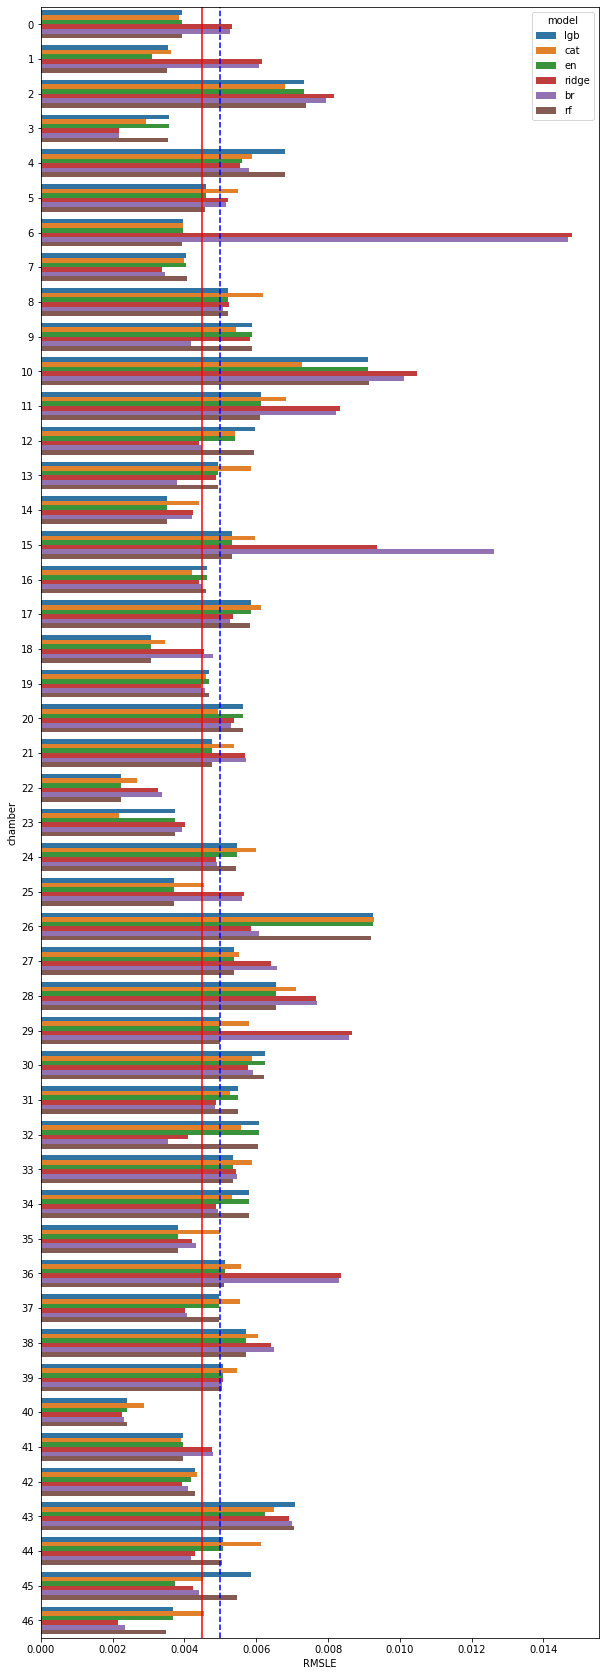

In [32]:
score_df = pd.DataFrame({'model':['lgb']*47 + ['cat']*47 + ['en']*47 + ['ridge']*47 + ['br']*47 + ['rf']*47,
                         'chamber': list(range(0,47))*6,
                         'RMSLE' : lgb_scores + cat_scores + en_scores + ridge_scores + br_scores + rf_scores})

fig = plt.figure(figsize = (10, 30))
sns.barplot(data = score_df, orient = 'h', x = 'RMSLE', y = 'chamber', hue = 'model')
plt.axvline(0.005, color='b', linestyle='--')
plt.axvline(0.0045, color='r')

In [33]:
score_df.pivot('chamber', 'model', 'RMSLE')

model,br,cat,en,lgb,rf,ridge
chamber,,,,,,
0,0.005280,0.003833,0.003926,0.003926,0.003923,0.005319
1,0.006072,0.003625,0.003103,0.003532,0.003515,0.006163
2,0.007942,0.006802,0.007342,0.007342,0.007377,0.008171
3,0.002183,0.002933,0.003570,0.003570,0.003553,0.002176
4,0.005804,0.005889,0.005594,0.006802,0.006798,0.005560
5,0.005167,0.005478,0.004593,0.004593,0.004573,0.005202
6,0.014692,0.003953,0.003947,0.003947,0.003941,0.014810
7,0.003455,0.003992,0.004055,0.004055,0.004063,0.003368
8,0.005074,0.006197,0.005209,0.005209,0.005203,0.005248


# 챔버별 성능이 좋은 것으로 보이는 모델들을 선택하여 voting ensemble 진행

In [34]:
# (건물 별 모델 cv score 의 pivot_q quantile 값*threshold) 보다 작은 cv score를 가진 모델만 건물별로 선택
def good_models(score_df, pivot_q, threshold):
    score_pivot = pd.DataFrame(score_df.pivot('chamber', 'model', 'RMSLE').values,
                               columns = ['br','cat','en','lgb','rf','ridge'])
    li = []
    for i in range(len(score_pivot)):
        temp = score_pivot.iloc[i]
        q = temp.quantile(pivot_q)
        best = list(temp[temp <= threshold*q].index)
        li.append(best)
    return li

In [35]:
best_models = good_models(score_df, 0.1, 1.1)
best_models

[['cat', 'en', 'lgb', 'rf'],
 ['cat', 'en', 'lgb', 'rf'],
 ['cat', 'en', 'lgb', 'rf'],
 ['br', 'ridge'],
 ['br', 'cat', 'en', 'ridge'],
 ['en', 'lgb', 'rf'],
 ['cat', 'en', 'lgb', 'rf'],
 ['br', 'ridge'],
 ['br', 'en', 'lgb', 'rf', 'ridge'],
 ['br'],
 ['cat'],
 ['en', 'lgb', 'rf'],
 ['br', 'ridge'],
 ['br'],
 ['en', 'lgb', 'rf'],
 ['en', 'lgb', 'rf'],
 ['br', 'cat', 'en', 'lgb', 'rf', 'ridge'],
 ['br', 'en', 'lgb', 'rf', 'ridge'],
 ['en', 'lgb', 'rf'],
 ['br', 'cat', 'en', 'lgb', 'rf', 'ridge'],
 ['br', 'cat', 'rf', 'ridge'],
 ['en', 'lgb', 'rf'],
 ['en', 'lgb', 'rf'],
 ['cat'],
 ['br', 'ridge'],
 ['en', 'lgb', 'rf'],
 ['br', 'ridge'],
 ['cat', 'en', 'lgb', 'rf'],
 ['cat', 'en', 'lgb', 'rf'],
 ['en', 'lgb', 'rf'],
 ['br', 'cat', 'en', 'lgb', 'rf', 'ridge'],
 ['br', 'cat', 'ridge'],
 ['br', 'ridge'],
 ['br', 'en', 'lgb', 'rf', 'ridge'],
 ['br', 'cat', 'ridge'],
 ['en', 'lgb', 'rf'],
 ['cat', 'en', 'lgb', 'rf'],
 ['br', 'ridge'],
 ['cat', 'en', 'lgb', 'rf'],
 ['br', 'cat', 'en', 'lgb', '

# Voting Ensemble Regressor Submission

In [36]:
# voting ensemble training & inference
bests = good_models(score_df, 0.1, 1.1)
voting_pred = []
for i, (X_test, num_f, best, l, c, e, r, br, randomf) in enumerate(zip(df_predicts, num_features_lst, bests, lgbs, cats, ens, ridges, brs, rfs)):
    pred = []
    if 'cat' in best:
        cat = c
        pred.append(cat.predict(X_test[num_f]))
    if 'lgb' in best:
        lgb = l
        pred.append(lgb.predict(X_test[num_f]))
    if 'en' in best:
        en = e
        pred.append(en.predict(X_test[num_f]))
    if 'ridge' in best:
        rid = r
        pred.append(rid.predict(X_test[num_f]))
    if 'br' in best:
        bayer = br
        pred.append(bayer.predict(X_test[num_f]))
    if 'rf' in best:
        randomf_ = randomf
        pred.append(randomf_.predict(X_test[num_f]))
    
    voting_pred.append(np.expm1(np.array(pred).mean(axis = 0)))

    print (f'model{i+1} prediction complete')
voting_pred = np.concatenate(voting_pred)

model1 prediction complete
model2 prediction complete
model3 prediction complete
model4 prediction complete
model5 prediction complete
model6 prediction complete
model7 prediction complete
model8 prediction complete
model9 prediction complete
model10 prediction complete
model11 prediction complete
model12 prediction complete
model13 prediction complete
model14 prediction complete
model15 prediction complete
model16 prediction complete
model17 prediction complete
model18 prediction complete
model19 prediction complete
model20 prediction complete
model21 prediction complete
model22 prediction complete
model23 prediction complete
model24 prediction complete
model25 prediction complete
model26 prediction complete
model27 prediction complete
model28 prediction complete
model29 prediction complete
model30 prediction complete
model31 prediction complete
model32 prediction complete
model33 prediction complete
model34 prediction complete
model35 prediction complete
model36 prediction complete
m

In [37]:
voting_pred

array([1256.87964249, 1256.68244502, 1256.78770534, 1256.75076896,
       1256.77285285, 1262.10525493, 1261.95466165, 1262.9890419 ,
       1263.14569757, 1263.60523927, 1262.99084445, 1263.09910441,
       1262.59494445, 1260.68491448, 1260.49484754, 1259.38752619,
       1259.28792955, 1259.47275901, 1260.53820566, 1272.56474981,
       1353.9483641 , 1355.74836456, 1351.92244517, 1349.92508197,
       1348.7912886 , 1349.45555257, 1261.3668772 , 1267.14358153,
       1251.93042259, 1251.98642527, 1253.43062395, 1252.32995008,
       1264.08104874, 1264.08104874, 1264.08104874, 1264.08104874,
       1264.08104874, 1264.08104874, 1260.35530385, 1259.74584565,
       1260.18873244, 1259.73754466, 1260.30776415, 1260.05351403,
       1272.65904807, 1275.88930216, 1218.04672938, 1213.65572535,
       1212.94215187, 1311.86191657, 1312.18171122, 1309.16964056,
       1309.02093457, 1309.51574647, 1309.3376122 , 1248.68063258,
       1245.40598611, 1275.71195704, 1275.65507419, 1275.77903

# 제출 후 후처리

모든 모델들의 성능이 안좋은 chamber들에 대해서, 오버샘플링 진행

In [ ]:
from imblearn.over_sampling import SMOTE
import smote_variants as sv

In [ ]:
smote = SMOTE(ratio='', kind='')
''' 꼭 train, test set 나눠서 적용해야한다. '''
X_train_over,y_train_over = smote.fit_sample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())


oversampler= sv.MulticlassOversampling(sv.distance_SMOTE())
X_samp, y_samp= oversampler.sample(X, y)

standardscaler 사용해서 dataset을 표준화시키고 진행 해보자.

In [40]:
pred = []
for i, (df,model,num_f) in enumerate(zip(df_predicts, cats, num_features_lst)):
    cat_pred = model.predict(df[num_f])
    pred.extend(cat_pred)

In [42]:
predict['msure_val'] = np.exp(pred)
df_submission = predict[['key_val', 'msure_val']] 
df_submission.head()

,key_val,msure_val
0,LOT380_17,1261.760147
1,LOT122_18,1261.856718
2,LOT313_18,1260.504234
3,LOT459_12,1251.315713
4,LOT459_18,1250.478422


In [43]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_24.csv')

#### Lasso

In [55]:
ls = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_ls(trial):
        param = {
          "random_state":42,
            'alpha':trial.suggest_float("alpha",0.1,20),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = Lasso(**param)
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=71)

        model.fit(
            X_train, y_train
            )
        ls_pred = model.predict(X_valid)
        rmsle_val = np.sqrt(mean_squared_error(y_valid, ls_pred))

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study = optuna.create_study(
            study_name="Lasso_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study.optimize(objective_ls, n_trials=10)
    print("Best Score:", study.best_value)
    print("Best trial:", study.best_trial.params)
    
    model = Lasso(**study.best_params)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{} model training is completed'.format(i))
    ls.append(model)


[I 2022-07-10 21:52:30,147] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:30,161] Trial 0 finished with value: 0.0024541196875053324 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0024541196875053324.
[I 2022-07-10 21:52:30,184] Trial 1 finished with value: 0.004590040123429382 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0024541196875053324.
[I 2022-07-10 21:52:30,197] Trial 2 finished with value: 0.0024541196875053324 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0024541196875053324.
[I 2022-07-10 21:52:30,221] Trial 3 finished with value: 0.004288776337418062 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0024541196875053324.
[I 2022-07-10 21:52:30,244] Trial 4 

Best Score: 0.0024541196875053324
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
0 model training is completed


[I 2022-07-10 21:52:30,552] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:30,568] Trial 0 finished with value: 0.017539512539649936 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.017539512539649936.
[I 2022-07-10 21:52:30,593] Trial 1 finished with value: 0.023742935250755406 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.017539512539649936.
[I 2022-07-10 21:52:30,607] Trial 2 finished with value: 0.017539512539649936 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.017539512539649936.
[I 2022-07-10 21:52:30,632] Trial 3 finished with value: 0.02492532628618527 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.017539512539649936.
[I 2022-07-10 21:52:30,656] Trial 4 finishe

Best Score: 0.005331528598276138
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
1 model training is completed


[I 2022-07-10 21:52:30,748] Trial 9 finished with value: 0.07514444254593164 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.017539512539649936.
[I 2022-07-10 21:52:30,758] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:30,772] Trial 0 finished with value: 0.0033848090221118643 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0033848090221118643.
[I 2022-07-10 21:52:30,801] Trial 1 finished with value: 0.004312640245600342 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0033848090221118643.
[I 2022-07-10 21:52:30,815] Trial 2 finished with value: 0.0033848090221118643 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0033848090221118643.
[I 2022-07-10 21:52:30,841] Trial 3 fi

Best Score: 0.017539512539649936
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
2 model training is completed


[I 2022-07-10 21:52:30,958] Trial 9 finished with value: 0.006652675083798682 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0033848090221118643.
[I 2022-07-10 21:52:30,970] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:30,985] Trial 0 finished with value: 0.004584071589542365 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004584071589542365.
[I 2022-07-10 21:52:31,014] Trial 1 finished with value: 0.02456039344792084 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004584071589542365.
[I 2022-07-10 21:52:31,028] Trial 2 finished with value: 0.004584071589542365 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004584071589542365.
[I 2022-07-10 21:52:31,053] Trial 3 finish

Best Score: 0.0033848090221118643
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
3 model training is completed


[I 2022-07-10 21:52:31,181] Trial 9 finished with value: 0.06766093135338079 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004584071589542365.
[I 2022-07-10 21:52:31,190] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:31,205] Trial 0 finished with value: 0.005793779078693501 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005793779078693501.
[I 2022-07-10 21:52:31,236] Trial 1 finished with value: 0.009628367122116642 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005793779078693501.
[I 2022-07-10 21:52:31,250] Trial 2 finished with value: 0.005793779078693501 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005793779078693501.
[I 2022-07-10 21:52:31,278] Trial 3 finishe

Best Score: 0.004584071589542365
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
4 model training is completed


[I 2022-07-10 21:52:31,389] Trial 8 finished with value: 0.005793779078693501 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005793779078693501.
[I 2022-07-10 21:52:31,426] Trial 9 finished with value: 0.028952473399278953 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005793779078693501.
[I 2022-07-10 21:52:31,437] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:31,460] Trial 0 finished with value: 0.0024856747994464567 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0024856747994464567.
[I 2022-07-10 21:52:31,489] Trial 1 finished with value: 0.006370104141333485 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0024856747994464567.
[I 2022-07-10 21:52:31,504] Trial 2 fin

Best Score: 0.005793779078693501
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
5 model training is completed


[I 2022-07-10 21:52:31,621] Trial 8 finished with value: 0.0024856747994464567 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0024856747994464567.
[I 2022-07-10 21:52:31,645] Trial 9 finished with value: 0.00457732163231352 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0024856747994464567.
[I 2022-07-10 21:52:31,655] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:31,667] Trial 0 finished with value: 0.004929722750851463 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004929722750851463.
[I 2022-07-10 21:52:31,697] Trial 1 finished with value: 0.021697273034372806 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004929722750851463.
[I 2022-07-10 21:52:31,713] Trial 2 fini

Best Score: 0.0024856747994464567
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
6 model training is completed


[I 2022-07-10 21:52:31,858] Trial 9 finished with value: 0.052276763447106335 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004929722750851463.
[I 2022-07-10 21:52:31,866] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:31,879] Trial 0 finished with value: 0.009796758797896111 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009796758797896111.
[I 2022-07-10 21:52:31,903] Trial 1 finished with value: 0.011156368025154526 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.009796758797896111.
[I 2022-07-10 21:52:31,918] Trial 2 finished with value: 0.009796758797896111 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009796758797896111.
[I 2022-07-10 21:52:31,948] Trial 3 finish

Best Score: 0.004929722750851463
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
7 model training is completed


[I 2022-07-10 21:52:32,066] Trial 9 finished with value: 0.012362411209560152 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.009796758797896111.
[I 2022-07-10 21:52:32,074] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:32,087] Trial 0 finished with value: 0.005977939993228887 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005977939993228887.
[I 2022-07-10 21:52:32,112] Trial 1 finished with value: 0.010273340921393252 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005977939993228887.
[I 2022-07-10 21:52:32,126] Trial 2 finished with value: 0.005977939993228887 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005977939993228887.
[I 2022-07-10 21:52:32,152] Trial 3 finish

Best Score: 0.009796758797896111
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
8 model training is completed


[I 2022-07-10 21:52:32,269] Trial 9 finished with value: 0.005871662565667956 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005846096603134695.
[I 2022-07-10 21:52:32,287] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:32,300] Trial 0 finished with value: 0.010747377669623536 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.010747377669623536.
[I 2022-07-10 21:52:32,325] Trial 1 finished with value: 0.00685493949610532 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.00685493949610532.
[I 2022-07-10 21:52:32,338] Trial 2 finished with value: 0.010747377669623536 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.00685493949610532.
[I 2022-07-10 21:52:32,362] Trial 3 finished 

Best Score: 0.005846096603134695
Best trial: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}
9 model training is completed


[I 2022-07-10 21:52:32,476] Trial 9 finished with value: 0.02084932078731616 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.00685493949610532.
[I 2022-07-10 21:52:32,496] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:32,509] Trial 0 finished with value: 0.0090480978791713 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0090480978791713.
[I 2022-07-10 21:52:32,532] Trial 1 finished with value: 0.008234842200622547 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.008234842200622547.
[I 2022-07-10 21:52:32,545] Trial 2 finished with value: 0.0090480978791713 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.008234842200622547.
[I 2022-07-10 21:52:32,569] Trial 3 finished with 

Best Score: 0.00685493949610532
Best trial: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}
10 model training is completed


[I 2022-07-10 21:52:32,657] Trial 8 finished with value: 0.0090480978791713 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 4 with value: 0.007746448986965465.
[I 2022-07-10 21:52:32,683] Trial 9 finished with value: 0.012311121736763077 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 4 with value: 0.007746448986965465.
[I 2022-07-10 21:52:32,703] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:32,719] Trial 0 finished with value: 0.007752771131003385 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007752771131003385.
[I 2022-07-10 21:52:32,745] Trial 1 finished with value: 0.00999207980484189 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.007752771131003385.
[I 2022-07-10 21:52:32,758] Trial 2 finished 

Best Score: 0.007746448986965465
Best trial: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}
11 model training is completed


[I 2022-07-10 21:52:32,896] Trial 9 finished with value: 0.01210351830769542 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.007752771131003385.
[I 2022-07-10 21:52:32,904] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:32,917] Trial 0 finished with value: 0.006877071718230332 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006877071718230332.
[I 2022-07-10 21:52:32,943] Trial 1 finished with value: 0.012842524623926417 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006877071718230332.
[I 2022-07-10 21:52:32,956] Trial 2 finished with value: 0.006877071718230332 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006877071718230332.
[I 2022-07-10 21:52:32,981] Trial 3 finishe

Best Score: 0.007752771131003385
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
12 model training is completed


[I 2022-07-10 21:52:33,098] Trial 9 finished with value: 0.026064901146710402 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006877071718230332.
[I 2022-07-10 21:52:33,109] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:33,123] Trial 0 finished with value: 0.006198244244211704 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006198244244211704.
[I 2022-07-10 21:52:33,147] Trial 1 finished with value: 0.007056955344456118 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006198244244211704.
[I 2022-07-10 21:52:33,161] Trial 2 finished with value: 0.006198244244211704 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006198244244211704.
[I 2022-07-10 21:52:33,186] Trial 3 finish

Best Score: 0.006877071718230332
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
13 model training is completed


[I 2022-07-10 21:52:33,306] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:33,318] Trial 0 finished with value: 0.0038757983936008236 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0038757983936008236.
[I 2022-07-10 21:52:33,342] Trial 1 finished with value: 0.0026267726704547563 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0026267726704547563.
[I 2022-07-10 21:52:33,355] Trial 2 finished with value: 0.0038757983936008236 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.0026267726704547563.
[I 2022-07-10 21:52:33,380] Trial 3 finished with value: 0.002607551676877481 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.002607551676877481.
[I 2022-07-10 21:52:33,404] Trial 4 

Best Score: 0.006198244244211704
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
14 model training is completed


[I 2022-07-10 21:52:33,513] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:33,526] Trial 0 finished with value: 0.004966922830114733 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004966922830114733.
[I 2022-07-10 21:52:33,550] Trial 1 finished with value: 0.01073727735306841 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004966922830114733.
[I 2022-07-10 21:52:33,563] Trial 2 finished with value: 0.004966922830114733 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004966922830114733.
[I 2022-07-10 21:52:33,586] Trial 3 finished with value: 0.012917318011924627 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004966922830114733.
[I 2022-07-10 21:52:33,610] Trial 4 finishe

Best Score: 0.002607551676877481
Best trial: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}
15 model training is completed


[I 2022-07-10 21:52:33,703] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:33,715] Trial 0 finished with value: 0.00683938762613788 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00683938762613788.
[I 2022-07-10 21:52:33,741] Trial 1 finished with value: 0.015620551627257041 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00683938762613788.
[I 2022-07-10 21:52:33,754] Trial 2 finished with value: 0.00683938762613788 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00683938762613788.
[I 2022-07-10 21:52:33,778] Trial 3 finished with value: 0.017076568105045452 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.00683938762613788.
[I 2022-07-10 21:52:33,802] Trial 4 finished wit

Best Score: 0.004966922830114733
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
16 model training is completed


[I 2022-07-10 21:52:33,897] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:33,910] Trial 0 finished with value: 0.007139819398248521 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007139819398248521.
[I 2022-07-10 21:52:33,934] Trial 1 finished with value: 0.01425879713081042 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.007139819398248521.
[I 2022-07-10 21:52:33,948] Trial 2 finished with value: 0.007139819398248521 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007139819398248521.
[I 2022-07-10 21:52:33,971] Trial 3 finished with value: 0.015599715028430045 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.007139819398248521.
[I 2022-07-10 21:52:33,994] Trial 4 finishe

Best Score: 0.00683938762613788
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
17 model training is completed


[I 2022-07-10 21:52:34,088] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:34,101] Trial 0 finished with value: 0.0068490419069545255 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0068490419069545255.
[I 2022-07-10 21:52:34,124] Trial 1 finished with value: 0.007783289943640611 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0068490419069545255.
[I 2022-07-10 21:52:34,137] Trial 2 finished with value: 0.0068490419069545255 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0068490419069545255.
[I 2022-07-10 21:52:34,161] Trial 3 finished with value: 0.009350363098194911 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0068490419069545255.
[I 2022-07-10 21:52:34,184] Trial 4 

Best Score: 0.007139819398248521
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
18 model training is completed


[I 2022-07-10 21:52:34,278] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:34,290] Trial 0 finished with value: 0.002035653272411844 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.002035653272411844.
[I 2022-07-10 21:52:34,313] Trial 1 finished with value: 0.002171478948236414 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.002035653272411844.
[I 2022-07-10 21:52:34,326] Trial 2 finished with value: 0.002035653272411844 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.002035653272411844.
[I 2022-07-10 21:52:34,349] Trial 3 finished with value: 0.0023383009530876277 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.002035653272411844.
[I 2022-07-10 21:52:34,372] Trial 4 finis

Best Score: 0.0068490419069545255
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
19 model training is completed
Best Score: 0.002035653272411844
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}


[I 2022-07-10 21:52:34,466] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:34,479] Trial 0 finished with value: 0.005126757116393915 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005126757116393915.
[I 2022-07-10 21:52:34,503] Trial 1 finished with value: 0.016035004856374886 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005126757116393915.
[I 2022-07-10 21:52:34,516] Trial 2 finished with value: 0.005126757116393915 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005126757116393915.
[I 2022-07-10 21:52:34,541] Trial 3 finished with value: 0.019015916145114862 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005126757116393915.
[I 2022-07-10 21:52:34,565] Trial 4 finish

20 model training is completed


[I 2022-07-10 21:52:34,662] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:34,675] Trial 0 finished with value: 0.0015672335803843076 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0015672335803843076.
[I 2022-07-10 21:52:34,699] Trial 1 finished with value: 0.01417318321352753 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0015672335803843076.
[I 2022-07-10 21:52:34,713] Trial 2 finished with value: 0.0015672335803843076 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0015672335803843076.
[I 2022-07-10 21:52:34,737] Trial 3 finished with value: 0.015997429657792203 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0015672335803843076.
[I 2022-07-10 21:52:34,761] Trial 4 f

Best Score: 0.005126757116393915
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
21 model training is completed


[I 2022-07-10 21:52:34,855] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:34,868] Trial 0 finished with value: 0.00681059642522169 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00681059642522169.
[I 2022-07-10 21:52:34,892] Trial 1 finished with value: 0.022332388853769387 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00681059642522169.
[I 2022-07-10 21:52:34,905] Trial 2 finished with value: 0.00681059642522169 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00681059642522169.
[I 2022-07-10 21:52:34,929] Trial 3 finished with value: 0.02403748928294343 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.00681059642522169.
[I 2022-07-10 21:52:34,957] Trial 4 finished with

Best Score: 0.0015672335803843076
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
22 model training is completed


[I 2022-07-10 21:52:35,059] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:35,074] Trial 0 finished with value: 0.006382362275516266 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006382362275516266.
[I 2022-07-10 21:52:35,100] Trial 1 finished with value: 0.008182414236730341 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006382362275516266.
[I 2022-07-10 21:52:35,114] Trial 2 finished with value: 0.006382362275516266 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006382362275516266.
[I 2022-07-10 21:52:35,138] Trial 3 finished with value: 0.008472771696188134 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006382362275516266.
[I 2022-07-10 21:52:35,161] Trial 4 finish

Best Score: 0.00681059642522169
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
23 model training is completed


[I 2022-07-10 21:52:35,279] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:35,293] Trial 0 finished with value: 0.005389737611222409 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005389737611222409.
[I 2022-07-10 21:52:35,322] Trial 1 finished with value: 0.012465620417140116 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005389737611222409.
[I 2022-07-10 21:52:35,335] Trial 2 finished with value: 0.005389737611222409 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005389737611222409.
[I 2022-07-10 21:52:35,361] Trial 3 finished with value: 0.01239683381674315 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005389737611222409.
[I 2022-07-10 21:52:35,387] Trial 4 finishe

Best Score: 0.004591479753003945
Best trial: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}
24 model training is completed


[I 2022-07-10 21:52:35,455] Trial 8 finished with value: 0.005389737611222409 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005389737611222409.
[I 2022-07-10 21:52:35,482] Trial 9 finished with value: 0.010281641113411366 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005389737611222409.
[I 2022-07-10 21:52:35,492] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:35,506] Trial 0 finished with value: 0.008105452457802904 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.008105452457802904.
[I 2022-07-10 21:52:35,533] Trial 1 finished with value: 0.02247864635030073 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.008105452457802904.
[I 2022-07-10 21:52:35,546] Trial 2 finishe

Best Score: 0.005389737611222409
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
25 model training is completed


[I 2022-07-10 21:52:35,695] Trial 9 finished with value: 0.03545701862222399 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.008105452457802904.
[I 2022-07-10 21:52:35,704] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:35,718] Trial 0 finished with value: 0.007413675672553313 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007413675672553313.
[I 2022-07-10 21:52:35,743] Trial 1 finished with value: 0.01179909531694119 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.007413675672553313.
[I 2022-07-10 21:52:35,757] Trial 2 finished with value: 0.007413675672553313 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007413675672553313.
[I 2022-07-10 21:52:35,784] Trial 3 finished

Best Score: 0.008105452457802904
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
26 model training is completed


[I 2022-07-10 21:52:35,875] Trial 8 finished with value: 0.007413675672553313 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007413675672553313.
[I 2022-07-10 21:52:35,902] Trial 9 finished with value: 0.007276693297200346 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 9 with value: 0.007276693297200346.
[I 2022-07-10 21:52:35,923] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:35,936] Trial 0 finished with value: 0.0105743706765607 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0105743706765607.
[I 2022-07-10 21:52:35,961] Trial 1 finished with value: 0.009585805377332387 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.009585805377332387.
[I 2022-07-10 21:52:35,975] Trial 2 finished w

Best Score: 0.007276693297200346
Best trial: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}
27 model training is completed


[I 2022-07-10 21:52:36,117] Trial 9 finished with value: 0.027046031590344684 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.009585805377332387.
[I 2022-07-10 21:52:36,138] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:36,151] Trial 0 finished with value: 0.002858691504084784 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.002858691504084784.
[I 2022-07-10 21:52:36,175] Trial 1 finished with value: 0.0044705824275458345 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.002858691504084784.
[I 2022-07-10 21:52:36,187] Trial 2 finished with value: 0.002858691504084784 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.002858691504084784.
[I 2022-07-10 21:52:36,212] Trial 3 finis

Best Score: 0.009585805377332387
Best trial: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}
28 model training is completed


[I 2022-07-10 21:52:36,332] Trial 9 finished with value: 0.016494277108309117 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.002858691504084784.
[I 2022-07-10 21:52:36,340] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:36,353] Trial 0 finished with value: 0.007548583021425898 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007548583021425898.
[I 2022-07-10 21:52:36,378] Trial 1 finished with value: 0.006329735949940594 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006329735949940594.
[I 2022-07-10 21:52:36,390] Trial 2 finished with value: 0.007548583021425898 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.006329735949940594.
[I 2022-07-10 21:52:36,413] Trial 3 finish

Best Score: 0.002858691504084784
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
29 model training is completed


[I 2022-07-10 21:52:36,539] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:36,552] Trial 0 finished with value: 0.005807424105754044 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005807424105754044.
[I 2022-07-10 21:52:36,578] Trial 1 finished with value: 0.013231924219108316 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005807424105754044.
[I 2022-07-10 21:52:36,591] Trial 2 finished with value: 0.005807424105754044 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005807424105754044.
[I 2022-07-10 21:52:36,616] Trial 3 finished with value: 0.01442797116492097 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005807424105754044.
[I 2022-07-10 21:52:36,640] Trial 4 finishe

Best Score: 0.004344987991935335
Best trial: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}
30 model training is completed


[I 2022-07-10 21:52:36,733] Trial 9 finished with value: 0.037210147828892357 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005807424105754044.
[I 2022-07-10 21:52:36,742] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:36,755] Trial 0 finished with value: 0.003948318056142591 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003948318056142591.
[I 2022-07-10 21:52:36,780] Trial 1 finished with value: 0.010108102397610558 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003948318056142591.
[I 2022-07-10 21:52:36,795] Trial 2 finished with value: 0.003948318056142591 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003948318056142591.
[I 2022-07-10 21:52:36,820] Trial 3 finish

Best Score: 0.005807424105754044
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
31 model training is completed


[I 2022-07-10 21:52:36,933] Trial 9 finished with value: 0.010564299387188527 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003948318056142591.
[I 2022-07-10 21:52:36,942] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:36,954] Trial 0 finished with value: 0.010996457753074491 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.010996457753074491.
[I 2022-07-10 21:52:36,980] Trial 1 finished with value: 0.02235330574436427 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.010996457753074491.
[I 2022-07-10 21:52:36,993] Trial 2 finished with value: 0.010996457753074491 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.010996457753074491.
[I 2022-07-10 21:52:37,017] Trial 3 finishe

Best Score: 0.003948318056142591
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
32 model training is completed


[I 2022-07-10 21:52:37,138] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:37,151] Trial 0 finished with value: 0.00844940489818558 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00844940489818558.
[I 2022-07-10 21:52:37,176] Trial 1 finished with value: 0.003752290861088443 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003752290861088443.
[I 2022-07-10 21:52:37,189] Trial 2 finished with value: 0.00844940489818558 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.003752290861088443.
[I 2022-07-10 21:52:37,213] Trial 3 finished with value: 0.004186699871500359 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.003752290861088443.
[I 2022-07-10 21:52:37,237] Trial 4 finished 

Best Score: 0.010996457753074491
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
33 model training is completed


[I 2022-07-10 21:52:37,350] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:37,364] Trial 0 finished with value: 0.004483541630558051 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004483541630558051.
[I 2022-07-10 21:52:37,389] Trial 1 finished with value: 0.015732964907912712 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004483541630558051.
[I 2022-07-10 21:52:37,403] Trial 2 finished with value: 0.004483541630558051 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004483541630558051.
[I 2022-07-10 21:52:37,428] Trial 3 finished with value: 0.016841628623806375 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004483541630558051.
[I 2022-07-10 21:52:37,453] Trial 4 finish

Best Score: 0.003752290861088443
Best trial: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}
34 model training is completed


[I 2022-07-10 21:52:37,516] Trial 8 finished with value: 0.004483541630558051 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004483541630558051.
[I 2022-07-10 21:52:37,542] Trial 9 finished with value: 0.015120663340203355 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004483541630558051.
[I 2022-07-10 21:52:37,550] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:37,562] Trial 0 finished with value: 0.005512705188285805 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005512705188285805.
[I 2022-07-10 21:52:37,586] Trial 1 finished with value: 0.011237144580282667 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005512705188285805.
[I 2022-07-10 21:52:37,599] Trial 2 finish

Best Score: 0.004483541630558051
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
35 model training is completed


[I 2022-07-10 21:52:37,744] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:37,757] Trial 0 finished with value: 0.006210097560755313 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006210097560755313.
[I 2022-07-10 21:52:37,781] Trial 1 finished with value: 0.010898872239712606 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006210097560755313.
[I 2022-07-10 21:52:37,795] Trial 2 finished with value: 0.006210097560755313 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006210097560755313.
[I 2022-07-10 21:52:37,820] Trial 3 finished with value: 0.013058644779025803 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006210097560755313.
[I 2022-07-10 21:52:37,843] Trial 4 finish

Best Score: 0.005512705188285805
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
36 model training is completed


[I 2022-07-10 21:52:37,933] Trial 9 finished with value: 0.04503778198032538 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006210097560755313.
[I 2022-07-10 21:52:37,941] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:37,953] Trial 0 finished with value: 0.006227870762608383 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006227870762608383.
[I 2022-07-10 21:52:37,975] Trial 1 finished with value: 0.025488909300492423 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006227870762608383.
[I 2022-07-10 21:52:37,988] Trial 2 finished with value: 0.006227870762608383 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006227870762608383.
[I 2022-07-10 21:52:38,013] Trial 3 finishe

Best Score: 0.006210097560755313
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
37 model training is completed


[I 2022-07-10 21:52:38,130] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:38,143] Trial 0 finished with value: 0.004867294447192986 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004867294447192986.
[I 2022-07-10 21:52:38,167] Trial 1 finished with value: 0.021843516064570852 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004867294447192986.
[I 2022-07-10 21:52:38,180] Trial 2 finished with value: 0.004867294447192986 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004867294447192986.
[I 2022-07-10 21:52:38,204] Trial 3 finished with value: 0.024807907208807704 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004867294447192986.
[I 2022-07-10 21:52:38,228] Trial 4 finish

Best Score: 0.006227870762608383
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
38 model training is completed


[I 2022-07-10 21:52:38,322] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:38,334] Trial 0 finished with value: 0.0016986256201322095 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0016986256201322095.
[I 2022-07-10 21:52:38,359] Trial 1 finished with value: 0.00487038596862697 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0016986256201322095.
[I 2022-07-10 21:52:38,373] Trial 2 finished with value: 0.0016986256201322095 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0016986256201322095.
[I 2022-07-10 21:52:38,398] Trial 3 finished with value: 0.004473004641336842 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0016986256201322095.
[I 2022-07-10 21:52:38,421] Trial 4 f

Best Score: 0.004867294447192986
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
39 model training is completed


[I 2022-07-10 21:52:38,519] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:38,532] Trial 0 finished with value: 0.006533974864757643 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006533974864757643.
[I 2022-07-10 21:52:38,557] Trial 1 finished with value: 0.006477802777099645 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006477802777099645.
[I 2022-07-10 21:52:38,571] Trial 2 finished with value: 0.006533974864757643 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.006477802777099645.
[I 2022-07-10 21:52:38,595] Trial 3 finished with value: 0.007036398902224908 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.006477802777099645.
[I 2022-07-10 21:52:38,622] Trial 4 finish

Best Score: 0.0016986256201322095
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
40 model training is completed


[I 2022-07-10 21:52:38,732] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:38,746] Trial 0 finished with value: 0.004825583433100067 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004825583433100067.
[I 2022-07-10 21:52:38,772] Trial 1 finished with value: 0.007807597149707352 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004825583433100067.
[I 2022-07-10 21:52:38,785] Trial 2 finished with value: 0.004825583433100067 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004825583433100067.
[I 2022-07-10 21:52:38,809] Trial 3 finished with value: 0.008022293765321462 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004825583433100067.
[I 2022-07-10 21:52:38,832] Trial 4 finish

Best Score: 0.006477802777099645
Best trial: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}
41 model training is completed


[I 2022-07-10 21:52:38,921] Trial 9 finished with value: 0.012242572716791368 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004825583433100067.
[I 2022-07-10 21:52:38,929] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:38,943] Trial 0 finished with value: 0.008617194115711636 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.008617194115711636.
[I 2022-07-10 21:52:38,967] Trial 1 finished with value: 0.006947542137162581 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006947542137162581.
[I 2022-07-10 21:52:38,980] Trial 2 finished with value: 0.008617194115711636 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.006947542137162581.
[I 2022-07-10 21:52:39,003] Trial 3 finish

Best Score: 0.004825583433100067
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
42 model training is completed


[I 2022-07-10 21:52:39,130] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:39,143] Trial 0 finished with value: 0.010701255912476759 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.010701255912476759.
[I 2022-07-10 21:52:39,167] Trial 1 finished with value: 0.017799145966099134 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.010701255912476759.
[I 2022-07-10 21:52:39,180] Trial 2 finished with value: 0.010701255912476759 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.010701255912476759.
[I 2022-07-10 21:52:39,205] Trial 3 finished with value: 0.0175949471397042 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.010701255912476759.
[I 2022-07-10 21:52:39,229] Trial 4 finished

Best Score: 0.006947542137162581
Best trial: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}
43 model training is completed


[I 2022-07-10 21:52:39,318] Trial 9 finished with value: 0.015940499081934355 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.010701255912476759.
[I 2022-07-10 21:52:39,326] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:39,340] Trial 0 finished with value: 0.0044044152475442916 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0044044152475442916.
[I 2022-07-10 21:52:39,365] Trial 1 finished with value: 0.001395156895100271 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.001395156895100271.
[I 2022-07-10 21:52:39,378] Trial 2 finished with value: 0.0044044152475442916 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.001395156895100271.
[I 2022-07-10 21:52:39,404] Trial 3 fin

Best Score: 0.010701255912476759
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
44 model training is completed


[I 2022-07-10 21:52:39,518] Trial 9 finished with value: 0.0035325457439769965 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.0013939877525972518.
[I 2022-07-10 21:52:39,538] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:39,551] Trial 0 finished with value: 0.004382647818819491 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004382647818819491.
[I 2022-07-10 21:52:39,577] Trial 1 finished with value: 0.006867166026378242 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004382647818819491.
[I 2022-07-10 21:52:39,589] Trial 2 finished with value: 0.004382647818819491 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004382647818819491.
[I 2022-07-10 21:52:39,615] Trial 3 fini

Best Score: 0.0013939877525972518
Best trial: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}
45 model training is completed


[I 2022-07-10 21:52:39,732] Trial 9 finished with value: 0.012931400412281264 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004382647818819491.


Best Score: 0.004382647818819491
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
46 model training is completed


In [56]:
models = [cats,ridges,ens,brs,ls]
for i,model_all_chamber in enumerate(models):
    for j, (df,model_by_chamber,num_f) in enumerate(zip(df_predicts, model_all_chamber, num_features_lst)):
        pred_by_chamber = model_by_chamber.predict(df[num_f])
        predict.loc[df.index, 'pred_{}'.format(i)] = pred_by_chamber

In [ ]:
pred = []
for i, (df,model,num_f) in enumerate(zip(df_predicts, cats, num_features_lst)):
    cat_pred = model.predict(df[num_f])
    pred.extend(cat_pred)

In [58]:
predict.isnull().values.any()

False

In [64]:
predict['msure_val'] = np.mean(np.exp(predict.filter(regex='^pred')), axis=1)
df_submission = predict[['key_val','msure_val']]
df_submission.head()

,key_val,msure_val
0,LOT380_17,1260.819002
1,LOT122_18,1259.871842
2,LOT313_18,1259.037131
3,LOT459_12,1257.259503
4,LOT459_18,1257.170748


In [65]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_25.csv')

# Feature Selection

In [156]:
from probatus.feature_elimination import EarlyStoppingShapRFECV

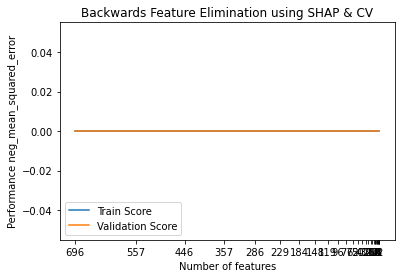

In [158]:
# Run feature elimination
shap_elimination = EarlyStoppingShapRFECV(
    clf=model_xgb, step=0.2, cv=10, scoring='neg_mean_squared_error', early_stopping_rounds=15, n_jobs=-1, eval_metric='rmse')
report = shap_elimination.fit_compute(df_final[COLS], np.log1p(df_final['y']))

# Make plots
performance_plot = shap_elimination.plot()

In [ ]:
report

In [159]:
# Get final feature set
''' num_features는 마지막에 남길 feature 수임. '''
final_features_set = shap_elimination.get_reduced_features_set(num_features=77)

The provided number of features has not been achieved at any stage of the process. You can select one of the following: [402, 322, 258, 207, 166, 133, 107, 86, 69, 56, 45, 36, 29, 24, 20, 16, 13, 11, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [160]:
final_features_set

['04_fr_para61',
 '18_hv_para3',
 '04_date_cos',
 '13_time_para62',
 '13_pressure_para91',
 '12_gas_para36',
 '17_time_para5',
 '12_time_para16',
 '04_position_para72',
 '06_temp_para65',
 '20_time_para83',
 '06_time_para44',
 '12_temp_para11',
 '12_weekday_cos',
 '13_time_para9',
 '04_time_para77',
 '13_tmp_para31',
 '13_time_para37',
 '17_time_para77',
 '13_time_para77',
 '12_temp_para23',
 '18_time_para5',
 '18_time_para83',
 '06_time_para9',
 '20_temp_para55',
 '17_time_para41',
 '13_gas_para73',
 '20_he_para88',
 '18_efem_para25',
 '17_tmp_para31',
 '12_time_para9',
 '20_time_para9',
 '04_temp_para65',
 '12_gas_para50',
 '17_time_para29',
 '18_time_para77',
 '20_temp_para65',
 '20_temp_para93',
 '04_temp_para18',
 '18_time_para42',
 '20_time_para37',
 '12_temp_para87',
 '06_gas_para73',
 '06_gas_para21',
 '12_time_para44',
 '17_he_para88',
 '12_time_para89',
 '17_time_para83',
 '06_power_para76',
 '06_power_para57',
 '12_fr_para28',
 '06_gas_para33',
 '04_temp_para55',
 '13_time_p

# 예측 결과 제출